## Sequential LSTM and Convolution
## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15181540244616458702
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7033235047
locality {
  bus_id: 1
  links {
  }
}
incarnation: 769715539142730504
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_reinject_output
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape, Lambda
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import datetime
print(datetime.datetime.now())

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

2019-10-09 04:20:41.923226
python: 3.5.2 (default, Jul 10 2019, 11:58:48) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_reinject_output_1-128'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 128 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_input = Input(shape=(1, 3)) 

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_2 = TimeDistributed(Dense(3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

all_outputs = []
inputs = decoder_input
states = encoder_states

for _ in range(len_delay):

    decoder_outputs_1, dh1, dc1 = decoder_1(inputs, initial_state=[states[0], states[1]])

    dense_1_outputs = dense_1(decoder_outputs_1)
    outputs = dense_2(dense_1_outputs)
    
    all_outputs.append(outputs)
    
    inputs = outputs
    states = [dh1, dc1]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_input], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 3)         0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 128), (None, 68096       input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        [(None, 1, 128), (No 68096       input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][

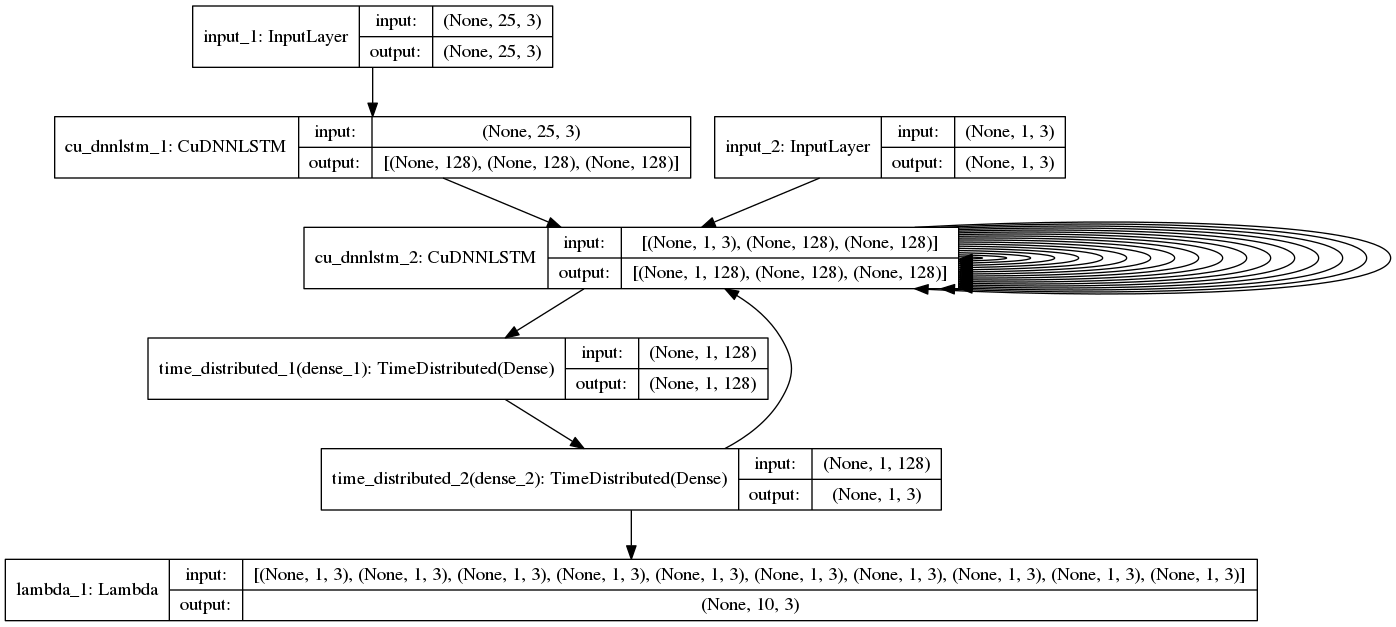

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_reinject_output(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_reinject_output(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

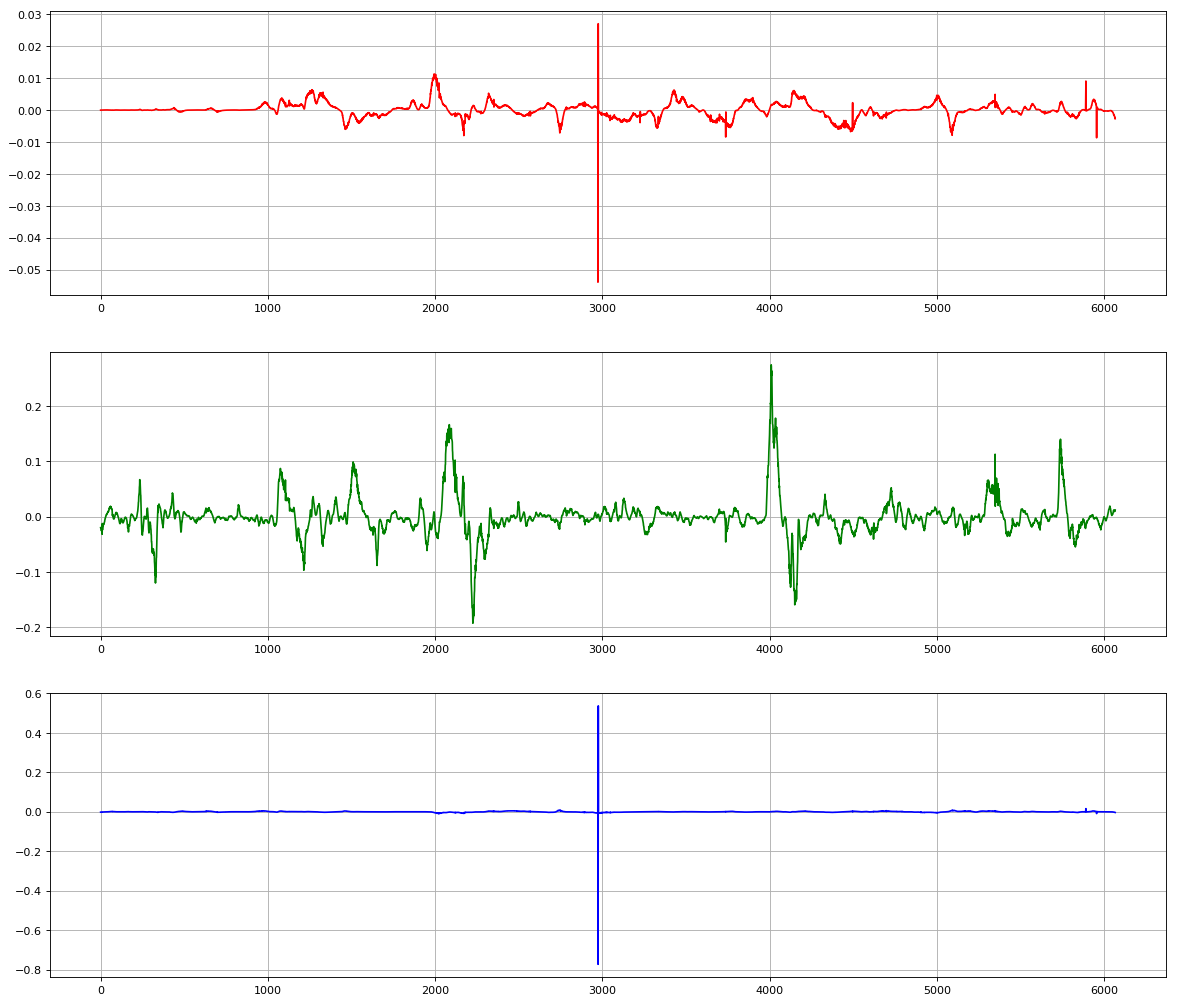

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/542 [..............................] - ETA: 11:24 - loss: 0.0508 - rmse: 0.1730

  3/542 [..............................] - ETA: 4:05 - loss: 0.0661 - rmse: 0.1820 

  4/542 [..............................] - ETA: 3:10 - loss: 0.0630 - rmse: 0.1682

  5/542 [..............................] - ETA: 2:37 - loss: 0.0697 - rmse: 0.2012

  7/542 [..............................] - ETA: 2:00 - loss: 0.0627 - rmse: 0.1744

  8/542 [..............................] - ETA: 1:48 - loss: 0.0653 - rmse: 0.1776

 10/542 [..............................] - ETA: 1:31 - loss: 0.0632 - rmse: 0.1686

 12/542 [..............................] - ETA: 1:20 - loss: 0.0609 - rmse: 0.1616

 13/542 [..............................] - ETA: 1:16 - loss: 0.0613 - rmse: 0.1620

 15/542 [..............................] - ETA: 1:08 - loss: 0.0650 - rmse: 0.1710

 17/542 [..............................] - ETA: 1:03 - loss: 0.0644 - rmse: 0.1692

 18/542 [..............................] - ETA: 1:01 - loss: 0.0647 - rmse: 0.1696

 19/542 [>.............................] - ETA: 59s - loss: 0.0653 - rmse: 0.1747 

 20/542 [>.............................] - ETA: 57s - loss: 0.0650 - rmse: 0.1771

 21/542 [>.............................] - ETA: 56s - loss: 0.0659 - rmse: 0.1797

 22/542 [>.............................] - ETA: 54s - loss: 0.0633 - rmse: 0.1727

 23/542 [>.............................] - ETA: 53s - loss: 0.0622 - rmse: 0.1742

 24/542 [>.............................] - ETA: 52s - loss: 0.0644 - rmse: 0.1794

 26/542 [>.............................] - ETA: 49s - loss: 0.0662 - rmse: 0.1803

 27/542 [>.............................] - ETA: 48s - loss: 0.0651 - rmse: 0.1763

 28/542 [>.............................] - ETA: 47s - loss: 0.0647 - rmse: 0.1749

 29/542 [>.............................] - ETA: 46s - loss: 0.0633 - rmse: 0.1704

 30/542 [>.............................] - ETA: 46s - loss: 0.0622 - rmse: 0.1679

 32/542 [>.............................] - ETA: 44s - loss: 0.0637 - rmse: 0.1704

 33/542 [>.............................] - ETA: 43s - loss: 0.0623 - rmse: 0.1665

 34/542 [>.............................] - ETA: 43s - loss: 0.0620 - rmse: 0.1652

 35/542 [>.............................] - ETA: 42s - loss: 0.0621 - rmse: 0.1657

 36/542 [>.............................] - ETA: 42s - loss: 0.0621 - rmse: 0.1658

 37/542 [=>............................] - ETA: 41s - loss: 0.0628 - rmse: 0.1687

 39/542 [=>............................] - ETA: 40s - loss: 0.0612 - rmse: 0.1638

 40/542 [=>............................] - ETA: 40s - loss: 0.0605 - rmse: 0.1618

 42/542 [=>............................] - ETA: 39s - loss: 0.0611 - rmse: 0.1631

 43/542 [=>............................] - ETA: 38s - loss: 0.0615 - rmse: 0.1639

 44/542 [=>............................] - ETA: 38s - loss: 0.0623 - rmse: 0.1656

 45/542 [=>............................] - ETA: 38s - loss: 0.0629 - rmse: 0.1681

 46/542 [=>............................] - ETA: 37s - loss: 0.0624 - rmse: 0.1662

 47/542 [=>............................] - ETA: 37s - loss: 0.0627 - rmse: 0.1666

 49/542 [=>............................] - ETA: 36s - loss: 0.0645 - rmse: 0.1709

 51/542 [=>............................] - ETA: 36s - loss: 0.0640 - rmse: 0.1695

 52/542 [=>............................] - ETA: 35s - loss: 0.0648 - rmse: 0.1708

 53/542 [=>............................] - ETA: 35s - loss: 0.0645 - rmse: 0.1703

 54/542 [=>............................] - ETA: 35s - loss: 0.0642 - rmse: 0.1696

 55/542 [==>...........................] - ETA: 35s - loss: 0.0639 - rmse: 0.1693

 57/542 [==>...........................] - ETA: 34s - loss: 0.0634 - rmse: 0.1689

 58/542 [==>...........................] - ETA: 34s - loss: 0.0638 - rmse: 0.1699

 59/542 [==>...........................] - ETA: 34s - loss: 0.0633 - rmse: 0.1686

 61/542 [==>...........................] - ETA: 33s - loss: 0.0635 - rmse: 0.1698

 62/542 [==>...........................]

 - ETA: 33s - loss: 0.0638 - rmse: 0.1707



 63/542 [==>...........................] - ETA: 33s - loss: 0.0641 - rmse: 0.1722

 64/542 [==>...........................] - ETA: 33s - loss: 0.0633 - rmse: 0.1701

 66/542 [==>...........................] - ETA: 32s - loss: 0.0626 - rmse: 0.1681

 67/542 [==>...........................] - ETA: 32s - loss: 0.0622 - rmse: 0.1676

 68/542 [==>...........................] - ETA: 32s - loss: 0.0624 - rmse: 0.1684

 69/542 [==>...........................] - ETA: 32s - loss: 0.0624 - rmse: 0.1687

 70/542 [==>...........................] - ETA: 31s - loss: 0.0627 - rmse: 0.1690

 72/542 [==>...........................] - ETA: 31s - loss: 0.0637 - rmse: 0.1714

 73/542 [===>..........................] - ETA: 31s - loss: 0.0640 - rmse: 0.1721

 75/542 [===>..........................] - ETA: 30s - loss: 0.0640 - rmse: 0.1723

 76/542 [===>..........................] - ETA: 30s - loss: 0.0636 - rmse: 0.1712

 77/542 [===>..........................] - ETA: 30s - loss: 0.0645 - rmse: 0.1744

 78/542 [===>..........................] - ETA: 30s - loss: 0.0644 - rmse: 0.1739

 79/542 [===>..........................] - ETA: 30s - loss: 0.0648 - rmse: 0.1753

 80/542 [===>..........................] - ETA: 30s - loss: 0.0644 - rmse: 0.1740

 82/542 [===>..........................] - ETA: 29s - loss: 0.0645 - rmse: 0.1740

 84/542 [===>..........................] - ETA: 29s - loss: 0.0651 - rmse: 0.1751

 85/542 [===>..........................] - ETA: 29s - loss: 0.0647 - rmse: 0.1743

 87/542 [===>..........................] - ETA: 29s - loss: 0.0649 - rmse: 0.1752

 89/542 [===>..........................] - ETA: 28s - loss: 0.0645 - rmse: 0.1743

 90/542 [===>..........................] - ETA: 28s - loss: 0.0650 - rmse: 0.1754

 91/542 [====>.........................] - ETA: 28s - loss: 0.0647 - rmse: 0.1749

 93/542 [====>.........................] - ETA: 28s - loss: 0.0642 - rmse: 0.1736

 95/542 [====>.........................] - ETA: 28s - loss: 0.0641 - rmse: 0.1729

 96/542 [====>.........................] - ETA: 27s - loss: 0.0636 - rmse: 0.1713

 98/542 [====>.........................] - ETA: 27s - loss: 0.0629 - rmse: 0.1698

 99/542 [====>.........................] - ETA: 27s - loss: 0.0628 - rmse: 0.1700

100/542 [====>.........................] - ETA: 27s - loss: 0.0627 - rmse: 0.1707

102/542 [====>.........................] - ETA: 27s - loss: 0.0626 - rmse: 0.1705

103/542 [====>.........................] - ETA: 27s - loss: 0.0623 - rmse: 0.1700

104/542 [====>.........................] - ETA: 27s - loss: 0.0622 - rmse: 0.1694

106/542 [====>.........................] - ETA: 26s - loss: 0.0620 - rmse: 0.1692

108/542 [====>.........................] - ETA: 26s - loss: 0.0619 - rmse: 0.1693

109/542 [=====>........................] - ETA: 26s - loss: 0.0618 - rmse: 0.1690

110/542 [=====>........................] - ETA: 26s - loss: 0.0620 - rmse: 0.1697

111/542 [=====>........................] - ETA: 26s - loss: 0.0618 - rmse: 0.1691

112/542 [=====>........................] - ETA: 26s - loss: 0.0619 - rmse: 0.1694

113/542 [=====>........................] - ETA: 26s - loss: 0.0617 - rmse: 0.1688

114/542 [=====>........................] - ETA: 26s - loss: 0.0616 - rmse: 0.1681

116/542 [=====>........................] - ETA: 25s - loss: 0.0615 - rmse: 0.1676

117/542 [=====>........................] - ETA: 25s - loss: 0.0619 - rmse: 0.1687

119/542 [=====>........................] - ETA: 25s - loss: 0.0623 - rmse: 0.1695

121/542 [=====>........................] - ETA: 25s - loss: 0.0622 - rmse: 0.1692

123/542 [=====>........................] - ETA: 25s - loss: 0.0627 - rmse: 0.1703

124/542 [=====>........................] - ETA: 25s - loss: 0.0628 - rmse: 0.1704

126/542 [=====>........................] - ETA: 24s - loss: 0.0628 - rmse: 0.1707

127/542 [======>.......................] - ETA: 24s - loss: 0.0628 - rmse: 0.1708

129/542 [======>.......................] - ETA: 24s - loss: 0.0630 - rmse: 0.1711

131/542 [======>.......................] - ETA: 24s - loss: 0.0628 - rmse: 0.1703

133/542 [======>.......................] - ETA: 24s - loss: 0.0627 - rmse: 0.1703

134/542 [======>.......................] - ETA: 24s - loss: 0.0627 - rmse: 0.1701

136/542 [======>.......................] - ETA: 23s - loss: 0.0629 - rmse: 0.1708

138/542 [======>.......................] - ETA: 23s - loss: 0.0627 - rmse: 0.1703

139/542 [======>.......................] - ETA: 23s - loss: 0.0628 - rmse: 0.1706

140/542 [======>.......................] - ETA: 23s - loss: 0.0628 - rmse: 0.1706

141/542 [======>.......................] - ETA: 23s - loss: 0.0629 - rmse: 0.1707

142/542 [======>.......................] - ETA: 23s - loss: 0.0629 - rmse: 0.1706

143/542 [======>.......................] - ETA: 23s - loss: 0.0628 - rmse: 0.1709

144/542 [======>.......................] - ETA: 23s - loss: 0.0629 - rmse: 0.1711

145/542 [=======>......................] - ETA: 23s - loss: 0.0629 - rmse: 0.1712

146/542 [=======>......................] - ETA: 23s - loss: 0.0630 - rmse: 0.1714

148/542 [=======>......................] - ETA: 22s - loss: 0.0631 - rmse: 0.1721

149/542 [=======>......................] - ETA: 22s - loss: 0.0629 - rmse: 0.1713

150/542 [=======>......................] - ETA: 22s - loss: 0.0627 - rmse: 0.1709

152/542 [=======>......................] - ETA: 22s - loss: 0.0626 - rmse: 0.1707

153/542 [=======>......................] - ETA: 22s - loss: 0.0629 - rmse: 0.1715

155/542 [=======>......................] - ETA: 22s - loss: 0.0631 - rmse: 0.1720

157/542 [=======>......................] - ETA: 22s - loss: 0.0632 - rmse: 0.1721

159/542 [=======>......................] - ETA: 22s - loss: 0.0633 - rmse: 0.1726

161/542 [=======>......................] - ETA: 21s - loss: 0.0629 - rmse: 0.1718

162/542 [=======>......................] - ETA: 21s - loss: 0.0630 - rmse: 0.1722

163/542 [========>.....................] - ETA: 21s - loss: 0.0630 - rmse: 0.1720

164/542 [========>.....................] - ETA: 21s - loss: 0.0630 - rmse: 0.1721

165/542 [========>.....................] - ETA: 21s - loss: 0.0632 - rmse: 0.1729

167/542 [========>.....................] - ETA: 21s - loss: 0.0627 - rmse: 0.1716

168/542 [========>.....................] - ETA: 21s - loss: 0.0625 - rmse: 0.1709

169/542 [========>.....................] - ETA: 21s - loss: 0.0625 - rmse: 0.1710

170/542 [========>.....................] - ETA: 21s - loss: 0.0626 - rmse: 0.1715

171/542 [========>.....................] - ETA: 21s - loss: 0.0626 - rmse: 0.1714

173/542 [========>.....................] - ETA: 21s - loss: 0.0629 - rmse: 0.1722

174/542 [========>.....................] - ETA: 20s - loss: 0.0629 - rmse: 0.1723

175/542 [========>.....................] - ETA: 20s - loss: 0.0630 - rmse: 0.1726

176/542 [========>.....................] - ETA: 20s - loss: 0.0629 - rmse: 0.1724

178/542 [========>.....................] - ETA: 20s - loss: 0.0628 - rmse: 0.1722

180/542 [========>.....................] - ETA: 20s - loss: 0.0632 - rmse: 0.1734

181/542 [=========>....................] - ETA: 20s - loss: 0.0632 - rmse: 0.1734

182/542 [=========>....................] - ETA: 20s - loss: 0.0632 - rmse: 0.1733

183/542 [=========>....................] - ETA: 20s - loss: 0.0630 - rmse: 0.1727

185/542 [=========>....................] - ETA: 20s - loss: 0.0627 - rmse: 0.1719

187/542 [=========>....................] - ETA: 19s - loss: 0.0629 - rmse: 0.1722

188/542 [=========>....................] - ETA: 19s - loss: 0.0630 - rmse: 0.1727

189/542 [=========>....................] - ETA: 19s - loss: 0.0630 - rmse: 0.1727

191/542 [=========>....................] - ETA: 19s - loss: 0.0633 - rmse: 0.1731

192/542 [=========>....................] - ETA: 19s - loss: 0.0632 - rmse: 0.1729

193/542 [=========>....................] - ETA: 19s - loss: 0.0630 - rmse: 0.1722

195/542 [=========>....................] - ETA: 19s - loss: 0.0629 - rmse: 0.1719

196/542 [=========>....................] - ETA: 19s - loss: 0.0628 - rmse: 0.1716

198/542 [=========>....................] - ETA: 19s - loss: 0.0628 - rmse: 0.1715

199/542 [==========>...................] - ETA: 19s - loss: 0.0627 - rmse: 0.1713

201/542 [==========>...................] - ETA: 19s - loss: 0.0626 - rmse: 0.1710

202/542 [==========>...................] - ETA: 18s - loss: 0.0626 - rmse: 0.1710

204/542 [==========>...................] - ETA: 18s - loss: 0.0626 - rmse: 0.1713

205/542 [==========>...................] - ETA: 18s - loss: 0.0627 - rmse: 0.1715

206/542 [==========>...................] - ETA: 18s - loss: 0.0627 - rmse: 0.1716

207/542 [==========>...................] - ETA: 18s - loss: 0.0625 - rmse: 0.1711

209/542 [==========>...................] - ETA: 18s - loss: 0.0624 - rmse: 0.1706

210/542 [==========>...................] - ETA: 18s - loss: 0.0624 - rmse: 0.1705

212/542 [==========>...................] - ETA: 18s - loss: 0.0625 - rmse: 0.1709

213/542 [==========>...................] - ETA: 18s - loss: 0.0625 - rmse: 0.1709

214/542 [==========>...................] - ETA: 18s - loss: 0.0626 - rmse: 0.1710

215/542 [==========>...................] - ETA: 18s - loss: 0.0624 - rmse: 0.1706

216/542 [==========>...................] - ETA: 18s - loss: 0.0623 - rmse: 0.1705

217/542 [===========>..................] - ETA: 18s - loss: 0.0624 - rmse: 0.1707

218/542 [===========>..................] - ETA: 17s - loss: 0.0624 - rmse: 0.1709

220/542 [===========>..................] - ETA: 17s - loss: 0.0623 - rmse: 0.1704

222/542 [===========>..................] - ETA: 17s - loss: 0.0623 - rmse: 0.1702

224/542 [===========>..................] - ETA: 17s - loss: 0.0623 - rmse: 0.1700

225/542 [===========>..................] - ETA: 17s - loss: 0.0624 - rmse: 0.1702

226/542 [===========>..................] - ETA: 17s - loss: 0.0624 - rmse: 0.1701

227/542 [===========>..................] - ETA: 17s - loss: 0.0621 - rmse: 0.1695

229/542 [===========>..................] - ETA: 17s - loss: 0.0625 - rmse: 0.1703

230/542 [===========>..................] - ETA: 17s - loss: 0.0625 - rmse: 0.1702

232/542 [===========>..................] - ETA: 17s - loss: 0.0623 - rmse: 0.1698

234/542 [===========>..................] - ETA: 16s - loss: 0.0621 - rmse: 0.1691

235/542 [============>.................] - ETA: 16s - loss: 0.0621 - rmse: 0.1692

236/542 [============>.................] - ETA: 16s - loss: 0.0619 - rmse: 0.1688

237/542 [============>.................] - ETA: 16s - loss: 0.0620 - rmse: 0.1688

239/542 [============>.................] - ETA: 16s - loss: 0.0619 - rmse: 0.1684

240/542 [============>.................] - ETA: 16s - loss: 0.0618 - rmse: 0.1681

242/542 [============>.................] - ETA: 16s - loss: 0.0620 - rmse: 0.1685

244/542 [============>.................] - ETA: 16s - loss: 0.0620 - rmse: 0.1685

246/542 [============>.................] - ETA: 16s - loss: 0.0620 - rmse: 0.1684

248/542 [============>.................] - ETA: 16s - loss: 0.0617 - rmse: 0.1676

249/542 [============>.................] - ETA: 15s - loss: 0.0616 - rmse: 0.1674

250/542 [============>.................] - ETA: 15s - loss: 0.0616 - rmse: 0.1671

252/542 [============>.................] - ETA: 15s - loss: 0.0615 - rmse: 0.1670

254/542 [=============>................] - ETA: 15s - loss: 0.0614 - rmse: 0.1668

255/542 [=============>................] - ETA: 15s - loss: 0.0614 - rmse: 0.1669

256/542 [=============>................] - ETA: 15s - loss: 0.0613 - rmse: 0.1666

257/542 [=============>................] - ETA: 15s - loss: 0.0611 - rmse: 0.1661

258/542 [=============>................] - ETA: 15s - loss: 0.0612 - rmse: 0.1665

259/542 [=============>................] - ETA: 15s - loss: 0.0612 - rmse: 0.1663

260/542 [=============>................] - ETA: 15s - loss: 0.0612 - rmse: 0.1663

262/542 [=============>................] - ETA: 15s - loss: 0.0614 - rmse: 0.1667

264/542 [=============>................] - ETA: 15s - loss: 0.0618 - rmse: 0.1677

266/542 [=============>................] - ETA: 14s - loss: 0.0615 - rmse: 0.1671

268/542 [=============>................] - ETA: 14s - loss: 0.0615 - rmse: 0.1673

269/542 [=============>................] - ETA: 14s - loss: 0.0614 - rmse: 0.1671

271/542 [==============>...............] - ETA: 14s - loss: 0.0618 - rmse: 0.1680

273/542 [==============>...............] - ETA: 14s - loss: 0.0619 - rmse: 0.1683

275/542 [==============>...............] - ETA: 14s - loss: 0.0618 - rmse: 0.1681

277/542 [==============>...............] - ETA: 14s - loss: 0.0615 - rmse: 0.1676

278/542 [==============>...............] - ETA: 14s - loss: 0.0616 - rmse: 0.1678

280/542 [==============>...............] - ETA: 14s - loss: 0.0615 - rmse: 0.1676

282/542 [==============>...............] - ETA: 13s - loss: 0.0617 - rmse: 0.1681

283/542 [==============>...............] - ETA: 13s - loss: 0.0616 - rmse: 0.1680

285/542 [==============>...............] - ETA: 13s - loss: 0.0616 - rmse: 0.1681

287/542 [==============>...............] - ETA: 13s - loss: 0.0616 - rmse: 0.1681

289/542 [==============>...............] - ETA: 13s - loss: 0.0616 - rmse: 0.1682

290/542 [===============>..............] - ETA: 13s - loss: 0.0615 - rmse: 0.1678

291/542 [===============>..............] - ETA: 13s - loss: 0.0614 - rmse: 0.1677

292/542 [===============>..............] - ETA: 13s - loss: 0.0614 - rmse: 0.1676

293/542 [===============>..............] - ETA: 13s - loss: 0.0614 - rmse: 0.1677

295/542 [===============>..............] - ETA: 13s - loss: 0.0616 - rmse: 0.1683

297/542 [===============>..............] - ETA: 13s - loss: 0.0616 - rmse: 0.1680

299/542 [===============>..............] - ETA: 13s - loss: 0.0615 - rmse: 0.1680

300/542 [===============>..............] - ETA: 12s - loss: 0.0615 - rmse: 0.1680

302/542 [===============>..............] - ETA: 12s - loss: 0.0614 - rmse: 0.1676

303/542 [===============>..............] - ETA: 12s - loss: 0.0615 - rmse: 0.1678

304/542 [===============>..............] - ETA: 12s - loss: 0.0615 - rmse: 0.1680

305/542 [===============>..............] - ETA: 12s - loss: 0.0614 - rmse: 0.1679

306/542 [===============>..............] - ETA: 12s - loss: 0.0615 - rmse: 0.1679

307/542 [===============>..............] - ETA: 12s - loss: 0.0613 - rmse: 0.1676

308/542 [================>.............] - ETA: 12s - loss: 0.0614 - rmse: 0.1678

309/542 [================>.............] - ETA: 12s - loss: 0.0614 - rmse: 0.1680

310/542 [================>.............] - ETA: 12s - loss: 0.0613 - rmse: 0.1677

312/542 [================>.............] - ETA: 12s - loss: 0.0613 - rmse: 0.1676

313/542 [================>.............] - ETA: 12s - loss: 0.0613 - rmse: 0.1676

315/542 [================>.............] - ETA: 12s - loss: 0.0614 - rmse: 0.1676

316/542 [================>.............] - ETA: 12s - loss: 0.0614 - rmse: 0.1676

317/542 [================>.............] - ETA: 12s - loss: 0.0614 - rmse: 0.1676

318/542 [================>.............] - ETA: 11s - loss: 0.0614 - rmse: 0.1677

319/542 [================>.............] - ETA: 11s - loss: 0.0614 - rmse: 0.1676

320/542 [================>.............] - ETA: 11s - loss: 0.0615 - rmse: 0.1678

322/542 [================>.............] - ETA: 11s - loss: 0.0614 - rmse: 0.1675

323/542 [================>.............] - ETA: 11s - loss: 0.0616 - rmse: 0.1679

324/542 [================>.............] - ETA: 11s - loss: 0.0619 - rmse: 0.1685

326/542 [=================>............] - ETA: 11s - loss: 0.0618 - rmse: 0.1684

327/542 [=================>............] - ETA: 11s - loss: 0.0617 - rmse: 0.1681

329/542 [=================>............] - ETA: 11s - loss: 0.0616 - rmse: 0.1677

330/542 [=================>............] - ETA: 11s - loss: 0.0616 - rmse: 0.1678

331/542 [=================>............] - ETA: 11s - loss: 0.0617 - rmse: 0.1681

333/542 [=================>............] - ETA: 11s - loss: 0.0616 - rmse: 0.1679

334/542 [=================>............] - ETA: 11s - loss: 0.0617 - rmse: 0.1680

335/542 [=================>............] - ETA: 11s - loss: 0.0615 - rmse: 0.1676

336/542 [=================>............] - ETA: 10s - loss: 0.0615 - rmse: 0.1678

337/542 [=================>............] - ETA: 10s - loss: 0.0615 - rmse: 0.1681

338/542 [=================>............] - ETA: 10s - loss: 0.0615 - rmse: 0.1679

339/542 [=================>............] - ETA: 10s - loss: 0.0615 - rmse: 0.1680

340/542 [=================>............] - ETA: 10s - loss: 0.0616 - rmse: 0.1683

341/542 [=================>............] - ETA: 10s - loss: 0.0616 - rmse: 0.1683

342/542 [=================>............] - ETA: 10s - loss: 0.0617 - rmse: 0.1683

343/542 [=================>............] - ETA: 10s - loss: 0.0616 - rmse: 0.1681

344/542 [==================>...........] - ETA: 10s - loss: 0.0615 - rmse: 0.1679

346/542 [==================>...........] - ETA: 10s - loss: 0.0615 - rmse: 0.1679

348/542 [==================>...........] - ETA: 10s - loss: 0.0616 - rmse: 0.1680

349/542 [==================>...........] - ETA: 10s - loss: 0.0615 - rmse: 0.1679

351/542 [==================>...........] - ETA: 10s - loss: 0.0617 - rmse: 0.1682

353/542 [==================>...........] - ETA: 10s - loss: 0.0616 - rmse: 0.1679

355/542 [==================>...........] - ETA: 9s - loss: 0.0615 - rmse: 0.1676 

357/542 [==================>...........] - ETA: 9s - loss: 0.0616 - rmse: 0.1678

358/542 [==================>...........] - ETA: 9s - loss: 0.0615 - rmse: 0.1675

360/542 [==================>...........] - ETA: 9s - loss: 0.0614 - rmse: 0.1672

362/542 [===================>..........] - ETA: 9s - loss: 0.0612 - rmse: 0.1670

363/542 [===================>..........] - ETA: 9s - loss: 0.0612 - rmse: 0.1669

364/542 [===================>..........] - ETA: 9s - loss: 0.0612 - rmse: 0.1668

365/542 [===================>..........] - ETA: 9s - loss: 0.0612 - rmse: 0.1668

366/542 [===================>..........] - ETA: 9s - loss: 0.0613 - rmse: 0.1671

368/542 [===================>..........] - ETA: 9s - loss: 0.0614 - rmse: 0.1674

370/542 [===================>..........] - ETA: 9s - loss: 0.0613 - rmse: 0.1671

372/542 [===================>..........] - ETA: 9s - loss: 0.0613 - rmse: 0.1674

373/542 [===================>..........] - ETA: 8s - loss: 0.0614 - rmse: 0.1674

375/542 [===================>..........] - ETA: 8s - loss: 0.0616 - rmse: 0.1679

377/542 [===================>..........] - ETA: 8s - loss: 0.0617 - rmse: 0.1681

379/542 [===================>..........] - ETA: 8s - loss: 0.0616 - rmse: 0.1679

380/542 [====================>.........] - ETA: 8s - loss: 0.0616 - rmse: 0.1679

381/542 [====================>.........] - ETA: 8s - loss: 0.0615 - rmse: 0.1677

382/542 [====================>.........] - ETA: 8s - loss: 0.0616 - rmse: 0.1679

384/542 [====================>.........] - ETA: 8s - loss: 0.0616 - rmse: 0.1679

385/542 [====================>.........] - ETA: 8s - loss: 0.0618 - rmse: 0.1685

386/542 [====================>.........] - ETA: 8s - loss: 0.0617 - rmse: 0.1684

387/542 [====================>.........] - ETA: 8s - loss: 0.0617 - rmse: 0.1683

388/542 [====================>.........] - ETA: 8s - loss: 0.0617 - rmse: 0.1682

390/542 [====================>.........] - ETA: 8s - loss: 0.0615 - rmse: 0.1678

392/542 [====================>.........] - ETA: 7s - loss: 0.0615 - rmse: 0.1678

394/542 [====================>.........] - ETA: 7s - loss: 0.0615 - rmse: 0.1678

395/542 [====================>.........] - ETA: 7s - loss: 0.0614 - rmse: 0.1679

397/542 [====================>.........] - ETA: 7s - loss: 0.0615 - rmse: 0.1680

398/542 [=====================>........] - ETA: 7s - loss: 0.0614 - rmse: 0.1679

399/542 [=====================>........] - ETA: 7s - loss: 0.0614 - rmse: 0.1678

400/542 [=====================>........] - ETA: 7s - loss: 0.0614 - rmse: 0.1678

401/542 [=====================>........] - ETA: 7s - loss: 0.0614 - rmse: 0.1678

402/542 [=====================>........] - ETA: 7s - loss: 0.0613 - rmse: 0.1675

404/542 [=====================>........] - ETA: 7s - loss: 0.0611 - rmse: 0.1671

405/542 [=====================>........] - ETA: 7s - loss: 0.0610 - rmse: 0.1669

407/542 [=====================>........] - ETA: 7s - loss: 0.0611 - rmse: 0.1672

408/542 [=====================>........] - ETA: 7s - loss: 0.0612 - rmse: 0.1674

409/542 [=====================>........] - ETA: 7s - loss: 0.0612 - rmse: 0.1673

410/542 [=====================>........] - ETA: 6s - loss: 0.0613 - rmse: 0.1675

411/542 [=====================>........] - ETA: 6s - loss: 0.0612 - rmse: 0.1673

412/542 [=====================>........] - ETA: 6s - loss: 0.0611 - rmse: 0.1671

413/542 [=====================>........] - ETA: 6s - loss: 0.0611 - rmse: 0.1671

414/542 [=====================>........] - ETA: 6s - loss: 0.0612 - rmse: 0.1673

415/542 [=====================>........] - ETA: 6s - loss: 0.0611 - rmse: 0.1671

417/542 [======================>.......] - ETA: 6s - loss: 0.0611 - rmse: 0.1672

418/542 [======================>.......] - ETA: 6s - loss: 0.0613 - rmse: 0.1676

419/542 [======================>.......] - ETA: 6s - loss: 0.0612 - rmse: 0.1675

421/542 [======================>.......] - ETA: 6s - loss: 0.0611 - rmse: 0.1671

422/542 [======================>.......] - ETA: 6s - loss: 0.0610 - rmse: 0.1669

424/542 [======================>.......] - ETA: 6s - loss: 0.0609 - rmse: 0.1668

425/542 [======================>.......] - ETA: 6s - loss: 0.0609 - rmse: 0.1668

426/542 [======================>.......] - ETA: 6s - loss: 0.0608 - rmse: 0.1667

427/542 [======================>.......] - ETA: 6s - loss: 0.0608 - rmse: 0.1666

428/542 [======================>.......] - ETA: 6s - loss: 0.0608 - rmse: 0.1665

429/542 [======================>.......] - ETA: 5s - loss: 0.0607 - rmse: 0.1664

430/542 [======================>.......] - ETA: 5s - loss: 0.0607 - rmse: 0.1665

431/542 [======================>.......] - ETA: 5s - loss: 0.0606 - rmse: 0.1662

433/542 [======================>.......] - ETA: 5s - loss: 0.0607 - rmse: 0.1662

434/542 [=======================>......] - ETA: 5s - loss: 0.0606 - rmse: 0.1660

435/542 [=======================>......] - ETA: 5s - loss: 0.0606 - rmse: 0.1660

437/542 [=======================>......] - ETA: 5s - loss: 0.0606 - rmse: 0.1661

438/542 [=======================>......] - ETA: 5s - loss: 0.0606 - rmse: 0.1660

439/542 [=======================>......] - ETA: 5s - loss: 0.0606 - rmse: 0.1659

441/542 [=======================>......] - ETA: 5s - loss: 0.0606 - rmse: 0.1657

442/542 [=======================>......] - ETA: 5s - loss: 0.0606 - rmse: 0.1660

443/542 [=======================>......] - ETA: 5s - loss: 0.0607 - rmse: 0.1662

445/542 [=======================>......] - ETA: 5s - loss: 0.0607 - rmse: 0.1661

447/542 [=======================>......] - ETA: 4s - loss: 0.0607 - rmse: 0.1662

448/542 [=======================>......] - ETA: 4s - loss: 0.0608 - rmse: 0.1663

449/542 [=======================>......] - ETA: 4s - loss: 0.0608 - rmse: 0.1663

450/542 [=======================>......] - ETA: 4s - loss: 0.0608 - rmse: 0.1664

452/542 [========================>.....] - ETA: 4s - loss: 0.0609 - rmse: 0.1664

453/542 [========================>.....] - ETA: 4s - loss: 0.0610 - rmse: 0.1667

454/542 [========================>.....] - ETA: 4s - loss: 0.0609 - rmse: 0.1666

455/542 [========================>.....] - ETA: 4s - loss: 0.0608 - rmse: 0.1663

456/542 [========================>.....] - ETA: 4s - loss: 0.0609 - rmse: 0.1665

458/542 [========================>.....] - ETA: 4s - loss: 0.0608 - rmse: 0.1662

459/542 [========================>.....] - ETA: 4s - loss: 0.0608 - rmse: 0.1662

460/542 [========================>.....] - ETA: 4s - loss: 0.0607 - rmse: 0.1660

462/542 [========================>.....] - ETA: 4s - loss: 0.0607 - rmse: 0.1661

463/542 [========================>.....] - ETA: 4s - loss: 0.0607 - rmse: 0.1661

465/542 [========================>.....] - ETA: 4s - loss: 0.0607 - rmse: 0.1661

466/542 [========================>.....] - ETA: 3s - loss: 0.0606 - rmse: 0.1659

468/542 [========================>.....] - ETA: 3s - loss: 0.0606 - rmse: 0.1658

470/542 [=========================>....] - ETA: 3s - loss: 0.0606 - rmse: 0.1656

471/542 [=========================>....] - ETA: 3s - loss: 0.0605 - rmse: 0.1656

473/542 [=========================>....] - ETA: 3s - loss: 0.0605 - rmse: 0.1656

475/542 [=========================>....] - ETA: 3s - loss: 0.0605 - rmse: 0.1656

476/542 [=========================>....] - ETA: 3s - loss: 0.0604 - rmse: 0.1653

478/542 [=========================>....] - ETA: 3s - loss: 0.0605 - rmse: 0.1655

479/542 [=========================>....] - ETA: 3s - loss: 0.0605 - rmse: 0.1656

480/542 [=========================>....] - ETA: 3s - loss: 0.0604 - rmse: 0.1653

481/542 [=========================>....] - ETA: 3s - loss: 0.0604 - rmse: 0.1654

483/542 [=========================>....] - ETA: 3s - loss: 0.0605 - rmse: 0.1654

485/542 [=========================>....] - ETA: 2s - loss: 0.0605 - rmse: 0.1655

486/542 [=========================>....] - ETA: 2s - loss: 0.0605 - rmse: 0.1654

487/542 [=========================>....] - ETA: 2s - loss: 0.0605 - rmse: 0.1655

489/542 [==========================>...] - ETA: 2s - loss: 0.0605 - rmse: 0.1655

490/542 [==========================>...] - ETA: 2s - loss: 0.0606 - rmse: 0.1657

491/542 [==========================>...] - ETA: 2s - loss: 0.0605 - rmse: 0.1656

493/542 [==========================>...] - ETA: 2s - loss: 0.0605 - rmse: 0.1655

494/542 [==========================>...] - ETA: 2s - loss: 0.0604 - rmse: 0.1653

496/542 [==========================>...] - ETA: 2s - loss: 0.0604 - rmse: 0.1652

497/542 [==========================>...] - ETA: 2s - loss: 0.0605 - rmse: 0.1653

499/542 [==========================>...] - ETA: 2s - loss: 0.0605 - rmse: 0.1654

500/542 [==========================>...] - ETA: 2s - loss: 0.0605 - rmse: 0.1654

501/542 [==========================>...] - ETA: 2s - loss: 0.0605 - rmse: 0.1654

502/542 [==========================>...] - ETA: 2s - loss: 0.0605 - rmse: 0.1654

503/542 [==========================>...] - ETA: 2s - loss: 0.0604 - rmse: 0.1653

505/542 [==========================>...] - ETA: 1s - loss: 0.0605 - rmse: 0.1655

506/542 [===========================>..] - ETA: 1s - loss: 0.0604 - rmse: 0.1653

507/542 [===========================>..] - ETA: 1s - loss: 0.0605 - rmse: 0.1654

508/542 [===========================>..] - ETA: 1s - loss: 0.0605 - rmse: 0.1655

509/542 [===========================>..] - ETA: 1s - loss: 0.0605 - rmse: 0.1655

510/542 [===========================>..] - ETA: 1s - loss: 0.0605 - rmse: 0.1656

511/542 [===========================>..] - ETA: 1s - loss: 0.0605 - rmse: 0.1658

513/542 [===========================>..] - ETA: 1s - loss: 0.0606 - rmse: 0.1658

514/542 [===========================>..] - ETA: 1s - loss: 0.0606 - rmse: 0.1658

516/542 [===========================>..] - ETA: 1s - loss: 0.0606 - rmse: 0.1658

517/542 [===========================>..] - ETA: 1s - loss: 0.0605 - rmse: 0.1658

518/542 [===========================>..] - ETA: 1s - loss: 0.0605 - rmse: 0.1658

519/542 [===========================>..] - ETA: 1s - loss: 0.0605 - rmse: 0.1658

520/542 [===========================>..] - ETA: 1s - loss: 0.0605 - rmse: 0.1659

521/542 [===========================>..] - ETA: 1s - loss: 0.0605 - rmse: 0.1659

522/542 [===========================>..] - ETA: 1s - loss: 0.0606 - rmse: 0.1661

523/542 [===========================>..] - ETA: 0s - loss: 0.0606 - rmse: 0.1660

525/542 [============================>.] - ETA: 0s - loss: 0.0606 - rmse: 0.1662

526/542 [============================>.] - ETA: 0s - loss: 0.0606 - rmse: 0.1661

527/542 [============================>.] - ETA: 0s - loss: 0.0606 - rmse: 0.1660

528/542 [============================>.] - ETA: 0s - loss: 0.0605 - rmse: 0.1658

530/542 [============================>.] - ETA: 0s - loss: 0.0604 - rmse: 0.1655

531/542 [============================>.] - ETA: 0s - loss: 0.0604 - rmse: 0.1655

532/542 [============================>.] - ETA: 0s - loss: 0.0603 - rmse: 0.1654

533/542 [============================>.] - ETA: 0s - loss: 0.0604 - rmse: 0.1655

534/542 [============================>.] - ETA: 0s - loss: 0.0603 - rmse: 0.1654

535/542 [============================>.] - ETA: 0s - loss: 0.0603 - rmse: 0.1653

536/542 [============================>.] - ETA: 0s - loss: 0.0602 - rmse: 0.1652

537/542 [============================>.] - ETA: 0s - loss: 0.0602 - rmse: 0.1652

538/542 [============================>.] - ETA: 0s - loss: 0.0601 - rmse: 0.1649

539/542 [============================>.] - ETA: 0s - loss: 0.0602 - rmse: 0.1651

540/542 [============================>.] - ETA: 0s - loss: 0.0602 - rmse: 0.1652

541/542 [============================>.] - ETA: 0s - loss: 0.0602 - rmse: 0.1653

542/542 [==============================] - 33s 60ms/step - loss: 0.0602 - rmse: 0.1653 - val_loss: 0.0623 - val_rmse: 0.1813


Epoch 2/150
  1/542 [..............................] - ETA: 28s - loss: 0.0347 - rmse: 0.0964

/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2

  3/542 [..............................] - ETA: 25s - loss: 0.0374 - rmse: 0.0902

  5/542 [..............................] - ETA: 25s - loss: 0.0306 - rmse: 0.0813

  6/542 [..............................] - ETA: 25s - loss: 0.0310 - rmse: 0.0794

  7/542 [..............................] - ETA: 26s - loss: 0.0374 - rmse: 0.0951

  9/542 [..............................] - ETA: 25s - loss: 0.0376 - rmse: 0.0993

 10/542 [..............................] - ETA: 26s - loss: 0.0390 - rmse: 0.1063

 12/542 [..............................] - ETA: 25s - loss: 0.0396 - rmse: 0.1061

 14/542 [..............................] - ETA: 25s - loss: 0.0412 - rmse: 0.1164

 15/542 [..............................] - ETA: 26s - loss: 0.0401 - rmse: 0.1125

 16/542 [..............................] - ETA: 26s - loss: 0.0453 - rmse: 0.1308

 17/542 [..............................] - ETA: 26s - loss: 0.0449 - rmse: 0.1308

 18/542 [..............................] - ETA: 28s - loss: 0.0461 - rmse: 0.1344

 19/542 [>.............................] - ETA: 30s - loss: 0.0461 - rmse: 0.1348

 20/542 [>.............................] - ETA: 31s - loss: 0.0465 - rmse: 0.1374

 22/542 [>.............................] - ETA: 30s - loss: 0.0471 - rmse: 0.1385

 23/542 [>.............................] - ETA: 30s - loss: 0.0482 - rmse: 0.1408

 24/542 [>.............................] - ETA: 30s - loss: 0.0481 - rmse: 0.1399

 26/542 [>.............................] - ETA: 29s - loss: 0.0471 - rmse: 0.1389

 27/542 [>.............................] - ETA: 29s - loss: 0.0480 - rmse: 0.1401

 29/542 [>.............................] - ETA: 28s - loss: 0.0469 - rmse: 0.1366

 31/542 [>.............................] - ETA: 28s - loss: 0.0480 - rmse: 0.1401

 32/542 [>.............................] - ETA: 28s - loss: 0.0476 - rmse: 0.1389

 33/542 [>.............................] - ETA: 28s - loss: 0.0475 - rmse: 0.1385

 35/542 [>.............................] - ETA: 27s - loss: 0.0503 - rmse: 0.1443

 37/542 [=>............................] - ETA: 27s - loss: 0.0510 - rmse: 0.1451

 38/542 [=>............................] - ETA: 27s - loss: 0.0499 - rmse: 0.1420

 39/542 [=>............................] - ETA: 27s - loss: 0.0502 - rmse: 0.1428

 40/542 [=>............................] - ETA: 27s - loss: 0.0504 - rmse: 0.1441

 42/542 [=>............................] - ETA: 27s - loss: 0.0510 - rmse: 0.1456

 44/542 [=>............................] - ETA: 26s - loss: 0.0513 - rmse: 0.1453

 45/542 [=>............................] - ETA: 26s - loss: 0.0513 - rmse: 0.1455

 46/542 [=>............................] - ETA: 26s - loss: 0.0515 - rmse: 0.1458

 48/542 [=>............................] - ETA: 26s - loss: 0.0523 - rmse: 0.1474

 49/542 [=>............................] - ETA: 26s - loss: 0.0526 - rmse: 0.1487

 50/542 [=>............................] - ETA: 26s - loss: 0.0522 - rmse: 0.1474

 51/542 [=>............................] - ETA: 26s - loss: 0.0519 - rmse: 0.1467

 53/542 [=>............................] - ETA: 25s - loss: 0.0511 - rmse: 0.1449

 54/542 [=>............................] - ETA: 25s - loss: 0.0509 - rmse: 0.1444

 55/542 [==>...........................] - ETA: 25s - loss: 0.0508 - rmse: 0.1440

 56/542 [==>...........................] - ETA: 25s - loss: 0.0509 - rmse: 0.1440

 58/542 [==>...........................] - ETA: 25s - loss: 0.0508 - rmse: 0.1444

 59/542 [==>...........................] - ETA: 25s - loss: 0.0505 - rmse: 0.1438

 61/542 [==>...........................] - ETA: 25s - loss: 0.0507 - rmse: 0.1443

 63/542 [==>...........................] - ETA: 25s - loss: 0.0516 - rmse: 0.1470

 64/542 [==>...........................] - ETA: 25s - loss: 0.0510 - rmse: 0.1453

 65/542 [==>...........................] - ETA: 25s - loss: 0.0514 - rmse: 0.1463

 67/542 [==>...........................] - ETA: 24s - loss: 0.0521 - rmse: 0.1492

 69/542 [==>...........................] - ETA: 24s - loss: 0.0526 - rmse: 0.1508

 71/542 [==>...........................] - ETA: 24s - loss: 0.0525 - rmse: 0.1514

 72/542 [==>...........................] - ETA: 24s - loss: 0.0528 - rmse: 0.1518

 73/542 [===>..........................] - ETA: 24s - loss: 0.0526 - rmse: 0.1516

 75/542 [===>..........................] - ETA: 24s - loss: 0.0523 - rmse: 0.1506

 77/542 [===>..........................] - ETA: 24s - loss: 0.0524 - rmse: 0.1506

 78/542 [===>..........................] - ETA: 24s - loss: 0.0524 - rmse: 0.1507

 79/542 [===>..........................] - ETA: 24s - loss: 0.0525 - rmse: 0.1508

 81/542 [===>..........................] - ETA: 23s - loss: 0.0521 - rmse: 0.1493

 83/542 [===>..........................] - ETA: 23s - loss: 0.0519 - rmse: 0.1506

 84/542 [===>..........................] - ETA: 23s - loss: 0.0522 - rmse: 0.1513

 85/542 [===>..........................] - ETA: 23s - loss: 0.0518 - rmse: 0.1503

 87/542 [===>..........................] - ETA: 23s - loss: 0.0518 - rmse: 0.1503

 88/542 [===>..........................] - ETA: 23s - loss: 0.0518 - rmse: 0.1502

 90/542 [===>..........................] - ETA: 23s - loss: 0.0516 - rmse: 0.1498

 91/542 [====>.........................] - ETA: 23s - loss: 0.0515 - rmse: 0.1497

 92/542 [====>.........................] - ETA: 23s - loss: 0.0515 - rmse: 0.1498

 94/542 [====>.........................] - ETA: 23s - loss: 0.0519 - rmse: 0.1507

 95/542 [====>.........................] - ETA: 22s - loss: 0.0518 - rmse: 0.1501

 97/542 [====>.........................] - ETA: 22s - loss: 0.0518 - rmse: 0.1496

 98/542 [====>.........................] - ETA: 22s - loss: 0.0518 - rmse: 0.1497

100/542 [====>.........................] - ETA: 22s - loss: 0.0516 - rmse: 0.1489

101/542 [====>.........................] - ETA: 22s - loss: 0.0516 - rmse: 0.1487

102/542 [====>.........................] - ETA: 22s - loss: 0.0516 - rmse: 0.1493

104/542 [====>.........................] - ETA: 22s - loss: 0.0517 - rmse: 0.1491

106/542 [====>.........................] - ETA: 22s - loss: 0.0519 - rmse: 0.1497

108/542 [====>.........................] - ETA: 22s - loss: 0.0515 - rmse: 0.1486

110/542 [=====>........................] - ETA: 21s - loss: 0.0518 - rmse: 0.1492

112/542 [=====>........................] - ETA: 21s - loss: 0.0519 - rmse: 0.1493

113/542 [=====>........................] - ETA: 21s - loss: 0.0518 - rmse: 0.1491

115/542 [=====>........................] - ETA: 21s - loss: 0.0520 - rmse: 0.1490

116/542 [=====>........................] - ETA: 21s - loss: 0.0522 - rmse: 0.1493

118/542 [=====>........................] - ETA: 21s - loss: 0.0527 - rmse: 0.1504

119/542 [=====>........................] - ETA: 21s - loss: 0.0529 - rmse: 0.1513

120/542 [=====>........................] - ETA: 21s - loss: 0.0529 - rmse: 0.1512

121/542 [=====>........................] - ETA: 21s - loss: 0.0529 - rmse: 0.1512

123/542 [=====>........................] - ETA: 21s - loss: 0.0534 - rmse: 0.1522

124/542 [=====>........................] - ETA: 21s - loss: 0.0532 - rmse: 0.1520

126/542 [=====>........................] - ETA: 21s - loss: 0.0534 - rmse: 0.1528

128/542 [======>.......................] - ETA: 20s - loss: 0.0535 - rmse: 0.1527

130/542 [======>.......................] - ETA: 20s - loss: 0.0535 - rmse: 0.1528

131/542 [======>.......................] - ETA: 20s - loss: 0.0535 - rmse: 0.1526

133/542 [======>.......................] - ETA: 20s - loss: 0.0536 - rmse: 0.1530

134/542 [======>.......................] - ETA: 20s - loss: 0.0539 - rmse: 0.1536

135/542 [======>.......................] - ETA: 20s - loss: 0.0538 - rmse: 0.1534

137/542 [======>.......................] - ETA: 20s - loss: 0.0536 - rmse: 0.1534

138/542 [======>.......................] - ETA: 20s - loss: 0.0534 - rmse: 0.1526

140/542 [======>.......................] - ETA: 20s - loss: 0.0537 - rmse: 0.1535

141/542 [======>.......................] - ETA: 20s - loss: 0.0537 - rmse: 0.1534

143/542 [======>.......................] - ETA: 20s - loss: 0.0536 - rmse: 0.1534

144/542 [======>.......................] - ETA: 20s - loss: 0.0533 - rmse: 0.1526

146/542 [=======>......................] - ETA: 19s - loss: 0.0532 - rmse: 0.1521

147/542 [=======>......................] - ETA: 19s - loss: 0.0532 - rmse: 0.1519

149/542 [=======>......................] - ETA: 19s - loss: 0.0531 - rmse: 0.1518

151/542 [=======>......................] - ETA: 19s - loss: 0.0533 - rmse: 0.1522

153/542 [=======>......................] - ETA: 19s - loss: 0.0532 - rmse: 0.1516

154/542 [=======>......................] - ETA: 19s - loss: 0.0531 - rmse: 0.1512

155/542 [=======>......................] - ETA: 19s - loss: 0.0531 - rmse: 0.1512

156/542 [=======>......................] - ETA: 19s - loss: 0.0531 - rmse: 0.1514

157/542 [=======>......................] - ETA: 19s - loss: 0.0531 - rmse: 0.1515

158/542 [=======>......................] - ETA: 19s - loss: 0.0530 - rmse: 0.1511

159/542 [=======>......................] - ETA: 19s - loss: 0.0527 - rmse: 0.1505

160/542 [=======>......................] - ETA: 19s - loss: 0.0531 - rmse: 0.1511

161/542 [=======>......................] - ETA: 19s - loss: 0.0530 - rmse: 0.1510

163/542 [========>.....................] - ETA: 19s - loss: 0.0533 - rmse: 0.1518

164/542 [========>.....................] - ETA: 18s - loss: 0.0532 - rmse: 0.1516

165/542 [========>.....................] - ETA: 18s - loss: 0.0533 - rmse: 0.1518

167/542 [========>.....................] - ETA: 18s - loss: 0.0530 - rmse: 0.1511

169/542 [========>.....................] - ETA: 18s - loss: 0.0530 - rmse: 0.1510

170/542 [========>.....................] - ETA: 18s - loss: 0.0531 - rmse: 0.1513

172/542 [========>.....................] - ETA: 18s - loss: 0.0528 - rmse: 0.1506

173/542 [========>.....................] - ETA: 18s - loss: 0.0529 - rmse: 0.1506

175/542 [========>.....................] - ETA: 18s - loss: 0.0528 - rmse: 0.1502

176/542 [========>.....................] - ETA: 18s - loss: 0.0526 - rmse: 0.1496

178/542 [========>.....................] - ETA: 18s - loss: 0.0526 - rmse: 0.1496

180/542 [========>.....................] - ETA: 18s - loss: 0.0523 - rmse: 0.1488

182/542 [=========>....................] - ETA: 18s - loss: 0.0526 - rmse: 0.1498

184/542 [=========>....................] - ETA: 17s - loss: 0.0525 - rmse: 0.1493

185/542 [=========>....................] - ETA: 17s - loss: 0.0523 - rmse: 0.1487

187/542 [=========>....................] - ETA: 17s - loss: 0.0522 - rmse: 0.1482

189/542 [=========>....................] - ETA: 17s - loss: 0.0523 - rmse: 0.1483

190/542 [=========>....................] - ETA: 17s - loss: 0.0526 - rmse: 0.1490

192/542 [=========>....................] - ETA: 17s - loss: 0.0524 - rmse: 0.1484



193/542 [=========>....................] - ETA: 17s - loss: 0.0523 - rmse: 0.1480

195/542 [=========>....................] - ETA: 17s - loss: 0.0526 - rmse: 0.1488

196/542 [=========>....................] - ETA: 17s - loss: 0.0526 - rmse: 0.1487

198/542 [=========>....................] - ETA: 17s - loss: 0.0528 - rmse: 0.1491

200/542 [==========>...................] - ETA: 17s - loss: 0.0529 - rmse: 0.1498

201/542 [==========>...................] - ETA: 17s - loss: 0.0531 - rmse: 0.1503

202/542 [==========>...................] - ETA: 16s - loss: 0.0531 - rmse: 0.1503

203/542 [==========>...................] - ETA: 16s - loss: 0.0530 - rmse: 0.1500

205/542 [==========>...................] - ETA: 16s - loss: 0.0531 - rmse: 0.1502

206/542 [==========>...................] - ETA: 16s - loss: 0.0532 - rmse: 0.1506

208/542 [==========>...................] - ETA: 16s - loss: 0.0532 - rmse: 0.1504

209/542 [==========>...................] - ETA: 16s - loss: 0.0531 - rmse: 0.1504

210/542 [==========>...................] - ETA: 16s - loss: 0.0530 - rmse: 0.1502

211/542 [==========>...................] - ETA: 16s - loss: 0.0528 - rmse: 0.1498

213/542 [==========>...................] - ETA: 16s - loss: 0.0527 - rmse: 0.1497

215/542 [==========>...................] - ETA: 16s - loss: 0.0531 - rmse: 0.1508

217/542 [===========>..................] - ETA: 16s - loss: 0.0534 - rmse: 0.1515

218/542 [===========>..................] - ETA: 16s - loss: 0.0534 - rmse: 0.1514

219/542 [===========>..................] - ETA: 16s - loss: 0.0532 - rmse: 0.1509

221/542 [===========>..................] - ETA: 16s - loss: 0.0534 - rmse: 0.1512

223/542 [===========>..................] - ETA: 15s - loss: 0.0532 - rmse: 0.1510

224/542 [===========>..................] - ETA: 15s - loss: 0.0530 - rmse: 0.1504

225/542 [===========>..................] - ETA: 15s - loss: 0.0531 - rmse: 0.1505

227/542 [===========>..................] - ETA: 15s - loss: 0.0530 - rmse: 0.1503

228/542 [===========>..................] - ETA: 15s - loss: 0.0530 - rmse: 0.1501

229/542 [===========>..................] - ETA: 15s - loss: 0.0534 - rmse: 0.1510

231/542 [===========>..................] - ETA: 15s - loss: 0.0535 - rmse: 0.1510

232/542 [===========>..................] - ETA: 15s - loss: 0.0535 - rmse: 0.1509

233/542 [===========>..................] - ETA: 15s - loss: 0.0535 - rmse: 0.1508

234/542 [===========>..................] - ETA: 15s - loss: 0.0535 - rmse: 0.1510

235/542 [============>.................] - ETA: 15s - loss: 0.0535 - rmse: 0.1509

236/542 [============>.................] - ETA: 15s - loss: 0.0537 - rmse: 0.1513

238/542 [============>.................] - ETA: 15s - loss: 0.0536 - rmse: 0.1508

240/542 [============>.................] - ETA: 15s - loss: 0.0536 - rmse: 0.1513

242/542 [============>.................] - ETA: 14s - loss: 0.0539 - rmse: 0.1521

243/542 [============>.................] - ETA: 14s - loss: 0.0540 - rmse: 0.1526

244/542 [============>.................] - ETA: 14s - loss: 0.0539 - rmse: 0.1523

245/542 [============>.................] - ETA: 14s - loss: 0.0539 - rmse: 0.1524

246/542 [============>.................] - ETA: 14s - loss: 0.0540 - rmse: 0.1527

248/542 [============>.................] - ETA: 14s - loss: 0.0542 - rmse: 0.1531

249/542 [============>.................] - ETA: 14s - loss: 0.0542 - rmse: 0.1531

251/542 [============>.................] - ETA: 14s - loss: 0.0543 - rmse: 0.1534

252/542 [============>.................] - ETA: 14s - loss: 0.0544 - rmse: 0.1536

254/542 [=============>................] - ETA: 14s - loss: 0.0545 - rmse: 0.1540

255/542 [=============>................] - ETA: 14s - loss: 0.0545 - rmse: 0.1539

256/542 [=============>................] - ETA: 14s - loss: 0.0544 - rmse: 0.1537

258/542 [=============>................] - ETA: 14s - loss: 0.0545 - rmse: 0.1540

260/542 [=============>................] - ETA: 14s - loss: 0.0544 - rmse: 0.1535

261/542 [=============>................] - ETA: 14s - loss: 0.0544 - rmse: 0.1537

262/542 [=============>................] - ETA: 13s - loss: 0.0546 - rmse: 0.1542

264/542 [=============>................] - ETA: 13s - loss: 0.0546 - rmse: 0.1543

265/542 [=============>................] - ETA: 13s - loss: 0.0546 - rmse: 0.1541

266/542 [=============>................] - ETA: 13s - loss: 0.0545 - rmse: 0.1541

268/542 [=============>................] - ETA: 13s - loss: 0.0545 - rmse: 0.1538

269/542 [=============>................] - ETA: 13s - loss: 0.0545 - rmse: 0.1538

270/542 [=============>................] - ETA: 13s - loss: 0.0545 - rmse: 0.1538

271/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1536

272/542 [==============>...............] - ETA: 13s - loss: 0.0546 - rmse: 0.1540

273/542 [==============>...............] - ETA: 13s - loss: 0.0546 - rmse: 0.1542

274/542 [==============>...............] - ETA: 13s - loss: 0.0547 - rmse: 0.1543

276/542 [==============>...............] - ETA: 13s - loss: 0.0547 - rmse: 0.1546

277/542 [==============>...............] - ETA: 13s - loss: 0.0550 - rmse: 0.1554

278/542 [==============>...............] - ETA: 13s - loss: 0.0552 - rmse: 0.1558

280/542 [==============>...............] - ETA: 13s - loss: 0.0554 - rmse: 0.1563

282/542 [==============>...............] - ETA: 12s - loss: 0.0555 - rmse: 0.1565

284/542 [==============>...............] - ETA: 12s - loss: 0.0555 - rmse: 0.1565

286/542 [==============>...............] - ETA: 12s - loss: 0.0557 - rmse: 0.1568

287/542 [==============>...............] - ETA: 12s - loss: 0.0556 - rmse: 0.1568

289/542 [==============>...............] - ETA: 12s - loss: 0.0555 - rmse: 0.1564

290/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1564

291/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1563

292/542 [===============>..............] - ETA: 12s - loss: 0.0553 - rmse: 0.1560

293/542 [===============>..............] - ETA: 12s - loss: 0.0552 - rmse: 0.1558



295/542 [===============>..............] - ETA: 12s - loss: 0.0555 - rmse: 0.1566

297/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1563

299/542 [===============>..............] - ETA: 12s - loss: 0.0556 - rmse: 0.1570

301/542 [===============>..............] - ETA: 12s - loss: 0.0556 - rmse: 0.1571

303/542 [===============>..............] - ETA: 11s - loss: 0.0555 - rmse: 0.1567

305/542 [===============>..............] - ETA: 11s - loss: 0.0553 - rmse: 0.1563

307/542 [===============>..............] - ETA: 11s - loss: 0.0553 - rmse: 0.1564

308/542 [================>.............] - ETA: 11s - loss: 0.0552 - rmse: 0.1562

309/542 [================>.............] - ETA: 11s - loss: 0.0551 - rmse: 0.1560

310/542 [================>.............] - ETA: 11s - loss: 0.0550 - rmse: 0.1556

312/542 [================>.............] - ETA: 11s - loss: 0.0548 - rmse: 0.1552

313/542 [================>.............] - ETA: 11s - loss: 0.0549 - rmse: 0.1552

315/542 [================>.............] - ETA: 11s - loss: 0.0550 - rmse: 0.1557

316/542 [================>.............] - ETA: 11s - loss: 0.0551 - rmse: 0.1558

318/542 [================>.............] - ETA: 11s - loss: 0.0552 - rmse: 0.1561

319/542 [================>.............] - ETA: 11s - loss: 0.0552 - rmse: 0.1562

320/542 [================>.............] - ETA: 11s - loss: 0.0553 - rmse: 0.1563

321/542 [================>.............] - ETA: 11s - loss: 0.0552 - rmse: 0.1561

323/542 [================>.............] - ETA: 10s - loss: 0.0551 - rmse: 0.1558

324/542 [================>.............] - ETA: 10s - loss: 0.0553 - rmse: 0.1560

325/542 [================>.............] - ETA: 10s - loss: 0.0553 - rmse: 0.1562

326/542 [=================>............] - ETA: 10s - loss: 0.0553 - rmse: 0.1562

328/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1558

330/542 [=================>............] - ETA: 10s - loss: 0.0553 - rmse: 0.1560

331/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1560

333/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1559

335/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1564

337/542 [=================>............] - ETA: 10s - loss: 0.0553 - rmse: 0.1563

339/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1562

340/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1562

341/542 [=================>............] - ETA: 10s - loss: 0.0553 - rmse: 0.1561

342/542 [=================>............] - ETA: 9s - loss: 0.0554 - rmse: 0.1563 

343/542 [=================>............] - ETA: 9s - loss: 0.0554 - rmse: 0.1563

344/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1564

346/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1565

348/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1562

349/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1561

350/542 [==================>...........] - ETA: 9s - loss: 0.0553 - rmse: 0.1559

352/542 [==================>...........] - ETA: 9s - loss: 0.0553 - rmse: 0.1557

353/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1560

354/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1561

355/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1566

357/542 [==================>...........] - ETA: 9s - loss: 0.0560 - rmse: 0.1571

358/542 [==================>...........] - ETA: 9s - loss: 0.0561 - rmse: 0.1575

359/542 [==================>...........] - ETA: 9s - loss: 0.0561 - rmse: 0.1573

360/542 [==================>...........] - ETA: 9s - loss: 0.0561 - rmse: 0.1573

361/542 [==================>...........] - ETA: 9s - loss: 0.0561 - rmse: 0.1572

363/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1567

365/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1563

366/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1565

367/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1567

369/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1571

370/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1571

372/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1570

374/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1569

375/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1569

376/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1570

378/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1574

380/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1575

381/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1571

382/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1570

383/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1572

384/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1574

385/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1574

386/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1572

387/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1570

388/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1567

390/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1567

391/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1567

392/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1568

393/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1565

395/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1568

396/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1569

398/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1573

400/542 [=====================>........] - ETA: 7s - loss: 0.0563 - rmse: 0.1576

402/542 [=====================>........] - ETA: 6s - loss: 0.0563 - rmse: 0.1575

404/542 [=====================>........] - ETA: 6s - loss: 0.0564 - rmse: 0.1577

406/542 [=====================>........] - ETA: 6s - loss: 0.0563 - rmse: 0.1575

407/542 [=====================>........] - ETA: 6s - loss: 0.0564 - rmse: 0.1577

409/542 [=====================>........] - ETA: 6s - loss: 0.0563 - rmse: 0.1575

411/542 [=====================>........] - ETA: 6s - loss: 0.0564 - rmse: 0.1577

413/542 [=====================>........] - ETA: 6s - loss: 0.0563 - rmse: 0.1576

414/542 [=====================>........] - ETA: 6s - loss: 0.0563 - rmse: 0.1579

415/542 [=====================>........] - ETA: 6s - loss: 0.0563 - rmse: 0.1577

416/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1577

417/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1576

418/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1573

419/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1574

420/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1578

422/542 [======================>.......] - ETA: 5s - loss: 0.0563 - rmse: 0.1577

423/542 [======================>.......] - ETA: 5s - loss: 0.0564 - rmse: 0.1579

425/542 [======================>.......] - ETA: 5s - loss: 0.0564 - rmse: 0.1581

426/542 [======================>.......] - ETA: 5s - loss: 0.0563 - rmse: 0.1578

428/542 [======================>.......] - ETA: 5s - loss: 0.0565 - rmse: 0.1584

430/542 [======================>.......] - ETA: 5s - loss: 0.0565 - rmse: 0.1583

431/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1584

433/542 [======================>.......] - ETA: 5s - loss: 0.0568 - rmse: 0.1590

434/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1589

435/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1590

436/542 [=======================>......] - ETA: 5s - loss: 0.0569 - rmse: 0.1592

437/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1592

439/542 [=======================>......] - ETA: 5s - loss: 0.0570 - rmse: 0.1596

441/542 [=======================>......] - ETA: 5s - loss: 0.0570 - rmse: 0.1596

443/542 [=======================>......] - ETA: 4s - loss: 0.0569 - rmse: 0.1596

444/542 [=======================>......] - ETA: 4s - loss: 0.0570 - rmse: 0.1597

445/542 [=======================>......] - ETA: 4s - loss: 0.0571 - rmse: 0.1598

446/542 [=======================>......] - ETA: 4s - loss: 0.0571 - rmse: 0.1598

447/542 [=======================>......] - ETA: 4s - loss: 0.0570 - rmse: 0.1598

448/542 [=======================>......] - ETA: 4s - loss: 0.0571 - rmse: 0.1599

450/542 [=======================>......] - ETA: 4s - loss: 0.0570 - rmse: 0.1599

452/542 [========================>.....] - ETA: 4s - loss: 0.0570 - rmse: 0.1598

453/542 [========================>.....] - ETA: 4s - loss: 0.0570 - rmse: 0.1599

455/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1597

456/542 [========================>.....] - ETA: 4s - loss: 0.0570 - rmse: 0.1597

458/542 [========================>.....] - ETA: 4s - loss: 0.0570 - rmse: 0.1597

459/542 [========================>.....] - ETA: 4s - loss: 0.0570 - rmse: 0.1596

460/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1596

461/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1595

462/542 [========================>.....] - ETA: 3s - loss: 0.0569 - rmse: 0.1595

464/542 [========================>.....] - ETA: 3s - loss: 0.0570 - rmse: 0.1597

466/542 [========================>.....] - ETA: 3s - loss: 0.0571 - rmse: 0.1599

468/542 [========================>.....] - ETA: 3s - loss: 0.0571 - rmse: 0.1601

469/542 [========================>.....] - ETA: 3s - loss: 0.0571 - rmse: 0.1602

470/542 [=========================>....] - ETA: 3s - loss: 0.0572 - rmse: 0.1602

471/542 [=========================>....] - ETA: 3s - loss: 0.0572 - rmse: 0.1603

473/542 [=========================>....] - ETA: 3s - loss: 0.0571 - rmse: 0.1601

475/542 [=========================>....] - ETA: 3s - loss: 0.0571 - rmse: 0.1598

477/542 [=========================>....] - ETA: 3s - loss: 0.0570 - rmse: 0.1598

479/542 [=========================>....] - ETA: 3s - loss: 0.0571 - rmse: 0.1600

481/542 [=========================>....] - ETA: 3s - loss: 0.0572 - rmse: 0.1603

482/542 [=========================>....] - ETA: 2s - loss: 0.0573 - rmse: 0.1604

483/542 [=========================>....] - ETA: 2s - loss: 0.0573 - rmse: 0.1605

484/542 [=========================>....] - ETA: 2s - loss: 0.0574 - rmse: 0.1606

485/542 [=========================>....] - ETA: 2s - loss: 0.0574 - rmse: 0.1607

487/542 [=========================>....] - ETA: 2s - loss: 0.0574 - rmse: 0.1608

488/542 [==========================>...] - ETA: 2s - loss: 0.0575 - rmse: 0.1609

489/542 [==========================>...] - ETA: 2s - loss: 0.0575 - rmse: 0.1609

491/542 [==========================>...] - ETA: 2s - loss: 0.0577 - rmse: 0.1613

492/542 [==========================>...] - ETA: 2s - loss: 0.0578 - rmse: 0.1615

493/542 [==========================>...] - ETA: 2s - loss: 0.0577 - rmse: 0.1614

495/542 [==========================>...]

 - ETA: 2s - loss: 0.0577 - rmse: 0.1614

497/542 [==========================>...] - ETA: 2s - loss: 0.0576 - rmse: 0.1612

499/542 [==========================>...] - ETA: 2s - loss: 0.0577 - rmse: 0.1614

500/542 [==========================>...] - ETA: 2s - loss: 0.0577 - rmse: 0.1613

501/542 [==========================>...] - ETA: 2s - loss: 0.0577 - rmse: 0.1612

503/542 [==========================>...] - ETA: 1s - loss: 0.0578 - rmse: 0.1617

504/542 [==========================>...] - ETA: 1s - loss: 0.0579 - rmse: 0.1619

505/542 [==========================>...] - ETA: 1s - loss: 0.0578 - rmse: 0.1618

507/542 [===========================>..] - ETA: 1s - loss: 0.0578 - rmse: 0.1616

508/542 [===========================>..] - ETA: 1s - loss: 0.0578 - rmse: 0.1616

509/542 [===========================>..] - ETA: 1s - loss: 0.0578 - rmse: 0.1616

510/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1615

511/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1615

512/542 [===========================>..] - ETA: 1s - loss: 0.0578 - rmse: 0.1616

513/542 [===========================>..] - ETA: 1s - loss: 0.0578 - rmse: 0.1617

515/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1614

516/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1614

518/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1614

520/542 [===========================>..] - ETA: 1s - loss: 0.0578 - rmse: 0.1616

521/542 [===========================>..] - ETA: 1s - loss: 0.0577 - rmse: 0.1614

523/542 [===========================>..] - ETA: 0s - loss: 0.0577 - rmse: 0.1614

524/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1612

525/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1612

526/542 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1611

528/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1614

530/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1616

532/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1618

533/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1617

534/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1617

536/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1617

537/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1615

538/542 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1614

539/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1616

540/542 [============================>.] - ETA: 0s - loss: 0.0578 - rmse: 0.1617

541/542 [============================>.] - ETA: 0s - loss: 0.0579 - rmse: 0.1618

542/542 [==============================] - 31s 58ms/step - loss: 0.0579 - rmse: 0.1620 - val_loss: 0.0613 - val_rmse: 0.1798


Epoch 3/150
  1/542 [..............................] - ETA: 27s - loss: 0.0515 - rmse: 0.1304

  2/542 [..............................] - ETA: 28s - loss: 0.0690 - rmse: 0.1638

  4/542 [..............................] - ETA: 27s - loss: 0.0505 - rmse: 0.1275

  5/542 [..............................] - ETA: 27s - loss: 0.0512 - rmse: 0.1289



  6/542 [..............................] - ETA: 27s - loss: 0.0572 - rmse: 0.1524

  7/542 [..............................] - ETA: 27s - loss: 0.0576 - rmse: 0.1535

  8/542 [..............................] - ETA: 27s - loss: 0.0603 - rmse: 0.1610

 10/542 [..............................] - ETA: 27s - loss: 0.0615 - rmse: 0.1697

 11/542 [..............................] - ETA: 27s - loss: 0.0587 - rmse: 0.1606

 13/542 [..............................] - ETA: 26s - loss: 0.0622 - rmse: 0.1688

 14/542 [..............................] - ETA: 26s - loss: 0.0633 - rmse: 0.1723

 15/542 [..............................] - ETA: 26s - loss: 0.0663 - rmse: 0.1778

 16/542 [..............................] - ETA: 26s - loss: 0.0638 - rmse: 0.1718

 17/542 [..............................] - ETA: 26s - loss: 0.0632 - rmse: 0.1721

 18/542 [..............................] - ETA: 29s - loss: 0.0631 - rmse: 0.1720

 19/542 [>.............................] - ETA: 31s - loss: 0.0626 - rmse: 0.1731

 20/542 [>.............................] - ETA: 33s - loss: 0.0619 - rmse: 0.1728

 21/542 [>.............................] - ETA: 35s - loss: 0.0616 - rmse: 0.1715

 22/542 [>.............................] - ETA: 37s - loss: 0.0610 - rmse: 0.1701

 24/542 [>.............................] - ETA: 36s - loss: 0.0605 - rmse: 0.1695

 25/542 [>.............................] - ETA: 35s - loss: 0.0608 - rmse: 0.1711

 26/542 [>.............................] - ETA: 35s - loss: 0.0615 - rmse: 0.1722

 27/542 [>.............................] - ETA: 35s - loss: 0.0596 - rmse: 0.1668

 28/542 [>.............................] - ETA: 34s - loss: 0.0596 - rmse: 0.1664

 29/542 [>.............................] - ETA: 34s - loss: 0.0602 - rmse: 0.1684

 30/542 [>.............................] - ETA: 34s - loss: 0.0606 - rmse: 0.1692

 31/542 [>.............................] - ETA: 33s - loss: 0.0591 - rmse: 0.1647

 32/542 [>.............................] - ETA: 33s - loss: 0.0597 - rmse: 0.1656

 33/542 [>.............................] - ETA: 33s - loss: 0.0593 - rmse: 0.1650

 34/542 [>.............................] - ETA: 33s - loss: 0.0600 - rmse: 0.1676

 35/542 [>.............................] - ETA: 32s - loss: 0.0601 - rmse: 0.1677

 36/542 [>.............................] - ETA: 32s - loss: 0.0598 - rmse: 0.1671

 37/542 [=>............................] - ETA: 32s - loss: 0.0604 - rmse: 0.1678

 38/542 [=>............................] - ETA: 32s - loss: 0.0613 - rmse: 0.1694

 39/542 [=>............................] - ETA: 32s - loss: 0.0609 - rmse: 0.1687

 40/542 [=>............................] - ETA: 31s - loss: 0.0601 - rmse: 0.1662

 41/542 [=>............................] - ETA: 31s - loss: 0.0601 - rmse: 0.1668

 42/542 [=>............................] - ETA: 31s - loss: 0.0606 - rmse: 0.1678

 43/542 [=>............................] - ETA: 31s - loss: 0.0605 - rmse: 0.1674

 45/542 [=>............................] - ETA: 30s - loss: 0.0588 - rmse: 0.1630

 46/542 [=>............................] - ETA: 30s - loss: 0.0593 - rmse: 0.1655

 47/542 [=>............................] - ETA: 30s - loss: 0.0594 - rmse: 0.1655

 48/542 [=>............................] - ETA: 30s - loss: 0.0600 - rmse: 0.1684

 49/542 [=>............................] - ETA: 30s - loss: 0.0596 - rmse: 0.1675

 51/542 [=>............................] - ETA: 29s - loss: 0.0593 - rmse: 0.1665

 53/542 [=>............................] - ETA: 29s - loss: 0.0589 - rmse: 0.1646

 55/542 [==>...........................] - ETA: 28s - loss: 0.0591 - rmse: 0.1660

 56/542 [==>...........................] - ETA: 28s - loss: 0.0594 - rmse: 0.1662

 57/542 [==>...........................] - ETA: 28s - loss: 0.0593 - rmse: 0.1657

 59/542 [==>...........................] - ETA: 28s - loss: 0.0596 - rmse: 0.1663

 60/542 [==>...........................] - ETA: 28s - loss: 0.0590 - rmse: 0.1643

 61/542 [==>...........................] - ETA: 28s - loss: 0.0588 - rmse: 0.1636

 62/542 [==>...........................] - ETA: 28s - loss: 0.0593 - rmse: 0.1654

 63/542 [==>...........................] - ETA: 28s - loss: 0.0592 - rmse: 0.1652

 64/542 [==>...........................] - ETA: 27s - loss: 0.0589 - rmse: 0.1640

 66/542 [==>...........................] - ETA: 27s - loss: 0.0592 - rmse: 0.1645

 68/542 [==>...........................] - ETA: 27s - loss: 0.0591 - rmse: 0.1645

 69/542 [==>...........................] - ETA: 27s - loss: 0.0593 - rmse: 0.1648

 71/542 [==>...........................] - ETA: 27s - loss: 0.0604 - rmse: 0.1677

 72/542 [==>...........................] - ETA: 26s - loss: 0.0602 - rmse: 0.1670

 73/542 [===>..........................] - ETA: 26s - loss: 0.0604 - rmse: 0.1680

 74/542 [===>..........................] - ETA: 26s - loss: 0.0606 - rmse: 0.1687

 76/542 [===>..........................] - ETA: 26s - loss: 0.0612 - rmse: 0.1708

 77/542 [===>..........................] - ETA: 26s - loss: 0.0611 - rmse: 0.1703

 78/542 [===>..........................] - ETA: 26s - loss: 0.0604 - rmse: 0.1684

 79/542 [===>..........................] - ETA: 26s - loss: 0.0605 - rmse: 0.1684

 80/542 [===>..........................] - ETA: 26s - loss: 0.0603 - rmse: 0.1682

 82/542 [===>..........................] - ETA: 25s - loss: 0.0595 - rmse: 0.1671

 83/542 [===>..........................] - ETA: 25s - loss: 0.0593 - rmse: 0.1663

 85/542 [===>..........................] - ETA: 25s - loss: 0.0594 - rmse: 0.1660

 86/542 [===>..........................] - ETA: 25s - loss: 0.0589 - rmse: 0.1647

 87/542 [===>..........................] - ETA: 25s - loss: 0.0588 - rmse: 0.1643

 89/542 [===>..........................] - ETA: 25s - loss: 0.0595 - rmse: 0.1658

 91/542 [====>.........................] - ETA: 25s - loss: 0.0594 - rmse: 0.1652

 92/542 [====>.........................] - ETA: 25s - loss: 0.0593 - rmse: 0.1649

 94/542 [====>.........................] - ETA: 24s - loss: 0.0599 - rmse: 0.1659

 95/542 [====>.........................] - ETA: 24s - loss: 0.0601 - rmse: 0.1670

 96/542 [====>.........................] - ETA: 24s - loss: 0.0599 - rmse: 0.1666

 97/542 [====>.........................] - ETA: 24s - loss: 0.0602 - rmse: 0.1674

 99/542 [====>.........................] - ETA: 24s - loss: 0.0601 - rmse: 0.1678

101/542 [====>.........................] - ETA: 24s - loss: 0.0600 - rmse: 0.1677

102/542 [====>.........................] - ETA: 24s - loss: 0.0607 - rmse: 0.1695

103/542 [====>.........................] - ETA: 24s - loss: 0.0605 - rmse: 0.1692

105/542 [====>.........................] - ETA: 23s - loss: 0.0607 - rmse: 0.1696

107/542 [====>.........................] - ETA: 23s - loss: 0.0605 - rmse: 0.1693

109/542 [=====>........................] - ETA: 23s - loss: 0.0604 - rmse: 0.1697

111/542 [=====>........................] - ETA: 23s - loss: 0.0604 - rmse: 0.1692

112/542 [=====>........................] - ETA: 23s - loss: 0.0603 - rmse: 0.1689

113/542 [=====>........................] - ETA: 23s - loss: 0.0600 - rmse: 0.1683

114/542 [=====>........................] - ETA: 23s - loss: 0.0603 - rmse: 0.1694

115/542 [=====>........................] - ETA: 23s - loss: 0.0603 - rmse: 0.1693

116/542 [=====>........................] - ETA: 23s - loss: 0.0607 - rmse: 0.1704

118/542 [=====>........................] - ETA: 23s - loss: 0.0609 - rmse: 0.1709

120/542 [=====>........................] - ETA: 22s - loss: 0.0612 - rmse: 0.1712

121/542 [=====>........................] - ETA: 22s - loss: 0.0614 - rmse: 0.1721

123/542 [=====>........................] - ETA: 22s - loss: 0.0613 - rmse: 0.1718

124/542 [=====>........................] - ETA: 22s - loss: 0.0611 - rmse: 0.1712

125/542 [=====>........................] - ETA: 22s - loss: 0.0615 - rmse: 0.1721

126/542 [=====>........................] - ETA: 22s - loss: 0.0614 - rmse: 0.1717

128/542 [======>.......................] - ETA: 22s - loss: 0.0611 - rmse: 0.1705

130/542 [======>.......................] - ETA: 22s - loss: 0.0610 - rmse: 0.1705

131/542 [======>.......................] - ETA: 22s - loss: 0.0611 - rmse: 0.1708

133/542 [======>.......................] - ETA: 21s - loss: 0.0609 - rmse: 0.1701

135/542 [======>.......................] - ETA: 21s - loss: 0.0606 - rmse: 0.1692

137/542 [======>.......................] - ETA: 21s - loss: 0.0608 - rmse: 0.1695

138/542 [======>.......................] - ETA: 21s - loss: 0.0606 - rmse: 0.1689

140/542 [======>.......................] - ETA: 21s - loss: 0.0605 - rmse: 0.1687

141/542 [======>.......................] - ETA: 21s - loss: 0.0608 - rmse: 0.1694

142/542 [======>.......................] - ETA: 21s - loss: 0.0607 - rmse: 0.1699

143/542 [======>.......................] - ETA: 21s - loss: 0.0608 - rmse: 0.1701

145/542 [=======>......................] - ETA: 21s - loss: 0.0608 - rmse: 0.1703

146/542 [=======>......................] - ETA: 21s - loss: 0.0608 - rmse: 0.1704

147/542 [=======>......................] - ETA: 21s - loss: 0.0606 - rmse: 0.1700

148/542 [=======>......................] - ETA: 20s - loss: 0.0607 - rmse: 0.1701

149/542 [=======>......................] - ETA: 20s - loss: 0.0605 - rmse: 0.1696

151/542 [=======>......................] - ETA: 20s - loss: 0.0604 - rmse: 0.1694

153/542 [=======>......................] - ETA: 20s - loss: 0.0605 - rmse: 0.1703

155/542 [=======>......................] - ETA: 20s - loss: 0.0605 - rmse: 0.1703

156/542 [=======>......................] - ETA: 20s - loss: 0.0606 - rmse: 0.1702

158/542 [=======>......................] - ETA: 20s - loss: 0.0607 - rmse: 0.1706

159/542 [=======>......................] - ETA: 20s - loss: 0.0608 - rmse: 0.1705

161/542 [=======>......................] - ETA: 20s - loss: 0.0610 - rmse: 0.1710

163/542 [========>.....................] - ETA: 20s - loss: 0.0606 - rmse: 0.1701

164/542 [========>.....................] - ETA: 19s - loss: 0.0603 - rmse: 0.1692

165/542 [========>.....................] - ETA: 19s - loss: 0.0602 - rmse: 0.1690

167/542 [========>.....................] - ETA: 19s - loss: 0.0602 - rmse: 0.1694

168/542 [========>.....................] - ETA: 19s - loss: 0.0602 - rmse: 0.1694

170/542 [========>.....................] - ETA: 19s - loss: 0.0600 - rmse: 0.1689

171/542 [========>.....................] - ETA: 19s - loss: 0.0599 - rmse: 0.1688

173/542 [========>.....................] - ETA: 19s - loss: 0.0598 - rmse: 0.1686

174/542 [========>.....................] - ETA: 19s - loss: 0.0599 - rmse: 0.1689

175/542 [========>.....................] - ETA: 19s - loss: 0.0596 - rmse: 0.1682

176/542 [========>.....................] - ETA: 19s - loss: 0.0599 - rmse: 0.1689

178/542 [========>.....................] - ETA: 19s - loss: 0.0597 - rmse: 0.1683

179/542 [========>.....................] - ETA: 19s - loss: 0.0597 - rmse: 0.1683

180/542 [========>.....................] - ETA: 19s - loss: 0.0596 - rmse: 0.1680

181/542 [=========>....................] - ETA: 18s - loss: 0.0595 - rmse: 0.1677

183/542 [=========>....................] - ETA: 18s - loss: 0.0595 - rmse: 0.1675

184/542 [=========>....................] - ETA: 18s - loss: 0.0593 - rmse: 0.1673

185/542 [=========>....................] - ETA: 18s - loss: 0.0592 - rmse: 0.1668

186/542 [=========>....................] - ETA: 18s - loss: 0.0593 - rmse: 0.1671

188/542 [=========>....................] - ETA: 18s - loss: 0.0591 - rmse: 0.1667

190/542 [=========>....................] - ETA: 18s - loss: 0.0591 - rmse: 0.1668

191/542 [=========>....................] - ETA: 18s - loss: 0.0590 - rmse: 0.1663

192/542 [=========>....................] - ETA: 18s - loss: 0.0589 - rmse: 0.1659

193/542 [=========>....................] - ETA: 18s - loss: 0.0590 - rmse: 0.1661

194/542 [=========>....................] - ETA: 18s - loss: 0.0589 - rmse: 0.1660

195/542 [=========>....................] - ETA: 18s - loss: 0.0588 - rmse: 0.1654

196/542 [=========>....................] - ETA: 18s - loss: 0.0587 - rmse: 0.1653

198/542 [=========>....................] - ETA: 18s - loss: 0.0590 - rmse: 0.1659

200/542 [==========>...................] - ETA: 17s - loss: 0.0588 - rmse: 0.1653

202/542 [==========>...................] - ETA: 17s - loss: 0.0590 - rmse: 0.1657

203/542 [==========>...................] - ETA: 17s - loss: 0.0589 - rmse: 0.1657

204/542 [==========>...................] - ETA: 17s - loss: 0.0589 - rmse: 0.1659

205/542 [==========>...................] - ETA: 17s - loss: 0.0589 - rmse: 0.1658

206/542 [==========>...................] - ETA: 17s - loss: 0.0588 - rmse: 0.1656

208/542 [==========>...................] - ETA: 17s - loss: 0.0587 - rmse: 0.1650

209/542 [==========>...................] - ETA: 17s - loss: 0.0587 - rmse: 0.1648

210/542 [==========>...................] - ETA: 17s - loss: 0.0587 - rmse: 0.1650

211/542 [==========>...................] - ETA: 17s - loss: 0.0588 - rmse: 0.1652

213/542 [==========>...................] - ETA: 17s - loss: 0.0588 - rmse: 0.1652

215/542 [==========>...................] - ETA: 17s - loss: 0.0586 - rmse: 0.1646

216/542 [==========>...................] - ETA: 16s - loss: 0.0585 - rmse: 0.1643

217/542 [===========>..................] - ETA: 16s - loss: 0.0585 - rmse: 0.1643

219/542 [===========>..................] - ETA: 16s - loss: 0.0582 - rmse: 0.1635

221/542 [===========>..................] - ETA: 16s - loss: 0.0586 - rmse: 0.1643

222/542 [===========>..................] - ETA: 16s - loss: 0.0586 - rmse: 0.1645

223/542 [===========>..................] - ETA: 16s - loss: 0.0585 - rmse: 0.1641

225/542 [===========>..................] - ETA: 16s - loss: 0.0584 - rmse: 0.1639

226/542 [===========>..................] - ETA: 16s - loss: 0.0584 - rmse: 0.1642

227/542 [===========>..................] - ETA: 16s - loss: 0.0584 - rmse: 0.1643

228/542 [===========>..................] - ETA: 16s - loss: 0.0582 - rmse: 0.1637

230/542 [===========>..................] - ETA: 16s - loss: 0.0582 - rmse: 0.1635

232/542 [===========>..................] - ETA: 16s - loss: 0.0580 - rmse: 0.1630

233/542 [===========>..................] - ETA: 16s - loss: 0.0580 - rmse: 0.1630

235/542 [============>.................] - ETA: 15s - loss: 0.0581 - rmse: 0.1631

237/542 [============>.................] - ETA: 15s - loss: 0.0580 - rmse: 0.1627

238/542 [============>.................] - ETA: 15s - loss: 0.0578 - rmse: 0.1622

239/542 [============>.................] - ETA: 15s - loss: 0.0579 - rmse: 0.1624

240/542 [============>.................] - ETA: 15s - loss: 0.0579 - rmse: 0.1625

241/542 [============>.................] - ETA: 15s - loss: 0.0578 - rmse: 0.1623

242/542 [============>.................] - ETA: 15s - loss: 0.0578 - rmse: 0.1622

243/542 [============>.................] - ETA: 15s - loss: 0.0577 - rmse: 0.1622

245/542 [============>.................] - ETA: 15s - loss: 0.0576 - rmse: 0.1618

246/542 [============>.................] - ETA: 15s - loss: 0.0576 - rmse: 0.1618

248/542 [============>.................] - ETA: 15s - loss: 0.0576 - rmse: 0.1617

249/542 [============>.................] - ETA: 15s - loss: 0.0574 - rmse: 0.1612

250/542 [============>.................] - ETA: 15s - loss: 0.0573 - rmse: 0.1610

251/542 [============>.................] - ETA: 15s - loss: 0.0573 - rmse: 0.1608

252/542 [============>.................] - ETA: 15s - loss: 0.0573 - rmse: 0.1609

254/542 [=============>................] - ETA: 14s - loss: 0.0570 - rmse: 0.1601

256/542 [=============>................] - ETA: 14s - loss: 0.0572 - rmse: 0.1606

257/542 [=============>................] - ETA: 14s - loss: 0.0573 - rmse: 0.1610

259/542 [=============>................] - ETA: 14s - loss: 0.0573 - rmse: 0.1611

261/542 [=============>................] - ETA: 14s - loss: 0.0574 - rmse: 0.1613

262/542 [=============>................] - ETA: 14s - loss: 0.0575 - rmse: 0.1614

264/542 [=============>................] - ETA: 14s - loss: 0.0573 - rmse: 0.1610

265/542 [=============>................] - ETA: 14s - loss: 0.0573 - rmse: 0.1610

266/542 [=============>................] - ETA: 14s - loss: 0.0572 - rmse: 0.1605

267/542 [=============>................] - ETA: 14s - loss: 0.0570 - rmse: 0.1602

268/542 [=============>................] - ETA: 14s - loss: 0.0570 - rmse: 0.1599

269/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1598

271/542 [==============>...............] - ETA: 13s - loss: 0.0569 - rmse: 0.1597

273/542 [==============>...............] - ETA: 13s - loss: 0.0568 - rmse: 0.1594

274/542 [==============>...............] - ETA: 13s - loss: 0.0569 - rmse: 0.1595

276/542 [==============>...............] - ETA: 13s - loss: 0.0569 - rmse: 0.1596

278/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1592

279/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1590

280/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1590

281/542 [==============>...............] - ETA: 13s - loss: 0.0566 - rmse: 0.1589

282/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1590

284/542 [==============>...............] - ETA: 13s - loss: 0.0568 - rmse: 0.1594

286/542 [==============>...............] - ETA: 13s - loss: 0.0568 - rmse: 0.1597

287/542 [==============>...............] - ETA: 13s - loss: 0.0568 - rmse: 0.1595

288/542 [==============>...............] - ETA: 13s - loss: 0.0569 - rmse: 0.1598

289/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1602

291/542 [===============>..............]

 - ETA: 12s - loss: 0.0571 - rmse: 0.1606

293/542 [===============>..............] - ETA: 12s - loss: 0.0572 - rmse: 0.1610

295/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1604

297/542 [===============>..............] - ETA: 12s - loss: 0.0569 - rmse: 0.1600

298/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1608

300/542 [===============>..............] - ETA: 12s - loss: 0.0570 - rmse: 0.1604

301/542 [===============>..............] - ETA: 12s - loss: 0.0569 - rmse: 0.1602

302/542 [===============>..............] - ETA: 12s - loss: 0.0569 - rmse: 0.1600

303/542 [===============>..............] - ETA: 12s - loss: 0.0568 - rmse: 0.1598

305/542 [===============>..............] - ETA: 12s - loss: 0.0567 - rmse: 0.1597

306/542 [===============>..............] - ETA: 12s - loss: 0.0567 - rmse: 0.1597

307/542 [===============>..............] - ETA: 12s - loss: 0.0568 - rmse: 0.1600

308/542 [================>.............] - ETA: 12s - loss: 0.0567 - rmse: 0.1596

310/542 [================>.............] - ETA: 11s - loss: 0.0567 - rmse: 0.1596

312/542 [================>.............] - ETA: 11s - loss: 0.0567 - rmse: 0.1596

314/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1600

315/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1600

317/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1601

318/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1600

320/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1598

321/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1599

322/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1599

323/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1599

325/542 [================>.............] - ETA: 11s - loss: 0.0568 - rmse: 0.1594

326/542 [=================>............] - ETA: 11s - loss: 0.0568 - rmse: 0.1591

327/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1588

328/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1586

330/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1586

331/542 [=================>............] - ETA: 10s - loss: 0.0565 - rmse: 0.1583

333/542 [=================>............] - ETA: 10s - loss: 0.0564 - rmse: 0.1580

335/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1587

336/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1589

338/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1591

340/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1589

342/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1588

344/542 [==================>...........] - ETA: 10s - loss: 0.0568 - rmse: 0.1589

346/542 [==================>...........] - ETA: 9s - loss: 0.0571 - rmse: 0.1594 

348/542 [==================>...........] - ETA: 9s - loss: 0.0573 - rmse: 0.1601

349/542 [==================>...........] - ETA: 9s - loss: 0.0573 - rmse: 0.1599

350/542 [==================>...........] - ETA: 9s - loss: 0.0575 - rmse: 0.1605

351/542 [==================>...........] - ETA: 9s - loss: 0.0575 - rmse: 0.1604

353/542 [==================>...........] - ETA: 9s - loss: 0.0575 - rmse: 0.1606

354/542 [==================>...........] - ETA: 9s - loss: 0.0574 - rmse: 0.1604

355/542 [==================>...........] - ETA: 9s - loss: 0.0574 - rmse: 0.1602

357/542 [==================>...........] - ETA: 9s - loss: 0.0574 - rmse: 0.1602

358/542 [==================>...........] - ETA: 9s - loss: 0.0574 - rmse: 0.1604

359/542 [==================>...........] - ETA: 9s - loss: 0.0574 - rmse: 0.1603

361/542 [==================>...........] - ETA: 9s - loss: 0.0574 - rmse: 0.1602

363/542 [===================>..........] - ETA: 9s - loss: 0.0573 - rmse: 0.1598

364/542 [===================>..........] - ETA: 9s - loss: 0.0572 - rmse: 0.1595

366/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1591

367/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1590

368/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1592

369/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1593

370/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1592

372/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1594

373/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1593

374/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1593

376/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1593

378/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1592

379/542 [===================>..........] - ETA: 8s - loss: 0.0569 - rmse: 0.1589

380/542 [====================>.........] - ETA: 8s - loss: 0.0570 - rmse: 0.1591

381/542 [====================>.........] - ETA: 8s - loss: 0.0570 - rmse: 0.1592

382/542 [====================>.........] - ETA: 8s - loss: 0.0570 - rmse: 0.1592

383/542 [====================>.........] - ETA: 8s - loss: 0.0570 - rmse: 0.1593

385/542 [====================>.........] - ETA: 7s - loss: 0.0570 - rmse: 0.1592

387/542 [====================>.........] - ETA: 7s - loss: 0.0570 - rmse: 0.1593

389/542 [====================>.........] - ETA: 7s - loss: 0.0570 - rmse: 0.1592

391/542 [====================>.........] - ETA: 7s - loss: 0.0570 - rmse: 0.1594

393/542 [====================>.........] - ETA: 7s - loss: 0.0571 - rmse: 0.1595

395/542 [====================>.........] - ETA: 7s - loss: 0.0570 - rmse: 0.1592

397/542 [====================>.........] - ETA: 7s - loss: 0.0569 - rmse: 0.1591

399/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1592

400/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1591

401/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1592

402/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1592

404/542 [=====================>........] - ETA: 6s - loss: 0.0569 - rmse: 0.1591

406/542 [=====================>........] - ETA: 6s - loss: 0.0569 - rmse: 0.1591

407/542 [=====================>........] - ETA: 6s - loss: 0.0569 - rmse: 0.1592

409/542 [=====================>........] - ETA: 6s - loss: 0.0570 - rmse: 0.1591

411/542 [=====================>........] - ETA: 6s - loss: 0.0570 - rmse: 0.1591

412/542 [=====================>........] - ETA: 6s - loss: 0.0570 - rmse: 0.1591

413/542 [=====================>........] - ETA: 6s - loss: 0.0569 - rmse: 0.1590

414/542 [=====================>........] - ETA: 6s - loss: 0.0569 - rmse: 0.1591

415/542 [=====================>........] - ETA: 6s - loss: 0.0569 - rmse: 0.1589

416/542 [======================>.......] - ETA: 6s - loss: 0.0569 - rmse: 0.1590

417/542 [======================>.......] - ETA: 6s - loss: 0.0569 - rmse: 0.1590

418/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1588

419/542 [======================>.......] - ETA: 6s - loss: 0.0569 - rmse: 0.1590

421/542 [======================>.......] - ETA: 6s - loss: 0.0570 - rmse: 0.1594

422/542 [======================>.......] - ETA: 6s - loss: 0.0570 - rmse: 0.1595

423/542 [======================>.......] - ETA: 6s - loss: 0.0571 - rmse: 0.1597

424/542 [======================>.......] - ETA: 5s - loss: 0.0571 - rmse: 0.1595

426/542 [======================>.......] - ETA: 5s - loss: 0.0572 - rmse: 0.1598

427/542 [======================>.......] - ETA: 5s - loss: 0.0573 - rmse: 0.1601

429/542 [======================>.......] - ETA: 5s - loss: 0.0572 - rmse: 0.1600

430/542 [======================>.......] - ETA: 5s - loss: 0.0573 - rmse: 0.1601

431/542 [======================>.......] - ETA: 5s - loss: 0.0573 - rmse: 0.1601

433/542 [======================>.......] - ETA: 5s - loss: 0.0573 - rmse: 0.1602

435/542 [=======================>......] - ETA: 5s - loss: 0.0573 - rmse: 0.1603

437/542 [=======================>......] - ETA: 5s - loss: 0.0573 - rmse: 0.1603

439/542 [=======================>......] - ETA: 5s - loss: 0.0573 - rmse: 0.1603

441/542 [=======================>......] - ETA: 5s - loss: 0.0574 - rmse: 0.1605

443/542 [=======================>......] - ETA: 4s - loss: 0.0574 - rmse: 0.1607

445/542 [=======================>......] - ETA: 4s - loss: 0.0575 - rmse: 0.1608

446/542 [=======================>......] - ETA: 4s - loss: 0.0575 - rmse: 0.1609

447/542 [=======================>......] - ETA: 4s - loss: 0.0575 - rmse: 0.1609

449/542 [=======================>......] - ETA: 4s - loss: 0.0576 - rmse: 0.1611

450/542 [=======================>......] - ETA: 4s - loss: 0.0575 - rmse: 0.1611

452/542 [========================>.....] - ETA: 4s - loss: 0.0575 - rmse: 0.1611

453/542 [========================>.....] - ETA: 4s - loss: 0.0575 - rmse: 0.1612

454/542 [========================>.....] - ETA: 4s - loss: 0.0577 - rmse: 0.1616

455/542 [========================>.....] - ETA: 4s - loss: 0.0577 - rmse: 0.1617

456/542 [========================>.....] - ETA: 4s - loss: 0.0577 - rmse: 0.1617

457/542 [========================>.....] - ETA: 4s - loss: 0.0579 - rmse: 0.1620

458/542 [========================>.....] - ETA: 4s - loss: 0.0579 - rmse: 0.1620

460/542 [========================>.....] - ETA: 4s - loss: 0.0578 - rmse: 0.1618

462/542 [========================>.....] - ETA: 4s - loss: 0.0578 - rmse: 0.1619

463/542 [========================>.....] - ETA: 3s - loss: 0.0579 - rmse: 0.1619

464/542 [========================>.....]

 - ETA: 3s - loss: 0.0580 - rmse: 0.1621

466/542 [========================>.....] - ETA: 3s - loss: 0.0580 - rmse: 0.1620

467/542 [========================>.....] - ETA: 3s - loss: 0.0579 - rmse: 0.1619

469/542 [========================>.....] - ETA: 3s - loss: 0.0579 - rmse: 0.1619

470/542 [=========================>....] - ETA: 3s - loss: 0.0579 - rmse: 0.1620

471/542 [=========================>....] - ETA: 3s - loss: 0.0580 - rmse: 0.1620

472/542 [=========================>....] - ETA: 3s - loss: 0.0579 - rmse: 0.1618

473/542 [=========================>....] - ETA: 3s - loss: 0.0578 - rmse: 0.1617

474/542 [=========================>....] - ETA: 3s - loss: 0.0578 - rmse: 0.1616

475/542 [=========================>....] - ETA: 3s - loss: 0.0578 - rmse: 0.1617

476/542 [=========================>....] - ETA: 3s - loss: 0.0578 - rmse: 0.1617

478/542 [=========================>....] - ETA: 3s - loss: 0.0580 - rmse: 0.1623

480/542 [=========================>....] - ETA: 3s - loss: 0.0579 - rmse: 0.1621

481/542 [=========================>....] - ETA: 3s - loss: 0.0579 - rmse: 0.1620

483/542 [=========================>....] - ETA: 2s - loss: 0.0579 - rmse: 0.1620

485/542 [=========================>....] - ETA: 2s - loss: 0.0579 - rmse: 0.1619

487/542 [=========================>....] - ETA: 2s - loss: 0.0578 - rmse: 0.1618

488/542 [==========================>...] - ETA: 2s - loss: 0.0578 - rmse: 0.1618

489/542 [==========================>...] - ETA: 2s - loss: 0.0578 - rmse: 0.1618

491/542 [==========================>...] - ETA: 2s - loss: 0.0577 - rmse: 0.1616

493/542 [==========================>...] - ETA: 2s - loss: 0.0576 - rmse: 0.1613

494/542 [==========================>...] - ETA: 2s - loss: 0.0576 - rmse: 0.1612

495/542 [==========================>...] - ETA: 2s - loss: 0.0575 - rmse: 0.1611

496/542 [==========================>...] - ETA: 2s - loss: 0.0575 - rmse: 0.1610

498/542 [==========================>...] - ETA: 2s - loss: 0.0574 - rmse: 0.1608

500/542 [==========================>...] - ETA: 2s - loss: 0.0574 - rmse: 0.1608

502/542 [==========================>...] - ETA: 2s - loss: 0.0574 - rmse: 0.1610

503/542 [==========================>...] - ETA: 1s - loss: 0.0576 - rmse: 0.1615

504/542 [==========================>...] - ETA: 1s - loss: 0.0576 - rmse: 0.1616

505/542 [==========================>...] - ETA: 1s - loss: 0.0576 - rmse: 0.1617

506/542 [===========================>..] - ETA: 1s - loss: 0.0576 - rmse: 0.1618

508/542 [===========================>..] - ETA: 1s - loss: 0.0575 - rmse: 0.1616

510/542 [===========================>..] - ETA: 1s - loss: 0.0576 - rmse: 0.1619

511/542 [===========================>..] - ETA: 1s - loss: 0.0576 - rmse: 0.1618

513/542 [===========================>..] - ETA: 1s - loss: 0.0576 - rmse: 0.1616

514/542 [===========================>..] - ETA: 1s - loss: 0.0575 - rmse: 0.1615

515/542 [===========================>..] - ETA: 1s - loss: 0.0576 - rmse: 0.1616

517/542 [===========================>..] - ETA: 1s - loss: 0.0576 - rmse: 0.1615

519/542 [===========================>..] - ETA: 1s - loss: 0.0575 - rmse: 0.1614

521/542 [===========================>..] - ETA: 1s - loss: 0.0574 - rmse: 0.1611

523/542 [===========================>..] - ETA: 0s - loss: 0.0574 - rmse: 0.1611

525/542 [============================>.] - ETA: 0s - loss: 0.0574 - rmse: 0.1612

527/542 [============================>.] - ETA: 0s - loss: 0.0574 - rmse: 0.1611

529/542 [============================>.] - ETA: 0s - loss: 0.0574 - rmse: 0.1610

531/542 [============================>.] - ETA: 0s - loss: 0.0574 - rmse: 0.1610

532/542 [============================>.] - ETA: 0s - loss: 0.0574 - rmse: 0.1609

534/542 [============================>.] - ETA: 0s - loss: 0.0574 - rmse: 0.1609

535/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1608

536/542 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1607

537/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1606

538/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1606

539/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1606

541/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1607

542/542 [==============================] - 32s 58ms/step - loss: 0.0573 - rmse: 0.1608 - val_loss: 0.0610 - val_rmse: 0.1787


Epoch 4/150
  1/542 [..............................] - ETA: 21s - loss: 0.0410 - rmse: 0.1033

  2/542 [..............................] - ETA: 24s - loss: 0.0416 - rmse: 0.0972

  4/542 [..............................] - ETA: 24s - loss: 0.0393 - rmse: 0.1014

  5/542 [..............................] - ETA: 24s - loss: 0.0425 - rmse: 0.1070

  6/542 [..............................] - ETA: 25s - loss: 0.0486 - rmse: 0.1317

  7/542 [..............................] - ETA: 26s - loss: 0.0520 - rmse: 0.1392

  8/542 [..............................] - ETA: 26s - loss: 0.0498 - rmse: 0.1388

 10/542 [..............................] - ETA: 26s - loss: 0.0539 - rmse: 0.1487

 12/542 [..............................] - ETA: 26s - loss: 0.0495 - rmse: 0.1409

 13/542 [..............................] - ETA: 26s - loss: 0.0521 - rmse: 0.1467

 14/542 [..............................] - ETA: 26s - loss: 0.0517 - rmse: 0.1473

 16/542 [..............................] - ETA: 26s - loss: 0.0531 - rmse: 0.1473

 18/542 [..............................] - ETA: 27s - loss: 0.0533 - rmse: 0.1473

 19/542 [>.............................] - ETA: 29s - loss: 0.0561 - rmse: 0.1537

 20/542 [>.............................] - ETA: 31s - loss: 0.0553 - rmse: 0.1504

 21/542 [>.............................] - ETA: 32s - loss: 0.0561 - rmse: 0.1557

 22/542 [>.............................] - ETA: 33s - loss: 0.0564 - rmse: 0.1555

 23/542 [>.............................] - ETA: 34s - loss: 0.0586 - rmse: 0.1606

 24/542 [>.............................] - ETA: 34s - loss: 0.0566 - rmse: 0.1555

 25/542 [>.............................] - ETA: 34s - loss: 0.0567 - rmse: 0.1551

 26/542 [>.............................] - ETA: 33s - loss: 0.0560 - rmse: 0.1545

 28/542 [>.............................] - ETA: 33s - loss: 0.0581 - rmse: 0.1591

 29/542 [>.............................] - ETA: 32s - loss: 0.0592 - rmse: 0.1616

 31/542 [>.............................] - ETA: 32s - loss: 0.0581 - rmse: 0.1583

 33/542 [>.............................] - ETA: 31s - loss: 0.0613 - rmse: 0.1667

 35/542 [>.............................] - ETA: 31s - loss: 0.0605 - rmse: 0.1642

 36/542 [>.............................] - ETA: 31s - loss: 0.0595 - rmse: 0.1617

 38/542 [=>............................] - ETA: 30s - loss: 0.0596 - rmse: 0.1616

 39/542 [=>............................] - ETA: 30s - loss: 0.0601 - rmse: 0.1634

 40/542 [=>............................] - ETA: 30s - loss: 0.0594 - rmse: 0.1628

 41/542 [=>............................] - ETA: 30s - loss: 0.0585 - rmse: 0.1602

 42/542 [=>............................] - ETA: 30s - loss: 0.0581 - rmse: 0.1591

 44/542 [=>............................] - ETA: 29s - loss: 0.0583 - rmse: 0.1603

 45/542 [=>............................] - ETA: 29s - loss: 0.0578 - rmse: 0.1588

 47/542 [=>............................] - ETA: 29s - loss: 0.0593 - rmse: 0.1624



 48/542 [=>............................] - ETA: 29s - loss: 0.0591 - rmse: 0.1616

 50/542 [=>............................] - ETA: 28s - loss: 0.0594 - rmse: 0.1631

 52/542 [=>............................] - ETA: 28s - loss: 0.0580 - rmse: 0.1600

 54/542 [=>............................] - ETA: 28s - loss: 0.0581 - rmse: 0.1621

 56/542 [==>...........................] - ETA: 27s - loss: 0.0572 - rmse: 0.1593

 58/542 [==>...........................] - ETA: 27s - loss: 0.0587 - rmse: 0.1633

 59/542 [==>...........................] - ETA: 27s - loss: 0.0580 - rmse: 0.1614

 60/542 [==>...........................] - ETA: 27s - loss: 0.0581 - rmse: 0.1614

 62/542 [==>...........................] - ETA: 27s - loss: 0.0591 - rmse: 0.1639

 63/542 [==>...........................] - ETA: 27s - loss: 0.0585 - rmse: 0.1620

 64/542 [==>...........................] - ETA: 26s - loss: 0.0583 - rmse: 0.1612

 65/542 [==>...........................] - ETA: 26s - loss: 0.0583 - rmse: 0.1613

 67/542 [==>...........................] - ETA: 26s - loss: 0.0592 - rmse: 0.1638

 68/542 [==>...........................] - ETA: 26s - loss: 0.0591 - rmse: 0.1636

 69/542 [==>...........................] - ETA: 26s - loss: 0.0593 - rmse: 0.1641

 70/542 [==>...........................] - ETA: 26s - loss: 0.0587 - rmse: 0.1626

 71/542 [==>...........................] - ETA: 26s - loss: 0.0591 - rmse: 0.1632

 72/542 [==>...........................] - ETA: 26s - loss: 0.0597 - rmse: 0.1649

 73/542 [===>..........................] - ETA: 26s - loss: 0.0599 - rmse: 0.1650

 74/542 [===>..........................] - ETA: 26s - loss: 0.0598 - rmse: 0.1654

 75/542 [===>..........................] - ETA: 26s - loss: 0.0594 - rmse: 0.1641

 77/542 [===>..........................] - ETA: 25s - loss: 0.0602 - rmse: 0.1657

 79/542 [===>..........................] - ETA: 25s - loss: 0.0599 - rmse: 0.1658

 80/542 [===>..........................] - ETA: 25s - loss: 0.0599 - rmse: 0.1656

 81/542 [===>..........................] - ETA: 25s - loss: 0.0599 - rmse: 0.1654

 82/542 [===>..........................] - ETA: 25s - loss: 0.0598 - rmse: 0.1652

 84/542 [===>..........................] - ETA: 25s - loss: 0.0598 - rmse: 0.1649

 86/542 [===>..........................] - ETA: 25s - loss: 0.0602 - rmse: 0.1661

 87/542 [===>..........................] - ETA: 25s - loss: 0.0600 - rmse: 0.1655

 88/542 [===>..........................] - ETA: 24s - loss: 0.0599 - rmse: 0.1650

 89/542 [===>..........................] - ETA: 24s - loss: 0.0598 - rmse: 0.1649

 90/542 [===>..........................] - ETA: 24s - loss: 0.0594 - rmse: 0.1639

 92/542 [====>.........................] - ETA: 24s - loss: 0.0594 - rmse: 0.1637

 93/542 [====>.........................] - ETA: 24s - loss: 0.0597 - rmse: 0.1640

 94/542 [====>.........................] - ETA: 24s - loss: 0.0594 - rmse: 0.1629

 96/542 [====>.........................] - ETA: 24s - loss: 0.0588 - rmse: 0.1616

 98/542 [====>.........................] - ETA: 24s - loss: 0.0593 - rmse: 0.1635

100/542 [====>.........................] - ETA: 23s - loss: 0.0596 - rmse: 0.1644

101/542 [====>.........................] - ETA: 23s - loss: 0.0598 - rmse: 0.1654

102/542 [====>.........................] - ETA: 23s - loss: 0.0597 - rmse: 0.1650

104/542 [====>.........................] - ETA: 23s - loss: 0.0603 - rmse: 0.1667

106/542 [====>.........................] - ETA: 23s - loss: 0.0607 - rmse: 0.1680

107/542 [====>.........................] - ETA: 23s - loss: 0.0604 - rmse: 0.1671

108/542 [====>.........................] - ETA: 23s - loss: 0.0609 - rmse: 0.1683

110/542 [=====>........................] - ETA: 23s - loss: 0.0606 - rmse: 0.1675

112/542 [=====>........................] - ETA: 23s - loss: 0.0606 - rmse: 0.1674

113/542 [=====>........................] - ETA: 22s - loss: 0.0605 - rmse: 0.1670

114/542 [=====>........................]

 - ETA: 22s - loss: 0.0604 - rmse: 0.1671

115/542 [=====>........................] - ETA: 22s - loss: 0.0602 - rmse: 0.1668

116/542 [=====>........................] - ETA: 22s - loss: 0.0603 - rmse: 0.1672

117/542 [=====>........................] - ETA: 22s - loss: 0.0603 - rmse: 0.1674

118/542 [=====>........................] - ETA: 22s - loss: 0.0603 - rmse: 0.1672

120/542 [=====>........................] - ETA: 22s - loss: 0.0601 - rmse: 0.1670

122/542 [=====>........................] - ETA: 22s - loss: 0.0600 - rmse: 0.1668

123/542 [=====>........................] - ETA: 22s - loss: 0.0599 - rmse: 0.1665

125/542 [=====>........................] - ETA: 22s - loss: 0.0596 - rmse: 0.1656

126/542 [=====>........................] - ETA: 22s - loss: 0.0596 - rmse: 0.1658

128/542 [======>.......................] - ETA: 22s - loss: 0.0597 - rmse: 0.1661

130/542 [======>.......................] - ETA: 21s - loss: 0.0592 - rmse: 0.1649

131/542 [======>.......................] - ETA: 21s - loss: 0.0593 - rmse: 0.1653

132/542 [======>.......................] - ETA: 21s - loss: 0.0595 - rmse: 0.1660

133/542 [======>.......................] - ETA: 21s - loss: 0.0597 - rmse: 0.1668

135/542 [======>.......................] - ETA: 21s - loss: 0.0593 - rmse: 0.1660

136/542 [======>.......................] - ETA: 21s - loss: 0.0596 - rmse: 0.1664

138/542 [======>.......................] - ETA: 21s - loss: 0.0594 - rmse: 0.1663

139/542 [======>.......................] - ETA: 21s - loss: 0.0590 - rmse: 0.1653

141/542 [======>.......................] - ETA: 21s - loss: 0.0595 - rmse: 0.1665

143/542 [======>.......................] - ETA: 21s - loss: 0.0595 - rmse: 0.1664

144/542 [======>.......................] - ETA: 20s - loss: 0.0601 - rmse: 0.1676



145/542 [=======>......................] - ETA: 20s - loss: 0.0599 - rmse: 0.1671

146/542 [=======>......................] - ETA: 20s - loss: 0.0598 - rmse: 0.1675

147/542 [=======>......................] - ETA: 20s - loss: 0.0599 - rmse: 0.1676

148/542 [=======>......................] - ETA: 20s - loss: 0.0600 - rmse: 0.1683

149/542 [=======>......................] - ETA: 20s - loss: 0.0599 - rmse: 0.1678

150/542 [=======>......................] - ETA: 20s - loss: 0.0599 - rmse: 0.1678

151/542 [=======>......................] - ETA: 20s - loss: 0.0598 - rmse: 0.1674

152/542 [=======>......................] - ETA: 20s - loss: 0.0595 - rmse: 0.1667

154/542 [=======>......................] - ETA: 20s - loss: 0.0596 - rmse: 0.1669

155/542 [=======>......................] - ETA: 20s - loss: 0.0594 - rmse: 0.1664

157/542 [=======>......................] - ETA: 20s - loss: 0.0597 - rmse: 0.1672

158/542 [=======>......................] - ETA: 20s - loss: 0.0595 - rmse: 0.1664

160/542 [=======>......................] - ETA: 20s - loss: 0.0594 - rmse: 0.1662

162/542 [=======>......................] - ETA: 19s - loss: 0.0595 - rmse: 0.1666

164/542 [========>.....................] - ETA: 19s - loss: 0.0596 - rmse: 0.1667

165/542 [========>.....................] - ETA: 19s - loss: 0.0595 - rmse: 0.1661

166/542 [========>.....................] - ETA: 19s - loss: 0.0594 - rmse: 0.1662

168/542 [========>.....................] - ETA: 19s - loss: 0.0592 - rmse: 0.1655

170/542 [========>.....................] - ETA: 19s - loss: 0.0592 - rmse: 0.1656

172/542 [========>.....................] - ETA: 19s - loss: 0.0592 - rmse: 0.1655

173/542 [========>.....................] - ETA: 19s - loss: 0.0595 - rmse: 0.1662

174/542 [========>.....................] - ETA: 19s - loss: 0.0596 - rmse: 0.1663

175/542 [========>.....................] - ETA: 19s - loss: 0.0595 - rmse: 0.1666

177/542 [========>.....................] - ETA: 19s - loss: 0.0594 - rmse: 0.1661

178/542 [========>.....................] - ETA: 18s - loss: 0.0594 - rmse: 0.1660

179/542 [========>.....................] - ETA: 18s - loss: 0.0592 - rmse: 0.1656

181/542 [=========>....................] - ETA: 18s - loss: 0.0592 - rmse: 0.1657

182/542 [=========>....................] - ETA: 18s - loss: 0.0592 - rmse: 0.1656

184/542 [=========>....................] - ETA: 18s - loss: 0.0596 - rmse: 0.1669

186/542 [=========>....................] - ETA: 18s - loss: 0.0593 - rmse: 0.1661

187/542 [=========>....................] - ETA: 18s - loss: 0.0592 - rmse: 0.1660

188/542 [=========>....................] - ETA: 18s - loss: 0.0593 - rmse: 0.1661

189/542 [=========>....................] - ETA: 18s - loss: 0.0593 - rmse: 0.1659

190/542 [=========>....................] - ETA: 18s - loss: 0.0593 - rmse: 0.1662

192/542 [=========>....................] - ETA: 18s - loss: 0.0593 - rmse: 0.1660

194/542 [=========>....................] - ETA: 18s - loss: 0.0590 - rmse: 0.1651

195/542 [=========>....................] - ETA: 17s - loss: 0.0589 - rmse: 0.1647

196/542 [=========>....................] - ETA: 17s - loss: 0.0589 - rmse: 0.1648

197/542 [=========>....................] - ETA: 17s - loss: 0.0588 - rmse: 0.1646

199/542 [==========>...................] - ETA: 17s - loss: 0.0590 - rmse: 0.1651

201/542 [==========>...................] - ETA: 17s - loss: 0.0588 - rmse: 0.1644

203/542 [==========>...................] - ETA: 17s - loss: 0.0589 - rmse: 0.1647

204/542 [==========>...................] - ETA: 17s - loss: 0.0588 - rmse: 0.1647

206/542 [==========>...................] - ETA: 17s - loss: 0.0590 - rmse: 0.1655

208/542 [==========>...................] - ETA: 17s - loss: 0.0591 - rmse: 0.1657

210/542 [==========>...................] - ETA: 17s - loss: 0.0592 - rmse: 0.1659

212/542 [==========>...................] - ETA: 17s - loss: 0.0589 - rmse: 0.1654

213/542 [==========>...................] - ETA: 16s - loss: 0.0587 - rmse: 0.1652

215/542 [==========>...................] - ETA: 16s - loss: 0.0585 - rmse: 0.1647

216/542 [==========>...................] - ETA: 16s - loss: 0.0585 - rmse: 0.1646

217/542 [===========>..................] - ETA: 16s - loss: 0.0586 - rmse: 0.1648

218/542 [===========>..................] - ETA: 16s - loss: 0.0586 - rmse: 0.1647

220/542 [===========>..................] - ETA: 16s - loss: 0.0589 - rmse: 0.1654

222/542 [===========>..................] - ETA: 16s - loss: 0.0587 - rmse: 0.1647

224/542 [===========>..................] - ETA: 16s - loss: 0.0585 - rmse: 0.1641

225/542 [===========>..................] - ETA: 16s - loss: 0.0584 - rmse: 0.1638

226/542 [===========>..................] - ETA: 16s - loss: 0.0584 - rmse: 0.1636

228/542 [===========>..................] - ETA: 16s - loss: 0.0581 - rmse: 0.1630

230/542 [===========>..................] - ETA: 16s - loss: 0.0585 - rmse: 0.1641

231/542 [===========>..................] - ETA: 15s - loss: 0.0585 - rmse: 0.1641

232/542 [===========>..................] - ETA: 15s - loss: 0.0584 - rmse: 0.1639

234/542 [===========>..................] - ETA: 15s - loss: 0.0585 - rmse: 0.1645

235/542 [============>.................] - ETA: 15s - loss: 0.0587 - rmse: 0.1649

236/542 [============>.................] - ETA: 15s - loss: 0.0587 - rmse: 0.1650

238/542 [============>.................] - ETA: 15s - loss: 0.0588 - rmse: 0.1651

240/542 [============>.................] - ETA: 15s - loss: 0.0588 - rmse: 0.1651

241/542 [============>.................] - ETA: 15s - loss: 0.0588 - rmse: 0.1650

242/542 [============>.................] - ETA: 15s - loss: 0.0587 - rmse: 0.1649

243/542 [============>.................] - ETA: 15s - loss: 0.0586 - rmse: 0.1646

245/542 [============>.................] - ETA: 15s - loss: 0.0585 - rmse: 0.1643

246/542 [============>.................] - ETA: 15s - loss: 0.0585 - rmse: 0.1642

247/542 [============>.................] - ETA: 15s - loss: 0.0583 - rmse: 0.1638

248/542 [============>.................] - ETA: 15s - loss: 0.0585 - rmse: 0.1642

249/542 [============>.................] - ETA: 15s - loss: 0.0584 - rmse: 0.1640

251/542 [============>.................] - ETA: 14s - loss: 0.0583 - rmse: 0.1635

253/542 [=============>................] - ETA: 14s - loss: 0.0582 - rmse: 0.1636

255/542 [=============>................] - ETA: 14s - loss: 0.0582 - rmse: 0.1635

257/542 [=============>................] - ETA: 14s - loss: 0.0583 - rmse: 0.1636

259/542 [=============>................] - ETA: 14s - loss: 0.0582 - rmse: 0.1633

260/542 [=============>................] - ETA: 14s - loss: 0.0581 - rmse: 0.1632

262/542 [=============>................] - ETA: 14s - loss: 0.0582 - rmse: 0.1634

264/542 [=============>................] - ETA: 14s - loss: 0.0583 - rmse: 0.1636

265/542 [=============>................] - ETA: 14s - loss: 0.0582 - rmse: 0.1635

266/542 [=============>................] - ETA: 14s - loss: 0.0583 - rmse: 0.1637

267/542 [=============>................] - ETA: 14s - loss: 0.0585 - rmse: 0.1642

268/542 [=============>................] - ETA: 14s - loss: 0.0585 - rmse: 0.1643

269/542 [=============>................] - ETA: 13s - loss: 0.0586 - rmse: 0.1645

271/542 [==============>...............] - ETA: 13s - loss: 0.0584 - rmse: 0.1643

272/542 [==============>...............] - ETA: 13s - loss: 0.0585 - rmse: 0.1648

273/542 [==============>...............] - ETA: 13s - loss: 0.0587 - rmse: 0.1651

274/542 [==============>...............] - ETA: 13s - loss: 0.0587 - rmse: 0.1651

275/542 [==============>...............] - ETA: 13s - loss: 0.0587 - rmse: 0.1650

276/542 [==============>...............] - ETA: 13s - loss: 0.0585 - rmse: 0.1645

278/542 [==============>...............] - ETA: 13s - loss: 0.0584 - rmse: 0.1643

279/542 [==============>...............] - ETA: 13s - loss: 0.0584 - rmse: 0.1644

280/542 [==============>...............] - ETA: 13s - loss: 0.0584 - rmse: 0.1644

282/542 [==============>...............] - ETA: 13s - loss: 0.0585 - rmse: 0.1646

283/542 [==============>...............] - ETA: 13s - loss: 0.0585 - rmse: 0.1646

284/542 [==============>...............] - ETA: 13s - loss: 0.0584 - rmse: 0.1642

286/542 [==============>...............] - ETA: 13s - loss: 0.0586 - rmse: 0.1647

288/542 [==============>...............] - ETA: 12s - loss: 0.0588 - rmse: 0.1653

289/542 [==============>...............] - ETA: 12s - loss: 0.0587 - rmse: 0.1652

290/542 [===============>..............] - ETA: 12s - loss: 0.0586 - rmse: 0.1649

292/542 [===============>..............] - ETA: 12s - loss: 0.0588 - rmse: 0.1653

293/542 [===============>..............] - ETA: 12s - loss: 0.0588 - rmse: 0.1653

294/542 [===============>..............] - ETA: 12s - loss: 0.0588 - rmse: 0.1651

295/542 [===============>..............] - ETA: 12s - loss: 0.0588 - rmse: 0.1651

297/542 [===============>..............] - ETA: 12s - loss: 0.0589 - rmse: 0.1655

299/542 [===============>..............] - ETA: 12s - loss: 0.0588 - rmse: 0.1653

300/542 [===============>..............] - ETA: 12s - loss: 0.0589 - rmse: 0.1654

301/542 [===============>..............] - ETA: 12s - loss: 0.0588 - rmse: 0.1652

302/542 [===============>..............] - ETA: 12s - loss: 0.0587 - rmse: 0.1649

303/542 [===============>..............] - ETA: 12s - loss: 0.0587 - rmse: 0.1649

304/542 [===============>..............] - ETA: 12s - loss: 0.0587 - rmse: 0.1649

305/542 [===============>..............] - ETA: 12s - loss: 0.0586 - rmse: 0.1646

306/542 [===============>..............] - ETA: 12s - loss: 0.0586 - rmse: 0.1645

308/542 [================>.............] - ETA: 11s - loss: 0.0586 - rmse: 0.1644

309/542 [================>.............] - ETA: 11s - loss: 0.0586 - rmse: 0.1647

310/542 [================>.............] - ETA: 11s - loss: 0.0587 - rmse: 0.1647

311/542 [================>.............] - ETA: 11s - loss: 0.0587 - rmse: 0.1649

313/542 [================>.............] - ETA: 11s - loss: 0.0588 - rmse: 0.1648

314/542 [================>.............] - ETA: 11s - loss: 0.0587 - rmse: 0.1645

315/542 [================>.............] - ETA: 11s - loss: 0.0586 - rmse: 0.1644

316/542 [================>.............] - ETA: 11s - loss: 0.0585 - rmse: 0.1642

317/542 [================>.............] - ETA: 11s - loss: 0.0584 - rmse: 0.1640

318/542 [================>.............] - ETA: 11s - loss: 0.0584 - rmse: 0.1639

320/542 [================>.............] - ETA: 11s - loss: 0.0583 - rmse: 0.1637

322/542 [================>.............] - ETA: 11s - loss: 0.0583 - rmse: 0.1641

323/542 [================>.............] - ETA: 11s - loss: 0.0585 - rmse: 0.1646

325/542 [================>.............] - ETA: 11s - loss: 0.0583 - rmse: 0.1641

326/542 [=================>............] - ETA: 11s - loss: 0.0584 - rmse: 0.1643

327/542 [=================>............] - ETA: 10s - loss: 0.0584 - rmse: 0.1645

329/542 [=================>............] - ETA: 10s - loss: 0.0584 - rmse: 0.1644

330/542 [=================>............] - ETA: 10s - loss: 0.0584 - rmse: 0.1645

331/542 [=================>............] - ETA: 10s - loss: 0.0584 - rmse: 0.1646

333/542 [=================>............] - ETA: 10s - loss: 0.0586 - rmse: 0.1651

334/542 [=================>............] - ETA: 10s - loss: 0.0585 - rmse: 0.1651

336/542 [=================>............] - ETA: 10s - loss: 0.0587 - rmse: 0.1654

337/542 [=================>............] - ETA: 10s - loss: 0.0586 - rmse: 0.1653

339/542 [=================>............] - ETA: 10s - loss: 0.0585 - rmse: 0.1648

340/542 [=================>............] - ETA: 10s - loss: 0.0584 - rmse: 0.1645

342/542 [=================>............] - ETA: 10s - loss: 0.0585 - rmse: 0.1648

344/542 [==================>...........] - ETA: 10s - loss: 0.0585 - rmse: 0.1649

345/542 [==================>...........] - ETA: 10s - loss: 0.0583 - rmse: 0.1646

346/542 [==================>...........] - ETA: 9s - loss: 0.0583 - rmse: 0.1645 

348/542 [==================>...........] - ETA: 9s - loss: 0.0582 - rmse: 0.1643

349/542 [==================>...........] - ETA: 9s - loss: 0.0583 - rmse: 0.1645

350/542 [==================>...........] - ETA: 9s - loss: 0.0583 - rmse: 0.1646

351/542 [==================>...........] - ETA: 9s - loss: 0.0583 - rmse: 0.1646

353/542 [==================>...........] - ETA: 9s - loss: 0.0582 - rmse: 0.1643

354/542 [==================>...........] - ETA: 9s - loss: 0.0582 - rmse: 0.1643

355/542 [==================>...........] - ETA: 9s - loss: 0.0582 - rmse: 0.1644

357/542 [==================>...........] - ETA: 9s - loss: 0.0582 - rmse: 0.1644

358/542 [==================>...........] - ETA: 9s - loss: 0.0582 - rmse: 0.1642

360/542 [==================>...........] - ETA: 9s - loss: 0.0581 - rmse: 0.1639

362/542 [===================>..........] - ETA: 9s - loss: 0.0582 - rmse: 0.1641

364/542 [===================>..........] - ETA: 9s - loss: 0.0581 - rmse: 0.1638

366/542 [===================>..........] - ETA: 8s - loss: 0.0582 - rmse: 0.1638

367/542 [===================>..........] - ETA: 8s - loss: 0.0581 - rmse: 0.1635

368/542 [===================>..........] - ETA: 8s - loss: 0.0582 - rmse: 0.1641

370/542 [===================>..........] - ETA: 8s - loss: 0.0585 - rmse: 0.1647

371/542 [===================>..........] - ETA: 8s - loss: 0.0585 - rmse: 0.1647

373/542 [===================>..........] - ETA: 8s - loss: 0.0585 - rmse: 0.1648

374/542 [===================>..........] - ETA: 8s - loss: 0.0585 - rmse: 0.1647

376/542 [===================>..........] - ETA: 8s - loss: 0.0585 - rmse: 0.1647

377/542 [===================>..........] - ETA: 8s - loss: 0.0585 - rmse: 0.1647

379/542 [===================>..........] - ETA: 8s - loss: 0.0587 - rmse: 0.1651

381/542 [====================>.........] - ETA: 8s - loss: 0.0587 - rmse: 0.1650

383/542 [====================>.........] - ETA: 8s - loss: 0.0587 - rmse: 0.1650

385/542 [====================>.........] - ETA: 7s - loss: 0.0586 - rmse: 0.1647

386/542 [====================>.........] - ETA: 7s - loss: 0.0585 - rmse: 0.1644

387/542 [====================>.........] - ETA: 7s - loss: 0.0586 - rmse: 0.1646

388/542 [====================>.........] - ETA: 7s - loss: 0.0586 - rmse: 0.1646

389/542 [====================>.........] - ETA: 7s - loss: 0.0587 - rmse: 0.1649

391/542 [====================>.........] - ETA: 7s - loss: 0.0588 - rmse: 0.1651

393/542 [====================>.........] - ETA: 7s - loss: 0.0588 - rmse: 0.1652

394/542 [====================>.........] - ETA: 7s - loss: 0.0589 - rmse: 0.1654

396/542 [====================>.........] - ETA: 7s - loss: 0.0588 - rmse: 0.1652

397/542 [====================>.........] - ETA: 7s - loss: 0.0588 - rmse: 0.1652

398/542 [=====================>........] - ETA: 7s - loss: 0.0587 - rmse: 0.1649

399/542 [=====================>........] - ETA: 7s - loss: 0.0587 - rmse: 0.1648

401/542 [=====================>........] - ETA: 7s - loss: 0.0587 - rmse: 0.1650

403/542 [=====================>........] - ETA: 7s - loss: 0.0587 - rmse: 0.1651

404/542 [=====================>........] - ETA: 6s - loss: 0.0587 - rmse: 0.1649

406/542 [=====================>........] - ETA: 6s - loss: 0.0585 - rmse: 0.1645

408/542 [=====================>........] - ETA: 6s - loss: 0.0585 - rmse: 0.1644

409/542 [=====================>........] - ETA: 6s - loss: 0.0584 - rmse: 0.1641

410/542 [=====================>........] - ETA: 6s - loss: 0.0585 - rmse: 0.1643

412/542 [=====================>........] - ETA: 6s - loss: 0.0584 - rmse: 0.1640

414/542 [=====================>........] - ETA: 6s - loss: 0.0585 - rmse: 0.1644

415/542 [=====================>........] - ETA: 6s - loss: 0.0585 - rmse: 0.1643

416/542 [======================>.......] - ETA: 6s - loss: 0.0585 - rmse: 0.1644

418/542 [======================>.......] - ETA: 6s - loss: 0.0585 - rmse: 0.1644

420/542 [======================>.......] - ETA: 6s - loss: 0.0585 - rmse: 0.1645

422/542 [======================>.......] - ETA: 6s - loss: 0.0586 - rmse: 0.1647

423/542 [======================>.......] - ETA: 6s - loss: 0.0586 - rmse: 0.1648

425/542 [======================>.......] - ETA: 5s - loss: 0.0587 - rmse: 0.1649

426/542 [======================>.......] - ETA: 5s - loss: 0.0586 - rmse: 0.1647

428/542 [======================>.......] - ETA: 5s - loss: 0.0586 - rmse: 0.1648

430/542 [======================>.......] - ETA: 5s - loss: 0.0586 - rmse: 0.1645

432/542 [======================>.......] - ETA: 5s - loss: 0.0585 - rmse: 0.1641

434/542 [=======================>......] - ETA: 5s - loss: 0.0583 - rmse: 0.1637

435/542 [=======================>......] - ETA: 5s - loss: 0.0584 - rmse: 0.1638

437/542 [=======================>......] - ETA: 5s - loss: 0.0584 - rmse: 0.1636

439/542 [=======================>......] - ETA: 5s - loss: 0.0584 - rmse: 0.1638

440/542 [=======================>......] - ETA: 5s - loss: 0.0584 - rmse: 0.1638

442/542 [=======================>......] - ETA: 5s - loss: 0.0583 - rmse: 0.1635

443/542 [=======================>......] - ETA: 4s - loss: 0.0583 - rmse: 0.1635

444/542 [=======================>......] - ETA: 4s - loss: 0.0583 - rmse: 0.1634

446/542 [=======================>......] - ETA: 4s - loss: 0.0583 - rmse: 0.1635

448/542 [=======================>......] - ETA: 4s - loss: 0.0582 - rmse: 0.1634

449/542 [=======================>......] - ETA: 4s - loss: 0.0582 - rmse: 0.1633

451/542 [=======================>......] - ETA: 4s - loss: 0.0583 - rmse: 0.1636

452/542 [========================>.....] - ETA: 4s - loss: 0.0583 - rmse: 0.1637

453/542 [========================>.....] - ETA: 4s - loss: 0.0582 - rmse: 0.1636

454/542 [========================>.....] - ETA: 4s - loss: 0.0582 - rmse: 0.1636

456/542 [========================>.....] - ETA: 4s - loss: 0.0582 - rmse: 0.1637

457/542 [========================>.....] - ETA: 4s - loss: 0.0583 - rmse: 0.1637

458/542 [========================>.....]

 - ETA: 4s - loss: 0.0583 - rmse: 0.1639

459/542 [========================>.....] - ETA: 4s - loss: 0.0582 - rmse: 0.1638

460/542 [========================>.....] - ETA: 4s - loss: 0.0582 - rmse: 0.1637

461/542 [========================>.....] - ETA: 4s - loss: 0.0582 - rmse: 0.1635

462/542 [========================>.....] - ETA: 4s - loss: 0.0581 - rmse: 0.1635

463/542 [========================>.....] - ETA: 3s - loss: 0.0581 - rmse: 0.1634

464/542 [========================>.....] - ETA: 3s - loss: 0.0580 - rmse: 0.1633

465/542 [========================>.....] - ETA: 3s - loss: 0.0581 - rmse: 0.1633

467/542 [========================>.....] - ETA: 3s - loss: 0.0581 - rmse: 0.1634

469/542 [========================>.....] - ETA: 3s - loss: 0.0580 - rmse: 0.1633

470/542 [=========================>....] - ETA: 3s - loss: 0.0579 - rmse: 0.1630

472/542 [=========================>....] - ETA: 3s - loss: 0.0579 - rmse: 0.1628

474/542 [=========================>....] - ETA: 3s - loss: 0.0578 - rmse: 0.1626

475/542 [=========================>....] - ETA: 3s - loss: 0.0578 - rmse: 0.1625

476/542 [=========================>....] - ETA: 3s - loss: 0.0578 - rmse: 0.1624

477/542 [=========================>....] - ETA: 3s - loss: 0.0578 - rmse: 0.1625

479/542 [=========================>....] - ETA: 3s - loss: 0.0577 - rmse: 0.1625

480/542 [=========================>....] - ETA: 3s - loss: 0.0577 - rmse: 0.1622

482/542 [=========================>....] - ETA: 3s - loss: 0.0576 - rmse: 0.1621

483/542 [=========================>....] - ETA: 2s - loss: 0.0576 - rmse: 0.1621

484/542 [=========================>....] - ETA: 2s - loss: 0.0576 - rmse: 0.1622

486/542 [=========================>....] - ETA: 2s - loss: 0.0575 - rmse: 0.1619

488/542 [==========================>...] - ETA: 2s - loss: 0.0575 - rmse: 0.1619

489/542 [==========================>...] - ETA: 2s - loss: 0.0576 - rmse: 0.1619

490/542 [==========================>...] - ETA: 2s - loss: 0.0575 - rmse: 0.1618

491/542 [==========================>...] - ETA: 2s - loss: 0.0575 - rmse: 0.1617

492/542 [==========================>...] - ETA: 2s - loss: 0.0575 - rmse: 0.1617

494/542 [==========================>...] - ETA: 2s - loss: 0.0573 - rmse: 0.1611

495/542 [==========================>...] - ETA: 2s - loss: 0.0573 - rmse: 0.1612

496/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1610

497/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1609

498/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1610

499/542 [==========================>...] - ETA: 2s - loss: 0.0571 - rmse: 0.1607

500/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1609

501/542 [==========================>...] - ETA: 2s - loss: 0.0571 - rmse: 0.1607

503/542 [==========================>...] - ETA: 1s - loss: 0.0571 - rmse: 0.1608

505/542 [==========================>...] - ETA: 1s - loss: 0.0571 - rmse: 0.1608

507/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1607

509/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1604

510/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1603

511/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1605

512/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1603

513/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1604

515/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1603

517/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1602

518/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1604

520/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1604

522/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1601

524/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1602

526/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1600

527/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1598

528/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1598

529/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1597

531/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1595

533/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1597

534/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1598

535/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1599

536/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1599

537/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1600

538/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1604

540/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1604

541/542 [============================>.] - ETA: 0s - loss: 0.0570 - rmse: 0.1604

542/542 [==============================] - 31s 58ms/step - loss: 0.0571 - rmse: 0.1605 - val_loss: 0.0607 - val_rmse: 0.1783


Epoch 5/150
  1/542 [..............................] - ETA: 27s - loss: 0.0530 - rmse: 0.1538

  2/542 [..............................] - ETA: 27s - loss: 0.0501 - rmse: 0.1402

  3/542 [..............................] - ETA: 28s - loss: 0.0533 - rmse: 0.1405

  4/542 [..............................] - ETA: 28s - loss: 0.0655 - rmse: 0.1744

  5/542 [..............................] - ETA: 28s - loss: 0.0632 - rmse: 0.1734

  7/542 [..............................] - ETA: 27s - loss: 0.0595 - rmse: 0.1626

  9/542 [..............................] - ETA: 26s - loss: 0.0630 - rmse: 0.1771

 11/542 [..............................] - ETA: 26s - loss: 0.0619 - rmse: 0.1785

 12/542 [..............................] - ETA: 26s - loss: 0.0603 - rmse: 0.1738

 14/542 [..............................] - ETA: 26s - loss: 0.0577 - rmse: 0.1630

 15/542 [..............................] - ETA: 26s - loss: 0.0584 - rmse: 0.1634

 16/542 [..............................] - ETA: 26s - loss: 0.0582 - rmse: 0.1631

 18/542 [..............................] - ETA: 28s - loss: 0.0576 - rmse: 0.1595

 19/542 [>.............................] - ETA: 29s - loss: 0.0567 - rmse: 0.1577

 20/542 [>.............................] - ETA: 30s - loss: 0.0600 - rmse: 0.1672

 21/542 [>.............................] - ETA: 32s - loss: 0.0599 - rmse: 0.1685

 22/542 [>.............................] - ETA: 33s - loss: 0.0597 - rmse: 0.1680

 23/542 [>.............................] - ETA: 33s - loss: 0.0591 - rmse: 0.1660

 25/542 [>.............................] - ETA: 32s - loss: 0.0583 - rmse: 0.1632

 26/542 [>.............................] - ETA: 32s - loss: 0.0585 - rmse: 0.1661

 28/542 [>.............................] - ETA: 31s - loss: 0.0577 - rmse: 0.1632

 29/542 [>.............................] - ETA: 31s - loss: 0.0581 - rmse: 0.1641

 30/542 [>.............................] - ETA: 31s - loss: 0.0590 - rmse: 0.1661

 32/542 [>.............................] - ETA: 30s - loss: 0.0598 - rmse: 0.1696

 33/542 [>.............................] - ETA: 30s - loss: 0.0586 - rmse: 0.1660

 34/542 [>.............................] - ETA: 30s - loss: 0.0590 - rmse: 0.1670

 35/542 [>.............................] - ETA: 30s - loss: 0.0594 - rmse: 0.1700

 36/542 [>.............................] - ETA: 29s - loss: 0.0611 - rmse: 0.1735

 37/542 [=>............................] - ETA: 29s - loss: 0.0607 - rmse: 0.1719

 38/542 [=>............................] - ETA: 29s - loss: 0.0613 - rmse: 0.1732

 39/542 [=>............................] - ETA: 29s - loss: 0.0610 - rmse: 0.1723

 41/542 [=>............................] - ETA: 29s - loss: 0.0595 - rmse: 0.1678

 43/542 [=>............................] - ETA: 28s - loss: 0.0596 - rmse: 0.1667

 44/542 [=>............................] - ETA: 28s - loss: 0.0595 - rmse: 0.1672

 45/542 [=>............................] - ETA: 28s - loss: 0.0591 - rmse: 0.1662

 46/542 [=>............................] - ETA: 28s - loss: 0.0588 - rmse: 0.1653

 47/542 [=>............................] - ETA: 28s - loss: 0.0587 - rmse: 0.1649

 48/542 [=>............................] - ETA: 28s - loss: 0.0586 - rmse: 0.1642

 49/542 [=>............................] - ETA: 28s - loss: 0.0588 - rmse: 0.1644

 50/542 [=>............................] - ETA: 28s - loss: 0.0592 - rmse: 0.1653

 52/542 [=>............................] - ETA: 27s - loss: 0.0584 - rmse: 0.1623

 53/542 [=>............................] - ETA: 27s - loss: 0.0579 - rmse: 0.1608

 54/542 [=>............................] - ETA: 27s - loss: 0.0576 - rmse: 0.1604

 55/542 [==>...........................] - ETA: 27s - loss: 0.0571 - rmse: 0.1591

 56/542 [==>...........................] - ETA: 27s - loss: 0.0567 - rmse: 0.1585

 57/542 [==>...........................] - ETA: 27s - loss: 0.0567 - rmse: 0.1588

 58/542 [==>...........................] - ETA: 27s - loss: 0.0573 - rmse: 0.1605

 60/542 [==>...........................] - ETA: 26s - loss: 0.0576 - rmse: 0.1616

 61/542 [==>...........................] - ETA: 26s - loss: 0.0570 - rmse: 0.1598

 62/542 [==>...........................] - ETA: 26s - loss: 0.0565 - rmse: 0.1581

 64/542 [==>...........................] - ETA: 26s - loss: 0.0573 - rmse: 0.1600

 65/542 [==>...........................] - ETA: 26s - loss: 0.0570 - rmse: 0.1595

 67/542 [==>...........................] - ETA: 26s - loss: 0.0574 - rmse: 0.1599

 68/542 [==>...........................] - ETA: 26s - loss: 0.0567 - rmse: 0.1580

 70/542 [==>...........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1571

 71/542 [==>...........................] - ETA: 25s - loss: 0.0559 - rmse: 0.1568

 72/542 [==>...........................] - ETA: 25s - loss: 0.0558 - rmse: 0.1568

 74/542 [===>..........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1568

 75/542 [===>..........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1564

 77/542 [===>..........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1565

 78/542 [===>..........................] - ETA: 25s - loss: 0.0555 - rmse: 0.1548

 79/542 [===>..........................] - ETA: 25s - loss: 0.0557 - rmse: 0.1559

 80/542 [===>..........................] - ETA: 25s - loss: 0.0553 - rmse: 0.1554

 82/542 [===>..........................] - ETA: 24s - loss: 0.0555 - rmse: 0.1559

 83/542 [===>..........................] - ETA: 24s - loss: 0.0556 - rmse: 0.1560

 84/542 [===>..........................] - ETA: 24s - loss: 0.0557 - rmse: 0.1569

 85/542 [===>..........................] - ETA: 24s - loss: 0.0565 - rmse: 0.1593

 87/542 [===>..........................] - ETA: 24s - loss: 0.0569 - rmse: 0.1607

 89/542 [===>..........................] - ETA: 24s - loss: 0.0568 - rmse: 0.1606

 91/542 [====>.........................] - ETA: 24s - loss: 0.0564 - rmse: 0.1597

 93/542 [====>.........................] - ETA: 23s - loss: 0.0570 - rmse: 0.1604

 94/542 [====>.........................] - ETA: 23s - loss: 0.0569 - rmse: 0.1604

 95/542 [====>.........................] - ETA: 23s - loss: 0.0565 - rmse: 0.1592

 97/542 [====>.........................] - ETA: 23s - loss: 0.0569 - rmse: 0.1605

 99/542 [====>.........................] - ETA: 23s - loss: 0.0566 - rmse: 0.1600

100/542 [====>.........................] - ETA: 23s - loss: 0.0563 - rmse: 0.1591

101/542 [====>.........................] - ETA: 23s - loss: 0.0559 - rmse: 0.1580

102/542 [====>.........................] - ETA: 23s - loss: 0.0560 - rmse: 0.1582

103/542 [====>.........................] - ETA: 23s - loss: 0.0557 - rmse: 0.1576

104/542 [====>.........................] - ETA: 23s - loss: 0.0557 - rmse: 0.1573

106/542 [====>.........................] - ETA: 23s - loss: 0.0557 - rmse: 0.1571

107/542 [====>.........................] - ETA: 22s - loss: 0.0556 - rmse: 0.1569

108/542 [====>.........................] - ETA: 22s - loss: 0.0558 - rmse: 0.1572

109/542 [=====>........................] - ETA: 22s - loss: 0.0558 - rmse: 0.1569

110/542 [=====>........................] - ETA: 22s - loss: 0.0557 - rmse: 0.1565

111/542 [=====>........................] - ETA: 22s - loss: 0.0556 - rmse: 0.1563

112/542 [=====>........................] - ETA: 22s - loss: 0.0557 - rmse: 0.1567

113/542 [=====>........................] - ETA: 22s - loss: 0.0554 - rmse: 0.1558

115/542 [=====>........................] - ETA: 22s - loss: 0.0552 - rmse: 0.1556

117/542 [=====>........................] - ETA: 22s - loss: 0.0555 - rmse: 0.1562

118/542 [=====>........................] - ETA: 22s - loss: 0.0553 - rmse: 0.1557

119/542 [=====>........................] - ETA: 22s - loss: 0.0555 - rmse: 0.1562

120/542 [=====>........................] - ETA: 22s - loss: 0.0555 - rmse: 0.1561

121/542 [=====>........................] - ETA: 22s - loss: 0.0552 - rmse: 0.1552

122/542 [=====>........................] - ETA: 22s - loss: 0.0551 - rmse: 0.1548

123/542 [=====>........................] - ETA: 21s - loss: 0.0548 - rmse: 0.1539

125/542 [=====>........................] - ETA: 21s - loss: 0.0548 - rmse: 0.1537

127/542 [======>.......................] - ETA: 21s - loss: 0.0549 - rmse: 0.1539

129/542 [======>.......................] - ETA: 21s - loss: 0.0553 - rmse: 0.1546

130/542 [======>.......................] - ETA: 21s - loss: 0.0551 - rmse: 0.1543

131/542 [======>.......................] - ETA: 21s - loss: 0.0550 - rmse: 0.1539

132/542 [======>.......................] - ETA: 21s - loss: 0.0548 - rmse: 0.1534

133/542 [======>.......................] - ETA: 21s - loss: 0.0550 - rmse: 0.1537

135/542 [======>.......................] - ETA: 21s - loss: 0.0549 - rmse: 0.1532

136/542 [======>.......................] - ETA: 21s - loss: 0.0549 - rmse: 0.1532

137/542 [======>.......................] - ETA: 21s - loss: 0.0547 - rmse: 0.1527

139/542 [======>.......................] - ETA: 21s - loss: 0.0547 - rmse: 0.1527

141/542 [======>.......................] - ETA: 20s - loss: 0.0545 - rmse: 0.1520

142/542 [======>.......................] - ETA: 20s - loss: 0.0545 - rmse: 0.1528

143/542 [======>.......................] - ETA: 20s - loss: 0.0547 - rmse: 0.1533

144/542 [======>.......................] - ETA: 20s - loss: 0.0548 - rmse: 0.1538

145/542 [=======>......................] - ETA: 20s - loss: 0.0548 - rmse: 0.1540

147/542 [=======>......................] - ETA: 20s - loss: 0.0549 - rmse: 0.1547

149/542 [=======>......................] - ETA: 20s - loss: 0.0549 - rmse: 0.1548

151/542 [=======>......................] - ETA: 20s - loss: 0.0551 - rmse: 0.1547

153/542 [=======>......................] - ETA: 20s - loss: 0.0552 - rmse: 0.1553

154/542 [=======>......................] - ETA: 20s - loss: 0.0552 - rmse: 0.1551

155/542 [=======>......................] - ETA: 20s - loss: 0.0555 - rmse: 0.1558

157/542 [=======>......................] - ETA: 20s - loss: 0.0558 - rmse: 0.1563

158/542 [=======>......................] - ETA: 19s - loss: 0.0556 - rmse: 0.1558

159/542 [=======>......................] - ETA: 19s - loss: 0.0558 - rmse: 0.1564

160/542 [=======>......................] - ETA: 19s - loss: 0.0557 - rmse: 0.1568

161/542 [=======>......................] - ETA: 19s - loss: 0.0557 - rmse: 0.1568

163/542 [========>.....................] - ETA: 19s - loss: 0.0560 - rmse: 0.1576

165/542 [========>.....................] - ETA: 19s - loss: 0.0559 - rmse: 0.1577

167/542 [========>.....................] - ETA: 19s - loss: 0.0558 - rmse: 0.1572

169/542 [========>.....................] - ETA: 19s - loss: 0.0556 - rmse: 0.1567

170/542 [========>.....................] - ETA: 19s - loss: 0.0554 - rmse: 0.1561

171/542 [========>.....................] - ETA: 19s - loss: 0.0553 - rmse: 0.1559

173/542 [========>.....................] - ETA: 19s - loss: 0.0554 - rmse: 0.1560

175/542 [========>.....................] - ETA: 18s - loss: 0.0554 - rmse: 0.1556

176/542 [========>.....................] - ETA: 18s - loss: 0.0554 - rmse: 0.1558

177/542 [========>.....................] - ETA: 18s - loss: 0.0554 - rmse: 0.1555

179/542 [========>.....................] - ETA: 18s - loss: 0.0550 - rmse: 0.1546

181/542 [=========>....................] - ETA: 18s - loss: 0.0548 - rmse: 0.1543

182/542 [=========>....................] - ETA: 18s - loss: 0.0548 - rmse: 0.1545

184/542 [=========>....................] - ETA: 18s - loss: 0.0546 - rmse: 0.1541

186/542 [=========>....................] - ETA: 18s - loss: 0.0543 - rmse: 0.1536

187/542 [=========>....................] - ETA: 18s - loss: 0.0544 - rmse: 0.1538

189/542 [=========>....................] - ETA: 18s - loss: 0.0543 - rmse: 0.1532

190/542 [=========>....................] - ETA: 18s - loss: 0.0544 - rmse: 0.1536

191/542 [=========>....................] - ETA: 18s - loss: 0.0543 - rmse: 0.1531

192/542 [=========>....................] - ETA: 18s - loss: 0.0543 - rmse: 0.1533

194/542 [=========>....................] - ETA: 17s - loss: 0.0541 - rmse: 0.1525

196/542 [=========>....................] - ETA: 17s - loss: 0.0540 - rmse: 0.1525

198/542 [=========>....................] - ETA: 17s - loss: 0.0540 - rmse: 0.1523

200/542 [==========>...................] - ETA: 17s - loss: 0.0545 - rmse: 0.1535

201/542 [==========>...................] - ETA: 17s - loss: 0.0545 - rmse: 0.1535

202/542 [==========>...................] - ETA: 17s - loss: 0.0543 - rmse: 0.1532

204/542 [==========>...................] - ETA: 17s - loss: 0.0542 - rmse: 0.1529

206/542 [==========>...................] - ETA: 17s - loss: 0.0543 - rmse: 0.1533

207/542 [==========>...................] - ETA: 17s - loss: 0.0545 - rmse: 0.1537

208/542 [==========>...................] - ETA: 17s - loss: 0.0547 - rmse: 0.1541

210/542 [==========>...................] - ETA: 17s - loss: 0.0547 - rmse: 0.1540

211/542 [==========>...................] - ETA: 16s - loss: 0.0547 - rmse: 0.1540

212/542 [==========>...................] - ETA: 16s - loss: 0.0548 - rmse: 0.1541

214/542 [==========>...................] - ETA: 16s - loss: 0.0549 - rmse: 0.1545

216/542 [==========>...................] - ETA: 16s - loss: 0.0548 - rmse: 0.1541

217/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1541

219/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1542

220/542 [===========>..................] - ETA: 16s - loss: 0.0548 - rmse: 0.1541

221/542 [===========>..................] - ETA: 16s - loss: 0.0547 - rmse: 0.1539

223/542 [===========>..................] - ETA: 16s - loss: 0.0548 - rmse: 0.1542

224/542 [===========>..................] - ETA: 16s - loss: 0.0548 - rmse: 0.1543

226/542 [===========>..................] - ETA: 16s - loss: 0.0550 - rmse: 0.1546

227/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1546

228/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1543

230/542 [===========>..................] - ETA: 15s - loss: 0.0549 - rmse: 0.1542

231/542 [===========>..................] - ETA: 15s - loss: 0.0548 - rmse: 0.1539

233/542 [===========>..................] - ETA: 15s - loss: 0.0550 - rmse: 0.1544

235/542 [============>.................] - ETA: 15s - loss: 0.0549 - rmse: 0.1541

236/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1543

237/542 [============>.................] - ETA: 15s - loss: 0.0548 - rmse: 0.1538

239/542 [============>.................] - ETA: 15s - loss: 0.0548 - rmse: 0.1540

240/542 [============>.................] - ETA: 15s - loss: 0.0549 - rmse: 0.1546

242/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1549

244/542 [============>.................] - ETA: 15s - loss: 0.0548 - rmse: 0.1547

246/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1549

247/542 [============>.................] - ETA: 15s - loss: 0.0549 - rmse: 0.1545

249/542 [============>.................] - ETA: 14s - loss: 0.0548 - rmse: 0.1542

250/542 [============>.................] - ETA: 14s - loss: 0.0547 - rmse: 0.1538

252/542 [============>.................] - ETA: 14s - loss: 0.0547 - rmse: 0.1541

253/542 [=============>................] - ETA: 14s - loss: 0.0547 - rmse: 0.1541

255/542 [=============>................] - ETA: 14s - loss: 0.0547 - rmse: 0.1539

256/542 [=============>................] - ETA: 14s - loss: 0.0547 - rmse: 0.1540

257/542 [=============>................] - ETA: 14s - loss: 0.0547 - rmse: 0.1538

258/542 [=============>................] - ETA: 14s - loss: 0.0546 - rmse: 0.1537

259/542 [=============>................] - ETA: 14s - loss: 0.0547 - rmse: 0.1538

261/542 [=============>................] - ETA: 14s - loss: 0.0545 - rmse: 0.1532

262/542 [=============>................] - ETA: 14s - loss: 0.0544 - rmse: 0.1531

263/542 [=============>................] - ETA: 14s - loss: 0.0545 - rmse: 0.1533

264/542 [=============>................] - ETA: 14s - loss: 0.0545 - rmse: 0.1533

265/542 [=============>................] - ETA: 14s - loss: 0.0545 - rmse: 0.1534

266/542 [=============>................] - ETA: 14s - loss: 0.0546 - rmse: 0.1535

268/542 [=============>................] - ETA: 13s - loss: 0.0548 - rmse: 0.1539

270/542 [=============>................] - ETA: 13s - loss: 0.0551 - rmse: 0.1551

271/542 [==============>...............] - ETA: 13s - loss: 0.0552 - rmse: 0.1553

273/542 [==============>...............] - ETA: 13s - loss: 0.0555 - rmse: 0.1558

275/542 [==============>...............] - ETA: 13s - loss: 0.0554 - rmse: 0.1556

277/542 [==============>...............] - ETA: 13s - loss: 0.0555 - rmse: 0.1556

278/542 [==============>...............] - ETA: 13s - loss: 0.0555 - rmse: 0.1556

280/542 [==============>...............] - ETA: 13s - loss: 0.0555 - rmse: 0.1555

281/542 [==============>...............] - ETA: 13s - loss: 0.0555 - rmse: 0.1556

282/542 [==============>...............] - ETA: 13s - loss: 0.0556 - rmse: 0.1558

283/542 [==============>...............] - ETA: 13s - loss: 0.0554 - rmse: 0.1554

284/542 [==============>...............] - ETA: 13s - loss: 0.0554 - rmse: 0.1556

285/542 [==============>...............] - ETA: 13s - loss: 0.0553 - rmse: 0.1553

286/542 [==============>...............] - ETA: 12s - loss: 0.0553 - rmse: 0.1553

288/542 [==============>...............] - ETA: 12s - loss: 0.0553 - rmse: 0.1553

289/542 [==============>...............] - ETA: 12s - loss: 0.0553 - rmse: 0.1552

291/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1555

292/542 [===============>..............] - ETA: 12s - loss: 0.0555 - rmse: 0.1560

294/542 [===============>..............] - ETA: 12s - loss: 0.0555 - rmse: 0.1559

295/542 [===============>..............] - ETA: 12s - loss: 0.0555 - rmse: 0.1559

296/542 [===============>..............] - ETA: 12s - loss: 0.0556 - rmse: 0.1560

297/542 [===============>..............] - ETA: 12s - loss: 0.0555 - rmse: 0.1557

298/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1556

300/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1556

301/542 [===============>..............] - ETA: 12s - loss: 0.0555 - rmse: 0.1557

302/542 [===============>..............] - ETA: 12s - loss: 0.0555 - rmse: 0.1560

304/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1556

305/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1553

306/542 [===============>..............] - ETA: 11s - loss: 0.0553 - rmse: 0.1552

308/542 [================>.............] - ETA: 11s - loss: 0.0552 - rmse: 0.1550

309/542 [================>.............] - ETA: 11s - loss: 0.0552 - rmse: 0.1549

311/542 [================>.............] - ETA: 11s - loss: 0.0552 - rmse: 0.1547

312/542 [================>.............] - ETA: 11s - loss: 0.0551 - rmse: 0.1546

313/542 [================>.............] - ETA: 11s - loss: 0.0551 - rmse: 0.1545

314/542 [================>.............] - ETA: 11s - loss: 0.0551 - rmse: 0.1543

315/542 [================>.............] - ETA: 11s - loss: 0.0550 - rmse: 0.1542

317/542 [================>.............] - ETA: 11s - loss: 0.0551 - rmse: 0.1542

318/542 [================>.............] - ETA: 11s - loss: 0.0550 - rmse: 0.1541

320/542 [================>.............] - ETA: 11s - loss: 0.0550 - rmse: 0.1541

321/542 [================>.............] - ETA: 11s - loss: 0.0549 - rmse: 0.1541

322/542 [================>.............] - ETA: 11s - loss: 0.0552 - rmse: 0.1547

323/542 [================>.............] - ETA: 11s - loss: 0.0552 - rmse: 0.1548

324/542 [================>.............] - ETA: 11s - loss: 0.0553 - rmse: 0.1550

325/542 [================>.............] - ETA: 10s - loss: 0.0554 - rmse: 0.1554

327/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1556

328/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1556

330/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1555

332/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1557

334/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1557

336/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1558

337/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1558

338/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1554

339/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1555

340/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1556

341/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1556

342/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1554

343/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1554

345/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1552 

346/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1553

347/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1554

348/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1552

349/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1553

350/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1554

352/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1557

353/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1556

355/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1557

356/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1554

357/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1556

358/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1558

359/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1560

361/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1556

362/542 [===================>..........] - ETA: 9s - loss: 0.0555 - rmse: 0.1556

363/542 [===================>..........] - ETA: 9s - loss: 0.0555 - rmse: 0.1554

364/542 [===================>..........] - ETA: 8s - loss: 0.0554 - rmse: 0.1552

366/542 [===================>..........] - ETA: 8s - loss: 0.0555 - rmse: 0.1554

368/542 [===================>..........] - ETA: 8s - loss: 0.0555 - rmse: 0.1555

370/542 [===================>..........] - ETA: 8s - loss: 0.0554 - rmse: 0.1553

371/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1559

372/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1560

373/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1560

374/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1563

375/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1565

376/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1565

377/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1564

379/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1572

380/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1572

381/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1570

383/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1572

385/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1569

387/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1570

388/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1570

390/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1568

391/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1572

392/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1570

394/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1571

395/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1572

397/542 [====================>.........] - ETA: 7s - loss: 0.0562 - rmse: 0.1575

399/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1573

400/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1573

401/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1572

402/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1575

403/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1576

404/542 [=====================>........] - ETA: 6s - loss: 0.0561 - rmse: 0.1575

406/542 [=====================>........] - ETA: 6s - loss: 0.0561 - rmse: 0.1575

407/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1572

409/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1569

410/542 [=====================>........] - ETA: 6s - loss: 0.0558 - rmse: 0.1570

411/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1571

412/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1574

413/542 [=====================>........] - ETA: 6s - loss: 0.0561 - rmse: 0.1576

414/542 [=====================>........] - ETA: 6s - loss: 0.0562 - rmse: 0.1579

415/542 [=====================>........] - ETA: 6s - loss: 0.0561 - rmse: 0.1579

417/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1581

418/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1582

420/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1581

421/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1578

422/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1579

424/542 [======================>.......] - ETA: 5s - loss: 0.0563 - rmse: 0.1579

426/542 [======================>.......] - ETA: 5s - loss: 0.0562 - rmse: 0.1578

427/542 [======================>.......] - ETA: 5s - loss: 0.0563 - rmse: 0.1580

429/542 [======================>.......] - ETA: 5s - loss: 0.0562 - rmse: 0.1580

430/542 [======================>.......] - ETA: 5s - loss: 0.0562 - rmse: 0.1580

431/542 [======================>.......] - ETA: 5s - loss: 0.0563 - rmse: 0.1582

432/542 [======================>.......] - ETA: 5s - loss: 0.0562 - rmse: 0.1580

434/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1576

435/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1574

436/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1575

438/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1577

439/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1577

440/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1577

442/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1575

444/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1575

445/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1573

447/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1573

449/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1574

450/542 [=======================>......] - ETA: 4s - loss: 0.0563 - rmse: 0.1578

452/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1579

454/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1578

455/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1577

457/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1578

459/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1575

460/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1575

461/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1575

463/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1576

464/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1578

466/542 [========================>.....] - ETA: 3s - loss: 0.0564 - rmse: 0.1582

468/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1584

469/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1587

471/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1584

472/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1584

474/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1584

476/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1585

478/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1593

480/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1593

481/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1597

482/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1597

483/542 [=========================>....] - ETA: 2s - loss: 0.0570 - rmse: 0.1600

484/542 [=========================>....] - ETA: 2s - loss: 0.0571 - rmse: 0.1601

486/542 [=========================>....] - ETA: 2s - loss: 0.0569 - rmse: 0.1597

488/542 [==========================>...] - ETA: 2s - loss: 0.0569 - rmse: 0.1598

489/542 [==========================>...] - ETA: 2s - loss: 0.0569 - rmse: 0.1597

491/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1595

493/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1594

494/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1593

495/542 [==========================>...]

 - ETA: 2s - loss: 0.0567 - rmse: 0.1593

496/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1594

497/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1594

498/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1591

499/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1592

500/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1591

502/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1591

503/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1592

505/542 [==========================>...] - ETA: 1s - loss: 0.0567 - rmse: 0.1593

506/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1593

507/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1593

508/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1593

509/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1593

510/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1595

512/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1595

513/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1595

514/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1595

516/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1595

518/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1595

519/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1596

520/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1596

521/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1596

522/542 [===========================>..] - ETA: 1s - loss: 0.0567 - rmse: 0.1596

524/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1598

526/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1598

527/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1599

528/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1599

529/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1599

530/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1599

532/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1601

534/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1598

536/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1601

538/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1601

539/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1602

541/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1601

542/542 [==============================] - 31s 58ms/step - loss: 0.0568 - rmse: 0.1600 - val_loss: 0.0612 - val_rmse: 0.1796


Epoch 6/150
  1/542 [..............................] - ETA: 25s - loss: 0.0587 - rmse: 0.1840

  2/542 [..............................] - ETA: 27s - loss: 0.0455 - rmse: 0.1886

  3/542 [..............................] - ETA: 27s - loss: 0.0465 - rmse: 0.1716

  4/542 [..............................] - ETA: 27s - loss: 0.0366 - rmse: 0.1337



  6/542 [..............................] - ETA: 27s - loss: 0.0435 - rmse: 0.1419

  7/542 [..............................] - ETA: 27s - loss: 0.0423 - rmse: 0.1388

  8/542 [..............................] - ETA: 27s - loss: 0.0474 - rmse: 0.1558

  9/542 [..............................] - ETA: 27s - loss: 0.0517 - rmse: 0.1625

 10/542 [..............................] - ETA: 27s - loss: 0.0514 - rmse: 0.1596

 11/542 [..............................] - ETA: 27s - loss: 0.0486 - rmse: 0.1496

 12/542 [..............................] - ETA: 27s - loss: 0.0493 - rmse: 0.1491

 13/542 [..............................] - ETA: 27s - loss: 0.0513 - rmse: 0.1516

 15/542 [..............................] - ETA: 27s - loss: 0.0524 - rmse: 0.1518

 16/542 [..............................] - ETA: 27s - loss: 0.0553 - rmse: 0.1580

 18/542 [..............................] - ETA: 28s - loss: 0.0563 - rmse: 0.1571

 19/542 [>.............................] - ETA: 30s - loss: 0.0605 - rmse: 0.1664

 20/542 [>.............................] - ETA: 32s - loss: 0.0611 - rmse: 0.1672

 21/542 [>.............................] - ETA: 34s - loss: 0.0626 - rmse: 0.1712

 22/542 [>.............................] - ETA: 34s - loss: 0.0624 - rmse: 0.1716

 23/542 [>.............................] - ETA: 34s - loss: 0.0613 - rmse: 0.1682

 24/542 [>.............................] - ETA: 33s - loss: 0.0605 - rmse: 0.1676

 26/542 [>.............................] - ETA: 32s - loss: 0.0614 - rmse: 0.1682

 28/542 [>.............................] - ETA: 32s - loss: 0.0593 - rmse: 0.1628

 29/542 [>.............................] - ETA: 32s - loss: 0.0615 - rmse: 0.1711

 30/542 [>.............................] - ETA: 32s - loss: 0.0610 - rmse: 0.1696

 31/542 [>.............................] - ETA: 31s - loss: 0.0617 - rmse: 0.1713

 32/542 [>.............................] - ETA: 31s - loss: 0.0613 - rmse: 0.1706

 34/542 [>.............................] - ETA: 31s - loss: 0.0603 - rmse: 0.1668

 35/542 [>.............................] - ETA: 30s - loss: 0.0599 - rmse: 0.1652

 37/542 [=>............................] - ETA: 30s - loss: 0.0609 - rmse: 0.1677

 38/542 [=>............................] - ETA: 30s - loss: 0.0608 - rmse: 0.1686

 39/542 [=>............................] - ETA: 30s - loss: 0.0613 - rmse: 0.1698

 40/542 [=>............................] - ETA: 30s - loss: 0.0605 - rmse: 0.1679

 41/542 [=>............................] - ETA: 29s - loss: 0.0608 - rmse: 0.1690

 42/542 [=>............................] - ETA: 29s - loss: 0.0612 - rmse: 0.1695

 44/542 [=>............................] - ETA: 29s - loss: 0.0605 - rmse: 0.1675

 45/542 [=>............................] - ETA: 29s - loss: 0.0605 - rmse: 0.1673

 46/542 [=>............................] - ETA: 29s - loss: 0.0601 - rmse: 0.1663

 48/542 [=>............................] - ETA: 28s - loss: 0.0597 - rmse: 0.1651

 49/542 [=>............................] - ETA: 28s - loss: 0.0602 - rmse: 0.1664

 50/542 [=>............................] - ETA: 28s - loss: 0.0598 - rmse: 0.1658

 51/542 [=>............................] - ETA: 28s - loss: 0.0593 - rmse: 0.1653

 52/542 [=>............................] - ETA: 28s - loss: 0.0590 - rmse: 0.1640

 54/542 [=>............................] - ETA: 28s - loss: 0.0572 - rmse: 0.1597

 56/542 [==>...........................] - ETA: 27s - loss: 0.0574 - rmse: 0.1603

 57/542 [==>...........................] - ETA: 27s - loss: 0.0573 - rmse: 0.1598

 58/542 [==>...........................] - ETA: 27s - loss: 0.0572 - rmse: 0.1591

 60/542 [==>...........................] - ETA: 27s - loss: 0.0576 - rmse: 0.1601

 61/542 [==>...........................] - ETA: 27s - loss: 0.0575 - rmse: 0.1604

 63/542 [==>...........................] - ETA: 26s - loss: 0.0581 - rmse: 0.1627

 65/542 [==>...........................] - ETA: 26s - loss: 0.0577 - rmse: 0.1611

 66/542 [==>...........................] - ETA: 26s - loss: 0.0576 - rmse: 0.1613

 67/542 [==>...........................] - ETA: 26s - loss: 0.0577 - rmse: 0.1618

 68/542 [==>...........................] - ETA: 26s - loss: 0.0578 - rmse: 0.1627

 69/542 [==>...........................] - ETA: 26s - loss: 0.0575 - rmse: 0.1618

 70/542 [==>...........................] - ETA: 26s - loss: 0.0577 - rmse: 0.1625

 71/542 [==>...........................] - ETA: 26s - loss: 0.0580 - rmse: 0.1634

 72/542 [==>...........................] - ETA: 25s - loss: 0.0582 - rmse: 0.1636

 74/542 [===>..........................] - ETA: 25s - loss: 0.0575 - rmse: 0.1619

 75/542 [===>..........................] - ETA: 25s - loss: 0.0575 - rmse: 0.1622

 77/542 [===>..........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1633

 79/542 [===>..........................] - ETA: 25s - loss: 0.0583 - rmse: 0.1643

 80/542 [===>..........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1629

 81/542 [===>..........................] - ETA: 25s - loss: 0.0578 - rmse: 0.1624

 82/542 [===>..........................] - ETA: 25s - loss: 0.0577 - rmse: 0.1622

 83/542 [===>..........................] - ETA: 25s - loss: 0.0577 - rmse: 0.1623

 84/542 [===>..........................] - ETA: 24s - loss: 0.0575 - rmse: 0.1617

 85/542 [===>..........................] - ETA: 24s - loss: 0.0580 - rmse: 0.1630

 86/542 [===>..........................] - ETA: 24s - loss: 0.0583 - rmse: 0.1644

 87/542 [===>..........................] - ETA: 24s - loss: 0.0579 - rmse: 0.1630

 89/542 [===>..........................] - ETA: 24s - loss: 0.0578 - rmse: 0.1627

 90/542 [===>..........................] - ETA: 24s - loss: 0.0575 - rmse: 0.1619

 92/542 [====>.........................] - ETA: 24s - loss: 0.0568 - rmse: 0.1606

 93/542 [====>.........................] - ETA: 24s - loss: 0.0568 - rmse: 0.1604

 94/542 [====>.........................] - ETA: 24s - loss: 0.0566 - rmse: 0.1596

 95/542 [====>.........................] - ETA: 24s - loss: 0.0571 - rmse: 0.1607

 96/542 [====>.........................] - ETA: 24s - loss: 0.0570 - rmse: 0.1604

 97/542 [====>.........................] - ETA: 24s - loss: 0.0570 - rmse: 0.1608

 98/542 [====>.........................] - ETA: 23s - loss: 0.0570 - rmse: 0.1605

100/542 [====>.........................] - ETA: 23s - loss: 0.0572 - rmse: 0.1615

102/542 [====>.........................] - ETA: 23s - loss: 0.0572 - rmse: 0.1614

104/542 [====>.........................] - ETA: 23s - loss: 0.0577 - rmse: 0.1624

106/542 [====>.........................] - ETA: 23s - loss: 0.0574 - rmse: 0.1615

108/542 [====>.........................] - ETA: 23s - loss: 0.0572 - rmse: 0.1606

110/542 [=====>........................] - ETA: 22s - loss: 0.0573 - rmse: 0.1608

112/542 [=====>........................] - ETA: 22s - loss: 0.0569 - rmse: 0.1599

114/542 [=====>........................] - ETA: 22s - loss: 0.0570 - rmse: 0.1603

115/542 [=====>........................] - ETA: 22s - loss: 0.0572 - rmse: 0.1609

117/542 [=====>........................] - ETA: 22s - loss: 0.0572 - rmse: 0.1607

118/542 [=====>........................] - ETA: 22s - loss: 0.0573 - rmse: 0.1611

119/542 [=====>........................] - ETA: 22s - loss: 0.0572 - rmse: 0.1605

121/542 [=====>........................] - ETA: 22s - loss: 0.0573 - rmse: 0.1610

122/542 [=====>........................] - ETA: 22s - loss: 0.0571 - rmse: 0.1607

123/542 [=====>........................] - ETA: 22s - loss: 0.0573 - rmse: 0.1609

125/542 [=====>........................] - ETA: 21s - loss: 0.0571 - rmse: 0.1601

127/542 [======>.......................] - ETA: 21s - loss: 0.0570 - rmse: 0.1597

128/542 [======>.......................] - ETA: 21s - loss: 0.0573 - rmse: 0.1607

129/542 [======>.......................] - ETA: 21s - loss: 0.0575 - rmse: 0.1609

131/542 [======>.......................] - ETA: 21s - loss: 0.0575 - rmse: 0.1608

133/542 [======>.......................] - ETA: 21s - loss: 0.0578 - rmse: 0.1617

134/542 [======>.......................] - ETA: 21s - loss: 0.0577 - rmse: 0.1614

135/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1612

136/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1610

137/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1610

139/542 [======>.......................] - ETA: 21s - loss: 0.0577 - rmse: 0.1614

140/542 [======>.......................] - ETA: 21s - loss: 0.0577 - rmse: 0.1613

141/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1611

142/542 [======>.......................] - ETA: 20s - loss: 0.0577 - rmse: 0.1613

144/542 [======>.......................] - ETA: 20s - loss: 0.0577 - rmse: 0.1617

145/542 [=======>......................] - ETA: 20s - loss: 0.0577 - rmse: 0.1618

146/542 [=======>......................] - ETA: 20s - loss: 0.0579 - rmse: 0.1621

147/542 [=======>......................] - ETA: 20s - loss: 0.0579 - rmse: 0.1618

149/542 [=======>......................] - ETA: 20s - loss: 0.0575 - rmse: 0.1608

150/542 [=======>......................] - ETA: 20s - loss: 0.0573 - rmse: 0.1603

151/542 [=======>......................] - ETA: 20s - loss: 0.0574 - rmse: 0.1607

153/542 [=======>......................] - ETA: 20s - loss: 0.0573 - rmse: 0.1608

155/542 [=======>......................] - ETA: 20s - loss: 0.0572 - rmse: 0.1604

156/542 [=======>......................] - ETA: 20s - loss: 0.0574 - rmse: 0.1613

157/542 [=======>......................] - ETA: 20s - loss: 0.0574 - rmse: 0.1613

158/542 [=======>......................] - ETA: 20s - loss: 0.0574 - rmse: 0.1611

159/542 [=======>......................] - ETA: 19s - loss: 0.0573 - rmse: 0.1610

161/542 [=======>......................] - ETA: 19s - loss: 0.0576 - rmse: 0.1616

162/542 [=======>......................] - ETA: 19s - loss: 0.0575 - rmse: 0.1616

163/542 [========>.....................] - ETA: 19s - loss: 0.0576 - rmse: 0.1620

165/542 [========>.....................] - ETA: 19s - loss: 0.0574 - rmse: 0.1615

167/542 [========>.....................] - ETA: 19s - loss: 0.0575 - rmse: 0.1619

168/542 [========>.....................] - ETA: 19s - loss: 0.0576 - rmse: 0.1621

170/542 [========>.....................] - ETA: 19s - loss: 0.0576 - rmse: 0.1620

171/542 [========>.....................] - ETA: 19s - loss: 0.0577 - rmse: 0.1623

173/542 [========>.....................] - ETA: 19s - loss: 0.0581 - rmse: 0.1633

174/542 [========>.....................] - ETA: 19s - loss: 0.0580 - rmse: 0.1631

176/542 [========>.....................] - ETA: 18s - loss: 0.0579 - rmse: 0.1630

178/542 [========>.....................] - ETA: 18s - loss: 0.0574 - rmse: 0.1616

179/542 [========>.....................] - ETA: 18s - loss: 0.0575 - rmse: 0.1617

180/542 [========>.....................] - ETA: 18s - loss: 0.0573 - rmse: 0.1615

181/542 [=========>....................] - ETA: 18s - loss: 0.0572 - rmse: 0.1612

183/542 [=========>....................] - ETA: 18s - loss: 0.0573 - rmse: 0.1614

185/542 [=========>....................] - ETA: 18s - loss: 0.0574 - rmse: 0.1619

186/542 [=========>....................] - ETA: 18s - loss: 0.0576 - rmse: 0.1623

188/542 [=========>....................] - ETA: 18s - loss: 0.0573 - rmse: 0.1615

190/542 [=========>....................] - ETA: 18s - loss: 0.0571 - rmse: 0.1612

191/542 [=========>....................] - ETA: 18s - loss: 0.0571 - rmse: 0.1611

192/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1607

194/542 [=========>....................] - ETA: 17s - loss: 0.0570 - rmse: 0.1605

195/542 [=========>....................] - ETA: 17s - loss: 0.0570 - rmse: 0.1605

197/542 [=========>....................] - ETA: 17s - loss: 0.0571 - rmse: 0.1608

198/542 [=========>....................] - ETA: 17s - loss: 0.0576 - rmse: 0.1618

199/542 [==========>...................] - ETA: 17s - loss: 0.0579 - rmse: 0.1624

201/542 [==========>...................] - ETA: 17s - loss: 0.0579 - rmse: 0.1625

202/542 [==========>...................] - ETA: 17s - loss: 0.0579 - rmse: 0.1624

203/542 [==========>...................] - ETA: 17s - loss: 0.0580 - rmse: 0.1625

204/542 [==========>...................] - ETA: 17s - loss: 0.0580 - rmse: 0.1625

206/542 [==========>...................] - ETA: 17s - loss: 0.0579 - rmse: 0.1620

208/542 [==========>...................] - ETA: 17s - loss: 0.0576 - rmse: 0.1615

209/542 [==========>...................] - ETA: 17s - loss: 0.0577 - rmse: 0.1618

211/542 [==========>...................] - ETA: 16s - loss: 0.0578 - rmse: 0.1620

212/542 [==========>...................] - ETA: 16s - loss: 0.0577 - rmse: 0.1622

214/542 [==========>...................] - ETA: 16s - loss: 0.0579 - rmse: 0.1627

215/542 [==========>...................] - ETA: 16s - loss: 0.0579 - rmse: 0.1624

216/542 [==========>...................] - ETA: 16s - loss: 0.0577 - rmse: 0.1619

217/542 [===========>..................] - ETA: 16s - loss: 0.0577 - rmse: 0.1618

218/542 [===========>..................] - ETA: 16s - loss: 0.0579 - rmse: 0.1623

220/542 [===========>..................] - ETA: 16s - loss: 0.0579 - rmse: 0.1623

221/542 [===========>..................] - ETA: 16s - loss: 0.0579 - rmse: 0.1626

222/542 [===========>..................] - ETA: 16s - loss: 0.0579 - rmse: 0.1625

224/542 [===========>..................] - ETA: 16s - loss: 0.0581 - rmse: 0.1630

226/542 [===========>..................] - ETA: 16s - loss: 0.0580 - rmse: 0.1628

228/542 [===========>..................] - ETA: 16s - loss: 0.0581 - rmse: 0.1631

229/542 [===========>..................] - ETA: 16s - loss: 0.0580 - rmse: 0.1631

230/542 [===========>..................] - ETA: 15s - loss: 0.0580 - rmse: 0.1630

231/542 [===========>..................] - ETA: 15s - loss: 0.0580 - rmse: 0.1631

232/542 [===========>..................] - ETA: 15s - loss: 0.0579 - rmse: 0.1629

233/542 [===========>..................] - ETA: 15s - loss: 0.0579 - rmse: 0.1627

234/542 [===========>..................] - ETA: 15s - loss: 0.0580 - rmse: 0.1629

236/542 [============>.................] - ETA: 15s - loss: 0.0580 - rmse: 0.1631

238/542 [============>.................] - ETA: 15s - loss: 0.0580 - rmse: 0.1629

239/542 [============>.................] - ETA: 15s - loss: 0.0579 - rmse: 0.1627

241/542 [============>.................] - ETA: 15s - loss: 0.0578 - rmse: 0.1626

243/542 [============>.................] - ETA: 15s - loss: 0.0578 - rmse: 0.1627

245/542 [============>.................] - ETA: 15s - loss: 0.0580 - rmse: 0.1631

247/542 [============>.................] - ETA: 15s - loss: 0.0579 - rmse: 0.1629

249/542 [============>.................] - ETA: 14s - loss: 0.0580 - rmse: 0.1630

250/542 [============>.................] - ETA: 14s - loss: 0.0578 - rmse: 0.1625

251/542 [============>.................] - ETA: 14s - loss: 0.0578 - rmse: 0.1623

252/542 [============>.................] - ETA: 14s - loss: 0.0578 - rmse: 0.1622

253/542 [=============>................] - ETA: 14s - loss: 0.0578 - rmse: 0.1622

255/542 [=============>................] - ETA: 14s - loss: 0.0578 - rmse: 0.1623

256/542 [=============>................] - ETA: 14s - loss: 0.0579 - rmse: 0.1625

257/542 [=============>................] - ETA: 14s - loss: 0.0578 - rmse: 0.1622

258/542 [=============>................] - ETA: 14s - loss: 0.0578 - rmse: 0.1623

260/542 [=============>................] - ETA: 14s - loss: 0.0577 - rmse: 0.1620

261/542 [=============>................] - ETA: 14s - loss: 0.0577 - rmse: 0.1621

262/542 [=============>................] - ETA: 14s - loss: 0.0579 - rmse: 0.1626

263/542 [=============>................] - ETA: 14s - loss: 0.0579 - rmse: 0.1627

264/542 [=============>................] - ETA: 14s - loss: 0.0580 - rmse: 0.1628

265/542 [=============>................] - ETA: 14s - loss: 0.0580 - rmse: 0.1629

266/542 [=============>................] - ETA: 14s - loss: 0.0580 - rmse: 0.1628

267/542 [=============>................] - ETA: 14s - loss: 0.0579 - rmse: 0.1626

268/542 [=============>................] - ETA: 14s - loss: 0.0579 - rmse: 0.1626

269/542 [=============>................] - ETA: 13s - loss: 0.0580 - rmse: 0.1627

270/542 [=============>................] - ETA: 13s - loss: 0.0579 - rmse: 0.1625

271/542 [==============>...............] - ETA: 13s - loss: 0.0581 - rmse: 0.1629

273/542 [==============>...............] - ETA: 13s - loss: 0.0582 - rmse: 0.1632

274/542 [==============>...............] - ETA: 13s - loss: 0.0583 - rmse: 0.1635

276/542 [==============>...............] - ETA: 13s - loss: 0.0584 - rmse: 0.1637

278/542 [==============>...............] - ETA: 13s - loss: 0.0583 - rmse: 0.1634

279/542 [==============>...............] - ETA: 13s - loss: 0.0582 - rmse: 0.1630

281/542 [==============>...............] - ETA: 13s - loss: 0.0581 - rmse: 0.1631

283/542 [==============>...............] - ETA: 13s - loss: 0.0581 - rmse: 0.1631

284/542 [==============>...............] - ETA: 13s - loss: 0.0581 - rmse: 0.1628

285/542 [==============>...............] - ETA: 13s - loss: 0.0580 - rmse: 0.1628

287/542 [==============>...............] - ETA: 13s - loss: 0.0581 - rmse: 0.1629

288/542 [==============>...............] - ETA: 12s - loss: 0.0581 - rmse: 0.1629

289/542 [==============>...............] - ETA: 12s - loss: 0.0579 - rmse: 0.1625

290/542 [===============>..............] - ETA: 12s - loss: 0.0577 - rmse: 0.1620

291/542 [===============>..............] - ETA: 12s - loss: 0.0577 - rmse: 0.1618

292/542 [===============>..............] - ETA: 12s - loss: 0.0578 - rmse: 0.1622

293/542 [===============>..............] - ETA: 12s - loss: 0.0577 - rmse: 0.1620

294/542 [===============>..............] - ETA: 12s - loss: 0.0576 - rmse: 0.1619

295/542 [===============>..............] - ETA: 12s - loss: 0.0575 - rmse: 0.1615

296/542 [===============>..............] - ETA: 12s - loss: 0.0576 - rmse: 0.1618

297/542 [===============>..............] - ETA: 12s - loss: 0.0575 - rmse: 0.1614

299/542 [===============>..............]

 - ETA: 12s - loss: 0.0573 - rmse: 0.1609

301/542 [===============>..............] - ETA: 12s - loss: 0.0572 - rmse: 0.1606

302/542 [===============>..............] - ETA: 12s - loss: 0.0573 - rmse: 0.1606

303/542 [===============>..............] - ETA: 12s - loss: 0.0572 - rmse: 0.1605

304/542 [===============>..............] - ETA: 12s - loss: 0.0575 - rmse: 0.1612

306/542 [===============>..............] - ETA: 12s - loss: 0.0574 - rmse: 0.1613

307/542 [===============>..............] - ETA: 11s - loss: 0.0574 - rmse: 0.1611

308/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1609

310/542 [================>.............] - ETA: 11s - loss: 0.0574 - rmse: 0.1610

312/542 [================>.............] - ETA: 11s - loss: 0.0575 - rmse: 0.1615

313/542 [================>.............] - ETA: 11s - loss: 0.0575 - rmse: 0.1614

314/542 [================>.............] - ETA: 11s - loss: 0.0576 - rmse: 0.1616

315/542 [================>.............] - ETA: 11s - loss: 0.0576 - rmse: 0.1616

317/542 [================>.............] - ETA: 11s - loss: 0.0576 - rmse: 0.1616

318/542 [================>.............] - ETA: 11s - loss: 0.0576 - rmse: 0.1617

319/542 [================>.............] - ETA: 11s - loss: 0.0578 - rmse: 0.1624

321/542 [================>.............] - ETA: 11s - loss: 0.0576 - rmse: 0.1618

322/542 [================>.............] - ETA: 11s - loss: 0.0576 - rmse: 0.1618

323/542 [================>.............] - ETA: 11s - loss: 0.0575 - rmse: 0.1615

324/542 [================>.............] - ETA: 11s - loss: 0.0576 - rmse: 0.1615

325/542 [================>.............] - ETA: 11s - loss: 0.0575 - rmse: 0.1613

326/542 [=================>............] - ETA: 10s - loss: 0.0576 - rmse: 0.1615

328/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1614

330/542 [=================>............] - ETA: 10s - loss: 0.0575 - rmse: 0.1614

331/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1612

332/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1612

333/542 [=================>............] - ETA: 10s - loss: 0.0575 - rmse: 0.1613

335/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1611

337/542 [=================>............] - ETA: 10s - loss: 0.0575 - rmse: 0.1612

338/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1610

340/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1609

341/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1608

342/542 [=================>............] - ETA: 10s - loss: 0.0573 - rmse: 0.1606

344/542 [==================>...........] - ETA: 10s - loss: 0.0572 - rmse: 0.1604

345/542 [==================>...........] - ETA: 10s - loss: 0.0573 - rmse: 0.1605

346/542 [==================>...........] - ETA: 9s - loss: 0.0572 - rmse: 0.1603 

347/542 [==================>...........] - ETA: 9s - loss: 0.0572 - rmse: 0.1603

348/542 [==================>...........] - ETA: 9s - loss: 0.0572 - rmse: 0.1603

349/542 [==================>...........] - ETA: 9s - loss: 0.0570 - rmse: 0.1600

351/542 [==================>...........] - ETA: 9s - loss: 0.0570 - rmse: 0.1600

352/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1597

354/542 [==================>...........] - ETA: 9s - loss: 0.0571 - rmse: 0.1603

355/542 [==================>...........] - ETA: 9s - loss: 0.0571 - rmse: 0.1602

356/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1599

357/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1599

359/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1594

361/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1596

362/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1595

364/542 [===================>..........] - ETA: 9s - loss: 0.0568 - rmse: 0.1596

365/542 [===================>..........] - ETA: 8s - loss: 0.0567 - rmse: 0.1595

367/542 [===================>..........] - ETA: 8s - loss: 0.0569 - rmse: 0.1600

368/542 [===================>..........] - ETA: 8s - loss: 0.0569 - rmse: 0.1601

370/542 [===================>..........] - ETA: 8s - loss: 0.0569 - rmse: 0.1604

371/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1606

373/542 [===================>..........] - ETA: 8s - loss: 0.0569 - rmse: 0.1603

374/542 [===================>..........] - ETA: 8s - loss: 0.0569 - rmse: 0.1605

376/542 [===================>..........] - ETA: 8s - loss: 0.0569 - rmse: 0.1603

377/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1606

378/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1604

380/542 [====================>.........] - ETA: 8s - loss: 0.0570 - rmse: 0.1607

381/542 [====================>.........] - ETA: 8s - loss: 0.0569 - rmse: 0.1603

383/542 [====================>.........] - ETA: 8s - loss: 0.0568 - rmse: 0.1599

384/542 [====================>.........] - ETA: 8s - loss: 0.0568 - rmse: 0.1599

386/542 [====================>.........] - ETA: 7s - loss: 0.0568 - rmse: 0.1599

388/542 [====================>.........] - ETA: 7s - loss: 0.0568 - rmse: 0.1600

389/542 [====================>.........] - ETA: 7s - loss: 0.0568 - rmse: 0.1599

390/542 [====================>.........] - ETA: 7s - loss: 0.0568 - rmse: 0.1598

391/542 [====================>.........] - ETA: 7s - loss: 0.0567 - rmse: 0.1595

392/542 [====================>.........] - ETA: 7s - loss: 0.0567 - rmse: 0.1597

393/542 [====================>.........] - ETA: 7s - loss: 0.0567 - rmse: 0.1598



395/542 [====================>.........] - ETA: 7s - loss: 0.0568 - rmse: 0.1600

397/542 [====================>.........] - ETA: 7s - loss: 0.0568 - rmse: 0.1599

399/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1595

400/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1595

402/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1591

403/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1590

405/542 [=====================>........] - ETA: 6s - loss: 0.0564 - rmse: 0.1586

406/542 [=====================>........] - ETA: 6s - loss: 0.0564 - rmse: 0.1586

407/542 [=====================>........] - ETA: 6s - loss: 0.0563 - rmse: 0.1584

408/542 [=====================>........] - ETA: 6s - loss: 0.0563 - rmse: 0.1584

410/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1588

412/542 [=====================>........] - ETA: 6s - loss: 0.0564 - rmse: 0.1586

414/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1590

415/542 [=====================>........] - ETA: 6s - loss: 0.0566 - rmse: 0.1590

416/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1589

417/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1589

419/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1589

421/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1588

423/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1587

424/542 [======================>.......] - ETA: 5s - loss: 0.0565 - rmse: 0.1589

426/542 [======================>.......] - ETA: 5s - loss: 0.0564 - rmse: 0.1587

427/542 [======================>.......] - ETA: 5s - loss: 0.0564 - rmse: 0.1587

429/542 [======================>.......] - ETA: 5s - loss: 0.0562 - rmse: 0.1583

430/542 [======================>.......] - ETA: 5s - loss: 0.0562 - rmse: 0.1582

431/542 [======================>.......] - ETA: 5s - loss: 0.0562 - rmse: 0.1581

433/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1579

434/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1579

436/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1578

438/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1580

439/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1578

440/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1582

442/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1585

443/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1585

444/542 [=======================>......] - ETA: 4s - loss: 0.0563 - rmse: 0.1585

445/542 [=======================>......] - ETA: 4s - loss: 0.0563 - rmse: 0.1586

446/542 [=======================>......] - ETA: 4s - loss: 0.0563 - rmse: 0.1589

448/542 [=======================>......] - ETA: 4s - loss: 0.0564 - rmse: 0.1589

449/542 [=======================>......] - ETA: 4s - loss: 0.0563 - rmse: 0.1588

450/542 [=======================>......] - ETA: 4s - loss: 0.0563 - rmse: 0.1588

452/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1588

453/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1586

454/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1585

456/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1585

458/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1584

459/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1582

461/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1586

463/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1588

465/542 [========================>.....] - ETA: 3s - loss: 0.0564 - rmse: 0.1591

467/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1593

469/542 [========================>.....] - ETA: 3s - loss: 0.0564 - rmse: 0.1590

470/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1590



471/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1589

473/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1591

474/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1591

476/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1591

477/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1593

478/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1592

479/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1592

480/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1590

481/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1587

482/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1586

483/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1585

485/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1587

487/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1590

489/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1591

491/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1592

492/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1590

493/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1591

494/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1593

495/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1593

497/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1593

498/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1592

500/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1589

501/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1590

502/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1592

503/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1592

504/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1595

506/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1592

508/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1591

509/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1589

510/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1590

511/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1592

513/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1593

515/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1592

516/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1594

518/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1600

520/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1600

521/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1600

522/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1601

523/542 [===========================>..] - ETA: 0s - loss: 0.0565 - rmse: 0.1599

525/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1602

526/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1600

527/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1601

528/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1602

529/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1603

530/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1603

532/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1601

533/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1599

534/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1600

535/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1599

536/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1600

538/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1601

540/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1603

541/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1603

542/542 [==============================] - 32s 58ms/step - loss: 0.0567 - rmse: 0.1602 - val_loss: 0.0605 - val_rmse: 0.1783


Epoch 7/150
  1/542 [..............................] - ETA: 27s - loss: 0.0557 - rmse: 0.1836

  2/542 [..............................] - ETA: 28s - loss: 0.0734 - rmse: 0.2321

  3/542 [..............................] - ETA: 28s - loss: 0.0685 - rmse: 0.2082

  5/542 [..............................] - ETA: 27s - loss: 0.0684 - rmse: 0.1959

  6/542 [..............................] - ETA: 27s - loss: 0.0651 - rmse: 0.1897

  7/542 [..............................] - ETA: 27s - loss: 0.0621 - rmse: 0.1762

  8/542 [..............................] - ETA: 27s - loss: 0.0598 - rmse: 0.1661

 10/542 [..............................] - ETA: 27s - loss: 0.0646 - rmse: 0.1755

 11/542 [..............................] - ETA: 27s - loss: 0.0629 - rmse: 0.1727

 12/542 [..............................] - ETA: 27s - loss: 0.0626 - rmse: 0.1719

 13/542 [..............................] - ETA: 27s - loss: 0.0611 - rmse: 0.1675

 15/542 [..............................] - ETA: 27s - loss: 0.0600 - rmse: 0.1660

 17/542 [..............................] - ETA: 27s - loss: 0.0608 - rmse: 0.1669

 18/542 [..............................] - ETA: 29s - loss: 0.0611 - rmse: 0.1691

 19/542 [>.............................] - ETA: 31s - loss: 0.0615 - rmse: 0.1733

 20/542 [>.............................] - ETA: 33s - loss: 0.0626 - rmse: 0.1743

 21/542 [>.............................] - ETA: 34s - loss: 0.0641 - rmse: 0.1768

 22/542 [>.............................] - ETA: 35s - loss: 0.0628 - rmse: 0.1725

 24/542 [>.............................] - ETA: 34s - loss: 0.0624 - rmse: 0.1734

 25/542 [>.............................] - ETA: 33s - loss: 0.0614 - rmse: 0.1731

 26/542 [>.............................] - ETA: 33s - loss: 0.0612 - rmse: 0.1723

 28/542 [>.............................] - ETA: 32s - loss: 0.0603 - rmse: 0.1709

 29/542 [>.............................] - ETA: 32s - loss: 0.0629 - rmse: 0.1770

 30/542 [>.............................] - ETA: 32s - loss: 0.0643 - rmse: 0.1803

 31/542 [>.............................] - ETA: 31s - loss: 0.0636 - rmse: 0.1784

 33/542 [>.............................] - ETA: 31s - loss: 0.0639 - rmse: 0.1798

 34/542 [>.............................] - ETA: 31s - loss: 0.0638 - rmse: 0.1789

 35/542 [>.............................] - ETA: 31s - loss: 0.0638 - rmse: 0.1786

 37/542 [=>............................] - ETA: 30s - loss: 0.0623 - rmse: 0.1758

 38/542 [=>............................] - ETA: 30s - loss: 0.0645 - rmse: 0.1803

 40/542 [=>............................] - ETA: 30s - loss: 0.0636 - rmse: 0.1780

 42/542 [=>............................] - ETA: 29s - loss: 0.0650 - rmse: 0.1810

 43/542 [=>............................] - ETA: 29s - loss: 0.0650 - rmse: 0.1802

 44/542 [=>............................] - ETA: 29s - loss: 0.0648 - rmse: 0.1797

 45/542 [=>............................] - ETA: 29s - loss: 0.0646 - rmse: 0.1793

 47/542 [=>............................] - ETA: 29s - loss: 0.0632 - rmse: 0.1759

 48/542 [=>............................] - ETA: 28s - loss: 0.0634 - rmse: 0.1765

 49/542 [=>............................] - ETA: 28s - loss: 0.0626 - rmse: 0.1751

 51/542 [=>............................] - ETA: 28s - loss: 0.0630 - rmse: 0.1758

 53/542 [=>............................] - ETA: 28s - loss: 0.0624 - rmse: 0.1745

 55/542 [==>...........................] - ETA: 27s - loss: 0.0619 - rmse: 0.1721

 56/542 [==>...........................] - ETA: 27s - loss: 0.0615 - rmse: 0.1714

 57/542 [==>...........................] - ETA: 27s - loss: 0.0614 - rmse: 0.1707

 58/542 [==>...........................] - ETA: 27s - loss: 0.0611 - rmse: 0.1699

 60/542 [==>...........................] - ETA: 27s - loss: 0.0614 - rmse: 0.1702

 62/542 [==>...........................] - ETA: 27s - loss: 0.0615 - rmse: 0.1703

 64/542 [==>...........................] - ETA: 26s - loss: 0.0618 - rmse: 0.1702

 66/542 [==>...........................] - ETA: 26s - loss: 0.0627 - rmse: 0.1720

 67/542 [==>...........................] - ETA: 26s - loss: 0.0626 - rmse: 0.1719

 68/542 [==>...........................] - ETA: 26s - loss: 0.0623 - rmse: 0.1715

 70/542 [==>...........................] - ETA: 26s - loss: 0.0615 - rmse: 0.1702

 71/542 [==>...........................] - ETA: 26s - loss: 0.0616 - rmse: 0.1700

 73/542 [===>..........................] - ETA: 25s - loss: 0.0620 - rmse: 0.1712

 75/542 [===>..........................] - ETA: 25s - loss: 0.0612 - rmse: 0.1691

 76/542 [===>..........................] - ETA: 25s - loss: 0.0614 - rmse: 0.1695

 77/542 [===>..........................] - ETA: 25s - loss: 0.0618 - rmse: 0.1707

 78/542 [===>..........................] - ETA: 25s - loss: 0.0616 - rmse: 0.1699

 80/542 [===>..........................] - ETA: 25s - loss: 0.0613 - rmse: 0.1692

 81/542 [===>..........................] - ETA: 25s - loss: 0.0610 - rmse: 0.1683

 83/542 [===>..........................] - ETA: 24s - loss: 0.0612 - rmse: 0.1691

 85/542 [===>..........................] - ETA: 24s - loss: 0.0612 - rmse: 0.1691

 87/542 [===>..........................] - ETA: 24s - loss: 0.0610 - rmse: 0.1684

 88/542 [===>..........................] - ETA: 24s - loss: 0.0611 - rmse: 0.1693

 89/542 [===>..........................] - ETA: 24s - loss: 0.0610 - rmse: 0.1693

 91/542 [====>.........................] - ETA: 24s - loss: 0.0607 - rmse: 0.1681

 92/542 [====>.........................] - ETA: 24s - loss: 0.0602 - rmse: 0.1667

 93/542 [====>.........................] - ETA: 24s - loss: 0.0600 - rmse: 0.1665

 94/542 [====>.........................] - ETA: 24s - loss: 0.0596 - rmse: 0.1655

 96/542 [====>.........................] - ETA: 23s - loss: 0.0602 - rmse: 0.1664

 98/542 [====>.........................] - ETA: 23s - loss: 0.0594 - rmse: 0.1641

 99/542 [====>.........................] - ETA: 23s - loss: 0.0597 - rmse: 0.1652

100/542 [====>.........................] - ETA: 23s - loss: 0.0596 - rmse: 0.1651

101/542 [====>.........................] - ETA: 23s - loss: 0.0593 - rmse: 0.1644

103/542 [====>.........................] - ETA: 23s - loss: 0.0590 - rmse: 0.1637

104/542 [====>.........................] - ETA: 23s - loss: 0.0587 - rmse: 0.1628

105/542 [====>.........................] - ETA: 23s - loss: 0.0583 - rmse: 0.1620

106/542 [====>.........................] - ETA: 23s - loss: 0.0581 - rmse: 0.1617

107/542 [====>.........................] - ETA: 23s - loss: 0.0582 - rmse: 0.1618

108/542 [====>.........................] - ETA: 23s - loss: 0.0586 - rmse: 0.1626

109/542 [=====>........................] - ETA: 23s - loss: 0.0585 - rmse: 0.1624

110/542 [=====>........................] - ETA: 23s - loss: 0.0590 - rmse: 0.1633

111/542 [=====>........................] - ETA: 22s - loss: 0.0588 - rmse: 0.1629

113/542 [=====>........................] - ETA: 22s - loss: 0.0589 - rmse: 0.1629

114/542 [=====>........................] - ETA: 22s - loss: 0.0589 - rmse: 0.1632

116/542 [=====>........................] - ETA: 22s - loss: 0.0589 - rmse: 0.1631

117/542 [=====>........................] - ETA: 22s - loss: 0.0586 - rmse: 0.1623

118/542 [=====>........................] - ETA: 22s - loss: 0.0585 - rmse: 0.1619

120/542 [=====>........................] - ETA: 22s - loss: 0.0586 - rmse: 0.1622

121/542 [=====>........................] - ETA: 22s - loss: 0.0584 - rmse: 0.1620

122/542 [=====>........................] - ETA: 22s - loss: 0.0584 - rmse: 0.1622

123/542 [=====>........................] - ETA: 22s - loss: 0.0584 - rmse: 0.1621

124/542 [=====>........................] - ETA: 22s - loss: 0.0583 - rmse: 0.1619

125/542 [=====>........................] - ETA: 22s - loss: 0.0580 - rmse: 0.1610

127/542 [======>.......................] - ETA: 21s - loss: 0.0581 - rmse: 0.1616

129/542 [======>.......................] - ETA: 21s - loss: 0.0585 - rmse: 0.1626

131/542 [======>.......................] - ETA: 21s - loss: 0.0588 - rmse: 0.1632

133/542 [======>.......................] - ETA: 21s - loss: 0.0588 - rmse: 0.1632

134/542 [======>.......................] - ETA: 21s - loss: 0.0588 - rmse: 0.1630

135/542 [======>.......................] - ETA: 21s - loss: 0.0585 - rmse: 0.1622

136/542 [======>.......................] - ETA: 21s - loss: 0.0583 - rmse: 0.1620

138/542 [======>.......................] - ETA: 21s - loss: 0.0580 - rmse: 0.1609

140/542 [======>.......................] - ETA: 21s - loss: 0.0580 - rmse: 0.1611

141/542 [======>.......................] - ETA: 21s - loss: 0.0580 - rmse: 0.1609

143/542 [======>.......................] - ETA: 20s - loss: 0.0583 - rmse: 0.1614

145/542 [=======>......................] - ETA: 20s - loss: 0.0583 - rmse: 0.1618

147/542 [=======>......................] - ETA: 20s - loss: 0.0581 - rmse: 0.1617

148/542 [=======>......................] - ETA: 20s - loss: 0.0580 - rmse: 0.1616

149/542 [=======>......................] - ETA: 20s - loss: 0.0582 - rmse: 0.1623

151/542 [=======>......................] - ETA: 20s - loss: 0.0580 - rmse: 0.1621

153/542 [=======>......................] - ETA: 20s - loss: 0.0582 - rmse: 0.1624

154/542 [=======>......................] - ETA: 20s - loss: 0.0583 - rmse: 0.1627

156/542 [=======>......................] - ETA: 20s - loss: 0.0584 - rmse: 0.1632

158/542 [=======>......................] - ETA: 20s - loss: 0.0585 - rmse: 0.1632

160/542 [=======>......................] - ETA: 19s - loss: 0.0584 - rmse: 0.1631

161/542 [=======>......................] - ETA: 19s - loss: 0.0583 - rmse: 0.1626

163/542 [========>.....................] - ETA: 19s - loss: 0.0581 - rmse: 0.1619

164/542 [========>.....................] - ETA: 19s - loss: 0.0584 - rmse: 0.1625

166/542 [========>.....................] - ETA: 19s - loss: 0.0587 - rmse: 0.1632

168/542 [========>.....................] - ETA: 19s - loss: 0.0586 - rmse: 0.1627

169/542 [========>.....................] - ETA: 19s - loss: 0.0586 - rmse: 0.1629

171/542 [========>.....................] - ETA: 19s - loss: 0.0586 - rmse: 0.1633

173/542 [========>.....................] - ETA: 19s - loss: 0.0583 - rmse: 0.1623

174/542 [========>.....................] - ETA: 19s - loss: 0.0584 - rmse: 0.1627

176/542 [========>.....................] - ETA: 18s - loss: 0.0584 - rmse: 0.1626

178/542 [========>.....................] - ETA: 18s - loss: 0.0583 - rmse: 0.1624

179/542 [========>.....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1621

180/542 [========>.....................] - ETA: 18s - loss: 0.0579 - rmse: 0.1617

181/542 [=========>....................] - ETA: 18s - loss: 0.0578 - rmse: 0.1612

183/542 [=========>....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1619

184/542 [=========>....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1620

185/542 [=========>....................] - ETA: 18s - loss: 0.0580 - rmse: 0.1617

186/542 [=========>....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1623

188/542 [=========>....................] - ETA: 18s - loss: 0.0584 - rmse: 0.1632

189/542 [=========>....................] - ETA: 18s - loss: 0.0582 - rmse: 0.1629

190/542 [=========>....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1625

192/542 [=========>....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1626

194/542 [=========>....................] - ETA: 17s - loss: 0.0582 - rmse: 0.1629

196/542 [=========>....................] - ETA: 17s - loss: 0.0581 - rmse: 0.1626

197/542 [=========>....................] - ETA: 17s - loss: 0.0582 - rmse: 0.1630

199/542 [==========>...................] - ETA: 17s - loss: 0.0585 - rmse: 0.1635

201/542 [==========>...................] - ETA: 17s - loss: 0.0583 - rmse: 0.1633

202/542 [==========>...................] - ETA: 17s - loss: 0.0585 - rmse: 0.1636

203/542 [==========>...................] - ETA: 17s - loss: 0.0585 - rmse: 0.1635

204/542 [==========>...................] - ETA: 17s - loss: 0.0583 - rmse: 0.1630

205/542 [==========>...................] - ETA: 17s - loss: 0.0583 - rmse: 0.1630

207/542 [==========>...................] - ETA: 17s - loss: 0.0581 - rmse: 0.1628

209/542 [==========>...................] - ETA: 17s - loss: 0.0583 - rmse: 0.1632

211/542 [==========>...................] - ETA: 16s - loss: 0.0583 - rmse: 0.1631

213/542 [==========>...................] - ETA: 16s - loss: 0.0581 - rmse: 0.1626

214/542 [==========>...................] - ETA: 16s - loss: 0.0581 - rmse: 0.1626

215/542 [==========>...................] - ETA: 16s - loss: 0.0582 - rmse: 0.1628

217/542 [===========>..................] - ETA: 16s - loss: 0.0583 - rmse: 0.1632

218/542 [===========>..................] - ETA: 16s - loss: 0.0583 - rmse: 0.1634

219/542 [===========>..................] - ETA: 16s - loss: 0.0582 - rmse: 0.1636

220/542 [===========>..................] - ETA: 16s - loss: 0.0585 - rmse: 0.1645

221/542 [===========>..................] - ETA: 16s - loss: 0.0586 - rmse: 0.1646

222/542 [===========>..................] - ETA: 16s - loss: 0.0585 - rmse: 0.1643

224/542 [===========>..................] - ETA: 16s - loss: 0.0587 - rmse: 0.1650

225/542 [===========>..................] - ETA: 16s - loss: 0.0587 - rmse: 0.1649

226/542 [===========>..................] - ETA: 16s - loss: 0.0588 - rmse: 0.1650

228/542 [===========>..................] - ETA: 16s - loss: 0.0590 - rmse: 0.1655

229/542 [===========>..................] - ETA: 16s - loss: 0.0591 - rmse: 0.1656

231/542 [===========>..................] - ETA: 15s - loss: 0.0590 - rmse: 0.1653

233/542 [===========>..................] - ETA: 15s - loss: 0.0590 - rmse: 0.1657

235/542 [============>.................] - ETA: 15s - loss: 0.0592 - rmse: 0.1662

237/542 [============>.................] - ETA: 15s - loss: 0.0591 - rmse: 0.1659

239/542 [============>.................] - ETA: 15s - loss: 0.0589 - rmse: 0.1657

241/542 [============>.................] - ETA: 15s - loss: 0.0586 - rmse: 0.1648

243/542 [============>.................] - ETA: 15s - loss: 0.0586 - rmse: 0.1645

244/542 [============>.................] - ETA: 15s - loss: 0.0585 - rmse: 0.1646

246/542 [============>.................] - ETA: 15s - loss: 0.0587 - rmse: 0.1649

247/542 [============>.................] - ETA: 15s - loss: 0.0586 - rmse: 0.1649

249/542 [============>.................] - ETA: 14s - loss: 0.0586 - rmse: 0.1649

250/542 [============>.................] - ETA: 14s - loss: 0.0584 - rmse: 0.1644

251/542 [============>.................] - ETA: 14s - loss: 0.0584 - rmse: 0.1644

252/542 [============>.................] - ETA: 14s - loss: 0.0585 - rmse: 0.1647

253/542 [=============>................] - ETA: 14s - loss: 0.0583 - rmse: 0.1643

254/542 [=============>................] - ETA: 14s - loss: 0.0584 - rmse: 0.1644

255/542 [=============>................] - ETA: 14s - loss: 0.0583 - rmse: 0.1642

257/542 [=============>................] - ETA: 14s - loss: 0.0586 - rmse: 0.1649

258/542 [=============>................] - ETA: 14s - loss: 0.0586 - rmse: 0.1650

260/542 [=============>................] - ETA: 14s - loss: 0.0584 - rmse: 0.1645

261/542 [=============>................] - ETA: 14s - loss: 0.0584 - rmse: 0.1643

262/542 [=============>................] - ETA: 14s - loss: 0.0584 - rmse: 0.1646

263/542 [=============>................] - ETA: 14s - loss: 0.0584 - rmse: 0.1645

264/542 [=============>................] - ETA: 14s - loss: 0.0584 - rmse: 0.1645

265/542 [=============>................] - ETA: 14s - loss: 0.0585 - rmse: 0.1649

267/542 [=============>................] - ETA: 14s - loss: 0.0584 - rmse: 0.1645

268/542 [=============>................] - ETA: 14s - loss: 0.0583 - rmse: 0.1643

270/542 [=============>................] - ETA: 13s - loss: 0.0582 - rmse: 0.1639

272/542 [==============>...............] - ETA: 13s - loss: 0.0582 - rmse: 0.1638

274/542 [==============>...............] - ETA: 13s - loss: 0.0580 - rmse: 0.1632

276/542 [==============>...............] - ETA: 13s - loss: 0.0578 - rmse: 0.1628

277/542 [==============>...............] - ETA: 13s - loss: 0.0577 - rmse: 0.1626

279/542 [==============>...............] - ETA: 13s - loss: 0.0576 - rmse: 0.1623

280/542 [==============>...............] - ETA: 13s - loss: 0.0576 - rmse: 0.1623

281/542 [==============>...............] - ETA: 13s - loss: 0.0576 - rmse: 0.1622

282/542 [==============>...............] - ETA: 13s - loss: 0.0576 - rmse: 0.1622

283/542 [==============>...............] - ETA: 13s - loss: 0.0576 - rmse: 0.1621

285/542 [==============>...............] - ETA: 13s - loss: 0.0577 - rmse: 0.1624

287/542 [==============>...............] - ETA: 12s - loss: 0.0579 - rmse: 0.1628

289/542 [==============>...............] - ETA: 12s - loss: 0.0578 - rmse: 0.1625

290/542 [===============>..............] - ETA: 12s - loss: 0.0578 - rmse: 0.1624

292/542 [===============>..............] - ETA: 12s - loss: 0.0580 - rmse: 0.1630

294/542 [===============>..............] - ETA: 12s - loss: 0.0579 - rmse: 0.1631

296/542 [===============>..............] - ETA: 12s - loss: 0.0578 - rmse: 0.1630

298/542 [===============>..............] - ETA: 12s - loss: 0.0577 - rmse: 0.1627

300/542 [===============>..............] - ETA: 12s - loss: 0.0577 - rmse: 0.1627

302/542 [===============>..............] - ETA: 12s - loss: 0.0578 - rmse: 0.1630

303/542 [===============>..............] - ETA: 12s - loss: 0.0577 - rmse: 0.1625

305/542 [===============>..............] - ETA: 12s - loss: 0.0577 - rmse: 0.1628

307/542 [===============>..............] - ETA: 11s - loss: 0.0576 - rmse: 0.1624

308/542 [================>.............] - ETA: 11s - loss: 0.0577 - rmse: 0.1626

309/542 [================>.............] - ETA: 11s - loss: 0.0576 - rmse: 0.1625

310/542 [================>.............] - ETA: 11s - loss: 0.0576 - rmse: 0.1624

311/542 [================>.............] - ETA: 11s - loss: 0.0576 - rmse: 0.1627

312/542 [================>.............] - ETA: 11s - loss: 0.0575 - rmse: 0.1625

313/542 [================>.............] - ETA: 11s - loss: 0.0577 - rmse: 0.1628

314/542 [================>.............] - ETA: 11s - loss: 0.0576 - rmse: 0.1624

315/542 [================>.............] - ETA: 11s - loss: 0.0574 - rmse: 0.1620

316/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1615

318/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1614

320/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1608

322/542 [================>.............] - ETA: 11s - loss: 0.0568 - rmse: 0.1604

324/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1606

325/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1609

326/542 [=================>............] - ETA: 10s - loss: 0.0571 - rmse: 0.1609

328/542 [=================>............] - ETA: 10s - loss: 0.0569 - rmse: 0.1606

330/542 [=================>............] - ETA: 10s - loss: 0.0569 - rmse: 0.1604

332/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1599

333/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1600

334/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1596

335/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1595

337/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1597

339/542 [=================>............] - ETA: 10s - loss: 0.0565 - rmse: 0.1593

340/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1597

341/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1598

342/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1596

343/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1597

344/542 [==================>...........] - ETA: 10s - loss: 0.0566 - rmse: 0.1597

345/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1598 

346/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1599

348/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1602

349/542 [==================>...........] - ETA: 9s - loss: 0.0568 - rmse: 0.1601

351/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1596

352/542 [==================>...........] - ETA: 9s - loss: 0.0568 - rmse: 0.1599

354/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1597

356/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1596

358/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1592

359/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1592

360/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1593

361/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1594

362/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1592

364/542 [===================>..........] - ETA: 9s - loss: 0.0566 - rmse: 0.1593

366/542 [===================>..........] - ETA: 8s - loss: 0.0567 - rmse: 0.1593

367/542 [===================>..........] - ETA: 8s - loss: 0.0568 - rmse: 0.1597

368/542 [===================>..........] - ETA: 8s - loss: 0.0567 - rmse: 0.1594

370/542 [===================>..........] - ETA: 8s - loss: 0.0566 - rmse: 0.1591

371/542 [===================>..........] - ETA: 8s - loss: 0.0566 - rmse: 0.1591

372/542 [===================>..........] - ETA: 8s - loss: 0.0565 - rmse: 0.1590

373/542 [===================>..........] - ETA: 8s - loss: 0.0564 - rmse: 0.1588

375/542 [===================>..........] - ETA: 8s - loss: 0.0564 - rmse: 0.1589

377/542 [===================>..........] - ETA: 8s - loss: 0.0563 - rmse: 0.1585

379/542 [===================>..........] - ETA: 8s - loss: 0.0564 - rmse: 0.1586

381/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1582

383/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1583

385/542 [====================>.........] - ETA: 7s - loss: 0.0563 - rmse: 0.1584

387/542 [====================>.........] - ETA: 7s - loss: 0.0564 - rmse: 0.1585

388/542 [====================>.........] - ETA: 7s - loss: 0.0564 - rmse: 0.1585

389/542 [====================>.........] - ETA: 7s - loss: 0.0563 - rmse: 0.1584

390/542 [====================>.........] - ETA: 7s - loss: 0.0564 - rmse: 0.1586

391/542 [====================>.........] - ETA: 7s - loss: 0.0564 - rmse: 0.1587

392/542 [====================>.........] - ETA: 7s - loss: 0.0565 - rmse: 0.1590

393/542 [====================>.........] - ETA: 7s - loss: 0.0566 - rmse: 0.1592

394/542 [====================>.........] - ETA: 7s - loss: 0.0565 - rmse: 0.1590

395/542 [====================>.........] - ETA: 7s - loss: 0.0564 - rmse: 0.1588

396/542 [====================>.........] - ETA: 7s - loss: 0.0564 - rmse: 0.1587

397/542 [====================>.........] - ETA: 7s - loss: 0.0565 - rmse: 0.1590

398/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1587

399/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1588

400/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1593

401/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1593

402/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1594

403/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1594

404/542 [=====================>........] - ETA: 6s - loss: 0.0566 - rmse: 0.1595

406/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1592

407/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1592

409/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1596

410/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1596

411/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1596

412/542 [=====================>........] - ETA: 6s - loss: 0.0566 - rmse: 0.1595

413/542 [=====================>........] - ETA: 6s - loss: 0.0566 - rmse: 0.1593

414/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1591

416/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1589

417/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1589

418/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1590

420/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1587

421/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1586

423/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1587

425/542 [======================>.......] - ETA: 5s - loss: 0.0564 - rmse: 0.1589

426/542 [======================>.......] - ETA: 5s - loss: 0.0565 - rmse: 0.1591

428/542 [======================>.......] - ETA: 5s - loss: 0.0565 - rmse: 0.1591

430/542 [======================>.......] - ETA: 5s - loss: 0.0565 - rmse: 0.1592

431/542 [======================>.......] - ETA: 5s - loss: 0.0565 - rmse: 0.1591

432/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1593

434/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1593

435/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1591

437/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1595

439/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1594

441/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1595

443/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1594

444/542 [=======================>......] - ETA: 4s - loss: 0.0567 - rmse: 0.1595

445/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1594

446/542 [=======================>......] - ETA: 4s - loss: 0.0568 - rmse: 0.1596

447/542 [=======================>......] - ETA: 4s - loss: 0.0568 - rmse: 0.1597

449/542 [=======================>......] - ETA: 4s - loss: 0.0569 - rmse: 0.1599

450/542 [=======================>......] - ETA: 4s - loss: 0.0568 - rmse: 0.1596

452/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1597

454/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1595

455/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1597

456/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1597

458/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1595

460/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1594

461/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1593

463/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1591

464/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1590

465/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1589

467/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1591

468/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1591

469/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1593

471/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1596

472/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1597

473/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1597

475/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1602

476/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1602

477/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1600

478/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1599

479/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1598

480/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1603

481/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1605

483/542 [=========================>....] - ETA: 2s - loss: 0.0570 - rmse: 0.1607

485/542 [=========================>....] - ETA: 2s - loss: 0.0571 - rmse: 0.1611

486/542 [=========================>....] - ETA: 2s - loss: 0.0571 - rmse: 0.1611

487/542 [=========================>....] - ETA: 2s - loss: 0.0571 - rmse: 0.1612

488/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1612

489/542 [==========================>...] - ETA: 2s - loss: 0.0571 - rmse: 0.1611

490/542 [==========================>...] - ETA: 2s - loss: 0.0571 - rmse: 0.1611

492/542 [==========================>...] - ETA: 2s - loss: 0.0570 - rmse: 0.1608

494/542 [==========================>...] - ETA: 2s - loss: 0.0570 - rmse: 0.1607

495/542 [==========================>...] - ETA: 2s - loss: 0.0569 - rmse: 0.1605

496/542 [==========================>...] - ETA: 2s - loss: 0.0569 - rmse: 0.1606

498/542 [==========================>...] - ETA: 2s - loss: 0.0570 - rmse: 0.1607

499/542 [==========================>...] - ETA: 2s - loss: 0.0569 - rmse: 0.1606

501/542 [==========================>...] - ETA: 2s - loss: 0.0569 - rmse: 0.1606

502/542 [==========================>...] - ETA: 2s - loss: 0.0569 - rmse: 0.1606

504/542 [==========================>...] - ETA: 1s - loss: 0.0570 - rmse: 0.1607

506/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1606

507/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1604

508/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1604

509/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1604

510/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1603

511/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1604

512/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1603

513/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1604

515/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1604

516/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1604

517/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1603

518/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1602

519/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1601

520/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1600

522/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1602

524/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1599

526/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1603

527/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1605

528/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1604

529/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1604

531/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1603

532/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1602

533/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1601

534/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1599

536/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1602

537/542 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1606

538/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1605

540/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1602

541/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1600

542/542 [==============================] - 32s 58ms/step - loss: 0.0566 - rmse: 0.1600 - val_loss: 0.0604 - val_rmse: 0.1780


Epoch 8/150
  1/542 [..............................] - ETA: 27s - loss: 0.0782 - rmse: 0.2129

  2/542 [..............................] - ETA: 27s - loss: 0.0562 - rmse: 0.1561

  3/542 [..............................] - ETA: 27s - loss: 0.0633 - rmse: 0.1766

  4/542 [..............................] - ETA: 27s - loss: 0.0543 - rmse: 0.1549

  5/542 [..............................] - ETA: 27s - loss: 0.0589 - rmse: 0.1686

  6/542 [..............................] - ETA: 27s - loss: 0.0603 - rmse: 0.1775

  8/542 [..............................] - ETA: 27s - loss: 0.0592 - rmse: 0.1787

 10/542 [..............................] - ETA: 26s - loss: 0.0606 - rmse: 0.1813

 12/542 [..............................] - ETA: 26s - loss: 0.0552 - rmse: 0.1680

 13/542 [..............................] - ETA: 26s - loss: 0.0550 - rmse: 0.1656

 15/542 [..............................] - ETA: 26s - loss: 0.0559 - rmse: 0.1674

 16/542 [..............................] - ETA: 26s - loss: 0.0544 - rmse: 0.1655

 17/542 [..............................] - ETA: 26s - loss: 0.0561 - rmse: 0.1690

 18/542 [..............................] - ETA: 29s - loss: 0.0542 - rmse: 0.1641

 19/542 [>.............................] - ETA: 31s - loss: 0.0558 - rmse: 0.1673

 20/542 [>.............................] - ETA: 33s - loss: 0.0559 - rmse: 0.1668

 21/542 [>.............................] - ETA: 35s - loss: 0.0560 - rmse: 0.1665

 22/542 [>.............................] - ETA: 34s - loss: 0.0566 - rmse: 0.1698

 23/542 [>.............................] - ETA: 34s - loss: 0.0573 - rmse: 0.1719

 24/542 [>.............................] - ETA: 34s - loss: 0.0563 - rmse: 0.1728

 26/542 [>.............................] - ETA: 33s - loss: 0.0571 - rmse: 0.1744

 27/542 [>.............................] - ETA: 33s - loss: 0.0577 - rmse: 0.1761

 29/542 [>.............................] - ETA: 32s - loss: 0.0595 - rmse: 0.1782

 30/542 [>.............................] - ETA: 32s - loss: 0.0588 - rmse: 0.1761

 32/542 [>.............................] - ETA: 31s - loss: 0.0608 - rmse: 0.1800

 33/542 [>.............................] - ETA: 31s - loss: 0.0597 - rmse: 0.1770

 34/542 [>.............................] - ETA: 31s - loss: 0.0599 - rmse: 0.1765

 35/542 [>.............................] - ETA: 31s - loss: 0.0604 - rmse: 0.1771

 37/542 [=>............................] - ETA: 30s - loss: 0.0598 - rmse: 0.1747

 38/542 [=>............................] - ETA: 30s - loss: 0.0595 - rmse: 0.1743

 39/542 [=>............................] - ETA: 30s - loss: 0.0594 - rmse: 0.1738

 40/542 [=>............................] - ETA: 30s - loss: 0.0597 - rmse: 0.1762

 41/542 [=>............................] - ETA: 29s - loss: 0.0603 - rmse: 0.1775

 42/542 [=>............................] - ETA: 29s - loss: 0.0597 - rmse: 0.1752

 43/542 [=>............................] - ETA: 29s - loss: 0.0593 - rmse: 0.1740

 44/542 [=>............................] - ETA: 29s - loss: 0.0595 - rmse: 0.1755

 45/542 [=>............................] - ETA: 29s - loss: 0.0600 - rmse: 0.1763

 46/542 [=>............................] - ETA: 29s - loss: 0.0604 - rmse: 0.1775

 47/542 [=>............................] - ETA: 29s - loss: 0.0611 - rmse: 0.1790

 49/542 [=>............................] - ETA: 28s - loss: 0.0607 - rmse: 0.1794

 51/542 [=>............................] - ETA: 28s - loss: 0.0612 - rmse: 0.1803

 52/542 [=>............................] - ETA: 28s - loss: 0.0608 - rmse: 0.1794

 53/542 [=>............................] - ETA: 28s - loss: 0.0602 - rmse: 0.1774

 54/542 [=>............................] - ETA: 28s - loss: 0.0595 - rmse: 0.1753

 56/542 [==>...........................] - ETA: 27s - loss: 0.0583 - rmse: 0.1727

 58/542 [==>...........................] - ETA: 27s - loss: 0.0578 - rmse: 0.1707

 59/542 [==>...........................] - ETA: 27s - loss: 0.0585 - rmse: 0.1722

 60/542 [==>...........................] - ETA: 27s - loss: 0.0592 - rmse: 0.1738

 62/542 [==>...........................] - ETA: 27s - loss: 0.0591 - rmse: 0.1734

 63/542 [==>...........................] - ETA: 26s - loss: 0.0589 - rmse: 0.1727

 64/542 [==>...........................] - ETA: 26s - loss: 0.0587 - rmse: 0.1729

 66/542 [==>...........................] - ETA: 26s - loss: 0.0585 - rmse: 0.1714

 68/542 [==>...........................] - ETA: 26s - loss: 0.0587 - rmse: 0.1716

 69/542 [==>...........................] - ETA: 26s - loss: 0.0590 - rmse: 0.1721

 70/542 [==>...........................] - ETA: 26s - loss: 0.0596 - rmse: 0.1738

 72/542 [==>...........................] - ETA: 26s - loss: 0.0590 - rmse: 0.1714

 73/542 [===>..........................] - ETA: 25s - loss: 0.0588 - rmse: 0.1715

 74/542 [===>..........................] - ETA: 25s - loss: 0.0589 - rmse: 0.1716

 76/542 [===>..........................] - ETA: 25s - loss: 0.0581 - rmse: 0.1689

 77/542 [===>..........................] - ETA: 25s - loss: 0.0576 - rmse: 0.1674

 78/542 [===>..........................] - ETA: 25s - loss: 0.0571 - rmse: 0.1657

 80/542 [===>..........................] - ETA: 25s - loss: 0.0572 - rmse: 0.1660

 81/542 [===>..........................] - ETA: 25s - loss: 0.0570 - rmse: 0.1653

 83/542 [===>..........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1632

 84/542 [===>..........................] - ETA: 24s - loss: 0.0565 - rmse: 0.1645

 85/542 [===>..........................] - ETA: 24s - loss: 0.0562 - rmse: 0.1637

 87/542 [===>..........................] - ETA: 24s - loss: 0.0569 - rmse: 0.1647

 89/542 [===>..........................] - ETA: 24s - loss: 0.0568 - rmse: 0.1641

 90/542 [===>..........................] - ETA: 24s - loss: 0.0567 - rmse: 0.1638

 92/542 [====>.........................] - ETA: 24s - loss: 0.0567 - rmse: 0.1643

 93/542 [====>.........................] - ETA: 24s - loss: 0.0566 - rmse: 0.1642

 94/542 [====>.........................] - ETA: 24s - loss: 0.0562 - rmse: 0.1633

 96/542 [====>.........................] - ETA: 23s - loss: 0.0565 - rmse: 0.1642

 98/542 [====>.........................] - ETA: 23s - loss: 0.0562 - rmse: 0.1631

 99/542 [====>.........................] - ETA: 23s - loss: 0.0562 - rmse: 0.1631

100/542 [====>.........................] - ETA: 23s - loss: 0.0562 - rmse: 0.1627

101/542 [====>.........................] - ETA: 23s - loss: 0.0560 - rmse: 0.1622

103/542 [====>.........................] - ETA: 23s - loss: 0.0557 - rmse: 0.1608

105/542 [====>.........................] - ETA: 23s - loss: 0.0556 - rmse: 0.1608

107/542 [====>.........................] - ETA: 23s - loss: 0.0554 - rmse: 0.1599

108/542 [====>.........................] - ETA: 23s - loss: 0.0554 - rmse: 0.1598

109/542 [=====>........................] - ETA: 23s - loss: 0.0556 - rmse: 0.1602

110/542 [=====>........................] - ETA: 23s - loss: 0.0556 - rmse: 0.1602

111/542 [=====>........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1613

112/542 [=====>........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1615

113/542 [=====>........................] - ETA: 22s - loss: 0.0563 - rmse: 0.1625

114/542 [=====>........................] - ETA: 22s - loss: 0.0565 - rmse: 0.1629

116/542 [=====>........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1610

118/542 [=====>........................] - ETA: 22s - loss: 0.0560 - rmse: 0.1611

120/542 [=====>........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1616

122/542 [=====>........................] - ETA: 22s - loss: 0.0562 - rmse: 0.1618

123/542 [=====>........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1609

125/542 [=====>........................] - ETA: 22s - loss: 0.0557 - rmse: 0.1603

126/542 [=====>........................] - ETA: 22s - loss: 0.0553 - rmse: 0.1592

128/542 [======>.......................] - ETA: 21s - loss: 0.0552 - rmse: 0.1591

129/542 [======>.......................] - ETA: 21s - loss: 0.0554 - rmse: 0.1598

131/542 [======>.......................] - ETA: 21s - loss: 0.0551 - rmse: 0.1595

132/542 [======>.......................] - ETA: 21s - loss: 0.0552 - rmse: 0.1596

134/542 [======>.......................] - ETA: 21s - loss: 0.0554 - rmse: 0.1604

136/542 [======>.......................] - ETA: 21s - loss: 0.0556 - rmse: 0.1604

138/542 [======>.......................] - ETA: 21s - loss: 0.0551 - rmse: 0.1591

139/542 [======>.......................] - ETA: 21s - loss: 0.0551 - rmse: 0.1588

141/542 [======>.......................] - ETA: 21s - loss: 0.0550 - rmse: 0.1583

142/542 [======>.......................] - ETA: 20s - loss: 0.0550 - rmse: 0.1583

144/542 [======>.......................] - ETA: 20s - loss: 0.0552 - rmse: 0.1587

145/542 [=======>......................] - ETA: 20s - loss: 0.0553 - rmse: 0.1587

146/542 [=======>......................] - ETA: 20s - loss: 0.0551 - rmse: 0.1581

147/542 [=======>......................] - ETA: 20s - loss: 0.0556 - rmse: 0.1597

148/542 [=======>......................] - ETA: 20s - loss: 0.0555 - rmse: 0.1598

149/542 [=======>......................] - ETA: 20s - loss: 0.0557 - rmse: 0.1600

150/542 [=======>......................] - ETA: 20s - loss: 0.0555 - rmse: 0.1596

151/542 [=======>......................] - ETA: 20s - loss: 0.0556 - rmse: 0.1603

152/542 [=======>......................] - ETA: 20s - loss: 0.0558 - rmse: 0.1609

153/542 [=======>......................] - ETA: 20s - loss: 0.0562 - rmse: 0.1622

155/542 [=======>......................] - ETA: 20s - loss: 0.0562 - rmse: 0.1621

156/542 [=======>......................] - ETA: 20s - loss: 0.0562 - rmse: 0.1620

157/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1616

158/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1614

160/542 [=======>......................] - ETA: 19s - loss: 0.0559 - rmse: 0.1609

162/542 [=======>......................] - ETA: 19s - loss: 0.0560 - rmse: 0.1609

163/542 [========>.....................] - ETA: 19s - loss: 0.0561 - rmse: 0.1613

164/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1616

165/542 [========>.....................] - ETA: 19s - loss: 0.0564 - rmse: 0.1618

166/542 [========>.....................] - ETA: 19s - loss: 0.0565 - rmse: 0.1621

168/542 [========>.....................] - ETA: 19s - loss: 0.0565 - rmse: 0.1622

169/542 [========>.....................] - ETA: 19s - loss: 0.0564 - rmse: 0.1618

171/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1614

173/542 [========>.....................] - ETA: 19s - loss: 0.0561 - rmse: 0.1609

175/542 [========>.....................] - ETA: 19s - loss: 0.0562 - rmse: 0.1611

176/542 [========>.....................] - ETA: 19s - loss: 0.0562 - rmse: 0.1613

177/542 [========>.....................] - ETA: 18s - loss: 0.0565 - rmse: 0.1620

178/542 [========>.....................] - ETA: 18s - loss: 0.0564 - rmse: 0.1616

180/542 [========>.....................] - ETA: 18s - loss: 0.0571 - rmse: 0.1631

181/542 [=========>....................] - ETA: 18s - loss: 0.0572 - rmse: 0.1636

183/542 [=========>....................] - ETA: 18s - loss: 0.0574 - rmse: 0.1640

185/542 [=========>....................] - ETA: 18s - loss: 0.0576 - rmse: 0.1642

186/542 [=========>....................] - ETA: 18s - loss: 0.0575 - rmse: 0.1639

188/542 [=========>....................] - ETA: 18s - loss: 0.0577 - rmse: 0.1642

189/542 [=========>....................] - ETA: 18s - loss: 0.0576 - rmse: 0.1641

190/542 [=========>....................] - ETA: 18s - loss: 0.0577 - rmse: 0.1642

192/542 [=========>....................] - ETA: 18s - loss: 0.0574 - rmse: 0.1632

193/542 [=========>....................] - ETA: 18s - loss: 0.0574 - rmse: 0.1631

194/542 [=========>....................] - ETA: 18s - loss: 0.0572 - rmse: 0.1628

196/542 [=========>....................] - ETA: 17s - loss: 0.0571 - rmse: 0.1626

197/542 [=========>....................] - ETA: 17s - loss: 0.0571 - rmse: 0.1626

199/542 [==========>...................] - ETA: 17s - loss: 0.0571 - rmse: 0.1626

201/542 [==========>...................] - ETA: 17s - loss: 0.0571 - rmse: 0.1624

202/542 [==========>...................] - ETA: 17s - loss: 0.0572 - rmse: 0.1627

204/542 [==========>...................] - ETA: 17s - loss: 0.0572 - rmse: 0.1625

205/542 [==========>...................] - ETA: 17s - loss: 0.0571 - rmse: 0.1621

206/542 [==========>...................] - ETA: 17s - loss: 0.0571 - rmse: 0.1622

207/542 [==========>...................] - ETA: 17s - loss: 0.0570 - rmse: 0.1617

209/542 [==========>...................] - ETA: 17s - loss: 0.0567 - rmse: 0.1612

210/542 [==========>...................] - ETA: 17s - loss: 0.0567 - rmse: 0.1611

212/542 [==========>...................] - ETA: 17s - loss: 0.0567 - rmse: 0.1610

213/542 [==========>...................] - ETA: 16s - loss: 0.0568 - rmse: 0.1611

215/542 [==========>...................] - ETA: 16s - loss: 0.0566 - rmse: 0.1606

217/542 [===========>..................] - ETA: 16s - loss: 0.0564 - rmse: 0.1602

218/542 [===========>..................] - ETA: 16s - loss: 0.0563 - rmse: 0.1599

220/542 [===========>..................] - ETA: 16s - loss: 0.0562 - rmse: 0.1594

221/542 [===========>..................] - ETA: 16s - loss: 0.0562 - rmse: 0.1594

223/542 [===========>..................] - ETA: 16s - loss: 0.0564 - rmse: 0.1600

225/542 [===========>..................] - ETA: 16s - loss: 0.0564 - rmse: 0.1599

226/542 [===========>..................] - ETA: 16s - loss: 0.0564 - rmse: 0.1599

227/542 [===========>..................] - ETA: 16s - loss: 0.0564 - rmse: 0.1599

228/542 [===========>..................] - ETA: 16s - loss: 0.0564 - rmse: 0.1600

230/542 [===========>..................] - ETA: 16s - loss: 0.0562 - rmse: 0.1595

231/542 [===========>..................] - ETA: 16s - loss: 0.0564 - rmse: 0.1601

233/542 [===========>..................] - ETA: 15s - loss: 0.0562 - rmse: 0.1597

235/542 [============>.................] - ETA: 15s - loss: 0.0561 - rmse: 0.1596

237/542 [============>.................] - ETA: 15s - loss: 0.0560 - rmse: 0.1593

239/542 [============>.................] - ETA: 15s - loss: 0.0562 - rmse: 0.1600

240/542 [============>.................] - ETA: 15s - loss: 0.0562 - rmse: 0.1599

242/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1605

244/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1602

245/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1600

246/542 [============>.................] - ETA: 15s - loss: 0.0562 - rmse: 0.1596

247/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1599

248/542 [============>.................] - ETA: 15s - loss: 0.0561 - rmse: 0.1594

250/542 [============>.................] - ETA: 14s - loss: 0.0560 - rmse: 0.1589

251/542 [============>.................] - ETA: 14s - loss: 0.0558 - rmse: 0.1585

252/542 [============>.................] - ETA: 14s - loss: 0.0558 - rmse: 0.1584

253/542 [=============>................] - ETA: 14s - loss: 0.0560 - rmse: 0.1589

255/542 [=============>................] - ETA: 14s - loss: 0.0561 - rmse: 0.1594

256/542 [=============>................] - ETA: 14s - loss: 0.0561 - rmse: 0.1592

257/542 [=============>................] - ETA: 14s - loss: 0.0563 - rmse: 0.1597

258/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1599

260/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1596

262/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1601

263/542 [=============>................] - ETA: 14s - loss: 0.0567 - rmse: 0.1603

264/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1602

265/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1601

266/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1600

267/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1597

269/542 [=============>................] - ETA: 13s - loss: 0.0566 - rmse: 0.1599

270/542 [=============>................] - ETA: 13s - loss: 0.0565 - rmse: 0.1597

271/542 [==============>...............]

 - ETA: 13s - loss: 0.0565 - rmse: 0.1595

273/542 [==============>...............] - ETA: 13s - loss: 0.0564 - rmse: 0.1593

275/542 [==============>...............] - ETA: 13s - loss: 0.0564 - rmse: 0.1592

277/542 [==============>...............] - ETA: 13s - loss: 0.0564 - rmse: 0.1592

278/542 [==============>...............] - ETA: 13s - loss: 0.0563 - rmse: 0.1590

279/542 [==============>...............] - ETA: 13s - loss: 0.0563 - rmse: 0.1588

280/542 [==============>...............] - ETA: 13s - loss: 0.0563 - rmse: 0.1590

281/542 [==============>...............] - ETA: 13s - loss: 0.0565 - rmse: 0.1594

283/542 [==============>...............] - ETA: 13s - loss: 0.0565 - rmse: 0.1594

284/542 [==============>...............] - ETA: 13s - loss: 0.0565 - rmse: 0.1593

285/542 [==============>...............] - ETA: 13s - loss: 0.0565 - rmse: 0.1593

286/542 [==============>...............] - ETA: 13s - loss: 0.0565 - rmse: 0.1593

288/542 [==============>...............] - ETA: 12s - loss: 0.0566 - rmse: 0.1595

289/542 [==============>...............] - ETA: 12s - loss: 0.0565 - rmse: 0.1592

291/542 [===============>..............] - ETA: 12s - loss: 0.0565 - rmse: 0.1591

292/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1592

293/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1594

295/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1594

297/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1597

299/542 [===============>..............] - ETA: 12s - loss: 0.0564 - rmse: 0.1591

300/542 [===============>..............] - ETA: 12s - loss: 0.0565 - rmse: 0.1593

302/542 [===============>..............] - ETA: 12s - loss: 0.0567 - rmse: 0.1597

303/542 [===============>..............] - ETA: 12s - loss: 0.0567 - rmse: 0.1599

305/542 [===============>..............] - ETA: 12s - loss: 0.0570 - rmse: 0.1605

306/542 [===============>..............] - ETA: 12s - loss: 0.0570 - rmse: 0.1606

307/542 [===============>..............] - ETA: 11s - loss: 0.0570 - rmse: 0.1607

308/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1604

309/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1603

310/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1603

312/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1603

314/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1606

315/542 [================>.............] - ETA: 11s - loss: 0.0568 - rmse: 0.1601

316/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1605

317/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1604

319/542 [================>.............] - ETA: 11s - loss: 0.0568 - rmse: 0.1601

321/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1603

322/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1602

324/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1603

325/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1601

326/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1600

327/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1600

328/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1598

329/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1597

331/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1600

333/542 [=================>............] - ETA: 10s - loss: 0.0569 - rmse: 0.1601

335/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1599

336/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1598

338/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1598

339/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1596

341/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1594

343/542 [=================>............] - ETA: 10s - loss: 0.0565 - rmse: 0.1591

344/542 [==================>...........] - ETA: 10s - loss: 0.0565 - rmse: 0.1592

346/542 [==================>...........] - ETA: 9s - loss: 0.0565 - rmse: 0.1591 

347/542 [==================>...........] - ETA: 9s - loss: 0.0565 - rmse: 0.1591

348/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1592

350/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1595

351/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1595

352/542 [==================>...........] - ETA: 9s - loss: 0.0565 - rmse: 0.1592

353/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1594

354/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1595

355/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1595

356/542 [==================>...........] - ETA: 9s - loss: 0.0565 - rmse: 0.1591

357/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1595

358/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1594

360/542 [==================>...........] - ETA: 9s - loss: 0.0565 - rmse: 0.1592

362/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1599

363/542 [===================>..........] - ETA: 9s - loss: 0.0568 - rmse: 0.1602

365/542 [===================>..........] - ETA: 8s - loss: 0.0569 - rmse: 0.1603

367/542 [===================>..........] - ETA: 8s - loss: 0.0568 - rmse: 0.1599

368/542 [===================>..........] - ETA: 8s - loss: 0.0568 - rmse: 0.1601

369/542 [===================>..........] - ETA: 8s - loss: 0.0567 - rmse: 0.1598

370/542 [===================>..........] - ETA: 8s - loss: 0.0567 - rmse: 0.1597

371/542 [===================>..........] - ETA: 8s - loss: 0.0567 - rmse: 0.1598

372/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1603

374/542 [===================>..........] - ETA: 8s - loss: 0.0568 - rmse: 0.1599

375/542 [===================>..........] - ETA: 8s - loss: 0.0568 - rmse: 0.1598

376/542 [===================>..........] - ETA: 8s - loss: 0.0568 - rmse: 0.1598

378/542 [===================>..........] - ETA: 8s - loss: 0.0569 - rmse: 0.1600

379/542 [===================>..........] - ETA: 8s - loss: 0.0570 - rmse: 0.1603

380/542 [====================>.........] - ETA: 8s - loss: 0.0569 - rmse: 0.1602

381/542 [====================>.........] - ETA: 8s - loss: 0.0570 - rmse: 0.1604

382/542 [====================>.........] - ETA: 8s - loss: 0.0570 - rmse: 0.1606

384/542 [====================>.........] - ETA: 8s - loss: 0.0571 - rmse: 0.1607

386/542 [====================>.........] - ETA: 7s - loss: 0.0572 - rmse: 0.1611

387/542 [====================>.........] - ETA: 7s - loss: 0.0572 - rmse: 0.1609

388/542 [====================>.........] - ETA: 7s - loss: 0.0571 - rmse: 0.1608

389/542 [====================>.........] - ETA: 7s - loss: 0.0571 - rmse: 0.1607

390/542 [====================>.........] - ETA: 7s - loss: 0.0571 - rmse: 0.1606

391/542 [====================>.........] - ETA: 7s - loss: 0.0570 - rmse: 0.1605

392/542 [====================>.........] - ETA: 7s - loss: 0.0570 - rmse: 0.1605

393/542 [====================>.........] - ETA: 7s - loss: 0.0569 - rmse: 0.1604

395/542 [====================>.........] - ETA: 7s - loss: 0.0570 - rmse: 0.1606

397/542 [====================>.........] - ETA: 7s - loss: 0.0570 - rmse: 0.1605

398/542 [=====================>........] - ETA: 7s - loss: 0.0570 - rmse: 0.1605

399/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1602

400/542 [=====================>........] - ETA: 7s - loss: 0.0568 - rmse: 0.1599

401/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1597

403/542 [=====================>........] - ETA: 7s - loss: 0.0568 - rmse: 0.1599

404/542 [=====================>........] - ETA: 6s - loss: 0.0568 - rmse: 0.1598

406/542 [=====================>........] - ETA: 6s - loss: 0.0568 - rmse: 0.1600

408/542 [=====================>........] - ETA: 6s - loss: 0.0570 - rmse: 0.1606

409/542 [=====================>........] - ETA: 6s - loss: 0.0570 - rmse: 0.1606

411/542 [=====================>........] - ETA: 6s - loss: 0.0568 - rmse: 0.1601

412/542 [=====================>........] - ETA: 6s - loss: 0.0568 - rmse: 0.1600

414/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1598

415/542 [=====================>........] - ETA: 6s - loss: 0.0566 - rmse: 0.1597

417/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1597

419/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1600

420/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1599

421/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1598

423/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1597

425/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1595

427/542 [======================>.......] - ETA: 5s - loss: 0.0565 - rmse: 0.1595

429/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1596

430/542 [======================>.......] - ETA: 5s - loss: 0.0567 - rmse: 0.1599

431/542 [======================>.......] - ETA: 5s - loss: 0.0567 - rmse: 0.1599

433/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1596

434/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1598

435/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1595

436/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1599

438/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1601

440/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1599

442/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1596

443/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1597

445/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1595

447/542 [=======================>......] - ETA: 4s - loss: 0.0565 - rmse: 0.1591

448/542 [=======================>......] - ETA: 4s - loss: 0.0565 - rmse: 0.1591

450/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1592

452/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1589

453/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1587

454/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1589

455/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1589

457/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1589



458/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1589

460/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1592

461/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1591

463/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1591

464/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1593

466/542 [========================>.....] - ETA: 3s - loss: 0.0569 - rmse: 0.1601

467/542 [========================>.....] - ETA: 3s - loss: 0.0569 - rmse: 0.1600

468/542 [========================>.....] - ETA: 3s - loss: 0.0569 - rmse: 0.1600

469/542 [========================>.....] - ETA: 3s - loss: 0.0569 - rmse: 0.1599

470/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1599

471/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1598

472/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1599

473/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1599

474/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1599

476/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1598

477/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1598

478/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1598

479/542 [=========================>....] - ETA: 3s - loss: 0.0569 - rmse: 0.1598

480/542 [=========================>....] - ETA: 3s - loss: 0.0568 - rmse: 0.1598

482/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1595

484/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1594

485/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1593

486/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1595

487/542 [=========================>....] - ETA: 2s - loss: 0.0566 - rmse: 0.1594

488/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1594

490/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1597

491/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1597

493/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1599

494/542 [==========================>...] - ETA: 2s - loss: 0.0567 - rmse: 0.1599

496/542 [==========================>...] - ETA: 2s - loss: 0.0569 - rmse: 0.1604

497/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1604

498/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1604

499/542 [==========================>...] - ETA: 2s - loss: 0.0568 - rmse: 0.1604

501/542 [==========================>...] - ETA: 2s - loss: 0.0570 - rmse: 0.1610

502/542 [==========================>...] - ETA: 2s - loss: 0.0570 - rmse: 0.1608

504/542 [==========================>...] - ETA: 1s - loss: 0.0570 - rmse: 0.1610

505/542 [==========================>...] - ETA: 1s - loss: 0.0570 - rmse: 0.1609

506/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1611

507/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1612

508/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1611

510/542 [===========================>..] - ETA: 1s - loss: 0.0571 - rmse: 0.1613

511/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1611

512/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1610

513/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1611

514/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1610

515/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1609

516/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1609

518/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1608

519/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1608

520/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1609

521/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1606

522/542 [===========================>..] - ETA: 1s - loss: 0.0568 - rmse: 0.1606

523/542 [===========================>..] - ETA: 0s - loss: 0.0568 - rmse: 0.1607

524/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1606

525/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1606

526/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1605

528/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1606

529/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1606

530/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1604

531/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1605

532/542 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1605

534/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1603

536/542 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1602

537/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1601

539/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1598

540/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1598

541/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1599

542/542 [==============================] - 32s 58ms/step - loss: 0.0566 - rmse: 0.1600 - val_loss: 0.0605 - val_rmse: 0.1787


Epoch 9/150
  1/542 [..............................] - ETA: 22s - loss: 0.0888 - rmse: 0.2273

  2/542 [..............................] - ETA: 25s - loss: 0.0668 - rmse: 0.1659

  3/542 [..............................] - ETA: 25s - loss: 0.0693 - rmse: 0.1773

  4/542 [..............................] - ETA: 26s - loss: 0.0612 - rmse: 0.1616

  5/542 [..............................] - ETA: 27s - loss: 0.0602 - rmse: 0.1656

  6/542 [..............................] - ETA: 27s - loss: 0.0637 - rmse: 0.1873

  8/542 [..............................] - ETA: 26s - loss: 0.0694 - rmse: 0.1941

  9/542 [..............................] - ETA: 26s - loss: 0.0690 - rmse: 0.1904

 11/542 [..............................] - ETA: 26s - loss: 0.0674 - rmse: 0.1855

 12/542 [..............................] - ETA: 26s - loss: 0.0648 - rmse: 0.1789



 13/542 [..............................] - ETA: 26s - loss: 0.0632 - rmse: 0.1725

 14/542 [..............................] - ETA: 26s - loss: 0.0645 - rmse: 0.1790

 16/542 [..............................] - ETA: 26s - loss: 0.0610 - rmse: 0.1681

 18/542 [..............................] - ETA: 27s - loss: 0.0584 - rmse: 0.1610

 19/542 [>.............................] - ETA: 29s - loss: 0.0582 - rmse: 0.1614

 20/542 [>.............................] - ETA: 30s - loss: 0.0569 - rmse: 0.1574

 21/542 [>.............................] - ETA: 32s - loss: 0.0566 - rmse: 0.1573

 22/542 [>.............................] - ETA: 33s - loss: 0.0570 - rmse: 0.1585

 23/542 [>.............................] - ETA: 34s - loss: 0.0572 - rmse: 0.1594

 24/542 [>.............................] - ETA: 34s - loss: 0.0569 - rmse: 0.1601

 25/542 [>.............................] - ETA: 33s - loss: 0.0576 - rmse: 0.1633

 27/542 [>.............................] - ETA: 33s - loss: 0.0557 - rmse: 0.1624

 28/542 [>.............................] - ETA: 33s - loss: 0.0545 - rmse: 0.1596

 29/542 [>.............................] - ETA: 32s - loss: 0.0548 - rmse: 0.1606

 31/542 [>.............................] - ETA: 32s - loss: 0.0533 - rmse: 0.1549

 32/542 [>.............................] - ETA: 32s - loss: 0.0520 - rmse: 0.1511

 33/542 [>.............................] - ETA: 31s - loss: 0.0519 - rmse: 0.1508

 34/542 [>.............................] - ETA: 31s - loss: 0.0511 - rmse: 0.1484

 35/542 [>.............................] - ETA: 31s - loss: 0.0517 - rmse: 0.1495

 36/542 [>.............................] - ETA: 31s - loss: 0.0514 - rmse: 0.1487

 37/542 [=>............................] - ETA: 31s - loss: 0.0505 - rmse: 0.1457

 39/542 [=>............................] - ETA: 30s - loss: 0.0509 - rmse: 0.1458

 40/542 [=>............................] - ETA: 30s - loss: 0.0505 - rmse: 0.1445

 41/542 [=>............................] - ETA: 30s - loss: 0.0505 - rmse: 0.1444

 43/542 [=>............................] - ETA: 29s - loss: 0.0505 - rmse: 0.1436

 44/542 [=>............................] - ETA: 29s - loss: 0.0506 - rmse: 0.1438

 46/542 [=>............................] - ETA: 29s - loss: 0.0518 - rmse: 0.1470

 48/542 [=>............................] - ETA: 29s - loss: 0.0521 - rmse: 0.1487

 50/542 [=>............................] - ETA: 28s - loss: 0.0518 - rmse: 0.1484

 52/542 [=>............................] - ETA: 28s - loss: 0.0526 - rmse: 0.1501

 53/542 [=>............................] - ETA: 28s - loss: 0.0531 - rmse: 0.1511

 54/542 [=>............................] - ETA: 28s - loss: 0.0532 - rmse: 0.1511

 55/542 [==>...........................] - ETA: 28s - loss: 0.0530 - rmse: 0.1510

 57/542 [==>...........................] - ETA: 27s - loss: 0.0518 - rmse: 0.1473

 59/542 [==>...........................] - ETA: 27s - loss: 0.0521 - rmse: 0.1474

 60/542 [==>...........................] - ETA: 27s - loss: 0.0521 - rmse: 0.1475

 62/542 [==>...........................] - ETA: 27s - loss: 0.0527 - rmse: 0.1497

 64/542 [==>...........................] - ETA: 26s - loss: 0.0518 - rmse: 0.1469

 65/542 [==>...........................] - ETA: 26s - loss: 0.0517 - rmse: 0.1471

 66/542 [==>...........................] - ETA: 26s - loss: 0.0521 - rmse: 0.1486

 68/542 [==>...........................] - ETA: 26s - loss: 0.0532 - rmse: 0.1507

 69/542 [==>...........................] - ETA: 26s - loss: 0.0539 - rmse: 0.1520

 70/542 [==>...........................] - ETA: 26s - loss: 0.0542 - rmse: 0.1524

 71/542 [==>...........................] - ETA: 26s - loss: 0.0539 - rmse: 0.1514

 72/542 [==>...........................] - ETA: 26s - loss: 0.0537 - rmse: 0.1510

 73/542 [===>..........................] - ETA: 25s - loss: 0.0535 - rmse: 0.1504

 75/542 [===>..........................] - ETA: 25s - loss: 0.0537 - rmse: 0.1508

 77/542 [===>..........................] - ETA: 25s - loss: 0.0527 - rmse: 0.1480

 78/542 [===>..........................] - ETA: 25s - loss: 0.0528 - rmse: 0.1478

 79/542 [===>..........................] - ETA: 25s - loss: 0.0527 - rmse: 0.1475

 81/542 [===>..........................] - ETA: 25s - loss: 0.0526 - rmse: 0.1471

 82/542 [===>..........................] - ETA: 25s - loss: 0.0526 - rmse: 0.1468

 83/542 [===>..........................] - ETA: 25s - loss: 0.0523 - rmse: 0.1462

 84/542 [===>..........................] - ETA: 25s - loss: 0.0531 - rmse: 0.1478

 85/542 [===>..........................] - ETA: 24s - loss: 0.0534 - rmse: 0.1491

 86/542 [===>..........................] - ETA: 24s - loss: 0.0531 - rmse: 0.1479

 88/542 [===>..........................] - ETA: 24s - loss: 0.0539 - rmse: 0.1498

 89/542 [===>..........................] - ETA: 24s - loss: 0.0541 - rmse: 0.1503

 90/542 [===>..........................] - ETA: 24s - loss: 0.0544 - rmse: 0.1519

 92/542 [====>.........................] - ETA: 24s - loss: 0.0540 - rmse: 0.1513

 93/542 [====>.........................] - ETA: 24s - loss: 0.0536 - rmse: 0.1503

 94/542 [====>.........................] - ETA: 24s - loss: 0.0537 - rmse: 0.1503

 95/542 [====>.........................] - ETA: 24s - loss: 0.0542 - rmse: 0.1516

 96/542 [====>.........................] - ETA: 24s - loss: 0.0539 - rmse: 0.1508

 97/542 [====>.........................] - ETA: 24s - loss: 0.0537 - rmse: 0.1502

 99/542 [====>.........................] - ETA: 23s - loss: 0.0540 - rmse: 0.1510

100/542 [====>.........................] - ETA: 23s - loss: 0.0540 - rmse: 0.1509

102/542 [====>.........................] - ETA: 23s - loss: 0.0539 - rmse: 0.1506

104/542 [====>.........................] - ETA: 23s - loss: 0.0539 - rmse: 0.1504

105/542 [====>.........................] - ETA: 23s - loss: 0.0542 - rmse: 0.1511

106/542 [====>.........................] - ETA: 23s - loss: 0.0544 - rmse: 0.1518

107/542 [====>.........................] - ETA: 23s - loss: 0.0544 - rmse: 0.1517

108/542 [====>.........................] - ETA: 23s - loss: 0.0542 - rmse: 0.1510

110/542 [=====>........................] - ETA: 23s - loss: 0.0543 - rmse: 0.1511

112/542 [=====>........................] - ETA: 22s - loss: 0.0543 - rmse: 0.1509

113/542 [=====>........................] - ETA: 22s - loss: 0.0541 - rmse: 0.1505

114/542 [=====>........................] - ETA: 22s - loss: 0.0541 - rmse: 0.1503

116/542 [=====>........................] - ETA: 22s - loss: 0.0537 - rmse: 0.1496

117/542 [=====>........................] - ETA: 22s - loss: 0.0539 - rmse: 0.1502

118/542 [=====>........................] - ETA: 22s - loss: 0.0541 - rmse: 0.1506

120/542 [=====>........................] - ETA: 22s - loss: 0.0539 - rmse: 0.1498

121/542 [=====>........................] - ETA: 22s - loss: 0.0537 - rmse: 0.1494

123/542 [=====>........................] - ETA: 22s - loss: 0.0546 - rmse: 0.1515

124/542 [=====>........................] - ETA: 22s - loss: 0.0550 - rmse: 0.1525

126/542 [=====>........................] - ETA: 22s - loss: 0.0550 - rmse: 0.1529

127/542 [======>.......................] - ETA: 21s - loss: 0.0551 - rmse: 0.1535

128/542 [======>.......................] - ETA: 21s - loss: 0.0550 - rmse: 0.1532

129/542 [======>.......................] - ETA: 21s - loss: 0.0551 - rmse: 0.1536

131/542 [======>.......................] - ETA: 21s - loss: 0.0555 - rmse: 0.1546

132/542 [======>.......................] - ETA: 21s - loss: 0.0553 - rmse: 0.1545

133/542 [======>.......................] - ETA: 21s - loss: 0.0551 - rmse: 0.1539

135/542 [======>.......................] - ETA: 21s - loss: 0.0551 - rmse: 0.1541

137/542 [======>.......................] - ETA: 21s - loss: 0.0548 - rmse: 0.1532

139/542 [======>.......................] - ETA: 21s - loss: 0.0548 - rmse: 0.1529

140/542 [======>.......................] - ETA: 21s - loss: 0.0548 - rmse: 0.1534

142/542 [======>.......................] - ETA: 21s - loss: 0.0550 - rmse: 0.1539

144/542 [======>.......................] - ETA: 20s - loss: 0.0554 - rmse: 0.1550

145/542 [=======>......................] - ETA: 20s - loss: 0.0554 - rmse: 0.1550

146/542 [=======>......................] - ETA: 20s - loss: 0.0552 - rmse: 0.1544

148/542 [=======>......................] - ETA: 20s - loss: 0.0551 - rmse: 0.1539

149/542 [=======>......................] - ETA: 20s - loss: 0.0552 - rmse: 0.1543

150/542 [=======>......................] - ETA: 20s - loss: 0.0552 - rmse: 0.1542

151/542 [=======>......................] - ETA: 20s - loss: 0.0552 - rmse: 0.1542

152/542 [=======>......................] - ETA: 20s - loss: 0.0552 - rmse: 0.1540

153/542 [=======>......................] - ETA: 20s - loss: 0.0551 - rmse: 0.1538

155/542 [=======>......................] - ETA: 20s - loss: 0.0548 - rmse: 0.1533

157/542 [=======>......................] - ETA: 20s - loss: 0.0549 - rmse: 0.1533

158/542 [=======>......................] - ETA: 20s - loss: 0.0549 - rmse: 0.1535

159/542 [=======>......................] - ETA: 19s - loss: 0.0550 - rmse: 0.1540

161/542 [=======>......................] - ETA: 19s - loss: 0.0549 - rmse: 0.1537

163/542 [========>.....................] - ETA: 19s - loss: 0.0546 - rmse: 0.1533

165/542 [========>.....................] - ETA: 19s - loss: 0.0547 - rmse: 0.1535

166/542 [========>.....................] - ETA: 19s - loss: 0.0545 - rmse: 0.1529

168/542 [========>.....................] - ETA: 19s - loss: 0.0552 - rmse: 0.1553

169/542 [========>.....................] - ETA: 19s - loss: 0.0552 - rmse: 0.1551

171/542 [========>.....................] - ETA: 19s - loss: 0.0551 - rmse: 0.1546

172/542 [========>.....................] - ETA: 19s - loss: 0.0552 - rmse: 0.1549

174/542 [========>.....................] - ETA: 19s - loss: 0.0549 - rmse: 0.1544

175/542 [========>.....................] - ETA: 19s - loss: 0.0550 - rmse: 0.1549

177/542 [========>.....................] - ETA: 18s - loss: 0.0551 - rmse: 0.1552

178/542 [========>.....................] - ETA: 18s - loss: 0.0553 - rmse: 0.1558

180/542 [========>.....................] - ETA: 18s - loss: 0.0554 - rmse: 0.1561

181/542 [=========>....................] - ETA: 18s - loss: 0.0553 - rmse: 0.1558

182/542 [=========>....................] - ETA: 18s - loss: 0.0554 - rmse: 0.1562

184/542 [=========>....................] - ETA: 18s - loss: 0.0555 - rmse: 0.1569

185/542 [=========>....................] - ETA: 18s - loss: 0.0556 - rmse: 0.1574

186/542 [=========>....................] - ETA: 18s - loss: 0.0556 - rmse: 0.1572

187/542 [=========>....................] - ETA: 18s - loss: 0.0555 - rmse: 0.1570

189/542 [=========>....................] - ETA: 18s - loss: 0.0555 - rmse: 0.1571

191/542 [=========>....................] - ETA: 18s - loss: 0.0556 - rmse: 0.1573

192/542 [=========>....................] - ETA: 18s - loss: 0.0556 - rmse: 0.1572

194/542 [=========>....................] - ETA: 17s - loss: 0.0559 - rmse: 0.1579

195/542 [=========>....................] - ETA: 17s - loss: 0.0558 - rmse: 0.1579

196/542 [=========>....................] - ETA: 17s - loss: 0.0557 - rmse: 0.1575

197/542 [=========>....................] - ETA: 17s - loss: 0.0558 - rmse: 0.1577

198/542 [=========>....................] - ETA: 17s - loss: 0.0556 - rmse: 0.1574

199/542 [==========>...................] - ETA: 17s - loss: 0.0555 - rmse: 0.1571

201/542 [==========>...................] - ETA: 17s - loss: 0.0557 - rmse: 0.1578

202/542 [==========>...................] - ETA: 17s - loss: 0.0557 - rmse: 0.1577

203/542 [==========>...................] - ETA: 17s - loss: 0.0559 - rmse: 0.1581

204/542 [==========>...................] - ETA: 17s - loss: 0.0561 - rmse: 0.1587

206/542 [==========>...................] - ETA: 17s - loss: 0.0563 - rmse: 0.1594

207/542 [==========>...................] - ETA: 17s - loss: 0.0561 - rmse: 0.1590

209/542 [==========>...................] - ETA: 17s - loss: 0.0562 - rmse: 0.1595

210/542 [==========>...................] - ETA: 17s - loss: 0.0563 - rmse: 0.1595

212/542 [==========>...................] - ETA: 16s - loss: 0.0562 - rmse: 0.1590

213/542 [==========>...................] - ETA: 16s - loss: 0.0562 - rmse: 0.1596

215/542 [==========>...................] - ETA: 16s - loss: 0.0562 - rmse: 0.1598

216/542 [==========>...................] - ETA: 16s - loss: 0.0561 - rmse: 0.1594

217/542 [===========>..................] - ETA: 16s - loss: 0.0561 - rmse: 0.1593

218/542 [===========>..................] - ETA: 16s - loss: 0.0561 - rmse: 0.1595

219/542 [===========>..................] - ETA: 16s - loss: 0.0561 - rmse: 0.1595

220/542 [===========>..................] - ETA: 16s - loss: 0.0562 - rmse: 0.1596

221/542 [===========>..................] - ETA: 16s - loss: 0.0561 - rmse: 0.1596

223/542 [===========>..................] - ETA: 16s - loss: 0.0561 - rmse: 0.1596

224/542 [===========>..................] - ETA: 16s - loss: 0.0560 - rmse: 0.1595

225/542 [===========>..................] - ETA: 16s - loss: 0.0559 - rmse: 0.1591

227/542 [===========>..................] - ETA: 16s - loss: 0.0560 - rmse: 0.1593

228/542 [===========>..................] - ETA: 16s - loss: 0.0561 - rmse: 0.1596

229/542 [===========>..................] - ETA: 16s - loss: 0.0560 - rmse: 0.1595

231/542 [===========>..................] - ETA: 15s - loss: 0.0561 - rmse: 0.1598

232/542 [===========>..................] - ETA: 15s - loss: 0.0561 - rmse: 0.1597

233/542 [===========>..................] - ETA: 15s - loss: 0.0560 - rmse: 0.1594

234/542 [===========>..................] - ETA: 15s - loss: 0.0561 - rmse: 0.1596

235/542 [============>.................] - ETA: 15s - loss: 0.0560 - rmse: 0.1594

236/542 [============>.................] - ETA: 15s - loss: 0.0561 - rmse: 0.1595

237/542 [============>.................] - ETA: 15s - loss: 0.0560 - rmse: 0.1594

238/542 [============>.................] - ETA: 15s - loss: 0.0559 - rmse: 0.1591

240/542 [============>.................] - ETA: 15s - loss: 0.0559 - rmse: 0.1588

242/542 [============>.................] - ETA: 15s - loss: 0.0557 - rmse: 0.1583

244/542 [============>.................] - ETA: 15s - loss: 0.0560 - rmse: 0.1589

246/542 [============>.................] - ETA: 15s - loss: 0.0558 - rmse: 0.1587

247/542 [============>.................] - ETA: 15s - loss: 0.0557 - rmse: 0.1583

249/542 [============>.................] - ETA: 15s - loss: 0.0557 - rmse: 0.1583

251/542 [============>.................] - ETA: 14s - loss: 0.0556 - rmse: 0.1581

252/542 [============>.................] - ETA: 14s - loss: 0.0556 - rmse: 0.1582

254/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1590

255/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1591

256/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1589

258/542 [=============>................] - ETA: 14s - loss: 0.0557 - rmse: 0.1585

259/542 [=============>................] - ETA: 14s - loss: 0.0558 - rmse: 0.1588

260/542 [=============>................] - ETA: 14s - loss: 0.0557 - rmse: 0.1587

261/542 [=============>................] - ETA: 14s - loss: 0.0557 - rmse: 0.1586

263/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1592

265/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1591

266/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1589

267/542 [=============>................] - ETA: 14s - loss: 0.0560 - rmse: 0.1591

268/542 [=============>................] - ETA: 14s - loss: 0.0561 - rmse: 0.1595

269/542 [=============>................] - ETA: 13s - loss: 0.0561 - rmse: 0.1594

271/542 [==============>...............] - ETA: 13s - loss: 0.0558 - rmse: 0.1589

272/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1589

274/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1591

275/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1591

276/542 [==============>...............] - ETA: 13s - loss: 0.0558 - rmse: 0.1587

277/542 [==============>...............] - ETA: 13s - loss: 0.0557 - rmse: 0.1584

278/542 [==============>...............] - ETA: 13s - loss: 0.0557 - rmse: 0.1584

279/542 [==============>...............] - ETA: 13s - loss: 0.0557 - rmse: 0.1585

280/542 [==============>...............] - ETA: 13s - loss: 0.0557 - rmse: 0.1584

281/542 [==============>...............] - ETA: 13s - loss: 0.0556 - rmse: 0.1582

282/542 [==============>...............] - ETA: 13s - loss: 0.0556 - rmse: 0.1580

283/542 [==============>...............] - ETA: 13s - loss: 0.0556 - rmse: 0.1582

285/542 [==============>...............] - ETA: 13s - loss: 0.0555 - rmse: 0.1580

286/542 [==============>...............] - ETA: 13s - loss: 0.0556 - rmse: 0.1583

287/542 [==============>...............] - ETA: 13s - loss: 0.0558 - rmse: 0.1590

288/542 [==============>...............] - ETA: 12s - loss: 0.0558 - rmse: 0.1589

289/542 [==============>...............] - ETA: 12s - loss: 0.0559 - rmse: 0.1590

291/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1589

292/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1590

294/542 [===============>..............] - ETA: 12s - loss: 0.0560 - rmse: 0.1593

295/542 [===============>..............] - ETA: 12s - loss: 0.0560 - rmse: 0.1594

296/542 [===============>..............] - ETA: 12s - loss: 0.0561 - rmse: 0.1594

298/542 [===============>..............] - ETA: 12s - loss: 0.0560 - rmse: 0.1591

300/542 [===============>..............] - ETA: 12s - loss: 0.0562 - rmse: 0.1597

301/542 [===============>..............] - ETA: 12s - loss: 0.0561 - rmse: 0.1595

302/542 [===============>..............] - ETA: 12s - loss: 0.0562 - rmse: 0.1596

303/542 [===============>..............] - ETA: 12s - loss: 0.0563 - rmse: 0.1599

304/542 [===============>..............] - ETA: 12s - loss: 0.0562 - rmse: 0.1598

306/542 [===============>..............] - ETA: 12s - loss: 0.0561 - rmse: 0.1594

307/542 [===============>..............] - ETA: 11s - loss: 0.0562 - rmse: 0.1595

308/542 [================>.............] - ETA: 11s - loss: 0.0561 - rmse: 0.1593

310/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1598

311/542 [================>.............] - ETA: 11s - loss: 0.0564 - rmse: 0.1601

312/542 [================>.............] - ETA: 11s - loss: 0.0564 - rmse: 0.1601

313/542 [================>.............] - ETA: 11s - loss: 0.0565 - rmse: 0.1602

314/542 [================>.............] - ETA: 11s - loss: 0.0564 - rmse: 0.1601

316/542 [================>.............] - ETA: 11s - loss: 0.0564 - rmse: 0.1601

317/542 [================>.............] - ETA: 11s - loss: 0.0564 - rmse: 0.1602

319/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1599

320/542 [================>.............] - ETA: 11s - loss: 0.0562 - rmse: 0.1596

321/542 [================>.............] - ETA: 11s - loss: 0.0562 - rmse: 0.1596

322/542 [================>.............] - ETA: 11s - loss: 0.0562 - rmse: 0.1598

324/542 [================>.............] - ETA: 11s - loss: 0.0561 - rmse: 0.1594

326/542 [=================>............] - ETA: 11s - loss: 0.0560 - rmse: 0.1591

327/542 [=================>............] - ETA: 10s - loss: 0.0561 - rmse: 0.1593

328/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1590

330/542 [=================>............] - ETA: 10s - loss: 0.0561 - rmse: 0.1592

331/542 [=================>............] - ETA: 10s - loss: 0.0561 - rmse: 0.1592

332/542 [=================>............] - ETA: 10s - loss: 0.0561 - rmse: 0.1594

334/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1589

335/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1586

336/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1588

337/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1587

339/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1585

341/542 [=================>............] - ETA: 10s - loss: 0.0561 - rmse: 0.1589

343/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1587

344/542 [==================>...........] - ETA: 10s - loss: 0.0560 - rmse: 0.1588

345/542 [==================>...........] - ETA: 10s - loss: 0.0559 - rmse: 0.1585

347/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1581 

348/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1582

349/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1579

351/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1578

353/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1576

354/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1574

356/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1580

358/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1580

359/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1579

360/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1581

361/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1581

362/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1581

363/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1584

364/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1584

366/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1586

368/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1586

369/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1584

370/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1586

371/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1582

373/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1585

375/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1584

376/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1583

377/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1579

378/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1580

379/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1579

380/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1582

381/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1584

382/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1585

383/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1587

384/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1588

386/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1586

387/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1586

389/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1585

391/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1586

393/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1585

395/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1583

396/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1582

397/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1581

398/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1578

400/542 [=====================>........] - ETA: 7s - loss: 0.0556 - rmse: 0.1576

402/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1573

403/542 [=====================>........] - ETA: 7s - loss: 0.0554 - rmse: 0.1573

404/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1573

405/542 [=====================>........] - ETA: 6s - loss: 0.0554 - rmse: 0.1572

406/542 [=====================>........] - ETA: 6s - loss: 0.0554 - rmse: 0.1571

407/542 [=====================>........] - ETA: 6s - loss: 0.0553 - rmse: 0.1571

408/542 [=====================>........] - ETA: 6s - loss: 0.0554 - rmse: 0.1571

409/542 [=====================>........] - ETA: 6s - loss: 0.0554 - rmse: 0.1571

411/542 [=====================>........] - ETA: 6s - loss: 0.0555 - rmse: 0.1575

412/542 [=====================>........] - ETA: 6s - loss: 0.0555 - rmse: 0.1576

413/542 [=====================>........] - ETA: 6s - loss: 0.0555 - rmse: 0.1574

414/542 [=====================>........] - ETA: 6s - loss: 0.0555 - rmse: 0.1574

415/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1579

417/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1579

418/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1579

419/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1585

421/542 [======================>.......] - ETA: 6s - loss: 0.0560 - rmse: 0.1585

423/542 [======================>.......] - ETA: 6s - loss: 0.0560 - rmse: 0.1587

425/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1585

427/542 [======================>.......] - ETA: 5s - loss: 0.0560 - rmse: 0.1587

429/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1584

430/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1583

431/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1583

432/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1583

434/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1587

436/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1586

438/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1585

439/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1585

440/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1584

441/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1585

442/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1585

444/542 [=======================>......] - ETA: 4s - loss: 0.0560 - rmse: 0.1584

445/542 [=======================>......] - ETA: 4s - loss: 0.0560 - rmse: 0.1584

447/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1585

448/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1586

450/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1585

451/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1588

453/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1592

454/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1590

455/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1593

457/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1593

458/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1594

459/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1591

461/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1588

462/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1588

463/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1587

464/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1586

466/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1588

468/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1587

470/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1588

471/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1587

473/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1587

474/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1589

476/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1592

477/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1591

479/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1591

480/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1589

482/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1589

483/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1589

484/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1589

486/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1587

487/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1588

489/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1588

491/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1588

492/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1589

493/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1589

494/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1587

495/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1587

497/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1589

498/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1591

499/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1591

501/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1592

502/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1591

503/542 [==========================>...] - ETA: 1s - loss: 0.0563 - rmse: 0.1590

504/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1594

506/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1596

508/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1595

510/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1595

511/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1593

512/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1593

513/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1593

514/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1592

515/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1593

516/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1591

518/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1594

519/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1593

520/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1592

522/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1598

523/542 [===========================>..] - ETA: 0s - loss: 0.0565 - rmse: 0.1597

524/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1596

525/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1596

527/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1596

528/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1596

529/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1595

531/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1594

532/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1594

533/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1594

535/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1593

536/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1593

537/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1593

538/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1594

540/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

541/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1596

542/542 [==============================] - 32s 58ms/step - loss: 0.0564 - rmse: 0.1595 - val_loss: 0.0603 - val_rmse: 0.1777


Epoch 10/150
  1/542 [..............................] - ETA: 27s - loss: 0.0580 - rmse: 0.1464

  2/542 [..............................] - ETA: 27s - loss: 0.0676 - rmse: 0.1815



  4/542 [..............................] - ETA: 26s - loss: 0.0491 - rmse: 0.1381

  5/542 [..............................] - ETA: 27s - loss: 0.0503 - rmse: 0.1365

  6/542 [..............................] - ETA: 27s - loss: 0.0533 - rmse: 0.1465

  8/542 [..............................] - ETA: 26s - loss: 0.0522 - rmse: 0.1415

  9/542 [..............................] - ETA: 26s - loss: 0.0524 - rmse: 0.1429

 11/542 [..............................] - ETA: 26s - loss: 0.0539 - rmse: 0.1509

 12/542 [..............................] - ETA: 26s - loss: 0.0526 - rmse: 0.1484

 14/542 [..............................] - ETA: 26s - loss: 0.0549 - rmse: 0.1559

 15/542 [..............................] - ETA: 26s - loss: 0.0562 - rmse: 0.1582

 17/542 [..............................] - ETA: 25s - loss: 0.0531 - rmse: 0.1529

 18/542 [..............................] - ETA: 27s - loss: 0.0530 - rmse: 0.1539

 19/542 [>.............................] - ETA: 29s - loss: 0.0548 - rmse: 0.1578

 20/542 [>.............................] - ETA: 30s - loss: 0.0543 - rmse: 0.1580

 21/542 [>.............................] - ETA: 32s - loss: 0.0565 - rmse: 0.1637

 22/542 [>.............................] - ETA: 33s - loss: 0.0567 - rmse: 0.1649

 23/542 [>.............................] - ETA: 33s - loss: 0.0560 - rmse: 0.1631

 24/542 [>.............................] - ETA: 33s - loss: 0.0553 - rmse: 0.1611

 25/542 [>.............................] - ETA: 33s - loss: 0.0560 - rmse: 0.1628

 26/542 [>.............................] - ETA: 33s - loss: 0.0566 - rmse: 0.1635

 27/542 [>.............................] - ETA: 32s - loss: 0.0565 - rmse: 0.1635

 29/542 [>.............................] - ETA: 32s - loss: 0.0573 - rmse: 0.1640

 31/542 [>.............................] - ETA: 31s - loss: 0.0568 - rmse: 0.1615

 33/542 [>.............................] - ETA: 30s - loss: 0.0570 - rmse: 0.1626

 35/542 [>.............................] - ETA: 30s - loss: 0.0572 - rmse: 0.1615

 37/542 [=>............................] - ETA: 29s - loss: 0.0556 - rmse: 0.1585

 38/542 [=>............................] - ETA: 29s - loss: 0.0555 - rmse: 0.1581

 39/542 [=>............................] - ETA: 29s - loss: 0.0543 - rmse: 0.1547

 40/542 [=>............................] - ETA: 29s - loss: 0.0540 - rmse: 0.1537

 41/542 [=>............................] - ETA: 29s - loss: 0.0548 - rmse: 0.1568

 42/542 [=>............................] - ETA: 29s - loss: 0.0540 - rmse: 0.1544

 43/542 [=>............................] - ETA: 29s - loss: 0.0538 - rmse: 0.1531

 44/542 [=>............................] - ETA: 29s - loss: 0.0543 - rmse: 0.1543

 45/542 [=>............................] - ETA: 28s - loss: 0.0536 - rmse: 0.1527

 46/542 [=>............................] - ETA: 28s - loss: 0.0529 - rmse: 0.1506

 47/542 [=>............................] - ETA: 28s - loss: 0.0535 - rmse: 0.1521

 49/542 [=>............................] - ETA: 28s - loss: 0.0537 - rmse: 0.1519

 50/542 [=>............................] - ETA: 28s - loss: 0.0531 - rmse: 0.1499

 51/542 [=>............................] - ETA: 28s - loss: 0.0534 - rmse: 0.1505

 53/542 [=>............................] - ETA: 27s - loss: 0.0546 - rmse: 0.1536

 55/542 [==>...........................] - ETA: 27s - loss: 0.0556 - rmse: 0.1568

 56/542 [==>...........................] - ETA: 27s - loss: 0.0554 - rmse: 0.1561

 57/542 [==>...........................] - ETA: 27s - loss: 0.0551 - rmse: 0.1551

 58/542 [==>...........................] - ETA: 27s - loss: 0.0549 - rmse: 0.1544

 59/542 [==>...........................] - ETA: 27s - loss: 0.0542 - rmse: 0.1529

 60/542 [==>...........................] - ETA: 27s - loss: 0.0545 - rmse: 0.1535

 61/542 [==>...........................] - ETA: 27s - loss: 0.0538 - rmse: 0.1515

 63/542 [==>...........................] - ETA: 26s - loss: 0.0539 - rmse: 0.1510

 65/542 [==>...........................] - ETA: 26s - loss: 0.0527 - rmse: 0.1476

 67/542 [==>...........................] - ETA: 26s - loss: 0.0528 - rmse: 0.1478

 69/542 [==>...........................] - ETA: 26s - loss: 0.0525 - rmse: 0.1464

 70/542 [==>...........................] - ETA: 26s - loss: 0.0528 - rmse: 0.1477

 72/542 [==>...........................] - ETA: 25s - loss: 0.0529 - rmse: 0.1478

 73/542 [===>..........................] - ETA: 25s - loss: 0.0536 - rmse: 0.1495

 74/542 [===>..........................] - ETA: 25s - loss: 0.0532 - rmse: 0.1486

 76/542 [===>..........................] - ETA: 25s - loss: 0.0534 - rmse: 0.1496

 77/542 [===>..........................] - ETA: 25s - loss: 0.0529 - rmse: 0.1481

 79/542 [===>..........................] - ETA: 25s - loss: 0.0525 - rmse: 0.1468

 80/542 [===>..........................] - ETA: 25s - loss: 0.0525 - rmse: 0.1468

 82/542 [===>..........................] - ETA: 24s - loss: 0.0526 - rmse: 0.1483

 83/542 [===>..........................] - ETA: 24s - loss: 0.0524 - rmse: 0.1477

 85/542 [===>..........................] - ETA: 24s - loss: 0.0520 - rmse: 0.1464

 86/542 [===>..........................] - ETA: 24s - loss: 0.0523 - rmse: 0.1471

 87/542 [===>..........................] - ETA: 24s - loss: 0.0521 - rmse: 0.1465

 88/542 [===>..........................] - ETA: 24s - loss: 0.0521 - rmse: 0.1467

 89/542 [===>..........................] - ETA: 24s - loss: 0.0521 - rmse: 0.1466

 91/542 [====>.........................] - ETA: 24s - loss: 0.0519 - rmse: 0.1459

 92/542 [====>.........................] - ETA: 24s - loss: 0.0519 - rmse: 0.1461

 94/542 [====>.........................] - ETA: 24s - loss: 0.0521 - rmse: 0.1469

 95/542 [====>.........................] - ETA: 24s - loss: 0.0519 - rmse: 0.1463

 97/542 [====>.........................] - ETA: 23s - loss: 0.0524 - rmse: 0.1476

 98/542 [====>.........................] - ETA: 23s - loss: 0.0523 - rmse: 0.1471

 99/542 [====>.........................] - ETA: 23s - loss: 0.0523 - rmse: 0.1477

100/542 [====>.........................] - ETA: 23s - loss: 0.0523 - rmse: 0.1477

101/542 [====>.........................] - ETA: 23s - loss: 0.0524 - rmse: 0.1479

102/542 [====>.........................] - ETA: 23s - loss: 0.0529 - rmse: 0.1489

103/542 [====>.........................] - ETA: 23s - loss: 0.0529 - rmse: 0.1488

104/542 [====>.........................] - ETA: 23s - loss: 0.0530 - rmse: 0.1492

106/542 [====>.........................] - ETA: 23s - loss: 0.0537 - rmse: 0.1508

107/542 [====>.........................] - ETA: 23s - loss: 0.0536 - rmse: 0.1507

109/542 [=====>........................] - ETA: 22s - loss: 0.0533 - rmse: 0.1499

110/542 [=====>........................]

 - ETA: 22s - loss: 0.0529 - rmse: 0.1489

112/542 [=====>........................] - ETA: 22s - loss: 0.0528 - rmse: 0.1482

114/542 [=====>........................] - ETA: 22s - loss: 0.0530 - rmse: 0.1485

115/542 [=====>........................] - ETA: 22s - loss: 0.0530 - rmse: 0.1483

117/542 [=====>........................] - ETA: 22s - loss: 0.0528 - rmse: 0.1475

118/542 [=====>........................] - ETA: 22s - loss: 0.0526 - rmse: 0.1479

119/542 [=====>........................] - ETA: 22s - loss: 0.0526 - rmse: 0.1481

120/542 [=====>........................] - ETA: 22s - loss: 0.0527 - rmse: 0.1483

122/542 [=====>........................] - ETA: 22s - loss: 0.0532 - rmse: 0.1495

123/542 [=====>........................] - ETA: 22s - loss: 0.0531 - rmse: 0.1493

124/542 [=====>........................] - ETA: 22s - loss: 0.0536 - rmse: 0.1505

125/542 [=====>........................] - ETA: 21s - loss: 0.0539 - rmse: 0.1516

126/542 [=====>........................] - ETA: 21s - loss: 0.0542 - rmse: 0.1525

128/542 [======>.......................] - ETA: 21s - loss: 0.0542 - rmse: 0.1528

130/542 [======>.......................] - ETA: 21s - loss: 0.0543 - rmse: 0.1528

131/542 [======>.......................] - ETA: 21s - loss: 0.0540 - rmse: 0.1521

133/542 [======>.......................] - ETA: 21s - loss: 0.0542 - rmse: 0.1527

135/542 [======>.......................] - ETA: 21s - loss: 0.0543 - rmse: 0.1527

136/542 [======>.......................] - ETA: 21s - loss: 0.0542 - rmse: 0.1524

137/542 [======>.......................] - ETA: 21s - loss: 0.0539 - rmse: 0.1517

139/542 [======>.......................] - ETA: 21s - loss: 0.0542 - rmse: 0.1522

140/542 [======>.......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1523

141/542 [======>.......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1523

143/542 [======>.......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1522

144/542 [======>.......................] - ETA: 20s - loss: 0.0543 - rmse: 0.1525

145/542 [=======>......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1523

146/542 [=======>......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1522

147/542 [=======>......................] - ETA: 20s - loss: 0.0543 - rmse: 0.1524

149/542 [=======>......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1520

151/542 [=======>......................] - ETA: 20s - loss: 0.0544 - rmse: 0.1527

153/542 [=======>......................] - ETA: 20s - loss: 0.0544 - rmse: 0.1527

154/542 [=======>......................] - ETA: 20s - loss: 0.0543 - rmse: 0.1524

155/542 [=======>......................] - ETA: 20s - loss: 0.0544 - rmse: 0.1527

156/542 [=======>......................] - ETA: 20s - loss: 0.0544 - rmse: 0.1525

157/542 [=======>......................] - ETA: 20s - loss: 0.0543 - rmse: 0.1523

158/542 [=======>......................] - ETA: 19s - loss: 0.0544 - rmse: 0.1525

159/542 [=======>......................] - ETA: 19s - loss: 0.0547 - rmse: 0.1531

160/542 [=======>......................] - ETA: 19s - loss: 0.0545 - rmse: 0.1524

162/542 [=======>......................] - ETA: 19s - loss: 0.0547 - rmse: 0.1530

164/542 [========>.....................] - ETA: 19s - loss: 0.0545 - rmse: 0.1524

165/542 [========>.....................] - ETA: 19s - loss: 0.0545 - rmse: 0.1521

166/542 [========>.....................] - ETA: 19s - loss: 0.0544 - rmse: 0.1519

167/542 [========>.....................] - ETA: 19s - loss: 0.0545 - rmse: 0.1523

169/542 [========>.....................] - ETA: 19s - loss: 0.0547 - rmse: 0.1530

170/542 [========>.....................] - ETA: 19s - loss: 0.0548 - rmse: 0.1530

171/542 [========>.....................] - ETA: 19s - loss: 0.0548 - rmse: 0.1529

173/542 [========>.....................] - ETA: 19s - loss: 0.0547 - rmse: 0.1527

175/542 [========>.....................] - ETA: 18s - loss: 0.0545 - rmse: 0.1520

177/542 [========>.....................] - ETA: 18s - loss: 0.0543 - rmse: 0.1513

179/542 [========>.....................] - ETA: 18s - loss: 0.0546 - rmse: 0.1520

180/542 [========>.....................] - ETA: 18s - loss: 0.0546 - rmse: 0.1522

181/542 [=========>....................] - ETA: 18s - loss: 0.0548 - rmse: 0.1527

182/542 [=========>....................] - ETA: 18s - loss: 0.0548 - rmse: 0.1526

183/542 [=========>....................] - ETA: 18s - loss: 0.0547 - rmse: 0.1527

185/542 [=========>....................] - ETA: 18s - loss: 0.0547 - rmse: 0.1526

186/542 [=========>....................] - ETA: 18s - loss: 0.0545 - rmse: 0.1520

188/542 [=========>....................] - ETA: 18s - loss: 0.0549 - rmse: 0.1528

189/542 [=========>....................] - ETA: 18s - loss: 0.0550 - rmse: 0.1534

190/542 [=========>....................] - ETA: 18s - loss: 0.0552 - rmse: 0.1539

191/542 [=========>....................] - ETA: 18s - loss: 0.0551 - rmse: 0.1536

192/542 [=========>....................] - ETA: 18s - loss: 0.0550 - rmse: 0.1533

193/542 [=========>....................] - ETA: 17s - loss: 0.0548 - rmse: 0.1527

194/542 [=========>....................] - ETA: 17s - loss: 0.0549 - rmse: 0.1530

195/542 [=========>....................] - ETA: 17s - loss: 0.0549 - rmse: 0.1529

197/542 [=========>....................] - ETA: 17s - loss: 0.0552 - rmse: 0.1537

198/542 [=========>....................] - ETA: 17s - loss: 0.0553 - rmse: 0.1543

199/542 [==========>...................] - ETA: 17s - loss: 0.0556 - rmse: 0.1550

200/542 [==========>...................] - ETA: 17s - loss: 0.0557 - rmse: 0.1553

201/542 [==========>...................] - ETA: 17s - loss: 0.0558 - rmse: 0.1557

202/542 [==========>...................] - ETA: 17s - loss: 0.0557 - rmse: 0.1556

203/542 [==========>...................] - ETA: 17s - loss: 0.0558 - rmse: 0.1556

204/542 [==========>...................] - ETA: 17s - loss: 0.0556 - rmse: 0.1550

206/542 [==========>...................] - ETA: 17s - loss: 0.0555 - rmse: 0.1550

208/542 [==========>...................] - ETA: 17s - loss: 0.0555 - rmse: 0.1549

209/542 [==========>...................] - ETA: 17s - loss: 0.0556 - rmse: 0.1553

211/542 [==========>...................] - ETA: 16s - loss: 0.0556 - rmse: 0.1553

212/542 [==========>...................] - ETA: 16s - loss: 0.0555 - rmse: 0.1553

214/542 [==========>...................] - ETA: 16s - loss: 0.0554 - rmse: 0.1550

215/542 [==========>...................] - ETA: 16s - loss: 0.0553 - rmse: 0.1546

216/542 [==========>...................] - ETA: 16s - loss: 0.0552 - rmse: 0.1543

217/542 [===========>..................] - ETA: 16s - loss: 0.0551 - rmse: 0.1542

218/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1537

219/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1537

221/542 [===========>..................] - ETA: 16s - loss: 0.0548 - rmse: 0.1532

222/542 [===========>..................] - ETA: 16s - loss: 0.0547 - rmse: 0.1531

223/542 [===========>..................] - ETA: 16s - loss: 0.0547 - rmse: 0.1532

224/542 [===========>..................] - ETA: 16s - loss: 0.0547 - rmse: 0.1532

225/542 [===========>..................] - ETA: 16s - loss: 0.0547 - rmse: 0.1531

227/542 [===========>..................] - ETA: 16s - loss: 0.0547 - rmse: 0.1532

228/542 [===========>..................] - ETA: 16s - loss: 0.0545 - rmse: 0.1526

230/542 [===========>..................] - ETA: 16s - loss: 0.0545 - rmse: 0.1524

231/542 [===========>..................] - ETA: 15s - loss: 0.0544 - rmse: 0.1521

232/542 [===========>..................] - ETA: 15s - loss: 0.0544 - rmse: 0.1521

233/542 [===========>..................] - ETA: 15s - loss: 0.0546 - rmse: 0.1528

235/542 [============>.................] - ETA: 15s - loss: 0.0544 - rmse: 0.1525

236/542 [============>.................] - ETA: 15s - loss: 0.0544 - rmse: 0.1524

237/542 [============>.................] - ETA: 15s - loss: 0.0542 - rmse: 0.1520

238/542 [============>.................] - ETA: 15s - loss: 0.0543 - rmse: 0.1523

239/542 [============>.................] - ETA: 15s - loss: 0.0542 - rmse: 0.1520

240/542 [============>.................] - ETA: 15s - loss: 0.0543 - rmse: 0.1523

241/542 [============>.................] - ETA: 15s - loss: 0.0542 - rmse: 0.1520

242/542 [============>.................] - ETA: 15s - loss: 0.0543 - rmse: 0.1522

244/542 [============>.................] - ETA: 15s - loss: 0.0544 - rmse: 0.1525

246/542 [============>.................] - ETA: 15s - loss: 0.0544 - rmse: 0.1527

248/542 [============>.................] - ETA: 15s - loss: 0.0544 - rmse: 0.1527

249/542 [============>.................] - ETA: 15s - loss: 0.0544 - rmse: 0.1526

250/542 [============>.................] - ETA: 14s - loss: 0.0543 - rmse: 0.1524

251/542 [============>.................] - ETA: 14s - loss: 0.0546 - rmse: 0.1532

252/542 [============>.................] - ETA: 14s - loss: 0.0546 - rmse: 0.1532

253/542 [=============>................] - ETA: 14s - loss: 0.0547 - rmse: 0.1534

254/542 [=============>................] - ETA: 14s - loss: 0.0546 - rmse: 0.1531

255/542 [=============>................] - ETA: 14s - loss: 0.0546 - rmse: 0.1530

256/542 [=============>................] - ETA: 14s - loss: 0.0546 - rmse: 0.1530

258/542 [=============>................] - ETA: 14s - loss: 0.0547 - rmse: 0.1532

260/542 [=============>................] - ETA: 14s - loss: 0.0547 - rmse: 0.1531

261/542 [=============>................] - ETA: 14s - loss: 0.0546 - rmse: 0.1529

263/542 [=============>................] - ETA: 14s - loss: 0.0548 - rmse: 0.1533

264/542 [=============>................] - ETA: 14s - loss: 0.0547 - rmse: 0.1530

265/542 [=============>................] - ETA: 14s - loss: 0.0549 - rmse: 0.1539

266/542 [=============>................] - ETA: 14s - loss: 0.0548 - rmse: 0.1537

268/542 [=============>................] - ETA: 14s - loss: 0.0549 - rmse: 0.1539

270/542 [=============>................] - ETA: 13s - loss: 0.0549 - rmse: 0.1538

271/542 [==============>...............] - ETA: 13s - loss: 0.0548 - rmse: 0.1537

272/542 [==============>...............] - ETA: 13s - loss: 0.0549 - rmse: 0.1541

273/542 [==============>...............] - ETA: 13s - loss: 0.0549 - rmse: 0.1538

274/542 [==============>...............] - ETA: 13s - loss: 0.0549 - rmse: 0.1539

275/542 [==============>...............] - ETA: 13s - loss: 0.0549 - rmse: 0.1540

276/542 [==============>...............] - ETA: 13s - loss: 0.0548 - rmse: 0.1537

277/542 [==============>...............] - ETA: 13s - loss: 0.0548 - rmse: 0.1536

278/542 [==============>...............] - ETA: 13s - loss: 0.0548 - rmse: 0.1535

279/542 [==============>...............] - ETA: 13s - loss: 0.0547 - rmse: 0.1531

280/542 [==============>...............] - ETA: 13s - loss: 0.0546 - rmse: 0.1528

282/542 [==============>...............] - ETA: 13s - loss: 0.0546 - rmse: 0.1527

283/542 [==============>...............] - ETA: 13s - loss: 0.0545 - rmse: 0.1527

284/542 [==============>...............] - ETA: 13s - loss: 0.0546 - rmse: 0.1529

286/542 [==============>...............] - ETA: 13s - loss: 0.0545 - rmse: 0.1529

288/542 [==============>...............] - ETA: 12s - loss: 0.0549 - rmse: 0.1536

290/542 [===============>..............] - ETA: 12s - loss: 0.0547 - rmse: 0.1534

291/542 [===============>..............] - ETA: 12s - loss: 0.0549 - rmse: 0.1538

292/542 [===============>..............] - ETA: 12s - loss: 0.0548 - rmse: 0.1536

294/542 [===============>..............] - ETA: 12s - loss: 0.0547 - rmse: 0.1534

296/542 [===============>..............] - ETA: 12s - loss: 0.0547 - rmse: 0.1536

297/542 [===============>..............] - ETA: 12s - loss: 0.0546 - rmse: 0.1533

299/542 [===============>..............] - ETA: 12s - loss: 0.0547 - rmse: 0.1536

301/542 [===============>..............] - ETA: 12s - loss: 0.0547 - rmse: 0.1535

302/542 [===============>..............] - ETA: 12s - loss: 0.0546 - rmse: 0.1533

303/542 [===============>..............] - ETA: 12s - loss: 0.0545 - rmse: 0.1530

305/542 [===============>..............] - ETA: 12s - loss: 0.0545 - rmse: 0.1530

306/542 [===============>..............] - ETA: 12s - loss: 0.0545 - rmse: 0.1532

307/542 [===============>..............] - ETA: 12s - loss: 0.0546 - rmse: 0.1534

308/542 [================>.............] - ETA: 11s - loss: 0.0546 - rmse: 0.1536

309/542 [================>.............] - ETA: 11s - loss: 0.0547 - rmse: 0.1538

310/542 [================>.............] - ETA: 11s - loss: 0.0547 - rmse: 0.1540

311/542 [================>.............] - ETA: 11s - loss: 0.0547 - rmse: 0.1538

312/542 [================>.............] - ETA: 11s - loss: 0.0548 - rmse: 0.1541

314/542 [================>.............] - ETA: 11s - loss: 0.0548 - rmse: 0.1543

316/542 [================>.............] - ETA: 11s - loss: 0.0548 - rmse: 0.1542

317/542 [================>.............] - ETA: 11s - loss: 0.0548 - rmse: 0.1541

318/542 [================>.............] - ETA: 11s - loss: 0.0549 - rmse: 0.1544

319/542 [================>.............] - ETA: 11s - loss: 0.0550 - rmse: 0.1546

320/542 [================>.............] - ETA: 11s - loss: 0.0550 - rmse: 0.1545

321/542 [================>.............] - ETA: 11s - loss: 0.0550 - rmse: 0.1545

323/542 [================>.............] - ETA: 11s - loss: 0.0549 - rmse: 0.1544

324/542 [================>.............] - ETA: 11s - loss: 0.0549 - rmse: 0.1545

325/542 [================>.............] - ETA: 11s - loss: 0.0549 - rmse: 0.1545

326/542 [=================>............] - ETA: 11s - loss: 0.0550 - rmse: 0.1545

327/542 [=================>............] - ETA: 10s - loss: 0.0550 - rmse: 0.1547

329/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1553

330/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1554

331/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1554

332/542 [=================>............] - ETA: 10s - loss: 0.0551 - rmse: 0.1553

333/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1554

334/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1556

335/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1555

337/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1562

338/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1562

339/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1562

340/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1564

342/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1564

344/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1568

346/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1570

348/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1567 

350/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1569

351/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1568

352/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1567

354/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1564

355/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1567

356/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1567

358/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1568

360/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1572

361/542 [==================>...........] - ETA: 9s - loss: 0.0558 - rmse: 0.1573

362/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1573

364/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1570

365/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1571

367/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1572

368/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1572

369/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1573

371/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1570

372/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1574

374/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1578

375/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1578

376/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1577

378/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1583

379/542 [===================>..........] - ETA: 8s - loss: 0.0562 - rmse: 0.1584

381/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1582

382/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1580

383/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1585

384/542 [====================>.........] - ETA: 8s - loss: 0.0563 - rmse: 0.1586

386/542 [====================>.........] - ETA: 7s - loss: 0.0563 - rmse: 0.1585

388/542 [====================>.........] - ETA: 7s - loss: 0.0564 - rmse: 0.1589

390/542 [====================>.........] - ETA: 7s - loss: 0.0565 - rmse: 0.1592

392/542 [====================>.........] - ETA: 7s - loss: 0.0564 - rmse: 0.1589

393/542 [====================>.........] - ETA: 7s - loss: 0.0565 - rmse: 0.1591

394/542 [====================>.........] - ETA: 7s - loss: 0.0565 - rmse: 0.1591

396/542 [====================>.........] - ETA: 7s - loss: 0.0565 - rmse: 0.1592

398/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1592

399/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1592

400/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1590

401/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1592

403/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1593

405/542 [=====================>........] - ETA: 6s - loss: 0.0566 - rmse: 0.1596

406/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1593

407/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1593

408/542 [=====================>........] - ETA: 6s - loss: 0.0566 - rmse: 0.1595

409/542 [=====================>........] - ETA: 6s - loss: 0.0566 - rmse: 0.1596

410/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1594

412/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1598

413/542 [=====================>........] - ETA: 6s - loss: 0.0566 - rmse: 0.1596

415/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1599

416/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1597

418/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1595

420/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1596

421/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1598

422/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1598

423/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1595

424/542 [======================>.......] - ETA: 5s - loss: 0.0565 - rmse: 0.1596

426/542 [======================>.......] - ETA: 5s - loss: 0.0565 - rmse: 0.1597

427/542 [======================>.......] - ETA: 5s - loss: 0.0567 - rmse: 0.1600

428/542 [======================>.......] - ETA: 5s - loss: 0.0567 - rmse: 0.1600

430/542 [======================>.......] - ETA: 5s - loss: 0.0567 - rmse: 0.1602

432/542 [======================>.......] - ETA: 5s - loss: 0.0569 - rmse: 0.1606

433/542 [======================>.......] - ETA: 5s - loss: 0.0568 - rmse: 0.1603

435/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1599

437/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1602

438/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1600

439/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1600

441/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1599

442/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1605

444/542 [=======================>......] - ETA: 4s - loss: 0.0567 - rmse: 0.1602

446/542 [=======================>......] - ETA: 4s - loss: 0.0567 - rmse: 0.1602

448/542 [=======================>......] - ETA: 4s - loss: 0.0567 - rmse: 0.1602

449/542 [=======================>......] - ETA: 4s - loss: 0.0567 - rmse: 0.1603

450/542 [=======================>......] - ETA: 4s - loss: 0.0567 - rmse: 0.1603

451/542 [=======================>......] - ETA: 4s - loss: 0.0567 - rmse: 0.1603

452/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1604

454/542 [========================>.....] - ETA: 4s - loss: 0.0566 - rmse: 0.1602

455/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1606

456/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1606

457/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1605

458/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1605

459/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1607

460/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1606

462/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1607

463/542 [========================>.....] - ETA: 3s - loss: 0.0569 - rmse: 0.1606

465/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1604

466/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1603

467/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1603

469/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1601

470/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1600

471/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1597

473/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1597

474/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1596

476/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1598

478/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1598

479/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1597

480/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1598

481/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1597

483/542 [=========================>....] - ETA: 2s - loss: 0.0567 - rmse: 0.1599

485/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1596

487/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1597

488/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1598

489/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1597

490/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1597

491/542 [==========================>...] - ETA: 2s - loss: 0.0566 - rmse: 0.1597

493/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1597

495/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1594

496/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1596

497/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1595

498/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1596

499/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1596

501/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1592

503/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1595

505/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1595

507/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1597

508/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1599

510/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1601

512/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1601

513/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1601

514/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1601

515/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1601

517/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1599

518/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1599

520/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1599

521/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1599

522/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1598

524/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1598

526/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1599

527/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1599

528/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1600

529/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1602

530/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1602

531/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1600

532/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1600

533/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1598

535/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1599

537/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

539/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1598

540/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1598

542/542 [==============================] - 32s 58ms/step - loss: 0.0564 - rmse: 0.1596 - val_loss: 0.0602 - val_rmse: 0.1778


Epoch 11/150
  1/542 [..............................] - ETA: 27s - loss: 0.0357 - rmse: 0.0909

  2/542 [..............................] - ETA: 27s - loss: 0.0311 - rmse: 0.0906

  3/542 [..............................] - ETA: 28s - loss: 0.0483 - rmse: 0.1340

  4/542 [..............................] - ETA: 28s - loss: 0.0531 - rmse: 0.1422

  5/542 [..............................] - ETA: 28s - loss: 0.0612 - rmse: 0.1666

  7/542 [..............................] - ETA: 27s - loss: 0.0677 - rmse: 0.1867

  8/542 [..............................] - ETA: 27s - loss: 0.0647 - rmse: 0.1776

  9/542 [..............................] - ETA: 27s - loss: 0.0603 - rmse: 0.1667

 11/542 [..............................] - ETA: 27s - loss: 0.0576 - rmse: 0.1572

 12/542 [..............................] - ETA: 27s - loss: 0.0575 - rmse: 0.1562

 14/542 [..............................] - ETA: 27s - loss: 0.0603 - rmse: 0.1638

 15/542 [..............................] - ETA: 27s - loss: 0.0579 - rmse: 0.1601

 17/542 [..............................] - ETA: 28s - loss: 0.0587 - rmse: 0.1621

 18/542 [..............................] - ETA: 31s - loss: 0.0611 - rmse: 0.1675

 19/542 [>.............................] - ETA: 33s - loss: 0.0601 - rmse: 0.1654

 20/542 [>.............................] - ETA: 33s - loss: 0.0580 - rmse: 0.1596

 21/542 [>.............................] - ETA: 34s - loss: 0.0577 - rmse: 0.1587

 22/542 [>.............................] - ETA: 34s - loss: 0.0564 - rmse: 0.1558

 23/542 [>.............................] - ETA: 33s - loss: 0.0566 - rmse: 0.1565

 25/542 [>.............................] - ETA: 33s - loss: 0.0582 - rmse: 0.1627

 26/542 [>.............................] - ETA: 32s - loss: 0.0584 - rmse: 0.1631

 28/542 [>.............................] - ETA: 32s - loss: 0.0594 - rmse: 0.1668

 29/542 [>.............................] - ETA: 31s - loss: 0.0602 - rmse: 0.1689

 30/542 [>.............................] - ETA: 31s - loss: 0.0598 - rmse: 0.1667

 31/542 [>.............................] - ETA: 31s - loss: 0.0594 - rmse: 0.1654

 32/542 [>.............................] - ETA: 31s - loss: 0.0585 - rmse: 0.1642

 33/542 [>.............................] - ETA: 31s - loss: 0.0581 - rmse: 0.1635

 35/542 [>.............................] - ETA: 30s - loss: 0.0577 - rmse: 0.1628

 36/542 [>.............................] - ETA: 30s - loss: 0.0582 - rmse: 0.1638

 37/542 [=>............................] - ETA: 30s - loss: 0.0586 - rmse: 0.1652

 39/542 [=>............................] - ETA: 30s - loss: 0.0593 - rmse: 0.1658

 40/542 [=>............................] - ETA: 29s - loss: 0.0599 - rmse: 0.1673

 42/542 [=>............................] - ETA: 29s - loss: 0.0587 - rmse: 0.1646

 44/542 [=>............................] - ETA: 29s - loss: 0.0578 - rmse: 0.1616

 46/542 [=>............................] - ETA: 28s - loss: 0.0571 - rmse: 0.1595

 47/542 [=>............................] - ETA: 28s - loss: 0.0567 - rmse: 0.1590

 48/542 [=>............................] - ETA: 28s - loss: 0.0574 - rmse: 0.1613

 50/542 [=>............................] - ETA: 28s - loss: 0.0569 - rmse: 0.1595

 51/542 [=>............................] - ETA: 28s - loss: 0.0572 - rmse: 0.1606

 53/542 [=>............................] - ETA: 27s - loss: 0.0575 - rmse: 0.1616

 54/542 [=>............................] - ETA: 27s - loss: 0.0570 - rmse: 0.1603

 55/542 [==>...........................] - ETA: 27s - loss: 0.0571 - rmse: 0.1606

 56/542 [==>...........................] - ETA: 27s - loss: 0.0565 - rmse: 0.1587

 57/542 [==>...........................] - ETA: 27s - loss: 0.0572 - rmse: 0.1609

 58/542 [==>...........................] - ETA: 27s - loss: 0.0570 - rmse: 0.1605

 59/542 [==>...........................] - ETA: 27s - loss: 0.0562 - rmse: 0.1583

 61/542 [==>...........................] - ETA: 26s - loss: 0.0565 - rmse: 0.1584

 63/542 [==>...........................] - ETA: 26s - loss: 0.0574 - rmse: 0.1607

 65/542 [==>...........................] - ETA: 26s - loss: 0.0568 - rmse: 0.1594

 66/542 [==>...........................] - ETA: 26s - loss: 0.0565 - rmse: 0.1584

 68/542 [==>...........................] - ETA: 25s - loss: 0.0563 - rmse: 0.1581

 70/542 [==>...........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1579

 72/542 [==>...........................] - ETA: 25s - loss: 0.0563 - rmse: 0.1581

 73/542 [===>..........................] - ETA: 25s - loss: 0.0559 - rmse: 0.1570

 75/542 [===>..........................] - ETA: 25s - loss: 0.0564 - rmse: 0.1585

 77/542 [===>..........................] - ETA: 25s - loss: 0.0565 - rmse: 0.1585

 78/542 [===>..........................] - ETA: 24s - loss: 0.0564 - rmse: 0.1583

 79/542 [===>..........................] - ETA: 24s - loss: 0.0567 - rmse: 0.1597

 80/542 [===>..........................] - ETA: 24s - loss: 0.0563 - rmse: 0.1587

 81/542 [===>..........................] - ETA: 24s - loss: 0.0570 - rmse: 0.1603

 83/542 [===>..........................] - ETA: 24s - loss: 0.0563 - rmse: 0.1582

 84/542 [===>..........................] - ETA: 24s - loss: 0.0560 - rmse: 0.1572

 86/542 [===>..........................] - ETA: 24s - loss: 0.0550 - rmse: 0.1545

 87/542 [===>..........................] - ETA: 24s - loss: 0.0550 - rmse: 0.1545

 88/542 [===>..........................] - ETA: 24s - loss: 0.0546 - rmse: 0.1532

 89/542 [===>..........................] - ETA: 24s - loss: 0.0552 - rmse: 0.1548

 91/542 [====>.........................] - ETA: 23s - loss: 0.0557 - rmse: 0.1565

 92/542 [====>.........................] - ETA: 23s - loss: 0.0560 - rmse: 0.1575

 93/542 [====>.........................] - ETA: 23s - loss: 0.0562 - rmse: 0.1580

 94/542 [====>.........................] - ETA: 23s - loss: 0.0564 - rmse: 0.1589

 95/542 [====>.........................] - ETA: 23s - loss: 0.0563 - rmse: 0.1588

 96/542 [====>.........................] - ETA: 23s - loss: 0.0563 - rmse: 0.1585

 98/542 [====>.........................] - ETA: 23s - loss: 0.0562 - rmse: 0.1584

 99/542 [====>.........................] - ETA: 23s - loss: 0.0564 - rmse: 0.1589

100/542 [====>.........................] - ETA: 23s - loss: 0.0563 - rmse: 0.1589

101/542 [====>.........................] - ETA: 23s - loss: 0.0561 - rmse: 0.1582

103/542 [====>.........................] - ETA: 23s - loss: 0.0565 - rmse: 0.1592

104/542 [====>.........................] - ETA: 23s - loss: 0.0565 - rmse: 0.1592

105/542 [====>.........................] - ETA: 23s - loss: 0.0566 - rmse: 0.1592

107/542 [====>.........................] - ETA: 22s - loss: 0.0572 - rmse: 0.1606

109/542 [=====>........................] - ETA: 22s - loss: 0.0571 - rmse: 0.1608

110/542 [=====>........................] - ETA: 22s - loss: 0.0572 - rmse: 0.1614

112/542 [=====>........................] - ETA: 22s - loss: 0.0577 - rmse: 0.1625

113/542 [=====>........................] - ETA: 22s - loss: 0.0577 - rmse: 0.1625

115/542 [=====>........................] - ETA: 22s - loss: 0.0577 - rmse: 0.1625

117/542 [=====>........................] - ETA: 22s - loss: 0.0576 - rmse: 0.1622

119/542 [=====>........................] - ETA: 22s - loss: 0.0585 - rmse: 0.1652

121/542 [=====>........................] - ETA: 21s - loss: 0.0586 - rmse: 0.1655

123/542 [=====>........................] - ETA: 21s - loss: 0.0586 - rmse: 0.1656

124/542 [=====>........................] - ETA: 21s - loss: 0.0584 - rmse: 0.1652

125/542 [=====>........................] - ETA: 21s - loss: 0.0583 - rmse: 0.1649

126/542 [=====>........................] - ETA: 21s - loss: 0.0582 - rmse: 0.1647

127/542 [======>.......................] - ETA: 21s - loss: 0.0579 - rmse: 0.1637

129/542 [======>.......................] - ETA: 21s - loss: 0.0575 - rmse: 0.1630

130/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1632

131/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1641

133/542 [======>.......................] - ETA: 21s - loss: 0.0575 - rmse: 0.1636

135/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1637

136/542 [======>.......................] - ETA: 21s - loss: 0.0578 - rmse: 0.1640

138/542 [======>.......................] - ETA: 20s - loss: 0.0578 - rmse: 0.1642

139/542 [======>.......................] - ETA: 20s - loss: 0.0577 - rmse: 0.1641

141/542 [======>.......................] - ETA: 20s - loss: 0.0578 - rmse: 0.1644

142/542 [======>.......................] - ETA: 20s - loss: 0.0579 - rmse: 0.1646

143/542 [======>.......................] - ETA: 20s - loss: 0.0578 - rmse: 0.1643

145/542 [=======>......................] - ETA: 20s - loss: 0.0579 - rmse: 0.1645

146/542 [=======>......................]

 - ETA: 20s - loss: 0.0578 - rmse: 0.1645

147/542 [=======>......................] - ETA: 20s - loss: 0.0584 - rmse: 0.1658

148/542 [=======>......................] - ETA: 20s - loss: 0.0586 - rmse: 0.1667

150/542 [=======>......................] - ETA: 20s - loss: 0.0584 - rmse: 0.1660

151/542 [=======>......................] - ETA: 20s - loss: 0.0586 - rmse: 0.1664

153/542 [=======>......................] - ETA: 20s - loss: 0.0587 - rmse: 0.1666

154/542 [=======>......................] - ETA: 19s - loss: 0.0586 - rmse: 0.1663

155/542 [=======>......................] - ETA: 19s - loss: 0.0586 - rmse: 0.1663

157/542 [=======>......................] - ETA: 19s - loss: 0.0585 - rmse: 0.1658

158/542 [=======>......................] - ETA: 19s - loss: 0.0583 - rmse: 0.1656

159/542 [=======>......................] - ETA: 19s - loss: 0.0583 - rmse: 0.1657

160/542 [=======>......................] - ETA: 19s - loss: 0.0584 - rmse: 0.1659

161/542 [=======>......................] - ETA: 19s - loss: 0.0582 - rmse: 0.1657

163/542 [========>.....................] - ETA: 19s - loss: 0.0583 - rmse: 0.1656

164/542 [========>.....................] - ETA: 19s - loss: 0.0583 - rmse: 0.1660

165/542 [========>.....................] - ETA: 19s - loss: 0.0582 - rmse: 0.1659

166/542 [========>.....................] - ETA: 19s - loss: 0.0582 - rmse: 0.1661

168/542 [========>.....................] - ETA: 19s - loss: 0.0582 - rmse: 0.1660

170/542 [========>.....................] - ETA: 19s - loss: 0.0579 - rmse: 0.1651

172/542 [========>.....................] - ETA: 18s - loss: 0.0583 - rmse: 0.1661

173/542 [========>.....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1656

175/542 [========>.....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1656

177/542 [========>.....................] - ETA: 18s - loss: 0.0580 - rmse: 0.1655

178/542 [========>.....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1658

179/542 [========>.....................] - ETA: 18s - loss: 0.0580 - rmse: 0.1656

181/542 [=========>....................] - ETA: 18s - loss: 0.0577 - rmse: 0.1650

183/542 [=========>....................] - ETA: 18s - loss: 0.0575 - rmse: 0.1643

184/542 [=========>....................] - ETA: 18s - loss: 0.0573 - rmse: 0.1637

186/542 [=========>....................] - ETA: 18s - loss: 0.0575 - rmse: 0.1641

187/542 [=========>....................] - ETA: 18s - loss: 0.0576 - rmse: 0.1644

188/542 [=========>....................] - ETA: 18s - loss: 0.0579 - rmse: 0.1651

189/542 [=========>....................] - ETA: 18s - loss: 0.0579 - rmse: 0.1652

191/542 [=========>....................]

 - ETA: 17s - loss: 0.0577 - rmse: 0.1646

192/542 [=========>....................] - ETA: 17s - loss: 0.0576 - rmse: 0.1643

194/542 [=========>....................] - ETA: 17s - loss: 0.0581 - rmse: 0.1657

195/542 [=========>....................] - ETA: 17s - loss: 0.0581 - rmse: 0.1655

197/542 [=========>....................] - ETA: 17s - loss: 0.0581 - rmse: 0.1657

198/542 [=========>....................] - ETA: 17s - loss: 0.0580 - rmse: 0.1652

200/542 [==========>...................] - ETA: 17s - loss: 0.0579 - rmse: 0.1649

201/542 [==========>...................]

 - ETA: 17s - loss: 0.0577 - rmse: 0.1644

202/542 [==========>...................] - ETA: 17s - loss: 0.0577 - rmse: 0.1643

203/542 [==========>...................] - ETA: 17s - loss: 0.0577 - rmse: 0.1644

204/542 [==========>...................] - ETA: 17s - loss: 0.0576 - rmse: 0.1640

205/542 [==========>...................] - ETA: 17s - loss: 0.0577 - rmse: 0.1647

206/542 [==========>...................] - ETA: 17s - loss: 0.0576 - rmse: 0.1645

207/542 [==========>...................] - ETA: 17s - loss: 0.0577 - rmse: 0.1648

208/542 [==========>...................] - ETA: 17s - loss: 0.0577 - rmse: 0.1644

209/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1640

210/542 [==========>...................] - ETA: 16s - loss: 0.0574 - rmse: 0.1637

211/542 [==========>...................] - ETA: 16s - loss: 0.0573 - rmse: 0.1635

212/542 [==========>...................] - ETA: 16s - loss: 0.0571 - rmse: 0.1628

214/542 [==========>...................] - ETA: 16s - loss: 0.0570 - rmse: 0.1626

215/542 [==========>...................] - ETA: 16s - loss: 0.0569 - rmse: 0.1622

216/542 [==========>...................]

 - ETA: 16s - loss: 0.0568 - rmse: 0.1620

218/542 [===========>..................] - ETA: 16s - loss: 0.0566 - rmse: 0.1616

220/542 [===========>..................] - ETA: 16s - loss: 0.0566 - rmse: 0.1614

221/542 [===========>..................] - ETA: 16s - loss: 0.0566 - rmse: 0.1616

222/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1618

224/542 [===========>..................] - ETA: 16s - loss: 0.0566 - rmse: 0.1613

225/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1614

226/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1616

227/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1614

228/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1614

230/542 [===========>..................] - ETA: 15s - loss: 0.0566 - rmse: 0.1612

232/542 [===========>..................] - ETA: 15s - loss: 0.0565 - rmse: 0.1611

233/542 [===========>..................] - ETA: 15s - loss: 0.0565 - rmse: 0.1612

234/542 [===========>..................] - ETA: 15s - loss: 0.0565 - rmse: 0.1613

236/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1612

238/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1608

240/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1607

241/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1612

242/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1612

244/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1606

245/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1614

246/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1615

247/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1612

249/542 [============>.................] - ETA: 14s - loss: 0.0565 - rmse: 0.1613

251/542 [============>.................] - ETA: 14s - loss: 0.0566 - rmse: 0.1616

253/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1618

255/542 [=============>................] - ETA: 14s - loss: 0.0567 - rmse: 0.1621

256/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1619

258/542 [=============>................] - ETA: 14s - loss: 0.0567 - rmse: 0.1619

259/542 [=============>................] - ETA: 14s - loss: 0.0567 - rmse: 0.1620

260/542 [=============>................] - ETA: 14s - loss: 0.0567 - rmse: 0.1620

261/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1623

262/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1623

263/542 [=============>................] - ETA: 14s - loss: 0.0570 - rmse: 0.1624

264/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1621

265/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1622

266/542 [=============>................] - ETA: 14s - loss: 0.0568 - rmse: 0.1618

267/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1620

268/542 [=============>................] - ETA: 13s - loss: 0.0569 - rmse: 0.1619

270/542 [=============>................] - ETA: 13s - loss: 0.0569 - rmse: 0.1619

272/542 [==============>...............] - ETA: 13s - loss: 0.0570 - rmse: 0.1622

273/542 [==============>...............] - ETA: 13s - loss: 0.0570 - rmse: 0.1622

274/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1626

275/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1625

276/542 [==============>...............] - ETA: 13s - loss: 0.0572 - rmse: 0.1627

277/542 [==============>...............] - ETA: 13s - loss: 0.0570 - rmse: 0.1621

279/542 [==============>...............] - ETA: 13s - loss: 0.0573 - rmse: 0.1628

281/542 [==============>...............] - ETA: 13s - loss: 0.0572 - rmse: 0.1628

282/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1626

284/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1626

286/542 [==============>...............] - ETA: 13s - loss: 0.0570 - rmse: 0.1623

287/542 [==============>...............] - ETA: 12s - loss: 0.0569 - rmse: 0.1622

289/542 [==============>...............] - ETA: 12s - loss: 0.0568 - rmse: 0.1618

290/542 [===============>..............] - ETA: 12s - loss: 0.0568 - rmse: 0.1620

291/542 [===============>..............] - ETA: 12s - loss: 0.0568 - rmse: 0.1619

293/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1612

295/542 [===============>..............] - ETA: 12s - loss: 0.0564 - rmse: 0.1607

297/542 [===============>..............] - ETA: 12s - loss: 0.0563 - rmse: 0.1606

299/542 [===============>..............] - ETA: 12s - loss: 0.0562 - rmse: 0.1603

300/542 [===============>..............] - ETA: 12s - loss: 0.0563 - rmse: 0.1605

302/542 [===============>..............] - ETA: 12s - loss: 0.0563 - rmse: 0.1606

304/542 [===============>..............] - ETA: 12s - loss: 0.0562 - rmse: 0.1603

306/542 [===============>..............] - ETA: 11s - loss: 0.0562 - rmse: 0.1603

307/542 [===============>..............] - ETA: 11s - loss: 0.0563 - rmse: 0.1605

309/542 [================>.............] - ETA: 11s - loss: 0.0562 - rmse: 0.1605

311/542 [================>.............] - ETA: 11s - loss: 0.0562 - rmse: 0.1605

312/542 [================>.............] - ETA: 11s - loss: 0.0561 - rmse: 0.1602

313/542 [================>.............] - ETA: 11s - loss: 0.0560 - rmse: 0.1599

314/542 [================>.............] - ETA: 11s - loss: 0.0560 - rmse: 0.1599

316/542 [================>.............] - ETA: 11s - loss: 0.0561 - rmse: 0.1601

318/542 [================>.............] - ETA: 11s - loss: 0.0561 - rmse: 0.1599

320/542 [================>.............] - ETA: 11s - loss: 0.0561 - rmse: 0.1601

321/542 [================>.............] - ETA: 11s - loss: 0.0561 - rmse: 0.1601

322/542 [================>.............] - ETA: 11s - loss: 0.0561 - rmse: 0.1601

323/542 [================>.............] - ETA: 11s - loss: 0.0561 - rmse: 0.1601

324/542 [================>.............] - ETA: 11s - loss: 0.0560 - rmse: 0.1597

326/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1597

328/542 [=================>............] - ETA: 10s - loss: 0.0563 - rmse: 0.1604

329/542 [=================>............] - ETA: 10s - loss: 0.0563 - rmse: 0.1604

330/542 [=================>............] - ETA: 10s - loss: 0.0562 - rmse: 0.1601

331/542 [=================>............] - ETA: 10s - loss: 0.0565 - rmse: 0.1608

332/542 [=================>............] - ETA: 10s - loss: 0.0564 - rmse: 0.1607

333/542 [=================>............] - ETA: 10s - loss: 0.0563 - rmse: 0.1604

334/542 [=================>............] - ETA: 10s - loss: 0.0563 - rmse: 0.1605

335/542 [=================>............] - ETA: 10s - loss: 0.0563 - rmse: 0.1603

336/542 [=================>............] - ETA: 10s - loss: 0.0562 - rmse: 0.1604

337/542 [=================>............] - ETA: 10s - loss: 0.0561 - rmse: 0.1602

338/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1600

339/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1600

340/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1600

341/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1601

342/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1601

343/542 [=================>............] - ETA: 10s - loss: 0.0561 - rmse: 0.1602

344/542 [==================>...........] - ETA: 10s - loss: 0.0561 - rmse: 0.1601

346/542 [==================>...........] - ETA: 9s - loss: 0.0560 - rmse: 0.1603 

348/542 [==================>...........] - ETA: 9s - loss: 0.0560 - rmse: 0.1602

350/542 [==================>...........] - ETA: 9s - loss: 0.0560 - rmse: 0.1602

351/542 [==================>...........] - ETA: 9s - loss: 0.0560 - rmse: 0.1602

353/542 [==================>...........] - ETA: 9s - loss: 0.0562 - rmse: 0.1606

354/542 [==================>...........] - ETA: 9s - loss: 0.0562 - rmse: 0.1607

355/542 [==================>...........] - ETA: 9s - loss: 0.0561 - rmse: 0.1606

356/542 [==================>...........] - ETA: 9s - loss: 0.0560 - rmse: 0.1603

358/542 [==================>...........] - ETA: 9s - loss: 0.0561 - rmse: 0.1604

360/542 [==================>...........] - ETA: 9s - loss: 0.0560 - rmse: 0.1601

361/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1598

363/542 [===================>..........] - ETA: 9s - loss: 0.0559 - rmse: 0.1599

364/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1596

366/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1601

367/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1601

369/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1601

370/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1599

371/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1599

372/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1600

374/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1599

376/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1599

377/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1600

379/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1601

381/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1599

383/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1597

384/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1596

385/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1596

386/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1595

388/542 [====================>.........] - ETA: 7s - loss: 0.0557 - rmse: 0.1593

390/542 [====================>.........] - ETA: 7s - loss: 0.0556 - rmse: 0.1591

391/542 [====================>.........] - ETA: 7s - loss: 0.0556 - rmse: 0.1593

392/542 [====================>.........] - ETA: 7s - loss: 0.0556 - rmse: 0.1593

394/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1597

396/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1597

398/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1595

399/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1596

400/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1595

401/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1595

402/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1593

403/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1591

404/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1589

405/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1591

406/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1590

407/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1590

408/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1590

409/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1589

410/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1590

412/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1593

413/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1593

414/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1595

416/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1595

417/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1594

418/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1595

419/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1595

421/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1598

423/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1600

425/542 [======================>.......] - ETA: 5s - loss: 0.0560 - rmse: 0.1599

426/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1597

428/542 [======================>.......] - ETA: 5s - loss: 0.0560 - rmse: 0.1600

429/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1602

430/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1605

431/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1604

433/542 [======================>.......] - ETA: 5s - loss: 0.0560 - rmse: 0.1601

435/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1603

437/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1601

438/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1603

440/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1601

442/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1603

443/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1601

444/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1601

445/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1600

447/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1599

449/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1601

450/542 [=======================>......] - ETA: 4s - loss: 0.0563 - rmse: 0.1603

452/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1605

453/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1604

455/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1607

456/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1606

457/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1605

458/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1604

460/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1603

462/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1605

463/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1602

464/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1603

465/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1604

467/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1604

469/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1605

471/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1605

472/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1606

473/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1603

474/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1607

475/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1608

477/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1605

478/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1604

480/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1603

481/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1605

482/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1604

484/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1607

485/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1608

487/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1608

488/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1606

489/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1605

490/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1604

491/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1603

492/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1605

493/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1604

494/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1606

495/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1606

496/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1605

497/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1604

498/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1603

499/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1603

500/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1604

501/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1604

502/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1606

504/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1607

505/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1607

506/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1609

508/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1605

509/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1603

510/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1605

512/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1605

514/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1602

515/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1604

516/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1601

517/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1602

518/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1601

520/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1600

521/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1600

523/542 [===========================>..] - ETA: 0s - loss: 0.0563 - rmse: 0.1599

525/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1596

526/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1596

527/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

528/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1595

530/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

531/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

532/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

533/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

535/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

536/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1597

538/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1598

540/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

541/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

542/542 [==============================] - 32s 58ms/step - loss: 0.0564 - rmse: 0.1597 - val_loss: 0.0600 - val_rmse: 0.1777


Epoch 12/150
  1/542 [..............................] - ETA: 28s - loss: 0.0653 - rmse: 0.2088

  2/542 [..............................] - ETA: 28s - loss: 0.0671 - rmse: 0.1978

  3/542 [..............................] - ETA: 27s - loss: 0.0605 - rmse: 0.1726

  5/542 [..............................] - ETA: 27s - loss: 0.0511 - rmse: 0.1437

  7/542 [..............................] - ETA: 26s - loss: 0.0530 - rmse: 0.1527

  8/542 [..............................] - ETA: 26s - loss: 0.0510 - rmse: 0.1462

  9/542 [..............................] - ETA: 26s - loss: 0.0502 - rmse: 0.1435

 10/542 [..............................] - ETA: 26s - loss: 0.0484 - rmse: 0.1419

 12/542 [..............................] - ETA: 26s - loss: 0.0459 - rmse: 0.1361

 13/542 [..............................] - ETA: 26s - loss: 0.0529 - rmse: 0.1526

 14/542 [..............................] - ETA: 26s - loss: 0.0522 - rmse: 0.1505

 15/542 [..............................] - ETA: 26s - loss: 0.0495 - rmse: 0.1429

 16/542 [..............................] - ETA: 28s - loss: 0.0499 - rmse: 0.1438

 17/542 [..............................] - ETA: 30s - loss: 0.0515 - rmse: 0.1478

 18/542 [..............................] - ETA: 32s - loss: 0.0546 - rmse: 0.1546

 19/542 [>.............................] - ETA: 34s - loss: 0.0539 - rmse: 0.1522

 20/542 [>.............................] - ETA: 36s - loss: 0.0544 - rmse: 0.1532

 21/542 [>.............................] - ETA: 36s - loss: 0.0545 - rmse: 0.1545

 23/542 [>.............................] - ETA: 35s - loss: 0.0526 - rmse: 0.1501

 24/542 [>.............................] - ETA: 35s - loss: 0.0519 - rmse: 0.1473

 25/542 [>.............................] - ETA: 35s - loss: 0.0535 - rmse: 0.1504

 26/542 [>.............................] - ETA: 34s - loss: 0.0537 - rmse: 0.1502

 27/542 [>.............................] - ETA: 34s - loss: 0.0545 - rmse: 0.1520

 28/542 [>.............................] - ETA: 34s - loss: 0.0544 - rmse: 0.1521

 29/542 [>.............................] - ETA: 33s - loss: 0.0550 - rmse: 0.1529

 30/542 [>.............................] - ETA: 33s - loss: 0.0547 - rmse: 0.1527

 31/542 [>.............................] - ETA: 33s - loss: 0.0554 - rmse: 0.1541

 32/542 [>.............................] - ETA: 32s - loss: 0.0565 - rmse: 0.1577

 33/542 [>.............................] - ETA: 32s - loss: 0.0564 - rmse: 0.1569

 35/542 [>.............................] - ETA: 32s - loss: 0.0567 - rmse: 0.1580

 36/542 [>.............................] - ETA: 31s - loss: 0.0564 - rmse: 0.1572

 37/542 [=>............................] - ETA: 31s - loss: 0.0568 - rmse: 0.1578

 38/542 [=>............................] - ETA: 31s - loss: 0.0563 - rmse: 0.1573

 40/542 [=>............................] - ETA: 31s - loss: 0.0564 - rmse: 0.1567

 41/542 [=>............................] - ETA: 30s - loss: 0.0564 - rmse: 0.1567

 42/542 [=>............................] - ETA: 30s - loss: 0.0561 - rmse: 0.1558

 43/542 [=>............................] - ETA: 30s - loss: 0.0561 - rmse: 0.1558

 45/542 [=>............................] - ETA: 30s - loss: 0.0571 - rmse: 0.1591

 47/542 [=>............................] - ETA: 29s - loss: 0.0577 - rmse: 0.1616

 48/542 [=>............................] - ETA: 29s - loss: 0.0574 - rmse: 0.1611

 50/542 [=>............................] - ETA: 29s - loss: 0.0582 - rmse: 0.1635

 52/542 [=>............................] - ETA: 28s - loss: 0.0586 - rmse: 0.1645

 53/542 [=>............................] - ETA: 28s - loss: 0.0581 - rmse: 0.1630

 54/542 [=>............................] - ETA: 28s - loss: 0.0577 - rmse: 0.1618

 55/542 [==>...........................] - ETA: 28s - loss: 0.0589 - rmse: 0.1661

 57/542 [==>...........................] - ETA: 28s - loss: 0.0585 - rmse: 0.1642

 58/542 [==>...........................] - ETA: 28s - loss: 0.0585 - rmse: 0.1643

 60/542 [==>...........................] - ETA: 27s - loss: 0.0580 - rmse: 0.1631

 61/542 [==>...........................] - ETA: 27s - loss: 0.0580 - rmse: 0.1634

 63/542 [==>...........................] - ETA: 27s - loss: 0.0585 - rmse: 0.1648

 65/542 [==>...........................] - ETA: 27s - loss: 0.0582 - rmse: 0.1639

 67/542 [==>...........................] - ETA: 26s - loss: 0.0582 - rmse: 0.1641

 69/542 [==>...........................] - ETA: 26s - loss: 0.0584 - rmse: 0.1645

 70/542 [==>...........................] - ETA: 26s - loss: 0.0583 - rmse: 0.1646

 71/542 [==>...........................] - ETA: 26s - loss: 0.0579 - rmse: 0.1635

 72/542 [==>...........................] - ETA: 26s - loss: 0.0577 - rmse: 0.1634

 74/542 [===>..........................] - ETA: 26s - loss: 0.0581 - rmse: 0.1646

 76/542 [===>..........................] - ETA: 26s - loss: 0.0575 - rmse: 0.1628

 77/542 [===>..........................] - ETA: 25s - loss: 0.0572 - rmse: 0.1619

 78/542 [===>..........................] - ETA: 25s - loss: 0.0575 - rmse: 0.1631

 79/542 [===>..........................] - ETA: 25s - loss: 0.0578 - rmse: 0.1638

 80/542 [===>..........................] - ETA: 25s - loss: 0.0581 - rmse: 0.1646

 82/542 [===>..........................] - ETA: 25s - loss: 0.0578 - rmse: 0.1637

 84/542 [===>..........................] - ETA: 25s - loss: 0.0585 - rmse: 0.1656

 85/542 [===>..........................] - ETA: 25s - loss: 0.0588 - rmse: 0.1672

 87/542 [===>..........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1644

 88/542 [===>..........................] - ETA: 25s - loss: 0.0577 - rmse: 0.1643

 89/542 [===>..........................] - ETA: 24s - loss: 0.0573 - rmse: 0.1630

 91/542 [====>.........................] - ETA: 24s - loss: 0.0570 - rmse: 0.1629

 92/542 [====>.........................] - ETA: 24s - loss: 0.0571 - rmse: 0.1632

 93/542 [====>.........................] - ETA: 24s - loss: 0.0572 - rmse: 0.1630

 94/542 [====>.........................] - ETA: 24s - loss: 0.0570 - rmse: 0.1623

 95/542 [====>.........................] - ETA: 24s - loss: 0.0567 - rmse: 0.1619

 97/542 [====>.........................] - ETA: 24s - loss: 0.0564 - rmse: 0.1610

 98/542 [====>.........................] - ETA: 24s - loss: 0.0562 - rmse: 0.1610

100/542 [====>.........................] - ETA: 24s - loss: 0.0565 - rmse: 0.1615

101/542 [====>.........................] - ETA: 23s - loss: 0.0561 - rmse: 0.1601

103/542 [====>.........................] - ETA: 23s - loss: 0.0554 - rmse: 0.1585

104/542 [====>.........................] - ETA: 23s - loss: 0.0554 - rmse: 0.1587

106/542 [====>.........................] - ETA: 23s - loss: 0.0553 - rmse: 0.1582

107/542 [====>.........................] - ETA: 23s - loss: 0.0553 - rmse: 0.1581

109/542 [=====>........................] - ETA: 23s - loss: 0.0548 - rmse: 0.1567

110/542 [=====>........................] - ETA: 23s - loss: 0.0548 - rmse: 0.1566

112/542 [=====>........................] - ETA: 23s - loss: 0.0541 - rmse: 0.1553

114/542 [=====>........................] - ETA: 22s - loss: 0.0540 - rmse: 0.1548

116/542 [=====>........................] - ETA: 22s - loss: 0.0538 - rmse: 0.1540

117/542 [=====>........................] - ETA: 22s - loss: 0.0544 - rmse: 0.1552

119/542 [=====>........................] - ETA: 22s - loss: 0.0545 - rmse: 0.1553

120/542 [=====>........................] - ETA: 22s - loss: 0.0547 - rmse: 0.1558

121/542 [=====>........................] - ETA: 22s - loss: 0.0550 - rmse: 0.1562

122/542 [=====>........................] - ETA: 22s - loss: 0.0548 - rmse: 0.1565

124/542 [=====>........................] - ETA: 22s - loss: 0.0548 - rmse: 0.1565

125/542 [=====>........................] - ETA: 22s - loss: 0.0547 - rmse: 0.1562

127/542 [======>.......................] - ETA: 21s - loss: 0.0548 - rmse: 0.1565

129/542 [======>.......................] - ETA: 21s - loss: 0.0548 - rmse: 0.1564

131/542 [======>.......................] - ETA: 21s - loss: 0.0549 - rmse: 0.1568

133/542 [======>.......................] - ETA: 21s - loss: 0.0547 - rmse: 0.1561

134/542 [======>.......................] - ETA: 21s - loss: 0.0546 - rmse: 0.1556

135/542 [======>.......................] - ETA: 21s - loss: 0.0545 - rmse: 0.1553

136/542 [======>.......................] - ETA: 21s - loss: 0.0547 - rmse: 0.1557

137/542 [======>.......................] - ETA: 21s - loss: 0.0546 - rmse: 0.1552

139/542 [======>.......................] - ETA: 21s - loss: 0.0545 - rmse: 0.1548

141/542 [======>.......................] - ETA: 21s - loss: 0.0546 - rmse: 0.1550

142/542 [======>.......................] - ETA: 21s - loss: 0.0547 - rmse: 0.1553

144/542 [======>.......................] - ETA: 20s - loss: 0.0547 - rmse: 0.1552

145/542 [=======>......................] - ETA: 20s - loss: 0.0549 - rmse: 0.1554

147/542 [=======>......................] - ETA: 20s - loss: 0.0549 - rmse: 0.1559

149/542 [=======>......................] - ETA: 20s - loss: 0.0548 - rmse: 0.1554

151/542 [=======>......................] - ETA: 20s - loss: 0.0549 - rmse: 0.1553

153/542 [=======>......................] - ETA: 20s - loss: 0.0555 - rmse: 0.1572

154/542 [=======>......................] - ETA: 20s - loss: 0.0552 - rmse: 0.1565

156/542 [=======>......................] - ETA: 20s - loss: 0.0552 - rmse: 0.1562

157/542 [=======>......................] - ETA: 20s - loss: 0.0551 - rmse: 0.1560

158/542 [=======>......................] - ETA: 19s - loss: 0.0550 - rmse: 0.1556

159/542 [=======>......................] - ETA: 19s - loss: 0.0551 - rmse: 0.1561

160/542 [=======>......................] - ETA: 19s - loss: 0.0553 - rmse: 0.1567

161/542 [=======>......................] - ETA: 19s - loss: 0.0553 - rmse: 0.1570

162/542 [=======>......................] - ETA: 19s - loss: 0.0551 - rmse: 0.1563

164/542 [========>.....................] - ETA: 19s - loss: 0.0550 - rmse: 0.1564

166/542 [========>.....................] - ETA: 19s - loss: 0.0551 - rmse: 0.1567

168/542 [========>.....................] - ETA: 19s - loss: 0.0552 - rmse: 0.1567

169/542 [========>.....................] - ETA: 19s - loss: 0.0551 - rmse: 0.1563

170/542 [========>.....................] - ETA: 19s - loss: 0.0553 - rmse: 0.1565

172/542 [========>.....................] - ETA: 19s - loss: 0.0552 - rmse: 0.1564

173/542 [========>.....................] - ETA: 19s - loss: 0.0550 - rmse: 0.1559

174/542 [========>.....................] - ETA: 19s - loss: 0.0551 - rmse: 0.1559

176/542 [========>.....................] - ETA: 18s - loss: 0.0553 - rmse: 0.1570

178/542 [========>.....................] - ETA: 18s - loss: 0.0553 - rmse: 0.1569

180/542 [========>.....................] - ETA: 18s - loss: 0.0555 - rmse: 0.1576

181/542 [=========>....................] - ETA: 18s - loss: 0.0555 - rmse: 0.1577

183/542 [=========>....................] - ETA: 18s - loss: 0.0555 - rmse: 0.1578

185/542 [=========>....................] - ETA: 18s - loss: 0.0554 - rmse: 0.1573

186/542 [=========>....................] - ETA: 18s - loss: 0.0554 - rmse: 0.1572

187/542 [=========>....................] - ETA: 18s - loss: 0.0554 - rmse: 0.1572

188/542 [=========>....................] - ETA: 18s - loss: 0.0553 - rmse: 0.1569

189/542 [=========>....................] - ETA: 18s - loss: 0.0553 - rmse: 0.1569

190/542 [=========>....................] - ETA: 18s - loss: 0.0553 - rmse: 0.1568

191/542 [=========>....................] - ETA: 18s - loss: 0.0551 - rmse: 0.1563

192/542 [=========>....................] - ETA: 18s - loss: 0.0551 - rmse: 0.1562

193/542 [=========>....................] - ETA: 18s - loss: 0.0552 - rmse: 0.1565

194/542 [=========>....................] - ETA: 18s - loss: 0.0549 - rmse: 0.1559

196/542 [=========>....................] - ETA: 17s - loss: 0.0550 - rmse: 0.1559

197/542 [=========>....................] - ETA: 17s - loss: 0.0553 - rmse: 0.1570

198/542 [=========>....................] - ETA: 17s - loss: 0.0552 - rmse: 0.1565

199/542 [==========>...................] - ETA: 17s - loss: 0.0552 - rmse: 0.1564

201/542 [==========>...................] - ETA: 17s - loss: 0.0553 - rmse: 0.1566

203/542 [==========>...................] - ETA: 17s - loss: 0.0552 - rmse: 0.1562

204/542 [==========>...................] - ETA: 17s - loss: 0.0552 - rmse: 0.1559

205/542 [==========>...................] - ETA: 17s - loss: 0.0553 - rmse: 0.1562

207/542 [==========>...................] - ETA: 17s - loss: 0.0553 - rmse: 0.1563

209/542 [==========>...................] - ETA: 17s - loss: 0.0552 - rmse: 0.1560

210/542 [==========>...................] - ETA: 17s - loss: 0.0551 - rmse: 0.1557

211/542 [==========>...................] - ETA: 17s - loss: 0.0553 - rmse: 0.1562

212/542 [==========>...................] - ETA: 17s - loss: 0.0551 - rmse: 0.1559

213/542 [==========>...................] - ETA: 16s - loss: 0.0550 - rmse: 0.1558

214/542 [==========>...................] - ETA: 16s - loss: 0.0550 - rmse: 0.1556

215/542 [==========>...................] - ETA: 16s - loss: 0.0551 - rmse: 0.1559

216/542 [==========>...................] - ETA: 16s - loss: 0.0551 - rmse: 0.1560

217/542 [===========>..................] - ETA: 16s - loss: 0.0551 - rmse: 0.1560

218/542 [===========>..................] - ETA: 16s - loss: 0.0550 - rmse: 0.1557

219/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1556

221/542 [===========>..................] - ETA: 16s - loss: 0.0547 - rmse: 0.1549

223/542 [===========>..................] - ETA: 16s - loss: 0.0545 - rmse: 0.1543

225/542 [===========>..................] - ETA: 16s - loss: 0.0548 - rmse: 0.1547

226/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1550

227/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1552

228/542 [===========>..................] - ETA: 16s - loss: 0.0551 - rmse: 0.1557

230/542 [===========>..................] - ETA: 16s - loss: 0.0552 - rmse: 0.1556

231/542 [===========>..................] - ETA: 16s - loss: 0.0551 - rmse: 0.1554

232/542 [===========>..................] - ETA: 15s - loss: 0.0552 - rmse: 0.1555

234/542 [===========>..................] - ETA: 15s - loss: 0.0552 - rmse: 0.1559

235/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1555

236/542 [============>.................] - ETA: 15s - loss: 0.0552 - rmse: 0.1560

237/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1554

239/542 [============>.................] - ETA: 15s - loss: 0.0551 - rmse: 0.1557

240/542 [============>.................] - ETA: 15s - loss: 0.0551 - rmse: 0.1562

242/542 [============>.................] - ETA: 15s - loss: 0.0552 - rmse: 0.1566

243/542 [============>.................] - ETA: 15s - loss: 0.0554 - rmse: 0.1570

245/542 [============>.................] - ETA: 15s - loss: 0.0555 - rmse: 0.1572

246/542 [============>.................] - ETA: 15s - loss: 0.0557 - rmse: 0.1578

247/542 [============>.................] - ETA: 15s - loss: 0.0556 - rmse: 0.1577

248/542 [============>.................] - ETA: 15s - loss: 0.0555 - rmse: 0.1575

250/542 [============>.................] - ETA: 15s - loss: 0.0555 - rmse: 0.1574

251/542 [============>.................] - ETA: 14s - loss: 0.0555 - rmse: 0.1572

252/542 [============>.................] - ETA: 14s - loss: 0.0555 - rmse: 0.1572

253/542 [=============>................] - ETA: 14s - loss: 0.0556 - rmse: 0.1577

254/542 [=============>................] - ETA: 14s - loss: 0.0555 - rmse: 0.1573

256/542 [=============>................] - ETA: 14s - loss: 0.0554 - rmse: 0.1571

257/542 [=============>................] - ETA: 14s - loss: 0.0555 - rmse: 0.1572

258/542 [=============>................] - ETA: 14s - loss: 0.0555 - rmse: 0.1570

259/542 [=============>................] - ETA: 14s - loss: 0.0555 - rmse: 0.1571

261/542 [=============>................] - ETA: 14s - loss: 0.0556 - rmse: 0.1572

262/542 [=============>................] - ETA: 14s - loss: 0.0555 - rmse: 0.1572

263/542 [=============>................] - ETA: 14s - loss: 0.0555 - rmse: 0.1573

264/542 [=============>................] - ETA: 14s - loss: 0.0556 - rmse: 0.1574

266/542 [=============>................] - ETA: 14s - loss: 0.0557 - rmse: 0.1579

267/542 [=============>................] - ETA: 14s - loss: 0.0556 - rmse: 0.1575

268/542 [=============>................] - ETA: 14s - loss: 0.0556 - rmse: 0.1577

270/542 [=============>................] - ETA: 13s - loss: 0.0554 - rmse: 0.1572

271/542 [==============>...............]

 - ETA: 13s - loss: 0.0555 - rmse: 0.1573

272/542 [==============>...............] - ETA: 13s - loss: 0.0555 - rmse: 0.1572

273/542 [==============>...............] - ETA: 13s - loss: 0.0553 - rmse: 0.1567

275/542 [==============>...............] - ETA: 13s - loss: 0.0551 - rmse: 0.1563

276/542 [==============>...............] - ETA: 13s - loss: 0.0551 - rmse: 0.1562

278/542 [==============>...............] - ETA: 13s - loss: 0.0550 - rmse: 0.1561

280/542 [==============>...............] - ETA: 13s - loss: 0.0550 - rmse: 0.1559

281/542 [==============>...............] - ETA: 13s - loss: 0.0549 - rmse: 0.1555

282/542 [==============>...............] - ETA: 13s - loss: 0.0550 - rmse: 0.1558

284/542 [==============>...............] - ETA: 13s - loss: 0.0550 - rmse: 0.1559

285/542 [==============>...............] - ETA: 13s - loss: 0.0551 - rmse: 0.1562

287/542 [==============>...............] - ETA: 13s - loss: 0.0552 - rmse: 0.1563

289/542 [==============>...............] - ETA: 12s - loss: 0.0552 - rmse: 0.1564

290/542 [===============>..............] - ETA: 12s - loss: 0.0552 - rmse: 0.1566

291/542 [===============>..............] - ETA: 12s - loss: 0.0552 - rmse: 0.1565

292/542 [===============>..............] - ETA: 12s - loss: 0.0551 - rmse: 0.1565

293/542 [===============>..............] - ETA: 12s - loss: 0.0551 - rmse: 0.1563

295/542 [===============>..............] - ETA: 12s - loss: 0.0551 - rmse: 0.1563

297/542 [===============>..............] - ETA: 12s - loss: 0.0552 - rmse: 0.1566

299/542 [===============>..............] - ETA: 12s - loss: 0.0552 - rmse: 0.1565

300/542 [===============>..............] - ETA: 12s - loss: 0.0555 - rmse: 0.1572

302/542 [===============>..............] - ETA: 12s - loss: 0.0556 - rmse: 0.1574

303/542 [===============>..............] - ETA: 12s - loss: 0.0557 - rmse: 0.1576

305/542 [===============>..............] - ETA: 12s - loss: 0.0556 - rmse: 0.1575

307/542 [===============>..............] - ETA: 12s - loss: 0.0556 - rmse: 0.1576

309/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1581

310/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1581

311/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1580

313/542 [================>.............] - ETA: 11s - loss: 0.0555 - rmse: 0.1577

314/542 [================>.............] - ETA: 11s - loss: 0.0555 - rmse: 0.1579

316/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1581

317/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1580

318/542 [================>.............] - ETA: 11s - loss: 0.0555 - rmse: 0.1577

319/542 [================>.............] - ETA: 11s - loss: 0.0555 - rmse: 0.1575

321/542 [================>.............] - ETA: 11s - loss: 0.0553 - rmse: 0.1571

323/542 [================>.............] - ETA: 11s - loss: 0.0554 - rmse: 0.1573

324/542 [================>.............] - ETA: 11s - loss: 0.0554 - rmse: 0.1572

325/542 [================>.............] - ETA: 11s - loss: 0.0553 - rmse: 0.1571

326/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1571

328/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1570

329/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1569

330/542 [=================>............] - ETA: 10s - loss: 0.0553 - rmse: 0.1566

332/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1568

333/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1569

334/542 [=================>............] - ETA: 10s - loss: 0.0553 - rmse: 0.1569

335/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1567

336/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1566

337/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1566

339/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1573

340/542 [=================>............] - ETA: 10s - loss: 0.0556 - rmse: 0.1577

341/542 [=================>............] - ETA: 10s - loss: 0.0556 - rmse: 0.1576

342/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1574

344/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1577

345/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1576

347/542 [==================>...........] - ETA: 9s - loss: 0.0558 - rmse: 0.1580 

348/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1577

349/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1577

351/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1577

352/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1576

353/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1576

355/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1574

357/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1578

358/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1578

359/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1577

361/542 [==================>...........]

 - ETA: 9s - loss: 0.0556 - rmse: 0.1574

362/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1573

364/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1575

365/542 [===================>..........] - ETA: 9s - loss: 0.0555 - rmse: 0.1572

366/542 [===================>..........] - ETA: 8s - loss: 0.0555 - rmse: 0.1572

367/542 [===================>..........] - ETA: 8s - loss: 0.0555 - rmse: 0.1571

368/542 [===================>..........] - ETA: 8s - loss: 0.0555 - rmse: 0.1571

370/542 [===================>..........] - ETA: 8s - loss: 0.0554 - rmse: 0.1570

372/542 [===================>..........] - ETA: 8s - loss: 0.0554 - rmse: 0.1568

373/542 [===================>..........] - ETA: 8s - loss: 0.0555 - rmse: 0.1571

374/542 [===================>..........] - ETA: 8s - loss: 0.0554 - rmse: 0.1569

376/542 [===================>..........] - ETA: 8s - loss: 0.0555 - rmse: 0.1571

377/542 [===================>..........] - ETA: 8s - loss: 0.0554 - rmse: 0.1569

378/542 [===================>..........] - ETA: 8s - loss: 0.0555 - rmse: 0.1571

379/542 [===================>..........] - ETA: 8s - loss: 0.0556 - rmse: 0.1574

380/542 [====================>.........] - ETA: 8s - loss: 0.0556 - rmse: 0.1575

382/542 [====================>.........] - ETA: 8s - loss: 0.0556 - rmse: 0.1575

384/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1578

385/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1578

387/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1577

388/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1579

389/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1577

391/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1582

392/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1581

393/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1578

394/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1576

395/542 [====================>.........] - ETA: 7s - loss: 0.0557 - rmse: 0.1576

397/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1578

399/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1580

401/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1578

402/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1580

404/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1575

405/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1575

407/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1573

408/542 [=====================>........] - ETA: 6s - loss: 0.0555 - rmse: 0.1573

409/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1575

410/542 [=====================>........] - ETA: 6s - loss: 0.0555 - rmse: 0.1573

411/542 [=====================>........] - ETA: 6s - loss: 0.0555 - rmse: 0.1572

413/542 [=====================>........] - ETA: 6s - loss: 0.0554 - rmse: 0.1570

414/542 [=====================>........] - ETA: 6s - loss: 0.0555 - rmse: 0.1571

416/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1572

418/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

420/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

421/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1573

422/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1573

424/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1574

426/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1574

428/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1574

429/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1574

430/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1573

431/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1574

432/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1575

433/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1576

435/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1579

436/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1578

438/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1578

439/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1578

440/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1580

442/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1579

443/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1580

444/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1578

445/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1581

447/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1579

449/542 [=======================>......] - ETA: 4s - loss: 0.0557 - rmse: 0.1578

450/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1580

451/542 [=======================>......] - ETA: 4s - loss: 0.0557 - rmse: 0.1577

452/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1576

454/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1575

455/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1575

456/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1574

457/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1574

458/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1575

459/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1576

460/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1575

461/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1576

462/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1575

464/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1577

466/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1577

467/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1578

468/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1579

469/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1583

470/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1584

471/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1584

472/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1585

474/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1585

475/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1583

477/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1582

479/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1584

481/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

482/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1583

483/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1584

484/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1583

486/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1581

487/542 [=========================>....] - ETA: 2s - loss: 0.0557 - rmse: 0.1581

488/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1580

490/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1579

491/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1582

492/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1583

493/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1583

494/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

495/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1586

496/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1586

497/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1587

498/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1592

500/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1589

502/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

504/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1589

506/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1589

507/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1589

508/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1588

509/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1588

511/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1590

513/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1593

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

516/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1593

518/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1593

520/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1595

522/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1596

523/542 [===========================>..] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

524/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

525/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

526/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

528/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

529/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

530/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593

531/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593

533/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1591

534/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1591

535/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1592

536/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

538/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1589

539/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1590

541/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593

542/542 [==============================] - 32s 58ms/step - loss: 0.0562 - rmse: 0.1592 - val_loss: 0.0601 - val_rmse: 0.1782


Epoch 13/150
  1/542 [..............................] - ETA: 20s - loss: 0.0998 - rmse: 0.2575

  2/542 [..............................] - ETA: 24s - loss: 0.0768 - rmse: 0.2072

  3/542 [..............................] - ETA: 25s - loss: 0.0570 - rmse: 0.1540

  4/542 [..............................] - ETA: 26s - loss: 0.0483 - rmse: 0.1268

  5/542 [..............................] - ETA: 26s - loss: 0.0489 - rmse: 0.1357

  6/542 [..............................] - ETA: 26s - loss: 0.0463 - rmse: 0.1319

  7/542 [..............................] - ETA: 27s - loss: 0.0507 - rmse: 0.1447

  8/542 [..............................] - ETA: 26s - loss: 0.0545 - rmse: 0.1605

 10/542 [..............................] - ETA: 27s - loss: 0.0582 - rmse: 0.1718

 11/542 [..............................] - ETA: 27s - loss: 0.0593 - rmse: 0.1745

 12/542 [..............................] - ETA: 27s - loss: 0.0605 - rmse: 0.1773

 13/542 [..............................] - ETA: 27s - loss: 0.0568 - rmse: 0.1663

 14/542 [..............................] - ETA: 26s - loss: 0.0559 - rmse: 0.1654

 15/542 [..............................] - ETA: 26s - loss: 0.0568 - rmse: 0.1703

 17/542 [..............................] - ETA: 27s - loss: 0.0547 - rmse: 0.1658

 18/542 [..............................] - ETA: 30s - loss: 0.0578 - rmse: 0.1730

 19/542 [>.............................] - ETA: 31s - loss: 0.0571 - rmse: 0.1735

 20/542 [>.............................] - ETA: 33s - loss: 0.0572 - rmse: 0.1729

 21/542 [>.............................] - ETA: 35s - loss: 0.0576 - rmse: 0.1723

 22/542 [>.............................] - ETA: 35s - loss: 0.0587 - rmse: 0.1758

 23/542 [>.............................] - ETA: 34s - loss: 0.0592 - rmse: 0.1793

 24/542 [>.............................] - ETA: 34s - loss: 0.0593 - rmse: 0.1792

 25/542 [>.............................] - ETA: 33s - loss: 0.0591 - rmse: 0.1777

 26/542 [>.............................] - ETA: 33s - loss: 0.0604 - rmse: 0.1810

 27/542 [>.............................] - ETA: 33s - loss: 0.0604 - rmse: 0.1796

 28/542 [>.............................] - ETA: 33s - loss: 0.0601 - rmse: 0.1783

 29/542 [>.............................] - ETA: 32s - loss: 0.0603 - rmse: 0.1786

 30/542 [>.............................] - ETA: 32s - loss: 0.0602 - rmse: 0.1793

 31/542 [>.............................] - ETA: 32s - loss: 0.0586 - rmse: 0.1748

 33/542 [>.............................] - ETA: 31s - loss: 0.0583 - rmse: 0.1727

 35/542 [>.............................] - ETA: 31s - loss: 0.0584 - rmse: 0.1725

 37/542 [=>............................] - ETA: 30s - loss: 0.0575 - rmse: 0.1716

 38/542 [=>............................] - ETA: 30s - loss: 0.0574 - rmse: 0.1713

 40/542 [=>............................] - ETA: 30s - loss: 0.0594 - rmse: 0.1770

 41/542 [=>............................] - ETA: 30s - loss: 0.0590 - rmse: 0.1760

 42/542 [=>............................] - ETA: 30s - loss: 0.0593 - rmse: 0.1771

 43/542 [=>............................] - ETA: 29s - loss: 0.0596 - rmse: 0.1771

 44/542 [=>............................] - ETA: 29s - loss: 0.0603 - rmse: 0.1790

 46/542 [=>............................] - ETA: 29s - loss: 0.0597 - rmse: 0.1773

 47/542 [=>............................] - ETA: 29s - loss: 0.0595 - rmse: 0.1762

 48/542 [=>............................] - ETA: 29s - loss: 0.0590 - rmse: 0.1754

 49/542 [=>............................] - ETA: 29s - loss: 0.0589 - rmse: 0.1754

 51/542 [=>............................] - ETA: 28s - loss: 0.0601 - rmse: 0.1769

 53/542 [=>............................] - ETA: 28s - loss: 0.0589 - rmse: 0.1736

 54/542 [=>............................] - ETA: 28s - loss: 0.0589 - rmse: 0.1733

 55/542 [==>...........................] - ETA: 28s - loss: 0.0587 - rmse: 0.1727

 57/542 [==>...........................] - ETA: 27s - loss: 0.0587 - rmse: 0.1729

 58/542 [==>...........................] - ETA: 27s - loss: 0.0588 - rmse: 0.1729

 60/542 [==>...........................] - ETA: 27s - loss: 0.0590 - rmse: 0.1727

 61/542 [==>...........................] - ETA: 27s - loss: 0.0589 - rmse: 0.1719

 62/542 [==>...........................] - ETA: 27s - loss: 0.0603 - rmse: 0.1747

 64/542 [==>...........................] - ETA: 27s - loss: 0.0605 - rmse: 0.1748

 65/542 [==>...........................] - ETA: 27s - loss: 0.0599 - rmse: 0.1730

 67/542 [==>...........................] - ETA: 26s - loss: 0.0600 - rmse: 0.1733

 69/542 [==>...........................] - ETA: 26s - loss: 0.0606 - rmse: 0.1742

 70/542 [==>...........................] - ETA: 26s - loss: 0.0608 - rmse: 0.1752

 72/542 [==>...........................] - ETA: 26s - loss: 0.0603 - rmse: 0.1738

 73/542 [===>..........................] - ETA: 26s - loss: 0.0597 - rmse: 0.1721

 74/542 [===>..........................] - ETA: 25s - loss: 0.0596 - rmse: 0.1720

 76/542 [===>..........................] - ETA: 25s - loss: 0.0597 - rmse: 0.1732

 78/542 [===>..........................] - ETA: 25s - loss: 0.0590 - rmse: 0.1713

 80/542 [===>..........................] - ETA: 25s - loss: 0.0584 - rmse: 0.1695

 81/542 [===>..........................] - ETA: 25s - loss: 0.0585 - rmse: 0.1697

 83/542 [===>..........................] - ETA: 25s - loss: 0.0585 - rmse: 0.1687

 85/542 [===>..........................] - ETA: 24s - loss: 0.0587 - rmse: 0.1686

 86/542 [===>..........................] - ETA: 24s - loss: 0.0588 - rmse: 0.1691

 88/542 [===>..........................] - ETA: 24s - loss: 0.0588 - rmse: 0.1689

 89/542 [===>..........................] - ETA: 24s - loss: 0.0593 - rmse: 0.1702

 90/542 [===>..........................] - ETA: 24s - loss: 0.0593 - rmse: 0.1698

 91/542 [====>.........................] - ETA: 24s - loss: 0.0590 - rmse: 0.1694

 92/542 [====>.........................] - ETA: 24s - loss: 0.0591 - rmse: 0.1698

 93/542 [====>.........................] - ETA: 24s - loss: 0.0593 - rmse: 0.1702

 94/542 [====>.........................] - ETA: 24s - loss: 0.0590 - rmse: 0.1692

 95/542 [====>.........................] - ETA: 24s - loss: 0.0588 - rmse: 0.1687

 96/542 [====>.........................] - ETA: 23s - loss: 0.0586 - rmse: 0.1682

 98/542 [====>.........................] - ETA: 23s - loss: 0.0588 - rmse: 0.1681

100/542 [====>.........................] - ETA: 23s - loss: 0.0582 - rmse: 0.1670

101/542 [====>.........................] - ETA: 23s - loss: 0.0584 - rmse: 0.1678

102/542 [====>.........................] - ETA: 23s - loss: 0.0584 - rmse: 0.1677

104/542 [====>.........................] - ETA: 23s - loss: 0.0590 - rmse: 0.1688

105/542 [====>.........................]

 - ETA: 23s - loss: 0.0592 - rmse: 0.1696

106/542 [====>.........................] - ETA: 23s - loss: 0.0591 - rmse: 0.1695

108/542 [====>.........................] - ETA: 23s - loss: 0.0586 - rmse: 0.1679

109/542 [=====>........................] - ETA: 23s - loss: 0.0586 - rmse: 0.1679

110/542 [=====>........................] - ETA: 22s - loss: 0.0585 - rmse: 0.1678

111/542 [=====>........................] - ETA: 22s - loss: 0.0584 - rmse: 0.1676

112/542 [=====>........................] - ETA: 22s - loss: 0.0582 - rmse: 0.1669

114/542 [=====>........................] - ETA: 22s - loss: 0.0578 - rmse: 0.1668

116/542 [=====>........................] - ETA: 22s - loss: 0.0581 - rmse: 0.1679

118/542 [=====>........................] - ETA: 22s - loss: 0.0584 - rmse: 0.1685

120/542 [=====>........................] - ETA: 22s - loss: 0.0584 - rmse: 0.1681

121/542 [=====>........................] - ETA: 22s - loss: 0.0585 - rmse: 0.1681

123/542 [=====>........................] - ETA: 22s - loss: 0.0585 - rmse: 0.1683

124/542 [=====>........................] - ETA: 22s - loss: 0.0584 - rmse: 0.1679

125/542 [=====>........................] - ETA: 22s - loss: 0.0585 - rmse: 0.1681

126/542 [=====>........................] - ETA: 21s - loss: 0.0586 - rmse: 0.1685

128/542 [======>.......................] - ETA: 21s - loss: 0.0587 - rmse: 0.1687

130/542 [======>.......................] - ETA: 21s - loss: 0.0586 - rmse: 0.1681

131/542 [======>.......................] - ETA: 21s - loss: 0.0585 - rmse: 0.1678

133/542 [======>.......................] - ETA: 21s - loss: 0.0580 - rmse: 0.1668

134/542 [======>.......................] - ETA: 21s - loss: 0.0577 - rmse: 0.1659

136/542 [======>.......................] - ETA: 21s - loss: 0.0582 - rmse: 0.1670

138/542 [======>.......................] - ETA: 21s - loss: 0.0577 - rmse: 0.1656

139/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1660

140/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1660

142/542 [======>.......................] - ETA: 20s - loss: 0.0574 - rmse: 0.1652

143/542 [======>.......................] - ETA: 20s - loss: 0.0575 - rmse: 0.1655

144/542 [======>.......................] - ETA: 20s - loss: 0.0575 - rmse: 0.1654

146/542 [=======>......................] - ETA: 20s - loss: 0.0570 - rmse: 0.1638

147/542 [=======>......................] - ETA: 20s - loss: 0.0569 - rmse: 0.1633

149/542 [=======>......................] - ETA: 20s - loss: 0.0572 - rmse: 0.1641

150/542 [=======>......................] - ETA: 20s - loss: 0.0571 - rmse: 0.1637

152/542 [=======>......................] - ETA: 20s - loss: 0.0565 - rmse: 0.1619

154/542 [=======>......................] - ETA: 20s - loss: 0.0563 - rmse: 0.1618

156/542 [=======>......................] - ETA: 20s - loss: 0.0567 - rmse: 0.1630

157/542 [=======>......................] - ETA: 20s - loss: 0.0568 - rmse: 0.1631

159/542 [=======>......................] - ETA: 19s - loss: 0.0567 - rmse: 0.1630

161/542 [=======>......................] - ETA: 19s - loss: 0.0567 - rmse: 0.1627

163/542 [========>.....................] - ETA: 19s - loss: 0.0566 - rmse: 0.1623

165/542 [========>.....................] - ETA: 19s - loss: 0.0566 - rmse: 0.1623

166/542 [========>.....................] - ETA: 19s - loss: 0.0564 - rmse: 0.1617

168/542 [========>.....................] - ETA: 19s - loss: 0.0564 - rmse: 0.1614

169/542 [========>.....................] - ETA: 19s - loss: 0.0569 - rmse: 0.1627

170/542 [========>.....................] - ETA: 19s - loss: 0.0570 - rmse: 0.1628

171/542 [========>.....................] - ETA: 19s - loss: 0.0569 - rmse: 0.1628

172/542 [========>.....................] - ETA: 19s - loss: 0.0568 - rmse: 0.1631

173/542 [========>.....................] - ETA: 19s - loss: 0.0568 - rmse: 0.1630

174/542 [========>.....................] - ETA: 19s - loss: 0.0569 - rmse: 0.1632

175/542 [========>.....................] - ETA: 19s - loss: 0.0568 - rmse: 0.1629

176/542 [========>.....................] - ETA: 19s - loss: 0.0567 - rmse: 0.1625

178/542 [========>.....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1629

179/542 [========>.....................] - ETA: 18s - loss: 0.0567 - rmse: 0.1624

181/542 [=========>....................] - ETA: 18s - loss: 0.0564 - rmse: 0.1616

182/542 [=========>....................] - ETA: 18s - loss: 0.0562 - rmse: 0.1609

183/542 [=========>....................] - ETA: 18s - loss: 0.0562 - rmse: 0.1609

185/542 [=========>....................] - ETA: 18s - loss: 0.0564 - rmse: 0.1616

187/542 [=========>....................] - ETA: 18s - loss: 0.0567 - rmse: 0.1623

188/542 [=========>....................] - ETA: 18s - loss: 0.0568 - rmse: 0.1626

190/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1625

192/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1629

193/542 [=========>....................] - ETA: 18s - loss: 0.0571 - rmse: 0.1629

194/542 [=========>....................] - ETA: 17s - loss: 0.0570 - rmse: 0.1626

195/542 [=========>....................] - ETA: 17s - loss: 0.0569 - rmse: 0.1623

197/542 [=========>....................] - ETA: 17s - loss: 0.0567 - rmse: 0.1616

198/542 [=========>....................] - ETA: 17s - loss: 0.0568 - rmse: 0.1619

199/542 [==========>...................] - ETA: 17s - loss: 0.0567 - rmse: 0.1618

200/542 [==========>...................] - ETA: 17s - loss: 0.0566 - rmse: 0.1615

201/542 [==========>...................] - ETA: 17s - loss: 0.0569 - rmse: 0.1621

203/542 [==========>...................] - ETA: 17s - loss: 0.0567 - rmse: 0.1618

205/542 [==========>...................] - ETA: 17s - loss: 0.0568 - rmse: 0.1618

206/542 [==========>...................] - ETA: 17s - loss: 0.0566 - rmse: 0.1614

207/542 [==========>...................] - ETA: 17s - loss: 0.0564 - rmse: 0.1608

209/542 [==========>...................] - ETA: 17s - loss: 0.0565 - rmse: 0.1610

211/542 [==========>...................] - ETA: 17s - loss: 0.0565 - rmse: 0.1611

213/542 [==========>...................] - ETA: 16s - loss: 0.0564 - rmse: 0.1610

214/542 [==========>...................] - ETA: 16s - loss: 0.0566 - rmse: 0.1616

215/542 [==========>...................] - ETA: 16s - loss: 0.0564 - rmse: 0.1611

216/542 [==========>...................] - ETA: 16s - loss: 0.0567 - rmse: 0.1616

217/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1615

218/542 [===========>..................] - ETA: 16s - loss: 0.0566 - rmse: 0.1613

220/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1617

222/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1614

224/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1612

225/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1612

226/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1616

228/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1615

229/542 [===========>..................] - ETA: 16s - loss: 0.0566 - rmse: 0.1613

230/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1614

232/542 [===========>..................] - ETA: 15s - loss: 0.0567 - rmse: 0.1616

233/542 [===========>..................] - ETA: 15s - loss: 0.0566 - rmse: 0.1612

234/542 [===========>..................] - ETA: 15s - loss: 0.0567 - rmse: 0.1614

236/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1615

238/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1619

239/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1616

240/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1618

241/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1617

242/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1614

244/542 [============>.................] - ETA: 15s - loss: 0.0569 - rmse: 0.1620

245/542 [============>.................] - ETA: 15s - loss: 0.0570 - rmse: 0.1622

246/542 [============>.................] - ETA: 15s - loss: 0.0570 - rmse: 0.1623

248/542 [============>.................] - ETA: 15s - loss: 0.0569 - rmse: 0.1619

249/542 [============>.................] - ETA: 15s - loss: 0.0569 - rmse: 0.1617

251/542 [============>.................] - ETA: 14s - loss: 0.0567 - rmse: 0.1611

252/542 [============>.................] - ETA: 14s - loss: 0.0566 - rmse: 0.1609

254/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1614

255/542 [=============>................] - ETA: 14s - loss: 0.0570 - rmse: 0.1615

256/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1613

257/542 [=============>................] - ETA: 14s - loss: 0.0570 - rmse: 0.1615

258/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1614

259/542 [=============>................] - ETA: 14s - loss: 0.0568 - rmse: 0.1612

261/542 [=============>................] - ETA: 14s - loss: 0.0571 - rmse: 0.1620

263/542 [=============>................] - ETA: 14s - loss: 0.0571 - rmse: 0.1620

264/542 [=============>................] - ETA: 14s - loss: 0.0571 - rmse: 0.1620

265/542 [=============>................] - ETA: 14s - loss: 0.0571 - rmse: 0.1619

266/542 [=============>................] - ETA: 14s - loss: 0.0571 - rmse: 0.1619

268/542 [=============>................] - ETA: 13s - loss: 0.0569 - rmse: 0.1616

269/542 [=============>................] - ETA: 13s - loss: 0.0569 - rmse: 0.1617

270/542 [=============>................] - ETA: 13s - loss: 0.0570 - rmse: 0.1622

272/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1622

273/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1621

274/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1622

276/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1621

277/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1620

278/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1619

280/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1624

281/542 [==============>...............] - ETA: 13s - loss: 0.0572 - rmse: 0.1624

282/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1623

283/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1623

284/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1622

286/542 [==============>...............] - ETA: 13s - loss: 0.0570 - rmse: 0.1619

288/542 [==============>...............] - ETA: 12s - loss: 0.0569 - rmse: 0.1618

290/542 [===============>..............] - ETA: 12s - loss: 0.0567 - rmse: 0.1612

292/542 [===============>..............] - ETA: 12s - loss: 0.0568 - rmse: 0.1612

293/542 [===============>..............] - ETA: 12s - loss: 0.0567 - rmse: 0.1608

294/542 [===============>..............] - ETA: 12s - loss: 0.0567 - rmse: 0.1607

296/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1604

298/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1605

299/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1604

300/542 [===============>..............] - ETA: 12s - loss: 0.0565 - rmse: 0.1601

301/542 [===============>..............] - ETA: 12s - loss: 0.0565 - rmse: 0.1600

303/542 [===============>..............] - ETA: 12s - loss: 0.0564 - rmse: 0.1598

304/542 [===============>..............] - ETA: 12s - loss: 0.0565 - rmse: 0.1600

305/542 [===============>..............] - ETA: 12s - loss: 0.0565 - rmse: 0.1599

306/542 [===============>..............] - ETA: 12s - loss: 0.0564 - rmse: 0.1596

307/542 [===============>..............] - ETA: 11s - loss: 0.0564 - rmse: 0.1594

308/542 [================>.............] - ETA: 11s - loss: 0.0566 - rmse: 0.1601

309/542 [================>.............] - ETA: 11s - loss: 0.0567 - rmse: 0.1604

310/542 [================>.............] - ETA: 11s - loss: 0.0566 - rmse: 0.1601

311/542 [================>.............] - ETA: 11s - loss: 0.0565 - rmse: 0.1601

313/542 [================>.............] - ETA: 11s - loss: 0.0565 - rmse: 0.1601

315/542 [================>.............] - ETA: 11s - loss: 0.0568 - rmse: 0.1608

316/542 [================>.............] - ETA: 11s - loss: 0.0568 - rmse: 0.1608

317/542 [================>.............] - ETA: 11s - loss: 0.0568 - rmse: 0.1608

319/542 [================>.............] - ETA: 11s - loss: 0.0567 - rmse: 0.1605

321/542 [================>.............] - ETA: 11s - loss: 0.0567 - rmse: 0.1605

322/542 [================>.............] - ETA: 11s - loss: 0.0567 - rmse: 0.1606

323/542 [================>.............] - ETA: 11s - loss: 0.0567 - rmse: 0.1604

325/542 [================>.............]

 - ETA: 11s - loss: 0.0567 - rmse: 0.1605

327/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1605

328/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1605

330/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1604

331/542 [=================>............] - ETA: 10s - loss: 0.0565 - rmse: 0.1601

332/542 [=================>............] - ETA: 10s - loss: 0.0564 - rmse: 0.1598

333/542 [=================>............] - ETA: 10s - loss: 0.0564 - rmse: 0.1597

335/542 [=================>............] - ETA: 10s - loss: 0.0563 - rmse: 0.1595

337/542 [=================>............] - ETA: 10s - loss: 0.0563 - rmse: 0.1596

338/542 [=================>............] - ETA: 10s - loss: 0.0563 - rmse: 0.1597

340/542 [=================>............] - ETA: 10s - loss: 0.0563 - rmse: 0.1599

341/542 [=================>............] - ETA: 10s - loss: 0.0562 - rmse: 0.1596

343/542 [=================>............] - ETA: 10s - loss: 0.0561 - rmse: 0.1593

345/542 [==================>...........] - ETA: 10s - loss: 0.0560 - rmse: 0.1588

347/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1584 

348/542 [==================>...........] - ETA: 9s - loss: 0.0558 - rmse: 0.1583

349/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1583

350/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1583

351/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1583

353/542 [==================>...........] - ETA: 9s - loss: 0.0558 - rmse: 0.1582

355/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1585

356/542 [==================>...........] - ETA: 9s - loss: 0.0560 - rmse: 0.1586

357/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1586

358/542 [==================>...........] - ETA: 9s - loss: 0.0561 - rmse: 0.1591

360/542 [==================>...........] - ETA: 9s - loss: 0.0561 - rmse: 0.1592

361/542 [==================>...........] - ETA: 9s - loss: 0.0561 - rmse: 0.1591

363/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1593

364/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1593

365/542 [===================>..........] - ETA: 8s - loss: 0.0563 - rmse: 0.1596

366/542 [===================>..........] - ETA: 8s - loss: 0.0564 - rmse: 0.1597

367/542 [===================>..........] - ETA: 8s - loss: 0.0564 - rmse: 0.1596

368/542 [===================>..........] - ETA: 8s - loss: 0.0563 - rmse: 0.1594

369/542 [===================>..........] - ETA: 8s - loss: 0.0564 - rmse: 0.1595

371/542 [===================>..........] - ETA: 8s - loss: 0.0564 - rmse: 0.1595

372/542 [===================>..........] - ETA: 8s - loss: 0.0563 - rmse: 0.1593

373/542 [===================>..........] - ETA: 8s - loss: 0.0563 - rmse: 0.1593

374/542 [===================>..........] - ETA: 8s - loss: 0.0563 - rmse: 0.1596

375/542 [===================>..........] - ETA: 8s - loss: 0.0563 - rmse: 0.1595

376/542 [===================>..........] - ETA: 8s - loss: 0.0563 - rmse: 0.1595

378/542 [===================>..........] - ETA: 8s - loss: 0.0562 - rmse: 0.1592

379/542 [===================>..........] - ETA: 8s - loss: 0.0562 - rmse: 0.1592

380/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1590

382/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1591

383/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1590

385/542 [====================>.........] - ETA: 7s - loss: 0.0562 - rmse: 0.1589

386/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1587

388/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1584

389/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1585

390/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1582

391/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1582

392/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1582

393/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1582

394/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1585

395/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1588

396/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1589

398/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1591

400/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1589

402/542 [=====================>........] - ETA: 7s - loss: 0.0563 - rmse: 0.1592

404/542 [=====================>........] - ETA: 6s - loss: 0.0563 - rmse: 0.1593

405/542 [=====================>........] - ETA: 6s - loss: 0.0562 - rmse: 0.1591

407/542 [=====================>........] - ETA: 6s - loss: 0.0561 - rmse: 0.1588

408/542 [=====================>........] - ETA: 6s - loss: 0.0561 - rmse: 0.1588

410/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1583

411/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1585

412/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1586

413/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1585

414/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1586

415/542 [=====================>........] - ETA: 6s - loss: 0.0561 - rmse: 0.1589

417/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1592

419/542 [======================>.......] - ETA: 6s - loss: 0.0561 - rmse: 0.1591

420/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1596

422/542 [======================>.......] - ETA: 6s - loss: 0.0561 - rmse: 0.1592

423/542 [======================>.......] - ETA: 6s - loss: 0.0561 - rmse: 0.1591

424/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1590

426/542 [======================>.......] - ETA: 5s - loss: 0.0562 - rmse: 0.1593

427/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1592

429/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1591

430/542 [======================>.......] - ETA: 5s - loss: 0.0560 - rmse: 0.1589

431/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1587

433/542 [======================>.......] - ETA: 5s - loss: 0.0560 - rmse: 0.1587

434/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1585

435/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1586

436/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1585

438/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1584

439/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1583

441/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1583

443/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1583

444/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1584

445/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1583

446/542 [=======================>......] - ETA: 4s - loss: 0.0557 - rmse: 0.1582

448/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1587

449/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1586

450/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1589

452/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1591

453/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1591

455/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1590

456/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1589

457/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1591

458/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1592

459/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1591

460/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1592

461/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1593

463/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1590

465/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1590

466/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1590

467/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1588

469/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1591

471/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1592

472/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

474/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

475/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1592

476/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1597

478/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1597

479/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1598

480/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1600

481/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1602

483/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1603

485/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1603

486/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1602

487/542 [=========================>....] - ETA: 2s - loss: 0.0563 - rmse: 0.1601

489/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1600

491/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1600

492/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1601

494/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1599

495/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1597

496/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1596

497/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1595

498/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1595

500/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1596

502/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1596

503/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1596

504/542 [==========================>...] - ETA: 1s - loss: 0.0561 - rmse: 0.1595

505/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

507/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1592

509/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1592

510/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1592

511/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1590

512/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1589

514/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1589

516/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1590

518/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1590

519/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1587

521/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1587

523/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1589

524/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1589

525/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

527/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

529/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

531/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

532/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

533/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

535/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593

537/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

539/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

540/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

541/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595

542/542 [==============================] - 32s 58ms/step - loss: 0.0562 - rmse: 0.1593 - val_loss: 0.0603 - val_rmse: 0.1782


Epoch 14/150
  1/542 [..............................] - ETA: 25s - loss: 0.0407 - rmse: 0.1680

  2/542 [..............................] - ETA: 26s - loss: 0.0444 - rmse: 0.1431

  3/542 [..............................] - ETA: 30s - loss: 0.0503 - rmse: 0.1511

  4/542 [..............................] - ETA: 30s - loss: 0.0742 - rmse: 0.2001

  6/542 [..............................] - ETA: 29s - loss: 0.0596 - rmse: 0.1613

  7/542 [..............................] - ETA: 28s - loss: 0.0558 - rmse: 0.1544

  8/542 [..............................] - ETA: 28s - loss: 0.0531 - rmse: 0.1474

  9/542 [..............................] - ETA: 28s - loss: 0.0521 - rmse: 0.1438

 10/542 [..............................] - ETA: 28s - loss: 0.0510 - rmse: 0.1434

 11/542 [..............................] - ETA: 28s - loss: 0.0512 - rmse: 0.1442

 12/542 [..............................] - ETA: 28s - loss: 0.0491 - rmse: 0.1397

 14/542 [..............................] - ETA: 27s - loss: 0.0513 - rmse: 0.1449

 15/542 [..............................] - ETA: 27s - loss: 0.0553 - rmse: 0.1576

 17/542 [..............................] - ETA: 27s - loss: 0.0554 - rmse: 0.1575

 18/542 [..............................] - ETA: 28s - loss: 0.0551 - rmse: 0.1548

 19/542 [>.............................] - ETA: 31s - loss: 0.0559 - rmse: 0.1574

 20/542 [>.............................] - ETA: 33s - loss: 0.0551 - rmse: 0.1554

 21/542 [>.............................] - ETA: 34s - loss: 0.0566 - rmse: 0.1586

 22/542 [>.............................] - ETA: 35s - loss: 0.0547 - rmse: 0.1534

 23/542 [>.............................] - ETA: 36s - loss: 0.0558 - rmse: 0.1575

 24/542 [>.............................] - ETA: 36s - loss: 0.0558 - rmse: 0.1580

 26/542 [>.............................] - ETA: 36s - loss: 0.0563 - rmse: 0.1594

 27/542 [>.............................] - ETA: 35s - loss: 0.0565 - rmse: 0.1605

 28/542 [>.............................] - ETA: 35s - loss: 0.0552 - rmse: 0.1565

 29/542 [>.............................] - ETA: 34s - loss: 0.0553 - rmse: 0.1562

 30/542 [>.............................] - ETA: 34s - loss: 0.0557 - rmse: 0.1583

 31/542 [>.............................] - ETA: 34s - loss: 0.0564 - rmse: 0.1600

 32/542 [>.............................] - ETA: 34s - loss: 0.0557 - rmse: 0.1579

 34/542 [>.............................] - ETA: 33s - loss: 0.0557 - rmse: 0.1566

 36/542 [>.............................] - ETA: 32s - loss: 0.0551 - rmse: 0.1549

 37/542 [=>............................] - ETA: 32s - loss: 0.0548 - rmse: 0.1537

 38/542 [=>............................] - ETA: 32s - loss: 0.0550 - rmse: 0.1540

 40/542 [=>............................] - ETA: 31s - loss: 0.0551 - rmse: 0.1539

 42/542 [=>............................] - ETA: 31s - loss: 0.0558 - rmse: 0.1554

 43/542 [=>............................] - ETA: 31s - loss: 0.0550 - rmse: 0.1528

 45/542 [=>............................] - ETA: 30s - loss: 0.0553 - rmse: 0.1544

 46/542 [=>............................] - ETA: 30s - loss: 0.0554 - rmse: 0.1542

 48/542 [=>............................] - ETA: 30s - loss: 0.0559 - rmse: 0.1570

 49/542 [=>............................] - ETA: 30s - loss: 0.0553 - rmse: 0.1556

 51/542 [=>............................] - ETA: 29s - loss: 0.0542 - rmse: 0.1528

 52/542 [=>............................] - ETA: 29s - loss: 0.0538 - rmse: 0.1511

 53/542 [=>............................] - ETA: 29s - loss: 0.0534 - rmse: 0.1507

 54/542 [=>............................] - ETA: 29s - loss: 0.0534 - rmse: 0.1507

 55/542 [==>...........................] - ETA: 29s - loss: 0.0526 - rmse: 0.1487

 56/542 [==>...........................] - ETA: 29s - loss: 0.0525 - rmse: 0.1482

 58/542 [==>...........................] - ETA: 28s - loss: 0.0526 - rmse: 0.1481

 59/542 [==>...........................] - ETA: 28s - loss: 0.0530 - rmse: 0.1493

 61/542 [==>...........................] - ETA: 28s - loss: 0.0537 - rmse: 0.1504

 62/542 [==>...........................] - ETA: 28s - loss: 0.0534 - rmse: 0.1507

 64/542 [==>...........................] - ETA: 27s - loss: 0.0538 - rmse: 0.1516

 66/542 [==>...........................] - ETA: 27s - loss: 0.0537 - rmse: 0.1516

 68/542 [==>...........................] - ETA: 27s - loss: 0.0538 - rmse: 0.1515

 69/542 [==>...........................] - ETA: 27s - loss: 0.0535 - rmse: 0.1511

 70/542 [==>...........................] - ETA: 27s - loss: 0.0532 - rmse: 0.1502

 72/542 [==>...........................] - ETA: 26s - loss: 0.0544 - rmse: 0.1528

 73/542 [===>..........................] - ETA: 26s - loss: 0.0540 - rmse: 0.1519

 74/542 [===>..........................] - ETA: 26s - loss: 0.0540 - rmse: 0.1518

 76/542 [===>..........................] - ETA: 26s - loss: 0.0546 - rmse: 0.1532

 78/542 [===>..........................] - ETA: 26s - loss: 0.0549 - rmse: 0.1535

 79/542 [===>..........................] - ETA: 26s - loss: 0.0547 - rmse: 0.1533

 81/542 [===>..........................] - ETA: 25s - loss: 0.0547 - rmse: 0.1534

 82/542 [===>..........................] - ETA: 25s - loss: 0.0547 - rmse: 0.1536

 84/542 [===>..........................] - ETA: 25s - loss: 0.0538 - rmse: 0.1509

 86/542 [===>..........................] - ETA: 25s - loss: 0.0540 - rmse: 0.1522

 88/542 [===>..........................] - ETA: 25s - loss: 0.0548 - rmse: 0.1541

 90/542 [===>..........................] - ETA: 25s - loss: 0.0551 - rmse: 0.1543

 92/542 [====>.........................] - ETA: 24s - loss: 0.0550 - rmse: 0.1545

 93/542 [====>.........................] - ETA: 24s - loss: 0.0552 - rmse: 0.1550

 95/542 [====>.........................] - ETA: 24s - loss: 0.0563 - rmse: 0.1579

 96/542 [====>.........................] - ETA: 24s - loss: 0.0564 - rmse: 0.1581

 98/542 [====>.........................] - ETA: 24s - loss: 0.0563 - rmse: 0.1580

100/542 [====>.........................] - ETA: 24s - loss: 0.0560 - rmse: 0.1574

102/542 [====>.........................] - ETA: 24s - loss: 0.0557 - rmse: 0.1568

103/542 [====>.........................] - ETA: 23s - loss: 0.0554 - rmse: 0.1559

104/542 [====>.........................] - ETA: 23s - loss: 0.0554 - rmse: 0.1560

105/542 [====>.........................] - ETA: 23s - loss: 0.0551 - rmse: 0.1550

106/542 [====>.........................] - ETA: 23s - loss: 0.0553 - rmse: 0.1555

107/542 [====>.........................] - ETA: 23s - loss: 0.0552 - rmse: 0.1558

109/542 [=====>........................] - ETA: 23s - loss: 0.0552 - rmse: 0.1560

110/542 [=====>........................] - ETA: 23s - loss: 0.0556 - rmse: 0.1566

112/542 [=====>........................] - ETA: 23s - loss: 0.0554 - rmse: 0.1560

114/542 [=====>........................] - ETA: 23s - loss: 0.0555 - rmse: 0.1564

116/542 [=====>........................] - ETA: 23s - loss: 0.0552 - rmse: 0.1555

118/542 [=====>........................] - ETA: 22s - loss: 0.0552 - rmse: 0.1555

119/542 [=====>........................] - ETA: 22s - loss: 0.0556 - rmse: 0.1565

121/542 [=====>........................] - ETA: 22s - loss: 0.0556 - rmse: 0.1564

122/542 [=====>........................] - ETA: 22s - loss: 0.0557 - rmse: 0.1565

123/542 [=====>........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1572

124/542 [=====>........................] - ETA: 22s - loss: 0.0558 - rmse: 0.1565

126/542 [=====>........................] - ETA: 22s - loss: 0.0555 - rmse: 0.1553

127/542 [======>.......................] - ETA: 22s - loss: 0.0552 - rmse: 0.1545

128/542 [======>.......................] - ETA: 22s - loss: 0.0552 - rmse: 0.1546

129/542 [======>.......................] - ETA: 22s - loss: 0.0552 - rmse: 0.1546

131/542 [======>.......................] - ETA: 22s - loss: 0.0553 - rmse: 0.1551

132/542 [======>.......................] - ETA: 21s - loss: 0.0553 - rmse: 0.1554

134/542 [======>.......................] - ETA: 21s - loss: 0.0554 - rmse: 0.1555

135/542 [======>.......................] - ETA: 21s - loss: 0.0553 - rmse: 0.1553

136/542 [======>.......................] - ETA: 21s - loss: 0.0552 - rmse: 0.1549

137/542 [======>.......................] - ETA: 21s - loss: 0.0553 - rmse: 0.1553

139/542 [======>.......................] - ETA: 21s - loss: 0.0555 - rmse: 0.1558

140/542 [======>.......................] - ETA: 21s - loss: 0.0556 - rmse: 0.1562

142/542 [======>.......................] - ETA: 21s - loss: 0.0563 - rmse: 0.1578

143/542 [======>.......................] - ETA: 21s - loss: 0.0565 - rmse: 0.1585

145/542 [=======>......................] - ETA: 21s - loss: 0.0561 - rmse: 0.1573

146/542 [=======>......................] - ETA: 21s - loss: 0.0558 - rmse: 0.1566

147/542 [=======>......................] - ETA: 21s - loss: 0.0557 - rmse: 0.1565

148/542 [=======>......................] - ETA: 20s - loss: 0.0556 - rmse: 0.1564

149/542 [=======>......................] - ETA: 20s - loss: 0.0556 - rmse: 0.1562

151/542 [=======>......................] - ETA: 20s - loss: 0.0554 - rmse: 0.1555

153/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1573

154/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1571

155/542 [=======>......................] - ETA: 20s - loss: 0.0562 - rmse: 0.1572

156/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1570

157/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1574

158/542 [=======>......................] - ETA: 20s - loss: 0.0563 - rmse: 0.1581

159/542 [=======>......................] - ETA: 20s - loss: 0.0564 - rmse: 0.1585

160/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1577

161/542 [=======>......................] - ETA: 20s - loss: 0.0564 - rmse: 0.1584

162/542 [=======>......................] - ETA: 20s - loss: 0.0564 - rmse: 0.1584

164/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1581

166/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1582

168/542 [========>.....................] - ETA: 19s - loss: 0.0564 - rmse: 0.1589

170/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1585

172/542 [========>.....................] - ETA: 19s - loss: 0.0562 - rmse: 0.1580

173/542 [========>.....................] - ETA: 19s - loss: 0.0561 - rmse: 0.1579

174/542 [========>.....................] - ETA: 19s - loss: 0.0564 - rmse: 0.1584

175/542 [========>.....................] - ETA: 19s - loss: 0.0566 - rmse: 0.1590

177/542 [========>.....................] - ETA: 19s - loss: 0.0566 - rmse: 0.1590

179/542 [========>.....................] - ETA: 19s - loss: 0.0567 - rmse: 0.1594

181/542 [=========>....................] - ETA: 18s - loss: 0.0567 - rmse: 0.1599

182/542 [=========>....................] - ETA: 18s - loss: 0.0568 - rmse: 0.1601

184/542 [=========>....................] - ETA: 18s - loss: 0.0568 - rmse: 0.1601

186/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1604

187/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1604

189/542 [=========>....................] - ETA: 18s - loss: 0.0573 - rmse: 0.1611

190/542 [=========>....................] - ETA: 18s - loss: 0.0572 - rmse: 0.1608

191/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1605

192/542 [=========>....................] - ETA: 18s - loss: 0.0568 - rmse: 0.1603

193/542 [=========>....................] - ETA: 18s - loss: 0.0568 - rmse: 0.1600

195/542 [=========>....................] - ETA: 18s - loss: 0.0567 - rmse: 0.1599

197/542 [=========>....................] - ETA: 17s - loss: 0.0567 - rmse: 0.1600

199/542 [==========>...................] - ETA: 17s - loss: 0.0569 - rmse: 0.1602

201/542 [==========>...................] - ETA: 17s - loss: 0.0567 - rmse: 0.1597

203/542 [==========>...................] - ETA: 17s - loss: 0.0569 - rmse: 0.1603

204/542 [==========>...................] - ETA: 17s - loss: 0.0569 - rmse: 0.1604

206/542 [==========>...................] - ETA: 17s - loss: 0.0570 - rmse: 0.1606

207/542 [==========>...................] - ETA: 17s - loss: 0.0569 - rmse: 0.1604

209/542 [==========>...................] - ETA: 17s - loss: 0.0570 - rmse: 0.1608

210/542 [==========>...................] - ETA: 17s - loss: 0.0569 - rmse: 0.1604

211/542 [==========>...................] - ETA: 17s - loss: 0.0568 - rmse: 0.1603

212/542 [==========>...................] - ETA: 17s - loss: 0.0568 - rmse: 0.1604

213/542 [==========>...................] - ETA: 17s - loss: 0.0568 - rmse: 0.1604

215/542 [==========>...................] - ETA: 16s - loss: 0.0567 - rmse: 0.1599

216/542 [==========>...................] - ETA: 16s - loss: 0.0566 - rmse: 0.1595

217/542 [===========>..................] - ETA: 16s - loss: 0.0566 - rmse: 0.1596

218/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1597

220/542 [===========>..................] - ETA: 16s - loss: 0.0565 - rmse: 0.1592

221/542 [===========>..................] - ETA: 16s - loss: 0.0563 - rmse: 0.1587

222/542 [===========>..................] - ETA: 16s - loss: 0.0562 - rmse: 0.1583

223/542 [===========>..................] - ETA: 16s - loss: 0.0561 - rmse: 0.1581

225/542 [===========>..................] - ETA: 16s - loss: 0.0561 - rmse: 0.1582

226/542 [===========>..................] - ETA: 16s - loss: 0.0561 - rmse: 0.1585

228/542 [===========>..................] - ETA: 16s - loss: 0.0561 - rmse: 0.1583

229/542 [===========>..................] - ETA: 16s - loss: 0.0559 - rmse: 0.1577

230/542 [===========>..................] - ETA: 16s - loss: 0.0561 - rmse: 0.1581

232/542 [===========>..................] - ETA: 16s - loss: 0.0559 - rmse: 0.1577

233/542 [===========>..................] - ETA: 15s - loss: 0.0561 - rmse: 0.1581

235/542 [============>.................] - ETA: 15s - loss: 0.0561 - rmse: 0.1581

236/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1586

237/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1586

238/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1591

240/542 [============>.................] - ETA: 15s - loss: 0.0568 - rmse: 0.1599

241/542 [============>.................] - ETA: 15s - loss: 0.0568 - rmse: 0.1599

242/542 [============>.................] - ETA: 15s - loss: 0.0569 - rmse: 0.1602

244/542 [============>.................] - ETA: 15s - loss: 0.0569 - rmse: 0.1606

245/542 [============>.................] - ETA: 15s - loss: 0.0570 - rmse: 0.1607

247/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1601

249/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1597

250/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1598

251/542 [============>.................] - ETA: 14s - loss: 0.0565 - rmse: 0.1597

252/542 [============>.................] - ETA: 14s - loss: 0.0564 - rmse: 0.1594

254/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1594

256/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1593

257/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1593

258/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1592

259/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1593

260/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1592

262/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1593

264/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1592

266/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1591

267/542 [=============>................] - ETA: 14s - loss: 0.0563 - rmse: 0.1587

269/542 [=============>................] - ETA: 14s - loss: 0.0563 - rmse: 0.1587

270/542 [=============>................] - ETA: 13s - loss: 0.0565 - rmse: 0.1596

272/542 [==============>...............] - ETA: 13s - loss: 0.0563 - rmse: 0.1591

273/542 [==============>...............] - ETA: 13s - loss: 0.0561 - rmse: 0.1587

275/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1580

277/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1582

278/542 [==============>...............] - ETA: 13s - loss: 0.0560 - rmse: 0.1584

280/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1581

282/542 [==============>...............] - ETA: 13s - loss: 0.0560 - rmse: 0.1585

283/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1585

284/542 [==============>...............] - ETA: 13s - loss: 0.0560 - rmse: 0.1586

285/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1583

286/542 [==============>...............] - ETA: 13s - loss: 0.0558 - rmse: 0.1582

287/542 [==============>...............] - ETA: 13s - loss: 0.0558 - rmse: 0.1583

288/542 [==============>...............] - ETA: 13s - loss: 0.0558 - rmse: 0.1584

289/542 [==============>...............] - ETA: 12s - loss: 0.0557 - rmse: 0.1584

290/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1584

291/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1589

292/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1586

294/542 [===============>..............] - ETA: 12s - loss: 0.0557 - rmse: 0.1584

296/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1588

297/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1589

299/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1590

301/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1588

302/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1589

303/542 [===============>..............] - ETA: 12s - loss: 0.0557 - rmse: 0.1584

304/542 [===============>..............] - ETA: 12s - loss: 0.0556 - rmse: 0.1581

306/542 [===============>..............] - ETA: 12s - loss: 0.0556 - rmse: 0.1581

307/542 [===============>..............] - ETA: 12s - loss: 0.0556 - rmse: 0.1581

309/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1583

311/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1587

312/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1588

314/542 [================>.............] - ETA: 11s - loss: 0.0559 - rmse: 0.1592

316/542 [================>.............] - ETA: 11s - loss: 0.0559 - rmse: 0.1594

318/542 [================>.............] - ETA: 11s - loss: 0.0560 - rmse: 0.1593

319/542 [================>.............] - ETA: 11s - loss: 0.0559 - rmse: 0.1592

320/542 [================>.............] - ETA: 11s - loss: 0.0559 - rmse: 0.1591

321/542 [================>.............] - ETA: 11s - loss: 0.0559 - rmse: 0.1590

322/542 [================>.............] - ETA: 11s - loss: 0.0559 - rmse: 0.1593

323/542 [================>.............] - ETA: 11s - loss: 0.0559 - rmse: 0.1591

324/542 [================>.............] - ETA: 11s - loss: 0.0559 - rmse: 0.1590

325/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1586

326/542 [=================>............] - ETA: 11s - loss: 0.0558 - rmse: 0.1588

328/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1587

329/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1589

330/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1588

331/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1590

333/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1590

335/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1589

336/542 [=================>............] - ETA: 10s - loss: 0.0557 - rmse: 0.1588

338/542 [=================>............] - ETA: 10s - loss: 0.0557 - rmse: 0.1587

339/542 [=================>............] - ETA: 10s - loss: 0.0557 - rmse: 0.1587

341/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1587

342/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1588

343/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1589

344/542 [==================>...........] - ETA: 10s - loss: 0.0559 - rmse: 0.1591

345/542 [==================>...........] - ETA: 10s - loss: 0.0558 - rmse: 0.1590

346/542 [==================>...........] - ETA: 10s - loss: 0.0558 - rmse: 0.1590

347/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1590 

348/542 [==================>...........] - ETA: 9s - loss: 0.0558 - rmse: 0.1588

350/542 [==================>...........] - ETA: 9s - loss: 0.0558 - rmse: 0.1587

351/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1590

352/542 [==================>...........] - ETA: 9s - loss: 0.0558 - rmse: 0.1590

353/542 [==================>...........] - ETA: 9s - loss: 0.0558 - rmse: 0.1591

354/542 [==================>...........] - ETA: 9s - loss: 0.0560 - rmse: 0.1594

356/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1592

357/542 [==================>...........] - ETA: 9s - loss: 0.0560 - rmse: 0.1593

359/542 [==================>...........] - ETA: 9s - loss: 0.0560 - rmse: 0.1594

361/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1591

363/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1590

364/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1587

366/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1588

367/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1585

368/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1587

369/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1586

370/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1587

371/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1585

373/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1588

374/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1586

375/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1586

377/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1588

379/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1588

380/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1590

381/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1596

382/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1595

384/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1592

385/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1593

387/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1591

388/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1588

390/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1587

391/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1587

392/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1588

393/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1590

394/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1588

395/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1588

396/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1588

398/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1591

400/542 [=====================>........] - ETA: 7s - loss: 0.0562 - rmse: 0.1593

401/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1593

402/542 [=====================>........] - ETA: 7s - loss: 0.0561 - rmse: 0.1591

404/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1587

406/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1588

407/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1589

409/542 [=====================>........] - ETA: 6s - loss: 0.0561 - rmse: 0.1590

410/542 [=====================>........] - ETA: 6s - loss: 0.0561 - rmse: 0.1592

411/542 [=====================>........] - ETA: 6s - loss: 0.0562 - rmse: 0.1595

412/542 [=====================>........] - ETA: 6s - loss: 0.0562 - rmse: 0.1595

413/542 [=====================>........] - ETA: 6s - loss: 0.0563 - rmse: 0.1596

414/542 [=====================>........] - ETA: 6s - loss: 0.0563 - rmse: 0.1596

415/542 [=====================>........] - ETA: 6s - loss: 0.0562 - rmse: 0.1595

416/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1596

417/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1596

418/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1597

419/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1596

420/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1595

421/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1594

422/542 [======================>.......] - ETA: 6s - loss: 0.0561 - rmse: 0.1592

423/542 [======================>.......] - ETA: 6s - loss: 0.0561 - rmse: 0.1592

425/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1590

427/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1590

428/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1590

430/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1591

431/542 [======================>.......] - ETA: 5s - loss: 0.0562 - rmse: 0.1591

432/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1590

433/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1589

435/542 [=======================>......]

 - ETA: 5s - loss: 0.0563 - rmse: 0.1592

437/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1598

439/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1600

441/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1602

442/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1602

443/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1604

444/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1603

445/542 [=======================>......] - ETA: 4s - loss: 0.0565 - rmse: 0.1601

446/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1604

447/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1602

448/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1602

450/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1603

451/542 [=======================>......] - ETA: 4s - loss: 0.0565 - rmse: 0.1600

452/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1599

453/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1600

454/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1600

455/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1601

457/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1597

458/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1597

459/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1596

460/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1597

461/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1602

462/542 [========================>.....] - ETA: 4s - loss: 0.0566 - rmse: 0.1605

463/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1604

464/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1602

466/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1602

467/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1601

468/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1600

470/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1597

471/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1598

473/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1596

475/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1601

476/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1598

478/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1599

479/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1599

480/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1599

481/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1599

483/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1602

484/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1600

485/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1602

486/542 [=========================>....] - ETA: 2s - loss: 0.0565 - rmse: 0.1605

487/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1603

488/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1604

489/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1603

490/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1603

492/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1604

493/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1603

494/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1601

496/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1600

497/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1597

498/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1596

499/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1597

500/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1597

502/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1598

504/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1598

506/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1599

507/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1600

509/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1596

510/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1595

511/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1596

512/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1598

513/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1599

514/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1599

516/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1599

517/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1598

518/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1597

519/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1595

521/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

522/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

523/542 [===========================>..] - ETA: 0s - loss: 0.0561 - rmse: 0.1591

525/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

527/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

528/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1597

529/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

530/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596

532/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1597

533/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1598

535/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1596

536/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1595

538/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

540/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

541/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

542/542 [==============================] - 32s 58ms/step - loss: 0.0561 - rmse: 0.1592 - val_loss: 0.0598 - val_rmse: 0.1775


Epoch 15/150
  1/542 [..............................] - ETA: 26s - loss: 0.1402 - rmse: 0.3883

  2/542 [..............................] - ETA: 27s - loss: 0.1075 - rmse: 0.3080

  3/542 [..............................] - ETA: 27s - loss: 0.0902 - rmse: 0.2566

  5/542 [..............................] - ETA: 26s - loss: 0.0692 - rmse: 0.1947

  6/542 [..............................] - ETA: 26s - loss: 0.0644 - rmse: 0.1829

  7/542 [..............................] - ETA: 27s - loss: 0.0663 - rmse: 0.1934

  8/542 [..............................] - ETA: 27s - loss: 0.0607 - rmse: 0.1754

  9/542 [..............................] - ETA: 27s - loss: 0.0618 - rmse: 0.1787

 11/542 [..............................] - ETA: 26s - loss: 0.0634 - rmse: 0.1806

 12/542 [..............................] - ETA: 26s - loss: 0.0618 - rmse: 0.1742

 14/542 [..............................] - ETA: 26s - loss: 0.0636 - rmse: 0.1800

 16/542 [..............................] - ETA: 26s - loss: 0.0649 - rmse: 0.1830

 17/542 [..............................] - ETA: 26s - loss: 0.0635 - rmse: 0.1820

 18/542 [..............................] - ETA: 29s - loss: 0.0634 - rmse: 0.1811

 19/542 [>.............................] - ETA: 31s - loss: 0.0631 - rmse: 0.1785

 20/542 [>.............................] - ETA: 33s - loss: 0.0619 - rmse: 0.1747

 21/542 [>.............................] - ETA: 34s - loss: 0.0599 - rmse: 0.1689

 22/542 [>.............................] - ETA: 36s - loss: 0.0596 - rmse: 0.1710

 23/542 [>.............................] - ETA: 35s - loss: 0.0600 - rmse: 0.1711

 24/542 [>.............................] - ETA: 35s - loss: 0.0589 - rmse: 0.1687

 26/542 [>.............................] - ETA: 34s - loss: 0.0601 - rmse: 0.1702

 27/542 [>.............................] - ETA: 33s - loss: 0.0600 - rmse: 0.1693

 28/542 [>.............................] - ETA: 33s - loss: 0.0608 - rmse: 0.1706

 30/542 [>.............................] - ETA: 32s - loss: 0.0606 - rmse: 0.1695

 31/542 [>.............................] - ETA: 32s - loss: 0.0602 - rmse: 0.1676

 32/542 [>.............................] - ETA: 32s - loss: 0.0598 - rmse: 0.1663

 34/542 [>.............................] - ETA: 31s - loss: 0.0618 - rmse: 0.1732

 35/542 [>.............................] - ETA: 31s - loss: 0.0611 - rmse: 0.1711

 37/542 [=>............................] - ETA: 30s - loss: 0.0602 - rmse: 0.1692

 39/542 [=>............................] - ETA: 30s - loss: 0.0589 - rmse: 0.1661

 40/542 [=>............................] - ETA: 30s - loss: 0.0589 - rmse: 0.1654

 41/542 [=>............................] - ETA: 30s - loss: 0.0581 - rmse: 0.1645

 42/542 [=>............................] - ETA: 30s - loss: 0.0586 - rmse: 0.1659

 43/542 [=>............................] - ETA: 29s - loss: 0.0576 - rmse: 0.1629

 45/542 [=>............................] - ETA: 29s - loss: 0.0573 - rmse: 0.1619

 47/542 [=>............................] - ETA: 29s - loss: 0.0573 - rmse: 0.1627

 48/542 [=>............................] - ETA: 29s - loss: 0.0568 - rmse: 0.1612

 50/542 [=>............................] - ETA: 28s - loss: 0.0562 - rmse: 0.1598

 52/542 [=>............................] - ETA: 28s - loss: 0.0554 - rmse: 0.1576

 53/542 [=>............................] - ETA: 28s - loss: 0.0552 - rmse: 0.1569

 54/542 [=>............................] - ETA: 28s - loss: 0.0560 - rmse: 0.1587

 55/542 [==>...........................] - ETA: 28s - loss: 0.0564 - rmse: 0.1598

 56/542 [==>...........................] - ETA: 28s - loss: 0.0573 - rmse: 0.1618

 58/542 [==>...........................] - ETA: 27s - loss: 0.0571 - rmse: 0.1617

 60/542 [==>...........................] - ETA: 27s - loss: 0.0564 - rmse: 0.1609

 62/542 [==>...........................] - ETA: 27s - loss: 0.0561 - rmse: 0.1596

 64/542 [==>...........................] - ETA: 26s - loss: 0.0556 - rmse: 0.1584

 65/542 [==>...........................] - ETA: 26s - loss: 0.0555 - rmse: 0.1579

 67/542 [==>...........................] - ETA: 26s - loss: 0.0562 - rmse: 0.1597

 69/542 [==>...........................] - ETA: 26s - loss: 0.0565 - rmse: 0.1608

 70/542 [==>...........................] - ETA: 26s - loss: 0.0571 - rmse: 0.1620

 71/542 [==>...........................] - ETA: 26s - loss: 0.0572 - rmse: 0.1617

 72/542 [==>...........................] - ETA: 26s - loss: 0.0569 - rmse: 0.1606

 74/542 [===>..........................] - ETA: 25s - loss: 0.0565 - rmse: 0.1596

 75/542 [===>..........................] - ETA: 25s - loss: 0.0565 - rmse: 0.1595

 76/542 [===>..........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1592

 77/542 [===>..........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1592

 78/542 [===>..........................] - ETA: 25s - loss: 0.0563 - rmse: 0.1593

 79/542 [===>..........................] - ETA: 25s - loss: 0.0565 - rmse: 0.1598

 81/542 [===>..........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1587

 82/542 [===>..........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1591

 84/542 [===>..........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1589

 86/542 [===>..........................] - ETA: 24s - loss: 0.0555 - rmse: 0.1574

 88/542 [===>..........................] - ETA: 24s - loss: 0.0557 - rmse: 0.1577

 89/542 [===>..........................] - ETA: 24s - loss: 0.0556 - rmse: 0.1585

 90/542 [===>..........................] - ETA: 24s - loss: 0.0556 - rmse: 0.1586

 91/542 [====>.........................] - ETA: 24s - loss: 0.0553 - rmse: 0.1576

 92/542 [====>.........................] - ETA: 24s - loss: 0.0551 - rmse: 0.1568

 94/542 [====>.........................] - ETA: 24s - loss: 0.0550 - rmse: 0.1568

 96/542 [====>.........................] - ETA: 24s - loss: 0.0553 - rmse: 0.1573

 97/542 [====>.........................] - ETA: 24s - loss: 0.0551 - rmse: 0.1565

 98/542 [====>.........................] - ETA: 24s - loss: 0.0550 - rmse: 0.1561

 99/542 [====>.........................] - ETA: 23s - loss: 0.0551 - rmse: 0.1564

101/542 [====>.........................] - ETA: 23s - loss: 0.0551 - rmse: 0.1564

102/542 [====>.........................] - ETA: 23s - loss: 0.0556 - rmse: 0.1577

103/542 [====>.........................] - ETA: 23s - loss: 0.0554 - rmse: 0.1572

104/542 [====>.........................] - ETA: 23s - loss: 0.0557 - rmse: 0.1578

105/542 [====>.........................] - ETA: 23s - loss: 0.0558 - rmse: 0.1581

106/542 [====>.........................] - ETA: 23s - loss: 0.0556 - rmse: 0.1573

108/542 [====>.........................] - ETA: 23s - loss: 0.0555 - rmse: 0.1569

110/542 [=====>........................] - ETA: 23s - loss: 0.0555 - rmse: 0.1567

112/542 [=====>........................] - ETA: 23s - loss: 0.0554 - rmse: 0.1568

113/542 [=====>........................] - ETA: 23s - loss: 0.0551 - rmse: 0.1561

114/542 [=====>........................] - ETA: 22s - loss: 0.0550 - rmse: 0.1559

116/542 [=====>........................] - ETA: 22s - loss: 0.0554 - rmse: 0.1569

117/542 [=====>........................] - ETA: 22s - loss: 0.0556 - rmse: 0.1577

118/542 [=====>........................] - ETA: 22s - loss: 0.0554 - rmse: 0.1571

119/542 [=====>........................] - ETA: 22s - loss: 0.0558 - rmse: 0.1580

120/542 [=====>........................] - ETA: 22s - loss: 0.0557 - rmse: 0.1577

121/542 [=====>........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1584

123/542 [=====>........................] - ETA: 22s - loss: 0.0560 - rmse: 0.1583

124/542 [=====>........................] - ETA: 22s - loss: 0.0558 - rmse: 0.1581

126/542 [=====>........................] - ETA: 22s - loss: 0.0556 - rmse: 0.1575

127/542 [======>.......................] - ETA: 22s - loss: 0.0555 - rmse: 0.1572

128/542 [======>.......................] - ETA: 22s - loss: 0.0557 - rmse: 0.1579

129/542 [======>.......................] - ETA: 22s - loss: 0.0555 - rmse: 0.1574

131/542 [======>.......................] - ETA: 21s - loss: 0.0562 - rmse: 0.1590

132/542 [======>.......................] - ETA: 21s - loss: 0.0563 - rmse: 0.1593

134/542 [======>.......................] - ETA: 21s - loss: 0.0562 - rmse: 0.1590

135/542 [======>.......................] - ETA: 21s - loss: 0.0562 - rmse: 0.1589

137/542 [======>.......................] - ETA: 21s - loss: 0.0559 - rmse: 0.1578

138/542 [======>.......................] - ETA: 21s - loss: 0.0557 - rmse: 0.1573

139/542 [======>.......................] - ETA: 21s - loss: 0.0557 - rmse: 0.1573

140/542 [======>.......................] - ETA: 21s - loss: 0.0554 - rmse: 0.1563

142/542 [======>.......................] - ETA: 21s - loss: 0.0556 - rmse: 0.1574

143/542 [======>.......................] - ETA: 21s - loss: 0.0555 - rmse: 0.1570

145/542 [=======>......................] - ETA: 21s - loss: 0.0550 - rmse: 0.1555

147/542 [=======>......................] - ETA: 20s - loss: 0.0552 - rmse: 0.1557

149/542 [=======>......................] - ETA: 20s - loss: 0.0553 - rmse: 0.1560

150/542 [=======>......................] - ETA: 20s - loss: 0.0555 - rmse: 0.1564

151/542 [=======>......................] - ETA: 20s - loss: 0.0556 - rmse: 0.1567

152/542 [=======>......................] - ETA: 20s - loss: 0.0557 - rmse: 0.1568

154/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1578

156/542 [=======>......................] - ETA: 20s - loss: 0.0559 - rmse: 0.1578

158/542 [=======>......................] - ETA: 20s - loss: 0.0569 - rmse: 0.1601

160/542 [=======>......................] - ETA: 20s - loss: 0.0571 - rmse: 0.1609

161/542 [=======>......................] - ETA: 20s - loss: 0.0574 - rmse: 0.1619

163/542 [========>.....................] - ETA: 19s - loss: 0.0575 - rmse: 0.1620

164/542 [========>.....................] - ETA: 19s - loss: 0.0575 - rmse: 0.1622

165/542 [========>.....................] - ETA: 19s - loss: 0.0574 - rmse: 0.1620

166/542 [========>.....................] - ETA: 19s - loss: 0.0575 - rmse: 0.1622

167/542 [========>.....................] - ETA: 19s - loss: 0.0577 - rmse: 0.1626

168/542 [========>.....................] - ETA: 19s - loss: 0.0575 - rmse: 0.1623

170/542 [========>.....................] - ETA: 19s - loss: 0.0574 - rmse: 0.1620

171/542 [========>.....................] - ETA: 19s - loss: 0.0574 - rmse: 0.1620

172/542 [========>.....................] - ETA: 19s - loss: 0.0573 - rmse: 0.1618

173/542 [========>.....................] - ETA: 19s - loss: 0.0573 - rmse: 0.1620

174/542 [========>.....................] - ETA: 19s - loss: 0.0574 - rmse: 0.1623

175/542 [========>.....................] - ETA: 19s - loss: 0.0575 - rmse: 0.1624

176/542 [========>.....................] - ETA: 19s - loss: 0.0574 - rmse: 0.1622

178/542 [========>.....................] - ETA: 19s - loss: 0.0577 - rmse: 0.1631

180/542 [========>.....................] - ETA: 18s - loss: 0.0577 - rmse: 0.1631

181/542 [=========>....................] - ETA: 18s - loss: 0.0576 - rmse: 0.1628

183/542 [=========>....................] - ETA: 18s - loss: 0.0573 - rmse: 0.1622

185/542 [=========>....................] - ETA: 18s - loss: 0.0571 - rmse: 0.1618

187/542 [=========>....................] - ETA: 18s - loss: 0.0572 - rmse: 0.1617

188/542 [=========>....................] - ETA: 18s - loss: 0.0571 - rmse: 0.1613

190/542 [=========>....................] - ETA: 18s - loss: 0.0573 - rmse: 0.1617

191/542 [=========>....................] - ETA: 18s - loss: 0.0571 - rmse: 0.1615

192/542 [=========>....................] - ETA: 18s - loss: 0.0571 - rmse: 0.1616

193/542 [=========>....................] - ETA: 18s - loss: 0.0573 - rmse: 0.1621

194/542 [=========>....................] - ETA: 18s - loss: 0.0574 - rmse: 0.1622

195/542 [=========>....................] - ETA: 18s - loss: 0.0574 - rmse: 0.1623

197/542 [=========>....................] - ETA: 17s - loss: 0.0572 - rmse: 0.1616

198/542 [=========>....................] - ETA: 17s - loss: 0.0571 - rmse: 0.1616

200/542 [==========>...................] - ETA: 17s - loss: 0.0572 - rmse: 0.1617

201/542 [==========>...................] - ETA: 17s - loss: 0.0571 - rmse: 0.1618

202/542 [==========>...................] - ETA: 17s - loss: 0.0574 - rmse: 0.1623

204/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1624

205/542 [==========>...................] - ETA: 17s - loss: 0.0574 - rmse: 0.1623

207/542 [==========>...................] - ETA: 17s - loss: 0.0576 - rmse: 0.1626

208/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1626

210/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1627

212/542 [==========>...................] - ETA: 17s - loss: 0.0577 - rmse: 0.1631

214/542 [==========>...................] - ETA: 16s - loss: 0.0576 - rmse: 0.1627

216/542 [==========>...................] - ETA: 16s - loss: 0.0576 - rmse: 0.1630

217/542 [===========>..................] - ETA: 16s - loss: 0.0576 - rmse: 0.1632

219/542 [===========>..................] - ETA: 16s - loss: 0.0576 - rmse: 0.1633

220/542 [===========>..................] - ETA: 16s - loss: 0.0575 - rmse: 0.1630

222/542 [===========>..................] - ETA: 16s - loss: 0.0575 - rmse: 0.1632

223/542 [===========>..................] - ETA: 16s - loss: 0.0578 - rmse: 0.1638

224/542 [===========>..................] - ETA: 16s - loss: 0.0579 - rmse: 0.1643

225/542 [===========>..................] - ETA: 16s - loss: 0.0580 - rmse: 0.1645

227/542 [===========>..................] - ETA: 16s - loss: 0.0580 - rmse: 0.1646

229/542 [===========>..................] - ETA: 16s - loss: 0.0580 - rmse: 0.1644

230/542 [===========>..................] - ETA: 16s - loss: 0.0582 - rmse: 0.1648

231/542 [===========>..................] - ETA: 16s - loss: 0.0580 - rmse: 0.1643

233/542 [===========>..................] - ETA: 15s - loss: 0.0581 - rmse: 0.1644

234/542 [===========>..................] - ETA: 15s - loss: 0.0580 - rmse: 0.1643

236/542 [============>.................] - ETA: 15s - loss: 0.0583 - rmse: 0.1650

237/542 [============>.................] - ETA: 15s - loss: 0.0583 - rmse: 0.1651

239/542 [============>.................] - ETA: 15s - loss: 0.0582 - rmse: 0.1651

241/542 [============>.................] - ETA: 15s - loss: 0.0582 - rmse: 0.1652

242/542 [============>.................] - ETA: 15s - loss: 0.0583 - rmse: 0.1654

243/542 [============>.................] - ETA: 15s - loss: 0.0582 - rmse: 0.1653

245/542 [============>.................] - ETA: 15s - loss: 0.0584 - rmse: 0.1656

247/542 [============>.................] - ETA: 15s - loss: 0.0583 - rmse: 0.1656

249/542 [============>.................] - ETA: 15s - loss: 0.0583 - rmse: 0.1654

250/542 [============>.................] - ETA: 14s - loss: 0.0581 - rmse: 0.1649

252/542 [============>.................] - ETA: 14s - loss: 0.0581 - rmse: 0.1652

254/542 [=============>................] - ETA: 14s - loss: 0.0581 - rmse: 0.1651

256/542 [=============>................] - ETA: 14s - loss: 0.0583 - rmse: 0.1653

257/542 [=============>................] - ETA: 14s - loss: 0.0582 - rmse: 0.1653

258/542 [=============>................] - ETA: 14s - loss: 0.0583 - rmse: 0.1654

259/542 [=============>................] - ETA: 14s - loss: 0.0583 - rmse: 0.1653

260/542 [=============>................] - ETA: 14s - loss: 0.0583 - rmse: 0.1654

262/542 [=============>................] - ETA: 14s - loss: 0.0583 - rmse: 0.1653

264/542 [=============>................] - ETA: 14s - loss: 0.0582 - rmse: 0.1649

266/542 [=============>................] - ETA: 14s - loss: 0.0581 - rmse: 0.1645

267/542 [=============>................] - ETA: 14s - loss: 0.0581 - rmse: 0.1647

269/542 [=============>................] - ETA: 13s - loss: 0.0581 - rmse: 0.1645

271/542 [==============>...............] - ETA: 13s - loss: 0.0580 - rmse: 0.1642

272/542 [==============>...............] - ETA: 13s - loss: 0.0580 - rmse: 0.1646

273/542 [==============>...............] - ETA: 13s - loss: 0.0580 - rmse: 0.1646

274/542 [==============>...............] - ETA: 13s - loss: 0.0579 - rmse: 0.1643

276/542 [==============>...............] - ETA: 13s - loss: 0.0578 - rmse: 0.1641

277/542 [==============>...............] - ETA: 13s - loss: 0.0579 - rmse: 0.1644

278/542 [==============>...............] - ETA: 13s - loss: 0.0578 - rmse: 0.1643

279/542 [==============>...............] - ETA: 13s - loss: 0.0577 - rmse: 0.1641

280/542 [==============>...............] - ETA: 13s - loss: 0.0579 - rmse: 0.1646

282/542 [==============>...............] - ETA: 13s - loss: 0.0580 - rmse: 0.1646

283/542 [==============>...............] - ETA: 13s - loss: 0.0579 - rmse: 0.1644

284/542 [==============>...............] - ETA: 13s - loss: 0.0580 - rmse: 0.1645

285/542 [==============>...............] - ETA: 13s - loss: 0.0579 - rmse: 0.1643

287/542 [==============>...............] - ETA: 13s - loss: 0.0575 - rmse: 0.1633

288/542 [==============>...............] - ETA: 12s - loss: 0.0574 - rmse: 0.1629

289/542 [==============>...............] - ETA: 12s - loss: 0.0572 - rmse: 0.1627

290/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1624

291/542 [===============>..............] - ETA: 12s - loss: 0.0572 - rmse: 0.1625

292/542 [===============>..............] - ETA: 12s - loss: 0.0573 - rmse: 0.1627

293/542 [===============>..............] - ETA: 12s - loss: 0.0573 - rmse: 0.1626

294/542 [===============>..............] - ETA: 12s - loss: 0.0573 - rmse: 0.1625

296/542 [===============>..............] - ETA: 12s - loss: 0.0572 - rmse: 0.1622

297/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1621

299/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1621

301/542 [===============>..............] - ETA: 12s - loss: 0.0573 - rmse: 0.1625

302/542 [===============>..............] - ETA: 12s - loss: 0.0574 - rmse: 0.1626

303/542 [===============>..............] - ETA: 12s - loss: 0.0574 - rmse: 0.1627

304/542 [===============>..............] - ETA: 12s - loss: 0.0573 - rmse: 0.1627

305/542 [===============>..............] - ETA: 12s - loss: 0.0572 - rmse: 0.1623

306/542 [===============>..............] - ETA: 12s - loss: 0.0572 - rmse: 0.1623

308/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1626

309/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1625

310/542 [================>.............] - ETA: 11s - loss: 0.0571 - rmse: 0.1621

312/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1625

313/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1624

315/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1621

317/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1616

318/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1616

319/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1614

320/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1614

321/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1614

323/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1613

325/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1614

326/542 [=================>............] - ETA: 11s - loss: 0.0571 - rmse: 0.1616

327/542 [=================>............] - ETA: 10s - loss: 0.0572 - rmse: 0.1619

328/542 [=================>............] - ETA: 10s - loss: 0.0572 - rmse: 0.1620

329/542 [=================>............] - ETA: 10s - loss: 0.0573 - rmse: 0.1623

331/542 [=================>............] - ETA: 10s - loss: 0.0573 - rmse: 0.1628

332/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1631

333/542 [=================>............] - ETA: 10s - loss: 0.0573 - rmse: 0.1628

334/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1630

335/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1631

337/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1630

338/542 [=================>............] - ETA: 10s - loss: 0.0573 - rmse: 0.1628

340/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1630

341/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1630

342/542 [=================>............] - ETA: 10s - loss: 0.0574 - rmse: 0.1631

343/542 [=================>............] - ETA: 10s - loss: 0.0573 - rmse: 0.1629

344/542 [==================>...........] - ETA: 10s - loss: 0.0574 - rmse: 0.1630

346/542 [==================>...........] - ETA: 9s - loss: 0.0576 - rmse: 0.1633 

347/542 [==================>...........] - ETA: 9s - loss: 0.0576 - rmse: 0.1633

348/542 [==================>...........] - ETA: 9s - loss: 0.0575 - rmse: 0.1630

349/542 [==================>...........] - ETA: 9s - loss: 0.0574 - rmse: 0.1627

351/542 [==================>...........] - ETA: 9s - loss: 0.0576 - rmse: 0.1632

352/542 [==================>...........] - ETA: 9s - loss: 0.0575 - rmse: 0.1628

353/542 [==================>...........] - ETA: 9s - loss: 0.0575 - rmse: 0.1628

354/542 [==================>...........] - ETA: 9s - loss: 0.0575 - rmse: 0.1627

356/542 [==================>...........] - ETA: 9s - loss: 0.0574 - rmse: 0.1628

357/542 [==================>...........] - ETA: 9s - loss: 0.0574 - rmse: 0.1626

359/542 [==================>...........] - ETA: 9s - loss: 0.0574 - rmse: 0.1626

361/542 [==================>...........] - ETA: 9s - loss: 0.0576 - rmse: 0.1630

362/542 [===================>..........] - ETA: 9s - loss: 0.0576 - rmse: 0.1633

363/542 [===================>..........] - ETA: 9s - loss: 0.0576 - rmse: 0.1634

365/542 [===================>..........] - ETA: 8s - loss: 0.0576 - rmse: 0.1631

366/542 [===================>..........] - ETA: 8s - loss: 0.0575 - rmse: 0.1629

368/542 [===================>..........] - ETA: 8s - loss: 0.0574 - rmse: 0.1628

369/542 [===================>..........] - ETA: 8s - loss: 0.0574 - rmse: 0.1628

370/542 [===================>..........] - ETA: 8s - loss: 0.0573 - rmse: 0.1624

371/542 [===================>..........] - ETA: 8s - loss: 0.0573 - rmse: 0.1624

372/542 [===================>..........] - ETA: 8s - loss: 0.0572 - rmse: 0.1623

373/542 [===================>..........] - ETA: 8s - loss: 0.0573 - rmse: 0.1624

375/542 [===================>..........] - ETA: 8s - loss: 0.0573 - rmse: 0.1623

376/542 [===================>..........] - ETA: 8s - loss: 0.0573 - rmse: 0.1624

377/542 [===================>..........] - ETA: 8s - loss: 0.0574 - rmse: 0.1627

378/542 [===================>..........] - ETA: 8s - loss: 0.0574 - rmse: 0.1627

379/542 [===================>..........] - ETA: 8s - loss: 0.0574 - rmse: 0.1626

381/542 [====================>.........] - ETA: 8s - loss: 0.0573 - rmse: 0.1625

382/542 [====================>.........] - ETA: 8s - loss: 0.0572 - rmse: 0.1622

383/542 [====================>.........] - ETA: 8s - loss: 0.0572 - rmse: 0.1622

384/542 [====================>.........] - ETA: 8s - loss: 0.0573 - rmse: 0.1622

385/542 [====================>.........] - ETA: 7s - loss: 0.0574 - rmse: 0.1625

386/542 [====================>.........] - ETA: 7s - loss: 0.0574 - rmse: 0.1625

388/542 [====================>.........] - ETA: 7s - loss: 0.0573 - rmse: 0.1624

389/542 [====================>.........] - ETA: 7s - loss: 0.0573 - rmse: 0.1623

390/542 [====================>.........] - ETA: 7s - loss: 0.0572 - rmse: 0.1621

391/542 [====================>.........] - ETA: 7s - loss: 0.0572 - rmse: 0.1620

392/542 [====================>.........] - ETA: 7s - loss: 0.0572 - rmse: 0.1620

393/542 [====================>.........] - ETA: 7s - loss: 0.0571 - rmse: 0.1617

395/542 [====================>.........] - ETA: 7s - loss: 0.0571 - rmse: 0.1615

396/542 [====================>.........] - ETA: 7s - loss: 0.0570 - rmse: 0.1615

397/542 [====================>.........] - ETA: 7s - loss: 0.0569 - rmse: 0.1612

398/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1612

400/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1611

402/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1609

403/542 [=====================>........] - ETA: 7s - loss: 0.0569 - rmse: 0.1609

405/542 [=====================>........] - ETA: 6s - loss: 0.0569 - rmse: 0.1609

406/542 [=====================>........] - ETA: 6s - loss: 0.0568 - rmse: 0.1608

407/542 [=====================>........] - ETA: 6s - loss: 0.0568 - rmse: 0.1607

409/542 [=====================>........] - ETA: 6s - loss: 0.0568 - rmse: 0.1607

410/542 [=====================>........] - ETA: 6s - loss: 0.0569 - rmse: 0.1608

412/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1605

413/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1603

414/542 [=====================>........] - ETA: 6s - loss: 0.0566 - rmse: 0.1601

416/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1599

418/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1600

419/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1600

421/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1599

422/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1599

423/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1599

425/542 [======================>.......] - ETA: 5s - loss: 0.0564 - rmse: 0.1597

426/542 [======================>.......] - ETA: 5s - loss: 0.0564 - rmse: 0.1597

428/542 [======================>.......] - ETA: 5s - loss: 0.0563 - rmse: 0.1594

429/542 [======================>.......] - ETA: 5s - loss: 0.0563 - rmse: 0.1592

430/542 [======================>.......] - ETA: 5s - loss: 0.0562 - rmse: 0.1591

431/542 [======================>.......] - ETA: 5s - loss: 0.0562 - rmse: 0.1589

433/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1588

434/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1587

435/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1586

436/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1587

438/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1586

439/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1584

440/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1586

441/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1586

443/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1584

445/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1586

447/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1590

448/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1590

450/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1592

451/542 [=======================>......] - ETA: 4s - loss: 0.0560 - rmse: 0.1589

452/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1590

453/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1591

455/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1595

456/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1596

458/542 [========================>.....] - ETA: 4s - loss: 0.0565 - rmse: 0.1600

459/542 [========================>.....] - ETA: 4s - loss: 0.0566 - rmse: 0.1603

460/542 [========================>.....] - ETA: 4s - loss: 0.0566 - rmse: 0.1601

462/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1597

463/542 [========================>.....] - ETA: 3s - loss: 0.0564 - rmse: 0.1596

464/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1594

466/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1593

468/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1592

469/542 [========================>.....] - ETA: 3s - loss: 0.0562 - rmse: 0.1591

471/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1592

472/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1593

474/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1590

475/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1588

477/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1588

479/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1589

481/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1586

483/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1585

485/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1589

486/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1588

487/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1587

489/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1587

490/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1590

491/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1594

492/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1593

493/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1593

495/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1592

496/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1593

497/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1592

498/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1589

500/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1587

502/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1586

504/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1587

506/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1588

507/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1589

508/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1588

509/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1588

510/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1587

511/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1587

513/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1588

514/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1593

515/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1595

517/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1594

518/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1594

519/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1595

520/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1594

521/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1594

522/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1594

524/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1598

526/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1597

527/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1595

528/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1596

530/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

531/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1594

532/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

533/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

535/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

536/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

537/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1591

538/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

539/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

541/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1595

542/542 [==============================] - 32s 58ms/step - loss: 0.0562 - rmse: 0.1595 - val_loss: 0.0599 - val_rmse: 0.1776


Epoch 16/150
  1/542 [..............................] - ETA: 25s - loss: 0.0705 - rmse: 0.2695

  3/542 [..............................] - ETA: 23s - loss: 0.0498 - rmse: 0.1665

  4/542 [..............................] - ETA: 26s - loss: 0.0578 - rmse: 0.1793

  5/542 [..............................] - ETA: 26s - loss: 0.0516 - rmse: 0.1616

  6/542 [..............................] - ETA: 26s - loss: 0.0608 - rmse: 0.1780

  7/542 [..............................] - ETA: 26s - loss: 0.0617 - rmse: 0.1803

  8/542 [..............................] - ETA: 26s - loss: 0.0588 - rmse: 0.1745

  9/542 [..............................] - ETA: 26s - loss: 0.0629 - rmse: 0.1831

 10/542 [..............................] - ETA: 26s - loss: 0.0650 - rmse: 0.1842

 11/542 [..............................] - ETA: 26s - loss: 0.0600 - rmse: 0.1736

 12/542 [..............................] - ETA: 27s - loss: 0.0592 - rmse: 0.1714

 14/542 [..............................] - ETA: 26s - loss: 0.0567 - rmse: 0.1621

 16/542 [..............................] - ETA: 26s - loss: 0.0596 - rmse: 0.1690

 17/542 [..............................] - ETA: 26s - loss: 0.0611 - rmse: 0.1722

 18/542 [..............................] - ETA: 29s - loss: 0.0613 - rmse: 0.1732

 19/542 [>.............................] - ETA: 31s - loss: 0.0612 - rmse: 0.1730

 20/542 [>.............................] - ETA: 32s - loss: 0.0608 - rmse: 0.1709

 21/542 [>.............................] - ETA: 34s - loss: 0.0595 - rmse: 0.1679

 22/542 [>.............................] - ETA: 35s - loss: 0.0603 - rmse: 0.1695

 23/542 [>.............................] - ETA: 36s - loss: 0.0594 - rmse: 0.1678

 24/542 [>.............................] - ETA: 35s - loss: 0.0592 - rmse: 0.1674

 25/542 [>.............................] - ETA: 35s - loss: 0.0579 - rmse: 0.1644

 27/542 [>.............................] - ETA: 34s - loss: 0.0586 - rmse: 0.1662

 28/542 [>.............................] - ETA: 33s - loss: 0.0573 - rmse: 0.1633

 29/542 [>.............................] - ETA: 33s - loss: 0.0564 - rmse: 0.1606

 31/542 [>.............................] - ETA: 32s - loss: 0.0559 - rmse: 0.1600

 33/542 [>.............................] - ETA: 32s - loss: 0.0544 - rmse: 0.1553

 35/542 [>.............................] - ETA: 31s - loss: 0.0536 - rmse: 0.1521

 37/542 [=>............................] - ETA: 30s - loss: 0.0526 - rmse: 0.1499

 38/542 [=>............................] - ETA: 30s - loss: 0.0527 - rmse: 0.1508

 39/542 [=>............................] - ETA: 30s - loss: 0.0532 - rmse: 0.1520

 40/542 [=>............................] - ETA: 30s - loss: 0.0522 - rmse: 0.1490

 42/542 [=>............................] - ETA: 30s - loss: 0.0533 - rmse: 0.1519

 44/542 [=>............................] - ETA: 29s - loss: 0.0542 - rmse: 0.1530

 45/542 [=>............................] - ETA: 29s - loss: 0.0552 - rmse: 0.1549

 47/542 [=>............................] - ETA: 29s - loss: 0.0548 - rmse: 0.1559

 49/542 [=>............................] - ETA: 28s - loss: 0.0542 - rmse: 0.1541

 50/542 [=>............................] - ETA: 28s - loss: 0.0538 - rmse: 0.1538

 52/542 [=>............................] - ETA: 28s - loss: 0.0536 - rmse: 0.1524

 54/542 [=>............................] - ETA: 28s - loss: 0.0529 - rmse: 0.1497

 55/542 [==>...........................] - ETA: 28s - loss: 0.0527 - rmse: 0.1490

 56/542 [==>...........................] - ETA: 27s - loss: 0.0529 - rmse: 0.1497

 57/542 [==>...........................] - ETA: 27s - loss: 0.0525 - rmse: 0.1498

 58/542 [==>...........................] - ETA: 27s - loss: 0.0531 - rmse: 0.1514

 59/542 [==>...........................] - ETA: 27s - loss: 0.0525 - rmse: 0.1495

 60/542 [==>...........................] - ETA: 27s - loss: 0.0527 - rmse: 0.1497

 62/542 [==>...........................] - ETA: 27s - loss: 0.0529 - rmse: 0.1502

 63/542 [==>...........................] - ETA: 27s - loss: 0.0526 - rmse: 0.1489

 64/542 [==>...........................] - ETA: 27s - loss: 0.0523 - rmse: 0.1481

 66/542 [==>...........................] - ETA: 26s - loss: 0.0522 - rmse: 0.1477

 67/542 [==>...........................] - ETA: 26s - loss: 0.0523 - rmse: 0.1482

 68/542 [==>...........................] - ETA: 26s - loss: 0.0525 - rmse: 0.1485

 70/542 [==>...........................] - ETA: 26s - loss: 0.0519 - rmse: 0.1473

 71/542 [==>...........................] - ETA: 26s - loss: 0.0516 - rmse: 0.1466

 72/542 [==>...........................] - ETA: 26s - loss: 0.0516 - rmse: 0.1468

 73/542 [===>..........................] - ETA: 26s - loss: 0.0515 - rmse: 0.1464

 75/542 [===>..........................] - ETA: 26s - loss: 0.0514 - rmse: 0.1466

 76/542 [===>..........................] - ETA: 25s - loss: 0.0514 - rmse: 0.1467

 77/542 [===>..........................] - ETA: 25s - loss: 0.0515 - rmse: 0.1469

 79/542 [===>..........................] - ETA: 25s - loss: 0.0518 - rmse: 0.1475

 81/542 [===>..........................] - ETA: 25s - loss: 0.0514 - rmse: 0.1463

 83/542 [===>..........................] - ETA: 25s - loss: 0.0517 - rmse: 0.1468

 84/542 [===>..........................] - ETA: 25s - loss: 0.0516 - rmse: 0.1462

 86/542 [===>..........................] - ETA: 24s - loss: 0.0511 - rmse: 0.1451

 88/542 [===>..........................] - ETA: 24s - loss: 0.0522 - rmse: 0.1481

 90/542 [===>..........................] - ETA: 24s - loss: 0.0535 - rmse: 0.1514

 92/542 [====>.........................] - ETA: 24s - loss: 0.0540 - rmse: 0.1521

 93/542 [====>.........................] - ETA: 24s - loss: 0.0541 - rmse: 0.1520

 94/542 [====>.........................] - ETA: 24s - loss: 0.0539 - rmse: 0.1517

 95/542 [====>.........................] - ETA: 24s - loss: 0.0538 - rmse: 0.1514

 96/542 [====>.........................] - ETA: 24s - loss: 0.0544 - rmse: 0.1527

 97/542 [====>.........................] - ETA: 24s - loss: 0.0541 - rmse: 0.1520

 98/542 [====>.........................] - ETA: 24s - loss: 0.0540 - rmse: 0.1516

 99/542 [====>.........................] - ETA: 23s - loss: 0.0539 - rmse: 0.1511

101/542 [====>.........................] - ETA: 23s - loss: 0.0536 - rmse: 0.1500

102/542 [====>.........................] - ETA: 23s - loss: 0.0533 - rmse: 0.1497

103/542 [====>.........................] - ETA: 23s - loss: 0.0538 - rmse: 0.1509

104/542 [====>.........................] - ETA: 23s - loss: 0.0539 - rmse: 0.1511

106/542 [====>.........................] - ETA: 23s - loss: 0.0541 - rmse: 0.1519

107/542 [====>.........................] - ETA: 23s - loss: 0.0543 - rmse: 0.1525

108/542 [====>.........................] - ETA: 23s - loss: 0.0547 - rmse: 0.1535

110/542 [=====>........................] - ETA: 23s - loss: 0.0553 - rmse: 0.1549

112/542 [=====>........................] - ETA: 22s - loss: 0.0554 - rmse: 0.1548

113/542 [=====>........................] - ETA: 22s - loss: 0.0552 - rmse: 0.1542

115/542 [=====>........................] - ETA: 22s - loss: 0.0556 - rmse: 0.1550

116/542 [=====>........................] - ETA: 22s - loss: 0.0556 - rmse: 0.1549

117/542 [=====>........................] - ETA: 22s - loss: 0.0558 - rmse: 0.1559

118/542 [=====>........................] - ETA: 22s - loss: 0.0556 - rmse: 0.1552

120/542 [=====>........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1561

121/542 [=====>........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1555

122/542 [=====>........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1553

124/542 [=====>........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1554

126/542 [=====>........................] - ETA: 22s - loss: 0.0562 - rmse: 0.1566

127/542 [======>.......................] - ETA: 22s - loss: 0.0560 - rmse: 0.1559

129/542 [======>.......................] - ETA: 21s - loss: 0.0563 - rmse: 0.1566

130/542 [======>.......................] - ETA: 21s - loss: 0.0564 - rmse: 0.1570

131/542 [======>.......................] - ETA: 21s - loss: 0.0564 - rmse: 0.1571

132/542 [======>.......................] - ETA: 21s - loss: 0.0563 - rmse: 0.1571

133/542 [======>.......................] - ETA: 21s - loss: 0.0563 - rmse: 0.1568

135/542 [======>.......................] - ETA: 21s - loss: 0.0567 - rmse: 0.1578

137/542 [======>.......................] - ETA: 21s - loss: 0.0566 - rmse: 0.1575

139/542 [======>.......................] - ETA: 21s - loss: 0.0564 - rmse: 0.1574

141/542 [======>.......................] - ETA: 21s - loss: 0.0563 - rmse: 0.1568

142/542 [======>.......................] - ETA: 21s - loss: 0.0563 - rmse: 0.1571

144/542 [======>.......................] - ETA: 20s - loss: 0.0564 - rmse: 0.1575

145/542 [=======>......................] - ETA: 20s - loss: 0.0566 - rmse: 0.1579

147/542 [=======>......................] - ETA: 20s - loss: 0.0571 - rmse: 0.1595

148/542 [=======>......................] - ETA: 20s - loss: 0.0572 - rmse: 0.1599

149/542 [=======>......................] - ETA: 20s - loss: 0.0573 - rmse: 0.1603

150/542 [=======>......................] - ETA: 20s - loss: 0.0571 - rmse: 0.1598

151/542 [=======>......................] - ETA: 20s - loss: 0.0571 - rmse: 0.1596

152/542 [=======>......................] - ETA: 20s - loss: 0.0569 - rmse: 0.1590

153/542 [=======>......................] - ETA: 20s - loss: 0.0568 - rmse: 0.1593

155/542 [=======>......................] - ETA: 20s - loss: 0.0571 - rmse: 0.1599

157/542 [=======>......................] - ETA: 20s - loss: 0.0573 - rmse: 0.1602

159/542 [=======>......................] - ETA: 20s - loss: 0.0575 - rmse: 0.1606

160/542 [=======>......................] - ETA: 20s - loss: 0.0574 - rmse: 0.1605

161/542 [=======>......................] - ETA: 19s - loss: 0.0574 - rmse: 0.1604

162/542 [=======>......................] - ETA: 19s - loss: 0.0570 - rmse: 0.1595

164/542 [========>.....................] - ETA: 19s - loss: 0.0569 - rmse: 0.1589

165/542 [========>.....................] - ETA: 19s - loss: 0.0573 - rmse: 0.1604

166/542 [========>.....................] - ETA: 19s - loss: 0.0570 - rmse: 0.1596

168/542 [========>.....................] - ETA: 19s - loss: 0.0572 - rmse: 0.1605

170/542 [========>.....................] - ETA: 19s - loss: 0.0571 - rmse: 0.1600

171/542 [========>.....................] - ETA: 19s - loss: 0.0569 - rmse: 0.1594

173/542 [========>.....................] - ETA: 19s - loss: 0.0573 - rmse: 0.1606

174/542 [========>.....................] - ETA: 19s - loss: 0.0573 - rmse: 0.1606

176/542 [========>.....................] - ETA: 19s - loss: 0.0573 - rmse: 0.1604

178/542 [========>.....................] - ETA: 18s - loss: 0.0577 - rmse: 0.1613

179/542 [========>.....................] - ETA: 18s - loss: 0.0575 - rmse: 0.1607

180/542 [========>.....................] - ETA: 18s - loss: 0.0575 - rmse: 0.1607

181/542 [=========>....................] - ETA: 18s - loss: 0.0574 - rmse: 0.1604

183/542 [=========>....................] - ETA: 18s - loss: 0.0574 - rmse: 0.1602

185/542 [=========>....................] - ETA: 18s - loss: 0.0574 - rmse: 0.1600

186/542 [=========>....................] - ETA: 18s - loss: 0.0574 - rmse: 0.1599

188/542 [=========>....................] - ETA: 18s - loss: 0.0576 - rmse: 0.1607

190/542 [=========>....................] - ETA: 18s - loss: 0.0579 - rmse: 0.1615

192/542 [=========>....................] - ETA: 18s - loss: 0.0580 - rmse: 0.1614

193/542 [=========>....................] - ETA: 18s - loss: 0.0580 - rmse: 0.1615

194/542 [=========>....................] - ETA: 18s - loss: 0.0578 - rmse: 0.1613

195/542 [=========>....................] - ETA: 17s - loss: 0.0579 - rmse: 0.1614

196/542 [=========>....................] - ETA: 17s - loss: 0.0579 - rmse: 0.1620

198/542 [=========>....................] - ETA: 17s - loss: 0.0580 - rmse: 0.1623

199/542 [==========>...................] - ETA: 17s - loss: 0.0581 - rmse: 0.1628

201/542 [==========>...................] - ETA: 17s - loss: 0.0583 - rmse: 0.1636

203/542 [==========>...................] - ETA: 17s - loss: 0.0587 - rmse: 0.1647

204/542 [==========>...................] - ETA: 17s - loss: 0.0586 - rmse: 0.1644

205/542 [==========>...................] - ETA: 17s - loss: 0.0587 - rmse: 0.1645

206/542 [==========>...................] - ETA: 17s - loss: 0.0585 - rmse: 0.1641

207/542 [==========>...................] - ETA: 17s - loss: 0.0587 - rmse: 0.1645

208/542 [==========>...................] - ETA: 17s - loss: 0.0588 - rmse: 0.1648

209/542 [==========>...................] - ETA: 17s - loss: 0.0587 - rmse: 0.1644

211/542 [==========>...................] - ETA: 17s - loss: 0.0588 - rmse: 0.1648

213/542 [==========>...................] - ETA: 16s - loss: 0.0591 - rmse: 0.1656

215/542 [==========>...................] - ETA: 16s - loss: 0.0590 - rmse: 0.1656

217/542 [===========>..................] - ETA: 16s - loss: 0.0589 - rmse: 0.1655

218/542 [===========>..................] - ETA: 16s - loss: 0.0588 - rmse: 0.1656

220/542 [===========>..................] - ETA: 16s - loss: 0.0586 - rmse: 0.1649

222/542 [===========>..................] - ETA: 16s - loss: 0.0585 - rmse: 0.1646

223/542 [===========>..................] - ETA: 16s - loss: 0.0587 - rmse: 0.1650

225/542 [===========>..................] - ETA: 16s - loss: 0.0588 - rmse: 0.1652

226/542 [===========>..................] - ETA: 16s - loss: 0.0588 - rmse: 0.1650

227/542 [===========>..................] - ETA: 16s - loss: 0.0588 - rmse: 0.1649

228/542 [===========>..................] - ETA: 16s - loss: 0.0588 - rmse: 0.1648

230/542 [===========>..................] - ETA: 16s - loss: 0.0587 - rmse: 0.1649

231/542 [===========>..................] - ETA: 16s - loss: 0.0588 - rmse: 0.1651

233/542 [===========>..................] - ETA: 15s - loss: 0.0587 - rmse: 0.1647

235/542 [============>.................] - ETA: 15s - loss: 0.0585 - rmse: 0.1644

237/542 [============>.................] - ETA: 15s - loss: 0.0586 - rmse: 0.1647

238/542 [============>.................] - ETA: 15s - loss: 0.0586 - rmse: 0.1646

239/542 [============>.................] - ETA: 15s - loss: 0.0586 - rmse: 0.1648

240/542 [============>.................] - ETA: 15s - loss: 0.0588 - rmse: 0.1653

241/542 [============>.................] - ETA: 15s - loss: 0.0588 - rmse: 0.1654

242/542 [============>.................] - ETA: 15s - loss: 0.0588 - rmse: 0.1653

243/542 [============>.................] - ETA: 15s - loss: 0.0587 - rmse: 0.1649

244/542 [============>.................] - ETA: 15s - loss: 0.0588 - rmse: 0.1653

245/542 [============>.................] - ETA: 15s - loss: 0.0588 - rmse: 0.1652

246/542 [============>.................] - ETA: 15s - loss: 0.0586 - rmse: 0.1648

247/542 [============>.................] - ETA: 15s - loss: 0.0584 - rmse: 0.1643

248/542 [============>.................] - ETA: 15s - loss: 0.0585 - rmse: 0.1645

250/542 [============>.................] - ETA: 15s - loss: 0.0586 - rmse: 0.1648

251/542 [============>.................] - ETA: 14s - loss: 0.0585 - rmse: 0.1646

253/542 [=============>................] - ETA: 14s - loss: 0.0583 - rmse: 0.1644

254/542 [=============>................] - ETA: 14s - loss: 0.0581 - rmse: 0.1639

255/542 [=============>................] - ETA: 14s - loss: 0.0580 - rmse: 0.1636

257/542 [=============>................] - ETA: 14s - loss: 0.0581 - rmse: 0.1640

258/542 [=============>................] - ETA: 14s - loss: 0.0579 - rmse: 0.1635

260/542 [=============>................] - ETA: 14s - loss: 0.0580 - rmse: 0.1639

261/542 [=============>................] - ETA: 14s - loss: 0.0579 - rmse: 0.1638

262/542 [=============>................] - ETA: 14s - loss: 0.0579 - rmse: 0.1639

263/542 [=============>................] - ETA: 14s - loss: 0.0579 - rmse: 0.1639

264/542 [=============>................] - ETA: 14s - loss: 0.0579 - rmse: 0.1638

265/542 [=============>................] - ETA: 14s - loss: 0.0581 - rmse: 0.1645

267/542 [=============>................] - ETA: 14s - loss: 0.0582 - rmse: 0.1648

268/542 [=============>................] - ETA: 14s - loss: 0.0581 - rmse: 0.1645

269/542 [=============>................] - ETA: 14s - loss: 0.0581 - rmse: 0.1646

270/542 [=============>................] - ETA: 13s - loss: 0.0581 - rmse: 0.1645

272/542 [==============>...............] - ETA: 13s - loss: 0.0580 - rmse: 0.1644

273/542 [==============>...............] - ETA: 13s - loss: 0.0579 - rmse: 0.1640

274/542 [==============>...............] - ETA: 13s - loss: 0.0579 - rmse: 0.1638

276/542 [==============>...............] - ETA: 13s - loss: 0.0577 - rmse: 0.1636

278/542 [==============>...............] - ETA: 13s - loss: 0.0576 - rmse: 0.1632

279/542 [==============>...............] - ETA: 13s - loss: 0.0576 - rmse: 0.1631

280/542 [==============>...............] - ETA: 13s - loss: 0.0577 - rmse: 0.1633

282/542 [==============>...............] - ETA: 13s - loss: 0.0576 - rmse: 0.1631

283/542 [==============>...............] - ETA: 13s - loss: 0.0576 - rmse: 0.1633

284/542 [==============>...............] - ETA: 13s - loss: 0.0575 - rmse: 0.1631

286/542 [==============>...............] - ETA: 13s - loss: 0.0574 - rmse: 0.1628

287/542 [==============>...............] - ETA: 13s - loss: 0.0574 - rmse: 0.1628

289/542 [==============>...............] - ETA: 12s - loss: 0.0572 - rmse: 0.1623

290/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1620

291/542 [===============>..............] - ETA: 12s - loss: 0.0570 - rmse: 0.1618

292/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1621

293/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1619

295/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1620

296/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1620

297/542 [===============>..............] - ETA: 12s - loss: 0.0570 - rmse: 0.1617

298/542 [===============>..............] - ETA: 12s - loss: 0.0570 - rmse: 0.1616

300/542 [===============>..............] - ETA: 12s - loss: 0.0569 - rmse: 0.1614

302/542 [===============>..............] - ETA: 12s - loss: 0.0570 - rmse: 0.1616

303/542 [===============>..............] - ETA: 12s - loss: 0.0570 - rmse: 0.1617

304/542 [===============>..............] - ETA: 12s - loss: 0.0569 - rmse: 0.1616

305/542 [===============>..............] - ETA: 12s - loss: 0.0569 - rmse: 0.1615

307/542 [===============>..............] - ETA: 12s - loss: 0.0569 - rmse: 0.1614

309/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1618

310/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1617

311/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1617

313/542 [================>.............] - ETA: 11s - loss: 0.0571 - rmse: 0.1618

314/542 [================>.............] - ETA: 11s - loss: 0.0571 - rmse: 0.1618

316/542 [================>.............] - ETA: 11s - loss: 0.0571 - rmse: 0.1621

318/542 [================>.............] - ETA: 11s - loss: 0.0571 - rmse: 0.1618

319/542 [================>.............] - ETA: 11s - loss: 0.0571 - rmse: 0.1620

320/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1621

321/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1621

322/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1621

324/542 [================>.............] - ETA: 11s - loss: 0.0575 - rmse: 0.1628

325/542 [================>.............] - ETA: 11s - loss: 0.0575 - rmse: 0.1628

326/542 [=================>............] - ETA: 11s - loss: 0.0574 - rmse: 0.1625

328/542 [=================>............] - ETA: 10s - loss: 0.0573 - rmse: 0.1621

330/542 [=================>............] - ETA: 10s - loss: 0.0572 - rmse: 0.1617

331/542 [=================>............] - ETA: 10s - loss: 0.0572 - rmse: 0.1616

332/542 [=================>............] - ETA: 10s - loss: 0.0572 - rmse: 0.1617

334/542 [=================>............] - ETA: 10s - loss: 0.0573 - rmse: 0.1618

335/542 [=================>............] - ETA: 10s - loss: 0.0572 - rmse: 0.1617

337/542 [=================>............] - ETA: 10s - loss: 0.0572 - rmse: 0.1615

339/542 [=================>............] - ETA: 10s - loss: 0.0571 - rmse: 0.1615

340/542 [=================>............] - ETA: 10s - loss: 0.0571 - rmse: 0.1614

341/542 [=================>............] - ETA: 10s - loss: 0.0572 - rmse: 0.1617

342/542 [=================>............] - ETA: 10s - loss: 0.0571 - rmse: 0.1617

344/542 [==================>...........] - ETA: 10s - loss: 0.0572 - rmse: 0.1620

345/542 [==================>...........] - ETA: 10s - loss: 0.0571 - rmse: 0.1616

347/542 [==================>...........] - ETA: 9s - loss: 0.0570 - rmse: 0.1615 

348/542 [==================>...........] - ETA: 9s - loss: 0.0570 - rmse: 0.1613

350/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1612

352/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1612

353/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1610

354/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1611

356/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1609

358/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1604

359/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1603

360/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1604

361/542 [==================>...........] - ETA: 9s - loss: 0.0568 - rmse: 0.1606

363/542 [===================>..........] - ETA: 9s - loss: 0.0568 - rmse: 0.1606

364/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1604

365/542 [===================>..........] - ETA: 9s - loss: 0.0567 - rmse: 0.1605

366/542 [===================>..........] - ETA: 8s - loss: 0.0567 - rmse: 0.1605

368/542 [===================>..........] - ETA: 8s - loss: 0.0567 - rmse: 0.1606

370/542 [===================>..........] - ETA: 8s - loss: 0.0568 - rmse: 0.1608

371/542 [===================>..........] - ETA: 8s - loss: 0.0568 - rmse: 0.1608

373/542 [===================>..........] - ETA: 8s - loss: 0.0566 - rmse: 0.1604

375/542 [===================>..........] - ETA: 8s - loss: 0.0566 - rmse: 0.1603

377/542 [===================>..........] - ETA: 8s - loss: 0.0565 - rmse: 0.1604

378/542 [===================>..........] - ETA: 8s - loss: 0.0566 - rmse: 0.1604

379/542 [===================>..........] - ETA: 8s - loss: 0.0565 - rmse: 0.1603

381/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1598

382/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1599

383/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1600

385/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1598

387/542 [====================>.........] - ETA: 7s - loss: 0.0564 - rmse: 0.1597

389/542 [====================>.........] - ETA: 7s - loss: 0.0563 - rmse: 0.1597

390/542 [====================>.........] - ETA: 7s - loss: 0.0562 - rmse: 0.1595

392/542 [====================>.........] - ETA: 7s - loss: 0.0562 - rmse: 0.1595

394/542 [====================>.........] - ETA: 7s - loss: 0.0564 - rmse: 0.1603

395/542 [====================>.........] - ETA: 7s - loss: 0.0565 - rmse: 0.1606

396/542 [====================>.........] - ETA: 7s - loss: 0.0565 - rmse: 0.1607

397/542 [====================>.........] - ETA: 7s - loss: 0.0566 - rmse: 0.1610

398/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1610

399/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1611

400/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1612

401/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1611

402/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1611

404/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1613

406/542 [=====================>........] - ETA: 6s - loss: 0.0568 - rmse: 0.1617

407/542 [=====================>........] - ETA: 6s - loss: 0.0568 - rmse: 0.1620

409/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1616

410/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1615

412/542 [=====================>........] - ETA: 6s - loss: 0.0566 - rmse: 0.1615

414/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1613

416/542 [======================>.......] - ETA: 6s - loss: 0.0566 - rmse: 0.1615

417/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1615

418/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1613

420/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1613

422/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1613

424/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1614

425/542 [======================>.......] - ETA: 5s - loss: 0.0565 - rmse: 0.1613

426/542 [======================>.......] - ETA: 5s - loss: 0.0564 - rmse: 0.1610

428/542 [======================>.......] - ETA: 5s - loss: 0.0563 - rmse: 0.1606

430/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1601

431/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1602

432/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1600

433/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1602

434/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1601

435/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1603

436/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1603

437/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1600

439/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1599

440/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1599

441/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1600

443/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1600

444/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1602

446/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1599

447/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1601

449/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1601

451/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1600

452/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1598

454/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1597

456/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1595

457/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1595

458/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1595

460/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1596

461/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1597

463/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1593

465/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1596

466/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1593

468/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1595

470/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1593

472/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1595

473/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1594

474/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1594

476/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1590

477/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1589

478/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1590

479/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1590

481/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1592

482/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1591

484/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1593

485/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

486/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1592

487/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1595

488/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1595

489/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1594

490/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1594

491/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1596

492/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1598

493/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1598

494/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1600

495/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1600

496/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1598

497/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1598

498/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1597

500/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1595

501/542 [==========================>...] - ETA: 2s - loss: 0.0561 - rmse: 0.1596

502/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1595

503/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

504/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

506/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1595

508/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1597

509/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1596

510/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597

511/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1596

513/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1596

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1596

516/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597

518/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597

519/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1596

520/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597

521/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1597

523/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

524/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

525/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

527/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

529/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

531/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

535/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

536/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

538/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

539/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

541/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

542/542 [==============================] - 32s 58ms/step - loss: 0.0561 - rmse: 0.1591 - val_loss: 0.0597 - val_rmse: 0.1767


Epoch 17/150
  1/542 [..............................] - ETA: 27s - loss: 0.0110 - rmse: 0.0680

  3/542 [..............................] - ETA: 27s - loss: 0.0400 - rmse: 0.1158

  4/542 [..............................] - ETA: 27s - loss: 0.0413 - rmse: 0.1274

  5/542 [..............................] - ETA: 28s - loss: 0.0488 - rmse: 0.1431

  6/542 [..............................] - ETA: 28s - loss: 0.0590 - rmse: 0.1749

  8/542 [..............................] - ETA: 27s - loss: 0.0638 - rmse: 0.1846

  9/542 [..............................] - ETA: 27s - loss: 0.0629 - rmse: 0.1842

 10/542 [..............................] - ETA: 27s - loss: 0.0643 - rmse: 0.1880

 12/542 [..............................] - ETA: 27s - loss: 0.0615 - rmse: 0.1765

 14/542 [..............................] - ETA: 27s - loss: 0.0605 - rmse: 0.1712

 16/542 [..............................] - ETA: 26s - loss: 0.0606 - rmse: 0.1686

 17/542 [..............................] - ETA: 26s - loss: 0.0588 - rmse: 0.1626

 18/542 [..............................] - ETA: 29s - loss: 0.0576 - rmse: 0.1592

 19/542 [>.............................] - ETA: 31s - loss: 0.0552 - rmse: 0.1526

 20/542 [>.............................] - ETA: 32s - loss: 0.0548 - rmse: 0.1513

 21/542 [>.............................] - ETA: 34s - loss: 0.0564 - rmse: 0.1550

 22/542 [>.............................] - ETA: 34s - loss: 0.0559 - rmse: 0.1539

 23/542 [>.............................] - ETA: 34s - loss: 0.0539 - rmse: 0.1488

 25/542 [>.............................] - ETA: 33s - loss: 0.0534 - rmse: 0.1488

 26/542 [>.............................] - ETA: 33s - loss: 0.0535 - rmse: 0.1491

 27/542 [>.............................] - ETA: 33s - loss: 0.0527 - rmse: 0.1470

 29/542 [>.............................] - ETA: 32s - loss: 0.0534 - rmse: 0.1483

 31/542 [>.............................] - ETA: 31s - loss: 0.0548 - rmse: 0.1525



 33/542 [>.............................] - ETA: 31s - loss: 0.0554 - rmse: 0.1525

 34/542 [>.............................] - ETA: 31s - loss: 0.0542 - rmse: 0.1491

 35/542 [>.............................] - ETA: 30s - loss: 0.0548 - rmse: 0.1500

 36/542 [>.............................] - ETA: 30s - loss: 0.0561 - rmse: 0.1528

 37/542 [=>............................] - ETA: 30s - loss: 0.0560 - rmse: 0.1525

 38/542 [=>............................] - ETA: 30s - loss: 0.0561 - rmse: 0.1557

 39/542 [=>............................] - ETA: 30s - loss: 0.0571 - rmse: 0.1581

 41/542 [=>............................] - ETA: 29s - loss: 0.0566 - rmse: 0.1577

 43/542 [=>............................] - ETA: 29s - loss: 0.0575 - rmse: 0.1603

 45/542 [=>............................] - ETA: 28s - loss: 0.0574 - rmse: 0.1590

 46/542 [=>............................] - ETA: 28s - loss: 0.0569 - rmse: 0.1575

 48/542 [=>............................] - ETA: 28s - loss: 0.0572 - rmse: 0.1576

 49/542 [=>............................] - ETA: 28s - loss: 0.0572 - rmse: 0.1575

 51/542 [=>............................] - ETA: 28s - loss: 0.0566 - rmse: 0.1565

 52/542 [=>............................] - ETA: 27s - loss: 0.0569 - rmse: 0.1577

 53/542 [=>............................] - ETA: 27s - loss: 0.0572 - rmse: 0.1585

 54/542 [=>............................] - ETA: 27s - loss: 0.0567 - rmse: 0.1592

 56/542 [==>...........................] - ETA: 27s - loss: 0.0565 - rmse: 0.1590

 57/542 [==>...........................] - ETA: 27s - loss: 0.0560 - rmse: 0.1571

 58/542 [==>...........................] - ETA: 27s - loss: 0.0559 - rmse: 0.1573

 60/542 [==>...........................] - ETA: 26s - loss: 0.0574 - rmse: 0.1617

 61/542 [==>...........................] - ETA: 26s - loss: 0.0569 - rmse: 0.1611

 62/542 [==>...........................]

 - ETA: 26s - loss: 0.0564 - rmse: 0.1594

 64/542 [==>...........................] - ETA: 26s - loss: 0.0567 - rmse: 0.1602

 65/542 [==>...........................] - ETA: 26s - loss: 0.0567 - rmse: 0.1606

 66/542 [==>...........................] - ETA: 26s - loss: 0.0568 - rmse: 0.1605

 68/542 [==>...........................] - ETA: 26s - loss: 0.0561 - rmse: 0.1586

 69/542 [==>...........................] - ETA: 26s - loss: 0.0559 - rmse: 0.1581

 71/542 [==>...........................] - ETA: 25s - loss: 0.0564 - rmse: 0.1603

 73/542 [===>..........................] - ETA: 25s - loss: 0.0567 - rmse: 0.1620

 75/542 [===>..........................] - ETA: 25s - loss: 0.0568 - rmse: 0.1616

 76/542 [===>..........................] - ETA: 25s - loss: 0.0571 - rmse: 0.1625

 78/542 [===>..........................] - ETA: 25s - loss: 0.0572 - rmse: 0.1622

 79/542 [===>..........................] - ETA: 25s - loss: 0.0571 - rmse: 0.1621

 81/542 [===>..........................] - ETA: 24s - loss: 0.0568 - rmse: 0.1616

 82/542 [===>..........................] - ETA: 24s - loss: 0.0568 - rmse: 0.1619

 83/542 [===>..........................] - ETA: 24s - loss: 0.0567 - rmse: 0.1613

 84/542 [===>..........................] - ETA: 24s - loss: 0.0564 - rmse: 0.1604

 86/542 [===>..........................] - ETA: 24s - loss: 0.0570 - rmse: 0.1626

 87/542 [===>..........................] - ETA: 24s - loss: 0.0570 - rmse: 0.1628

 89/542 [===>..........................] - ETA: 24s - loss: 0.0567 - rmse: 0.1623

 91/542 [====>.........................] - ETA: 24s - loss: 0.0558 - rmse: 0.1605

 92/542 [====>.........................] - ETA: 24s - loss: 0.0562 - rmse: 0.1612

 94/542 [====>.........................] - ETA: 24s - loss: 0.0568 - rmse: 0.1623

 96/542 [====>.........................] - ETA: 23s - loss: 0.0569 - rmse: 0.1625

 97/542 [====>.........................] - ETA: 23s - loss: 0.0565 - rmse: 0.1612

 99/542 [====>.........................] - ETA: 23s - loss: 0.0563 - rmse: 0.1604

100/542 [====>.........................] - ETA: 23s - loss: 0.0563 - rmse: 0.1603

102/542 [====>.........................] - ETA: 23s - loss: 0.0563 - rmse: 0.1606

103/542 [====>.........................] - ETA: 23s - loss: 0.0566 - rmse: 0.1609

105/542 [====>.........................] - ETA: 23s - loss: 0.0568 - rmse: 0.1616

106/542 [====>.........................] - ETA: 23s - loss: 0.0570 - rmse: 0.1619

108/542 [====>.........................] - ETA: 23s - loss: 0.0567 - rmse: 0.1614

109/542 [=====>........................] - ETA: 22s - loss: 0.0566 - rmse: 0.1613

110/542 [=====>........................] - ETA: 22s - loss: 0.0565 - rmse: 0.1614

112/542 [=====>........................] - ETA: 22s - loss: 0.0569 - rmse: 0.1628

113/542 [=====>........................] - ETA: 22s - loss: 0.0566 - rmse: 0.1619

115/542 [=====>........................] - ETA: 22s - loss: 0.0570 - rmse: 0.1623

116/542 [=====>........................] - ETA: 22s - loss: 0.0568 - rmse: 0.1617

117/542 [=====>........................] - ETA: 22s - loss: 0.0567 - rmse: 0.1614

118/542 [=====>........................] - ETA: 22s - loss: 0.0569 - rmse: 0.1618

119/542 [=====>........................] - ETA: 22s - loss: 0.0571 - rmse: 0.1626

121/542 [=====>........................] - ETA: 22s - loss: 0.0571 - rmse: 0.1624

122/542 [=====>........................] - ETA: 22s - loss: 0.0569 - rmse: 0.1624

123/542 [=====>........................] - ETA: 22s - loss: 0.0573 - rmse: 0.1631

124/542 [=====>........................] - ETA: 21s - loss: 0.0571 - rmse: 0.1625

126/542 [=====>........................] - ETA: 21s - loss: 0.0570 - rmse: 0.1625

127/542 [======>.......................] - ETA: 21s - loss: 0.0571 - rmse: 0.1628

128/542 [======>.......................] - ETA: 21s - loss: 0.0571 - rmse: 0.1628

130/542 [======>.......................] - ETA: 21s - loss: 0.0574 - rmse: 0.1638

131/542 [======>.......................] - ETA: 21s - loss: 0.0574 - rmse: 0.1639

132/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1643

133/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1643

134/542 [======>.......................] - ETA: 21s - loss: 0.0580 - rmse: 0.1651

135/542 [======>.......................] - ETA: 21s - loss: 0.0577 - rmse: 0.1642

136/542 [======>.......................] - ETA: 21s - loss: 0.0578 - rmse: 0.1646

137/542 [======>.......................] - ETA: 21s - loss: 0.0580 - rmse: 0.1649

138/542 [======>.......................] - ETA: 21s - loss: 0.0581 - rmse: 0.1651

140/542 [======>.......................] - ETA: 21s - loss: 0.0581 - rmse: 0.1652

141/542 [======>.......................] - ETA: 21s - loss: 0.0580 - rmse: 0.1648

143/542 [======>.......................] - ETA: 20s - loss: 0.0580 - rmse: 0.1650

145/542 [=======>......................] - ETA: 20s - loss: 0.0579 - rmse: 0.1646

147/542 [=======>......................] - ETA: 20s - loss: 0.0579 - rmse: 0.1642

148/542 [=======>......................] - ETA: 20s - loss: 0.0579 - rmse: 0.1640

149/542 [=======>......................] - ETA: 20s - loss: 0.0579 - rmse: 0.1639

150/542 [=======>......................] - ETA: 20s - loss: 0.0578 - rmse: 0.1638

152/542 [=======>......................] - ETA: 20s - loss: 0.0578 - rmse: 0.1636

154/542 [=======>......................] - ETA: 20s - loss: 0.0580 - rmse: 0.1644

155/542 [=======>......................] - ETA: 20s - loss: 0.0579 - rmse: 0.1641

156/542 [=======>......................] - ETA: 20s - loss: 0.0578 - rmse: 0.1640

157/542 [=======>......................] - ETA: 20s - loss: 0.0578 - rmse: 0.1640

158/542 [=======>......................] - ETA: 20s - loss: 0.0579 - rmse: 0.1641

159/542 [=======>......................] - ETA: 19s - loss: 0.0578 - rmse: 0.1639

160/542 [=======>......................] - ETA: 19s - loss: 0.0577 - rmse: 0.1635

161/542 [=======>......................] - ETA: 19s - loss: 0.0576 - rmse: 0.1630

162/542 [=======>......................] - ETA: 19s - loss: 0.0574 - rmse: 0.1626

163/542 [========>.....................] - ETA: 19s - loss: 0.0574 - rmse: 0.1626

165/542 [========>.....................] - ETA: 19s - loss: 0.0579 - rmse: 0.1636

167/542 [========>.....................] - ETA: 19s - loss: 0.0580 - rmse: 0.1638

168/542 [========>.....................] - ETA: 19s - loss: 0.0583 - rmse: 0.1646

169/542 [========>.....................] - ETA: 19s - loss: 0.0585 - rmse: 0.1649

170/542 [========>.....................] - ETA: 19s - loss: 0.0583 - rmse: 0.1645

172/542 [========>.....................] - ETA: 19s - loss: 0.0584 - rmse: 0.1651

173/542 [========>.....................] - ETA: 19s - loss: 0.0583 - rmse: 0.1647

175/542 [========>.....................] - ETA: 19s - loss: 0.0583 - rmse: 0.1646

177/542 [========>.....................] - ETA: 18s - loss: 0.0582 - rmse: 0.1641

179/542 [========>.....................] - ETA: 18s - loss: 0.0584 - rmse: 0.1646

180/542 [========>.....................] - ETA: 18s - loss: 0.0582 - rmse: 0.1643

182/542 [=========>....................] - ETA: 18s - loss: 0.0582 - rmse: 0.1644

183/542 [=========>....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1643

185/542 [=========>....................] - ETA: 18s - loss: 0.0579 - rmse: 0.1634

186/542 [=========>....................] - ETA: 18s - loss: 0.0579 - rmse: 0.1634

188/542 [=========>....................] - ETA: 18s - loss: 0.0579 - rmse: 0.1632

189/542 [=========>....................] - ETA: 18s - loss: 0.0578 - rmse: 0.1629

191/542 [=========>....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1642

192/542 [=========>....................] - ETA: 18s - loss: 0.0580 - rmse: 0.1637

193/542 [=========>....................] - ETA: 18s - loss: 0.0580 - rmse: 0.1638

195/542 [=========>....................] - ETA: 17s - loss: 0.0578 - rmse: 0.1633

197/542 [=========>....................] - ETA: 17s - loss: 0.0576 - rmse: 0.1626

198/542 [=========>....................] - ETA: 17s - loss: 0.0578 - rmse: 0.1630

199/542 [==========>...................] - ETA: 17s - loss: 0.0578 - rmse: 0.1629

200/542 [==========>...................] - ETA: 17s - loss: 0.0577 - rmse: 0.1628

201/542 [==========>...................] - ETA: 17s - loss: 0.0577 - rmse: 0.1627

203/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1625

205/542 [==========>...................] - ETA: 17s - loss: 0.0579 - rmse: 0.1640

207/542 [==========>...................] - ETA: 17s - loss: 0.0579 - rmse: 0.1641

208/542 [==========>...................] - ETA: 17s - loss: 0.0578 - rmse: 0.1638

210/542 [==========>...................] - ETA: 17s - loss: 0.0580 - rmse: 0.1649

212/542 [==========>...................] - ETA: 17s - loss: 0.0579 - rmse: 0.1646

213/542 [==========>...................] - ETA: 16s - loss: 0.0577 - rmse: 0.1641

214/542 [==========>...................] - ETA: 16s - loss: 0.0575 - rmse: 0.1638

215/542 [==========>...................] - ETA: 16s - loss: 0.0577 - rmse: 0.1642

216/542 [==========>...................] - ETA: 16s - loss: 0.0576 - rmse: 0.1638

217/542 [===========>..................] - ETA: 16s - loss: 0.0576 - rmse: 0.1640

218/542 [===========>..................] - ETA: 16s - loss: 0.0576 - rmse: 0.1642

219/542 [===========>..................] - ETA: 16s - loss: 0.0578 - rmse: 0.1648

220/542 [===========>..................] - ETA: 16s - loss: 0.0578 - rmse: 0.1647

221/542 [===========>..................] - ETA: 16s - loss: 0.0579 - rmse: 0.1649

223/542 [===========>..................] - ETA: 16s - loss: 0.0579 - rmse: 0.1651

225/542 [===========>..................] - ETA: 16s - loss: 0.0578 - rmse: 0.1648

227/542 [===========>..................] - ETA: 16s - loss: 0.0579 - rmse: 0.1648

229/542 [===========>..................] - ETA: 16s - loss: 0.0578 - rmse: 0.1647

230/542 [===========>..................] - ETA: 16s - loss: 0.0579 - rmse: 0.1650

232/542 [===========>..................] - ETA: 15s - loss: 0.0577 - rmse: 0.1647

234/542 [===========>..................] - ETA: 15s - loss: 0.0578 - rmse: 0.1646

235/542 [============>.................] - ETA: 15s - loss: 0.0578 - rmse: 0.1647

236/542 [============>.................] - ETA: 15s - loss: 0.0577 - rmse: 0.1644

237/542 [============>.................] - ETA: 15s - loss: 0.0577 - rmse: 0.1645

239/542 [============>.................] - ETA: 15s - loss: 0.0576 - rmse: 0.1641

240/542 [============>.................] - ETA: 15s - loss: 0.0575 - rmse: 0.1639

242/542 [============>.................] - ETA: 15s - loss: 0.0576 - rmse: 0.1639

243/542 [============>.................] - ETA: 15s - loss: 0.0576 - rmse: 0.1639

245/542 [============>.................] - ETA: 15s - loss: 0.0577 - rmse: 0.1642

247/542 [============>.................] - ETA: 15s - loss: 0.0577 - rmse: 0.1641

248/542 [============>.................] - ETA: 15s - loss: 0.0576 - rmse: 0.1636

249/542 [============>.................] - ETA: 15s - loss: 0.0574 - rmse: 0.1631

251/542 [============>.................] - ETA: 14s - loss: 0.0571 - rmse: 0.1625

252/542 [============>.................] - ETA: 14s - loss: 0.0573 - rmse: 0.1630

254/542 [=============>................] - ETA: 14s - loss: 0.0573 - rmse: 0.1629

256/542 [=============>................] - ETA: 14s - loss: 0.0574 - rmse: 0.1630

257/542 [=============>................] - ETA: 14s - loss: 0.0573 - rmse: 0.1627

259/542 [=============>................] - ETA: 14s - loss: 0.0576 - rmse: 0.1635

261/542 [=============>................] - ETA: 14s - loss: 0.0579 - rmse: 0.1642

262/542 [=============>................] - ETA: 14s - loss: 0.0580 - rmse: 0.1642

263/542 [=============>................] - ETA: 14s - loss: 0.0580 - rmse: 0.1644

264/542 [=============>................] - ETA: 14s - loss: 0.0580 - rmse: 0.1643

265/542 [=============>................] - ETA: 14s - loss: 0.0580 - rmse: 0.1646

266/542 [=============>................] - ETA: 14s - loss: 0.0580 - rmse: 0.1648

267/542 [=============>................] - ETA: 14s - loss: 0.0579 - rmse: 0.1644

268/542 [=============>................] - ETA: 14s - loss: 0.0580 - rmse: 0.1647

270/542 [=============>................] - ETA: 13s - loss: 0.0579 - rmse: 0.1647

271/542 [==============>...............] - ETA: 13s - loss: 0.0578 - rmse: 0.1643

272/542 [==============>...............] - ETA: 13s - loss: 0.0578 - rmse: 0.1646

274/542 [==============>...............] - ETA: 13s - loss: 0.0578 - rmse: 0.1645

275/542 [==============>...............] - ETA: 13s - loss: 0.0578 - rmse: 0.1645

276/542 [==============>...............] - ETA: 13s - loss: 0.0578 - rmse: 0.1643

278/542 [==============>...............] - ETA: 13s - loss: 0.0578 - rmse: 0.1644

279/542 [==============>...............] - ETA: 13s - loss: 0.0577 - rmse: 0.1643

280/542 [==============>...............] - ETA: 13s - loss: 0.0576 - rmse: 0.1641

281/542 [==============>...............] - ETA: 13s - loss: 0.0575 - rmse: 0.1639

283/542 [==============>...............] - ETA: 13s - loss: 0.0576 - rmse: 0.1641

284/542 [==============>...............] - ETA: 13s - loss: 0.0575 - rmse: 0.1639

285/542 [==============>...............] - ETA: 13s - loss: 0.0575 - rmse: 0.1639

286/542 [==============>...............] - ETA: 13s - loss: 0.0574 - rmse: 0.1638

287/542 [==============>...............] - ETA: 13s - loss: 0.0573 - rmse: 0.1634

289/542 [==============>...............] - ETA: 12s - loss: 0.0571 - rmse: 0.1631

290/542 [===============>..............] - ETA: 12s - loss: 0.0573 - rmse: 0.1635

291/542 [===============>..............] - ETA: 12s - loss: 0.0572 - rmse: 0.1633

293/542 [===============>..............] - ETA: 12s - loss: 0.0573 - rmse: 0.1636

295/542 [===============>..............] - ETA: 12s - loss: 0.0572 - rmse: 0.1632

296/542 [===============>..............] - ETA: 12s - loss: 0.0572 - rmse: 0.1633

298/542 [===============>..............] - ETA: 12s - loss: 0.0570 - rmse: 0.1630

300/542 [===============>..............] - ETA: 12s - loss: 0.0574 - rmse: 0.1636

302/542 [===============>..............] - ETA: 12s - loss: 0.0574 - rmse: 0.1635

303/542 [===============>..............] - ETA: 12s - loss: 0.0574 - rmse: 0.1635

304/542 [===============>..............] - ETA: 12s - loss: 0.0574 - rmse: 0.1634

305/542 [===============>..............] - ETA: 12s - loss: 0.0573 - rmse: 0.1633

306/542 [===============>..............] - ETA: 12s - loss: 0.0574 - rmse: 0.1636

308/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1632

309/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1631

310/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1631

311/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1630

312/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1633

313/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1632

315/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1630

316/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1629

317/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1630

318/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1628

319/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1629

320/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1629

321/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1631

323/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1630

324/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1630

326/542 [=================>............] - ETA: 10s - loss: 0.0572 - rmse: 0.1629

327/542 [=================>............] - ETA: 10s - loss: 0.0571 - rmse: 0.1627

328/542 [=================>............] - ETA: 10s - loss: 0.0570 - rmse: 0.1626

330/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1618

331/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1617

332/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1615

333/542 [=================>............] - ETA: 10s - loss: 0.0565 - rmse: 0.1612

335/542 [=================>............] - ETA: 10s - loss: 0.0563 - rmse: 0.1606

336/542 [=================>............] - ETA: 10s - loss: 0.0563 - rmse: 0.1604

337/542 [=================>............] - ETA: 10s - loss: 0.0562 - rmse: 0.1602

338/542 [=================>............] - ETA: 10s - loss: 0.0562 - rmse: 0.1600

340/542 [=================>............] - ETA: 10s - loss: 0.0564 - rmse: 0.1607

341/542 [=================>............] - ETA: 10s - loss: 0.0565 - rmse: 0.1607

342/542 [=================>............] - ETA: 10s - loss: 0.0565 - rmse: 0.1607

343/542 [=================>............] - ETA: 10s - loss: 0.0564 - rmse: 0.1603

344/542 [==================>...........] - ETA: 10s - loss: 0.0563 - rmse: 0.1602

346/542 [==================>...........] - ETA: 9s - loss: 0.0564 - rmse: 0.1603 

347/542 [==================>...........] - ETA: 9s - loss: 0.0564 - rmse: 0.1605

349/542 [==================>...........] - ETA: 9s - loss: 0.0564 - rmse: 0.1603

350/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1602

351/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1601

352/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1602

353/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1602

355/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1601

356/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1602

358/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1600

359/542 [==================>...........] - ETA: 9s - loss: 0.0562 - rmse: 0.1599

361/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1603

362/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1600

364/542 [===================>..........] - ETA: 9s - loss: 0.0560 - rmse: 0.1595

365/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1595

366/542 [===================>..........] - ETA: 8s - loss: 0.0562 - rmse: 0.1602

367/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1599

368/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1599

369/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1598

371/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1600

372/542 [===================>..........] - ETA: 8s - loss: 0.0563 - rmse: 0.1605

374/542 [===================>..........] - ETA: 8s - loss: 0.0563 - rmse: 0.1605

375/542 [===================>..........] - ETA: 8s - loss: 0.0564 - rmse: 0.1607

376/542 [===================>..........] - ETA: 8s - loss: 0.0563 - rmse: 0.1605

378/542 [===================>..........] - ETA: 8s - loss: 0.0564 - rmse: 0.1608

379/542 [===================>..........] - ETA: 8s - loss: 0.0565 - rmse: 0.1609

380/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1608

381/542 [====================>.........] - ETA: 8s - loss: 0.0566 - rmse: 0.1611

382/542 [====================>.........] - ETA: 8s - loss: 0.0566 - rmse: 0.1612

383/542 [====================>.........] - ETA: 8s - loss: 0.0565 - rmse: 0.1610

384/542 [====================>.........] - ETA: 8s - loss: 0.0565 - rmse: 0.1609

386/542 [====================>.........] - ETA: 7s - loss: 0.0565 - rmse: 0.1609

388/542 [====================>.........] - ETA: 7s - loss: 0.0565 - rmse: 0.1610

390/542 [====================>.........] - ETA: 7s - loss: 0.0567 - rmse: 0.1615

391/542 [====================>.........] - ETA: 7s - loss: 0.0567 - rmse: 0.1615

392/542 [====================>.........] - ETA: 7s - loss: 0.0567 - rmse: 0.1614

393/542 [====================>.........] - ETA: 7s - loss: 0.0567 - rmse: 0.1613

394/542 [====================>.........] - ETA: 7s - loss: 0.0567 - rmse: 0.1613

395/542 [====================>.........] - ETA: 7s - loss: 0.0566 - rmse: 0.1611

396/542 [====================>.........] - ETA: 7s - loss: 0.0565 - rmse: 0.1609

398/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1607

400/542 [=====================>........] - ETA: 7s - loss: 0.0564 - rmse: 0.1606

401/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1609

402/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1609

403/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1608

404/542 [=====================>........] - ETA: 7s - loss: 0.0565 - rmse: 0.1609

406/542 [=====================>........]

 - ETA: 6s - loss: 0.0566 - rmse: 0.1610

407/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1608

409/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1607

410/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1607

412/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1609

414/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1607

415/542 [=====================>........] - ETA: 6s - loss: 0.0564 - rmse: 0.1606

416/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1605

417/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1604

419/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1605

421/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1605

422/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1607

423/542 [======================>.......] - ETA: 6s - loss: 0.0565 - rmse: 0.1609

424/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1610

425/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1610

426/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1610

428/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1612

429/542 [======================>.......] - ETA: 5s - loss: 0.0567 - rmse: 0.1614

431/542 [======================>.......] - ETA: 5s - loss: 0.0567 - rmse: 0.1612

432/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1609

433/542 [======================>.......] - ETA: 5s - loss: 0.0565 - rmse: 0.1607

434/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1607

436/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1607

437/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1607

438/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1607

439/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1609

441/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1608

442/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1612

444/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1610

446/542 [=======================>......] - ETA: 4s - loss: 0.0567 - rmse: 0.1613

447/542 [=======================>......] - ETA: 4s - loss: 0.0567 - rmse: 0.1613

448/542 [=======================>......] - ETA: 4s - loss: 0.0568 - rmse: 0.1614

449/542 [=======================>......] - ETA: 4s - loss: 0.0568 - rmse: 0.1615

451/542 [=======================>......] - ETA: 4s - loss: 0.0567 - rmse: 0.1613

452/542 [========================>.....] - ETA: 4s - loss: 0.0567 - rmse: 0.1612

453/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1613

455/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1615

457/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1617

458/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1617

460/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1617

462/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1613

463/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1612

464/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1611

465/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1609

466/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1608

468/542 [========================>.....] - ETA: 3s - loss: 0.0566 - rmse: 0.1605

469/542 [========================>.....] - ETA: 3s - loss: 0.0565 - rmse: 0.1604

471/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1602

473/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1600

475/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1598

477/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1602

478/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1600

480/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1598

482/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1596

484/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1598

485/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1598

487/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1598

488/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1596

489/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1596

490/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1598

492/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1599

494/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1597

495/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1596

497/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1598

498/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1599

499/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1597

500/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1599

501/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1598

502/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1596

503/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1593

504/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1594

506/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1595

508/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1593

509/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1592

510/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1592

512/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

513/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1590

514/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

515/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1592

517/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1590

518/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1592

520/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1592

521/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1590

523/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1588

524/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1588

525/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1588

526/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1588

528/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1589

529/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

530/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

531/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

534/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

536/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1591

537/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

539/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

541/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1592

542/542 [==============================] - 32s 58ms/step - loss: 0.0561 - rmse: 0.1593 - val_loss: 0.0600 - val_rmse: 0.1768


Epoch 18/150
  1/542 [..............................] - ETA: 24s - loss: 0.0735 - rmse: 0.1719

  2/542 [..............................] - ETA: 26s - loss: 0.0628 - rmse: 0.1590

  3/542 [..............................] - ETA: 26s - loss: 0.0704 - rmse: 0.1986



  4/542 [..............................] - ETA: 27s - loss: 0.0661 - rmse: 0.1806

  5/542 [..............................] - ETA: 27s - loss: 0.0678 - rmse: 0.1859

  6/542 [..............................] - ETA: 27s - loss: 0.0618 - rmse: 0.1777

  8/542 [..............................] - ETA: 27s - loss: 0.0594 - rmse: 0.1768

  9/542 [..............................] - ETA: 27s - loss: 0.0539 - rmse: 0.1613

 10/542 [..............................] - ETA: 27s - loss: 0.0586 - rmse: 0.1734

 12/542 [..............................] - ETA: 27s - loss: 0.0616 - rmse: 0.1801

 13/542 [..............................] - ETA: 27s - loss: 0.0648 - rmse: 0.1866

 14/542 [..............................] - ETA: 27s - loss: 0.0661 - rmse: 0.1891

 15/542 [..............................] - ETA: 27s - loss: 0.0647 - rmse: 0.1839

 17/542 [..............................] - ETA: 27s - loss: 0.0623 - rmse: 0.1766

 18/542 [..............................] - ETA: 29s - loss: 0.0602 - rmse: 0.1729

 19/542 [>.............................] - ETA: 31s - loss: 0.0607 - rmse: 0.1764

 20/542 [>.............................] - ETA: 33s - loss: 0.0596 - rmse: 0.1727

 21/542 [>.............................] - ETA: 34s - loss: 0.0593 - rmse: 0.1737

 22/542 [>.............................] - ETA: 35s - loss: 0.0586 - rmse: 0.1721

 24/542 [>.............................] - ETA: 34s - loss: 0.0590 - rmse: 0.1732

 25/542 [>.............................] - ETA: 33s - loss: 0.0578 - rmse: 0.1700

 26/542 [>.............................] - ETA: 33s - loss: 0.0584 - rmse: 0.1726

 27/542 [>.............................] - ETA: 33s - loss: 0.0573 - rmse: 0.1687

 28/542 [>.............................] - ETA: 33s - loss: 0.0569 - rmse: 0.1699

 29/542 [>.............................] - ETA: 32s - loss: 0.0572 - rmse: 0.1701

 30/542 [>.............................] - ETA: 32s - loss: 0.0577 - rmse: 0.1706

 31/542 [>.............................] - ETA: 32s - loss: 0.0567 - rmse: 0.1677

 32/542 [>.............................] - ETA: 32s - loss: 0.0568 - rmse: 0.1678

 33/542 [>.............................] - ETA: 31s - loss: 0.0557 - rmse: 0.1642

 34/542 [>.............................] - ETA: 31s - loss: 0.0554 - rmse: 0.1639

 35/542 [>.............................] - ETA: 31s - loss: 0.0572 - rmse: 0.1707

 36/542 [>.............................] - ETA: 31s - loss: 0.0569 - rmse: 0.1699

 37/542 [=>............................] - ETA: 31s - loss: 0.0567 - rmse: 0.1700

 38/542 [=>............................] - ETA: 31s - loss: 0.0576 - rmse: 0.1721

 39/542 [=>............................] - ETA: 30s - loss: 0.0568 - rmse: 0.1703

 40/542 [=>............................] - ETA: 30s - loss: 0.0557 - rmse: 0.1668

 41/542 [=>............................] - ETA: 30s - loss: 0.0556 - rmse: 0.1659

 42/542 [=>............................] - ETA: 30s - loss: 0.0548 - rmse: 0.1640

 43/542 [=>............................] - ETA: 30s - loss: 0.0555 - rmse: 0.1650

 45/542 [=>............................] - ETA: 29s - loss: 0.0551 - rmse: 0.1633

 47/542 [=>............................] - ETA: 29s - loss: 0.0546 - rmse: 0.1615

 48/542 [=>............................] - ETA: 29s - loss: 0.0544 - rmse: 0.1614

 50/542 [=>............................] - ETA: 28s - loss: 0.0552 - rmse: 0.1619

 52/542 [=>............................] - ETA: 28s - loss: 0.0555 - rmse: 0.1628

 54/542 [=>............................] - ETA: 28s - loss: 0.0558 - rmse: 0.1647

 56/542 [==>...........................] - ETA: 28s - loss: 0.0549 - rmse: 0.1628

 57/542 [==>...........................] - ETA: 27s - loss: 0.0544 - rmse: 0.1611

 58/542 [==>...........................] - ETA: 27s - loss: 0.0543 - rmse: 0.1605

 60/542 [==>...........................] - ETA: 27s - loss: 0.0529 - rmse: 0.1562

 61/542 [==>...........................] - ETA: 27s - loss: 0.0531 - rmse: 0.1568

 63/542 [==>...........................] - ETA: 27s - loss: 0.0528 - rmse: 0.1554

 64/542 [==>...........................] - ETA: 27s - loss: 0.0525 - rmse: 0.1543

 65/542 [==>...........................] - ETA: 27s - loss: 0.0528 - rmse: 0.1546

 66/542 [==>...........................] - ETA: 26s - loss: 0.0527 - rmse: 0.1549

 68/542 [==>...........................] - ETA: 26s - loss: 0.0526 - rmse: 0.1542

 69/542 [==>...........................] - ETA: 26s - loss: 0.0526 - rmse: 0.1538

 71/542 [==>...........................] - ETA: 26s - loss: 0.0524 - rmse: 0.1533

 72/542 [==>...........................] - ETA: 26s - loss: 0.0522 - rmse: 0.1529

 74/542 [===>..........................] - ETA: 26s - loss: 0.0526 - rmse: 0.1533

 75/542 [===>..........................] - ETA: 26s - loss: 0.0525 - rmse: 0.1529

 77/542 [===>..........................] - ETA: 25s - loss: 0.0531 - rmse: 0.1548

 79/542 [===>..........................] - ETA: 25s - loss: 0.0540 - rmse: 0.1564

 80/542 [===>..........................] - ETA: 25s - loss: 0.0540 - rmse: 0.1568

 81/542 [===>..........................] - ETA: 25s - loss: 0.0541 - rmse: 0.1571

 82/542 [===>..........................] - ETA: 25s - loss: 0.0541 - rmse: 0.1571

 83/542 [===>..........................] - ETA: 25s - loss: 0.0539 - rmse: 0.1564

 84/542 [===>..........................] - ETA: 25s - loss: 0.0537 - rmse: 0.1559

 85/542 [===>..........................] - ETA: 25s - loss: 0.0537 - rmse: 0.1559

 87/542 [===>..........................] - ETA: 24s - loss: 0.0545 - rmse: 0.1580

 88/542 [===>..........................] - ETA: 24s - loss: 0.0546 - rmse: 0.1580

 90/542 [===>..........................] - ETA: 24s - loss: 0.0554 - rmse: 0.1600

 91/542 [====>.........................] - ETA: 24s - loss: 0.0554 - rmse: 0.1597

 93/542 [====>.........................] - ETA: 24s - loss: 0.0557 - rmse: 0.1602

 94/542 [====>.........................] - ETA: 24s - loss: 0.0558 - rmse: 0.1602

 95/542 [====>.........................] - ETA: 24s - loss: 0.0558 - rmse: 0.1601

 96/542 [====>.........................] - ETA: 24s - loss: 0.0557 - rmse: 0.1598

 97/542 [====>.........................] - ETA: 24s - loss: 0.0555 - rmse: 0.1592

 99/542 [====>.........................] - ETA: 24s - loss: 0.0556 - rmse: 0.1593

100/542 [====>.........................] - ETA: 23s - loss: 0.0556 - rmse: 0.1589

102/542 [====>.........................] - ETA: 23s - loss: 0.0557 - rmse: 0.1591

103/542 [====>.........................] - ETA: 23s - loss: 0.0558 - rmse: 0.1595

105/542 [====>.........................] - ETA: 23s - loss: 0.0563 - rmse: 0.1605

106/542 [====>.........................] - ETA: 23s - loss: 0.0558 - rmse: 0.1592

107/542 [====>.........................] - ETA: 23s - loss: 0.0558 - rmse: 0.1592

109/542 [=====>........................] - ETA: 23s - loss: 0.0559 - rmse: 0.1594

111/542 [=====>........................] - ETA: 23s - loss: 0.0560 - rmse: 0.1592

112/542 [=====>........................] - ETA: 23s - loss: 0.0557 - rmse: 0.1582

113/542 [=====>........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1589

115/542 [=====>........................] - ETA: 22s - loss: 0.0565 - rmse: 0.1603

117/542 [=====>........................] - ETA: 22s - loss: 0.0565 - rmse: 0.1602

119/542 [=====>........................] - ETA: 22s - loss: 0.0566 - rmse: 0.1608

120/542 [=====>........................] - ETA: 22s - loss: 0.0569 - rmse: 0.1615

122/542 [=====>........................] - ETA: 22s - loss: 0.0567 - rmse: 0.1607

124/542 [=====>........................] - ETA: 22s - loss: 0.0570 - rmse: 0.1611

125/542 [=====>........................] - ETA: 22s - loss: 0.0570 - rmse: 0.1612

126/542 [=====>........................] - ETA: 22s - loss: 0.0571 - rmse: 0.1615

127/542 [======>.......................] - ETA: 22s - loss: 0.0573 - rmse: 0.1622

129/542 [======>.......................] - ETA: 21s - loss: 0.0573 - rmse: 0.1623

131/542 [======>.......................] - ETA: 21s - loss: 0.0574 - rmse: 0.1625

133/542 [======>.......................] - ETA: 21s - loss: 0.0574 - rmse: 0.1629

135/542 [======>.......................] - ETA: 21s - loss: 0.0571 - rmse: 0.1627

136/542 [======>.......................] - ETA: 21s - loss: 0.0571 - rmse: 0.1635

137/542 [======>.......................] - ETA: 21s - loss: 0.0572 - rmse: 0.1637

138/542 [======>.......................] - ETA: 21s - loss: 0.0572 - rmse: 0.1635

139/542 [======>.......................] - ETA: 21s - loss: 0.0568 - rmse: 0.1625

140/542 [======>.......................] - ETA: 21s - loss: 0.0568 - rmse: 0.1625

142/542 [======>.......................] - ETA: 21s - loss: 0.0570 - rmse: 0.1630

143/542 [======>.......................] - ETA: 21s - loss: 0.0571 - rmse: 0.1632

144/542 [======>.......................] - ETA: 21s - loss: 0.0572 - rmse: 0.1633

146/542 [=======>......................] - ETA: 20s - loss: 0.0569 - rmse: 0.1623

147/542 [=======>......................] - ETA: 20s - loss: 0.0567 - rmse: 0.1617

148/542 [=======>......................] - ETA: 20s - loss: 0.0567 - rmse: 0.1621

149/542 [=======>......................] - ETA: 20s - loss: 0.0567 - rmse: 0.1621

151/542 [=======>......................] - ETA: 20s - loss: 0.0568 - rmse: 0.1625

153/542 [=======>......................] - ETA: 20s - loss: 0.0568 - rmse: 0.1622

155/542 [=======>......................] - ETA: 20s - loss: 0.0567 - rmse: 0.1619

157/542 [=======>......................] - ETA: 20s - loss: 0.0564 - rmse: 0.1606

159/542 [=======>......................] - ETA: 20s - loss: 0.0566 - rmse: 0.1610

161/542 [=======>......................] - ETA: 20s - loss: 0.0569 - rmse: 0.1616

162/542 [=======>......................] - ETA: 19s - loss: 0.0569 - rmse: 0.1617

163/542 [========>.....................] - ETA: 19s - loss: 0.0569 - rmse: 0.1614

164/542 [========>.....................] - ETA: 19s - loss: 0.0568 - rmse: 0.1610

165/542 [========>.....................] - ETA: 19s - loss: 0.0566 - rmse: 0.1605

166/542 [========>.....................] - ETA: 19s - loss: 0.0566 - rmse: 0.1607

168/542 [========>.....................] - ETA: 19s - loss: 0.0567 - rmse: 0.1612

169/542 [========>.....................] - ETA: 19s - loss: 0.0566 - rmse: 0.1613

171/542 [========>.....................] - ETA: 19s - loss: 0.0565 - rmse: 0.1608

173/542 [========>.....................] - ETA: 19s - loss: 0.0566 - rmse: 0.1613

174/542 [========>.....................] - ETA: 19s - loss: 0.0569 - rmse: 0.1620

175/542 [========>.....................] - ETA: 19s - loss: 0.0568 - rmse: 0.1616

177/542 [========>.....................] - ETA: 19s - loss: 0.0566 - rmse: 0.1611

179/542 [========>.....................] - ETA: 18s - loss: 0.0565 - rmse: 0.1609

180/542 [========>.....................] - ETA: 18s - loss: 0.0564 - rmse: 0.1607

181/542 [=========>....................] - ETA: 18s - loss: 0.0563 - rmse: 0.1605

182/542 [=========>....................] - ETA: 18s - loss: 0.0563 - rmse: 0.1607

183/542 [=========>....................] - ETA: 18s - loss: 0.0562 - rmse: 0.1602

185/542 [=========>....................] - ETA: 18s - loss: 0.0560 - rmse: 0.1598

186/542 [=========>....................] - ETA: 18s - loss: 0.0560 - rmse: 0.1597

188/542 [=========>....................] - ETA: 18s - loss: 0.0565 - rmse: 0.1612

190/542 [=========>....................] - ETA: 18s - loss: 0.0565 - rmse: 0.1612

192/542 [=========>....................] - ETA: 18s - loss: 0.0564 - rmse: 0.1614

193/542 [=========>....................] - ETA: 18s - loss: 0.0563 - rmse: 0.1612

195/542 [=========>....................] - ETA: 18s - loss: 0.0561 - rmse: 0.1605

196/542 [=========>....................] - ETA: 18s - loss: 0.0562 - rmse: 0.1609

198/542 [=========>....................] - ETA: 17s - loss: 0.0559 - rmse: 0.1603

199/542 [==========>...................] - ETA: 17s - loss: 0.0561 - rmse: 0.1609

200/542 [==========>...................] - ETA: 17s - loss: 0.0560 - rmse: 0.1604

202/542 [==========>...................] - ETA: 17s - loss: 0.0561 - rmse: 0.1609

203/542 [==========>...................] - ETA: 17s - loss: 0.0562 - rmse: 0.1608

204/542 [==========>...................] - ETA: 17s - loss: 0.0560 - rmse: 0.1604

206/542 [==========>...................] - ETA: 17s - loss: 0.0559 - rmse: 0.1600

207/542 [==========>...................] - ETA: 17s - loss: 0.0558 - rmse: 0.1597

208/542 [==========>...................] - ETA: 17s - loss: 0.0558 - rmse: 0.1598

209/542 [==========>...................] - ETA: 17s - loss: 0.0557 - rmse: 0.1596

211/542 [==========>...................] - ETA: 17s - loss: 0.0558 - rmse: 0.1597

213/542 [==========>...................] - ETA: 17s - loss: 0.0557 - rmse: 0.1594

214/542 [==========>...................] - ETA: 17s - loss: 0.0555 - rmse: 0.1589

215/542 [==========>...................] - ETA: 16s - loss: 0.0555 - rmse: 0.1586

216/542 [==========>...................] - ETA: 16s - loss: 0.0555 - rmse: 0.1586

217/542 [===========>..................] - ETA: 16s - loss: 0.0555 - rmse: 0.1586

219/542 [===========>..................] - ETA: 16s - loss: 0.0554 - rmse: 0.1583

220/542 [===========>..................] - ETA: 16s - loss: 0.0552 - rmse: 0.1578

221/542 [===========>..................] - ETA: 16s - loss: 0.0554 - rmse: 0.1581

222/542 [===========>..................] - ETA: 16s - loss: 0.0554 - rmse: 0.1583

224/542 [===========>..................] - ETA: 16s - loss: 0.0554 - rmse: 0.1585

226/542 [===========>..................] - ETA: 16s - loss: 0.0555 - rmse: 0.1585

228/542 [===========>..................] - ETA: 16s - loss: 0.0560 - rmse: 0.1604

229/542 [===========>..................] - ETA: 16s - loss: 0.0560 - rmse: 0.1604

231/542 [===========>..................] - ETA: 16s - loss: 0.0561 - rmse: 0.1605

232/542 [===========>..................] - ETA: 16s - loss: 0.0560 - rmse: 0.1602

234/542 [===========>..................] - ETA: 15s - loss: 0.0559 - rmse: 0.1599

235/542 [============>.................] - ETA: 15s - loss: 0.0560 - rmse: 0.1599

236/542 [============>.................] - ETA: 15s - loss: 0.0561 - rmse: 0.1602

238/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1607

239/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1608

240/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1617

241/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1616

242/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1612

243/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1610

244/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1609

245/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1609

246/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1605

248/542 [============>.................] - ETA: 15s - loss: 0.0562 - rmse: 0.1602

249/542 [============>.................] - ETA: 15s - loss: 0.0561 - rmse: 0.1599

251/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1606

252/542 [============>.................] - ETA: 14s - loss: 0.0564 - rmse: 0.1607

254/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1606

256/542 [=============>................] - ETA: 14s - loss: 0.0562 - rmse: 0.1600

257/542 [=============>................] - ETA: 14s - loss: 0.0562 - rmse: 0.1601

258/542 [=============>................] - ETA: 14s - loss: 0.0562 - rmse: 0.1601

260/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1605

261/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1604

262/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1609

263/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1608

264/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1607

265/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1607

266/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1609

268/542 [=============>................] - ETA: 14s - loss: 0.0567 - rmse: 0.1608

269/542 [=============>................] - ETA: 14s - loss: 0.0568 - rmse: 0.1613

270/542 [=============>................] - ETA: 13s - loss: 0.0567 - rmse: 0.1612

272/542 [==============>...............] - ETA: 13s - loss: 0.0568 - rmse: 0.1615

273/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1615

274/542 [==============>...............] - ETA: 13s - loss: 0.0568 - rmse: 0.1615

275/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1613

276/542 [==============>...............] - ETA: 13s - loss: 0.0566 - rmse: 0.1610

277/542 [==============>...............] - ETA: 13s - loss: 0.0566 - rmse: 0.1610

278/542 [==============>...............] - ETA: 13s - loss: 0.0565 - rmse: 0.1611

280/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1615

281/542 [==============>...............] - ETA: 13s - loss: 0.0568 - rmse: 0.1618

283/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1616

285/542 [==============>...............] - ETA: 13s - loss: 0.0568 - rmse: 0.1619

286/542 [==============>...............] - ETA: 13s - loss: 0.0569 - rmse: 0.1620

287/542 [==============>...............] - ETA: 13s - loss: 0.0569 - rmse: 0.1620

288/542 [==============>...............] - ETA: 13s - loss: 0.0569 - rmse: 0.1619

289/542 [==============>...............] - ETA: 12s - loss: 0.0568 - rmse: 0.1618

290/542 [===============>..............] - ETA: 12s - loss: 0.0568 - rmse: 0.1617

291/542 [===============>..............] - ETA: 12s - loss: 0.0567 - rmse: 0.1616

293/542 [===============>..............] - ETA: 12s - loss: 0.0568 - rmse: 0.1617

294/542 [===============>..............] - ETA: 12s - loss: 0.0568 - rmse: 0.1616

295/542 [===============>..............] - ETA: 12s - loss: 0.0569 - rmse: 0.1622

296/542 [===============>..............] - ETA: 12s - loss: 0.0570 - rmse: 0.1625

297/542 [===============>..............] - ETA: 12s - loss: 0.0570 - rmse: 0.1624

298/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1626

299/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1627

301/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1625

302/542 [===============>..............] - ETA: 12s - loss: 0.0570 - rmse: 0.1626

304/542 [===============>..............] - ETA: 12s - loss: 0.0571 - rmse: 0.1626

305/542 [===============>..............] - ETA: 12s - loss: 0.0572 - rmse: 0.1631

306/542 [===============>..............] - ETA: 12s - loss: 0.0573 - rmse: 0.1632

308/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1632

309/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1632

311/542 [================>.............] - ETA: 11s - loss: 0.0575 - rmse: 0.1637

313/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1634

314/542 [================>.............] - ETA: 11s - loss: 0.0574 - rmse: 0.1636

315/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1633

316/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1634

318/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1634

319/542 [================>.............] - ETA: 11s - loss: 0.0574 - rmse: 0.1636

320/542 [================>.............] - ETA: 11s - loss: 0.0573 - rmse: 0.1633

322/542 [================>.............] - ETA: 11s - loss: 0.0572 - rmse: 0.1630

324/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1625

325/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1623

326/542 [=================>............] - ETA: 11s - loss: 0.0569 - rmse: 0.1623

328/542 [=================>............] - ETA: 10s - loss: 0.0569 - rmse: 0.1624

330/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1619

332/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1618

333/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1620

335/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1619

337/542 [=================>............] - ETA: 10s - loss: 0.0570 - rmse: 0.1623

339/542 [=================>............] - ETA: 10s - loss: 0.0571 - rmse: 0.1626

340/542 [=================>............] - ETA: 10s - loss: 0.0570 - rmse: 0.1625

341/542 [=================>............] - ETA: 10s - loss: 0.0570 - rmse: 0.1622

342/542 [=================>............] - ETA: 10s - loss: 0.0571 - rmse: 0.1626

343/542 [=================>............] - ETA: 10s - loss: 0.0572 - rmse: 0.1627

344/542 [==================>...........] - ETA: 10s - loss: 0.0571 - rmse: 0.1625

346/542 [==================>...........] - ETA: 10s - loss: 0.0570 - rmse: 0.1622

347/542 [==================>...........] - ETA: 9s - loss: 0.0570 - rmse: 0.1621 

349/542 [==================>...........] - ETA: 9s - loss: 0.0568 - rmse: 0.1615

351/542 [==================>...........] - ETA: 9s - loss: 0.0568 - rmse: 0.1615

352/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1618

353/542 [==================>...........] - ETA: 9s - loss: 0.0570 - rmse: 0.1620

355/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1618

357/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1618

358/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1618

360/542 [==================>...........] - ETA: 9s - loss: 0.0570 - rmse: 0.1620

362/542 [===================>..........] - ETA: 9s - loss: 0.0570 - rmse: 0.1617

363/542 [===================>..........] - ETA: 9s - loss: 0.0571 - rmse: 0.1621

365/542 [===================>..........] - ETA: 9s - loss: 0.0571 - rmse: 0.1621

367/542 [===================>..........] - ETA: 8s - loss: 0.0572 - rmse: 0.1624

369/542 [===================>..........] - ETA: 8s - loss: 0.0572 - rmse: 0.1621

371/542 [===================>..........] - ETA: 8s - loss: 0.0571 - rmse: 0.1619

373/542 [===================>..........] - ETA: 8s - loss: 0.0572 - rmse: 0.1620

375/542 [===================>..........] - ETA: 8s - loss: 0.0572 - rmse: 0.1622

376/542 [===================>..........] - ETA: 8s - loss: 0.0572 - rmse: 0.1622

377/542 [===================>..........] - ETA: 8s - loss: 0.0572 - rmse: 0.1621

379/542 [===================>..........] - ETA: 8s - loss: 0.0572 - rmse: 0.1623

381/542 [====================>.........] - ETA: 8s - loss: 0.0572 - rmse: 0.1624

382/542 [====================>.........] - ETA: 8s - loss: 0.0571 - rmse: 0.1621

383/542 [====================>.........] - ETA: 8s - loss: 0.0571 - rmse: 0.1621

385/542 [====================>.........] - ETA: 7s - loss: 0.0572 - rmse: 0.1622

387/542 [====================>.........] - ETA: 7s - loss: 0.0572 - rmse: 0.1623

388/542 [====================>.........] - ETA: 7s - loss: 0.0573 - rmse: 0.1625

389/542 [====================>.........] - ETA: 7s - loss: 0.0574 - rmse: 0.1626

390/542 [====================>.........] - ETA: 7s - loss: 0.0573 - rmse: 0.1623

392/542 [====================>.........] - ETA: 7s - loss: 0.0574 - rmse: 0.1624

393/542 [====================>.........] - ETA: 7s - loss: 0.0573 - rmse: 0.1622

395/542 [====================>.........] - ETA: 7s - loss: 0.0573 - rmse: 0.1620

396/542 [====================>.........] - ETA: 7s - loss: 0.0573 - rmse: 0.1619

398/542 [=====================>........] - ETA: 7s - loss: 0.0571 - rmse: 0.1615

399/542 [=====================>........] - ETA: 7s - loss: 0.0571 - rmse: 0.1614

401/542 [=====================>........] - ETA: 7s - loss: 0.0570 - rmse: 0.1612

402/542 [=====================>........] - ETA: 7s - loss: 0.0571 - rmse: 0.1612

404/542 [=====================>........] - ETA: 6s - loss: 0.0571 - rmse: 0.1613

405/542 [=====================>........] - ETA: 6s - loss: 0.0570 - rmse: 0.1611

407/542 [=====================>........] - ETA: 6s - loss: 0.0570 - rmse: 0.1610

408/542 [=====================>........] - ETA: 6s - loss: 0.0569 - rmse: 0.1608

409/542 [=====================>........] - ETA: 6s - loss: 0.0568 - rmse: 0.1606

410/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1605

411/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1604

413/542 [=====================>........] - ETA: 6s - loss: 0.0568 - rmse: 0.1607

414/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1605

415/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1606

416/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1607

417/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1608

418/542 [======================>.......] - ETA: 6s - loss: 0.0569 - rmse: 0.1610

419/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1610

420/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1610

422/542 [======================>.......] - ETA: 6s - loss: 0.0567 - rmse: 0.1608

423/542 [======================>.......] - ETA: 6s - loss: 0.0568 - rmse: 0.1611

424/542 [======================>.......] - ETA: 5s - loss: 0.0567 - rmse: 0.1609

425/542 [======================>.......] - ETA: 5s - loss: 0.0567 - rmse: 0.1609

427/542 [======================>.......] - ETA: 5s - loss: 0.0567 - rmse: 0.1609

428/542 [======================>.......] - ETA: 5s - loss: 0.0567 - rmse: 0.1609

429/542 [======================>.......] - ETA: 5s - loss: 0.0567 - rmse: 0.1611

431/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1607

432/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1609

433/542 [======================>.......] - ETA: 5s - loss: 0.0566 - rmse: 0.1609

434/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1609

435/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1611

436/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1610

438/542 [=======================>......] - ETA: 5s - loss: 0.0566 - rmse: 0.1609

439/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1611

441/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1615

442/542 [=======================>......] - ETA: 5s - loss: 0.0568 - rmse: 0.1613

443/542 [=======================>......] - ETA: 5s - loss: 0.0567 - rmse: 0.1611

444/542 [=======================>......] - ETA: 4s - loss: 0.0566 - rmse: 0.1610

446/542 [=======================>......] - ETA: 4s - loss: 0.0568 - rmse: 0.1614

447/542 [=======================>......] - ETA: 4s - loss: 0.0567 - rmse: 0.1613

448/542 [=======================>......] - ETA: 4s - loss: 0.0568 - rmse: 0.1616

450/542 [=======================>......] - ETA: 4s - loss: 0.0568 - rmse: 0.1617

451/542 [=======================>......] - ETA: 4s - loss: 0.0568 - rmse: 0.1618

453/542 [========================>.....] - ETA: 4s - loss: 0.0568 - rmse: 0.1617

454/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1617

456/542 [========================>.....] - ETA: 4s - loss: 0.0570 - rmse: 0.1619

457/542 [========================>.....] - ETA: 4s - loss: 0.0570 - rmse: 0.1619

458/542 [========================>.....]

 - ETA: 4s - loss: 0.0569 - rmse: 0.1618

460/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1617

462/542 [========================>.....] - ETA: 4s - loss: 0.0569 - rmse: 0.1615

463/542 [========================>.....] - ETA: 3s - loss: 0.0569 - rmse: 0.1616

464/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1615

465/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1614

466/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1613

467/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1612

468/542 [========================>.....] - ETA: 3s - loss: 0.0568 - rmse: 0.1614

469/542 [========================>.....] - ETA: 3s - loss: 0.0567 - rmse: 0.1613

470/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1612

472/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1612

474/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1612

475/542 [=========================>....] - ETA: 3s - loss: 0.0566 - rmse: 0.1612

476/542 [=========================>....] - ETA: 3s - loss: 0.0567 - rmse: 0.1613

478/542 [=========================>....] - ETA: 3s - loss: 0.0565 - rmse: 0.1609

479/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1607

480/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1607

482/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1604

484/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1601

485/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1606

486/542 [=========================>....] - ETA: 2s - loss: 0.0564 - rmse: 0.1607

488/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1605

490/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1605

491/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1605

492/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1606

494/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1605

495/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1603

497/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1601

498/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1600

499/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1602

501/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1598

502/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1596

503/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1596

504/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1594

505/542 [==========================>...] - ETA: 1s - loss: 0.0562 - rmse: 0.1594

507/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1594

509/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1596

510/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1596

511/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1595

513/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1594

515/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1594

517/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1593

518/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

520/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1593

522/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1591

524/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

526/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1587

527/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1588

529/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1591

530/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1591

532/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1590

534/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

535/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

536/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1591

537/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

538/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

539/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

540/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

542/542 [==============================] - 32s 58ms/step - loss: 0.0560 - rmse: 0.1589 - val_loss: 0.0598 - val_rmse: 0.1770


Epoch 19/150
  1/542 [..............................] - ETA: 27s - loss: 0.0304 - rmse: 0.0785

  2/542 [..............................] - ETA: 27s - loss: 0.0208 - rmse: 0.0543

  3/542 [..............................] - ETA: 27s - loss: 0.0311 - rmse: 0.0834

  5/542 [..............................] - ETA: 27s - loss: 0.0378 - rmse: 0.0975

  6/542 [..............................] - ETA: 27s - loss: 0.0366 - rmse: 0.0963

  7/542 [..............................] - ETA: 27s - loss: 0.0391 - rmse: 0.1059

  8/542 [..............................] - ETA: 27s - loss: 0.0372 - rmse: 0.1039

 10/542 [..............................] - ETA: 26s - loss: 0.0395 - rmse: 0.1071

 11/542 [..............................] - ETA: 27s - loss: 0.0398 - rmse: 0.1099

 12/542 [..............................] - ETA: 27s - loss: 0.0418 - rmse: 0.1147

 13/542 [..............................] - ETA: 27s - loss: 0.0403 - rmse: 0.1121

 14/542 [..............................] - ETA: 27s - loss: 0.0433 - rmse: 0.1193

 16/542 [..............................] - ETA: 27s - loss: 0.0478 - rmse: 0.1306

 17/542 [..............................] - ETA: 27s - loss: 0.0492 - rmse: 0.1338

 18/542 [..............................] - ETA: 29s - loss: 0.0494 - rmse: 0.1347

 19/542 [>.............................] - ETA: 32s - loss: 0.0479 - rmse: 0.1306

 20/542 [>.............................] - ETA: 32s - loss: 0.0478 - rmse: 0.1310

 21/542 [>.............................] - ETA: 34s - loss: 0.0466 - rmse: 0.1288

 22/542 [>.............................] - ETA: 36s - loss: 0.0472 - rmse: 0.1304

 23/542 [>.............................] - ETA: 35s - loss: 0.0503 - rmse: 0.1404

 25/542 [>.............................] - ETA: 34s - loss: 0.0512 - rmse: 0.1426

 27/542 [>.............................] - ETA: 34s - loss: 0.0551 - rmse: 0.1554

 28/542 [>.............................] - ETA: 33s - loss: 0.0538 - rmse: 0.1520

 29/542 [>.............................] - ETA: 33s - loss: 0.0537 - rmse: 0.1524

 31/542 [>.............................] - ETA: 32s - loss: 0.0540 - rmse: 0.1539

 32/542 [>.............................] - ETA: 32s - loss: 0.0544 - rmse: 0.1543

 33/542 [>.............................] - ETA: 32s - loss: 0.0549 - rmse: 0.1550

 34/542 [>.............................] - ETA: 31s - loss: 0.0541 - rmse: 0.1525

 35/542 [>.............................] - ETA: 31s - loss: 0.0546 - rmse: 0.1539

 36/542 [>.............................] - ETA: 31s - loss: 0.0553 - rmse: 0.1549

 37/542 [=>............................] - ETA: 31s - loss: 0.0548 - rmse: 0.1538

 38/542 [=>............................] - ETA: 31s - loss: 0.0546 - rmse: 0.1534

 40/542 [=>............................] - ETA: 30s - loss: 0.0551 - rmse: 0.1538

 42/542 [=>............................] - ETA: 30s - loss: 0.0547 - rmse: 0.1551

 43/542 [=>............................] - ETA: 30s - loss: 0.0550 - rmse: 0.1557

 44/542 [=>............................] - ETA: 29s - loss: 0.0561 - rmse: 0.1575

 45/542 [=>............................] - ETA: 29s - loss: 0.0558 - rmse: 0.1566

 47/542 [=>............................] - ETA: 29s - loss: 0.0552 - rmse: 0.1558

 48/542 [=>............................] - ETA: 29s - loss: 0.0558 - rmse: 0.1571

 49/542 [=>............................] - ETA: 28s - loss: 0.0558 - rmse: 0.1579

 51/542 [=>............................] - ETA: 28s - loss: 0.0557 - rmse: 0.1572

 53/542 [=>............................] - ETA: 28s - loss: 0.0566 - rmse: 0.1599

 55/542 [==>...........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1611

 56/542 [==>...........................] - ETA: 27s - loss: 0.0567 - rmse: 0.1609

 58/542 [==>...........................] - ETA: 27s - loss: 0.0567 - rmse: 0.1602

 59/542 [==>...........................] - ETA: 27s - loss: 0.0566 - rmse: 0.1611

 60/542 [==>...........................] - ETA: 27s - loss: 0.0569 - rmse: 0.1620

 61/542 [==>...........................] - ETA: 27s - loss: 0.0571 - rmse: 0.1624

 62/542 [==>...........................] - ETA: 27s - loss: 0.0572 - rmse: 0.1622

 64/542 [==>...........................] - ETA: 27s - loss: 0.0562 - rmse: 0.1590

 65/542 [==>...........................] - ETA: 26s - loss: 0.0565 - rmse: 0.1598

 66/542 [==>...........................] - ETA: 26s - loss: 0.0568 - rmse: 0.1605

 67/542 [==>...........................] - ETA: 26s - loss: 0.0572 - rmse: 0.1626

 68/542 [==>...........................] - ETA: 26s - loss: 0.0577 - rmse: 0.1641

 69/542 [==>...........................] - ETA: 26s - loss: 0.0576 - rmse: 0.1636

 70/542 [==>...........................] - ETA: 26s - loss: 0.0573 - rmse: 0.1624

 71/542 [==>...........................] - ETA: 26s - loss: 0.0573 - rmse: 0.1624

 73/542 [===>..........................] - ETA: 26s - loss: 0.0574 - rmse: 0.1633

 75/542 [===>..........................] - ETA: 26s - loss: 0.0567 - rmse: 0.1611

 76/542 [===>..........................] - ETA: 25s - loss: 0.0564 - rmse: 0.1599

 77/542 [===>..........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1600

 78/542 [===>..........................] - ETA: 25s - loss: 0.0564 - rmse: 0.1610

 79/542 [===>..........................] - ETA: 25s - loss: 0.0567 - rmse: 0.1618

 81/542 [===>..........................] - ETA: 25s - loss: 0.0566 - rmse: 0.1622

 83/542 [===>..........................] - ETA: 25s - loss: 0.0573 - rmse: 0.1635

 84/542 [===>..........................] - ETA: 25s - loss: 0.0573 - rmse: 0.1635

 86/542 [===>..........................] - ETA: 25s - loss: 0.0572 - rmse: 0.1630

 87/542 [===>..........................] - ETA: 24s - loss: 0.0572 - rmse: 0.1630

 89/542 [===>..........................] - ETA: 24s - loss: 0.0573 - rmse: 0.1634

 91/542 [====>.........................] - ETA: 24s - loss: 0.0567 - rmse: 0.1621

 93/542 [====>.........................] - ETA: 24s - loss: 0.0565 - rmse: 0.1611

 95/542 [====>.........................] - ETA: 24s - loss: 0.0560 - rmse: 0.1601

 96/542 [====>.........................] - ETA: 24s - loss: 0.0559 - rmse: 0.1598

 97/542 [====>.........................] - ETA: 24s - loss: 0.0560 - rmse: 0.1601

 98/542 [====>.........................] - ETA: 24s - loss: 0.0560 - rmse: 0.1598

 99/542 [====>.........................] - ETA: 23s - loss: 0.0559 - rmse: 0.1595

101/542 [====>.........................] - ETA: 23s - loss: 0.0565 - rmse: 0.1611

103/542 [====>.........................] - ETA: 23s - loss: 0.0567 - rmse: 0.1612

105/542 [====>.........................] - ETA: 23s - loss: 0.0569 - rmse: 0.1618

107/542 [====>.........................] - ETA: 23s - loss: 0.0570 - rmse: 0.1621

108/542 [====>.........................] - ETA: 23s - loss: 0.0569 - rmse: 0.1614

109/542 [=====>........................] - ETA: 23s - loss: 0.0569 - rmse: 0.1617

110/542 [=====>........................] - ETA: 23s - loss: 0.0569 - rmse: 0.1616

112/542 [=====>........................] - ETA: 23s - loss: 0.0574 - rmse: 0.1627

113/542 [=====>........................] - ETA: 22s - loss: 0.0571 - rmse: 0.1621

114/542 [=====>........................] - ETA: 22s - loss: 0.0572 - rmse: 0.1626

115/542 [=====>........................] - ETA: 22s - loss: 0.0571 - rmse: 0.1623

116/542 [=====>........................] - ETA: 22s - loss: 0.0569 - rmse: 0.1618

118/542 [=====>........................] - ETA: 22s - loss: 0.0568 - rmse: 0.1620

119/542 [=====>........................] - ETA: 22s - loss: 0.0567 - rmse: 0.1619

121/542 [=====>........................] - ETA: 22s - loss: 0.0566 - rmse: 0.1611

123/542 [=====>........................] - ETA: 22s - loss: 0.0566 - rmse: 0.1608

125/542 [=====>........................] - ETA: 22s - loss: 0.0570 - rmse: 0.1619

126/542 [=====>........................] - ETA: 22s - loss: 0.0573 - rmse: 0.1627

127/542 [======>.......................] - ETA: 22s - loss: 0.0572 - rmse: 0.1625

128/542 [======>.......................] - ETA: 21s - loss: 0.0572 - rmse: 0.1627

129/542 [======>.......................] - ETA: 21s - loss: 0.0575 - rmse: 0.1632

130/542 [======>.......................] - ETA: 21s - loss: 0.0574 - rmse: 0.1627

131/542 [======>.......................] - ETA: 21s - loss: 0.0575 - rmse: 0.1634

132/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1635

133/542 [======>.......................] - ETA: 21s - loss: 0.0577 - rmse: 0.1640

134/542 [======>.......................] - ETA: 21s - loss: 0.0579 - rmse: 0.1642

136/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1634

137/542 [======>.......................] - ETA: 21s - loss: 0.0576 - rmse: 0.1631

138/542 [======>.......................] - ETA: 21s - loss: 0.0575 - rmse: 0.1629

140/542 [======>.......................] - ETA: 21s - loss: 0.0572 - rmse: 0.1619

141/542 [======>.......................] - ETA: 21s - loss: 0.0572 - rmse: 0.1618

142/542 [======>.......................] - ETA: 21s - loss: 0.0574 - rmse: 0.1621

144/542 [======>.......................] - ETA: 20s - loss: 0.0578 - rmse: 0.1629

145/542 [=======>......................] - ETA: 20s - loss: 0.0579 - rmse: 0.1631

146/542 [=======>......................] - ETA: 20s - loss: 0.0582 - rmse: 0.1639

147/542 [=======>......................] - ETA: 20s - loss: 0.0583 - rmse: 0.1644

149/542 [=======>......................] - ETA: 20s - loss: 0.0580 - rmse: 0.1634

151/542 [=======>......................] - ETA: 20s - loss: 0.0579 - rmse: 0.1639

152/542 [=======>......................] - ETA: 20s - loss: 0.0578 - rmse: 0.1636

153/542 [=======>......................] - ETA: 20s - loss: 0.0577 - rmse: 0.1635

154/542 [=======>......................] - ETA: 20s - loss: 0.0576 - rmse: 0.1631

156/542 [=======>......................] - ETA: 20s - loss: 0.0579 - rmse: 0.1638

158/542 [=======>......................] - ETA: 20s - loss: 0.0581 - rmse: 0.1642

159/542 [=======>......................] - ETA: 20s - loss: 0.0581 - rmse: 0.1642

160/542 [=======>......................] - ETA: 20s - loss: 0.0582 - rmse: 0.1644

161/542 [=======>......................] - ETA: 20s - loss: 0.0582 - rmse: 0.1642

162/542 [=======>......................] - ETA: 19s - loss: 0.0586 - rmse: 0.1656

164/542 [========>.....................] - ETA: 19s - loss: 0.0582 - rmse: 0.1650

166/542 [========>.....................] - ETA: 19s - loss: 0.0582 - rmse: 0.1652

168/542 [========>.....................] - ETA: 19s - loss: 0.0583 - rmse: 0.1659

170/542 [========>.....................] - ETA: 19s - loss: 0.0584 - rmse: 0.1658

171/542 [========>.....................] - ETA: 19s - loss: 0.0582 - rmse: 0.1654

172/542 [========>.....................] - ETA: 19s - loss: 0.0582 - rmse: 0.1653

173/542 [========>.....................] - ETA: 19s - loss: 0.0583 - rmse: 0.1656

175/542 [========>.....................] - ETA: 19s - loss: 0.0581 - rmse: 0.1648

177/542 [========>.....................] - ETA: 19s - loss: 0.0585 - rmse: 0.1655

178/542 [========>.....................] - ETA: 19s - loss: 0.0584 - rmse: 0.1654

179/542 [========>.....................] - ETA: 18s - loss: 0.0583 - rmse: 0.1653

180/542 [========>.....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1647

181/542 [=========>....................] - ETA: 18s - loss: 0.0582 - rmse: 0.1649

182/542 [=========>....................] - ETA: 18s - loss: 0.0583 - rmse: 0.1655

184/542 [=========>....................] - ETA: 18s - loss: 0.0582 - rmse: 0.1652

185/542 [=========>....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1650

186/542 [=========>....................] - ETA: 18s - loss: 0.0580 - rmse: 0.1650

188/542 [=========>....................] - ETA: 18s - loss: 0.0586 - rmse: 0.1666

189/542 [=========>....................] - ETA: 18s - loss: 0.0584 - rmse: 0.1664

191/542 [=========>....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1660

192/542 [=========>....................] - ETA: 18s - loss: 0.0583 - rmse: 0.1666

193/542 [=========>....................] - ETA: 18s - loss: 0.0582 - rmse: 0.1664

195/542 [=========>....................] - ETA: 18s - loss: 0.0579 - rmse: 0.1655

196/542 [=========>....................] - ETA: 18s - loss: 0.0577 - rmse: 0.1650

197/542 [=========>....................] - ETA: 17s - loss: 0.0576 - rmse: 0.1647

199/542 [==========>...................] - ETA: 17s - loss: 0.0573 - rmse: 0.1639

201/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1639

202/542 [==========>...................] - ETA: 17s - loss: 0.0573 - rmse: 0.1633

204/542 [==========>...................] - ETA: 17s - loss: 0.0572 - rmse: 0.1628

206/542 [==========>...................] - ETA: 17s - loss: 0.0573 - rmse: 0.1634

207/542 [==========>...................] - ETA: 17s - loss: 0.0571 - rmse: 0.1628

209/542 [==========>...................] - ETA: 17s - loss: 0.0571 - rmse: 0.1629

211/542 [==========>...................] - ETA: 17s - loss: 0.0570 - rmse: 0.1622

213/542 [==========>...................] - ETA: 17s - loss: 0.0570 - rmse: 0.1621

215/542 [==========>...................] - ETA: 16s - loss: 0.0570 - rmse: 0.1623

217/542 [===========>..................] - ETA: 16s - loss: 0.0570 - rmse: 0.1624

218/542 [===========>..................] - ETA: 16s - loss: 0.0569 - rmse: 0.1621

219/542 [===========>..................] - ETA: 16s - loss: 0.0569 - rmse: 0.1622

220/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1619

222/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1618

224/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1618

226/542 [===========>..................] - ETA: 16s - loss: 0.0571 - rmse: 0.1624

228/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1618

230/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1614

231/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1617

232/542 [===========>..................] - ETA: 15s - loss: 0.0569 - rmse: 0.1620

234/542 [===========>..................] - ETA: 15s - loss: 0.0568 - rmse: 0.1618

236/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1612

238/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1609

239/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1611

240/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1607

241/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1605

242/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1602

244/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1610

245/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1609

246/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1603

247/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1603

249/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1604

251/542 [============>.................] - ETA: 14s - loss: 0.0564 - rmse: 0.1600

252/542 [============>.................] - ETA: 14s - loss: 0.0564 - rmse: 0.1601

254/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1604

256/542 [=============>................] - ETA: 14s - loss: 0.0567 - rmse: 0.1607

257/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1606

258/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1602

259/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1599

260/542 [=============>................] - ETA: 14s - loss: 0.0563 - rmse: 0.1596

261/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1597

262/542 [=============>................] - ETA: 14s - loss: 0.0563 - rmse: 0.1594

263/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1597

265/542 [=============>................] - ETA: 14s - loss: 0.0567 - rmse: 0.1605

267/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1602

269/542 [=============>................] - ETA: 13s - loss: 0.0564 - rmse: 0.1594

270/542 [=============>................] - ETA: 13s - loss: 0.0564 - rmse: 0.1597

272/542 [==============>...............] - ETA: 13s - loss: 0.0563 - rmse: 0.1595

273/542 [==============>...............] - ETA: 13s - loss: 0.0563 - rmse: 0.1594

274/542 [==============>...............] - ETA: 13s - loss: 0.0563 - rmse: 0.1595

276/542 [==============>...............] - ETA: 13s - loss: 0.0563 - rmse: 0.1595

278/542 [==============>...............] - ETA: 13s - loss: 0.0562 - rmse: 0.1591

279/542 [==============>...............] - ETA: 13s - loss: 0.0562 - rmse: 0.1595

280/542 [==============>...............] - ETA: 13s - loss: 0.0560 - rmse: 0.1591

282/542 [==============>...............] - ETA: 13s - loss: 0.0563 - rmse: 0.1599

284/542 [==============>...............] - ETA: 13s - loss: 0.0562 - rmse: 0.1594

285/542 [==============>...............] - ETA: 13s - loss: 0.0561 - rmse: 0.1593

287/542 [==============>...............] - ETA: 13s - loss: 0.0561 - rmse: 0.1593

289/542 [==============>...............] - ETA: 12s - loss: 0.0561 - rmse: 0.1592

290/542 [===============>..............] - ETA: 12s - loss: 0.0560 - rmse: 0.1588

292/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1587

293/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1587

294/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1585

295/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1585

296/542 [===============>..............] - ETA: 12s - loss: 0.0557 - rmse: 0.1582

297/542 [===============>..............] - ETA: 12s - loss: 0.0557 - rmse: 0.1580

298/542 [===============>..............] - ETA: 12s - loss: 0.0557 - rmse: 0.1581

299/542 [===============>..............] - ETA: 12s - loss: 0.0556 - rmse: 0.1582

300/542 [===============>..............] - ETA: 12s - loss: 0.0556 - rmse: 0.1582

302/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1577

303/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1577

304/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1575

305/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1578

306/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1577

307/542 [===============>..............] - ETA: 11s - loss: 0.0554 - rmse: 0.1577

308/542 [================>.............] - ETA: 11s - loss: 0.0553 - rmse: 0.1573

309/542 [================>.............] - ETA: 11s - loss: 0.0553 - rmse: 0.1574

310/542 [================>.............] - ETA: 11s - loss: 0.0553 - rmse: 0.1575

311/542 [================>.............] - ETA: 11s - loss: 0.0554 - rmse: 0.1576

313/542 [================>.............] - ETA: 11s - loss: 0.0555 - rmse: 0.1579

314/542 [================>.............] - ETA: 11s - loss: 0.0555 - rmse: 0.1579

315/542 [================>.............] - ETA: 11s - loss: 0.0554 - rmse: 0.1575

316/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1579

318/542 [================>.............] - ETA: 11s - loss: 0.0554 - rmse: 0.1574

319/542 [================>.............] - ETA: 11s - loss: 0.0554 - rmse: 0.1574

320/542 [================>.............] - ETA: 11s - loss: 0.0553 - rmse: 0.1572

322/542 [================>.............] - ETA: 11s - loss: 0.0553 - rmse: 0.1571

324/542 [================>.............] - ETA: 11s - loss: 0.0552 - rmse: 0.1567

325/542 [================>.............] - ETA: 11s - loss: 0.0553 - rmse: 0.1569

326/542 [=================>............] - ETA: 11s - loss: 0.0552 - rmse: 0.1569

327/542 [=================>............] - ETA: 10s - loss: 0.0553 - rmse: 0.1570

328/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1568

329/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1568

330/542 [=================>............] - ETA: 10s - loss: 0.0553 - rmse: 0.1570

332/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1574

333/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1575

335/542 [=================>............] - ETA: 10s - loss: 0.0556 - rmse: 0.1577

337/542 [=================>............] - ETA: 10s - loss: 0.0557 - rmse: 0.1580

339/542 [=================>............] - ETA: 10s - loss: 0.0556 - rmse: 0.1577

341/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1573

343/542 [=================>............] - ETA: 10s - loss: 0.0556 - rmse: 0.1577

345/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1577

346/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1574 

348/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1572

349/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1570

350/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1569

351/542 [==================>...........] - ETA: 9s - loss: 0.0553 - rmse: 0.1567

352/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1570

353/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1572

354/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1576

356/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1574

357/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1576

359/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1576

360/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1577

361/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1574

363/542 [===================>..........] - ETA: 9s - loss: 0.0559 - rmse: 0.1582

365/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1583

366/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1583

367/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1582

369/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1585

371/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1586

373/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1586

374/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1584

375/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1587

376/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1588

377/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1589

378/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1586

379/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1587

380/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1586

382/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1586

384/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1584

385/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1584

386/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1586

387/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1585

389/542 [====================>.........] - ETA: 7s - loss: 0.0557 - rmse: 0.1580

390/542 [====================>.........] - ETA: 7s - loss: 0.0557 - rmse: 0.1580

391/542 [====================>.........] - ETA: 7s - loss: 0.0557 - rmse: 0.1579

393/542 [====================>.........] - ETA: 7s - loss: 0.0557 - rmse: 0.1580

394/542 [====================>.........] - ETA: 7s - loss: 0.0557 - rmse: 0.1582

395/542 [====================>.........] - ETA: 7s - loss: 0.0557 - rmse: 0.1583

396/542 [====================>.........] - ETA: 7s - loss: 0.0557 - rmse: 0.1583

398/542 [=====================>........] - ETA: 7s - loss: 0.0555 - rmse: 0.1578

399/542 [=====================>........] - ETA: 7s - loss: 0.0556 - rmse: 0.1578

401/542 [=====================>........] - ETA: 7s - loss: 0.0556 - rmse: 0.1580

402/542 [=====================>........] - ETA: 7s - loss: 0.0556 - rmse: 0.1581

403/542 [=====================>........] - ETA: 7s - loss: 0.0556 - rmse: 0.1580

405/542 [=====================>........] - ETA: 6s - loss: 0.0555 - rmse: 0.1579

406/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1579

407/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1580

409/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1581

410/542 [=====================>........] - ETA: 6s - loss: 0.0555 - rmse: 0.1580

412/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1583

414/542 [=====================>........] - ETA: 6s - loss: 0.0555 - rmse: 0.1580

415/542 [=====================>........] - ETA: 6s - loss: 0.0555 - rmse: 0.1580

417/542 [======================>.......] - ETA: 6s - loss: 0.0554 - rmse: 0.1577

418/542 [======================>.......] - ETA: 6s - loss: 0.0554 - rmse: 0.1577

420/542 [======================>.......] - ETA: 6s - loss: 0.0553 - rmse: 0.1575

421/542 [======================>.......] - ETA: 6s - loss: 0.0553 - rmse: 0.1575

422/542 [======================>.......] - ETA: 6s - loss: 0.0554 - rmse: 0.1576

424/542 [======================>.......] - ETA: 5s - loss: 0.0554 - rmse: 0.1577

425/542 [======================>.......] - ETA: 5s - loss: 0.0553 - rmse: 0.1575

426/542 [======================>.......] - ETA: 5s - loss: 0.0554 - rmse: 0.1577

427/542 [======================>.......] - ETA: 5s - loss: 0.0554 - rmse: 0.1579

428/542 [======================>.......] - ETA: 5s - loss: 0.0556 - rmse: 0.1581

429/542 [======================>.......] - ETA: 5s - loss: 0.0555 - rmse: 0.1580

430/542 [======================>.......] - ETA: 5s - loss: 0.0555 - rmse: 0.1580

432/542 [======================>.......] - ETA: 5s - loss: 0.0556 - rmse: 0.1583

433/542 [======================>.......] - ETA: 5s - loss: 0.0556 - rmse: 0.1582

434/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1582

435/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1582

437/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1586

439/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1589

441/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1588

442/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1588

443/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1588

444/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1586

446/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1585

448/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1587

449/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1587

450/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1588

451/542 [=======================>......] - ETA: 4s - loss: 0.0557 - rmse: 0.1587

452/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1588

453/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1589

454/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1589

456/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1587

457/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1587

458/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1585

460/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1583

461/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1581

463/542 [========================>.....] - ETA: 3s - loss: 0.0554 - rmse: 0.1578

464/542 [========================>.....] - ETA: 3s - loss: 0.0554 - rmse: 0.1577

465/542 [========================>.....] - ETA: 3s - loss: 0.0555 - rmse: 0.1579

466/542 [========================>.....] - ETA: 3s - loss: 0.0554 - rmse: 0.1578

468/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1582

469/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1583

470/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1585

471/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1587

473/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1585

475/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1587

476/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1586

477/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

479/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1588

480/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1587

481/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

482/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1588

484/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1588

485/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1587



486/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1586

487/542 [=========================>....] - ETA: 2s - loss: 0.0558 - rmse: 0.1584

488/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

489/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1583

490/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

492/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

493/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

494/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1586

496/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

497/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1584

498/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

500/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1585

501/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1583

503/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1581

505/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1582

506/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1581

507/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1583

508/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1582

510/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1582

511/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1581

513/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1577

514/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1577

515/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1578

517/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1582

518/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1583

520/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1583

521/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

522/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

523/542 [===========================>..] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

524/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

526/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

528/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

530/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

531/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

532/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

535/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

537/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

540/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

541/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

542/542 [==============================] - 32s 58ms/step - loss: 0.0559 - rmse: 0.1589 - val_loss: 0.0599 - val_rmse: 0.1774


Epoch 20/150
  1/542 [..............................] - ETA: 27s - loss: 0.0563 - rmse: 0.1866

  2/542 [..............................] - ETA: 27s - loss: 0.0763 - rmse: 0.2197

  3/542 [..............................] - ETA: 27s - loss: 0.0652 - rmse: 0.1873

  5/542 [..............................] - ETA: 25s - loss: 0.0711 - rmse: 0.1964

  6/542 [..............................] - ETA: 25s - loss: 0.0668 - rmse: 0.1897

  7/542 [..............................] - ETA: 26s - loss: 0.0673 - rmse: 0.1914

  8/542 [..............................] - ETA: 26s - loss: 0.0658 - rmse: 0.1860

 10/542 [..............................] - ETA: 26s - loss: 0.0669 - rmse: 0.1859

 11/542 [..............................] - ETA: 26s - loss: 0.0623 - rmse: 0.1728

 12/542 [..............................] - ETA: 26s - loss: 0.0597 - rmse: 0.1648

 13/542 [..............................] - ETA: 26s - loss: 0.0621 - rmse: 0.1720

 15/542 [..............................] - ETA: 26s - loss: 0.0581 - rmse: 0.1608

 16/542 [..............................] - ETA: 26s - loss: 0.0607 - rmse: 0.1679

 17/542 [..............................] - ETA: 27s - loss: 0.0584 - rmse: 0.1609

 18/542 [..............................] - ETA: 30s - loss: 0.0579 - rmse: 0.1601

 19/542 [>.............................] - ETA: 32s - loss: 0.0565 - rmse: 0.1561

 20/542 [>.............................] - ETA: 33s - loss: 0.0567 - rmse: 0.1558

 21/542 [>.............................] - ETA: 35s - loss: 0.0592 - rmse: 0.1628

 22/542 [>.............................] - ETA: 36s - loss: 0.0583 - rmse: 0.1612

 23/542 [>.............................] - ETA: 36s - loss: 0.0581 - rmse: 0.1597

 24/542 [>.............................] - ETA: 35s - loss: 0.0569 - rmse: 0.1559

 25/542 [>.............................] - ETA: 35s - loss: 0.0550 - rmse: 0.1524

 26/542 [>.............................] - ETA: 35s - loss: 0.0546 - rmse: 0.1501

 27/542 [>.............................] - ETA: 34s - loss: 0.0557 - rmse: 0.1537

 29/542 [>.............................] - ETA: 34s - loss: 0.0545 - rmse: 0.1507

 30/542 [>.............................] - ETA: 33s - loss: 0.0539 - rmse: 0.1503

 31/542 [>.............................] - ETA: 33s - loss: 0.0543 - rmse: 0.1506

 32/542 [>.............................] - ETA: 33s - loss: 0.0537 - rmse: 0.1510

 33/542 [>.............................] - ETA: 33s - loss: 0.0535 - rmse: 0.1500

 34/542 [>.............................] - ETA: 32s - loss: 0.0543 - rmse: 0.1520

 36/542 [>.............................] - ETA: 32s - loss: 0.0570 - rmse: 0.1584

 37/542 [=>............................] - ETA: 32s - loss: 0.0574 - rmse: 0.1593

 38/542 [=>............................] - ETA: 31s - loss: 0.0583 - rmse: 0.1617

 40/542 [=>............................] - ETA: 31s - loss: 0.0589 - rmse: 0.1628

 42/542 [=>............................] - ETA: 30s - loss: 0.0594 - rmse: 0.1646

 43/542 [=>............................] - ETA: 30s - loss: 0.0592 - rmse: 0.1644

 45/542 [=>............................] - ETA: 30s - loss: 0.0590 - rmse: 0.1632

 46/542 [=>............................] - ETA: 30s - loss: 0.0589 - rmse: 0.1629

 47/542 [=>............................] - ETA: 29s - loss: 0.0586 - rmse: 0.1626

 48/542 [=>............................] - ETA: 29s - loss: 0.0595 - rmse: 0.1649

 49/542 [=>............................] - ETA: 29s - loss: 0.0595 - rmse: 0.1653

 50/542 [=>............................] - ETA: 29s - loss: 0.0593 - rmse: 0.1646

 51/542 [=>............................] - ETA: 29s - loss: 0.0589 - rmse: 0.1633

 52/542 [=>............................] - ETA: 29s - loss: 0.0581 - rmse: 0.1612

 53/542 [=>............................] - ETA: 29s - loss: 0.0572 - rmse: 0.1587

 55/542 [==>...........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1574

 56/542 [==>...........................] - ETA: 28s - loss: 0.0568 - rmse: 0.1579

 58/542 [==>...........................] - ETA: 28s - loss: 0.0567 - rmse: 0.1580

 60/542 [==>...........................] - ETA: 28s - loss: 0.0567 - rmse: 0.1590

 61/542 [==>...........................] - ETA: 27s - loss: 0.0572 - rmse: 0.1601

 62/542 [==>...........................] - ETA: 27s - loss: 0.0569 - rmse: 0.1594

 64/542 [==>...........................] - ETA: 27s - loss: 0.0566 - rmse: 0.1590

 65/542 [==>...........................] - ETA: 27s - loss: 0.0574 - rmse: 0.1604

 67/542 [==>...........................] - ETA: 27s - loss: 0.0570 - rmse: 0.1592

 69/542 [==>...........................]

 - ETA: 26s - loss: 0.0566 - rmse: 0.1585

 71/542 [==>...........................] - ETA: 26s - loss: 0.0573 - rmse: 0.1604

 73/542 [===>..........................] - ETA: 26s - loss: 0.0571 - rmse: 0.1601

 75/542 [===>..........................] - ETA: 26s - loss: 0.0565 - rmse: 0.1584

 76/542 [===>..........................] - ETA: 26s - loss: 0.0561 - rmse: 0.1574

 77/542 [===>..........................] - ETA: 26s - loss: 0.0562 - rmse: 0.1573

 78/542 [===>..........................] - ETA: 26s - loss: 0.0573 - rmse: 0.1597

 79/542 [===>..........................] - ETA: 26s - loss: 0.0571 - rmse: 0.1590

 80/542 [===>..........................] - ETA: 25s - loss: 0.0573 - rmse: 0.1594

 82/542 [===>..........................] - ETA: 25s - loss: 0.0575 - rmse: 0.1602

 84/542 [===>..........................] - ETA: 25s - loss: 0.0573 - rmse: 0.1601

 85/542 [===>..........................] - ETA: 25s - loss: 0.0575 - rmse: 0.1604

 87/542 [===>..........................] - ETA: 25s - loss: 0.0577 - rmse: 0.1605

 89/542 [===>..........................] - ETA: 25s - loss: 0.0580 - rmse: 0.1610

 90/542 [===>..........................] - ETA: 25s - loss: 0.0578 - rmse: 0.1606

 92/542 [====>.........................] - ETA: 24s - loss: 0.0574 - rmse: 0.1598

 93/542 [====>.........................] - ETA: 24s - loss: 0.0574 - rmse: 0.1598

 94/542 [====>.........................] - ETA: 24s - loss: 0.0574 - rmse: 0.1598

 95/542 [====>.........................] - ETA: 24s - loss: 0.0572 - rmse: 0.1593

 96/542 [====>.........................] - ETA: 24s - loss: 0.0571 - rmse: 0.1590

 98/542 [====>.........................] - ETA: 24s - loss: 0.0578 - rmse: 0.1612

 99/542 [====>.........................] - ETA: 24s - loss: 0.0577 - rmse: 0.1612

100/542 [====>.........................] - ETA: 24s - loss: 0.0579 - rmse: 0.1616

101/542 [====>.........................] - ETA: 24s - loss: 0.0576 - rmse: 0.1607

102/542 [====>.........................] - ETA: 24s - loss: 0.0577 - rmse: 0.1608

103/542 [====>.........................] - ETA: 24s - loss: 0.0576 - rmse: 0.1614

104/542 [====>.........................] - ETA: 23s - loss: 0.0578 - rmse: 0.1616

105/542 [====>.........................] - ETA: 23s - loss: 0.0573 - rmse: 0.1603

107/542 [====>.........................] - ETA: 23s - loss: 0.0580 - rmse: 0.1616

109/542 [=====>........................] - ETA: 23s - loss: 0.0584 - rmse: 0.1628

110/542 [=====>........................] - ETA: 23s - loss: 0.0583 - rmse: 0.1625

111/542 [=====>........................] - ETA: 23s - loss: 0.0585 - rmse: 0.1629

112/542 [=====>........................] - ETA: 23s - loss: 0.0586 - rmse: 0.1630

113/542 [=====>........................] - ETA: 23s - loss: 0.0584 - rmse: 0.1624

115/542 [=====>........................] - ETA: 23s - loss: 0.0586 - rmse: 0.1630

116/542 [=====>........................] - ETA: 23s - loss: 0.0584 - rmse: 0.1626

117/542 [=====>........................] - ETA: 23s - loss: 0.0585 - rmse: 0.1629

119/542 [=====>........................] - ETA: 22s - loss: 0.0578 - rmse: 0.1611

121/542 [=====>........................] - ETA: 22s - loss: 0.0577 - rmse: 0.1613

122/542 [=====>........................] - ETA: 22s - loss: 0.0577 - rmse: 0.1614

123/542 [=====>........................] - ETA: 22s - loss: 0.0577 - rmse: 0.1611

125/542 [=====>........................] - ETA: 22s - loss: 0.0573 - rmse: 0.1603

127/542 [======>.......................] - ETA: 22s - loss: 0.0568 - rmse: 0.1588

128/542 [======>.......................] - ETA: 22s - loss: 0.0570 - rmse: 0.1594

130/542 [======>.......................] - ETA: 22s - loss: 0.0567 - rmse: 0.1585

132/542 [======>.......................] - ETA: 21s - loss: 0.0568 - rmse: 0.1590

133/542 [======>.......................] - ETA: 21s - loss: 0.0570 - rmse: 0.1601

134/542 [======>.......................] - ETA: 21s - loss: 0.0573 - rmse: 0.1607

135/542 [======>.......................] - ETA: 21s - loss: 0.0572 - rmse: 0.1603

136/542 [======>.......................] - ETA: 21s - loss: 0.0572 - rmse: 0.1605

138/542 [======>.......................] - ETA: 21s - loss: 0.0577 - rmse: 0.1616

140/542 [======>.......................] - ETA: 21s - loss: 0.0573 - rmse: 0.1606

141/542 [======>.......................] - ETA: 21s - loss: 0.0572 - rmse: 0.1601

142/542 [======>.......................] - ETA: 21s - loss: 0.0571 - rmse: 0.1599

143/542 [======>.......................] - ETA: 21s - loss: 0.0569 - rmse: 0.1596

144/542 [======>.......................] - ETA: 21s - loss: 0.0568 - rmse: 0.1593

145/542 [=======>......................] - ETA: 21s - loss: 0.0568 - rmse: 0.1590

147/542 [=======>......................] - ETA: 21s - loss: 0.0567 - rmse: 0.1588

148/542 [=======>......................] - ETA: 20s - loss: 0.0566 - rmse: 0.1587

149/542 [=======>......................] - ETA: 20s - loss: 0.0567 - rmse: 0.1591

151/542 [=======>......................] - ETA: 20s - loss: 0.0565 - rmse: 0.1589

153/542 [=======>......................] - ETA: 20s - loss: 0.0569 - rmse: 0.1598

155/542 [=======>......................] - ETA: 20s - loss: 0.0566 - rmse: 0.1588

156/542 [=======>......................] - ETA: 20s - loss: 0.0565 - rmse: 0.1585

157/542 [=======>......................] - ETA: 20s - loss: 0.0566 - rmse: 0.1589

159/542 [=======>......................] - ETA: 20s - loss: 0.0565 - rmse: 0.1589

161/542 [=======>......................] - ETA: 20s - loss: 0.0564 - rmse: 0.1585

162/542 [=======>......................] - ETA: 20s - loss: 0.0565 - rmse: 0.1585

163/542 [========>.....................] - ETA: 20s - loss: 0.0564 - rmse: 0.1581

165/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1579

167/542 [========>.....................] - ETA: 19s - loss: 0.0560 - rmse: 0.1569

168/542 [========>.....................] - ETA: 19s - loss: 0.0559 - rmse: 0.1566

170/542 [========>.....................] - ETA: 19s - loss: 0.0560 - rmse: 0.1569

171/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1581

172/542 [========>.....................] - ETA: 19s - loss: 0.0562 - rmse: 0.1577

173/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1583

175/542 [========>.....................] - ETA: 19s - loss: 0.0565 - rmse: 0.1587

177/542 [========>.....................] - ETA: 19s - loss: 0.0565 - rmse: 0.1588

179/542 [========>.....................] - ETA: 19s - loss: 0.0567 - rmse: 0.1591

180/542 [========>.....................] - ETA: 19s - loss: 0.0566 - rmse: 0.1587

182/542 [=========>....................] - ETA: 18s - loss: 0.0568 - rmse: 0.1591

183/542 [=========>....................] - ETA: 18s - loss: 0.0567 - rmse: 0.1592

184/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1599

186/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1601

187/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1600

188/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1600

190/542 [=========>....................] - ETA: 18s - loss: 0.0568 - rmse: 0.1593

191/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1594

193/542 [=========>....................] - ETA: 18s - loss: 0.0572 - rmse: 0.1600

195/542 [=========>....................] - ETA: 18s - loss: 0.0576 - rmse: 0.1611

196/542 [=========>....................] - ETA: 18s - loss: 0.0576 - rmse: 0.1610

198/542 [=========>....................] - ETA: 17s - loss: 0.0576 - rmse: 0.1613

200/542 [==========>...................] - ETA: 17s - loss: 0.0576 - rmse: 0.1615

201/542 [==========>...................] - ETA: 17s - loss: 0.0576 - rmse: 0.1614

203/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1613

205/542 [==========>...................] - ETA: 17s - loss: 0.0573 - rmse: 0.1608

206/542 [==========>...................] - ETA: 17s - loss: 0.0573 - rmse: 0.1608

208/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1611

209/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1615

210/542 [==========>...................] - ETA: 17s - loss: 0.0574 - rmse: 0.1611

211/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1611

213/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1611

214/542 [==========>...................] - ETA: 17s - loss: 0.0573 - rmse: 0.1608

215/542 [==========>...................] - ETA: 17s - loss: 0.0572 - rmse: 0.1603

217/542 [===========>..................]

 - ETA: 16s - loss: 0.0570 - rmse: 0.1600

219/542 [===========>..................] - ETA: 16s - loss: 0.0569 - rmse: 0.1601

220/542 [===========>..................] - ETA: 16s - loss: 0.0570 - rmse: 0.1604

221/542 [===========>..................] - ETA: 16s - loss: 0.0570 - rmse: 0.1605

222/542 [===========>..................] - ETA: 16s - loss: 0.0570 - rmse: 0.1604

223/542 [===========>..................] - ETA: 16s - loss: 0.0570 - rmse: 0.1603

225/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1596

227/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1597

228/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1598

229/542 [===========>..................] - ETA: 16s - loss: 0.0571 - rmse: 0.1608

231/542 [===========>..................] - ETA: 16s - loss: 0.0570 - rmse: 0.1605

232/542 [===========>..................] - ETA: 16s - loss: 0.0569 - rmse: 0.1604

233/542 [===========>..................] - ETA: 16s - loss: 0.0569 - rmse: 0.1604

234/542 [===========>..................] - ETA: 15s - loss: 0.0569 - rmse: 0.1604

235/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1600

236/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1599

237/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1597

238/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1594

239/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1596

240/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1597

241/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1597

242/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1598

243/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1596

245/542 [============>.................]

 - ETA: 15s - loss: 0.0569 - rmse: 0.1601

247/542 [============>.................] - ETA: 15s - loss: 0.0568 - rmse: 0.1599

248/542 [============>.................] - ETA: 15s - loss: 0.0568 - rmse: 0.1599

249/542 [============>.................] - ETA: 15s - loss: 0.0569 - rmse: 0.1600

250/542 [============>.................] - ETA: 15s - loss: 0.0570 - rmse: 0.1605

251/542 [============>.................] - ETA: 15s - loss: 0.0568 - rmse: 0.1599

252/542 [============>.................] - ETA: 15s - loss: 0.0570 - rmse: 0.1604

253/542 [=============>................] - ETA: 14s - loss: 0.0570 - rmse: 0.1603

254/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1600

256/542 [=============>................] - ETA: 14s - loss: 0.0568 - rmse: 0.1597

257/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1591

259/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1599

260/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1598

262/542 [=============>................] - ETA: 14s - loss: 0.0570 - rmse: 0.1600

263/542 [=============>................] - ETA: 14s - loss: 0.0571 - rmse: 0.1602

265/542 [=============>................] - ETA: 14s - loss: 0.0571 - rmse: 0.1603

267/542 [=============>................] - ETA: 14s - loss: 0.0574 - rmse: 0.1612

268/542 [=============>................] - ETA: 14s - loss: 0.0574 - rmse: 0.1613

270/542 [=============>................] - ETA: 14s - loss: 0.0574 - rmse: 0.1612

271/542 [==============>...............] - ETA: 13s - loss: 0.0574 - rmse: 0.1611

272/542 [==============>...............] - ETA: 13s - loss: 0.0574 - rmse: 0.1615

273/542 [==============>...............] - ETA: 13s - loss: 0.0573 - rmse: 0.1612

274/542 [==============>...............] - ETA: 13s - loss: 0.0573 - rmse: 0.1613

276/542 [==============>...............] - ETA: 13s - loss: 0.0573 - rmse: 0.1615

277/542 [==============>...............] - ETA: 13s - loss: 0.0573 - rmse: 0.1614

279/542 [==============>...............] - ETA: 13s - loss: 0.0572 - rmse: 0.1610

281/542 [==============>...............] - ETA: 13s - loss: 0.0570 - rmse: 0.1605

282/542 [==============>...............] - ETA: 13s - loss: 0.0569 - rmse: 0.1603

284/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1599

285/542 [==============>...............] - ETA: 13s - loss: 0.0566 - rmse: 0.1597

287/542 [==============>...............] - ETA: 13s - loss: 0.0565 - rmse: 0.1594

289/542 [==============>...............] - ETA: 13s - loss: 0.0566 - rmse: 0.1597

290/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1596

292/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1598

294/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1597

295/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1598

296/542 [===============>..............] - ETA: 12s - loss: 0.0565 - rmse: 0.1594

297/542 [===============>..............] - ETA: 12s - loss: 0.0565 - rmse: 0.1594

299/542 [===============>..............] - ETA: 12s - loss: 0.0564 - rmse: 0.1592

301/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1596

302/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1596

303/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1597

305/542 [===============>..............] - ETA: 12s - loss: 0.0567 - rmse: 0.1600

306/542 [===============>..............] - ETA: 12s - loss: 0.0568 - rmse: 0.1602

308/542 [================>.............] - ETA: 11s - loss: 0.0568 - rmse: 0.1601

310/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1604

311/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1605

313/542 [================>.............] - ETA: 11s - loss: 0.0570 - rmse: 0.1609

314/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1606

315/542 [================>.............] - ETA: 11s - loss: 0.0568 - rmse: 0.1602

317/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1603

319/542 [================>.............] - ETA: 11s - loss: 0.0566 - rmse: 0.1597

320/542 [================>.............] - ETA: 11s - loss: 0.0566 - rmse: 0.1595

322/542 [================>.............] - ETA: 11s - loss: 0.0569 - rmse: 0.1602

324/542 [================>.............] - ETA: 11s - loss: 0.0571 - rmse: 0.1606

325/542 [================>.............] - ETA: 11s - loss: 0.0571 - rmse: 0.1606

327/542 [=================>............] - ETA: 10s - loss: 0.0571 - rmse: 0.1606

329/542 [=================>............] - ETA: 10s - loss: 0.0571 - rmse: 0.1606

330/542 [=================>............] - ETA: 10s - loss: 0.0571 - rmse: 0.1606

331/542 [=================>............] - ETA: 10s - loss: 0.0571 - rmse: 0.1606

332/542 [=================>............] - ETA: 10s - loss: 0.0571 - rmse: 0.1606

333/542 [=================>............] - ETA: 10s - loss: 0.0570 - rmse: 0.1605

335/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1598

336/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1597

337/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1595

339/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1596

340/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1593

342/542 [=================>............] - ETA: 10s - loss: 0.0564 - rmse: 0.1589

343/542 [=================>............] - ETA: 10s - loss: 0.0564 - rmse: 0.1588

344/542 [==================>...........] - ETA: 10s - loss: 0.0564 - rmse: 0.1590

345/542 [==================>...........] - ETA: 10s - loss: 0.0564 - rmse: 0.1589

346/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1592 

347/542 [==================>...........] - ETA: 9s - loss: 0.0565 - rmse: 0.1590

348/542 [==================>...........] - ETA: 9s - loss: 0.0565 - rmse: 0.1592

349/542 [==================>...........] - ETA: 9s - loss: 0.0565 - rmse: 0.1590

350/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1592

351/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1592

352/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1593

353/542 [==================>...........] - ETA: 9s - loss: 0.0565 - rmse: 0.1591

355/542 [==================>...........] - ETA: 9s - loss: 0.0564 - rmse: 0.1588

356/542 [==================>...........] - ETA: 9s - loss: 0.0564 - rmse: 0.1587

357/542 [==================>...........] - ETA: 9s - loss: 0.0564 - rmse: 0.1589

358/542 [==================>...........] - ETA: 9s - loss: 0.0564 - rmse: 0.1588

360/542 [==================>...........] - ETA: 9s - loss: 0.0564 - rmse: 0.1588

361/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1586

362/542 [===================>..........] - ETA: 9s - loss: 0.0563 - rmse: 0.1586

364/542 [===================>..........] - ETA: 9s - loss: 0.0563 - rmse: 0.1588

365/542 [===================>..........] - ETA: 9s - loss: 0.0563 - rmse: 0.1590

367/542 [===================>..........] - ETA: 8s - loss: 0.0565 - rmse: 0.1594

368/542 [===================>..........] - ETA: 8s - loss: 0.0565 - rmse: 0.1595

369/542 [===================>..........] - ETA: 8s - loss: 0.0566 - rmse: 0.1595

370/542 [===================>..........] - ETA: 8s - loss: 0.0566 - rmse: 0.1596

372/542 [===================>..........] - ETA: 8s - loss: 0.0566 - rmse: 0.1595

373/542 [===================>..........] - ETA: 8s - loss: 0.0566 - rmse: 0.1596

375/542 [===================>..........] - ETA: 8s - loss: 0.0566 - rmse: 0.1598

377/542 [===================>..........] - ETA: 8s - loss: 0.0567 - rmse: 0.1598

379/542 [===================>..........] - ETA: 8s - loss: 0.0568 - rmse: 0.1603

380/542 [====================>.........] - ETA: 8s - loss: 0.0567 - rmse: 0.1600

381/542 [====================>.........] - ETA: 8s - loss: 0.0567 - rmse: 0.1599

382/542 [====================>.........] - ETA: 8s - loss: 0.0567 - rmse: 0.1601

384/542 [====================>.........] - ETA: 8s - loss: 0.0567 - rmse: 0.1601

385/542 [====================>.........] - ETA: 7s - loss: 0.0567 - rmse: 0.1601

386/542 [====================>.........] - ETA: 7s - loss: 0.0566 - rmse: 0.1598

387/542 [====================>.........] - ETA: 7s - loss: 0.0566 - rmse: 0.1598

388/542 [====================>.........] - ETA: 7s - loss: 0.0567 - rmse: 0.1600

389/542 [====================>.........] - ETA: 7s - loss: 0.0566 - rmse: 0.1599

391/542 [====================>.........] - ETA: 7s - loss: 0.0567 - rmse: 0.1600

392/542 [====================>.........] - ETA: 7s - loss: 0.0567 - rmse: 0.1600

393/542 [====================>.........] - ETA: 7s - loss: 0.0566 - rmse: 0.1599

394/542 [====================>.........] - ETA: 7s - loss: 0.0568 - rmse: 0.1601

395/542 [====================>.........] - ETA: 7s - loss: 0.0568 - rmse: 0.1601

396/542 [====================>.........] - ETA: 7s - loss: 0.0568 - rmse: 0.1602

397/542 [====================>.........] - ETA: 7s - loss: 0.0567 - rmse: 0.1601

398/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1600

399/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1598

400/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1596

401/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1596

403/542 [=====================>........] - ETA: 7s - loss: 0.0566 - rmse: 0.1596

404/542 [=====================>........] - ETA: 7s - loss: 0.0567 - rmse: 0.1599

405/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1600

406/542 [=====================>........] - ETA: 6s - loss: 0.0567 - rmse: 0.1598

407/542 [=====================>........] - ETA: 6s - loss: 0.0566 - rmse: 0.1595

409/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1594

410/542 [=====================>........] - ETA: 6s - loss: 0.0565 - rmse: 0.1593

412/542 [=====================>........] - ETA: 6s - loss: 0.0564 - rmse: 0.1589

413/542 [=====================>........] - ETA: 6s - loss: 0.0563 - rmse: 0.1588

414/542 [=====================>........] - ETA: 6s - loss: 0.0563 - rmse: 0.1587

416/542 [======================>.......] - ETA: 6s - loss: 0.0561 - rmse: 0.1583

418/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1585

419/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1587

420/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1587

421/542 [======================>.......] - ETA: 6s - loss: 0.0564 - rmse: 0.1590

423/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1588

424/542 [======================>.......] - ETA: 6s - loss: 0.0563 - rmse: 0.1587

425/542 [======================>.......] - ETA: 5s - loss: 0.0563 - rmse: 0.1590

426/542 [======================>.......] - ETA: 5s - loss: 0.0563 - rmse: 0.1589

427/542 [======================>.......] - ETA: 5s - loss: 0.0564 - rmse: 0.1590

429/542 [======================>.......] - ETA: 5s - loss: 0.0564 - rmse: 0.1591

430/542 [======================>.......] - ETA: 5s - loss: 0.0565 - rmse: 0.1592

431/542 [======================>.......] - ETA: 5s - loss: 0.0564 - rmse: 0.1592

433/542 [======================>.......] - ETA: 5s - loss: 0.0564 - rmse: 0.1591

435/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1588

437/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1590

438/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1591

440/542 [=======================>......] - ETA: 5s - loss: 0.0565 - rmse: 0.1592

442/542 [=======================>......] - ETA: 5s - loss: 0.0564 - rmse: 0.1591

443/542 [=======================>......] - ETA: 5s - loss: 0.0563 - rmse: 0.1590

444/542 [=======================>......] - ETA: 4s - loss: 0.0563 - rmse: 0.1590

445/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1589

446/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1590

447/542 [=======================>......] - ETA: 4s - loss: 0.0564 - rmse: 0.1594

449/542 [=======================>......] - ETA: 4s - loss: 0.0563 - rmse: 0.1592

450/542 [=======================>......] - ETA: 4s - loss: 0.0563 - rmse: 0.1593

451/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1590

452/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1592

453/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1594

454/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1594

456/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1594

457/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1594

458/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1596

460/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1596

462/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1596

463/542 [========================>.....] - ETA: 4s - loss: 0.0564 - rmse: 0.1597

464/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1595

465/542 [========================>.....] - ETA: 3s - loss: 0.0563 - rmse: 0.1594

467/542 [========================>.....] - ETA: 3s - loss: 0.0564 - rmse: 0.1597

468/542 [========================>.....] - ETA: 3s - loss: 0.0564 - rmse: 0.1598

470/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1598

472/542 [=========================>....] - ETA: 3s - loss: 0.0564 - rmse: 0.1598

473/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1597

475/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1595

477/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1595

479/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1598

481/542 [=========================>....] - ETA: 3s - loss: 0.0563 - rmse: 0.1599

483/542 [=========================>....] - ETA: 2s - loss: 0.0561 - rmse: 0.1594

485/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1594

487/542 [=========================>....] - ETA: 2s - loss: 0.0562 - rmse: 0.1595

488/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1597

489/542 [==========================>...] - ETA: 2s - loss: 0.0562 - rmse: 0.1595

491/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1597

492/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1600

493/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1599

495/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1600

496/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1601

497/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1598

499/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1597

501/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1601

502/542 [==========================>...] - ETA: 2s - loss: 0.0564 - rmse: 0.1602

503/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1602

505/542 [==========================>...] - ETA: 1s - loss: 0.0564 - rmse: 0.1601

507/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1600

509/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1597

511/542 [===========================>..] - ETA: 1s - loss: 0.0562 - rmse: 0.1595

512/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

513/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1594

515/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1592

516/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1591

517/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1590

519/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1589

521/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1591

523/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

525/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

526/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

527/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

528/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

530/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

531/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

533/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

534/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

535/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

536/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1596

537/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1594

538/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1595

539/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

540/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

541/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1592

542/542 [==============================] - 32s 59ms/step - loss: 0.0561 - rmse: 0.1593 - val_loss: 0.0598 - val_rmse: 0.1776


Epoch 21/150
  1/542 [..............................] - ETA: 27s - loss: 0.0633 - rmse: 0.1908

  3/542 [..............................] - ETA: 26s - loss: 0.0413 - rmse: 0.1101

  5/542 [..............................] - ETA: 27s - loss: 0.0484 - rmse: 0.1288

  6/542 [..............................] - ETA: 27s - loss: 0.0453 - rmse: 0.1236

  7/542 [..............................] - ETA: 27s - loss: 0.0476 - rmse: 0.1323

  8/542 [..............................] - ETA: 27s - loss: 0.0510 - rmse: 0.1454

  9/542 [..............................] - ETA: 27s - loss: 0.0474 - rmse: 0.1366

 10/542 [..............................] - ETA: 27s - loss: 0.0501 - rmse: 0.1419

 12/542 [..............................] - ETA: 27s - loss: 0.0544 - rmse: 0.1503

 13/542 [..............................] - ETA: 27s - loss: 0.0536 - rmse: 0.1483

 14/542 [..............................] - ETA: 27s - loss: 0.0552 - rmse: 0.1518

 15/542 [..............................] - ETA: 27s - loss: 0.0575 - rmse: 0.1603

 16/542 [..............................] - ETA: 27s - loss: 0.0575 - rmse: 0.1596

 18/542 [..............................] - ETA: 27s - loss: 0.0599 - rmse: 0.1664

 19/542 [>.............................] - ETA: 29s - loss: 0.0604 - rmse: 0.1674

 20/542 [>.............................] - ETA: 30s - loss: 0.0608 - rmse: 0.1680

 21/542 [>.............................] - ETA: 32s - loss: 0.0609 - rmse: 0.1694

 22/542 [>.............................] - ETA: 33s - loss: 0.0611 - rmse: 0.1710

 24/542 [>.............................] - ETA: 33s - loss: 0.0592 - rmse: 0.1672

 25/542 [>.............................] - ETA: 32s - loss: 0.0582 - rmse: 0.1655

 26/542 [>.............................] - ETA: 32s - loss: 0.0582 - rmse: 0.1657

 27/542 [>.............................] - ETA: 32s - loss: 0.0573 - rmse: 0.1633

 28/542 [>.............................] - ETA: 32s - loss: 0.0577 - rmse: 0.1644

 29/542 [>.............................] - ETA: 31s - loss: 0.0572 - rmse: 0.1626

 30/542 [>.............................] - ETA: 31s - loss: 0.0567 - rmse: 0.1601

 31/542 [>.............................] - ETA: 31s - loss: 0.0573 - rmse: 0.1613

 33/542 [>.............................] - ETA: 30s - loss: 0.0579 - rmse: 0.1652

 35/542 [>.............................] - ETA: 30s - loss: 0.0572 - rmse: 0.1641

 36/542 [>.............................] - ETA: 30s - loss: 0.0561 - rmse: 0.1611

 37/542 [=>............................] - ETA: 30s - loss: 0.0563 - rmse: 0.1608

 38/542 [=>............................] - ETA: 30s - loss: 0.0570 - rmse: 0.1627

 39/542 [=>............................] - ETA: 29s - loss: 0.0565 - rmse: 0.1619

 40/542 [=>............................] - ETA: 29s - loss: 0.0556 - rmse: 0.1593

 41/542 [=>............................] - ETA: 29s - loss: 0.0558 - rmse: 0.1594

 43/542 [=>............................] - ETA: 29s - loss: 0.0547 - rmse: 0.1568

 44/542 [=>............................] - ETA: 29s - loss: 0.0544 - rmse: 0.1566

 46/542 [=>............................] - ETA: 28s - loss: 0.0542 - rmse: 0.1550

 48/542 [=>............................] - ETA: 28s - loss: 0.0543 - rmse: 0.1539

 49/542 [=>............................] - ETA: 28s - loss: 0.0549 - rmse: 0.1552

 51/542 [=>............................] - ETA: 28s - loss: 0.0557 - rmse: 0.1572

 53/542 [=>............................] - ETA: 27s - loss: 0.0561 - rmse: 0.1583

 54/542 [=>............................] - ETA: 27s - loss: 0.0558 - rmse: 0.1576

 56/542 [==>...........................] - ETA: 27s - loss: 0.0561 - rmse: 0.1587

 57/542 [==>...........................] - ETA: 27s - loss: 0.0562 - rmse: 0.1588

 58/542 [==>...........................] - ETA: 27s - loss: 0.0560 - rmse: 0.1580

 59/542 [==>...........................] - ETA: 27s - loss: 0.0563 - rmse: 0.1586

 60/542 [==>...........................] - ETA: 27s - loss: 0.0564 - rmse: 0.1589

 61/542 [==>...........................] - ETA: 26s - loss: 0.0563 - rmse: 0.1591

 62/542 [==>...........................] - ETA: 26s - loss: 0.0561 - rmse: 0.1581

 64/542 [==>...........................] - ETA: 26s - loss: 0.0564 - rmse: 0.1585

 65/542 [==>...........................] - ETA: 26s - loss: 0.0562 - rmse: 0.1580

 67/542 [==>...........................] - ETA: 26s - loss: 0.0571 - rmse: 0.1613

 68/542 [==>...........................] - ETA: 26s - loss: 0.0568 - rmse: 0.1604

 70/542 [==>...........................] - ETA: 26s - loss: 0.0572 - rmse: 0.1610

 71/542 [==>...........................] - ETA: 25s - loss: 0.0575 - rmse: 0.1614

 72/542 [==>...........................] - ETA: 25s - loss: 0.0569 - rmse: 0.1599

 74/542 [===>..........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1576

 75/542 [===>..........................] - ETA: 25s - loss: 0.0564 - rmse: 0.1579

 77/542 [===>..........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1572

 79/542 [===>..........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1568

 80/542 [===>..........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1567

 82/542 [===>..........................] - ETA: 24s - loss: 0.0560 - rmse: 0.1565

 83/542 [===>..........................] - ETA: 24s - loss: 0.0559 - rmse: 0.1560

 85/542 [===>..........................] - ETA: 24s - loss: 0.0562 - rmse: 0.1567

 87/542 [===>..........................] - ETA: 24s - loss: 0.0561 - rmse: 0.1564

 89/542 [===>..........................] - ETA: 24s - loss: 0.0560 - rmse: 0.1560

 90/542 [===>..........................] - ETA: 24s - loss: 0.0556 - rmse: 0.1549

 91/542 [====>.........................] - ETA: 24s - loss: 0.0559 - rmse: 0.1559

 92/542 [====>.........................] - ETA: 24s - loss: 0.0556 - rmse: 0.1552

 94/542 [====>.........................] - ETA: 24s - loss: 0.0556 - rmse: 0.1551

 96/542 [====>.........................] - ETA: 23s - loss: 0.0561 - rmse: 0.1562

 97/542 [====>.........................] - ETA: 23s - loss: 0.0559 - rmse: 0.1559

 99/542 [====>.........................] - ETA: 23s - loss: 0.0562 - rmse: 0.1570

100/542 [====>.........................] - ETA: 23s - loss: 0.0561 - rmse: 0.1570

102/542 [====>.........................] - ETA: 23s - loss: 0.0563 - rmse: 0.1574

103/542 [====>.........................] - ETA: 23s - loss: 0.0561 - rmse: 0.1571

105/542 [====>.........................] - ETA: 23s - loss: 0.0556 - rmse: 0.1559

107/542 [====>.........................] - ETA: 23s - loss: 0.0557 - rmse: 0.1563

109/542 [=====>........................] - ETA: 22s - loss: 0.0555 - rmse: 0.1559

110/542 [=====>........................] - ETA: 22s - loss: 0.0555 - rmse: 0.1559

112/542 [=====>........................] - ETA: 22s - loss: 0.0552 - rmse: 0.1548

113/542 [=====>........................] - ETA: 22s - loss: 0.0551 - rmse: 0.1545

114/542 [=====>........................] - ETA: 22s - loss: 0.0553 - rmse: 0.1558

116/542 [=====>........................] - ETA: 22s - loss: 0.0552 - rmse: 0.1553

117/542 [=====>........................] - ETA: 22s - loss: 0.0553 - rmse: 0.1555

119/542 [=====>........................] - ETA: 22s - loss: 0.0554 - rmse: 0.1556

121/542 [=====>........................] - ETA: 22s - loss: 0.0552 - rmse: 0.1549

123/542 [=====>........................] - ETA: 22s - loss: 0.0550 - rmse: 0.1541

125/542 [=====>........................] - ETA: 21s - loss: 0.0548 - rmse: 0.1536

126/542 [=====>........................] - ETA: 21s - loss: 0.0549 - rmse: 0.1537

128/542 [======>.......................] - ETA: 21s - loss: 0.0550 - rmse: 0.1541

129/542 [======>.......................] - ETA: 21s - loss: 0.0549 - rmse: 0.1540

131/542 [======>.......................] - ETA: 21s - loss: 0.0549 - rmse: 0.1544

133/542 [======>.......................] - ETA: 21s - loss: 0.0547 - rmse: 0.1545

134/542 [======>.......................] - ETA: 21s - loss: 0.0546 - rmse: 0.1542

136/542 [======>.......................] - ETA: 21s - loss: 0.0548 - rmse: 0.1550

138/542 [======>.......................] - ETA: 21s - loss: 0.0548 - rmse: 0.1545

139/542 [======>.......................] - ETA: 21s - loss: 0.0545 - rmse: 0.1536

141/542 [======>.......................] - ETA: 20s - loss: 0.0545 - rmse: 0.1538

142/542 [======>.......................] - ETA: 20s - loss: 0.0548 - rmse: 0.1546

143/542 [======>.......................] - ETA: 20s - loss: 0.0545 - rmse: 0.1537

145/542 [=======>......................] - ETA: 20s - loss: 0.0549 - rmse: 0.1546

147/542 [=======>......................] - ETA: 20s - loss: 0.0546 - rmse: 0.1537

148/542 [=======>......................] - ETA: 20s - loss: 0.0547 - rmse: 0.1543

149/542 [=======>......................] - ETA: 20s - loss: 0.0545 - rmse: 0.1541

151/542 [=======>......................] - ETA: 20s - loss: 0.0543 - rmse: 0.1532

152/542 [=======>......................] - ETA: 20s - loss: 0.0544 - rmse: 0.1538

153/542 [=======>......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1531

154/542 [=======>......................] - ETA: 20s - loss: 0.0541 - rmse: 0.1529

155/542 [=======>......................] - ETA: 20s - loss: 0.0539 - rmse: 0.1522

157/542 [=======>......................] - ETA: 19s - loss: 0.0539 - rmse: 0.1520

158/542 [=======>......................] - ETA: 19s - loss: 0.0539 - rmse: 0.1527

159/542 [=======>......................] - ETA: 19s - loss: 0.0540 - rmse: 0.1529

161/542 [=======>......................] - ETA: 19s - loss: 0.0540 - rmse: 0.1528

163/542 [========>.....................] - ETA: 19s - loss: 0.0544 - rmse: 0.1539

165/542 [========>.....................] - ETA: 19s - loss: 0.0542 - rmse: 0.1531

167/542 [========>.....................] - ETA: 19s - loss: 0.0542 - rmse: 0.1530

168/542 [========>.....................] - ETA: 19s - loss: 0.0539 - rmse: 0.1522

170/542 [========>.....................] - ETA: 19s - loss: 0.0544 - rmse: 0.1534

171/542 [========>.....................] - ETA: 19s - loss: 0.0545 - rmse: 0.1536

173/542 [========>.....................] - ETA: 19s - loss: 0.0543 - rmse: 0.1532

174/542 [========>.....................] - ETA: 19s - loss: 0.0543 - rmse: 0.1534

176/542 [========>.....................] - ETA: 18s - loss: 0.0543 - rmse: 0.1531

177/542 [========>.....................] - ETA: 18s - loss: 0.0542 - rmse: 0.1526

179/542 [========>.....................] - ETA: 18s - loss: 0.0542 - rmse: 0.1525

180/542 [========>.....................] - ETA: 18s - loss: 0.0544 - rmse: 0.1532

181/542 [=========>....................] - ETA: 18s - loss: 0.0544 - rmse: 0.1532

182/542 [=========>....................] - ETA: 18s - loss: 0.0543 - rmse: 0.1530

183/542 [=========>....................] - ETA: 18s - loss: 0.0545 - rmse: 0.1533

185/542 [=========>....................] - ETA: 18s - loss: 0.0545 - rmse: 0.1534

186/542 [=========>....................] - ETA: 18s - loss: 0.0546 - rmse: 0.1537

188/542 [=========>....................] - ETA: 18s - loss: 0.0545 - rmse: 0.1536

190/542 [=========>....................] - ETA: 18s - loss: 0.0548 - rmse: 0.1542

191/542 [=========>....................] - ETA: 18s - loss: 0.0547 - rmse: 0.1541

193/542 [=========>....................] - ETA: 17s - loss: 0.0545 - rmse: 0.1536

195/542 [=========>....................] - ETA: 17s - loss: 0.0547 - rmse: 0.1538

196/542 [=========>....................] - ETA: 17s - loss: 0.0546 - rmse: 0.1536

198/542 [=========>....................] - ETA: 17s - loss: 0.0546 - rmse: 0.1536

200/542 [==========>...................] - ETA: 17s - loss: 0.0542 - rmse: 0.1527

201/542 [==========>...................] - ETA: 17s - loss: 0.0544 - rmse: 0.1532

202/542 [==========>...................] - ETA: 17s - loss: 0.0543 - rmse: 0.1532

203/542 [==========>...................] - ETA: 17s - loss: 0.0542 - rmse: 0.1529

205/542 [==========>...................] - ETA: 17s - loss: 0.0541 - rmse: 0.1524

206/542 [==========>...................] - ETA: 17s - loss: 0.0541 - rmse: 0.1525

207/542 [==========>...................] - ETA: 17s - loss: 0.0544 - rmse: 0.1535

208/542 [==========>...................] - ETA: 17s - loss: 0.0543 - rmse: 0.1531

209/542 [==========>...................] - ETA: 17s - loss: 0.0545 - rmse: 0.1536

210/542 [==========>...................] - ETA: 17s - loss: 0.0544 - rmse: 0.1533

212/542 [==========>...................] - ETA: 16s - loss: 0.0543 - rmse: 0.1530

214/542 [==========>...................] - ETA: 16s - loss: 0.0543 - rmse: 0.1528

215/542 [==========>...................] - ETA: 16s - loss: 0.0543 - rmse: 0.1529

217/542 [===========>..................] - ETA: 16s - loss: 0.0542 - rmse: 0.1528

218/542 [===========>..................] - ETA: 16s - loss: 0.0541 - rmse: 0.1525

220/542 [===========>..................] - ETA: 16s - loss: 0.0545 - rmse: 0.1534

221/542 [===========>..................]

 - ETA: 16s - loss: 0.0545 - rmse: 0.1534

222/542 [===========>..................] - ETA: 16s - loss: 0.0544 - rmse: 0.1533

224/542 [===========>..................] - ETA: 16s - loss: 0.0544 - rmse: 0.1534

225/542 [===========>..................] - ETA: 16s - loss: 0.0544 - rmse: 0.1533

226/542 [===========>..................] - ETA: 16s - loss: 0.0545 - rmse: 0.1535

227/542 [===========>..................] - ETA: 16s - loss: 0.0545 - rmse: 0.1538

229/542 [===========>..................] - ETA: 15s - loss: 0.0546 - rmse: 0.1539

230/542 [===========>..................] - ETA: 15s - loss: 0.0546 - rmse: 0.1537

231/542 [===========>..................] - ETA: 15s - loss: 0.0545 - rmse: 0.1536

233/542 [===========>..................] - ETA: 15s - loss: 0.0546 - rmse: 0.1539

235/542 [============>.................] - ETA: 15s - loss: 0.0546 - rmse: 0.1539

236/542 [============>.................] - ETA: 15s - loss: 0.0547 - rmse: 0.1544

237/542 [============>.................] - ETA: 15s - loss: 0.0547 - rmse: 0.1544

239/542 [============>.................] - ETA: 15s - loss: 0.0545 - rmse: 0.1537

241/542 [============>.................] - ETA: 15s - loss: 0.0545 - rmse: 0.1537

242/542 [============>.................] - ETA: 15s - loss: 0.0543 - rmse: 0.1534

243/542 [============>.................] - ETA: 15s - loss: 0.0542 - rmse: 0.1531

245/542 [============>.................] - ETA: 15s - loss: 0.0543 - rmse: 0.1534

246/542 [============>.................] - ETA: 15s - loss: 0.0543 - rmse: 0.1537

247/542 [============>.................] - ETA: 15s - loss: 0.0542 - rmse: 0.1535

248/542 [============>.................] - ETA: 14s - loss: 0.0542 - rmse: 0.1534

250/542 [============>.................] - ETA: 14s - loss: 0.0544 - rmse: 0.1538

252/542 [============>.................] - ETA: 14s - loss: 0.0545 - rmse: 0.1538

253/542 [=============>................] - ETA: 14s - loss: 0.0545 - rmse: 0.1537

254/542 [=============>................] - ETA: 14s - loss: 0.0545 - rmse: 0.1539

255/542 [=============>................] - ETA: 14s - loss: 0.0544 - rmse: 0.1537

257/542 [=============>................] - ETA: 14s - loss: 0.0547 - rmse: 0.1545

258/542 [=============>................] - ETA: 14s - loss: 0.0548 - rmse: 0.1546

260/542 [=============>................] - ETA: 14s - loss: 0.0548 - rmse: 0.1546

262/542 [=============>................] - ETA: 14s - loss: 0.0546 - rmse: 0.1540

263/542 [=============>................] - ETA: 14s - loss: 0.0545 - rmse: 0.1538

264/542 [=============>................] - ETA: 14s - loss: 0.0545 - rmse: 0.1537

266/542 [=============>................] - ETA: 14s - loss: 0.0547 - rmse: 0.1542

267/542 [=============>................] - ETA: 13s - loss: 0.0547 - rmse: 0.1542

268/542 [=============>................] - ETA: 13s - loss: 0.0546 - rmse: 0.1540

269/542 [=============>................] - ETA: 13s - loss: 0.0547 - rmse: 0.1542

271/542 [==============>...............] - ETA: 13s - loss: 0.0545 - rmse: 0.1538

272/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1536

273/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1535

274/542 [==============>...............] - ETA: 13s - loss: 0.0543 - rmse: 0.1535

276/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1539

277/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1539

278/542 [==============>...............] - ETA: 13s - loss: 0.0542 - rmse: 0.1535

280/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1538

281/542 [==============>...............] - ETA: 13s - loss: 0.0545 - rmse: 0.1540

282/542 [==============>...............] - ETA: 13s - loss: 0.0545 - rmse: 0.1543

283/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1539

284/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1539

285/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1539

286/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1539

287/542 [==============>...............] - ETA: 12s - loss: 0.0544 - rmse: 0.1539

288/542 [==============>...............] - ETA: 12s - loss: 0.0544 - rmse: 0.1540

290/542 [===============>..............] - ETA: 12s - loss: 0.0545 - rmse: 0.1543

292/542 [===============>..............] - ETA: 12s - loss: 0.0545 - rmse: 0.1543

293/542 [===============>..............] - ETA: 12s - loss: 0.0544 - rmse: 0.1541

294/542 [===============>..............] - ETA: 12s - loss: 0.0543 - rmse: 0.1537

295/542 [===============>..............] - ETA: 12s - loss: 0.0542 - rmse: 0.1534

296/542 [===============>..............] - ETA: 12s - loss: 0.0542 - rmse: 0.1534

297/542 [===============>..............] - ETA: 12s - loss: 0.0543 - rmse: 0.1536

299/542 [===============>..............] - ETA: 12s - loss: 0.0543 - rmse: 0.1538

300/542 [===============>..............] - ETA: 12s - loss: 0.0542 - rmse: 0.1536

302/542 [===============>..............] - ETA: 12s - loss: 0.0541 - rmse: 0.1535

303/542 [===============>..............] - ETA: 12s - loss: 0.0542 - rmse: 0.1539

304/542 [===============>..............] - ETA: 12s - loss: 0.0541 - rmse: 0.1536

305/542 [===============>..............] - ETA: 12s - loss: 0.0541 - rmse: 0.1535

306/542 [===============>..............] - ETA: 11s - loss: 0.0540 - rmse: 0.1537

307/542 [===============>..............] - ETA: 11s - loss: 0.0542 - rmse: 0.1540

309/542 [================>.............] - ETA: 11s - loss: 0.0543 - rmse: 0.1544

311/542 [================>.............] - ETA: 11s - loss: 0.0542 - rmse: 0.1541

312/542 [================>.............] - ETA: 11s - loss: 0.0542 - rmse: 0.1541

313/542 [================>.............] - ETA: 11s - loss: 0.0542 - rmse: 0.1543

315/542 [================>.............] - ETA: 11s - loss: 0.0544 - rmse: 0.1547

316/542 [================>.............] - ETA: 11s - loss: 0.0544 - rmse: 0.1548

317/542 [================>.............] - ETA: 11s - loss: 0.0544 - rmse: 0.1546

319/542 [================>.............] - ETA: 11s - loss: 0.0543 - rmse: 0.1544

321/542 [================>.............] - ETA: 11s - loss: 0.0546 - rmse: 0.1550

323/542 [================>.............] - ETA: 11s - loss: 0.0545 - rmse: 0.1548

324/542 [================>.............] - ETA: 11s - loss: 0.0544 - rmse: 0.1544

325/542 [================>.............] - ETA: 11s - loss: 0.0545 - rmse: 0.1545

326/542 [=================>............] - ETA: 10s - loss: 0.0544 - rmse: 0.1542

327/542 [=================>............] - ETA: 10s - loss: 0.0543 - rmse: 0.1541

329/542 [=================>............] - ETA: 10s - loss: 0.0544 - rmse: 0.1544

330/542 [=================>............] - ETA: 10s - loss: 0.0544 - rmse: 0.1543

332/542 [=================>............] - ETA: 10s - loss: 0.0544 - rmse: 0.1544

333/542 [=================>............] - ETA: 10s - loss: 0.0544 - rmse: 0.1545

334/542 [=================>............] - ETA: 10s - loss: 0.0544 - rmse: 0.1544

335/542 [=================>............] - ETA: 10s - loss: 0.0545 - rmse: 0.1548

336/542 [=================>............] - ETA: 10s - loss: 0.0546 - rmse: 0.1549

337/542 [=================>............] - ETA: 10s - loss: 0.0546 - rmse: 0.1552

339/542 [=================>............] - ETA: 10s - loss: 0.0546 - rmse: 0.1551

341/542 [=================>............] - ETA: 10s - loss: 0.0545 - rmse: 0.1548

342/542 [=================>............] - ETA: 10s - loss: 0.0547 - rmse: 0.1554



343/542 [=================>............] - ETA: 10s - loss: 0.0549 - rmse: 0.1558

344/542 [==================>...........] - ETA: 10s - loss: 0.0548 - rmse: 0.1556

345/542 [==================>...........] - ETA: 9s - loss: 0.0547 - rmse: 0.1553 

346/542 [==================>...........] - ETA: 9s - loss: 0.0547 - rmse: 0.1553

347/542 [==================>...........] - ETA: 9s - loss: 0.0546 - rmse: 0.1550

348/542 [==================>...........] - ETA: 9s - loss: 0.0547 - rmse: 0.1554

350/542 [==================>...........] - ETA: 9s - loss: 0.0546 - rmse: 0.1551

351/542 [==================>...........] - ETA: 9s - loss: 0.0546 - rmse: 0.1551

352/542 [==================>...........] - ETA: 9s - loss: 0.0546 - rmse: 0.1550

353/542 [==================>...........] - ETA: 9s - loss: 0.0546 - rmse: 0.1551

354/542 [==================>...........] - ETA: 9s - loss: 0.0546 - rmse: 0.1552

356/542 [==================>...........] - ETA: 9s - loss: 0.0547 - rmse: 0.1554

357/542 [==================>...........] - ETA: 9s - loss: 0.0547 - rmse: 0.1553

358/542 [==================>...........] - ETA: 9s - loss: 0.0547 - rmse: 0.1555

359/542 [==================>...........] - ETA: 9s - loss: 0.0547 - rmse: 0.1556

360/542 [==================>...........] - ETA: 9s - loss: 0.0547 - rmse: 0.1556

362/542 [===================>..........] - ETA: 9s - loss: 0.0548 - rmse: 0.1557

364/542 [===================>..........] - ETA: 9s - loss: 0.0547 - rmse: 0.1555

366/542 [===================>..........] - ETA: 8s - loss: 0.0547 - rmse: 0.1556

368/542 [===================>..........] - ETA: 8s - loss: 0.0548 - rmse: 0.1558

369/542 [===================>..........] - ETA: 8s - loss: 0.0549 - rmse: 0.1559

370/542 [===================>..........] - ETA: 8s - loss: 0.0547 - rmse: 0.1557

372/542 [===================>..........] - ETA: 8s - loss: 0.0547 - rmse: 0.1555

373/542 [===================>..........] - ETA: 8s - loss: 0.0547 - rmse: 0.1555

374/542 [===================>..........] - ETA: 8s - loss: 0.0547 - rmse: 0.1555

375/542 [===================>..........] - ETA: 8s - loss: 0.0547 - rmse: 0.1556

377/542 [===================>..........] - ETA: 8s - loss: 0.0545 - rmse: 0.1551

378/542 [===================>..........] - ETA: 8s - loss: 0.0546 - rmse: 0.1554

379/542 [===================>..........] - ETA: 8s - loss: 0.0546 - rmse: 0.1553

381/542 [====================>.........] - ETA: 8s - loss: 0.0546 - rmse: 0.1551

383/542 [====================>.........] - ETA: 8s - loss: 0.0546 - rmse: 0.1550

384/542 [====================>.........] - ETA: 8s - loss: 0.0545 - rmse: 0.1549

386/542 [====================>.........] - ETA: 7s - loss: 0.0545 - rmse: 0.1547

387/542 [====================>.........] - ETA: 7s - loss: 0.0546 - rmse: 0.1550

388/542 [====================>.........] - ETA: 7s - loss: 0.0545 - rmse: 0.1550

390/542 [====================>.........] - ETA: 7s - loss: 0.0546 - rmse: 0.1550

392/542 [====================>.........] - ETA: 7s - loss: 0.0546 - rmse: 0.1550

394/542 [====================>.........] - ETA: 7s - loss: 0.0546 - rmse: 0.1549

395/542 [====================>.........] - ETA: 7s - loss: 0.0546 - rmse: 0.1549

396/542 [====================>.........] - ETA: 7s - loss: 0.0547 - rmse: 0.1552

397/542 [====================>.........] - ETA: 7s - loss: 0.0546 - rmse: 0.1551

398/542 [=====================>........] - ETA: 7s - loss: 0.0546 - rmse: 0.1550

400/542 [=====================>........] - ETA: 7s - loss: 0.0546 - rmse: 0.1551

401/542 [=====================>........] - ETA: 7s - loss: 0.0546 - rmse: 0.1551

402/542 [=====================>........] - ETA: 7s - loss: 0.0548 - rmse: 0.1555

403/542 [=====================>........] - ETA: 7s - loss: 0.0548 - rmse: 0.1557

404/542 [=====================>........] - ETA: 6s - loss: 0.0549 - rmse: 0.1559

405/542 [=====================>........] - ETA: 6s - loss: 0.0548 - rmse: 0.1556

407/542 [=====================>........] - ETA: 6s - loss: 0.0549 - rmse: 0.1558

408/542 [=====================>........] - ETA: 6s - loss: 0.0550 - rmse: 0.1560

409/542 [=====================>........] - ETA: 6s - loss: 0.0550 - rmse: 0.1559

411/542 [=====================>........] - ETA: 6s - loss: 0.0550 - rmse: 0.1560

412/542 [=====================>........] - ETA: 6s - loss: 0.0551 - rmse: 0.1562

413/542 [=====================>........] - ETA: 6s - loss: 0.0552 - rmse: 0.1568

414/542 [=====================>........] - ETA: 6s - loss: 0.0552 - rmse: 0.1567

415/542 [=====================>........] - ETA: 6s - loss: 0.0552 - rmse: 0.1566

416/542 [======================>.......] - ETA: 6s - loss: 0.0552 - rmse: 0.1565

417/542 [======================>.......] - ETA: 6s - loss: 0.0552 - rmse: 0.1566

418/542 [======================>.......] - ETA: 6s - loss: 0.0552 - rmse: 0.1565

419/542 [======================>.......] - ETA: 6s - loss: 0.0551 - rmse: 0.1564

420/542 [======================>.......] - ETA: 6s - loss: 0.0550 - rmse: 0.1561

422/542 [======================>.......] - ETA: 6s - loss: 0.0550 - rmse: 0.1562

423/542 [======================>.......] - ETA: 6s - loss: 0.0551 - rmse: 0.1562

424/542 [======================>.......] - ETA: 5s - loss: 0.0550 - rmse: 0.1561

426/542 [======================>.......] - ETA: 5s - loss: 0.0550 - rmse: 0.1560

427/542 [======================>.......] - ETA: 5s - loss: 0.0550 - rmse: 0.1560

428/542 [======================>.......] - ETA: 5s - loss: 0.0550 - rmse: 0.1559

429/542 [======================>.......] - ETA: 5s - loss: 0.0550 - rmse: 0.1560

430/542 [======================>.......] - ETA: 5s - loss: 0.0550 - rmse: 0.1560

432/542 [======================>.......] - ETA: 5s - loss: 0.0550 - rmse: 0.1559

434/542 [=======================>......] - ETA: 5s - loss: 0.0550 - rmse: 0.1559

435/542 [=======================>......] - ETA: 5s - loss: 0.0550 - rmse: 0.1560

437/542 [=======================>......] - ETA: 5s - loss: 0.0551 - rmse: 0.1562

438/542 [=======================>......] - ETA: 5s - loss: 0.0551 - rmse: 0.1561

439/542 [=======================>......] - ETA: 5s - loss: 0.0551 - rmse: 0.1562

440/542 [=======================>......] - ETA: 5s - loss: 0.0551 - rmse: 0.1563

441/542 [=======================>......] - ETA: 5s - loss: 0.0552 - rmse: 0.1564

442/542 [=======================>......] - ETA: 5s - loss: 0.0552 - rmse: 0.1564

444/542 [=======================>......] - ETA: 4s - loss: 0.0552 - rmse: 0.1563

445/542 [=======================>......] - ETA: 4s - loss: 0.0553 - rmse: 0.1568

446/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1569

448/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1570

450/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1571

451/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1570

452/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1570

453/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1571

454/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1572

455/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1572

457/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1570

458/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1571

459/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1570

461/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1567

462/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1567

463/542 [========================>.....] - ETA: 3s - loss: 0.0553 - rmse: 0.1567

465/542 [========================>.....] - ETA: 3s - loss: 0.0554 - rmse: 0.1569

466/542 [========================>.....] - ETA: 3s - loss: 0.0555 - rmse: 0.1571

467/542 [========================>.....] - ETA: 3s - loss: 0.0555 - rmse: 0.1570

468/542 [========================>.....] - ETA: 3s - loss: 0.0554 - rmse: 0.1569

470/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1571

472/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1577

473/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1576

475/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1576

476/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1577

477/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1576

478/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1578

479/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1577

480/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1575

481/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1577

482/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1582

483/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1582

484/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1583

485/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1585

486/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1585

487/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1586

488/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1586

489/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1583

490/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1583

491/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1582

493/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1580

495/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1582

496/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1582

498/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1579

500/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1577

502/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1581

504/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1581

505/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1582

506/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1579

507/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1579

509/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1578

510/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1577

512/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1582

514/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1581

515/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1583

517/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1583

518/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1583

519/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1582

521/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1582

522/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1582

523/542 [===========================>..] - ETA: 0s - loss: 0.0557 - rmse: 0.1582

525/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1583

527/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1581

529/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1583

531/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1586

533/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1587

534/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1586

535/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1586

536/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1587

537/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1586

539/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

542/542 [==============================] - 32s 58ms/step - loss: 0.0559 - rmse: 0.1590 - val_loss: 0.0597 - val_rmse: 0.1768


Epoch 22/150
  1/542 [..............................] - ETA: 26s - loss: 0.0485 - rmse: 0.1028

  2/542 [..............................] - ETA: 29s - loss: 0.0613 - rmse: 0.1547

  3/542 [..............................] - ETA: 28s - loss: 0.0550 - rmse: 0.1331

  5/542 [..............................] - ETA: 27s - loss: 0.0497 - rmse: 0.1255

  6/542 [..............................] - ETA: 27s - loss: 0.0511 - rmse: 0.1500

  8/542 [..............................] - ETA: 26s - loss: 0.0548 - rmse: 0.1569

 10/542 [..............................] - ETA: 25s - loss: 0.0520 - rmse: 0.1519

 12/542 [..............................] - ETA: 25s - loss: 0.0515 - rmse: 0.1490

 13/542 [..............................] - ETA: 25s - loss: 0.0531 - rmse: 0.1517

 14/542 [..............................] - ETA: 25s - loss: 0.0509 - rmse: 0.1447

 15/542 [..............................] - ETA: 25s - loss: 0.0491 - rmse: 0.1403

 16/542 [..............................] - ETA: 26s - loss: 0.0550 - rmse: 0.1530

 17/542 [..............................] - ETA: 26s - loss: 0.0544 - rmse: 0.1513

 18/542 [..............................] - ETA: 28s - loss: 0.0533 - rmse: 0.1483

 19/542 [>.............................] - ETA: 30s - loss: 0.0521 - rmse: 0.1442

 20/542 [>.............................] - ETA: 32s - loss: 0.0525 - rmse: 0.1450

 21/542 [>.............................] - ETA: 34s - loss: 0.0528 - rmse: 0.1458

 22/542 [>.............................] - ETA: 36s - loss: 0.0526 - rmse: 0.1451

 23/542 [>.............................] - ETA: 35s - loss: 0.0513 - rmse: 0.1408

 24/542 [>.............................] - ETA: 35s - loss: 0.0513 - rmse: 0.1411

 26/542 [>.............................] - ETA: 34s - loss: 0.0521 - rmse: 0.1436

 27/542 [>.............................] - ETA: 34s - loss: 0.0513 - rmse: 0.1408

 28/542 [>.............................] - ETA: 34s - loss: 0.0528 - rmse: 0.1439

 29/542 [>.............................] - ETA: 33s - loss: 0.0534 - rmse: 0.1458

 31/542 [>.............................] - ETA: 32s - loss: 0.0548 - rmse: 0.1497

 33/542 [>.............................] - ETA: 32s - loss: 0.0547 - rmse: 0.1495

 34/542 [>.............................] - ETA: 32s - loss: 0.0540 - rmse: 0.1486

 35/542 [>.............................] - ETA: 31s - loss: 0.0546 - rmse: 0.1509

 37/542 [=>............................] - ETA: 31s - loss: 0.0551 - rmse: 0.1521

 38/542 [=>............................] - ETA: 30s - loss: 0.0545 - rmse: 0.1514

 39/542 [=>............................] - ETA: 30s - loss: 0.0547 - rmse: 0.1526

 41/542 [=>............................] - ETA: 30s - loss: 0.0548 - rmse: 0.1541

 42/542 [=>............................] - ETA: 30s - loss: 0.0544 - rmse: 0.1529

 43/542 [=>............................] - ETA: 30s - loss: 0.0540 - rmse: 0.1518

 44/542 [=>............................] - ETA: 29s - loss: 0.0539 - rmse: 0.1512

 45/542 [=>............................] - ETA: 29s - loss: 0.0539 - rmse: 0.1512

 47/542 [=>............................] - ETA: 29s - loss: 0.0549 - rmse: 0.1540

 48/542 [=>............................] - ETA: 29s - loss: 0.0554 - rmse: 0.1550

 49/542 [=>............................] - ETA: 29s - loss: 0.0562 - rmse: 0.1569

 50/542 [=>............................] - ETA: 28s - loss: 0.0563 - rmse: 0.1576

 51/542 [=>............................] - ETA: 28s - loss: 0.0564 - rmse: 0.1579

 52/542 [=>............................] - ETA: 28s - loss: 0.0564 - rmse: 0.1574

 53/542 [=>............................] - ETA: 28s - loss: 0.0576 - rmse: 0.1619

 54/542 [=>............................] - ETA: 28s - loss: 0.0578 - rmse: 0.1624

 55/542 [==>...........................] - ETA: 28s - loss: 0.0579 - rmse: 0.1624

 57/542 [==>...........................] - ETA: 28s - loss: 0.0584 - rmse: 0.1635

 58/542 [==>...........................] - ETA: 27s - loss: 0.0586 - rmse: 0.1645

 59/542 [==>...........................] - ETA: 27s - loss: 0.0582 - rmse: 0.1629

 60/542 [==>...........................] - ETA: 27s - loss: 0.0574 - rmse: 0.1606

 62/542 [==>...........................] - ETA: 27s - loss: 0.0580 - rmse: 0.1623

 64/542 [==>...........................] - ETA: 27s - loss: 0.0594 - rmse: 0.1670

 65/542 [==>...........................] - ETA: 27s - loss: 0.0597 - rmse: 0.1682

 66/542 [==>...........................] - ETA: 27s - loss: 0.0596 - rmse: 0.1676

 67/542 [==>...........................] - ETA: 26s - loss: 0.0596 - rmse: 0.1686

 68/542 [==>...........................] - ETA: 26s - loss: 0.0593 - rmse: 0.1678

 69/542 [==>...........................] - ETA: 26s - loss: 0.0591 - rmse: 0.1669

 71/542 [==>...........................] - ETA: 26s - loss: 0.0591 - rmse: 0.1672

 73/542 [===>..........................] - ETA: 26s - loss: 0.0585 - rmse: 0.1656

 75/542 [===>..........................] - ETA: 26s - loss: 0.0581 - rmse: 0.1645

 77/542 [===>..........................] - ETA: 25s - loss: 0.0577 - rmse: 0.1642

 79/542 [===>..........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1652

 81/542 [===>..........................] - ETA: 25s - loss: 0.0581 - rmse: 0.1662

 82/542 [===>..........................] - ETA: 25s - loss: 0.0584 - rmse: 0.1668

 83/542 [===>..........................] - ETA: 25s - loss: 0.0582 - rmse: 0.1663

 84/542 [===>..........................] - ETA: 25s - loss: 0.0578 - rmse: 0.1658

 86/542 [===>..........................] - ETA: 25s - loss: 0.0584 - rmse: 0.1675

 88/542 [===>..........................] - ETA: 24s - loss: 0.0590 - rmse: 0.1689

 89/542 [===>..........................] - ETA: 24s - loss: 0.0587 - rmse: 0.1686

 90/542 [===>..........................] - ETA: 24s - loss: 0.0586 - rmse: 0.1684

 91/542 [====>.........................] - ETA: 24s - loss: 0.0589 - rmse: 0.1690

 92/542 [====>.........................] - ETA: 24s - loss: 0.0586 - rmse: 0.1680

 93/542 [====>.........................] - ETA: 24s - loss: 0.0590 - rmse: 0.1690

 95/542 [====>.........................] - ETA: 24s - loss: 0.0600 - rmse: 0.1709

 97/542 [====>.........................] - ETA: 24s - loss: 0.0599 - rmse: 0.1703

 99/542 [====>.........................] - ETA: 24s - loss: 0.0599 - rmse: 0.1708

101/542 [====>.........................] - ETA: 23s - loss: 0.0594 - rmse: 0.1694

102/542 [====>.........................] - ETA: 23s - loss: 0.0594 - rmse: 0.1691

103/542 [====>.........................] - ETA: 23s - loss: 0.0590 - rmse: 0.1679

104/542 [====>.........................] - ETA: 23s - loss: 0.0587 - rmse: 0.1673

105/542 [====>.........................] - ETA: 23s - loss: 0.0584 - rmse: 0.1666

107/542 [====>.........................] - ETA: 23s - loss: 0.0581 - rmse: 0.1654

109/542 [=====>........................] - ETA: 23s - loss: 0.0582 - rmse: 0.1662

110/542 [=====>........................] - ETA: 23s - loss: 0.0586 - rmse: 0.1671

112/542 [=====>........................] - ETA: 23s - loss: 0.0586 - rmse: 0.1668

113/542 [=====>........................] - ETA: 23s - loss: 0.0586 - rmse: 0.1668

115/542 [=====>........................] - ETA: 22s - loss: 0.0585 - rmse: 0.1666

116/542 [=====>........................] - ETA: 22s - loss: 0.0586 - rmse: 0.1668

118/542 [=====>........................] - ETA: 22s - loss: 0.0581 - rmse: 0.1653

120/542 [=====>........................] - ETA: 22s - loss: 0.0582 - rmse: 0.1653

122/542 [=====>........................] - ETA: 22s - loss: 0.0587 - rmse: 0.1667

123/542 [=====>........................] - ETA: 22s - loss: 0.0585 - rmse: 0.1665

125/542 [=====>........................] - ETA: 22s - loss: 0.0583 - rmse: 0.1656

126/542 [=====>........................] - ETA: 22s - loss: 0.0582 - rmse: 0.1656

127/542 [======>.......................] - ETA: 22s - loss: 0.0585 - rmse: 0.1665

128/542 [======>.......................] - ETA: 22s - loss: 0.0586 - rmse: 0.1670

129/542 [======>.......................] - ETA: 21s - loss: 0.0584 - rmse: 0.1667

130/542 [======>.......................] - ETA: 21s - loss: 0.0583 - rmse: 0.1665

131/542 [======>.......................] - ETA: 21s - loss: 0.0580 - rmse: 0.1658

132/542 [======>.......................] - ETA: 21s - loss: 0.0581 - rmse: 0.1662

134/542 [======>.......................] - ETA: 21s - loss: 0.0577 - rmse: 0.1649

136/542 [======>.......................] - ETA: 21s - loss: 0.0579 - rmse: 0.1654

138/542 [======>.......................] - ETA: 21s - loss: 0.0579 - rmse: 0.1653

140/542 [======>.......................] - ETA: 21s - loss: 0.0578 - rmse: 0.1649

142/542 [======>.......................] - ETA: 21s - loss: 0.0579 - rmse: 0.1653

143/542 [======>.......................] - ETA: 21s - loss: 0.0579 - rmse: 0.1653

144/542 [======>.......................] - ETA: 21s - loss: 0.0578 - rmse: 0.1649

146/542 [=======>......................] - ETA: 20s - loss: 0.0582 - rmse: 0.1658

147/542 [=======>......................] - ETA: 20s - loss: 0.0581 - rmse: 0.1654

149/542 [=======>......................] - ETA: 20s - loss: 0.0583 - rmse: 0.1660

150/542 [=======>......................] - ETA: 20s - loss: 0.0581 - rmse: 0.1657

152/542 [=======>......................] - ETA: 20s - loss: 0.0582 - rmse: 0.1659

153/542 [=======>......................] - ETA: 20s - loss: 0.0581 - rmse: 0.1657

155/542 [=======>......................] - ETA: 20s - loss: 0.0581 - rmse: 0.1661

156/542 [=======>......................] - ETA: 20s - loss: 0.0580 - rmse: 0.1657

158/542 [=======>......................] - ETA: 20s - loss: 0.0584 - rmse: 0.1665

160/542 [=======>......................] - ETA: 20s - loss: 0.0583 - rmse: 0.1666

161/542 [=======>......................] - ETA: 20s - loss: 0.0583 - rmse: 0.1666

162/542 [=======>......................] - ETA: 19s - loss: 0.0582 - rmse: 0.1663

163/542 [========>.....................] - ETA: 19s - loss: 0.0581 - rmse: 0.1663

165/542 [========>.....................] - ETA: 19s - loss: 0.0583 - rmse: 0.1665

166/542 [========>.....................] - ETA: 19s - loss: 0.0582 - rmse: 0.1663

167/542 [========>.....................] - ETA: 19s - loss: 0.0584 - rmse: 0.1670

169/542 [========>.....................] - ETA: 19s - loss: 0.0586 - rmse: 0.1672

170/542 [========>.....................] - ETA: 19s - loss: 0.0586 - rmse: 0.1672

172/542 [========>.....................] - ETA: 19s - loss: 0.0584 - rmse: 0.1668

173/542 [========>.....................] - ETA: 19s - loss: 0.0581 - rmse: 0.1660

174/542 [========>.....................] - ETA: 19s - loss: 0.0582 - rmse: 0.1662

175/542 [========>.....................] - ETA: 19s - loss: 0.0581 - rmse: 0.1659

176/542 [========>.....................] - ETA: 19s - loss: 0.0579 - rmse: 0.1654

177/542 [========>.....................] - ETA: 19s - loss: 0.0582 - rmse: 0.1660

178/542 [========>.....................] - ETA: 19s - loss: 0.0581 - rmse: 0.1656

180/542 [========>.....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1657

182/542 [=========>....................] - ETA: 18s - loss: 0.0580 - rmse: 0.1654

183/542 [=========>....................] - ETA: 18s - loss: 0.0580 - rmse: 0.1653

185/542 [=========>....................] - ETA: 18s - loss: 0.0582 - rmse: 0.1659

186/542 [=========>....................] - ETA: 18s - loss: 0.0580 - rmse: 0.1656

188/542 [=========>....................] - ETA: 18s - loss: 0.0581 - rmse: 0.1659

190/542 [=========>....................] - ETA: 18s - loss: 0.0579 - rmse: 0.1657

191/542 [=========>....................] - ETA: 18s - loss: 0.0578 - rmse: 0.1654

192/542 [=========>....................] - ETA: 18s - loss: 0.0577 - rmse: 0.1651

193/542 [=========>....................] - ETA: 18s - loss: 0.0576 - rmse: 0.1649

195/542 [=========>....................] - ETA: 18s - loss: 0.0576 - rmse: 0.1648

196/542 [=========>....................] - ETA: 18s - loss: 0.0576 - rmse: 0.1650

197/542 [=========>....................] - ETA: 17s - loss: 0.0575 - rmse: 0.1646

199/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1645

201/542 [==========>...................] - ETA: 17s - loss: 0.0577 - rmse: 0.1648

203/542 [==========>...................] - ETA: 17s - loss: 0.0577 - rmse: 0.1648

205/542 [==========>...................] - ETA: 17s - loss: 0.0577 - rmse: 0.1649

206/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1644

208/542 [==========>...................] - ETA: 17s - loss: 0.0575 - rmse: 0.1642

209/542 [==========>...................] - ETA: 17s - loss: 0.0577 - rmse: 0.1646

210/542 [==========>...................] - ETA: 17s - loss: 0.0576 - rmse: 0.1649

212/542 [==========>...................] - ETA: 17s - loss: 0.0574 - rmse: 0.1642

214/542 [==========>...................] - ETA: 16s - loss: 0.0574 - rmse: 0.1643

215/542 [==========>...................] - ETA: 16s - loss: 0.0574 - rmse: 0.1643

217/542 [===========>..................] - ETA: 16s - loss: 0.0574 - rmse: 0.1642

219/542 [===========>..................] - ETA: 16s - loss: 0.0574 - rmse: 0.1640

220/542 [===========>..................] - ETA: 16s - loss: 0.0574 - rmse: 0.1642

221/542 [===========>..................] - ETA: 16s - loss: 0.0574 - rmse: 0.1644

222/542 [===========>..................] - ETA: 16s - loss: 0.0574 - rmse: 0.1643

224/542 [===========>..................] - ETA: 16s - loss: 0.0572 - rmse: 0.1639

226/542 [===========>..................] - ETA: 16s - loss: 0.0570 - rmse: 0.1631

227/542 [===========>..................] - ETA: 16s - loss: 0.0572 - rmse: 0.1633

228/542 [===========>..................] - ETA: 16s - loss: 0.0571 - rmse: 0.1632

229/542 [===========>..................] - ETA: 16s - loss: 0.0569 - rmse: 0.1627

230/542 [===========>..................] - ETA: 16s - loss: 0.0570 - rmse: 0.1628

232/542 [===========>..................] - ETA: 16s - loss: 0.0570 - rmse: 0.1628

234/542 [===========>..................] - ETA: 15s - loss: 0.0568 - rmse: 0.1623

235/542 [============>.................] - ETA: 15s - loss: 0.0569 - rmse: 0.1625

237/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1615

238/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1617

240/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1616

242/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1615

244/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1610

246/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1607

247/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1602

248/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1603

249/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1607

250/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1607

251/542 [============>.................] - ETA: 14s - loss: 0.0563 - rmse: 0.1603

252/542 [============>.................] - ETA: 14s - loss: 0.0563 - rmse: 0.1606

253/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1611

255/542 [=============>................] - ETA: 14s - loss: 0.0563 - rmse: 0.1605

256/542 [=============>................] - ETA: 14s - loss: 0.0563 - rmse: 0.1605

258/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1608

260/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1606

262/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1609

263/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1610

265/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1611

266/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1620

267/542 [=============>................] - ETA: 14s - loss: 0.0567 - rmse: 0.1615

268/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1622

269/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1621

271/542 [==============>...............] - ETA: 13s - loss: 0.0568 - rmse: 0.1617

273/542 [==============>...............] - ETA: 13s - loss: 0.0565 - rmse: 0.1611

275/542 [==============>...............] - ETA: 13s - loss: 0.0566 - rmse: 0.1613

276/542 [==============>...............] - ETA: 13s - loss: 0.0565 - rmse: 0.1614

277/542 [==============>...............] - ETA: 13s - loss: 0.0566 - rmse: 0.1615

278/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1619

280/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1617

282/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1617

283/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1619

284/542 [==============>...............] - ETA: 13s - loss: 0.0567 - rmse: 0.1620

285/542 [==============>...............] - ETA: 13s - loss: 0.0566 - rmse: 0.1617

287/542 [==============>...............] - ETA: 13s - loss: 0.0566 - rmse: 0.1614

288/542 [==============>...............] - ETA: 12s - loss: 0.0566 - rmse: 0.1615

289/542 [==============>...............] - ETA: 12s - loss: 0.0565 - rmse: 0.1613

291/542 [===============>..............] - ETA: 12s - loss: 0.0564 - rmse: 0.1608

293/542 [===============>..............] - ETA: 12s - loss: 0.0563 - rmse: 0.1604

295/542 [===============>..............] - ETA: 12s - loss: 0.0562 - rmse: 0.1603

296/542 [===============>..............] - ETA: 12s - loss: 0.0562 - rmse: 0.1602

298/542 [===============>..............] - ETA: 12s - loss: 0.0563 - rmse: 0.1603

300/542 [===============>..............] - ETA: 12s - loss: 0.0564 - rmse: 0.1606

301/542 [===============>..............] - ETA: 12s - loss: 0.0564 - rmse: 0.1607

303/542 [===============>..............] - ETA: 12s - loss: 0.0563 - rmse: 0.1604

304/542 [===============>..............] - ETA: 12s - loss: 0.0563 - rmse: 0.1603

306/542 [===============>..............] - ETA: 12s - loss: 0.0562 - rmse: 0.1600

307/542 [===============>..............] - ETA: 11s - loss: 0.0563 - rmse: 0.1603

308/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1604

309/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1603

310/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1605

311/542 [================>.............] - ETA: 11s - loss: 0.0564 - rmse: 0.1605

312/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1603

313/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1602

314/542 [================>.............] - ETA: 11s - loss: 0.0561 - rmse: 0.1598

315/542 [================>.............] - ETA: 11s - loss: 0.0561 - rmse: 0.1597

317/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1591

318/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1590

320/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1587

321/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1588

322/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1591

323/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1593

324/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1593

325/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1592

326/542 [=================>............] - ETA: 11s - loss: 0.0557 - rmse: 0.1591

328/542 [=================>............] - ETA: 10s - loss: 0.0557 - rmse: 0.1590

329/542 [=================>............] - ETA: 10s - loss: 0.0556 - rmse: 0.1588

331/542 [=================>............] - ETA: 10s - loss: 0.0556 - rmse: 0.1587

332/542 [=================>............] - ETA: 10s - loss: 0.0556 - rmse: 0.1586

334/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1581

336/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1582

338/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1584

339/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1583

340/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1582

341/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1583

343/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1580

345/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1586

347/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1586 

348/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1585

349/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1584

350/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1584

351/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1583

352/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1584

353/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1587

354/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1587

355/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1587

356/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1586

358/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1583

360/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1582

361/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1585

363/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1588

364/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1586

365/542 [===================>..........] - ETA: 9s - loss: 0.0558 - rmse: 0.1592

367/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1595

369/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1594

370/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1595

372/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1598

373/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1597

374/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1601

375/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1598

376/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1598

377/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1598

378/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1597

379/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1596

380/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1595

382/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1595

384/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1596

385/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1595

387/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1596

388/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1595

389/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1594

390/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1590

392/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1596

393/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1599

394/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1599

395/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1602

397/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1598

398/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1598

400/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1595

401/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1596

403/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1596

404/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1599

405/542 [=====================>........] - ETA: 6s - loss: 0.0561 - rmse: 0.1601

407/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1596

408/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1598

410/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1599

412/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1596

414/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1594

415/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1594

416/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1592

418/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1589

419/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1586

420/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1588

422/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1588

423/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1588

424/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1586

426/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1586

428/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1591

430/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1593

432/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1594

433/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1592

434/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1593

436/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1591

437/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1592

439/542 [=======================>......] - ETA: 5s - loss: 0.0557 - rmse: 0.1589

441/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1591

442/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1591

443/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1591

444/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1590

445/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1591

447/542 [=======================>......] - ETA: 4s - loss: 0.0560 - rmse: 0.1596

448/542 [=======================>......]

 - ETA: 4s - loss: 0.0561 - rmse: 0.1597

449/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1599

451/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1598

452/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1599

453/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1599

454/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1599

455/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1600

456/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1601

458/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1602

460/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1601

461/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1599

462/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1598

464/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1596

466/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1595

468/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1595

469/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1597

470/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1599

472/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1599

473/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1599

475/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1599

477/542 [=========================>....] - ETA: 3s - loss: 0.0562 - rmse: 0.1597

478/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1597

479/542 [=========================>....] - ETA: 3s - loss: 0.0561 - rmse: 0.1594

480/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1594

482/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1592

484/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

485/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1592

486/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1592

487/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1593

488/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1595

489/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1593

491/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1591

492/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1590

494/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1590

495/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1588

496/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1587

497/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1588

498/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1589

499/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1591

501/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1588

502/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1587

503/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

504/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

505/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1590

507/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

508/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

509/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

510/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1587

512/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

513/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

515/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

516/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1587

517/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1587

518/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1588

519/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

521/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1587

523/542 [===========================>..] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

524/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

525/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1587

526/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1587

528/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

529/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1591

530/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

532/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

536/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1587

538/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

542/542 [==============================] - 32s 59ms/step - loss: 0.0559 - rmse: 0.1588 - val_loss: 0.0598 - val_rmse: 0.1775


Epoch 23/150
  1/542 [..............................] - ETA: 27s - loss: 0.0741 - rmse: 0.2373

  3/542 [..............................] - ETA: 26s - loss: 0.0565 - rmse: 0.1725

  4/542 [..............................] - ETA: 27s - loss: 0.0630 - rmse: 0.1846

  5/542 [..............................] - ETA: 27s - loss: 0.0556 - rmse: 0.1620

  6/542 [..............................] - ETA: 28s - loss: 0.0526 - rmse: 0.1528

  7/542 [..............................] - ETA: 28s - loss: 0.0515 - rmse: 0.1478

  8/542 [..............................] - ETA: 28s - loss: 0.0484 - rmse: 0.1376

  9/542 [..............................] - ETA: 28s - loss: 0.0482 - rmse: 0.1358

 10/542 [..............................] - ETA: 27s - loss: 0.0518 - rmse: 0.1418

 12/542 [..............................] - ETA: 27s - loss: 0.0551 - rmse: 0.1537



 13/542 [..............................] - ETA: 27s - loss: 0.0525 - rmse: 0.1466

 15/542 [..............................] - ETA: 27s - loss: 0.0522 - rmse: 0.1488

 16/542 [..............................] - ETA: 26s - loss: 0.0504 - rmse: 0.1462

 17/542 [..............................] - ETA: 28s - loss: 0.0510 - rmse: 0.1480

 18/542 [..............................] - ETA: 30s - loss: 0.0519 - rmse: 0.1505

 19/542 [>.............................] - ETA: 32s - loss: 0.0521 - rmse: 0.1504

 20/542 [>.............................] - ETA: 33s - loss: 0.0538 - rmse: 0.1541

 21/542 [>.............................] - ETA: 35s - loss: 0.0540 - rmse: 0.1544

 22/542 [>.............................] - ETA: 35s - loss: 0.0529 - rmse: 0.1503

 24/542 [>.............................] - ETA: 34s - loss: 0.0513 - rmse: 0.1484

 26/542 [>.............................] - ETA: 33s - loss: 0.0523 - rmse: 0.1520

 27/542 [>.............................] - ETA: 33s - loss: 0.0525 - rmse: 0.1533

 28/542 [>.............................] - ETA: 33s - loss: 0.0522 - rmse: 0.1515

 29/542 [>.............................] - ETA: 33s - loss: 0.0511 - rmse: 0.1484

 30/542 [>.............................] - ETA: 32s - loss: 0.0514 - rmse: 0.1486

 31/542 [>.............................] - ETA: 32s - loss: 0.0508 - rmse: 0.1469

 32/542 [>.............................] - ETA: 32s - loss: 0.0496 - rmse: 0.1444

 33/542 [>.............................] - ETA: 32s - loss: 0.0516 - rmse: 0.1510

 34/542 [>.............................] - ETA: 31s - loss: 0.0533 - rmse: 0.1563

 35/542 [>.............................] - ETA: 31s - loss: 0.0533 - rmse: 0.1561

 36/542 [>.............................] - ETA: 31s - loss: 0.0538 - rmse: 0.1576

 37/542 [=>............................] - ETA: 31s - loss: 0.0534 - rmse: 0.1578

 38/542 [=>............................] - ETA: 31s - loss: 0.0535 - rmse: 0.1585

 39/542 [=>............................] - ETA: 30s - loss: 0.0533 - rmse: 0.1570

 41/542 [=>............................] - ETA: 30s - loss: 0.0532 - rmse: 0.1561

 43/542 [=>............................] - ETA: 30s - loss: 0.0539 - rmse: 0.1581

 45/542 [=>............................] - ETA: 29s - loss: 0.0542 - rmse: 0.1585

 47/542 [=>............................] - ETA: 29s - loss: 0.0528 - rmse: 0.1539

 49/542 [=>............................] - ETA: 29s - loss: 0.0535 - rmse: 0.1581

 51/542 [=>............................] - ETA: 28s - loss: 0.0534 - rmse: 0.1579

 52/542 [=>............................] - ETA: 28s - loss: 0.0534 - rmse: 0.1584

 53/542 [=>............................] - ETA: 28s - loss: 0.0536 - rmse: 0.1598

 55/542 [==>...........................] - ETA: 28s - loss: 0.0532 - rmse: 0.1576

 56/542 [==>...........................] - ETA: 28s - loss: 0.0529 - rmse: 0.1566

 57/542 [==>...........................] - ETA: 27s - loss: 0.0525 - rmse: 0.1561

 59/542 [==>...........................] - ETA: 27s - loss: 0.0527 - rmse: 0.1563

 60/542 [==>...........................] - ETA: 27s - loss: 0.0525 - rmse: 0.1562

 61/542 [==>...........................] - ETA: 27s - loss: 0.0531 - rmse: 0.1573

 62/542 [==>...........................] - ETA: 27s - loss: 0.0530 - rmse: 0.1568

 64/542 [==>...........................] - ETA: 27s - loss: 0.0539 - rmse: 0.1594

 65/542 [==>...........................] - ETA: 27s - loss: 0.0544 - rmse: 0.1612

 67/542 [==>...........................] - ETA: 26s - loss: 0.0541 - rmse: 0.1604

 68/542 [==>...........................] - ETA: 26s - loss: 0.0548 - rmse: 0.1619

 69/542 [==>...........................] - ETA: 26s - loss: 0.0554 - rmse: 0.1637

 70/542 [==>...........................] - ETA: 26s - loss: 0.0557 - rmse: 0.1641

 71/542 [==>...........................] - ETA: 26s - loss: 0.0552 - rmse: 0.1626

 73/542 [===>..........................] - ETA: 26s - loss: 0.0558 - rmse: 0.1631

 75/542 [===>..........................] - ETA: 26s - loss: 0.0560 - rmse: 0.1635

 76/542 [===>..........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1635

 78/542 [===>..........................] - ETA: 25s - loss: 0.0559 - rmse: 0.1632

 80/542 [===>..........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1630

 81/542 [===>..........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1617

 82/542 [===>..........................] - ETA: 25s - loss: 0.0557 - rmse: 0.1617

 83/542 [===>..........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1623

 84/542 [===>..........................] - ETA: 25s - loss: 0.0557 - rmse: 0.1623

 85/542 [===>..........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1637

 86/542 [===>..........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1631

 88/542 [===>..........................] - ETA: 24s - loss: 0.0557 - rmse: 0.1627

 89/542 [===>..........................] - ETA: 24s - loss: 0.0554 - rmse: 0.1616

 90/542 [===>..........................] - ETA: 24s - loss: 0.0553 - rmse: 0.1609

 91/542 [====>.........................] - ETA: 24s - loss: 0.0553 - rmse: 0.1612

 92/542 [====>.........................] - ETA: 24s - loss: 0.0559 - rmse: 0.1626

 94/542 [====>.........................] - ETA: 24s - loss: 0.0558 - rmse: 0.1624

 95/542 [====>.........................] - ETA: 24s - loss: 0.0560 - rmse: 0.1626

 97/542 [====>.........................] - ETA: 24s - loss: 0.0560 - rmse: 0.1624

 98/542 [====>.........................] - ETA: 24s - loss: 0.0562 - rmse: 0.1626

 99/542 [====>.........................] - ETA: 24s - loss: 0.0563 - rmse: 0.1629

100/542 [====>.........................] - ETA: 24s - loss: 0.0563 - rmse: 0.1630

102/542 [====>.........................] - ETA: 23s - loss: 0.0563 - rmse: 0.1629

103/542 [====>.........................] - ETA: 23s - loss: 0.0566 - rmse: 0.1636

105/542 [====>.........................] - ETA: 23s - loss: 0.0561 - rmse: 0.1621

107/542 [====>.........................] - ETA: 23s - loss: 0.0562 - rmse: 0.1622

108/542 [====>.........................] - ETA: 23s - loss: 0.0564 - rmse: 0.1628

109/542 [=====>........................] - ETA: 23s - loss: 0.0563 - rmse: 0.1623

110/542 [=====>........................] - ETA: 23s - loss: 0.0571 - rmse: 0.1640

111/542 [=====>........................] - ETA: 23s - loss: 0.0569 - rmse: 0.1636

112/542 [=====>........................] - ETA: 23s - loss: 0.0571 - rmse: 0.1639

113/542 [=====>........................] - ETA: 23s - loss: 0.0571 - rmse: 0.1639

114/542 [=====>........................] - ETA: 23s - loss: 0.0573 - rmse: 0.1640

115/542 [=====>........................] - ETA: 22s - loss: 0.0571 - rmse: 0.1634

116/542 [=====>........................] - ETA: 22s - loss: 0.0571 - rmse: 0.1634

118/542 [=====>........................] - ETA: 22s - loss: 0.0571 - rmse: 0.1633

120/542 [=====>........................] - ETA: 22s - loss: 0.0564 - rmse: 0.1617

121/542 [=====>........................] - ETA: 22s - loss: 0.0562 - rmse: 0.1614

122/542 [=====>........................] - ETA: 22s - loss: 0.0562 - rmse: 0.1615

124/542 [=====>........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1605

125/542 [=====>........................] - ETA: 22s - loss: 0.0557 - rmse: 0.1602

126/542 [=====>........................] - ETA: 22s - loss: 0.0556 - rmse: 0.1598

128/542 [======>.......................] - ETA: 22s - loss: 0.0555 - rmse: 0.1593

129/542 [======>.......................] - ETA: 22s - loss: 0.0556 - rmse: 0.1594

131/542 [======>.......................] - ETA: 21s - loss: 0.0554 - rmse: 0.1588

132/542 [======>.......................] - ETA: 21s - loss: 0.0556 - rmse: 0.1592

133/542 [======>.......................] - ETA: 21s - loss: 0.0556 - rmse: 0.1591

135/542 [======>.......................] - ETA: 21s - loss: 0.0551 - rmse: 0.1576

136/542 [======>.......................] - ETA: 21s - loss: 0.0552 - rmse: 0.1578

137/542 [======>.......................] - ETA: 21s - loss: 0.0553 - rmse: 0.1580

138/542 [======>.......................] - ETA: 21s - loss: 0.0555 - rmse: 0.1586

139/542 [======>.......................] - ETA: 21s - loss: 0.0552 - rmse: 0.1583

140/542 [======>.......................] - ETA: 21s - loss: 0.0553 - rmse: 0.1587

141/542 [======>.......................] - ETA: 21s - loss: 0.0555 - rmse: 0.1597

142/542 [======>.......................] - ETA: 21s - loss: 0.0556 - rmse: 0.1598

143/542 [======>.......................] - ETA: 21s - loss: 0.0556 - rmse: 0.1600

144/542 [======>.......................] - ETA: 21s - loss: 0.0556 - rmse: 0.1598

145/542 [=======>......................] - ETA: 21s - loss: 0.0554 - rmse: 0.1593

146/542 [=======>......................] - ETA: 21s - loss: 0.0555 - rmse: 0.1596

147/542 [=======>......................] - ETA: 21s - loss: 0.0554 - rmse: 0.1594

148/542 [=======>......................] - ETA: 20s - loss: 0.0555 - rmse: 0.1600

150/542 [=======>......................] - ETA: 20s - loss: 0.0559 - rmse: 0.1609

152/542 [=======>......................] - ETA: 20s - loss: 0.0556 - rmse: 0.1601

153/542 [=======>......................] - ETA: 20s - loss: 0.0557 - rmse: 0.1603

154/542 [=======>......................] - ETA: 20s - loss: 0.0558 - rmse: 0.1605

155/542 [=======>......................] - ETA: 20s - loss: 0.0558 - rmse: 0.1604

156/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1610

157/542 [=======>......................] - ETA: 20s - loss: 0.0562 - rmse: 0.1613

159/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1608

160/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1609

161/542 [=======>......................] - ETA: 20s - loss: 0.0562 - rmse: 0.1609

163/542 [========>.....................] - ETA: 19s - loss: 0.0561 - rmse: 0.1608

165/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1608

166/542 [========>.....................] - ETA: 19s - loss: 0.0560 - rmse: 0.1600

167/542 [========>.....................] - ETA: 19s - loss: 0.0560 - rmse: 0.1599

169/542 [========>.....................] - ETA: 19s - loss: 0.0559 - rmse: 0.1596

171/542 [========>.....................] - ETA: 19s - loss: 0.0560 - rmse: 0.1603

172/542 [========>.....................] - ETA: 19s - loss: 0.0560 - rmse: 0.1602

173/542 [========>.....................] - ETA: 19s - loss: 0.0558 - rmse: 0.1597

174/542 [========>.....................] - ETA: 19s - loss: 0.0558 - rmse: 0.1596

176/542 [========>.....................] - ETA: 19s - loss: 0.0557 - rmse: 0.1593

178/542 [========>.....................] - ETA: 19s - loss: 0.0555 - rmse: 0.1587

180/542 [========>.....................] - ETA: 18s - loss: 0.0556 - rmse: 0.1589

181/542 [=========>....................] - ETA: 18s - loss: 0.0554 - rmse: 0.1582

182/542 [=========>....................] - ETA: 18s - loss: 0.0554 - rmse: 0.1585

183/542 [=========>....................] - ETA: 18s - loss: 0.0553 - rmse: 0.1582

184/542 [=========>....................] - ETA: 18s - loss: 0.0552 - rmse: 0.1578

185/542 [=========>....................] - ETA: 18s - loss: 0.0551 - rmse: 0.1573

186/542 [=========>....................] - ETA: 18s - loss: 0.0548 - rmse: 0.1566

188/542 [=========>....................] - ETA: 18s - loss: 0.0551 - rmse: 0.1579

189/542 [=========>....................] - ETA: 18s - loss: 0.0552 - rmse: 0.1582

190/542 [=========>....................] - ETA: 18s - loss: 0.0552 - rmse: 0.1578

192/542 [=========>....................] - ETA: 18s - loss: 0.0551 - rmse: 0.1578

193/542 [=========>....................] - ETA: 18s - loss: 0.0553 - rmse: 0.1581

194/542 [=========>....................] - ETA: 18s - loss: 0.0552 - rmse: 0.1579

196/542 [=========>....................] - ETA: 18s - loss: 0.0553 - rmse: 0.1580

197/542 [=========>....................] - ETA: 18s - loss: 0.0551 - rmse: 0.1574

199/542 [==========>...................] - ETA: 17s - loss: 0.0551 - rmse: 0.1575

201/542 [==========>...................] - ETA: 17s - loss: 0.0550 - rmse: 0.1573

203/542 [==========>...................] - ETA: 17s - loss: 0.0552 - rmse: 0.1578

205/542 [==========>...................] - ETA: 17s - loss: 0.0551 - rmse: 0.1577

206/542 [==========>...................] - ETA: 17s - loss: 0.0552 - rmse: 0.1581

208/542 [==========>...................] - ETA: 17s - loss: 0.0551 - rmse: 0.1576

209/542 [==========>...................] - ETA: 17s - loss: 0.0551 - rmse: 0.1577

211/542 [==========>...................] - ETA: 17s - loss: 0.0553 - rmse: 0.1582

212/542 [==========>...................] - ETA: 17s - loss: 0.0553 - rmse: 0.1583

214/542 [==========>...................] - ETA: 17s - loss: 0.0554 - rmse: 0.1583

215/542 [==========>...................] - ETA: 16s - loss: 0.0553 - rmse: 0.1582

217/542 [===========>..................] - ETA: 16s - loss: 0.0555 - rmse: 0.1587

218/542 [===========>..................] - ETA: 16s - loss: 0.0556 - rmse: 0.1591

220/542 [===========>..................] - ETA: 16s - loss: 0.0555 - rmse: 0.1589

221/542 [===========>..................] - ETA: 16s - loss: 0.0554 - rmse: 0.1584

222/542 [===========>..................] - ETA: 16s - loss: 0.0554 - rmse: 0.1584

224/542 [===========>..................] - ETA: 16s - loss: 0.0555 - rmse: 0.1586

226/542 [===========>..................] - ETA: 16s - loss: 0.0556 - rmse: 0.1588

227/542 [===========>..................] - ETA: 16s - loss: 0.0555 - rmse: 0.1591

228/542 [===========>..................] - ETA: 16s - loss: 0.0555 - rmse: 0.1590

229/542 [===========>..................] - ETA: 16s - loss: 0.0556 - rmse: 0.1594

230/542 [===========>..................] - ETA: 16s - loss: 0.0555 - rmse: 0.1592

231/542 [===========>..................] - ETA: 16s - loss: 0.0556 - rmse: 0.1593

233/542 [===========>..................] - ETA: 15s - loss: 0.0556 - rmse: 0.1593

235/542 [============>.................] - ETA: 15s - loss: 0.0553 - rmse: 0.1585

236/542 [============>.................] - ETA: 15s - loss: 0.0552 - rmse: 0.1582

237/542 [============>.................] - ETA: 15s - loss: 0.0552 - rmse: 0.1583

238/542 [============>.................] - ETA: 15s - loss: 0.0551 - rmse: 0.1581

240/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1579

241/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1577

243/542 [============>.................] - ETA: 15s - loss: 0.0549 - rmse: 0.1575

244/542 [============>.................] - ETA: 15s - loss: 0.0549 - rmse: 0.1575

245/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1580

246/542 [============>.................] - ETA: 15s - loss: 0.0548 - rmse: 0.1575

247/542 [============>.................] - ETA: 15s - loss: 0.0548 - rmse: 0.1574

248/542 [============>.................] - ETA: 15s - loss: 0.0548 - rmse: 0.1572

250/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1576

251/542 [============>.................] - ETA: 15s - loss: 0.0548 - rmse: 0.1571

253/542 [=============>................] - ETA: 14s - loss: 0.0548 - rmse: 0.1570

254/542 [=============>................] - ETA: 14s - loss: 0.0548 - rmse: 0.1572

255/542 [=============>................] - ETA: 14s - loss: 0.0548 - rmse: 0.1575

257/542 [=============>................] - ETA: 14s - loss: 0.0546 - rmse: 0.1574

258/542 [=============>................] - ETA: 14s - loss: 0.0548 - rmse: 0.1577

260/542 [=============>................] - ETA: 14s - loss: 0.0546 - rmse: 0.1572

261/542 [=============>................] - ETA: 14s - loss: 0.0546 - rmse: 0.1572

263/542 [=============>................] - ETA: 14s - loss: 0.0548 - rmse: 0.1577

265/542 [=============>................] - ETA: 14s - loss: 0.0547 - rmse: 0.1575

267/542 [=============>................] - ETA: 14s - loss: 0.0546 - rmse: 0.1573

268/542 [=============>................] - ETA: 14s - loss: 0.0546 - rmse: 0.1572

269/542 [=============>................] - ETA: 14s - loss: 0.0546 - rmse: 0.1570

271/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1567

272/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1567

273/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1568

274/542 [==============>...............] - ETA: 13s - loss: 0.0543 - rmse: 0.1565

275/542 [==============>...............] - ETA: 13s - loss: 0.0542 - rmse: 0.1564

276/542 [==============>...............] - ETA: 13s - loss: 0.0541 - rmse: 0.1561

277/542 [==============>...............] - ETA: 13s - loss: 0.0541 - rmse: 0.1560

278/542 [==============>...............] - ETA: 13s - loss: 0.0541 - rmse: 0.1559

279/542 [==============>...............] - ETA: 13s - loss: 0.0540 - rmse: 0.1557

280/542 [==============>...............] - ETA: 13s - loss: 0.0539 - rmse: 0.1553

281/542 [==============>...............] - ETA: 13s - loss: 0.0538 - rmse: 0.1550

282/542 [==============>...............] - ETA: 13s - loss: 0.0538 - rmse: 0.1550

283/542 [==============>...............] - ETA: 13s - loss: 0.0538 - rmse: 0.1552

285/542 [==============>...............] - ETA: 13s - loss: 0.0541 - rmse: 0.1556

286/542 [==============>...............] - ETA: 13s - loss: 0.0542 - rmse: 0.1559

287/542 [==============>...............] - ETA: 13s - loss: 0.0542 - rmse: 0.1559

288/542 [==============>...............] - ETA: 13s - loss: 0.0542 - rmse: 0.1559

290/542 [===============>..............] - ETA: 12s - loss: 0.0540 - rmse: 0.1556

292/542 [===============>..............] - ETA: 12s - loss: 0.0540 - rmse: 0.1555

294/542 [===============>..............] - ETA: 12s - loss: 0.0541 - rmse: 0.1556

296/542 [===============>..............] - ETA: 12s - loss: 0.0540 - rmse: 0.1553

297/542 [===============>..............] - ETA: 12s - loss: 0.0539 - rmse: 0.1550

298/542 [===============>..............] - ETA: 12s - loss: 0.0540 - rmse: 0.1551

299/542 [===============>..............] - ETA: 12s - loss: 0.0541 - rmse: 0.1555

301/542 [===============>..............] - ETA: 12s - loss: 0.0541 - rmse: 0.1554

302/542 [===============>..............] - ETA: 12s - loss: 0.0541 - rmse: 0.1553

304/542 [===============>..............] - ETA: 12s - loss: 0.0543 - rmse: 0.1557

305/542 [===============>..............] - ETA: 12s - loss: 0.0543 - rmse: 0.1559

306/542 [===============>..............] - ETA: 12s - loss: 0.0544 - rmse: 0.1561

307/542 [===============>..............] - ETA: 12s - loss: 0.0543 - rmse: 0.1559

308/542 [================>.............] - ETA: 11s - loss: 0.0543 - rmse: 0.1558

309/542 [================>.............] - ETA: 11s - loss: 0.0542 - rmse: 0.1556

310/542 [================>.............] - ETA: 11s - loss: 0.0542 - rmse: 0.1556

312/542 [================>.............] - ETA: 11s - loss: 0.0543 - rmse: 0.1555

313/542 [================>.............] - ETA: 11s - loss: 0.0543 - rmse: 0.1557

315/542 [================>.............] - ETA: 11s - loss: 0.0542 - rmse: 0.1554

317/542 [================>.............] - ETA: 11s - loss: 0.0542 - rmse: 0.1553

318/542 [================>.............] - ETA: 11s - loss: 0.0543 - rmse: 0.1555

319/542 [================>.............] - ETA: 11s - loss: 0.0542 - rmse: 0.1554

321/542 [================>.............] - ETA: 11s - loss: 0.0541 - rmse: 0.1552

323/542 [================>.............] - ETA: 11s - loss: 0.0542 - rmse: 0.1553

325/542 [================>.............] - ETA: 11s - loss: 0.0542 - rmse: 0.1554

326/542 [=================>............] - ETA: 11s - loss: 0.0541 - rmse: 0.1552

327/542 [=================>............] - ETA: 10s - loss: 0.0541 - rmse: 0.1551

328/542 [=================>............] - ETA: 10s - loss: 0.0541 - rmse: 0.1553

330/542 [=================>............] - ETA: 10s - loss: 0.0541 - rmse: 0.1550

331/542 [=================>............] - ETA: 10s - loss: 0.0541 - rmse: 0.1552

332/542 [=================>............] - ETA: 10s - loss: 0.0540 - rmse: 0.1549

334/542 [=================>............] - ETA: 10s - loss: 0.0541 - rmse: 0.1552

335/542 [=================>............] - ETA: 10s - loss: 0.0543 - rmse: 0.1555

337/542 [=================>............] - ETA: 10s - loss: 0.0544 - rmse: 0.1558

338/542 [=================>............] - ETA: 10s - loss: 0.0545 - rmse: 0.1561

339/542 [=================>............] - ETA: 10s - loss: 0.0548 - rmse: 0.1568

340/542 [=================>............] - ETA: 10s - loss: 0.0550 - rmse: 0.1572

341/542 [=================>............] - ETA: 10s - loss: 0.0549 - rmse: 0.1573

342/542 [=================>............] - ETA: 10s - loss: 0.0550 - rmse: 0.1574

344/542 [==================>...........] - ETA: 10s - loss: 0.0548 - rmse: 0.1569

346/542 [==================>...........] - ETA: 10s - loss: 0.0548 - rmse: 0.1570

347/542 [==================>...........] - ETA: 9s - loss: 0.0550 - rmse: 0.1576 

349/542 [==================>...........] - ETA: 9s - loss: 0.0552 - rmse: 0.1579

350/542 [==================>...........] - ETA: 9s - loss: 0.0550 - rmse: 0.1575

351/542 [==================>...........] - ETA: 9s - loss: 0.0550 - rmse: 0.1573

352/542 [==================>...........] - ETA: 9s - loss: 0.0552 - rmse: 0.1580

354/542 [==================>...........] - ETA: 9s - loss: 0.0553 - rmse: 0.1584

355/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1586

357/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1592

358/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1592

359/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1591

361/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1589

363/542 [===================>..........] - ETA: 9s - loss: 0.0555 - rmse: 0.1590

364/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1592

365/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1590

367/542 [===================>..........] - ETA: 8s - loss: 0.0555 - rmse: 0.1589

369/542 [===================>..........] - ETA: 8s - loss: 0.0555 - rmse: 0.1587

370/542 [===================>..........] - ETA: 8s - loss: 0.0556 - rmse: 0.1590

372/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1593

373/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1593

375/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1592

377/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1592

378/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1594

379/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1595

381/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1600

383/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1599

384/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1599

386/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1595

388/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1593

389/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1596

390/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1597

391/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1597

392/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1597

394/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1599

395/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1596

397/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1595

398/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1593

399/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1594

400/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1592

401/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1592

402/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1592

404/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1592

406/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1595

407/542 [=====================>........] - ETA: 6s - loss: 0.0558 - rmse: 0.1593

408/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1596

409/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1595

410/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1595

411/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1596

413/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1595

414/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1592

415/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1592

416/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1589

418/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1587

419/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1587

420/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1586

421/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1586

423/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1587

424/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1586

425/542 [======================>.......] - ETA: 5s - loss: 0.0556 - rmse: 0.1586

426/542 [======================>.......] - ETA: 5s - loss: 0.0556 - rmse: 0.1587

427/542 [======================>.......] - ETA: 5s - loss: 0.0556 - rmse: 0.1586

428/542 [======================>.......] - ETA: 5s - loss: 0.0555 - rmse: 0.1586

430/542 [======================>.......] - ETA: 5s - loss: 0.0556 - rmse: 0.1587

431/542 [======================>.......] - ETA: 5s - loss: 0.0556 - rmse: 0.1586

433/542 [======================>.......] - ETA: 5s - loss: 0.0556 - rmse: 0.1587

434/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1587

435/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1587

437/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1587

439/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1585

440/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1584

442/542 [=======================>......] - ETA: 5s - loss: 0.0555 - rmse: 0.1585

444/542 [=======================>......] - ETA: 4s - loss: 0.0555 - rmse: 0.1584

446/542 [=======================>......] - ETA: 4s - loss: 0.0555 - rmse: 0.1584

448/542 [=======================>......] - ETA: 4s - loss: 0.0556 - rmse: 0.1585

450/542 [=======================>......] - ETA: 4s - loss: 0.0555 - rmse: 0.1584

452/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1582

453/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1580

454/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1583

455/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1581

457/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1582

458/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1581

459/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1580

460/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1579

461/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1578

462/542 [========================>.....] - ETA: 4s - loss: 0.0552 - rmse: 0.1576

464/542 [========================>.....] - ETA: 3s - loss: 0.0551 - rmse: 0.1574

465/542 [========================>.....] - ETA: 3s - loss: 0.0551 - rmse: 0.1574

466/542 [========================>.....] - ETA: 3s - loss: 0.0551 - rmse: 0.1574

467/542 [========================>.....] - ETA: 3s - loss: 0.0551 - rmse: 0.1572

469/542 [========================>.....] - ETA: 3s - loss: 0.0550 - rmse: 0.1570

470/542 [=========================>....] - ETA: 3s - loss: 0.0549 - rmse: 0.1570

471/542 [=========================>....] - ETA: 3s - loss: 0.0549 - rmse: 0.1569

472/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1573

473/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1573

474/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1573

476/542 [=========================>....] - ETA: 3s - loss: 0.0550 - rmse: 0.1571

478/542 [=========================>....] - ETA: 3s - loss: 0.0550 - rmse: 0.1571

479/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1572

481/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1573

482/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1573

483/542 [=========================>....] - ETA: 2s - loss: 0.0552 - rmse: 0.1575

484/542 [=========================>....] - ETA: 2s - loss: 0.0551 - rmse: 0.1574

486/542 [=========================>....] - ETA: 2s - loss: 0.0552 - rmse: 0.1573

487/542 [=========================>....] - ETA: 2s - loss: 0.0552 - rmse: 0.1573

488/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1571

489/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1571

491/542 [==========================>...] - ETA: 2s - loss: 0.0552 - rmse: 0.1575

492/542 [==========================>...] - ETA: 2s - loss: 0.0552 - rmse: 0.1574

494/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1573

496/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1573

497/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1573

499/542 [==========================>...] - ETA: 2s - loss: 0.0552 - rmse: 0.1575

501/542 [==========================>...] - ETA: 2s - loss: 0.0553 - rmse: 0.1576

503/542 [==========================>...] - ETA: 1s - loss: 0.0553 - rmse: 0.1577

504/542 [==========================>...] - ETA: 1s - loss: 0.0554 - rmse: 0.1577

505/542 [==========================>...] - ETA: 1s - loss: 0.0553 - rmse: 0.1577

507/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1578

509/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1579

510/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1579

511/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1580

513/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1578

514/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1579

516/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1579

517/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1580

519/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1579

521/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1583

523/542 [===========================>..] - ETA: 0s - loss: 0.0557 - rmse: 0.1583

525/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1582

526/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

528/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1583

529/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1581

531/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1582

533/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1583

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1583

536/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

538/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

542/542 [==============================] - 32s 58ms/step - loss: 0.0558 - rmse: 0.1587 - val_loss: 0.0596 - val_rmse: 0.1765


Epoch 24/150
  1/542 [..............................] - ETA: 27s - loss: 0.0320 - rmse: 0.1247

  2/542 [..............................] - ETA: 28s - loss: 0.0452 - rmse: 0.1426

  4/542 [..............................] - ETA: 27s - loss: 0.0409 - rmse: 0.1179

  6/542 [..............................] - ETA: 27s - loss: 0.0491 - rmse: 0.1402

  7/542 [..............................] - ETA: 27s - loss: 0.0475 - rmse: 0.1356

  8/542 [..............................] - ETA: 27s - loss: 0.0472 - rmse: 0.1318

 10/542 [..............................] - ETA: 27s - loss: 0.0417 - rmse: 0.1147

 11/542 [..............................] - ETA: 27s - loss: 0.0427 - rmse: 0.1170

 12/542 [..............................] - ETA: 27s - loss: 0.0431 - rmse: 0.1187

 13/542 [..............................] - ETA: 27s - loss: 0.0433 - rmse: 0.1205

 14/542 [..............................] - ETA: 27s - loss: 0.0439 - rmse: 0.1211

 15/542 [..............................] - ETA: 27s - loss: 0.0457 - rmse: 0.1254

 17/542 [..............................] - ETA: 27s - loss: 0.0440 - rmse: 0.1231

 18/542 [..............................] - ETA: 29s - loss: 0.0440 - rmse: 0.1226

 19/542 [>.............................] - ETA: 31s - loss: 0.0464 - rmse: 0.1303

 20/542 [>.............................] - ETA: 33s - loss: 0.0474 - rmse: 0.1332

 21/542 [>.............................] - ETA: 34s - loss: 0.0469 - rmse: 0.1329

 22/542 [>.............................] - ETA: 34s - loss: 0.0484 - rmse: 0.1353

 24/542 [>.............................] - ETA: 33s - loss: 0.0491 - rmse: 0.1391

 25/542 [>.............................] - ETA: 33s - loss: 0.0504 - rmse: 0.1433

 26/542 [>.............................] - ETA: 33s - loss: 0.0505 - rmse: 0.1436

 27/542 [>.............................] - ETA: 32s - loss: 0.0495 - rmse: 0.1414

 28/542 [>.............................] - ETA: 32s - loss: 0.0505 - rmse: 0.1441

 29/542 [>.............................] - ETA: 32s - loss: 0.0497 - rmse: 0.1414

 31/542 [>.............................] - ETA: 31s - loss: 0.0499 - rmse: 0.1413

 33/542 [>.............................] - ETA: 31s - loss: 0.0508 - rmse: 0.1431

 34/542 [>.............................] - ETA: 31s - loss: 0.0501 - rmse: 0.1415

 36/542 [>.............................] - ETA: 30s - loss: 0.0527 - rmse: 0.1505

 38/542 [=>............................] - ETA: 30s - loss: 0.0520 - rmse: 0.1475

 39/542 [=>............................] - ETA: 30s - loss: 0.0515 - rmse: 0.1472

 40/542 [=>............................] - ETA: 30s - loss: 0.0519 - rmse: 0.1477

 41/542 [=>............................] - ETA: 29s - loss: 0.0519 - rmse: 0.1478

 43/542 [=>............................] - ETA: 29s - loss: 0.0522 - rmse: 0.1483

 44/542 [=>............................] - ETA: 29s - loss: 0.0523 - rmse: 0.1494

 46/542 [=>............................] - ETA: 29s - loss: 0.0527 - rmse: 0.1516

 47/542 [=>............................] - ETA: 28s - loss: 0.0526 - rmse: 0.1518

 48/542 [=>............................] - ETA: 28s - loss: 0.0523 - rmse: 0.1511

 49/542 [=>............................] - ETA: 28s - loss: 0.0522 - rmse: 0.1510

 50/542 [=>............................] - ETA: 28s - loss: 0.0530 - rmse: 0.1528

 51/542 [=>............................] - ETA: 28s - loss: 0.0528 - rmse: 0.1520

 52/542 [=>............................] - ETA: 28s - loss: 0.0538 - rmse: 0.1544

 54/542 [=>............................] - ETA: 27s - loss: 0.0543 - rmse: 0.1564

 55/542 [==>...........................] - ETA: 27s - loss: 0.0541 - rmse: 0.1554

 57/542 [==>...........................] - ETA: 27s - loss: 0.0536 - rmse: 0.1544

 58/542 [==>...........................] - ETA: 27s - loss: 0.0537 - rmse: 0.1542

 59/542 [==>...........................] - ETA: 27s - loss: 0.0534 - rmse: 0.1542

 61/542 [==>...........................] - ETA: 27s - loss: 0.0536 - rmse: 0.1544

 62/542 [==>...........................] - ETA: 27s - loss: 0.0541 - rmse: 0.1550

 63/542 [==>...........................] - ETA: 26s - loss: 0.0544 - rmse: 0.1562

 64/542 [==>...........................] - ETA: 26s - loss: 0.0544 - rmse: 0.1566

 65/542 [==>...........................] - ETA: 26s - loss: 0.0545 - rmse: 0.1564

 66/542 [==>...........................] - ETA: 26s - loss: 0.0544 - rmse: 0.1566

 68/542 [==>...........................] - ETA: 26s - loss: 0.0546 - rmse: 0.1568

 70/542 [==>...........................] - ETA: 26s - loss: 0.0548 - rmse: 0.1567

 71/542 [==>...........................] - ETA: 26s - loss: 0.0544 - rmse: 0.1554

 72/542 [==>...........................] - ETA: 26s - loss: 0.0550 - rmse: 0.1567

 74/542 [===>..........................] - ETA: 25s - loss: 0.0551 - rmse: 0.1568

 76/542 [===>..........................] - ETA: 25s - loss: 0.0545 - rmse: 0.1549

 77/542 [===>..........................] - ETA: 25s - loss: 0.0546 - rmse: 0.1550

 79/542 [===>..........................] - ETA: 25s - loss: 0.0552 - rmse: 0.1571

 81/542 [===>..........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1595

 83/542 [===>..........................] - ETA: 25s - loss: 0.0562 - rmse: 0.1599

 84/542 [===>..........................] - ETA: 25s - loss: 0.0563 - rmse: 0.1601

 85/542 [===>..........................] - ETA: 24s - loss: 0.0565 - rmse: 0.1603

 87/542 [===>..........................] - ETA: 24s - loss: 0.0566 - rmse: 0.1600

 88/542 [===>..........................] - ETA: 24s - loss: 0.0568 - rmse: 0.1609

 89/542 [===>..........................] - ETA: 24s - loss: 0.0568 - rmse: 0.1606

 91/542 [====>.........................] - ETA: 24s - loss: 0.0571 - rmse: 0.1613

 92/542 [====>.........................] - ETA: 24s - loss: 0.0573 - rmse: 0.1616

 93/542 [====>.........................] - ETA: 24s - loss: 0.0570 - rmse: 0.1608

 94/542 [====>.........................] - ETA: 24s - loss: 0.0571 - rmse: 0.1608

 95/542 [====>.........................] - ETA: 24s - loss: 0.0567 - rmse: 0.1600

 96/542 [====>.........................] - ETA: 24s - loss: 0.0565 - rmse: 0.1594

 97/542 [====>.........................] - ETA: 24s - loss: 0.0563 - rmse: 0.1588

 98/542 [====>.........................] - ETA: 23s - loss: 0.0562 - rmse: 0.1583

 99/542 [====>.........................] - ETA: 23s - loss: 0.0566 - rmse: 0.1595

100/542 [====>.........................] - ETA: 23s - loss: 0.0566 - rmse: 0.1595

102/542 [====>.........................] - ETA: 23s - loss: 0.0564 - rmse: 0.1588

103/542 [====>.........................] - ETA: 23s - loss: 0.0564 - rmse: 0.1587

105/542 [====>.........................] - ETA: 23s - loss: 0.0557 - rmse: 0.1567

106/542 [====>.........................] - ETA: 23s - loss: 0.0557 - rmse: 0.1564

108/542 [====>.........................] - ETA: 23s - loss: 0.0553 - rmse: 0.1554

109/542 [=====>........................] - ETA: 23s - loss: 0.0552 - rmse: 0.1555

111/542 [=====>........................] - ETA: 23s - loss: 0.0552 - rmse: 0.1551

113/542 [=====>........................] - ETA: 22s - loss: 0.0551 - rmse: 0.1551

114/542 [=====>........................] - ETA: 22s - loss: 0.0555 - rmse: 0.1560

115/542 [=====>........................] - ETA: 22s - loss: 0.0556 - rmse: 0.1563

116/542 [=====>........................] - ETA: 22s - loss: 0.0560 - rmse: 0.1579

117/542 [=====>........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1573

118/542 [=====>........................] - ETA: 22s - loss: 0.0556 - rmse: 0.1565

119/542 [=====>........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1572

120/542 [=====>........................] - ETA: 22s - loss: 0.0558 - rmse: 0.1572

121/542 [=====>........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1574

122/542 [=====>........................] - ETA: 22s - loss: 0.0558 - rmse: 0.1569

124/542 [=====>........................] - ETA: 22s - loss: 0.0560 - rmse: 0.1580

126/542 [=====>........................] - ETA: 22s - loss: 0.0562 - rmse: 0.1589

128/542 [======>.......................] - ETA: 21s - loss: 0.0564 - rmse: 0.1592

129/542 [======>.......................] - ETA: 21s - loss: 0.0564 - rmse: 0.1597

131/542 [======>.......................] - ETA: 21s - loss: 0.0561 - rmse: 0.1590

133/542 [======>.......................] - ETA: 21s - loss: 0.0560 - rmse: 0.1588

134/542 [======>.......................] - ETA: 21s - loss: 0.0559 - rmse: 0.1581

136/542 [======>.......................] - ETA: 21s - loss: 0.0560 - rmse: 0.1587

137/542 [======>.......................] - ETA: 21s - loss: 0.0558 - rmse: 0.1582

138/542 [======>.......................] - ETA: 21s - loss: 0.0557 - rmse: 0.1579

140/542 [======>.......................] - ETA: 21s - loss: 0.0561 - rmse: 0.1588

141/542 [======>.......................] - ETA: 21s - loss: 0.0560 - rmse: 0.1584

143/542 [======>.......................] - ETA: 20s - loss: 0.0563 - rmse: 0.1595

144/542 [======>.......................] - ETA: 20s - loss: 0.0566 - rmse: 0.1600

145/542 [=======>......................] - ETA: 20s - loss: 0.0565 - rmse: 0.1596

146/542 [=======>......................] - ETA: 20s - loss: 0.0566 - rmse: 0.1602

147/542 [=======>......................] - ETA: 20s - loss: 0.0567 - rmse: 0.1605

148/542 [=======>......................] - ETA: 20s - loss: 0.0568 - rmse: 0.1610

150/542 [=======>......................] - ETA: 20s - loss: 0.0570 - rmse: 0.1616

151/542 [=======>......................] - ETA: 20s - loss: 0.0569 - rmse: 0.1610

153/542 [=======>......................] - ETA: 20s - loss: 0.0569 - rmse: 0.1612

154/542 [=======>......................] - ETA: 20s - loss: 0.0569 - rmse: 0.1616

155/542 [=======>......................] - ETA: 20s - loss: 0.0568 - rmse: 0.1614

156/542 [=======>......................] - ETA: 20s - loss: 0.0567 - rmse: 0.1611

157/542 [=======>......................] - ETA: 20s - loss: 0.0568 - rmse: 0.1614

158/542 [=======>......................] - ETA: 20s - loss: 0.0566 - rmse: 0.1608

159/542 [=======>......................] - ETA: 20s - loss: 0.0566 - rmse: 0.1609

160/542 [=======>......................] - ETA: 20s - loss: 0.0566 - rmse: 0.1609

161/542 [=======>......................] - ETA: 19s - loss: 0.0565 - rmse: 0.1605

162/542 [=======>......................] - ETA: 19s - loss: 0.0563 - rmse: 0.1601

163/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1598

164/542 [========>.....................] - ETA: 19s - loss: 0.0560 - rmse: 0.1591

166/542 [========>.....................] - ETA: 19s - loss: 0.0564 - rmse: 0.1599

167/542 [========>.....................] - ETA: 19s - loss: 0.0565 - rmse: 0.1600

169/542 [========>.....................] - ETA: 19s - loss: 0.0564 - rmse: 0.1599

171/542 [========>.....................] - ETA: 19s - loss: 0.0560 - rmse: 0.1589

172/542 [========>.....................] - ETA: 19s - loss: 0.0562 - rmse: 0.1593

173/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1599

174/542 [========>.....................] - ETA: 19s - loss: 0.0562 - rmse: 0.1598

176/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1598

177/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1599

178/542 [========>.....................] - ETA: 18s - loss: 0.0564 - rmse: 0.1602

180/542 [========>.....................] - ETA: 18s - loss: 0.0564 - rmse: 0.1600

181/542 [=========>....................] - ETA: 18s - loss: 0.0566 - rmse: 0.1607

183/542 [=========>....................] - ETA: 18s - loss: 0.0566 - rmse: 0.1604

185/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1613

186/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1613

187/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1619

188/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1620

190/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1615

192/542 [=========>....................] - ETA: 18s - loss: 0.0566 - rmse: 0.1608

193/542 [=========>....................] - ETA: 18s - loss: 0.0566 - rmse: 0.1609

194/542 [=========>....................] - ETA: 18s - loss: 0.0567 - rmse: 0.1611

195/542 [=========>....................] - ETA: 17s - loss: 0.0567 - rmse: 0.1611

197/542 [=========>....................] - ETA: 17s - loss: 0.0563 - rmse: 0.1601

198/542 [=========>....................] - ETA: 17s - loss: 0.0563 - rmse: 0.1598

200/542 [==========>...................] - ETA: 17s - loss: 0.0559 - rmse: 0.1589

201/542 [==========>...................] - ETA: 17s - loss: 0.0559 - rmse: 0.1588

203/542 [==========>...................] - ETA: 17s - loss: 0.0556 - rmse: 0.1579

205/542 [==========>...................] - ETA: 17s - loss: 0.0558 - rmse: 0.1587

206/542 [==========>...................] - ETA: 17s - loss: 0.0557 - rmse: 0.1584

207/542 [==========>...................] - ETA: 17s - loss: 0.0556 - rmse: 0.1580

208/542 [==========>...................] - ETA: 17s - loss: 0.0555 - rmse: 0.1579

209/542 [==========>...................] - ETA: 17s - loss: 0.0554 - rmse: 0.1579

211/542 [==========>...................] - ETA: 17s - loss: 0.0554 - rmse: 0.1579

213/542 [==========>...................] - ETA: 16s - loss: 0.0555 - rmse: 0.1579

215/542 [==========>...................] - ETA: 16s - loss: 0.0552 - rmse: 0.1572

216/542 [==========>...................] - ETA: 16s - loss: 0.0551 - rmse: 0.1570

218/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1565

220/542 [===========>..................] - ETA: 16s - loss: 0.0550 - rmse: 0.1566

221/542 [===========>..................] - ETA: 16s - loss: 0.0550 - rmse: 0.1566

222/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1563

223/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1561

224/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1563

225/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1563

227/542 [===========>..................] - ETA: 16s - loss: 0.0550 - rmse: 0.1565

228/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1564

229/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1562

231/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1563

233/542 [===========>..................] - ETA: 15s - loss: 0.0548 - rmse: 0.1559

234/542 [===========>..................] - ETA: 15s - loss: 0.0548 - rmse: 0.1559

235/542 [============>.................] - ETA: 15s - loss: 0.0549 - rmse: 0.1563

236/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1564

237/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1566

238/542 [============>.................] - ETA: 15s - loss: 0.0551 - rmse: 0.1568

239/542 [============>.................] - ETA: 15s - loss: 0.0551 - rmse: 0.1570

240/542 [============>.................] - ETA: 15s - loss: 0.0552 - rmse: 0.1573

241/542 [============>.................] - ETA: 15s - loss: 0.0552 - rmse: 0.1573

243/542 [============>.................] - ETA: 15s - loss: 0.0555 - rmse: 0.1578

244/542 [============>.................] - ETA: 15s - loss: 0.0555 - rmse: 0.1577

245/542 [============>.................] - ETA: 15s - loss: 0.0555 - rmse: 0.1579

246/542 [============>.................] - ETA: 15s - loss: 0.0555 - rmse: 0.1578

247/542 [============>.................] - ETA: 15s - loss: 0.0555 - rmse: 0.1578

248/542 [============>.................] - ETA: 15s - loss: 0.0557 - rmse: 0.1583

249/542 [============>.................] - ETA: 15s - loss: 0.0557 - rmse: 0.1583

250/542 [============>.................] - ETA: 15s - loss: 0.0556 - rmse: 0.1582

252/542 [============>.................] - ETA: 14s - loss: 0.0558 - rmse: 0.1587

254/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1587

256/542 [=============>................] - ETA: 14s - loss: 0.0561 - rmse: 0.1597

257/542 [=============>................] - ETA: 14s - loss: 0.0560 - rmse: 0.1592

258/542 [=============>................] - ETA: 14s - loss: 0.0558 - rmse: 0.1589

260/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1593

261/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1593

263/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1592

264/542 [=============>................] - ETA: 14s - loss: 0.0558 - rmse: 0.1590

266/542 [=============>................] - ETA: 14s - loss: 0.0556 - rmse: 0.1584

267/542 [=============>................] - ETA: 14s - loss: 0.0555 - rmse: 0.1580

268/542 [=============>................] - ETA: 14s - loss: 0.0555 - rmse: 0.1579

270/542 [=============>................] - ETA: 13s - loss: 0.0554 - rmse: 0.1580

272/542 [==============>...............] - ETA: 13s - loss: 0.0552 - rmse: 0.1576

274/542 [==============>...............] - ETA: 13s - loss: 0.0551 - rmse: 0.1572

276/542 [==============>...............] - ETA: 13s - loss: 0.0553 - rmse: 0.1575

277/542 [==============>...............] - ETA: 13s - loss: 0.0552 - rmse: 0.1573

278/542 [==============>...............] - ETA: 13s - loss: 0.0552 - rmse: 0.1571

279/542 [==============>...............] - ETA: 13s - loss: 0.0552 - rmse: 0.1573

280/542 [==============>...............] - ETA: 13s - loss: 0.0552 - rmse: 0.1571

281/542 [==============>...............] - ETA: 13s - loss: 0.0551 - rmse: 0.1571

282/542 [==============>...............] - ETA: 13s - loss: 0.0551 - rmse: 0.1570

283/542 [==============>...............] - ETA: 13s - loss: 0.0552 - rmse: 0.1572

285/542 [==============>...............] - ETA: 13s - loss: 0.0551 - rmse: 0.1571

286/542 [==============>...............] - ETA: 13s - loss: 0.0550 - rmse: 0.1567

287/542 [==============>...............] - ETA: 13s - loss: 0.0549 - rmse: 0.1566

288/542 [==============>...............] - ETA: 12s - loss: 0.0549 - rmse: 0.1566

289/542 [==============>...............] - ETA: 12s - loss: 0.0548 - rmse: 0.1565

290/542 [===============>..............] - ETA: 12s - loss: 0.0549 - rmse: 0.1567

291/542 [===============>..............] - ETA: 12s - loss: 0.0548 - rmse: 0.1566

292/542 [===============>..............] - ETA: 12s - loss: 0.0548 - rmse: 0.1567

294/542 [===============>..............] - ETA: 12s - loss: 0.0550 - rmse: 0.1574

295/542 [===============>..............] - ETA: 12s - loss: 0.0549 - rmse: 0.1570

296/542 [===============>..............] - ETA: 12s - loss: 0.0552 - rmse: 0.1578

297/542 [===============>..............] - ETA: 12s - loss: 0.0553 - rmse: 0.1580

298/542 [===============>..............] - ETA: 12s - loss: 0.0553 - rmse: 0.1583

299/542 [===============>..............] - ETA: 12s - loss: 0.0553 - rmse: 0.1582

301/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1584

303/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1584

304/542 [===============>..............] - ETA: 12s - loss: 0.0553 - rmse: 0.1582

305/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1584

306/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1583

307/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1583

309/542 [================>.............] - ETA: 11s - loss: 0.0554 - rmse: 0.1584

310/542 [================>.............] - ETA: 11s - loss: 0.0554 - rmse: 0.1583

311/542 [================>.............] - ETA: 11s - loss: 0.0555 - rmse: 0.1586

312/542 [================>.............] - ETA: 11s - loss: 0.0554 - rmse: 0.1585

313/542 [================>.............] - ETA: 11s - loss: 0.0554 - rmse: 0.1584

315/542 [================>.............] - ETA: 11s - loss: 0.0555 - rmse: 0.1586

317/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1591

319/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1589

320/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1592

321/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1593

323/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1592

325/542 [================>.............] - ETA: 11s - loss: 0.0559 - rmse: 0.1596

327/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1597

328/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1595

330/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1596

332/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1597

333/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1595

335/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1597

337/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1601

339/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1598

341/542 [=================>............] - ETA: 10s - loss: 0.0561 - rmse: 0.1603

342/542 [=================>............] - ETA: 10s - loss: 0.0561 - rmse: 0.1601

343/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1599

344/542 [==================>...........] - ETA: 10s - loss: 0.0559 - rmse: 0.1596

345/542 [==================>...........] - ETA: 10s - loss: 0.0558 - rmse: 0.1593

346/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1590 

348/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1586

349/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1587

351/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1584

352/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1586

353/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1586

355/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1585

357/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1583

359/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1582

360/542 [==================>...........] - ETA: 9s - loss: 0.0553 - rmse: 0.1578

361/542 [==================>...........] - ETA: 9s - loss: 0.0554 - rmse: 0.1579

362/542 [===================>..........] - ETA: 9s - loss: 0.0554 - rmse: 0.1580

364/542 [===================>..........] - ETA: 9s - loss: 0.0554 - rmse: 0.1579

365/542 [===================>..........] - ETA: 8s - loss: 0.0553 - rmse: 0.1577

366/542 [===================>..........] - ETA: 8s - loss: 0.0554 - rmse: 0.1579

367/542 [===================>..........] - ETA: 8s - loss: 0.0555 - rmse: 0.1580

369/542 [===================>..........] - ETA: 8s - loss: 0.0556 - rmse: 0.1584

370/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1585

372/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1588

374/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1587

375/542 [===================>..........] - ETA: 8s - loss: 0.0558 - rmse: 0.1590

376/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1588

377/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1589

378/542 [===================>..........] - ETA: 8s - loss: 0.0557 - rmse: 0.1588

379/542 [===================>..........] - ETA: 8s - loss: 0.0556 - rmse: 0.1587

380/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1588

381/542 [====================>.........] - ETA: 8s - loss: 0.0557 - rmse: 0.1588

383/542 [====================>.........] - ETA: 8s - loss: 0.0558 - rmse: 0.1589

384/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1595

386/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1597

388/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1597

389/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1596

391/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1600

393/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1599

395/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1598

397/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1594

398/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1594

399/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1594

401/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1594

402/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1595

404/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1595

405/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1596

407/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1596

408/542 [=====================>........] - ETA: 6s - loss: 0.0559 - rmse: 0.1594

409/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1596

411/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1595

412/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1596

413/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1596

415/542 [=====================>........] - ETA: 6s - loss: 0.0560 - rmse: 0.1596

417/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1594

418/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1593

419/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1591

420/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1589

421/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1586

423/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1583

424/542 [======================>.......] - ETA: 5s - loss: 0.0555 - rmse: 0.1584

425/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1587

427/542 [======================>.......] - ETA: 5s - loss: 0.0558 - rmse: 0.1589

428/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1587

430/542 [======================>.......] - ETA: 5s - loss: 0.0556 - rmse: 0.1585

431/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1586

433/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1585

435/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1588

436/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1589

438/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1593

439/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1593

440/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1593

441/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1592

442/542 [=======================>......] - ETA: 5s - loss: 0.0562 - rmse: 0.1597

443/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1594

444/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1594

445/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1594

446/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1595

447/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1596

449/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1595

450/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1597

451/542 [=======================>......] - ETA: 4s - loss: 0.0562 - rmse: 0.1598

452/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1599

453/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1598

455/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1600

457/542 [========================>.....] - ETA: 4s - loss: 0.0563 - rmse: 0.1600

459/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1599

460/542 [========================>.....] - ETA: 4s - loss: 0.0562 - rmse: 0.1599

462/542 [========================>.....] - ETA: 4s - loss: 0.0561 - rmse: 0.1596

463/542 [========================>.....] - ETA: 3s - loss: 0.0561 - rmse: 0.1596

465/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1594

467/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1592

468/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1592

470/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

471/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

473/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

474/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1589

475/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1593

476/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1594

477/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1595

479/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1593

480/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

481/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1590

483/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1595

485/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1595

487/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

488/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

489/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

491/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1589

492/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1591

494/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

495/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1593

497/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

498/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1591

500/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1589

502/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1588

503/542 [==========================>...] - ETA: 1s - loss: 0.0558 - rmse: 0.1587

504/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1587

505/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1587

506/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1589

508/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1588

509/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1589

510/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1590

511/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1591

512/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1591

514/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1590

515/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1588

517/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1586

518/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1588

519/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1588

520/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1589

522/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1586

523/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1586

524/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1586

525/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

527/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

528/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

529/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

530/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

534/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

535/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

537/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1586

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

542/542 [==============================] - 32s 58ms/step - loss: 0.0558 - rmse: 0.1587 - val_loss: 0.0601 - val_rmse: 0.1785


Epoch 25/150
  1/542 [..............................] - ETA: 27s - loss: 0.0512 - rmse: 0.1719

  2/542 [..............................] - ETA: 29s - loss: 0.0535 - rmse: 0.1538

  3/542 [..............................] - ETA: 29s - loss: 0.0487 - rmse: 0.1341

  4/542 [..............................] - ETA: 29s - loss: 0.0439 - rmse: 0.1251

  5/542 [..............................] - ETA: 28s - loss: 0.0470 - rmse: 0.1344

  7/542 [..............................] - ETA: 28s - loss: 0.0592 - rmse: 0.1612

  8/542 [..............................] - ETA: 28s - loss: 0.0564 - rmse: 0.1570

  9/542 [..............................] - ETA: 27s - loss: 0.0563 - rmse: 0.1567

 11/542 [..............................] - ETA: 27s - loss: 0.0598 - rmse: 0.1655

 12/542 [..............................] - ETA: 27s - loss: 0.0586 - rmse: 0.1635

 13/542 [..............................] - ETA: 27s - loss: 0.0583 - rmse: 0.1630

 15/542 [..............................] - ETA: 27s - loss: 0.0602 - rmse: 0.1650

 17/542 [..............................] - ETA: 26s - loss: 0.0602 - rmse: 0.1662

 18/542 [..............................] - ETA: 28s - loss: 0.0586 - rmse: 0.1620

 19/542 [>.............................] - ETA: 31s - loss: 0.0582 - rmse: 0.1637

 20/542 [>.............................] - ETA: 33s - loss: 0.0575 - rmse: 0.1617

 21/542 [>.............................] - ETA: 35s - loss: 0.0568 - rmse: 0.1611

 22/542 [>.............................] - ETA: 37s - loss: 0.0580 - rmse: 0.1649

 23/542 [>.............................] - ETA: 36s - loss: 0.0583 - rmse: 0.1666

 24/542 [>.............................] - ETA: 36s - loss: 0.0591 - rmse: 0.1689

 25/542 [>.............................] - ETA: 35s - loss: 0.0581 - rmse: 0.1669

 26/542 [>.............................] - ETA: 35s - loss: 0.0584 - rmse: 0.1679

 27/542 [>.............................] - ETA: 35s - loss: 0.0590 - rmse: 0.1693

 28/542 [>.............................] - ETA: 34s - loss: 0.0589 - rmse: 0.1681

 30/542 [>.............................] - ETA: 33s - loss: 0.0597 - rmse: 0.1699

 31/542 [>.............................] - ETA: 33s - loss: 0.0592 - rmse: 0.1682

 32/542 [>.............................] - ETA: 33s - loss: 0.0577 - rmse: 0.1639

 33/542 [>.............................] - ETA: 33s - loss: 0.0575 - rmse: 0.1654

 34/542 [>.............................] - ETA: 33s - loss: 0.0588 - rmse: 0.1676

 36/542 [>.............................] - ETA: 32s - loss: 0.0591 - rmse: 0.1686

 37/542 [=>............................] - ETA: 32s - loss: 0.0591 - rmse: 0.1690

 38/542 [=>............................] - ETA: 32s - loss: 0.0591 - rmse: 0.1684

 39/542 [=>............................] - ETA: 31s - loss: 0.0579 - rmse: 0.1650

 40/542 [=>............................] - ETA: 31s - loss: 0.0586 - rmse: 0.1672

 41/542 [=>............................] - ETA: 31s - loss: 0.0574 - rmse: 0.1636

 43/542 [=>............................] - ETA: 31s - loss: 0.0577 - rmse: 0.1640

 45/542 [=>............................] - ETA: 30s - loss: 0.0577 - rmse: 0.1639

 47/542 [=>............................] - ETA: 30s - loss: 0.0564 - rmse: 0.1604

 48/542 [=>............................] - ETA: 30s - loss: 0.0554 - rmse: 0.1577

 50/542 [=>............................] - ETA: 29s - loss: 0.0558 - rmse: 0.1592

 51/542 [=>............................] - ETA: 29s - loss: 0.0572 - rmse: 0.1632

 52/542 [=>............................] - ETA: 29s - loss: 0.0568 - rmse: 0.1626

 53/542 [=>............................] - ETA: 29s - loss: 0.0571 - rmse: 0.1640

 54/542 [=>............................] - ETA: 29s - loss: 0.0568 - rmse: 0.1638

 55/542 [==>...........................] - ETA: 29s - loss: 0.0561 - rmse: 0.1619

 56/542 [==>...........................] - ETA: 28s - loss: 0.0557 - rmse: 0.1602

 57/542 [==>...........................] - ETA: 28s - loss: 0.0556 - rmse: 0.1595

 59/542 [==>...........................] - ETA: 28s - loss: 0.0563 - rmse: 0.1617

 61/542 [==>...........................] - ETA: 28s - loss: 0.0573 - rmse: 0.1631

 63/542 [==>...........................] - ETA: 27s - loss: 0.0569 - rmse: 0.1616

 64/542 [==>...........................] - ETA: 27s - loss: 0.0562 - rmse: 0.1598

 65/542 [==>...........................] - ETA: 27s - loss: 0.0570 - rmse: 0.1617

 67/542 [==>...........................] - ETA: 27s - loss: 0.0568 - rmse: 0.1609

 68/542 [==>...........................] - ETA: 27s - loss: 0.0577 - rmse: 0.1638

 70/542 [==>...........................] - ETA: 27s - loss: 0.0577 - rmse: 0.1653

 71/542 [==>...........................] - ETA: 26s - loss: 0.0572 - rmse: 0.1635

 73/542 [===>..........................] - ETA: 26s - loss: 0.0572 - rmse: 0.1641

 74/542 [===>..........................] - ETA: 26s - loss: 0.0571 - rmse: 0.1640

 75/542 [===>..........................] - ETA: 26s - loss: 0.0573 - rmse: 0.1646

 76/542 [===>..........................] - ETA: 26s - loss: 0.0574 - rmse: 0.1643

 77/542 [===>..........................] - ETA: 26s - loss: 0.0574 - rmse: 0.1640

 78/542 [===>..........................] - ETA: 26s - loss: 0.0575 - rmse: 0.1641

 80/542 [===>..........................] - ETA: 25s - loss: 0.0577 - rmse: 0.1653

 82/542 [===>..........................] - ETA: 25s - loss: 0.0573 - rmse: 0.1642

 84/542 [===>..........................] - ETA: 25s - loss: 0.0576 - rmse: 0.1648

 85/542 [===>..........................] - ETA: 25s - loss: 0.0576 - rmse: 0.1645

 87/542 [===>..........................] - ETA: 25s - loss: 0.0573 - rmse: 0.1631

 89/542 [===>..........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1645

 90/542 [===>..........................] - ETA: 24s - loss: 0.0577 - rmse: 0.1637

 92/542 [====>.........................] - ETA: 24s - loss: 0.0581 - rmse: 0.1640

 94/542 [====>.........................]

 - ETA: 24s - loss: 0.0581 - rmse: 0.1640

 95/542 [====>.........................] - ETA: 24s - loss: 0.0584 - rmse: 0.1647

 97/542 [====>.........................] - ETA: 24s - loss: 0.0580 - rmse: 0.1635

 98/542 [====>.........................] - ETA: 24s - loss: 0.0576 - rmse: 0.1627

100/542 [====>.........................] - ETA: 24s - loss: 0.0574 - rmse: 0.1621

101/542 [====>.........................] - ETA: 24s - loss: 0.0572 - rmse: 0.1618

103/542 [====>.........................] - ETA: 23s - loss: 0.0572 - rmse: 0.1614

105/542 [====>.........................] - ETA: 23s - loss: 0.0577 - rmse: 0.1635

106/542 [====>.........................] - ETA: 23s - loss: 0.0576 - rmse: 0.1633

108/542 [====>.........................] - ETA: 23s - loss: 0.0572 - rmse: 0.1631

110/542 [=====>........................] - ETA: 23s - loss: 0.0572 - rmse: 0.1639

112/542 [=====>........................] - ETA: 23s - loss: 0.0572 - rmse: 0.1639

114/542 [=====>........................] - ETA: 23s - loss: 0.0571 - rmse: 0.1637

115/542 [=====>........................] - ETA: 23s - loss: 0.0572 - rmse: 0.1638

116/542 [=====>........................] - ETA: 23s - loss: 0.0574 - rmse: 0.1643

118/542 [=====>........................] - ETA: 22s - loss: 0.0568 - rmse: 0.1624

119/542 [=====>........................] - ETA: 22s - loss: 0.0568 - rmse: 0.1622

121/542 [=====>........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1604

122/542 [=====>........................] - ETA: 22s - loss: 0.0560 - rmse: 0.1601

124/542 [=====>........................] - ETA: 22s - loss: 0.0559 - rmse: 0.1598

125/542 [=====>........................] - ETA: 22s - loss: 0.0558 - rmse: 0.1597

127/542 [======>.......................] - ETA: 22s - loss: 0.0556 - rmse: 0.1593

128/542 [======>.......................] - ETA: 22s - loss: 0.0558 - rmse: 0.1596

130/542 [======>.......................] - ETA: 22s - loss: 0.0559 - rmse: 0.1601

131/542 [======>.......................] - ETA: 22s - loss: 0.0557 - rmse: 0.1598

133/542 [======>.......................] - ETA: 21s - loss: 0.0555 - rmse: 0.1590

135/542 [======>.......................] - ETA: 21s - loss: 0.0556 - rmse: 0.1591

137/542 [======>.......................] - ETA: 21s - loss: 0.0553 - rmse: 0.1579

139/542 [======>.......................] - ETA: 21s - loss: 0.0549 - rmse: 0.1567

140/542 [======>.......................] - ETA: 21s - loss: 0.0547 - rmse: 0.1563

141/542 [======>.......................] - ETA: 21s - loss: 0.0546 - rmse: 0.1561

143/542 [======>.......................] - ETA: 21s - loss: 0.0545 - rmse: 0.1556

145/542 [=======>......................] - ETA: 21s - loss: 0.0545 - rmse: 0.1553

146/542 [=======>......................] - ETA: 20s - loss: 0.0545 - rmse: 0.1551

147/542 [=======>......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1545

148/542 [=======>......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1545

150/542 [=======>......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1546

151/542 [=======>......................] - ETA: 20s - loss: 0.0541 - rmse: 0.1543

152/542 [=======>......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1544

153/542 [=======>......................] - ETA: 20s - loss: 0.0540 - rmse: 0.1540

154/542 [=======>......................] - ETA: 20s - loss: 0.0539 - rmse: 0.1537

155/542 [=======>......................] - ETA: 20s - loss: 0.0539 - rmse: 0.1539

156/542 [=======>......................] - ETA: 20s - loss: 0.0538 - rmse: 0.1535

158/542 [=======>......................] - ETA: 20s - loss: 0.0535 - rmse: 0.1528

159/542 [=======>......................] - ETA: 20s - loss: 0.0537 - rmse: 0.1534

160/542 [=======>......................] - ETA: 20s - loss: 0.0536 - rmse: 0.1531

161/542 [=======>......................] - ETA: 20s - loss: 0.0537 - rmse: 0.1531

162/542 [=======>......................] - ETA: 20s - loss: 0.0538 - rmse: 0.1533

164/542 [========>.....................] - ETA: 19s - loss: 0.0535 - rmse: 0.1523

166/542 [========>.....................] - ETA: 19s - loss: 0.0534 - rmse: 0.1522

167/542 [========>.....................] - ETA: 19s - loss: 0.0534 - rmse: 0.1522

169/542 [========>.....................] - ETA: 19s - loss: 0.0533 - rmse: 0.1518

170/542 [========>.....................] - ETA: 19s - loss: 0.0534 - rmse: 0.1520

172/542 [========>.....................] - ETA: 19s - loss: 0.0534 - rmse: 0.1520

174/542 [========>.....................] - ETA: 19s - loss: 0.0536 - rmse: 0.1525

175/542 [========>.....................] - ETA: 19s - loss: 0.0537 - rmse: 0.1529

176/542 [========>.....................] - ETA: 19s - loss: 0.0536 - rmse: 0.1526

177/542 [========>.....................] - ETA: 19s - loss: 0.0537 - rmse: 0.1532

179/542 [========>.....................] - ETA: 19s - loss: 0.0534 - rmse: 0.1522

181/542 [=========>....................] - ETA: 18s - loss: 0.0532 - rmse: 0.1514

183/542 [=========>....................] - ETA: 18s - loss: 0.0533 - rmse: 0.1516

184/542 [=========>....................] - ETA: 18s - loss: 0.0533 - rmse: 0.1518

185/542 [=========>....................] - ETA: 18s - loss: 0.0533 - rmse: 0.1517

187/542 [=========>....................] - ETA: 18s - loss: 0.0534 - rmse: 0.1518

189/542 [=========>....................] - ETA: 18s - loss: 0.0537 - rmse: 0.1525

191/542 [=========>....................] - ETA: 18s - loss: 0.0537 - rmse: 0.1525

192/542 [=========>....................] - ETA: 18s - loss: 0.0536 - rmse: 0.1523

193/542 [=========>....................] - ETA: 18s - loss: 0.0538 - rmse: 0.1527

194/542 [=========>....................] - ETA: 18s - loss: 0.0540 - rmse: 0.1532

196/542 [=========>....................] - ETA: 18s - loss: 0.0540 - rmse: 0.1529

197/542 [=========>....................] - ETA: 17s - loss: 0.0538 - rmse: 0.1526

199/542 [==========>...................] - ETA: 17s - loss: 0.0537 - rmse: 0.1523

201/542 [==========>...................] - ETA: 17s - loss: 0.0537 - rmse: 0.1523

202/542 [==========>...................] - ETA: 17s - loss: 0.0536 - rmse: 0.1521

203/542 [==========>...................] - ETA: 17s - loss: 0.0535 - rmse: 0.1519

204/542 [==========>...................] - ETA: 17s - loss: 0.0534 - rmse: 0.1517

206/542 [==========>...................] - ETA: 17s - loss: 0.0535 - rmse: 0.1517

207/542 [==========>...................] - ETA: 17s - loss: 0.0539 - rmse: 0.1527

209/542 [==========>...................] - ETA: 17s - loss: 0.0539 - rmse: 0.1523

210/542 [==========>...................] - ETA: 17s - loss: 0.0538 - rmse: 0.1523

211/542 [==========>...................] - ETA: 17s - loss: 0.0539 - rmse: 0.1526

212/542 [==========>...................] - ETA: 17s - loss: 0.0540 - rmse: 0.1527

214/542 [==========>...................] - ETA: 17s - loss: 0.0539 - rmse: 0.1524

215/542 [==========>...................] - ETA: 16s - loss: 0.0540 - rmse: 0.1526

217/542 [===========>..................] - ETA: 16s - loss: 0.0540 - rmse: 0.1525

219/542 [===========>..................] - ETA: 16s - loss: 0.0540 - rmse: 0.1527

221/542 [===========>..................] - ETA: 16s - loss: 0.0540 - rmse: 0.1529

223/542 [===========>..................] - ETA: 16s - loss: 0.0542 - rmse: 0.1533

224/542 [===========>..................] - ETA: 16s - loss: 0.0542 - rmse: 0.1533

225/542 [===========>..................] - ETA: 16s - loss: 0.0543 - rmse: 0.1539

226/542 [===========>..................] - ETA: 16s - loss: 0.0545 - rmse: 0.1544

227/542 [===========>..................] - ETA: 16s - loss: 0.0545 - rmse: 0.1545

229/542 [===========>..................] - ETA: 16s - loss: 0.0548 - rmse: 0.1553

231/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1555

232/542 [===========>..................] - ETA: 16s - loss: 0.0548 - rmse: 0.1550

234/542 [===========>..................] - ETA: 15s - loss: 0.0550 - rmse: 0.1554

236/542 [============>.................] - ETA: 15s - loss: 0.0549 - rmse: 0.1554

238/542 [============>.................] - ETA: 15s - loss: 0.0552 - rmse: 0.1560

239/542 [============>.................] - ETA: 15s - loss: 0.0554 - rmse: 0.1564

240/542 [============>.................] - ETA: 15s - loss: 0.0553 - rmse: 0.1564

241/542 [============>.................] - ETA: 15s - loss: 0.0553 - rmse: 0.1562

242/542 [============>.................] - ETA: 15s - loss: 0.0552 - rmse: 0.1559

244/542 [============>.................] - ETA: 15s - loss: 0.0556 - rmse: 0.1567

245/542 [============>.................] - ETA: 15s - loss: 0.0554 - rmse: 0.1563

247/542 [============>.................] - ETA: 15s - loss: 0.0555 - rmse: 0.1567

248/542 [============>.................] - ETA: 15s - loss: 0.0555 - rmse: 0.1565

250/542 [============>.................] - ETA: 15s - loss: 0.0556 - rmse: 0.1570

251/542 [============>.................] - ETA: 15s - loss: 0.0557 - rmse: 0.1575

252/542 [============>.................] - ETA: 14s - loss: 0.0557 - rmse: 0.1576

253/542 [=============>................] - ETA: 14s - loss: 0.0558 - rmse: 0.1578

254/542 [=============>................] - ETA: 14s - loss: 0.0558 - rmse: 0.1576

256/542 [=============>................] - ETA: 14s - loss: 0.0560 - rmse: 0.1582

258/542 [=============>................] - ETA: 14s - loss: 0.0561 - rmse: 0.1583

260/542 [=============>................] - ETA: 14s - loss: 0.0560 - rmse: 0.1582

261/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1578

263/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1579

264/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1576

265/542 [=============>................] - ETA: 14s - loss: 0.0558 - rmse: 0.1576

266/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1578

268/542 [=============>................] - ETA: 14s - loss: 0.0558 - rmse: 0.1574

270/542 [=============>................] - ETA: 13s - loss: 0.0559 - rmse: 0.1577

271/542 [==============>...............] - ETA: 13s - loss: 0.0560 - rmse: 0.1580

273/542 [==============>...............] - ETA: 13s - loss: 0.0560 - rmse: 0.1580

275/542 [==============>...............] - ETA: 13s - loss: 0.0560 - rmse: 0.1578

277/542 [==============>...............] - ETA: 13s - loss: 0.0560 - rmse: 0.1576

279/542 [==============>...............] - ETA: 13s - loss: 0.0557 - rmse: 0.1571

281/542 [==============>...............] - ETA: 13s - loss: 0.0557 - rmse: 0.1571

282/542 [==============>...............] - ETA: 13s - loss: 0.0558 - rmse: 0.1571

283/542 [==============>...............] - ETA: 13s - loss: 0.0556 - rmse: 0.1567

284/542 [==============>...............] - ETA: 13s - loss: 0.0557 - rmse: 0.1568

285/542 [==============>...............] - ETA: 13s - loss: 0.0557 - rmse: 0.1570

286/542 [==============>...............] - ETA: 13s - loss: 0.0558 - rmse: 0.1573

287/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1576

288/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1577

289/542 [==============>...............] - ETA: 12s - loss: 0.0558 - rmse: 0.1577

290/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1576

291/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1576

292/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1576

294/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1576

295/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1578

296/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1577

297/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1578

299/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1577

300/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1579

301/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1578

303/542 [===============>..............] - ETA: 12s - loss: 0.0560 - rmse: 0.1579

304/542 [===============>..............] - ETA: 12s - loss: 0.0560 - rmse: 0.1581

305/542 [===============>..............] - ETA: 12s - loss: 0.0561 - rmse: 0.1585

307/542 [===============>..............] - ETA: 12s - loss: 0.0562 - rmse: 0.1586

308/542 [================>.............] - ETA: 11s - loss: 0.0561 - rmse: 0.1584

310/542 [================>.............] - ETA: 11s - loss: 0.0560 - rmse: 0.1582

312/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1587

314/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1588

315/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1588

316/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1590

318/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1591

319/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1592

320/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1594

321/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1594

322/542 [================>.............] - ETA: 11s - loss: 0.0562 - rmse: 0.1593

324/542 [================>.............] - ETA: 11s - loss: 0.0563 - rmse: 0.1594

326/542 [=================>............] - ETA: 11s - loss: 0.0563 - rmse: 0.1596

327/542 [=================>............] - ETA: 10s - loss: 0.0563 - rmse: 0.1595

328/542 [=================>............] - ETA: 10s - loss: 0.0563 - rmse: 0.1594

329/542 [=================>............] - ETA: 10s - loss: 0.0561 - rmse: 0.1591

330/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1587

331/542 [=================>............] - ETA: 10s - loss: 0.0561 - rmse: 0.1589

332/542 [=================>............] - ETA: 10s - loss: 0.0562 - rmse: 0.1591

333/542 [=================>............] - ETA: 10s - loss: 0.0561 - rmse: 0.1589

334/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1585

335/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1583

336/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1579

337/542 [=================>............] - ETA: 10s - loss: 0.0557 - rmse: 0.1577

338/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1579

339/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1580

341/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1585

342/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1583

343/542 [=================>............] - ETA: 10s - loss: 0.0560 - rmse: 0.1587

345/542 [==================>...........] - ETA: 10s - loss: 0.0562 - rmse: 0.1593

347/542 [==================>...........] - ETA: 9s - loss: 0.0561 - rmse: 0.1589 

348/542 [==================>...........] - ETA: 9s - loss: 0.0562 - rmse: 0.1593

349/542 [==================>...........] - ETA: 9s - loss: 0.0562 - rmse: 0.1593

351/542 [==================>...........] - ETA: 9s - loss: 0.0562 - rmse: 0.1592

353/542 [==================>...........] - ETA: 9s - loss: 0.0560 - rmse: 0.1590

354/542 [==================>...........] - ETA: 9s - loss: 0.0560 - rmse: 0.1589

356/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1587

357/542 [==================>...........] - ETA: 9s - loss: 0.0558 - rmse: 0.1586

358/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1587

360/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1587

361/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1585

363/542 [===================>..........] - ETA: 9s - loss: 0.0559 - rmse: 0.1587

364/542 [===================>..........] - ETA: 9s - loss: 0.0560 - rmse: 0.1588

366/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1587

367/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1585

369/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1586

370/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1588

371/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1587

372/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1586

373/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1586

374/542 [===================>..........] - ETA: 8s - loss: 0.0559 - rmse: 0.1587

375/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1587

377/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1589

378/542 [===================>..........] - ETA: 8s - loss: 0.0560 - rmse: 0.1590

380/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1587

381/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1586

382/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1587

383/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1587

385/542 [====================>.........] - ETA: 8s - loss: 0.0559 - rmse: 0.1590

386/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1591

387/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1592

388/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1591

390/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1594

392/542 [====================>.........] - ETA: 7s - loss: 0.0562 - rmse: 0.1595

393/542 [====================>.........] - ETA: 7s - loss: 0.0562 - rmse: 0.1594

394/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1592

395/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1590

396/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1591

398/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1587

399/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1586

400/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1587

401/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1585

402/542 [=====================>........] - ETA: 7s - loss: 0.0558 - rmse: 0.1584

404/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1581

406/542 [=====================>........] - ETA: 6s - loss: 0.0558 - rmse: 0.1584

408/542 [=====================>........] - ETA: 6s - loss: 0.0558 - rmse: 0.1584

410/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1581

411/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1583

413/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1583

414/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1584

415/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1582

417/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1583

419/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1579

421/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1578

422/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1577

423/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1576

424/542 [======================>.......] - ETA: 5s - loss: 0.0555 - rmse: 0.1577

425/542 [======================>.......] - ETA: 5s - loss: 0.0555 - rmse: 0.1575

427/542 [======================>.......] - ETA: 5s - loss: 0.0554 - rmse: 0.1575

428/542 [======================>.......] - ETA: 5s - loss: 0.0554 - rmse: 0.1575

429/542 [======================>.......] - ETA: 5s - loss: 0.0553 - rmse: 0.1572

431/542 [======================>.......] - ETA: 5s - loss: 0.0553 - rmse: 0.1571

432/542 [======================>.......] - ETA: 5s - loss: 0.0554 - rmse: 0.1574

434/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1574

435/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1574

436/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1574

437/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1576

438/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1576

439/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1575

441/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1575

442/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1574

443/542 [=======================>......] - ETA: 5s - loss: 0.0554 - rmse: 0.1575

444/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1576

445/542 [=======================>......] - ETA: 4s - loss: 0.0555 - rmse: 0.1577

447/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1574

448/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1574

449/542 [=======================>......] - ETA: 4s - loss: 0.0554 - rmse: 0.1575

451/542 [=======================>......] - ETA: 4s - loss: 0.0553 - rmse: 0.1573

452/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1572

454/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1573

455/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1573

457/542 [========================>.....] - ETA: 4s - loss: 0.0553 - rmse: 0.1572

459/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1575

461/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1573

462/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1578

463/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1578

464/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1578

466/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1577

467/542 [========================>.....] - ETA: 3s - loss: 0.0556 - rmse: 0.1577

468/542 [========================>.....] - ETA: 3s - loss: 0.0555 - rmse: 0.1575

469/542 [========================>.....] - ETA: 3s - loss: 0.0555 - rmse: 0.1575

470/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1576

471/542 [=========================>....] - ETA: 3s - loss: 0.0554 - rmse: 0.1574

472/542 [=========================>....] - ETA: 3s - loss: 0.0554 - rmse: 0.1574

473/542 [=========================>....] - ETA: 3s - loss: 0.0554 - rmse: 0.1574

474/542 [=========================>....] - ETA: 3s - loss: 0.0554 - rmse: 0.1572

476/542 [=========================>....] - ETA: 3s - loss: 0.0554 - rmse: 0.1573

478/542 [=========================>....] - ETA: 3s - loss: 0.0554 - rmse: 0.1571

479/542 [=========================>....] - ETA: 3s - loss: 0.0553 - rmse: 0.1570

481/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1575

482/542 [=========================>....]

 - ETA: 3s - loss: 0.0555 - rmse: 0.1575

484/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1575

486/542 [=========================>....] - ETA: 2s - loss: 0.0554 - rmse: 0.1573

487/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1575

488/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1576

489/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1576

491/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1580

492/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1578

493/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1578

494/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1579

495/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1579

496/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1578

497/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1576

499/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1580

500/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1579

501/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1578

502/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1578

503/542 [==========================>...] - ETA: 1s - loss: 0.0555 - rmse: 0.1576

504/542 [==========================>...] - ETA: 1s - loss: 0.0555 - rmse: 0.1575

505/542 [==========================>...] - ETA: 1s - loss: 0.0555 - rmse: 0.1576

507/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1578

508/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1578

509/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1579

511/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1578

512/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1580

514/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

516/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

518/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

520/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1583

521/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1582

523/542 [===========================>..] - ETA: 0s - loss: 0.0556 - rmse: 0.1583

525/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

526/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1583

528/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

529/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

530/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

531/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

533/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1584

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

538/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

540/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

542/542 [==============================] - 32s 58ms/step - loss: 0.0557 - rmse: 0.1587 - val_loss: 0.0595 - val_rmse: 0.1768


Epoch 26/150
  1/542 [..............................] - ETA: 26s - loss: 0.0200 - rmse: 0.0451

  3/542 [..............................] - ETA: 25s - loss: 0.0499 - rmse: 0.1349

  5/542 [..............................] - ETA: 25s - loss: 0.0518 - rmse: 0.1583

  7/542 [..............................] - ETA: 25s - loss: 0.0539 - rmse: 0.1550

  8/542 [..............................] - ETA: 25s - loss: 0.0515 - rmse: 0.1469

  9/542 [..............................] - ETA: 25s - loss: 0.0534 - rmse: 0.1505

 11/542 [..............................] - ETA: 24s - loss: 0.0471 - rmse: 0.1329

 12/542 [..............................] - ETA: 24s - loss: 0.0469 - rmse: 0.1368

 13/542 [..............................] - ETA: 25s - loss: 0.0481 - rmse: 0.1394

 14/542 [..............................] - ETA: 25s - loss: 0.0499 - rmse: 0.1447

 15/542 [..............................] - ETA: 25s - loss: 0.0497 - rmse: 0.1437

 16/542 [..............................] - ETA: 25s - loss: 0.0494 - rmse: 0.1425

 17/542 [..............................] - ETA: 28s - loss: 0.0520 - rmse: 0.1475

 18/542 [..............................] - ETA: 30s - loss: 0.0542 - rmse: 0.1532

 19/542 [>.............................] - ETA: 32s - loss: 0.0557 - rmse: 0.1571

 20/542 [>.............................] - ETA: 34s - loss: 0.0546 - rmse: 0.1551

 21/542 [>.............................] - ETA: 35s - loss: 0.0539 - rmse: 0.1518

 22/542 [>.............................] - ETA: 35s - loss: 0.0535 - rmse: 0.1525

 23/542 [>.............................] - ETA: 35s - loss: 0.0523 - rmse: 0.1498

 24/542 [>.............................] - ETA: 34s - loss: 0.0526 - rmse: 0.1504

 26/542 [>.............................] - ETA: 34s - loss: 0.0540 - rmse: 0.1544

 27/542 [>.............................] - ETA: 33s - loss: 0.0527 - rmse: 0.1507

 28/542 [>.............................] - ETA: 33s - loss: 0.0529 - rmse: 0.1506

 29/542 [>.............................] - ETA: 33s - loss: 0.0535 - rmse: 0.1543

 30/542 [>.............................] - ETA: 32s - loss: 0.0526 - rmse: 0.1521

 32/542 [>.............................] - ETA: 32s - loss: 0.0533 - rmse: 0.1548

 33/542 [>.............................] - ETA: 32s - loss: 0.0539 - rmse: 0.1573

 34/542 [>.............................] - ETA: 31s - loss: 0.0526 - rmse: 0.1534

 35/542 [>.............................] - ETA: 31s - loss: 0.0531 - rmse: 0.1545

 37/542 [=>............................] - ETA: 31s - loss: 0.0522 - rmse: 0.1515

 39/542 [=>............................] - ETA: 30s - loss: 0.0527 - rmse: 0.1524

 41/542 [=>............................] - ETA: 30s - loss: 0.0536 - rmse: 0.1547

 43/542 [=>............................] - ETA: 29s - loss: 0.0541 - rmse: 0.1577

 45/542 [=>............................] - ETA: 29s - loss: 0.0541 - rmse: 0.1586

 46/542 [=>............................] - ETA: 29s - loss: 0.0546 - rmse: 0.1591

 48/542 [=>............................] - ETA: 28s - loss: 0.0549 - rmse: 0.1590

 49/542 [=>............................] - ETA: 28s - loss: 0.0548 - rmse: 0.1589

 50/542 [=>............................] - ETA: 28s - loss: 0.0547 - rmse: 0.1586

 52/542 [=>............................] - ETA: 28s - loss: 0.0553 - rmse: 0.1595

 54/542 [=>............................] - ETA: 28s - loss: 0.0551 - rmse: 0.1584

 56/542 [==>...........................] - ETA: 27s - loss: 0.0545 - rmse: 0.1567

 57/542 [==>...........................] - ETA: 27s - loss: 0.0547 - rmse: 0.1570

 58/542 [==>...........................] - ETA: 27s - loss: 0.0539 - rmse: 0.1548

 59/542 [==>...........................] - ETA: 27s - loss: 0.0540 - rmse: 0.1545

 60/542 [==>...........................] - ETA: 27s - loss: 0.0547 - rmse: 0.1567

 61/542 [==>...........................] - ETA: 27s - loss: 0.0547 - rmse: 0.1566

 63/542 [==>...........................] - ETA: 27s - loss: 0.0556 - rmse: 0.1583

 65/542 [==>...........................] - ETA: 26s - loss: 0.0566 - rmse: 0.1606

 67/542 [==>...........................] - ETA: 26s - loss: 0.0569 - rmse: 0.1611

 68/542 [==>...........................] - ETA: 26s - loss: 0.0571 - rmse: 0.1616

 70/542 [==>...........................] - ETA: 26s - loss: 0.0565 - rmse: 0.1599

 72/542 [==>...........................] - ETA: 26s - loss: 0.0575 - rmse: 0.1623

 73/542 [===>..........................] - ETA: 26s - loss: 0.0577 - rmse: 0.1626

 74/542 [===>..........................] - ETA: 25s - loss: 0.0575 - rmse: 0.1621

 75/542 [===>..........................] - ETA: 25s - loss: 0.0573 - rmse: 0.1612

 77/542 [===>..........................] - ETA: 25s - loss: 0.0571 - rmse: 0.1603

 79/542 [===>..........................] - ETA: 25s - loss: 0.0573 - rmse: 0.1604

 81/542 [===>..........................] - ETA: 25s - loss: 0.0571 - rmse: 0.1601

 83/542 [===>..........................] - ETA: 25s - loss: 0.0579 - rmse: 0.1616

 85/542 [===>..........................] - ETA: 24s - loss: 0.0587 - rmse: 0.1640

 86/542 [===>..........................] - ETA: 24s - loss: 0.0589 - rmse: 0.1644

 87/542 [===>..........................] - ETA: 24s - loss: 0.0585 - rmse: 0.1633

 88/542 [===>..........................] - ETA: 24s - loss: 0.0582 - rmse: 0.1623

 90/542 [===>..........................] - ETA: 24s - loss: 0.0581 - rmse: 0.1621

 92/542 [====>.........................] - ETA: 24s - loss: 0.0582 - rmse: 0.1620

 93/542 [====>.........................] - ETA: 24s - loss: 0.0577 - rmse: 0.1605

 94/542 [====>.........................] - ETA: 24s - loss: 0.0576 - rmse: 0.1601

 96/542 [====>.........................] - ETA: 24s - loss: 0.0577 - rmse: 0.1601

 98/542 [====>.........................] - ETA: 23s - loss: 0.0577 - rmse: 0.1605

 99/542 [====>.........................] - ETA: 23s - loss: 0.0576 - rmse: 0.1603

101/542 [====>.........................] - ETA: 23s - loss: 0.0577 - rmse: 0.1602

103/542 [====>.........................] - ETA: 23s - loss: 0.0572 - rmse: 0.1587

104/542 [====>.........................] - ETA: 23s - loss: 0.0569 - rmse: 0.1580

106/542 [====>.........................] - ETA: 23s - loss: 0.0568 - rmse: 0.1576

107/542 [====>.........................] - ETA: 23s - loss: 0.0569 - rmse: 0.1584

108/542 [====>.........................] - ETA: 23s - loss: 0.0570 - rmse: 0.1584

110/542 [=====>........................] - ETA: 23s - loss: 0.0567 - rmse: 0.1573

112/542 [=====>........................] - ETA: 22s - loss: 0.0562 - rmse: 0.1565

114/542 [=====>........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1569

115/542 [=====>........................] - ETA: 22s - loss: 0.0563 - rmse: 0.1577

117/542 [=====>........................] - ETA: 22s - loss: 0.0558 - rmse: 0.1563

118/542 [=====>........................] - ETA: 22s - loss: 0.0558 - rmse: 0.1566

120/542 [=====>........................] - ETA: 22s - loss: 0.0560 - rmse: 0.1572

122/542 [=====>........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1574

123/542 [=====>........................] - ETA: 22s - loss: 0.0561 - rmse: 0.1574

124/542 [=====>........................] - ETA: 22s - loss: 0.0563 - rmse: 0.1579

126/542 [=====>........................] - ETA: 21s - loss: 0.0560 - rmse: 0.1571

127/542 [======>.......................] - ETA: 21s - loss: 0.0561 - rmse: 0.1574

128/542 [======>.......................] - ETA: 21s - loss: 0.0560 - rmse: 0.1569

130/542 [======>.......................] - ETA: 21s - loss: 0.0560 - rmse: 0.1570

131/542 [======>.......................] - ETA: 21s - loss: 0.0559 - rmse: 0.1569

132/542 [======>.......................] - ETA: 21s - loss: 0.0564 - rmse: 0.1584

134/542 [======>.......................] - ETA: 21s - loss: 0.0566 - rmse: 0.1588

135/542 [======>.......................] - ETA: 21s - loss: 0.0566 - rmse: 0.1591

137/542 [======>.......................] - ETA: 21s - loss: 0.0564 - rmse: 0.1583

138/542 [======>.......................] - ETA: 21s - loss: 0.0565 - rmse: 0.1588

139/542 [======>.......................] - ETA: 21s - loss: 0.0565 - rmse: 0.1586

140/542 [======>.......................] - ETA: 21s - loss: 0.0568 - rmse: 0.1595

141/542 [======>.......................] - ETA: 21s - loss: 0.0569 - rmse: 0.1600

143/542 [======>.......................] - ETA: 20s - loss: 0.0563 - rmse: 0.1583

144/542 [======>.......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1578

146/542 [=======>......................] - ETA: 20s - loss: 0.0565 - rmse: 0.1595

147/542 [=======>......................] - ETA: 20s - loss: 0.0566 - rmse: 0.1595

149/542 [=======>......................] - ETA: 20s - loss: 0.0565 - rmse: 0.1593

150/542 [=======>......................] - ETA: 20s - loss: 0.0568 - rmse: 0.1598

151/542 [=======>......................] - ETA: 20s - loss: 0.0569 - rmse: 0.1602

152/542 [=======>......................] - ETA: 20s - loss: 0.0568 - rmse: 0.1602

154/542 [=======>......................] - ETA: 20s - loss: 0.0571 - rmse: 0.1613

155/542 [=======>......................] - ETA: 20s - loss: 0.0570 - rmse: 0.1609

157/542 [=======>......................] - ETA: 20s - loss: 0.0570 - rmse: 0.1606

158/542 [=======>......................] - ETA: 20s - loss: 0.0570 - rmse: 0.1607

160/542 [=======>......................] - ETA: 19s - loss: 0.0569 - rmse: 0.1605

162/542 [=======>......................] - ETA: 19s - loss: 0.0568 - rmse: 0.1603

163/542 [========>.....................] - ETA: 19s - loss: 0.0568 - rmse: 0.1603

165/542 [========>.....................] - ETA: 19s - loss: 0.0573 - rmse: 0.1611

166/542 [========>.....................] - ETA: 19s - loss: 0.0572 - rmse: 0.1609

167/542 [========>.....................] - ETA: 19s - loss: 0.0573 - rmse: 0.1610

168/542 [========>.....................] - ETA: 19s - loss: 0.0571 - rmse: 0.1604

170/542 [========>.....................] - ETA: 19s - loss: 0.0569 - rmse: 0.1602

171/542 [========>.....................] - ETA: 19s - loss: 0.0569 - rmse: 0.1604

172/542 [========>.....................] - ETA: 19s - loss: 0.0567 - rmse: 0.1597

173/542 [========>.....................] - ETA: 19s - loss: 0.0566 - rmse: 0.1594

174/542 [========>.....................] - ETA: 19s - loss: 0.0564 - rmse: 0.1589

175/542 [========>.....................] - ETA: 19s - loss: 0.0563 - rmse: 0.1587

177/542 [========>.....................] - ETA: 18s - loss: 0.0564 - rmse: 0.1587

179/542 [========>.....................]

 - ETA: 18s - loss: 0.0565 - rmse: 0.1589

180/542 [========>.....................] - ETA: 18s - loss: 0.0566 - rmse: 0.1591

181/542 [=========>....................] - ETA: 18s - loss: 0.0567 - rmse: 0.1595

182/542 [=========>....................] - ETA: 18s - loss: 0.0566 - rmse: 0.1589

183/542 [=========>....................] - ETA: 18s - loss: 0.0567 - rmse: 0.1592

185/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1595

186/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1596

188/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1597

190/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1599

191/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1597

192/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1597

193/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1598

194/542 [=========>....................] - ETA: 17s - loss: 0.0571 - rmse: 0.1601

196/542 [=========>....................] - ETA: 17s - loss: 0.0573 - rmse: 0.1609

198/542 [=========>....................] - ETA: 17s - loss: 0.0572 - rmse: 0.1605

199/542 [==========>...................] - ETA: 17s - loss: 0.0573 - rmse: 0.1609

200/542 [==========>...................] - ETA: 17s - loss: 0.0574 - rmse: 0.1612

202/542 [==========>...................] - ETA: 17s - loss: 0.0574 - rmse: 0.1612

203/542 [==========>...................] - ETA: 17s - loss: 0.0573 - rmse: 0.1610

204/542 [==========>...................] - ETA: 17s - loss: 0.0574 - rmse: 0.1612

206/542 [==========>...................] - ETA: 17s - loss: 0.0573 - rmse: 0.1608

207/542 [==========>...................] - ETA: 17s - loss: 0.0573 - rmse: 0.1608

208/542 [==========>...................] - ETA: 17s - loss: 0.0572 - rmse: 0.1605

209/542 [==========>...................] - ETA: 17s - loss: 0.0574 - rmse: 0.1611

210/542 [==========>...................] - ETA: 17s - loss: 0.0576 - rmse: 0.1616

211/542 [==========>...................] - ETA: 17s - loss: 0.0576 - rmse: 0.1617

213/542 [==========>...................] - ETA: 16s - loss: 0.0577 - rmse: 0.1616

215/542 [==========>...................] - ETA: 16s - loss: 0.0574 - rmse: 0.1608

217/542 [===========>..................] - ETA: 16s - loss: 0.0572 - rmse: 0.1601

219/542 [===========>..................] - ETA: 16s - loss: 0.0569 - rmse: 0.1596

220/542 [===========>..................] - ETA: 16s - loss: 0.0568 - rmse: 0.1596

222/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1594

224/542 [===========>..................] - ETA: 16s - loss: 0.0569 - rmse: 0.1595

225/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1592

226/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1590

227/542 [===========>..................] - ETA: 16s - loss: 0.0565 - rmse: 0.1585

228/542 [===========>..................] - ETA: 16s - loss: 0.0565 - rmse: 0.1584

229/542 [===========>..................] - ETA: 16s - loss: 0.0565 - rmse: 0.1586

231/542 [===========>..................] - ETA: 15s - loss: 0.0564 - rmse: 0.1583

232/542 [===========>..................] - ETA: 15s - loss: 0.0566 - rmse: 0.1588

234/542 [===========>..................] - ETA: 15s - loss: 0.0566 - rmse: 0.1586

235/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1583

237/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1583

238/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1586

239/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1582

240/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1582

242/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1579

244/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1579

245/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1579

246/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1580

247/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1579

249/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1581

250/542 [============>.................] - ETA: 14s - loss: 0.0566 - rmse: 0.1583

252/542 [============>.................] - ETA: 14s - loss: 0.0568 - rmse: 0.1590

254/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1594

256/542 [=============>................] - ETA: 14s - loss: 0.0571 - rmse: 0.1598

257/542 [=============>................] - ETA: 14s - loss: 0.0572 - rmse: 0.1601

259/542 [=============>................] - ETA: 14s - loss: 0.0573 - rmse: 0.1607

260/542 [=============>................] - ETA: 14s - loss: 0.0572 - rmse: 0.1606

261/542 [=============>................] - ETA: 14s - loss: 0.0571 - rmse: 0.1604

262/542 [=============>................] - ETA: 14s - loss: 0.0571 - rmse: 0.1603

264/542 [=============>................] - ETA: 14s - loss: 0.0569 - rmse: 0.1600

265/542 [=============>................] - ETA: 14s - loss: 0.0570 - rmse: 0.1605

267/542 [=============>................] - ETA: 14s - loss: 0.0572 - rmse: 0.1606

269/542 [=============>................] - ETA: 13s - loss: 0.0574 - rmse: 0.1611

271/542 [==============>...............] - ETA: 13s - loss: 0.0574 - rmse: 0.1611

272/542 [==============>...............] - ETA: 13s - loss: 0.0574 - rmse: 0.1611

273/542 [==============>...............] - ETA: 13s - loss: 0.0573 - rmse: 0.1607

275/542 [==============>...............] - ETA: 13s - loss: 0.0573 - rmse: 0.1608

276/542 [==============>...............] - ETA: 13s - loss: 0.0572 - rmse: 0.1607

277/542 [==============>...............] - ETA: 13s - loss: 0.0573 - rmse: 0.1608

279/542 [==============>...............] - ETA: 13s - loss: 0.0572 - rmse: 0.1606

280/542 [==============>...............] - ETA: 13s - loss: 0.0572 - rmse: 0.1605

281/542 [==============>...............] - ETA: 13s - loss: 0.0571 - rmse: 0.1604

282/542 [==============>...............] - ETA: 13s - loss: 0.0570 - rmse: 0.1601

283/542 [==============>...............] - ETA: 13s - loss: 0.0569 - rmse: 0.1599

284/542 [==============>...............] - ETA: 13s - loss: 0.0569 - rmse: 0.1598

286/542 [==============>...............] - ETA: 13s - loss: 0.0568 - rmse: 0.1597

287/542 [==============>...............] - ETA: 13s - loss: 0.0569 - rmse: 0.1599

288/542 [==============>...............] - ETA: 12s - loss: 0.0569 - rmse: 0.1599

290/542 [===============>..............] - ETA: 12s - loss: 0.0569 - rmse: 0.1600

291/542 [===============>..............] - ETA: 12s - loss: 0.0569 - rmse: 0.1600

292/542 [===============>..............] - ETA: 12s - loss: 0.0569 - rmse: 0.1599

294/542 [===============>..............] - ETA: 12s - loss: 0.0567 - rmse: 0.1597

295/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1596

296/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1595

298/542 [===============>..............] - ETA: 12s - loss: 0.0565 - rmse: 0.1593

299/542 [===============>..............] - ETA: 12s - loss: 0.0564 - rmse: 0.1589

300/542 [===============>..............] - ETA: 12s - loss: 0.0564 - rmse: 0.1588

301/542 [===============>..............] - ETA: 12s - loss: 0.0564 - rmse: 0.1590

303/542 [===============>..............] - ETA: 12s - loss: 0.0563 - rmse: 0.1589

304/542 [===============>..............] - ETA: 12s - loss: 0.0565 - rmse: 0.1593

305/542 [===============>..............] - ETA: 12s - loss: 0.0566 - rmse: 0.1595

307/542 [===============>..............] - ETA: 11s - loss: 0.0566 - rmse: 0.1595

308/542 [================>.............] - ETA: 11s - loss: 0.0567 - rmse: 0.1597

310/542 [================>.............] - ETA: 11s - loss: 0.0567 - rmse: 0.1596

312/542 [================>.............] - ETA: 11s - loss: 0.0567 - rmse: 0.1596

313/542 [================>.............] - ETA: 11s - loss: 0.0566 - rmse: 0.1594

314/542 [================>.............] - ETA: 11s - loss: 0.0566 - rmse: 0.1594

315/542 [================>.............] - ETA: 11s - loss: 0.0565 - rmse: 0.1593

316/542 [================>.............] - ETA: 11s - loss: 0.0565 - rmse: 0.1591

317/542 [================>.............] - ETA: 11s - loss: 0.0564 - rmse: 0.1589

318/542 [================>.............] - ETA: 11s - loss: 0.0565 - rmse: 0.1592

320/542 [================>.............] - ETA: 11s - loss: 0.0565 - rmse: 0.1593

321/542 [================>.............] - ETA: 11s - loss: 0.0565 - rmse: 0.1592

322/542 [================>.............] - ETA: 11s - loss: 0.0565 - rmse: 0.1592

323/542 [================>.............] - ETA: 11s - loss: 0.0567 - rmse: 0.1596

324/542 [================>.............] - ETA: 11s - loss: 0.0567 - rmse: 0.1597

326/542 [=================>............] - ETA: 11s - loss: 0.0567 - rmse: 0.1602

327/542 [=================>............] - ETA: 10s - loss: 0.0569 - rmse: 0.1605

328/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1603

329/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1601

330/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1602

331/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1601

333/542 [=================>............] - ETA: 10s - loss: 0.0565 - rmse: 0.1597

334/542 [=================>............] - ETA: 10s - loss: 0.0565 - rmse: 0.1595

335/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1597

337/542 [=================>............] - ETA: 10s - loss: 0.0565 - rmse: 0.1597

338/542 [=================>............] - ETA: 10s - loss: 0.0567 - rmse: 0.1599

339/542 [=================>............] - ETA: 10s - loss: 0.0566 - rmse: 0.1598

340/542 [=================>............] - ETA: 10s - loss: 0.0568 - rmse: 0.1602

342/542 [=================>............] - ETA: 10s - loss: 0.0569 - rmse: 0.1604

343/542 [=================>............] - ETA: 10s - loss: 0.0570 - rmse: 0.1607

344/542 [==================>...........] - ETA: 10s - loss: 0.0569 - rmse: 0.1606

345/542 [==================>...........] - ETA: 10s - loss: 0.0570 - rmse: 0.1607

346/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1605 

347/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1605

348/542 [==================>...........] - ETA: 9s - loss: 0.0570 - rmse: 0.1605

350/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1606

351/542 [==================>...........] - ETA: 9s - loss: 0.0569 - rmse: 0.1606

352/542 [==================>...........] - ETA: 9s - loss: 0.0568 - rmse: 0.1603

353/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1599

354/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1599

355/542 [==================>...........] - ETA: 9s - loss: 0.0567 - rmse: 0.1598

356/542 [==================>...........] - ETA: 9s - loss: 0.0566 - rmse: 0.1598

358/542 [==================>...........] - ETA: 9s - loss: 0.0565 - rmse: 0.1594

360/542 [==================>...........] - ETA: 9s - loss: 0.0564 - rmse: 0.1591

361/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1589

362/542 [===================>..........] - ETA: 9s - loss: 0.0564 - rmse: 0.1591

364/542 [===================>..........] - ETA: 9s - loss: 0.0563 - rmse: 0.1588

365/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1586

367/542 [===================>..........] - ETA: 8s - loss: 0.0563 - rmse: 0.1590

369/542 [===================>..........] - ETA: 8s - loss: 0.0562 - rmse: 0.1588

370/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1585

371/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1586

372/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1586

373/542 [===================>..........] - ETA: 8s - loss: 0.0562 - rmse: 0.1588

375/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1588

376/542 [===================>..........] - ETA: 8s - loss: 0.0562 - rmse: 0.1590

378/542 [===================>..........] - ETA: 8s - loss: 0.0565 - rmse: 0.1597

379/542 [===================>..........] - ETA: 8s - loss: 0.0564 - rmse: 0.1597

380/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1595

382/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1596

383/542 [====================>.........] - ETA: 8s - loss: 0.0564 - rmse: 0.1595

385/542 [====================>.........] - ETA: 7s - loss: 0.0563 - rmse: 0.1594

386/542 [====================>.........] - ETA: 7s - loss: 0.0563 - rmse: 0.1594

387/542 [====================>.........] - ETA: 7s - loss: 0.0563 - rmse: 0.1594

388/542 [====================>.........] - ETA: 7s - loss: 0.0563 - rmse: 0.1592

389/542 [====================>.........] - ETA: 7s - loss: 0.0562 - rmse: 0.1592

390/542 [====================>.........] - ETA: 7s - loss: 0.0562 - rmse: 0.1590

391/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1588

392/542 [====================>.........] - ETA: 7s - loss: 0.0561 - rmse: 0.1588

393/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1587

394/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1587

395/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1584

396/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1585

398/542 [=====================>........] - ETA: 7s - loss: 0.0560 - rmse: 0.1585

399/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1583

400/542 [=====================>........] - ETA: 7s - loss: 0.0559 - rmse: 0.1582

402/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1579

403/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1577

405/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1577

406/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1577

408/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

410/542 [=====================>........] - ETA: 6s - loss: 0.0555 - rmse: 0.1571

411/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1574

412/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

413/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1573

414/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

416/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1572

417/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1573

419/542 [======================>.......] - ETA: 6s - loss: 0.0555 - rmse: 0.1572

420/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1576

421/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1578

423/542 [======================>.......] - ETA: 6s - loss: 0.0558 - rmse: 0.1578

425/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1576

426/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1575

427/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1574

428/542 [======================>.......] - ETA: 5s - loss: 0.0556 - rmse: 0.1571

429/542 [======================>.......] - ETA: 5s - loss: 0.0556 - rmse: 0.1571

430/542 [======================>.......] - ETA: 5s - loss: 0.0555 - rmse: 0.1568

432/542 [======================>.......] - ETA: 5s - loss: 0.0555 - rmse: 0.1567

433/542 [======================>.......] - ETA: 5s - loss: 0.0555 - rmse: 0.1566

435/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1569

436/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1570

438/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1575

439/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1575

440/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1575

441/542 [=======================>......] - ETA: 5s - loss: 0.0558 - rmse: 0.1578

442/542 [=======================>......] - ETA: 5s - loss: 0.0559 - rmse: 0.1580

444/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1581

445/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1581

447/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1580

448/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1579

449/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1579

450/542 [=======================>......] - ETA: 4s - loss: 0.0558 - rmse: 0.1578

451/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1579

452/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1578

453/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1578

455/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1580

456/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1580

458/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1582

460/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1580

461/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1581

462/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1580

464/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1581

466/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1580

467/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1580

469/542 [========================>.....] - ETA: 3s - loss: 0.0557 - rmse: 0.1578

470/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1575

471/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1577

472/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1577

473/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1576

475/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1576

476/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1575

477/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1574

478/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1573

480/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1576

482/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1574

484/542 [=========================>....] - ETA: 2s - loss: 0.0554 - rmse: 0.1571

486/542 [=========================>....] - ETA: 2s - loss: 0.0554 - rmse: 0.1570

487/542 [=========================>....] - ETA: 2s - loss: 0.0554 - rmse: 0.1570

488/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1573

489/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1571

490/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1573

492/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1573

493/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1573

494/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1573

495/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1574

496/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1574

498/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1575

499/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1578

501/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1584

502/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1584

503/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1582

504/542 [==========================>...] - ETA: 1s - loss: 0.0556 - rmse: 0.1581

505/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1582

506/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1580

508/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1577

510/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1577

511/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1576

512/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1576

514/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1579

515/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1579

516/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1577

518/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1581

520/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1581

521/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1579

522/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1580

523/542 [===========================>..] - ETA: 0s - loss: 0.0555 - rmse: 0.1580

524/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1580

525/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1581

527/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1582

529/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

531/542 [============================>.]

 - ETA: 0s - loss: 0.0556 - rmse: 0.1583

532/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1583

533/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1582

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

536/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1584

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

542/542 [==============================] - 32s 58ms/step - loss: 0.0557 - rmse: 0.1587 - val_loss: 0.0596 - val_rmse: 0.1768


Epoch 27/150
  1/542 [..............................] - ETA: 25s - loss: 0.0763 - rmse: 0.2170

  3/542 [..............................] - ETA: 25s - loss: 0.0400 - rmse: 0.1125

  4/542 [..............................] - ETA: 26s - loss: 0.0567 - rmse: 0.1477

  5/542 [..............................] - ETA: 26s - loss: 0.0632 - rmse: 0.1668

  6/542 [..............................] - ETA: 26s - loss: 0.0616 - rmse: 0.1603

  7/542 [..............................] - ETA: 26s - loss: 0.0627 - rmse: 0.1624

  8/542 [..............................] - ETA: 27s - loss: 0.0595 - rmse: 0.1550

  9/542 [..............................] - ETA: 27s - loss: 0.0627 - rmse: 0.1624

 10/542 [..............................] - ETA: 27s - loss: 0.0627 - rmse: 0.1626

 11/542 [..............................] - ETA: 27s - loss: 0.0601 - rmse: 0.1604

 12/542 [..............................] - ETA: 27s - loss: 0.0607 - rmse: 0.1616

 13/542 [..............................] - ETA: 27s - loss: 0.0590 - rmse: 0.1593

 15/542 [..............................] - ETA: 27s - loss: 0.0574 - rmse: 0.1551

 17/542 [..............................] - ETA: 26s - loss: 0.0584 - rmse: 0.1558

 18/542 [..............................] - ETA: 28s - loss: 0.0574 - rmse: 0.1540

 19/542 [>.............................] - ETA: 31s - loss: 0.0561 - rmse: 0.1559

 20/542 [>.............................] - ETA: 33s - loss: 0.0555 - rmse: 0.1541

 21/542 [>.............................] - ETA: 34s - loss: 0.0543 - rmse: 0.1541

 22/542 [>.............................] - ETA: 36s - loss: 0.0531 - rmse: 0.1508

 24/542 [>.............................] - ETA: 35s - loss: 0.0522 - rmse: 0.1486

 25/542 [>.............................] - ETA: 35s - loss: 0.0522 - rmse: 0.1495

 26/542 [>.............................] - ETA: 34s - loss: 0.0536 - rmse: 0.1541

 27/542 [>.............................] - ETA: 34s - loss: 0.0529 - rmse: 0.1515

 29/542 [>.............................] - ETA: 33s - loss: 0.0546 - rmse: 0.1553

 30/542 [>.............................] - ETA: 33s - loss: 0.0541 - rmse: 0.1540

 31/542 [>.............................] - ETA: 32s - loss: 0.0541 - rmse: 0.1532

 32/542 [>.............................] - ETA: 32s - loss: 0.0536 - rmse: 0.1521

 33/542 [>.............................] - ETA: 32s - loss: 0.0542 - rmse: 0.1534

 34/542 [>.............................] - ETA: 32s - loss: 0.0535 - rmse: 0.1509

 35/542 [>.............................] - ETA: 31s - loss: 0.0540 - rmse: 0.1527

 36/542 [>.............................] - ETA: 31s - loss: 0.0548 - rmse: 0.1567

 38/542 [=>............................] - ETA: 30s - loss: 0.0563 - rmse: 0.1608

 39/542 [=>............................] - ETA: 30s - loss: 0.0556 - rmse: 0.1600

 40/542 [=>............................] - ETA: 30s - loss: 0.0552 - rmse: 0.1588

 41/542 [=>............................] - ETA: 30s - loss: 0.0562 - rmse: 0.1607

 42/542 [=>............................] - ETA: 30s - loss: 0.0556 - rmse: 0.1591

 44/542 [=>............................] - ETA: 30s - loss: 0.0543 - rmse: 0.1569

 45/542 [=>............................]

 - ETA: 29s - loss: 0.0547 - rmse: 0.1574

 47/542 [=>............................] - ETA: 29s - loss: 0.0548 - rmse: 0.1571

 48/542 [=>............................] - ETA: 29s - loss: 0.0545 - rmse: 0.1560

 50/542 [=>............................] - ETA: 28s - loss: 0.0539 - rmse: 0.1542

 51/542 [=>............................] - ETA: 28s - loss: 0.0531 - rmse: 0.1517

 52/542 [=>............................] - ETA: 28s - loss: 0.0522 - rmse: 0.1491

 54/542 [=>............................] - ETA: 28s - loss: 0.0529 - rmse: 0.1511

 55/542 [==>...........................] - ETA: 28s - loss: 0.0529 - rmse: 0.1514

 56/542 [==>...........................] - ETA: 28s - loss: 0.0523 - rmse: 0.1494

 57/542 [==>...........................] - ETA: 27s - loss: 0.0521 - rmse: 0.1494

 58/542 [==>...........................] - ETA: 27s - loss: 0.0521 - rmse: 0.1496

 60/542 [==>...........................] - ETA: 27s - loss: 0.0528 - rmse: 0.1517

 62/542 [==>...........................] - ETA: 27s - loss: 0.0538 - rmse: 0.1540

 64/542 [==>...........................] - ETA: 27s - loss: 0.0537 - rmse: 0.1545

 65/542 [==>...........................] - ETA: 26s - loss: 0.0542 - rmse: 0.1551

 67/542 [==>...........................] - ETA: 26s - loss: 0.0537 - rmse: 0.1535

 68/542 [==>...........................] - ETA: 26s - loss: 0.0541 - rmse: 0.1545

 69/542 [==>...........................] - ETA: 26s - loss: 0.0541 - rmse: 0.1544

 70/542 [==>...........................] - ETA: 26s - loss: 0.0542 - rmse: 0.1544

 72/542 [==>...........................] - ETA: 26s - loss: 0.0547 - rmse: 0.1554

 73/542 [===>..........................] - ETA: 26s - loss: 0.0545 - rmse: 0.1546

 74/542 [===>..........................] - ETA: 26s - loss: 0.0542 - rmse: 0.1535

 76/542 [===>..........................] - ETA: 25s - loss: 0.0550 - rmse: 0.1551

 77/542 [===>..........................] - ETA: 25s - loss: 0.0548 - rmse: 0.1549

 79/542 [===>..........................] - ETA: 25s - loss: 0.0556 - rmse: 0.1562

 80/542 [===>..........................] - ETA: 25s - loss: 0.0558 - rmse: 0.1570

 81/542 [===>..........................] - ETA: 25s - loss: 0.0555 - rmse: 0.1561

 82/542 [===>..........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1576

 83/542 [===>..........................] - ETA: 25s - loss: 0.0561 - rmse: 0.1571

 84/542 [===>..........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1571

 85/542 [===>..........................] - ETA: 25s - loss: 0.0560 - rmse: 0.1571

 87/542 [===>..........................] - ETA: 24s - loss: 0.0554 - rmse: 0.1555

 89/542 [===>..........................] - ETA: 24s - loss: 0.0551 - rmse: 0.1549

 90/542 [===>..........................] - ETA: 24s - loss: 0.0549 - rmse: 0.1544

 91/542 [====>.........................] - ETA: 24s - loss: 0.0547 - rmse: 0.1538

 92/542 [====>.........................] - ETA: 24s - loss: 0.0544 - rmse: 0.1526

 94/542 [====>.........................] - ETA: 24s - loss: 0.0542 - rmse: 0.1524

 95/542 [====>.........................] - ETA: 24s - loss: 0.0540 - rmse: 0.1522

 97/542 [====>.........................] - ETA: 24s - loss: 0.0536 - rmse: 0.1510

 98/542 [====>.........................] - ETA: 24s - loss: 0.0538 - rmse: 0.1514

 99/542 [====>.........................] - ETA: 24s - loss: 0.0536 - rmse: 0.1508

101/542 [====>.........................] - ETA: 23s - loss: 0.0537 - rmse: 0.1510

103/542 [====>.........................] - ETA: 23s - loss: 0.0535 - rmse: 0.1500

104/542 [====>.........................] - ETA: 23s - loss: 0.0531 - rmse: 0.1490

106/542 [====>.........................] - ETA: 23s - loss: 0.0533 - rmse: 0.1492

107/542 [====>.........................] - ETA: 23s - loss: 0.0537 - rmse: 0.1505

109/542 [=====>........................] - ETA: 23s - loss: 0.0535 - rmse: 0.1498

110/542 [=====>........................] - ETA: 23s - loss: 0.0540 - rmse: 0.1510

112/542 [=====>........................] - ETA: 23s - loss: 0.0542 - rmse: 0.1515

113/542 [=====>........................] - ETA: 22s - loss: 0.0543 - rmse: 0.1517

114/542 [=====>........................] - ETA: 22s - loss: 0.0543 - rmse: 0.1517

115/542 [=====>........................] - ETA: 22s - loss: 0.0541 - rmse: 0.1513

117/542 [=====>........................] - ETA: 22s - loss: 0.0543 - rmse: 0.1515

119/542 [=====>........................] - ETA: 22s - loss: 0.0546 - rmse: 0.1524

120/542 [=====>........................] - ETA: 22s - loss: 0.0546 - rmse: 0.1530

121/542 [=====>........................] - ETA: 22s - loss: 0.0548 - rmse: 0.1540

122/542 [=====>........................] - ETA: 22s - loss: 0.0547 - rmse: 0.1538

123/542 [=====>........................] - ETA: 22s - loss: 0.0545 - rmse: 0.1536

124/542 [=====>........................] - ETA: 22s - loss: 0.0545 - rmse: 0.1540

126/542 [=====>........................] - ETA: 22s - loss: 0.0545 - rmse: 0.1540

127/542 [======>.......................] - ETA: 22s - loss: 0.0546 - rmse: 0.1541

128/542 [======>.......................] - ETA: 21s - loss: 0.0545 - rmse: 0.1538

130/542 [======>.......................] - ETA: 21s - loss: 0.0550 - rmse: 0.1551

131/542 [======>.......................] - ETA: 21s - loss: 0.0548 - rmse: 0.1546

132/542 [======>.......................] - ETA: 21s - loss: 0.0553 - rmse: 0.1564

133/542 [======>.......................] - ETA: 21s - loss: 0.0553 - rmse: 0.1563

134/542 [======>.......................] - ETA: 21s - loss: 0.0552 - rmse: 0.1559

136/542 [======>.......................] - ETA: 21s - loss: 0.0557 - rmse: 0.1575

138/542 [======>.......................] - ETA: 21s - loss: 0.0556 - rmse: 0.1572

139/542 [======>.......................] - ETA: 21s - loss: 0.0557 - rmse: 0.1571

141/542 [======>.......................] - ETA: 21s - loss: 0.0559 - rmse: 0.1577

142/542 [======>.......................] - ETA: 21s - loss: 0.0558 - rmse: 0.1574

144/542 [======>.......................] - ETA: 21s - loss: 0.0559 - rmse: 0.1575

146/542 [=======>......................] - ETA: 20s - loss: 0.0558 - rmse: 0.1574

147/542 [=======>......................] - ETA: 20s - loss: 0.0562 - rmse: 0.1584

149/542 [=======>......................] - ETA: 20s - loss: 0.0563 - rmse: 0.1584

150/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1581

152/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1584

153/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1584

154/542 [=======>......................] - ETA: 20s - loss: 0.0560 - rmse: 0.1585

156/542 [=======>......................] - ETA: 20s - loss: 0.0560 - rmse: 0.1583

158/542 [=======>......................] - ETA: 20s - loss: 0.0558 - rmse: 0.1577

159/542 [=======>......................] - ETA: 20s - loss: 0.0561 - rmse: 0.1583

161/542 [=======>......................] - ETA: 19s - loss: 0.0565 - rmse: 0.1597

162/542 [=======>......................] - ETA: 19s - loss: 0.0566 - rmse: 0.1597

163/542 [========>.....................] - ETA: 19s - loss: 0.0566 - rmse: 0.1596

165/542 [========>.....................]

 - ETA: 19s - loss: 0.0567 - rmse: 0.1601

166/542 [========>.....................] - ETA: 19s - loss: 0.0569 - rmse: 0.1605

167/542 [========>.....................] - ETA: 19s - loss: 0.0568 - rmse: 0.1603

168/542 [========>.....................] - ETA: 19s - loss: 0.0570 - rmse: 0.1608

170/542 [========>.....................] - ETA: 19s - loss: 0.0570 - rmse: 0.1608

171/542 [========>.....................] - ETA: 19s - loss: 0.0569 - rmse: 0.1606

172/542 [========>.....................] - ETA: 19s - loss: 0.0569 - rmse: 0.1605

173/542 [========>.....................] - ETA: 19s - loss: 0.0574 - rmse: 0.1618

174/542 [========>.....................] - ETA: 19s - loss: 0.0572 - rmse: 0.1613

176/542 [========>.....................] - ETA: 19s - loss: 0.0572 - rmse: 0.1612

177/542 [========>.....................] - ETA: 19s - loss: 0.0573 - rmse: 0.1613

178/542 [========>.....................] - ETA: 19s - loss: 0.0574 - rmse: 0.1621

180/542 [========>.....................] - ETA: 18s - loss: 0.0573 - rmse: 0.1617

181/542 [=========>....................] - ETA: 18s - loss: 0.0572 - rmse: 0.1613

183/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1607

184/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1607

185/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1607

186/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1609

187/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1606

188/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1608

189/542 [=========>....................] - ETA: 18s - loss: 0.0570 - rmse: 0.1611

191/542 [=========>....................] - ETA: 18s - loss: 0.0569 - rmse: 0.1604

193/542 [=========>....................] - ETA: 18s - loss: 0.0565 - rmse: 0.1593

194/542 [=========>....................] - ETA: 18s - loss: 0.0563 - rmse: 0.1589

195/542 [=========>....................] - ETA: 18s - loss: 0.0564 - rmse: 0.1592

196/542 [=========>....................] - ETA: 18s - loss: 0.0565 - rmse: 0.1595

198/542 [=========>....................] - ETA: 17s - loss: 0.0564 - rmse: 0.1595

199/542 [==========>...................] - ETA: 17s - loss: 0.0563 - rmse: 0.1589

200/542 [==========>...................] - ETA: 17s - loss: 0.0562 - rmse: 0.1587

202/542 [==========>...................] - ETA: 17s - loss: 0.0563 - rmse: 0.1593

204/542 [==========>...................] - ETA: 17s - loss: 0.0563 - rmse: 0.1592

205/542 [==========>...................] - ETA: 17s - loss: 0.0563 - rmse: 0.1592

207/542 [==========>...................] - ETA: 17s - loss: 0.0565 - rmse: 0.1597

208/542 [==========>...................] - ETA: 17s - loss: 0.0565 - rmse: 0.1598

210/542 [==========>...................] - ETA: 17s - loss: 0.0566 - rmse: 0.1600

211/542 [==========>...................] - ETA: 17s - loss: 0.0565 - rmse: 0.1597

213/542 [==========>...................] - ETA: 17s - loss: 0.0566 - rmse: 0.1597

215/542 [==========>...................] - ETA: 16s - loss: 0.0564 - rmse: 0.1590

217/542 [===========>..................] - ETA: 16s - loss: 0.0564 - rmse: 0.1587

218/542 [===========>..................] - ETA: 16s - loss: 0.0566 - rmse: 0.1590

219/542 [===========>..................] - ETA: 16s - loss: 0.0566 - rmse: 0.1591

221/542 [===========>..................] - ETA: 16s - loss: 0.0565 - rmse: 0.1592

223/542 [===========>..................] - ETA: 16s - loss: 0.0567 - rmse: 0.1597

224/542 [===========>..................] - ETA: 16s - loss: 0.0566 - rmse: 0.1594

225/542 [===========>..................] - ETA: 16s - loss: 0.0566 - rmse: 0.1593

226/542 [===========>..................] - ETA: 16s - loss: 0.0565 - rmse: 0.1591

228/542 [===========>..................] - ETA: 16s - loss: 0.0564 - rmse: 0.1590

229/542 [===========>..................] - ETA: 16s - loss: 0.0564 - rmse: 0.1589

230/542 [===========>..................] - ETA: 16s - loss: 0.0565 - rmse: 0.1591

232/542 [===========>..................] - ETA: 16s - loss: 0.0564 - rmse: 0.1590

233/542 [===========>..................] - ETA: 15s - loss: 0.0563 - rmse: 0.1584

234/542 [===========>..................] - ETA: 15s - loss: 0.0563 - rmse: 0.1585

235/542 [============>.................] - ETA: 15s - loss: 0.0562 - rmse: 0.1583

236/542 [============>.................] - ETA: 15s - loss: 0.0562 - rmse: 0.1583

237/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1586

239/542 [============>.................] - ETA: 15s - loss: 0.0564 - rmse: 0.1586

241/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1591

242/542 [============>.................] - ETA: 15s - loss: 0.0567 - rmse: 0.1594

244/542 [============>.................] - ETA: 15s - loss: 0.0568 - rmse: 0.1599

246/542 [============>.................] - ETA: 15s - loss: 0.0566 - rmse: 0.1594

248/542 [============>.................] - ETA: 15s - loss: 0.0565 - rmse: 0.1592

250/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1585

251/542 [============>.................] - ETA: 15s - loss: 0.0563 - rmse: 0.1586

252/542 [============>.................] - ETA: 14s - loss: 0.0563 - rmse: 0.1586

254/542 [=============>................] - ETA: 14s - loss: 0.0564 - rmse: 0.1587

256/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1587

258/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1587

259/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1590

260/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1591

261/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1590

263/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1591

265/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1592

266/542 [=============>................] - ETA: 14s - loss: 0.0566 - rmse: 0.1596

267/542 [=============>................] - ETA: 14s - loss: 0.0567 - rmse: 0.1596

269/542 [=============>................] - ETA: 14s - loss: 0.0565 - rmse: 0.1593

271/542 [==============>...............] - ETA: 13s - loss: 0.0565 - rmse: 0.1592

273/542 [==============>...............] - ETA: 13s - loss: 0.0564 - rmse: 0.1591

274/542 [==============>...............] - ETA: 13s - loss: 0.0564 - rmse: 0.1590

275/542 [==============>...............] - ETA: 13s - loss: 0.0562 - rmse: 0.1586

276/542 [==============>...............] - ETA: 13s - loss: 0.0562 - rmse: 0.1588

277/542 [==============>...............] - ETA: 13s - loss: 0.0561 - rmse: 0.1584

278/542 [==============>...............] - ETA: 13s - loss: 0.0560 - rmse: 0.1584

279/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1583

280/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1582

281/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1583

282/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1582

283/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1581

285/542 [==============>...............] - ETA: 13s - loss: 0.0560 - rmse: 0.1585

286/542 [==============>...............] - ETA: 13s - loss: 0.0560 - rmse: 0.1588

287/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1585

289/542 [==============>...............] - ETA: 12s - loss: 0.0562 - rmse: 0.1593

291/542 [===============>..............] - ETA: 12s - loss: 0.0561 - rmse: 0.1589

292/542 [===============>..............] - ETA: 12s - loss: 0.0561 - rmse: 0.1589

293/542 [===============>..............] - ETA: 12s - loss: 0.0560 - rmse: 0.1587

294/542 [===============>..............] - ETA: 12s - loss: 0.0560 - rmse: 0.1586

295/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1585

296/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1585

298/542 [===============>..............] - ETA: 12s - loss: 0.0561 - rmse: 0.1589

300/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1584

301/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1584

302/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1584

303/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1583

304/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1580

305/542 [===============>..............] - ETA: 12s - loss: 0.0557 - rmse: 0.1578

306/542 [===============>..............] - ETA: 12s - loss: 0.0557 - rmse: 0.1579

307/542 [===============>..............] - ETA: 12s - loss: 0.0557 - rmse: 0.1577

308/542 [================>.............] - ETA: 12s - loss: 0.0558 - rmse: 0.1580

309/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1579

310/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1579

312/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1579

314/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1576

315/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1576

316/542 [================>.............] - ETA: 11s - loss: 0.0555 - rmse: 0.1572

317/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1575

319/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1579

320/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1580

321/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1581

322/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1581

323/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1577

325/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1582

326/542 [=================>............] - ETA: 11s - loss: 0.0558 - rmse: 0.1581

328/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1583

329/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1580

331/542 [=================>............] - ETA: 10s - loss: 0.0557 - rmse: 0.1579

333/542 [=================>............] - ETA: 10s - loss: 0.0557 - rmse: 0.1578

334/542 [=================>............] - ETA: 10s - loss: 0.0556 - rmse: 0.1575

335/542 [=================>............] - ETA: 10s - loss: 0.0557 - rmse: 0.1579

336/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1581

338/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1581

339/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1582

340/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1584

341/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1583

342/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1586

344/542 [==================>...........] - ETA: 10s - loss: 0.0557 - rmse: 0.1583

346/542 [==================>...........] - ETA: 10s - loss: 0.0556 - rmse: 0.1580

348/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1580 

350/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1579

352/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1581

353/542 [==================>...........] - ETA: 9s - loss: 0.0556 - rmse: 0.1581

354/542 [==================>...........] - ETA: 9s - loss: 0.0555 - rmse: 0.1579

356/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1582

357/542 [==================>...........] - ETA: 9s - loss: 0.0557 - rmse: 0.1583

358/542 [==================>...........] - ETA: 9s - loss: 0.0559 - rmse: 0.1586

359/542 [==================>...........] - ETA: 9s - loss: 0.0558 - rmse: 0.1586

360/542 [==================>...........] - ETA: 9s - loss: 0.0558 - rmse: 0.1587

361/542 [==================>...........] - ETA: 9s - loss: 0.0558 - rmse: 0.1588

363/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1584

364/542 [===================>..........] - ETA: 9s - loss: 0.0557 - rmse: 0.1583

365/542 [===================>..........] - ETA: 9s - loss: 0.0556 - rmse: 0.1581

366/542 [===================>..........] - ETA: 8s - loss: 0.0556 - rmse: 0.1581

367/542 [===================>..........] - ETA: 8s - loss: 0.0556 - rmse: 0.1580

369/542 [===================>..........] - ETA: 8s - loss: 0.0556 - rmse: 0.1581

370/542 [===================>..........] - ETA: 8s - loss: 0.0556 - rmse: 0.1579

371/542 [===================>..........] - ETA: 8s - loss: 0.0556 - rmse: 0.1580

372/542 [===================>..........] - ETA: 8s - loss: 0.0556 - rmse: 0.1577

373/542 [===================>..........] - ETA: 8s - loss: 0.0556 - rmse: 0.1578

375/542 [===================>..........] - ETA: 8s - loss: 0.0555 - rmse: 0.1576

376/542 [===================>..........] - ETA: 8s - loss: 0.0554 - rmse: 0.1574

378/542 [===================>..........] - ETA: 8s - loss: 0.0554 - rmse: 0.1573

379/542 [===================>..........] - ETA: 8s - loss: 0.0554 - rmse: 0.1573

380/542 [====================>.........] - ETA: 8s - loss: 0.0554 - rmse: 0.1575

382/542 [====================>.........] - ETA: 8s - loss: 0.0554 - rmse: 0.1575

384/542 [====================>.........] - ETA: 8s - loss: 0.0553 - rmse: 0.1572

386/542 [====================>.........] - ETA: 7s - loss: 0.0554 - rmse: 0.1575

388/542 [====================>.........] - ETA: 7s - loss: 0.0553 - rmse: 0.1572

389/542 [====================>.........] - ETA: 7s - loss: 0.0552 - rmse: 0.1569

391/542 [====================>.........] - ETA: 7s - loss: 0.0551 - rmse: 0.1569

392/542 [====================>.........] - ETA: 7s - loss: 0.0551 - rmse: 0.1568

394/542 [====================>.........] - ETA: 7s - loss: 0.0552 - rmse: 0.1571

396/542 [====================>.........] - ETA: 7s - loss: 0.0552 - rmse: 0.1573

397/542 [====================>.........] - ETA: 7s - loss: 0.0552 - rmse: 0.1573

399/542 [=====================>........] - ETA: 7s - loss: 0.0552 - rmse: 0.1573

401/542 [=====================>........] - ETA: 7s - loss: 0.0554 - rmse: 0.1577

402/542 [=====================>........] - ETA: 7s - loss: 0.0553 - rmse: 0.1576

403/542 [=====================>........] - ETA: 7s - loss: 0.0552 - rmse: 0.1573

404/542 [=====================>........] - ETA: 7s - loss: 0.0552 - rmse: 0.1574

405/542 [=====================>........] - ETA: 6s - loss: 0.0552 - rmse: 0.1573

406/542 [=====================>........] - ETA: 6s - loss: 0.0552 - rmse: 0.1571

407/542 [=====================>........] - ETA: 6s - loss: 0.0552 - rmse: 0.1574

408/542 [=====================>........] - ETA: 6s - loss: 0.0552 - rmse: 0.1573

410/542 [=====================>........] - ETA: 6s - loss: 0.0553 - rmse: 0.1575

412/542 [=====================>........] - ETA: 6s - loss: 0.0552 - rmse: 0.1572

413/542 [=====================>........] - ETA: 6s - loss: 0.0552 - rmse: 0.1574

415/542 [=====================>........] - ETA: 6s - loss: 0.0551 - rmse: 0.1570

416/542 [======================>.......] - ETA: 6s - loss: 0.0550 - rmse: 0.1569

417/542 [======================>.......] - ETA: 6s - loss: 0.0550 - rmse: 0.1567

418/542 [======================>.......] - ETA: 6s - loss: 0.0549 - rmse: 0.1567

420/542 [======================>.......] - ETA: 6s - loss: 0.0549 - rmse: 0.1564

421/542 [======================>.......] - ETA: 6s - loss: 0.0549 - rmse: 0.1565

423/542 [======================>.......] - ETA: 6s - loss: 0.0548 - rmse: 0.1562

425/542 [======================>.......] - ETA: 5s - loss: 0.0548 - rmse: 0.1561

427/542 [======================>.......] - ETA: 5s - loss: 0.0549 - rmse: 0.1564

428/542 [======================>.......] - ETA: 5s - loss: 0.0549 - rmse: 0.1565

429/542 [======================>.......] - ETA: 5s - loss: 0.0549 - rmse: 0.1564

431/542 [======================>.......] - ETA: 5s - loss: 0.0549 - rmse: 0.1565

432/542 [======================>.......] - ETA: 5s - loss: 0.0549 - rmse: 0.1565

434/542 [=======================>......] - ETA: 5s - loss: 0.0550 - rmse: 0.1568

435/542 [=======================>......] - ETA: 5s - loss: 0.0550 - rmse: 0.1568

436/542 [=======================>......] - ETA: 5s - loss: 0.0551 - rmse: 0.1568

438/542 [=======================>......] - ETA: 5s - loss: 0.0550 - rmse: 0.1567

440/542 [=======================>......] - ETA: 5s - loss: 0.0550 - rmse: 0.1565

441/542 [=======================>......] - ETA: 5s - loss: 0.0550 - rmse: 0.1568

442/542 [=======================>......] - ETA: 5s - loss: 0.0551 - rmse: 0.1571

444/542 [=======================>......] - ETA: 4s - loss: 0.0551 - rmse: 0.1569

445/542 [=======================>......] - ETA: 4s - loss: 0.0552 - rmse: 0.1572

447/542 [=======================>......] - ETA: 4s - loss: 0.0553 - rmse: 0.1573

449/542 [=======================>......] - ETA: 4s - loss: 0.0553 - rmse: 0.1574

450/542 [=======================>......] - ETA: 4s - loss: 0.0553 - rmse: 0.1574

452/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1576

453/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1576

454/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1577

455/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1578

457/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1580

458/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1578

459/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1578

460/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1580

462/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1579

463/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1580

465/542 [========================>.....] - ETA: 3s - loss: 0.0555 - rmse: 0.1579

466/542 [========================>.....] - ETA: 3s - loss: 0.0554 - rmse: 0.1577

467/542 [========================>.....] - ETA: 3s - loss: 0.0554 - rmse: 0.1576

469/542 [========================>.....] - ETA: 3s - loss: 0.0554 - rmse: 0.1577

471/542 [=========================>....] - ETA: 3s - loss: 0.0556 - rmse: 0.1580

472/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1578

473/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1579

475/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1579

476/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1578

477/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1577

478/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1577

479/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1576

480/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1576

482/542 [=========================>....] - ETA: 3s - loss: 0.0555 - rmse: 0.1576

484/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1576

485/542 [=========================>....] - ETA: 2s - loss: 0.0554 - rmse: 0.1574

486/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1578

487/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1579

488/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1578

489/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1577

490/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1578

491/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1579

492/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1577

493/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1578

495/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1579

496/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1578

498/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1581

500/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1581

501/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1585

502/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1585

503/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

504/542 [==========================>...] - ETA: 1s - loss: 0.0557 - rmse: 0.1586

506/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

507/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

509/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1584

511/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1584

513/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

515/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

516/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

518/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1583

520/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1588

521/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1588

523/542 [===========================>..] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

525/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1593

526/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

527/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1593

529/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

530/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

531/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

533/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1590

534/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1589

535/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1588

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

538/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1587

542/542 [==============================] - 32s 58ms/step - loss: 0.0557 - rmse: 0.1586 - val_loss: 0.0599 - val_rmse: 0.1780


Epoch 28/150
  1/542 [..............................] - ETA: 27s - loss: 0.0194 - rmse: 0.0572

  2/542 [..............................] - ETA: 27s - loss: 0.0391 - rmse: 0.1109

  3/542 [..............................] - ETA: 27s - loss: 0.0465 - rmse: 0.1288

  4/542 [..............................] - ETA: 27s - loss: 0.0428 - rmse: 0.1164

  6/542 [..............................] - ETA: 26s - loss: 0.0528 - rmse: 0.1464

  7/542 [..............................] - ETA: 26s - loss: 0.0594 - rmse: 0.1661

  8/542 [..............................] - ETA: 26s - loss: 0.0571 - rmse: 0.1565

 10/542 [..............................] - ETA: 26s - loss: 0.0570 - rmse: 0.1537

 11/542 [..............................] - ETA: 26s - loss: 0.0566 - rmse: 0.1511

 12/542 [..............................] - ETA: 26s - loss: 0.0541 - rmse: 0.1492

 14/542 [..............................] - ETA: 26s - loss: 0.0534 - rmse: 0.1484

 15/542 [..............................] - ETA: 26s - loss: 0.0520 - rmse: 0.1431

 16/542 [..............................] - ETA: 26s - loss: 0.0521 - rmse: 0.1455

 17/542 [..............................] - ETA: 27s - loss: 0.0506 - rmse: 0.1408

 18/542 [..............................] - ETA: 29s - loss: 0.0509 - rmse: 0.1440

 19/542 [>.............................] - ETA: 31s - loss: 0.0535 - rmse: 0.1509

 20/542 [>.............................] - ETA: 33s - loss: 0.0549 - rmse: 0.1543

 21/542 [>.............................] - ETA: 35s - loss: 0.0539 - rmse: 0.1514

 22/542 [>.............................] - ETA: 35s - loss: 0.0525 - rmse: 0.1472

 24/542 [>.............................] - ETA: 34s - loss: 0.0498 - rmse: 0.1390

 25/542 [>.............................] - ETA: 33s - loss: 0.0499 - rmse: 0.1386

 26/542 [>.............................] - ETA: 33s - loss: 0.0515 - rmse: 0.1432

 27/542 [>.............................] - ETA: 33s - loss: 0.0511 - rmse: 0.1412

 28/542 [>.............................] - ETA: 33s - loss: 0.0499 - rmse: 0.1379

 29/542 [>.............................] - ETA: 32s - loss: 0.0486 - rmse: 0.1341

 30/542 [>.............................] - ETA: 32s - loss: 0.0495 - rmse: 0.1363

 31/542 [>.............................] - ETA: 32s - loss: 0.0493 - rmse: 0.1354

 32/542 [>.............................] - ETA: 32s - loss: 0.0497 - rmse: 0.1369

 33/542 [>.............................] - ETA: 31s - loss: 0.0500 - rmse: 0.1378

 34/542 [>.............................] - ETA: 31s - loss: 0.0495 - rmse: 0.1367

 36/542 [>.............................] - ETA: 31s - loss: 0.0488 - rmse: 0.1355

 37/542 [=>............................] - ETA: 30s - loss: 0.0483 - rmse: 0.1345

 39/542 [=>............................] - ETA: 30s - loss: 0.0482 - rmse: 0.1337

 40/542 [=>............................] - ETA: 30s - loss: 0.0481 - rmse: 0.1339

 41/542 [=>............................] - ETA: 30s - loss: 0.0488 - rmse: 0.1361

 43/542 [=>............................] - ETA: 29s - loss: 0.0489 - rmse: 0.1356

 44/542 [=>............................] - ETA: 29s - loss: 0.0489 - rmse: 0.1365

 45/542 [=>............................] - ETA: 29s - loss: 0.0491 - rmse: 0.1364

 46/542 [=>............................] - ETA: 29s - loss: 0.0490 - rmse: 0.1357

 48/542 [=>............................] - ETA: 29s - loss: 0.0483 - rmse: 0.1339

 49/542 [=>............................] - ETA: 28s - loss: 0.0475 - rmse: 0.1315

 50/542 [=>............................] - ETA: 28s - loss: 0.0480 - rmse: 0.1331

 51/542 [=>............................] - ETA: 28s - loss: 0.0481 - rmse: 0.1334

 53/542 [=>............................] - ETA: 28s - loss: 0.0478 - rmse: 0.1327

 54/542 [=>............................] - ETA: 28s - loss: 0.0482 - rmse: 0.1340

 56/542 [==>...........................] - ETA: 28s - loss: 0.0486 - rmse: 0.1353

 57/542 [==>...........................] - ETA: 27s - loss: 0.0498 - rmse: 0.1379

 58/542 [==>...........................] - ETA: 27s - loss: 0.0502 - rmse: 0.1387

 60/542 [==>...........................] - ETA: 27s - loss: 0.0509 - rmse: 0.1403

 61/542 [==>...........................] - ETA: 27s - loss: 0.0511 - rmse: 0.1407

 63/542 [==>...........................] - ETA: 27s - loss: 0.0514 - rmse: 0.1419

 65/542 [==>...........................] - ETA: 26s - loss: 0.0513 - rmse: 0.1417

 66/542 [==>...........................] - ETA: 26s - loss: 0.0513 - rmse: 0.1423

 68/542 [==>...........................] - ETA: 26s - loss: 0.0511 - rmse: 0.1418

 69/542 [==>...........................] - ETA: 26s - loss: 0.0512 - rmse: 0.1421

 70/542 [==>...........................] - ETA: 26s - loss: 0.0512 - rmse: 0.1425

 72/542 [==>...........................] - ETA: 26s - loss: 0.0506 - rmse: 0.1409

 74/542 [===>..........................] - ETA: 25s - loss: 0.0501 - rmse: 0.1399

 75/542 [===>..........................] - ETA: 25s - loss: 0.0504 - rmse: 0.1415

 76/542 [===>..........................] - ETA: 25s - loss: 0.0508 - rmse: 0.1435

 77/542 [===>..........................] - ETA: 25s - loss: 0.0508 - rmse: 0.1437

 79/542 [===>..........................] - ETA: 25s - loss: 0.0515 - rmse: 0.1452

 81/542 [===>..........................] - ETA: 25s - loss: 0.0509 - rmse: 0.1438

 82/542 [===>..........................] - ETA: 25s - loss: 0.0511 - rmse: 0.1448

 84/542 [===>..........................] - ETA: 24s - loss: 0.0512 - rmse: 0.1456

 85/542 [===>..........................] - ETA: 24s - loss: 0.0509 - rmse: 0.1446

 86/542 [===>..........................] - ETA: 24s - loss: 0.0508 - rmse: 0.1444

 87/542 [===>..........................] - ETA: 24s - loss: 0.0507 - rmse: 0.1441

 89/542 [===>..........................] - ETA: 24s - loss: 0.0514 - rmse: 0.1453

 90/542 [===>..........................] - ETA: 24s - loss: 0.0515 - rmse: 0.1454

 91/542 [====>.........................] - ETA: 24s - loss: 0.0519 - rmse: 0.1463

 93/542 [====>.........................] - ETA: 24s - loss: 0.0524 - rmse: 0.1470

 95/542 [====>.........................] - ETA: 24s - loss: 0.0529 - rmse: 0.1482

 96/542 [====>.........................] - ETA: 24s - loss: 0.0531 - rmse: 0.1486

 98/542 [====>.........................] - ETA: 23s - loss: 0.0532 - rmse: 0.1487

 99/542 [====>.........................] - ETA: 23s - loss: 0.0530 - rmse: 0.1491

101/542 [====>.........................] - ETA: 23s - loss: 0.0528 - rmse: 0.1484

102/542 [====>.........................] - ETA: 23s - loss: 0.0526 - rmse: 0.1481

103/542 [====>.........................] - ETA: 23s - loss: 0.0526 - rmse: 0.1479

105/542 [====>.........................] - ETA: 23s - loss: 0.0531 - rmse: 0.1492

106/542 [====>.........................] - ETA: 23s - loss: 0.0537 - rmse: 0.1512

107/542 [====>.........................] - ETA: 23s - loss: 0.0536 - rmse: 0.1509

108/542 [====>.........................] - ETA: 23s - loss: 0.0533 - rmse: 0.1507

109/542 [=====>........................] - ETA: 23s - loss: 0.0535 - rmse: 0.1510

110/542 [=====>........................] - ETA: 23s - loss: 0.0533 - rmse: 0.1509

112/542 [=====>........................] - ETA: 22s - loss: 0.0535 - rmse: 0.1512

114/542 [=====>........................] - ETA: 22s - loss: 0.0533 - rmse: 0.1505

115/542 [=====>........................] - ETA: 22s - loss: 0.0533 - rmse: 0.1508

116/542 [=====>........................] - ETA: 22s - loss: 0.0534 - rmse: 0.1509

117/542 [=====>........................] - ETA: 22s - loss: 0.0534 - rmse: 0.1509

118/542 [=====>........................] - ETA: 22s - loss: 0.0536 - rmse: 0.1514

120/542 [=====>........................] - ETA: 22s - loss: 0.0533 - rmse: 0.1507

121/542 [=====>........................] - ETA: 22s - loss: 0.0532 - rmse: 0.1503

123/542 [=====>........................] - ETA: 22s - loss: 0.0533 - rmse: 0.1513

125/542 [=====>........................] - ETA: 22s - loss: 0.0533 - rmse: 0.1514

127/542 [======>.......................] - ETA: 21s - loss: 0.0531 - rmse: 0.1507

128/542 [======>.......................] - ETA: 21s - loss: 0.0532 - rmse: 0.1509

130/542 [======>.......................] - ETA: 21s - loss: 0.0536 - rmse: 0.1520

131/542 [======>.......................] - ETA: 21s - loss: 0.0535 - rmse: 0.1524

132/542 [======>.......................] - ETA: 21s - loss: 0.0536 - rmse: 0.1526

133/542 [======>.......................] - ETA: 21s - loss: 0.0535 - rmse: 0.1524

134/542 [======>.......................] - ETA: 21s - loss: 0.0535 - rmse: 0.1524

136/542 [======>.......................] - ETA: 21s - loss: 0.0532 - rmse: 0.1513

138/542 [======>.......................] - ETA: 21s - loss: 0.0531 - rmse: 0.1513

139/542 [======>.......................] - ETA: 21s - loss: 0.0533 - rmse: 0.1524

141/542 [======>.......................] - ETA: 21s - loss: 0.0532 - rmse: 0.1519

142/542 [======>.......................] - ETA: 21s - loss: 0.0531 - rmse: 0.1515

143/542 [======>.......................] - ETA: 20s - loss: 0.0535 - rmse: 0.1522

144/542 [======>.......................] - ETA: 20s - loss: 0.0534 - rmse: 0.1522

146/542 [=======>......................] - ETA: 20s - loss: 0.0537 - rmse: 0.1529

148/542 [=======>......................] - ETA: 20s - loss: 0.0541 - rmse: 0.1537

149/542 [=======>......................] - ETA: 20s - loss: 0.0541 - rmse: 0.1537

150/542 [=======>......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1541

152/542 [=======>......................] - ETA: 20s - loss: 0.0541 - rmse: 0.1535

154/542 [=======>......................] - ETA: 20s - loss: 0.0545 - rmse: 0.1547

155/542 [=======>......................] - ETA: 20s - loss: 0.0546 - rmse: 0.1548

156/542 [=======>......................] - ETA: 20s - loss: 0.0545 - rmse: 0.1546

158/542 [=======>......................] - ETA: 20s - loss: 0.0543 - rmse: 0.1541

160/542 [=======>......................] - ETA: 19s - loss: 0.0541 - rmse: 0.1538

161/542 [=======>......................] - ETA: 19s - loss: 0.0543 - rmse: 0.1542

162/542 [=======>......................] - ETA: 19s - loss: 0.0542 - rmse: 0.1540

163/542 [========>.....................] - ETA: 19s - loss: 0.0541 - rmse: 0.1539

165/542 [========>.....................] - ETA: 19s - loss: 0.0538 - rmse: 0.1531

166/542 [========>.....................] - ETA: 19s - loss: 0.0538 - rmse: 0.1531

167/542 [========>.....................] - ETA: 19s - loss: 0.0538 - rmse: 0.1532

169/542 [========>.....................] - ETA: 19s - loss: 0.0541 - rmse: 0.1537

171/542 [========>.....................] - ETA: 19s - loss: 0.0539 - rmse: 0.1531

172/542 [========>.....................] - ETA: 19s - loss: 0.0537 - rmse: 0.1525

173/542 [========>.....................] - ETA: 19s - loss: 0.0537 - rmse: 0.1525

174/542 [========>.....................] - ETA: 19s - loss: 0.0538 - rmse: 0.1527

176/542 [========>.....................] - ETA: 19s - loss: 0.0542 - rmse: 0.1537

177/542 [========>.....................] - ETA: 18s - loss: 0.0543 - rmse: 0.1539

178/542 [========>.....................] - ETA: 18s - loss: 0.0542 - rmse: 0.1535

180/542 [========>.....................] - ETA: 18s - loss: 0.0540 - rmse: 0.1527

181/542 [=========>....................] - ETA: 18s - loss: 0.0541 - rmse: 0.1529

182/542 [=========>....................] - ETA: 18s - loss: 0.0539 - rmse: 0.1525

183/542 [=========>....................] - ETA: 18s - loss: 0.0539 - rmse: 0.1523

184/542 [=========>....................] - ETA: 18s - loss: 0.0537 - rmse: 0.1519

185/542 [=========>....................] - ETA: 18s - loss: 0.0537 - rmse: 0.1517

186/542 [=========>....................] - ETA: 18s - loss: 0.0535 - rmse: 0.1513

187/542 [=========>....................] - ETA: 18s - loss: 0.0536 - rmse: 0.1513

189/542 [=========>....................] - ETA: 18s - loss: 0.0539 - rmse: 0.1520

190/542 [=========>....................] - ETA: 18s - loss: 0.0538 - rmse: 0.1518

191/542 [=========>....................] - ETA: 18s - loss: 0.0539 - rmse: 0.1520

193/542 [=========>....................] - ETA: 18s - loss: 0.0539 - rmse: 0.1520

194/542 [=========>....................] - ETA: 18s - loss: 0.0538 - rmse: 0.1519

195/542 [=========>....................] - ETA: 18s - loss: 0.0539 - rmse: 0.1522

196/542 [=========>....................] - ETA: 17s - loss: 0.0540 - rmse: 0.1523

197/542 [=========>....................] - ETA: 17s - loss: 0.0539 - rmse: 0.1522

199/542 [==========>...................] - ETA: 17s - loss: 0.0540 - rmse: 0.1530

200/542 [==========>...................] - ETA: 17s - loss: 0.0541 - rmse: 0.1533

201/542 [==========>...................] - ETA: 17s - loss: 0.0541 - rmse: 0.1533

202/542 [==========>...................] - ETA: 17s - loss: 0.0540 - rmse: 0.1530

203/542 [==========>...................] - ETA: 17s - loss: 0.0540 - rmse: 0.1529

205/542 [==========>...................] - ETA: 17s - loss: 0.0539 - rmse: 0.1524

207/542 [==========>...................] - ETA: 17s - loss: 0.0539 - rmse: 0.1525

208/542 [==========>...................] - ETA: 17s - loss: 0.0538 - rmse: 0.1521

210/542 [==========>...................] - ETA: 17s - loss: 0.0537 - rmse: 0.1519

211/542 [==========>...................] - ETA: 17s - loss: 0.0538 - rmse: 0.1520

213/542 [==========>...................] - ETA: 17s - loss: 0.0540 - rmse: 0.1523

214/542 [==========>...................] - ETA: 17s - loss: 0.0541 - rmse: 0.1527

216/542 [==========>...................] - ETA: 16s - loss: 0.0544 - rmse: 0.1532

217/542 [===========>..................] - ETA: 16s - loss: 0.0546 - rmse: 0.1541

219/542 [===========>..................] - ETA: 16s - loss: 0.0546 - rmse: 0.1540

220/542 [===========>..................] - ETA: 16s - loss: 0.0544 - rmse: 0.1534

221/542 [===========>..................] - ETA: 16s - loss: 0.0545 - rmse: 0.1537

222/542 [===========>..................] - ETA: 16s - loss: 0.0545 - rmse: 0.1537

223/542 [===========>..................] - ETA: 16s - loss: 0.0545 - rmse: 0.1537

224/542 [===========>..................] - ETA: 16s - loss: 0.0545 - rmse: 0.1537

226/542 [===========>..................] - ETA: 16s - loss: 0.0547 - rmse: 0.1540

227/542 [===========>..................] - ETA: 16s - loss: 0.0550 - rmse: 0.1550

228/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1548

229/542 [===========>..................] - ETA: 16s - loss: 0.0550 - rmse: 0.1551

230/542 [===========>..................] - ETA: 16s - loss: 0.0550 - rmse: 0.1552

231/542 [===========>..................] - ETA: 16s - loss: 0.0549 - rmse: 0.1547

233/542 [===========>..................] - ETA: 15s - loss: 0.0546 - rmse: 0.1541

234/542 [===========>..................] - ETA: 15s - loss: 0.0546 - rmse: 0.1542

236/542 [============>.................] - ETA: 15s - loss: 0.0546 - rmse: 0.1544

238/542 [============>.................] - ETA: 15s - loss: 0.0548 - rmse: 0.1548

239/542 [============>.................] - ETA: 15s - loss: 0.0548 - rmse: 0.1546

241/542 [============>.................] - ETA: 15s - loss: 0.0547 - rmse: 0.1542

243/542 [============>.................] - ETA: 15s - loss: 0.0545 - rmse: 0.1535

244/542 [============>.................] - ETA: 15s - loss: 0.0546 - rmse: 0.1540

245/542 [============>.................] - ETA: 15s - loss: 0.0546 - rmse: 0.1541

247/542 [============>.................] - ETA: 15s - loss: 0.0549 - rmse: 0.1545

248/542 [============>.................] - ETA: 15s - loss: 0.0549 - rmse: 0.1547

249/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1546

251/542 [============>.................] - ETA: 14s - loss: 0.0550 - rmse: 0.1548

253/542 [=============>................] - ETA: 14s - loss: 0.0549 - rmse: 0.1545

254/542 [=============>................] - ETA: 14s - loss: 0.0550 - rmse: 0.1549

255/542 [=============>................] - ETA: 14s - loss: 0.0551 - rmse: 0.1553

256/542 [=============>................] - ETA: 14s - loss: 0.0552 - rmse: 0.1553

257/542 [=============>................] - ETA: 14s - loss: 0.0552 - rmse: 0.1555

259/542 [=============>................] - ETA: 14s - loss: 0.0551 - rmse: 0.1553

261/542 [=============>................] - ETA: 14s - loss: 0.0554 - rmse: 0.1561

262/542 [=============>................] - ETA: 14s - loss: 0.0553 - rmse: 0.1559

263/542 [=============>................] - ETA: 14s - loss: 0.0553 - rmse: 0.1558

264/542 [=============>................] - ETA: 14s - loss: 0.0552 - rmse: 0.1555

265/542 [=============>................] - ETA: 14s - loss: 0.0551 - rmse: 0.1554

266/542 [=============>................] - ETA: 14s - loss: 0.0552 - rmse: 0.1556

267/542 [=============>................] - ETA: 14s - loss: 0.0551 - rmse: 0.1553

269/542 [=============>................] - ETA: 14s - loss: 0.0550 - rmse: 0.1554

271/542 [==============>...............] - ETA: 13s - loss: 0.0549 - rmse: 0.1551

272/542 [==============>...............] - ETA: 13s - loss: 0.0549 - rmse: 0.1552

273/542 [==============>...............] - ETA: 13s - loss: 0.0548 - rmse: 0.1552

274/542 [==============>...............] - ETA: 13s - loss: 0.0549 - rmse: 0.1554

275/542 [==============>...............] - ETA: 13s - loss: 0.0549 - rmse: 0.1553

276/542 [==============>...............] - ETA: 13s - loss: 0.0550 - rmse: 0.1555

277/542 [==============>...............] - ETA: 13s - loss: 0.0550 - rmse: 0.1557

278/542 [==============>...............] - ETA: 13s - loss: 0.0551 - rmse: 0.1558

280/542 [==============>...............] - ETA: 13s - loss: 0.0551 - rmse: 0.1559

282/542 [==============>...............] - ETA: 13s - loss: 0.0553 - rmse: 0.1565

283/542 [==============>...............] - ETA: 13s - loss: 0.0554 - rmse: 0.1565

285/542 [==============>...............] - ETA: 13s - loss: 0.0552 - rmse: 0.1561

286/542 [==============>...............] - ETA: 13s - loss: 0.0551 - rmse: 0.1559

287/542 [==============>...............] - ETA: 13s - loss: 0.0550 - rmse: 0.1555

288/542 [==============>...............] - ETA: 13s - loss: 0.0550 - rmse: 0.1557

289/542 [==============>...............] - ETA: 12s - loss: 0.0551 - rmse: 0.1561

291/542 [===============>..............] - ETA: 12s - loss: 0.0554 - rmse: 0.1567

292/542 [===============>..............] - ETA: 12s - loss: 0.0553 - rmse: 0.1567

293/542 [===============>..............] - ETA: 12s - loss: 0.0552 - rmse: 0.1565

294/542 [===============>..............] - ETA: 12s - loss: 0.0553 - rmse: 0.1565

295/542 [===============>..............] - ETA: 12s - loss: 0.0552 - rmse: 0.1564

297/542 [===============>..............] - ETA: 12s - loss: 0.0556 - rmse: 0.1574

298/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1582

299/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1583

300/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1581

301/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1581

302/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1583

304/542 [===============>..............] - ETA: 12s - loss: 0.0557 - rmse: 0.1582

306/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1585

307/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1585

308/542 [================>.............] - ETA: 12s - loss: 0.0558 - rmse: 0.1585

309/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1584

311/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1588

313/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1583

314/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1585

315/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1585

316/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1588

318/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1587

320/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1588

321/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1587

322/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1584

323/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1583

325/542 [================>.............] - ETA: 11s - loss: 0.0555 - rmse: 0.1580

326/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1578

327/542 [=================>............] - ETA: 11s - loss: 0.0554 - rmse: 0.1576

328/542 [=================>............] - ETA: 10s - loss: 0.0555 - rmse: 0.1580

329/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1578

330/542 [=================>............] - ETA: 10s - loss: 0.0554 - rmse: 0.1579

331/542 [=================>............] - ETA: 10s - loss: 0.0553 - rmse: 0.1576

332/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1572

333/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1573

335/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1575

336/542 [=================>............] - ETA: 10s - loss: 0.0553 - rmse: 0.1576

337/542 [=================>............] - ETA: 10s - loss: 0.0553 - rmse: 0.1575

339/542 [=================>............] - ETA: 10s - loss: 0.0551 - rmse: 0.1572

341/542 [=================>............] - ETA: 10s - loss: 0.0552 - rmse: 0.1571

343/542 [=================>............] - ETA: 10s - loss: 0.0553 - rmse: 0.1573

345/542 [==================>...........] - ETA: 10s - loss: 0.0552 - rmse: 0.1571

347/542 [==================>...........] - ETA: 9s - loss: 0.0551 - rmse: 0.1569 

349/542 [==================>...........] - ETA: 9s - loss: 0.0553 - rmse: 0.1574

350/542 [==================>...........] - ETA: 9s - loss: 0.0552 - rmse: 0.1572

351/542 [==================>...........] - ETA: 9s - loss: 0.0552 - rmse: 0.1570

352/542 [==================>...........] - ETA: 9s - loss: 0.0551 - rmse: 0.1568

354/542 [==================>...........] - ETA: 9s - loss: 0.0550 - rmse: 0.1566

355/542 [==================>...........] - ETA: 9s - loss: 0.0550 - rmse: 0.1565

356/542 [==================>...........] - ETA: 9s - loss: 0.0551 - rmse: 0.1568

357/542 [==================>...........] - ETA: 9s - loss: 0.0550 - rmse: 0.1567

358/542 [==================>...........] - ETA: 9s - loss: 0.0550 - rmse: 0.1566

360/542 [==================>...........] - ETA: 9s - loss: 0.0550 - rmse: 0.1566

361/542 [==================>...........] - ETA: 9s - loss: 0.0550 - rmse: 0.1566

362/542 [===================>..........] - ETA: 9s - loss: 0.0550 - rmse: 0.1568

364/542 [===================>..........] - ETA: 9s - loss: 0.0551 - rmse: 0.1569

365/542 [===================>..........] - ETA: 9s - loss: 0.0550 - rmse: 0.1567

366/542 [===================>..........] - ETA: 8s - loss: 0.0549 - rmse: 0.1564

367/542 [===================>..........] - ETA: 8s - loss: 0.0549 - rmse: 0.1563

368/542 [===================>..........] - ETA: 8s - loss: 0.0549 - rmse: 0.1563

370/542 [===================>..........] - ETA: 8s - loss: 0.0551 - rmse: 0.1568

371/542 [===================>..........] - ETA: 8s - loss: 0.0552 - rmse: 0.1572

372/542 [===================>..........] - ETA: 8s - loss: 0.0552 - rmse: 0.1572

373/542 [===================>..........] - ETA: 8s - loss: 0.0552 - rmse: 0.1572

375/542 [===================>..........] - ETA: 8s - loss: 0.0552 - rmse: 0.1572

376/542 [===================>..........] - ETA: 8s - loss: 0.0551 - rmse: 0.1571

377/542 [===================>..........] - ETA: 8s - loss: 0.0551 - rmse: 0.1570

378/542 [===================>..........] - ETA: 8s - loss: 0.0551 - rmse: 0.1571

379/542 [===================>..........] - ETA: 8s - loss: 0.0552 - rmse: 0.1572

380/542 [====================>.........] - ETA: 8s - loss: 0.0552 - rmse: 0.1572

382/542 [====================>.........] - ETA: 8s - loss: 0.0551 - rmse: 0.1569

384/542 [====================>.........] - ETA: 8s - loss: 0.0552 - rmse: 0.1571

385/542 [====================>.........] - ETA: 8s - loss: 0.0552 - rmse: 0.1571

387/542 [====================>.........] - ETA: 7s - loss: 0.0553 - rmse: 0.1574

388/542 [====================>.........] - ETA: 7s - loss: 0.0553 - rmse: 0.1573

389/542 [====================>.........] - ETA: 7s - loss: 0.0553 - rmse: 0.1574

391/542 [====================>.........] - ETA: 7s - loss: 0.0553 - rmse: 0.1574

393/542 [====================>.........] - ETA: 7s - loss: 0.0554 - rmse: 0.1574

394/542 [====================>.........] - ETA: 7s - loss: 0.0554 - rmse: 0.1576

395/542 [====================>.........] - ETA: 7s - loss: 0.0554 - rmse: 0.1576

397/542 [====================>.........] - ETA: 7s - loss: 0.0556 - rmse: 0.1580

398/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1582

399/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1583

401/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1584

403/542 [=====================>........] - ETA: 7s - loss: 0.0556 - rmse: 0.1581

404/542 [=====================>........] - ETA: 7s - loss: 0.0556 - rmse: 0.1581

406/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1583

407/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1581

408/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1581



410/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1581

411/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1583

412/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1583

413/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1586

414/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1583

415/542 [=====================>........] - ETA: 6s - loss: 0.0558 - rmse: 0.1585

416/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1583

418/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1583

419/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1580

421/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1580

422/542 [======================>.......] - ETA: 6s - loss: 0.0556 - rmse: 0.1581

423/542 [======================>.......] - ETA: 6s - loss: 0.0557 - rmse: 0.1582

425/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1584

426/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1585

427/542 [======================>.......] - ETA: 5s - loss: 0.0558 - rmse: 0.1586

429/542 [======================>.......] - ETA: 5s - loss: 0.0557 - rmse: 0.1584

431/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1587

433/542 [======================>.......] - ETA: 5s - loss: 0.0558 - rmse: 0.1585

434/542 [=======================>......] - ETA: 5s - loss: 0.0557 - rmse: 0.1582

435/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1581

437/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1580

438/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1582

440/542 [=======================>......] - ETA: 5s - loss: 0.0557 - rmse: 0.1583

441/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1583

442/542 [=======================>......] - ETA: 5s - loss: 0.0556 - rmse: 0.1582

443/542 [=======================>......] - ETA: 5s - loss: 0.0557 - rmse: 0.1584

445/542 [=======================>......] - ETA: 4s - loss: 0.0557 - rmse: 0.1584

447/542 [=======================>......] - ETA: 4s - loss: 0.0556 - rmse: 0.1582

449/542 [=======================>......] - ETA: 4s - loss: 0.0555 - rmse: 0.1579

450/542 [=======================>......] - ETA: 4s - loss: 0.0555 - rmse: 0.1580

451/542 [=======================>......] - ETA: 4s - loss: 0.0555 - rmse: 0.1579

452/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1580

454/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1581

455/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1580

456/542 [========================>.....] - ETA: 4s - loss: 0.0555 - rmse: 0.1579

457/542 [========================>.....] - ETA: 4s - loss: 0.0554 - rmse: 0.1577

459/542 [========================>.....] - ETA: 4s - loss: 0.0556 - rmse: 0.1580

461/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1583

462/542 [========================>.....] - ETA: 4s - loss: 0.0557 - rmse: 0.1582

464/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1586

466/542 [========================>.....] - ETA: 3s - loss: 0.0560 - rmse: 0.1590

467/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1589

469/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1589

470/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1587

471/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1587

473/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1588

474/542 [=========================>....] - ETA: 3s - loss: 0.0560 - rmse: 0.1590

475/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

476/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1590

477/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1590

478/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

479/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1591

480/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1590

482/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1590

484/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

485/542 [=========================>....] - ETA: 2s - loss: 0.0560 - rmse: 0.1592

486/542 [=========================>....] - ETA: 2s - loss: 0.0559 - rmse: 0.1591

488/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1590

489/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1589

490/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

491/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1589

492/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

493/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1587

494/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1587

495/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1588

496/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1586

497/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1584

499/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1587

500/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1588

502/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1590

503/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1594

504/542 [==========================>...] - ETA: 1s - loss: 0.0560 - rmse: 0.1595

505/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1594

507/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

509/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

510/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1596

511/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1596

512/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1594

514/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1595

515/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1595

517/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1594

519/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1594

521/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1597

522/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1595

523/542 [===========================>..] - ETA: 0s - loss: 0.0560 - rmse: 0.1594

525/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1593

526/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1593

527/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1594

528/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1593

530/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1592

532/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1592

534/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1592

536/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1594

538/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1592

539/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1591

541/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

542/542 [==============================] - 32s 58ms/step - loss: 0.0558 - rmse: 0.1590 - val_loss: 0.0595 - val_rmse: 0.1765


Epoch 29/150
  1/542 [..............................] - ETA: 25s - loss: 0.0399 - rmse: 0.1653

  2/542 [..............................] - ETA: 26s - loss: 0.0576 - rmse: 0.1814

  3/542 [..............................] - ETA: 27s - loss: 0.0628 - rmse: 0.1825

  4/542 [..............................] - ETA: 27s - loss: 0.0581 - rmse: 0.1678

  6/542 [..............................] - ETA: 26s - loss: 0.0559 - rmse: 0.1592

  8/542 [..............................] - ETA: 25s - loss: 0.0590 - rmse: 0.1725

 10/542 [..............................] - ETA: 25s - loss: 0.0610 - rmse: 0.1814

 11/542 [..............................] - ETA: 25s - loss: 0.0602 - rmse: 0.1787

 12/542 [..............................] - ETA: 25s - loss: 0.0578 - rmse: 0.1796

 14/542 [..............................] - ETA: 25s - loss: 0.0551 - rmse: 0.1708



 15/542 [..............................] - ETA: 25s - loss: 0.0591 - rmse: 0.1782

 17/542 [..............................] - ETA: 26s - loss: 0.0584 - rmse: 0.1735

 18/542 [..............................] - ETA: 28s - loss: 0.0574 - rmse: 0.1706

 19/542 [>.............................] - ETA: 29s - loss: 0.0564 - rmse: 0.1671

 20/542 [>.............................] - ETA: 31s - loss: 0.0564 - rmse: 0.1658

 21/542 [>.............................] - ETA: 33s - loss: 0.0550 - rmse: 0.1627

 22/542 [>.............................] - ETA: 34s - loss: 0.0551 - rmse: 0.1615

 23/542 [>.............................] - ETA: 33s - loss: 0.0534 - rmse: 0.1561

 24/542 [>.............................] - ETA: 33s - loss: 0.0527 - rmse: 0.1544

 25/542 [>.............................] - ETA: 33s - loss: 0.0526 - rmse: 0.1534

 26/542 [>.............................] - ETA: 33s - loss: 0.0532 - rmse: 0.1550

 27/542 [>.............................] - ETA: 32s - loss: 0.0526 - rmse: 0.1530

 28/542 [>.............................] - ETA: 32s - loss: 0.0529 - rmse: 0.1546

 30/542 [>.............................] - ETA: 31s - loss: 0.0510 - rmse: 0.1497

 32/542 [>.............................] - ETA: 31s - loss: 0.0536 - rmse: 0.1557

 33/542 [>.............................] - ETA: 31s - loss: 0.0544 - rmse: 0.1585

 35/542 [>.............................] - ETA: 30s - loss: 0.0559 - rmse: 0.1622

 37/542 [=>............................] - ETA: 29s - loss: 0.0562 - rmse: 0.1611

 39/542 [=>............................] - ETA: 29s - loss: 0.0558 - rmse: 0.1607

 41/542 [=>............................] - ETA: 29s - loss: 0.0556 - rmse: 0.1610

 42/542 [=>............................] - ETA: 29s - loss: 0.0559 - rmse: 0.1616

 43/542 [=>............................] - ETA: 28s - loss: 0.0566 - rmse: 0.1631

 44/542 [=>............................] - ETA: 28s - loss: 0.0556 - rmse: 0.1601

 46/542 [=>............................] - ETA: 28s - loss: 0.0563 - rmse: 0.1613

 48/542 [=>............................] - ETA: 28s - loss: 0.0562 - rmse: 0.1609

 49/542 [=>............................] - ETA: 28s - loss: 0.0559 - rmse: 0.1597

 51/542 [=>............................] - ETA: 27s - loss: 0.0561 - rmse: 0.1605

 52/542 [=>............................] - ETA: 27s - loss: 0.0557 - rmse: 0.1606

 53/542 [=>............................] - ETA: 27s - loss: 0.0557 - rmse: 0.1611

 54/542 [=>............................] - ETA: 27s - loss: 0.0558 - rmse: 0.1615

 55/542 [==>...........................] - ETA: 27s - loss: 0.0560 - rmse: 0.1626

 57/542 [==>...........................] - ETA: 27s - loss: 0.0565 - rmse: 0.1629

 58/542 [==>...........................] - ETA: 27s - loss: 0.0563 - rmse: 0.1627

 59/542 [==>...........................] - ETA: 26s - loss: 0.0565 - rmse: 0.1631

 60/542 [==>...........................] - ETA: 26s - loss: 0.0573 - rmse: 0.1652

 61/542 [==>...........................] - ETA: 26s - loss: 0.0567 - rmse: 0.1639

 62/542 [==>...........................] - ETA: 26s - loss: 0.0565 - rmse: 0.1629

 64/542 [==>...........................] - ETA: 26s - loss: 0.0560 - rmse: 0.1610

 66/542 [==>...........................] - ETA: 26s - loss: 0.0564 - rmse: 0.1623

 67/542 [==>...........................] - ETA: 26s - loss: 0.0557 - rmse: 0.1604

 68/542 [==>...........................] - ETA: 26s - loss: 0.0551 - rmse: 0.1585

 70/542 [==>...........................] - ETA: 25s - loss: 0.0543 - rmse: 0.1568

 71/542 [==>...........................] - ETA: 25s - loss: 0.0540 - rmse: 0.1559

 73/542 [===>..........................] - ETA: 25s - loss: 0.0536 - rmse: 0.1551

 74/542 [===>..........................] - ETA: 25s - loss: 0.0537 - rmse: 0.1552

 75/542 [===>..........................] - ETA: 25s - loss: 0.0540 - rmse: 0.1560

 77/542 [===>..........................] - ETA: 25s - loss: 0.0541 - rmse: 0.1566

 78/542 [===>..........................] - ETA: 25s - loss: 0.0541 - rmse: 0.1565

 80/542 [===>..........................] - ETA: 25s - loss: 0.0533 - rmse: 0.1543

 82/542 [===>..........................] - ETA: 24s - loss: 0.0533 - rmse: 0.1534

 84/542 [===>..........................] - ETA: 24s - loss: 0.0533 - rmse: 0.1535

 85/542 [===>..........................] - ETA: 24s - loss: 0.0532 - rmse: 0.1530

 87/542 [===>..........................] - ETA: 24s - loss: 0.0533 - rmse: 0.1533

 88/542 [===>..........................] - ETA: 24s - loss: 0.0531 - rmse: 0.1527

 90/542 [===>..........................] - ETA: 24s - loss: 0.0530 - rmse: 0.1525

 91/542 [====>.........................] - ETA: 24s - loss: 0.0529 - rmse: 0.1518

 93/542 [====>.........................] - ETA: 24s - loss: 0.0531 - rmse: 0.1517

 95/542 [====>.........................] - ETA: 23s - loss: 0.0528 - rmse: 0.1508

 96/542 [====>.........................] - ETA: 23s - loss: 0.0529 - rmse: 0.1508

 97/542 [====>.........................] - ETA: 23s - loss: 0.0529 - rmse: 0.1507

 98/542 [====>.........................] - ETA: 23s - loss: 0.0531 - rmse: 0.1512

100/542 [====>.........................] - ETA: 23s - loss: 0.0530 - rmse: 0.1510

102/542 [====>.........................] - ETA: 23s - loss: 0.0527 - rmse: 0.1500

103/542 [====>.........................] - ETA: 23s - loss: 0.0524 - rmse: 0.1494

104/542 [====>.........................] - ETA: 23s - loss: 0.0520 - rmse: 0.1483

105/542 [====>.........................] - ETA: 23s - loss: 0.0523 - rmse: 0.1487

107/542 [====>.........................] - ETA: 22s - loss: 0.0521 - rmse: 0.1483

108/542 [====>.........................] - ETA: 22s - loss: 0.0525 - rmse: 0.1494

110/542 [=====>........................] - ETA: 22s - loss: 0.0526 - rmse: 0.1495

112/542 [=====>........................] - ETA: 22s - loss: 0.0531 - rmse: 0.1510

114/542 [=====>........................] - ETA: 22s - loss: 0.0534 - rmse: 0.1518

116/542 [=====>........................] - ETA: 22s - loss: 0.0529 - rmse: 0.1501

118/542 [=====>........................] - ETA: 22s - loss: 0.0531 - rmse: 0.1509

119/542 [=====>........................] - ETA: 22s - loss: 0.0531 - rmse: 0.1510

121/542 [=====>........................] - ETA: 22s - loss: 0.0528 - rmse: 0.1504

123/542 [=====>........................] - ETA: 21s - loss: 0.0529 - rmse: 0.1512

125/542 [=====>........................] - ETA: 21s - loss: 0.0524 - rmse: 0.1498

126/542 [=====>........................] - ETA: 21s - loss: 0.0526 - rmse: 0.1505

128/542 [======>.......................] - ETA: 21s - loss: 0.0529 - rmse: 0.1512

130/542 [======>.......................] - ETA: 21s - loss: 0.0528 - rmse: 0.1512

131/542 [======>.......................] - ETA: 21s - loss: 0.0527 - rmse: 0.1511

133/542 [======>.......................] - ETA: 21s - loss: 0.0529 - rmse: 0.1515

134/542 [======>.......................] - ETA: 21s - loss: 0.0531 - rmse: 0.1518

135/542 [======>.......................] - ETA: 21s - loss: 0.0528 - rmse: 0.1511

136/542 [======>.......................] - ETA: 21s - loss: 0.0530 - rmse: 0.1514

138/542 [======>.......................] - ETA: 20s - loss: 0.0528 - rmse: 0.1509

139/542 [======>.......................] - ETA: 20s - loss: 0.0529 - rmse: 0.1511

140/542 [======>.......................] - ETA: 20s - loss: 0.0529 - rmse: 0.1511

141/542 [======>.......................] - ETA: 20s - loss: 0.0529 - rmse: 0.1509

142/542 [======>.......................] - ETA: 20s - loss: 0.0531 - rmse: 0.1514

144/542 [======>.......................] - ETA: 20s - loss: 0.0528 - rmse: 0.1505

146/542 [=======>......................] - ETA: 20s - loss: 0.0527 - rmse: 0.1498

147/542 [=======>......................] - ETA: 20s - loss: 0.0526 - rmse: 0.1496

148/542 [=======>......................] - ETA: 20s - loss: 0.0528 - rmse: 0.1500

149/542 [=======>......................] - ETA: 20s - loss: 0.0527 - rmse: 0.1500

150/542 [=======>......................] - ETA: 20s - loss: 0.0527 - rmse: 0.1498

151/542 [=======>......................] - ETA: 20s - loss: 0.0526 - rmse: 0.1496

152/542 [=======>......................] - ETA: 20s - loss: 0.0526 - rmse: 0.1498

154/542 [=======>......................] - ETA: 20s - loss: 0.0527 - rmse: 0.1507

155/542 [=======>......................] - ETA: 20s - loss: 0.0526 - rmse: 0.1503

156/542 [=======>......................] - ETA: 19s - loss: 0.0525 - rmse: 0.1498

157/542 [=======>......................] - ETA: 19s - loss: 0.0525 - rmse: 0.1498

159/542 [=======>......................] - ETA: 19s - loss: 0.0526 - rmse: 0.1498

161/542 [=======>......................] - ETA: 19s - loss: 0.0523 - rmse: 0.1492

162/542 [=======>......................] - ETA: 19s - loss: 0.0524 - rmse: 0.1496

163/542 [========>.....................] - ETA: 19s - loss: 0.0525 - rmse: 0.1499

165/542 [========>.....................] - ETA: 19s - loss: 0.0531 - rmse: 0.1515

167/542 [========>.....................] - ETA: 19s - loss: 0.0535 - rmse: 0.1525

168/542 [========>.....................] - ETA: 19s - loss: 0.0534 - rmse: 0.1523

170/542 [========>.....................] - ETA: 19s - loss: 0.0533 - rmse: 0.1522

171/542 [========>.....................] - ETA: 19s - loss: 0.0535 - rmse: 0.1526

173/542 [========>.....................] - ETA: 19s - loss: 0.0533 - rmse: 0.1521

174/542 [========>.....................] - ETA: 18s - loss: 0.0535 - rmse: 0.1527

176/542 [========>.....................] - ETA: 18s - loss: 0.0532 - rmse: 0.1520

177/542 [========>.....................] - ETA: 18s - loss: 0.0535 - rmse: 0.1527

179/542 [========>.....................] - ETA: 18s - loss: 0.0538 - rmse: 0.1534

180/542 [========>.....................] - ETA: 18s - loss: 0.0538 - rmse: 0.1531

181/542 [=========>....................] - ETA: 18s - loss: 0.0537 - rmse: 0.1528

182/542 [=========>....................] - ETA: 18s - loss: 0.0537 - rmse: 0.1529

184/542 [=========>....................] - ETA: 18s - loss: 0.0535 - rmse: 0.1523

186/542 [=========>....................] - ETA: 18s - loss: 0.0538 - rmse: 0.1536

188/542 [=========>....................] - ETA: 18s - loss: 0.0538 - rmse: 0.1537

189/542 [=========>....................] - ETA: 18s - loss: 0.0538 - rmse: 0.1541

190/542 [=========>....................] - ETA: 18s - loss: 0.0538 - rmse: 0.1541

191/542 [=========>....................] - ETA: 18s - loss: 0.0536 - rmse: 0.1537

192/542 [=========>....................] - ETA: 17s - loss: 0.0536 - rmse: 0.1536

193/542 [=========>....................] - ETA: 17s - loss: 0.0535 - rmse: 0.1533

194/542 [=========>....................] - ETA: 17s - loss: 0.0536 - rmse: 0.1535

195/542 [=========>....................] - ETA: 17s - loss: 0.0536 - rmse: 0.1535

197/542 [=========>....................] - ETA: 17s - loss: 0.0539 - rmse: 0.1541

199/542 [==========>...................] - ETA: 17s - loss: 0.0539 - rmse: 0.1541

201/542 [==========>...................] - ETA: 17s - loss: 0.0540 - rmse: 0.1544

202/542 [==========>...................] - ETA: 17s - loss: 0.0543 - rmse: 0.1550

203/542 [==========>...................] - ETA: 17s - loss: 0.0542 - rmse: 0.1548

205/542 [==========>...................] - ETA: 17s - loss: 0.0543 - rmse: 0.1551

207/542 [==========>...................] - ETA: 17s - loss: 0.0544 - rmse: 0.1558

208/542 [==========>...................] - ETA: 17s - loss: 0.0547 - rmse: 0.1570

209/542 [==========>...................] - ETA: 17s - loss: 0.0547 - rmse: 0.1568

211/542 [==========>...................] - ETA: 16s - loss: 0.0547 - rmse: 0.1568

213/542 [==========>...................] - ETA: 16s - loss: 0.0545 - rmse: 0.1564

214/542 [==========>...................] - ETA: 16s - loss: 0.0545 - rmse: 0.1565

215/542 [==========>...................] - ETA: 16s - loss: 0.0544 - rmse: 0.1563

217/542 [===========>..................] - ETA: 16s - loss: 0.0546 - rmse: 0.1565

219/542 [===========>..................] - ETA: 16s - loss: 0.0546 - rmse: 0.1564

220/542 [===========>..................] - ETA: 16s - loss: 0.0547 - rmse: 0.1567

221/542 [===========>..................] - ETA: 16s - loss: 0.0546 - rmse: 0.1565

222/542 [===========>..................] - ETA: 16s - loss: 0.0546 - rmse: 0.1565

223/542 [===========>..................] - ETA: 16s - loss: 0.0547 - rmse: 0.1566

225/542 [===========>..................] - ETA: 16s - loss: 0.0545 - rmse: 0.1560

226/542 [===========>..................] - ETA: 16s - loss: 0.0546 - rmse: 0.1562

228/542 [===========>..................] - ETA: 16s - loss: 0.0547 - rmse: 0.1566

230/542 [===========>..................] - ETA: 15s - loss: 0.0544 - rmse: 0.1561

231/542 [===========>..................] - ETA: 15s - loss: 0.0542 - rmse: 0.1556

233/542 [===========>..................] - ETA: 15s - loss: 0.0540 - rmse: 0.1549

235/542 [============>.................] - ETA: 15s - loss: 0.0541 - rmse: 0.1550

237/542 [============>.................] - ETA: 15s - loss: 0.0541 - rmse: 0.1553

239/542 [============>.................] - ETA: 15s - loss: 0.0543 - rmse: 0.1557

240/542 [============>.................] - ETA: 15s - loss: 0.0543 - rmse: 0.1556

241/542 [============>.................] - ETA: 15s - loss: 0.0543 - rmse: 0.1558

243/542 [============>.................] - ETA: 15s - loss: 0.0540 - rmse: 0.1552

244/542 [============>.................] - ETA: 15s - loss: 0.0539 - rmse: 0.1547

245/542 [============>.................] - ETA: 15s - loss: 0.0540 - rmse: 0.1551

246/542 [============>.................] - ETA: 15s - loss: 0.0541 - rmse: 0.1552

248/542 [============>.................] - ETA: 14s - loss: 0.0542 - rmse: 0.1554

250/542 [============>.................] - ETA: 14s - loss: 0.0541 - rmse: 0.1552

251/542 [============>.................] - ETA: 14s - loss: 0.0540 - rmse: 0.1550

252/542 [============>.................] - ETA: 14s - loss: 0.0541 - rmse: 0.1552

254/542 [=============>................] - ETA: 14s - loss: 0.0542 - rmse: 0.1555

255/542 [=============>................] - ETA: 14s - loss: 0.0541 - rmse: 0.1553

256/542 [=============>................] - ETA: 14s - loss: 0.0541 - rmse: 0.1553

257/542 [=============>................] - ETA: 14s - loss: 0.0540 - rmse: 0.1550

259/542 [=============>................] - ETA: 14s - loss: 0.0541 - rmse: 0.1551

261/542 [=============>................] - ETA: 14s - loss: 0.0543 - rmse: 0.1555

263/542 [=============>................] - ETA: 14s - loss: 0.0545 - rmse: 0.1561

264/542 [=============>................] - ETA: 14s - loss: 0.0545 - rmse: 0.1561

265/542 [=============>................] - ETA: 14s - loss: 0.0544 - rmse: 0.1559

267/542 [=============>................] - ETA: 13s - loss: 0.0546 - rmse: 0.1562

268/542 [=============>................] - ETA: 13s - loss: 0.0547 - rmse: 0.1563

269/542 [=============>................] - ETA: 13s - loss: 0.0548 - rmse: 0.1566

271/542 [==============>...............] - ETA: 13s - loss: 0.0547 - rmse: 0.1564

273/542 [==============>...............] - ETA: 13s - loss: 0.0549 - rmse: 0.1565

274/542 [==============>...............] - ETA: 13s - loss: 0.0549 - rmse: 0.1566

276/542 [==============>...............] - ETA: 13s - loss: 0.0547 - rmse: 0.1560

277/542 [==============>...............] - ETA: 13s - loss: 0.0548 - rmse: 0.1563

279/542 [==============>...............] - ETA: 13s - loss: 0.0546 - rmse: 0.1556

280/542 [==============>...............] - ETA: 13s - loss: 0.0545 - rmse: 0.1554

282/542 [==============>...............] - ETA: 13s - loss: 0.0546 - rmse: 0.1557

284/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1552

285/542 [==============>...............] - ETA: 13s - loss: 0.0544 - rmse: 0.1552

286/542 [==============>...............] - ETA: 12s - loss: 0.0544 - rmse: 0.1550

287/542 [==============>...............] - ETA: 12s - loss: 0.0544 - rmse: 0.1551

289/542 [==============>...............] - ETA: 12s - loss: 0.0544 - rmse: 0.1550

291/542 [===============>..............] - ETA: 12s - loss: 0.0545 - rmse: 0.1552

292/542 [===============>..............] - ETA: 12s - loss: 0.0544 - rmse: 0.1549

293/542 [===============>..............] - ETA: 12s - loss: 0.0545 - rmse: 0.1551

294/542 [===============>..............] - ETA: 12s - loss: 0.0545 - rmse: 0.1552

295/542 [===============>..............] - ETA: 12s - loss: 0.0545 - rmse: 0.1554

296/542 [===============>..............] - ETA: 12s - loss: 0.0545 - rmse: 0.1553

298/542 [===============>..............] - ETA: 12s - loss: 0.0546 - rmse: 0.1558

299/542 [===============>..............] - ETA: 12s - loss: 0.0546 - rmse: 0.1557

300/542 [===============>..............] - ETA: 12s - loss: 0.0545 - rmse: 0.1556

301/542 [===============>..............] - ETA: 12s - loss: 0.0548 - rmse: 0.1563

302/542 [===============>..............] - ETA: 12s - loss: 0.0548 - rmse: 0.1563

303/542 [===============>..............] - ETA: 12s - loss: 0.0548 - rmse: 0.1565

305/542 [===============>..............] - ETA: 12s - loss: 0.0546 - rmse: 0.1561

307/542 [===============>..............] - ETA: 11s - loss: 0.0547 - rmse: 0.1562

309/542 [================>.............] - ETA: 11s - loss: 0.0547 - rmse: 0.1565

310/542 [================>.............] - ETA: 11s - loss: 0.0547 - rmse: 0.1565

311/542 [================>.............] - ETA: 11s - loss: 0.0547 - rmse: 0.1563

312/542 [================>.............] - ETA: 11s - loss: 0.0546 - rmse: 0.1560

314/542 [================>.............] - ETA: 11s - loss: 0.0547 - rmse: 0.1563

315/542 [================>.............] - ETA: 11s - loss: 0.0547 - rmse: 0.1565

316/542 [================>.............] - ETA: 11s - loss: 0.0548 - rmse: 0.1568

317/542 [================>.............] - ETA: 11s - loss: 0.0548 - rmse: 0.1568

318/542 [================>.............] - ETA: 11s - loss: 0.0546 - rmse: 0.1564

319/542 [================>.............] - ETA: 11s - loss: 0.0546 - rmse: 0.1563

320/542 [================>.............] - ETA: 11s - loss: 0.0546 - rmse: 0.1563

321/542 [================>.............] - ETA: 11s - loss: 0.0546 - rmse: 0.1563

322/542 [================>.............] - ETA: 11s - loss: 0.0545 - rmse: 0.1561

323/542 [================>.............] - ETA: 11s - loss: 0.0545 - rmse: 0.1559

324/542 [================>.............] - ETA: 11s - loss: 0.0546 - rmse: 0.1561

325/542 [================>.............] - ETA: 10s - loss: 0.0546 - rmse: 0.1562

326/542 [=================>............] - ETA: 10s - loss: 0.0546 - rmse: 0.1561

327/542 [=================>............] - ETA: 10s - loss: 0.0546 - rmse: 0.1561

329/542 [=================>............] - ETA: 10s - loss: 0.0545 - rmse: 0.1558

330/542 [=================>............] - ETA: 10s - loss: 0.0545 - rmse: 0.1558

331/542 [=================>............] - ETA: 10s - loss: 0.0545 - rmse: 0.1558

332/542 [=================>............] - ETA: 10s - loss: 0.0544 - rmse: 0.1554

334/542 [=================>............] - ETA: 10s - loss: 0.0544 - rmse: 0.1555

336/542 [=================>............] - ETA: 10s - loss: 0.0545 - rmse: 0.1557

337/542 [=================>............] - ETA: 10s - loss: 0.0545 - rmse: 0.1557

338/542 [=================>............] - ETA: 10s - loss: 0.0545 - rmse: 0.1557

340/542 [=================>............] - ETA: 10s - loss: 0.0546 - rmse: 0.1558

341/542 [=================>............] - ETA: 10s - loss: 0.0545 - rmse: 0.1557

343/542 [=================>............] - ETA: 10s - loss: 0.0546 - rmse: 0.1557

344/542 [==================>...........] - ETA: 10s - loss: 0.0546 - rmse: 0.1558

345/542 [==================>...........] - ETA: 9s - loss: 0.0546 - rmse: 0.1560 

347/542 [==================>...........] - ETA: 9s - loss: 0.0544 - rmse: 0.1555

349/542 [==================>...........] - ETA: 9s - loss: 0.0544 - rmse: 0.1557

350/542 [==================>...........] - ETA: 9s - loss: 0.0545 - rmse: 0.1560

351/542 [==================>...........] - ETA: 9s - loss: 0.0545 - rmse: 0.1558

352/542 [==================>...........] - ETA: 9s - loss: 0.0545 - rmse: 0.1558

353/542 [==================>...........] - ETA: 9s - loss: 0.0546 - rmse: 0.1562

354/542 [==================>...........] - ETA: 9s - loss: 0.0546 - rmse: 0.1563

355/542 [==================>...........] - ETA: 9s - loss: 0.0546 - rmse: 0.1563

356/542 [==================>...........] - ETA: 9s - loss: 0.0546 - rmse: 0.1562

358/542 [==================>...........]

 - ETA: 9s - loss: 0.0544 - rmse: 0.1556

359/542 [==================>...........] - ETA: 9s - loss: 0.0543 - rmse: 0.1554

360/542 [==================>...........] - ETA: 9s - loss: 0.0543 - rmse: 0.1552

361/542 [==================>...........] - ETA: 9s - loss: 0.0543 - rmse: 0.1554

362/542 [===================>..........] - ETA: 9s - loss: 0.0544 - rmse: 0.1555

363/542 [===================>..........] - ETA: 9s - loss: 0.0544 - rmse: 0.1555

365/542 [===================>..........] - ETA: 8s - loss: 0.0544 - rmse: 0.1554

366/542 [===================>..........] - ETA: 8s - loss: 0.0543 - rmse: 0.1552

367/542 [===================>..........] - ETA: 8s - loss: 0.0543 - rmse: 0.1550

368/542 [===================>..........] - ETA: 8s - loss: 0.0543 - rmse: 0.1550

369/542 [===================>..........] - ETA: 8s - loss: 0.0542 - rmse: 0.1549

370/542 [===================>..........] - ETA: 8s - loss: 0.0542 - rmse: 0.1549

371/542 [===================>..........] - ETA: 8s - loss: 0.0542 - rmse: 0.1548

372/542 [===================>..........] - ETA: 8s - loss: 0.0542 - rmse: 0.1550

373/542 [===================>..........] - ETA: 8s - loss: 0.0541 - rmse: 0.1548

374/542 [===================>..........] - ETA: 8s - loss: 0.0543 - rmse: 0.1551

375/542 [===================>..........] - ETA: 8s - loss: 0.0543 - rmse: 0.1551

376/542 [===================>..........] - ETA: 8s - loss: 0.0542 - rmse: 0.1551

377/542 [===================>..........] - ETA: 8s - loss: 0.0542 - rmse: 0.1554

378/542 [===================>..........] - ETA: 8s - loss: 0.0544 - rmse: 0.1559

379/542 [===================>..........] - ETA: 8s - loss: 0.0543 - rmse: 0.1556

381/542 [====================>.........] - ETA: 8s - loss: 0.0543 - rmse: 0.1556

382/542 [====================>.........] - ETA: 8s - loss: 0.0543 - rmse: 0.1555

383/542 [====================>.........] - ETA: 8s - loss: 0.0544 - rmse: 0.1556

384/542 [====================>.........] - ETA: 7s - loss: 0.0546 - rmse: 0.1561

385/542 [====================>.........] - ETA: 7s - loss: 0.0546 - rmse: 0.1564

387/542 [====================>.........] - ETA: 7s - loss: 0.0547 - rmse: 0.1564

388/542 [====================>.........] - ETA: 7s - loss: 0.0546 - rmse: 0.1564

390/542 [====================>.........] - ETA: 7s - loss: 0.0547 - rmse: 0.1565

391/542 [====================>.........] - ETA: 7s - loss: 0.0547 - rmse: 0.1565

393/542 [====================>.........] - ETA: 7s - loss: 0.0547 - rmse: 0.1564

395/542 [====================>.........] - ETA: 7s - loss: 0.0545 - rmse: 0.1560

397/542 [====================>.........] - ETA: 7s - loss: 0.0547 - rmse: 0.1563

398/542 [=====================>........] - ETA: 7s - loss: 0.0547 - rmse: 0.1561

399/542 [=====================>........] - ETA: 7s - loss: 0.0548 - rmse: 0.1564

401/542 [=====================>........] - ETA: 7s - loss: 0.0550 - rmse: 0.1570

402/542 [=====================>........] - ETA: 7s - loss: 0.0549 - rmse: 0.1568

403/542 [=====================>........] - ETA: 7s - loss: 0.0549 - rmse: 0.1567

405/542 [=====================>........] - ETA: 6s - loss: 0.0548 - rmse: 0.1566

406/542 [=====================>........] - ETA: 6s - loss: 0.0549 - rmse: 0.1568

407/542 [=====================>........] - ETA: 6s - loss: 0.0550 - rmse: 0.1569

408/542 [=====================>........] - ETA: 6s - loss: 0.0550 - rmse: 0.1572

409/542 [=====================>........] - ETA: 6s - loss: 0.0550 - rmse: 0.1572

411/542 [=====================>........] - ETA: 6s - loss: 0.0551 - rmse: 0.1573

413/542 [=====================>........] - ETA: 6s - loss: 0.0552 - rmse: 0.1577

414/542 [=====================>........] - ETA: 6s - loss: 0.0551 - rmse: 0.1576

415/542 [=====================>........] - ETA: 6s - loss: 0.0551 - rmse: 0.1576

417/542 [======================>.......] - ETA: 6s - loss: 0.0552 - rmse: 0.1579

419/542 [======================>.......] - ETA: 6s - loss: 0.0552 - rmse: 0.1580

420/542 [======================>.......] - ETA: 6s - loss: 0.0551 - rmse: 0.1578

421/542 [======================>.......]

 - ETA: 6s - loss: 0.0551 - rmse: 0.1578

422/542 [======================>.......] - ETA: 6s - loss: 0.0550 - rmse: 0.1577

423/542 [======================>.......] - ETA: 6s - loss: 0.0551 - rmse: 0.1580

424/542 [======================>.......] - ETA: 5s - loss: 0.0551 - rmse: 0.1580

425/542 [======================>.......] - ETA: 5s - loss: 0.0551 - rmse: 0.1582

426/542 [======================>.......] - ETA: 5s - loss: 0.0551 - rmse: 0.1581

427/542 [======================>.......] - ETA: 5s - loss: 0.0552 - rmse: 0.1583

428/542 [======================>.......] - ETA: 5s - loss: 0.0552 - rmse: 0.1583

429/542 [======================>.......] - ETA: 5s - loss: 0.0552 - rmse: 0.1583

430/542 [======================>.......] - ETA: 5s - loss: 0.0552 - rmse: 0.1582

431/542 [======================>.......] - ETA: 5s - loss: 0.0552 - rmse: 0.1582

432/542 [======================>.......] - ETA: 5s - loss: 0.0552 - rmse: 0.1582

433/542 [======================>.......] - ETA: 5s - loss: 0.0552 - rmse: 0.1584

435/542 [=======================>......] - ETA: 5s - loss: 0.0552 - rmse: 0.1581

437/542 [=======================>......] - ETA: 5s - loss: 0.0552 - rmse: 0.1582

438/542 [=======================>......] - ETA: 5s - loss: 0.0552 - rmse: 0.1584

439/542 [=======================>......] - ETA: 5s - loss: 0.0553 - rmse: 0.1584

441/542 [=======================>......] - ETA: 5s - loss: 0.0553 - rmse: 0.1584

442/542 [=======================>......] - ETA: 5s - loss: 0.0553 - rmse: 0.1584

444/542 [=======================>......] - ETA: 4s - loss: 0.0553 - rmse: 0.1585

445/542 [=======================>......] - ETA: 4s - loss: 0.0553 - rmse: 0.1586

446/542 [=======================>......] - ETA: 4s - loss: 0.0553 - rmse: 0.1584

447/542 [=======================>......] - ETA: 4s - loss: 0.0552 - rmse: 0.1583

448/542 [=======================>......] - ETA: 4s - loss: 0.0551 - rmse: 0.1581

450/542 [=======================>......] - ETA: 4s - loss: 0.0553 - rmse: 0.1585

451/542 [=======================>......] - ETA: 4s - loss: 0.0552 - rmse: 0.1583

452/542 [========================>.....] - ETA: 4s - loss: 0.0552 - rmse: 0.1583

454/542 [========================>.....] - ETA: 4s - loss: 0.0552 - rmse: 0.1581

455/542 [========================>.....] - ETA: 4s - loss: 0.0552 - rmse: 0.1581

456/542 [========================>.....] - ETA: 4s - loss: 0.0552 - rmse: 0.1581

457/542 [========================>.....] - ETA: 4s - loss: 0.0551 - rmse: 0.1578

458/542 [========================>.....] - ETA: 4s - loss: 0.0550 - rmse: 0.1578

460/542 [========================>.....] - ETA: 4s - loss: 0.0552 - rmse: 0.1581

461/542 [========================>.....] - ETA: 4s - loss: 0.0551 - rmse: 0.1579

462/542 [========================>.....] - ETA: 4s - loss: 0.0550 - rmse: 0.1578

463/542 [========================>.....] - ETA: 3s - loss: 0.0551 - rmse: 0.1579

464/542 [========================>.....] - ETA: 3s - loss: 0.0550 - rmse: 0.1578

465/542 [========================>.....] - ETA: 3s - loss: 0.0550 - rmse: 0.1578

466/542 [========================>.....] - ETA: 3s - loss: 0.0551 - rmse: 0.1581

467/542 [========================>.....] - ETA: 3s - loss: 0.0552 - rmse: 0.1581

469/542 [========================>.....] - ETA: 3s - loss: 0.0551 - rmse: 0.1580

471/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1581

472/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1580

473/542 [=========================>....] - ETA: 3s - loss: 0.0551 - rmse: 0.1578

475/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1581

477/542 [=========================>....] - ETA: 3s - loss: 0.0552 - rmse: 0.1580

479/542 [=========================>....] - ETA: 3s - loss: 0.0554 - rmse: 0.1582

481/542 [=========================>....] - ETA: 3s - loss: 0.0554 - rmse: 0.1584

482/542 [=========================>....] - ETA: 3s - loss: 0.0554 - rmse: 0.1583

483/542 [=========================>....] - ETA: 2s - loss: 0.0554 - rmse: 0.1584

484/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1588

485/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1586

486/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1587

487/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1586

489/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1587

491/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1588

492/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1585

493/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1586

494/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1584

496/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1585

497/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1587

498/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1587

499/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1586

501/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1584

503/542 [==========================>...] - ETA: 1s - loss: 0.0556 - rmse: 0.1585

504/542 [==========================>...] - ETA: 1s - loss: 0.0556 - rmse: 0.1584

505/542 [==========================>...] - ETA: 1s - loss: 0.0556 - rmse: 0.1583

506/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1583

507/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1582

509/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1579

510/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1578

511/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1577

512/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1577

514/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1576

515/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1575

517/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1579

518/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1581

520/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1582

522/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1583

523/542 [===========================>..] - ETA: 0s - loss: 0.0555 - rmse: 0.1582

524/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1584

525/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

526/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

527/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1586

529/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

530/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

531/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1588

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1584

540/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1582

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1583

542/542 [==============================] - 32s 58ms/step - loss: 0.0557 - rmse: 0.1586 - val_loss: 0.0599 - val_rmse: 0.1780


Epoch 30/150
  1/542 [..............................] - ETA: 25s - loss: 0.0268 - rmse: 0.1019

  2/542 [..............................] - ETA: 29s - loss: 0.0398 - rmse: 0.1259

  3/542 [..............................] - ETA: 28s - loss: 0.0370 - rmse: 0.1070

  5/542 [..............................] - ETA: 26s - loss: 0.0343 - rmse: 0.0939

  6/542 [..............................] - ETA: 26s - loss: 0.0349 - rmse: 0.0985

  7/542 [..............................] - ETA: 26s - loss: 0.0382 - rmse: 0.1055

  8/542 [..............................] - ETA: 26s - loss: 0.0400 - rmse: 0.1112

 10/542 [..............................] - ETA: 26s - loss: 0.0426 - rmse: 0.1177

 11/542 [..............................] - ETA: 26s - loss: 0.0462 - rmse: 0.1263

 13/542 [..............................] - ETA: 26s - loss: 0.0493 - rmse: 0.1341

 15/542 [..............................] - ETA: 26s - loss: 0.0510 - rmse: 0.1391

 16/542 [..............................] - ETA: 26s - loss: 0.0528 - rmse: 0.1436

 17/542 [..............................] - ETA: 26s - loss: 0.0527 - rmse: 0.1433

 18/542 [..............................] - ETA: 28s - loss: 0.0503 - rmse: 0.1376

 19/542 [>.............................] - ETA: 30s - loss: 0.0484 - rmse: 0.1323

 20/542 [>.............................] - ETA: 31s - loss: 0.0486 - rmse: 0.1327

 21/542 [>.............................] - ETA: 33s - loss: 0.0474 - rmse: 0.1291

 22/542 [>.............................] - ETA: 34s - loss: 0.0482 - rmse: 0.1325

 23/542 [>.............................] - ETA: 35s - loss: 0.0486 - rmse: 0.1339

 25/542 [>.............................] - ETA: 34s - loss: 0.0516 - rmse: 0.1423

 26/542 [>.............................] - ETA: 34s - loss: 0.0536 - rmse: 0.1472

 27/542 [>.............................] - ETA: 34s - loss: 0.0540 - rmse: 0.1482

 28/542 [>.............................] - ETA: 33s - loss: 0.0532 - rmse: 0.1459

 30/542 [>.............................] - ETA: 32s - loss: 0.0525 - rmse: 0.1463

 32/542 [>.............................] - ETA: 32s - loss: 0.0521 - rmse: 0.1473

 33/542 [>.............................] - ETA: 32s - loss: 0.0517 - rmse: 0.1469

 34/542 [>.............................] - ETA: 31s - loss: 0.0523 - rmse: 0.1490

 36/542 [>.............................] - ETA: 31s - loss: 0.0518 - rmse: 0.1467

 37/542 [=>............................] - ETA: 31s - loss: 0.0522 - rmse: 0.1477

 38/542 [=>............................] - ETA: 30s - loss: 0.0513 - rmse: 0.1449

 39/542 [=>............................] - ETA: 30s - loss: 0.0518 - rmse: 0.1467

 40/542 [=>............................] - ETA: 30s - loss: 0.0517 - rmse: 0.1470

 41/542 [=>............................] - ETA: 30s - loss: 0.0523 - rmse: 0.1487

 43/542 [=>............................] - ETA: 30s - loss: 0.0525 - rmse: 0.1498

 45/542 [=>............................] - ETA: 29s - loss: 0.0521 - rmse: 0.1485

 46/542 [=>............................] - ETA: 29s - loss: 0.0519 - rmse: 0.1472

 48/542 [=>............................] - ETA: 29s - loss: 0.0517 - rmse: 0.1462

 50/542 [=>............................] - ETA: 28s - loss: 0.0512 - rmse: 0.1450

 51/542 [=>............................] - ETA: 28s - loss: 0.0507 - rmse: 0.1447

 53/542 [=>............................] - ETA: 28s - loss: 0.0499 - rmse: 0.1438

 54/542 [=>............................] - ETA: 28s - loss: 0.0501 - rmse: 0.1446

 56/542 [==>...........................] - ETA: 27s - loss: 0.0503 - rmse: 0.1455

 57/542 [==>...........................] - ETA: 27s - loss: 0.0509 - rmse: 0.1468

 58/542 [==>...........................] - ETA: 27s - loss: 0.0521 - rmse: 0.1505

 59/542 [==>...........................] - ETA: 27s - loss: 0.0527 - rmse: 0.1517

 61/542 [==>...........................] - ETA: 27s - loss: 0.0522 - rmse: 0.1504

 63/542 [==>...........................] - ETA: 26s - loss: 0.0523 - rmse: 0.1501

 65/542 [==>...........................] - ETA: 26s - loss: 0.0530 - rmse: 0.1513

 67/542 [==>...........................] - ETA: 26s - loss: 0.0533 - rmse: 0.1526

 68/542 [==>...........................] - ETA: 26s - loss: 0.0528 - rmse: 0.1510

 69/542 [==>...........................] - ETA: 26s - loss: 0.0532 - rmse: 0.1515

 71/542 [==>...........................] - ETA: 26s - loss: 0.0525 - rmse: 0.1493

 72/542 [==>...........................] - ETA: 26s - loss: 0.0525 - rmse: 0.1498

 73/542 [===>..........................] - ETA: 25s - loss: 0.0524 - rmse: 0.1491

 75/542 [===>..........................] - ETA: 25s - loss: 0.0521 - rmse: 0.1487

 77/542 [===>..........................] - ETA: 25s - loss: 0.0524 - rmse: 0.1490

 78/542 [===>..........................] - ETA: 25s - loss: 0.0524 - rmse: 0.1490

 79/542 [===>..........................] - ETA: 25s - loss: 0.0522 - rmse: 0.1489

 81/542 [===>..........................] - ETA: 25s - loss: 0.0525 - rmse: 0.1493

 82/542 [===>..........................] - ETA: 25s - loss: 0.0528 - rmse: 0.1502

 83/542 [===>..........................] - ETA: 25s - loss: 0.0528 - rmse: 0.1504

 84/542 [===>..........................] - ETA: 24s - loss: 0.0526 - rmse: 0.1501

 85/542 [===>..........................] - ETA: 24s - loss: 0.0524 - rmse: 0.1498

 87/542 [===>..........................] - ETA: 24s - loss: 0.0525 - rmse: 0.1496

 88/542 [===>..........................] - ETA: 24s - loss: 0.0524 - rmse: 0.1492

 90/542 [===>..........................] - ETA: 24s - loss: 0.0527 - rmse: 0.1504

 91/542 [====>.........................] - ETA: 24s - loss: 0.0526 - rmse: 0.1499

 92/542 [====>.........................] - ETA: 24s - loss: 0.0526 - rmse: 0.1502

 93/542 [====>.........................] - ETA: 24s - loss: 0.0529 - rmse: 0.1507

 95/542 [====>.........................] - ETA: 24s - loss: 0.0533 - rmse: 0.1515

 97/542 [====>.........................] - ETA: 23s - loss: 0.0535 - rmse: 0.1523

 98/542 [====>.........................] - ETA: 23s - loss: 0.0537 - rmse: 0.1528

100/542 [====>.........................] - ETA: 23s - loss: 0.0536 - rmse: 0.1533

102/542 [====>.........................] - ETA: 23s - loss: 0.0536 - rmse: 0.1529

103/542 [====>.........................] - ETA: 23s - loss: 0.0533 - rmse: 0.1523

104/542 [====>.........................] - ETA: 23s - loss: 0.0531 - rmse: 0.1519

105/542 [====>.........................] - ETA: 23s - loss: 0.0536 - rmse: 0.1531

107/542 [====>.........................] - ETA: 23s - loss: 0.0533 - rmse: 0.1522

109/542 [=====>........................] - ETA: 23s - loss: 0.0533 - rmse: 0.1516

110/542 [=====>........................] - ETA: 23s - loss: 0.0533 - rmse: 0.1517

111/542 [=====>........................] - ETA: 22s - loss: 0.0535 - rmse: 0.1520

112/542 [=====>........................] - ETA: 22s - loss: 0.0532 - rmse: 0.1511

113/542 [=====>........................] - ETA: 22s - loss: 0.0531 - rmse: 0.1508

114/542 [=====>........................] - ETA: 22s - loss: 0.0537 - rmse: 0.1529

115/542 [=====>........................] - ETA: 22s - loss: 0.0539 - rmse: 0.1534

117/542 [=====>........................] - ETA: 22s - loss: 0.0540 - rmse: 0.1539

118/542 [=====>........................] - ETA: 22s - loss: 0.0539 - rmse: 0.1533

119/542 [=====>........................] - ETA: 22s - loss: 0.0538 - rmse: 0.1530

121/542 [=====>........................] - ETA: 22s - loss: 0.0537 - rmse: 0.1530

123/542 [=====>........................] - ETA: 22s - loss: 0.0542 - rmse: 0.1540

124/542 [=====>........................] - ETA: 22s - loss: 0.0541 - rmse: 0.1537

125/542 [=====>........................] - ETA: 22s - loss: 0.0548 - rmse: 0.1552

126/542 [=====>........................] - ETA: 22s - loss: 0.0546 - rmse: 0.1546

127/542 [======>.......................] - ETA: 21s - loss: 0.0546 - rmse: 0.1545

128/542 [======>.......................] - ETA: 21s - loss: 0.0545 - rmse: 0.1542

130/542 [======>.......................] - ETA: 21s - loss: 0.0543 - rmse: 0.1538

132/542 [======>.......................] - ETA: 21s - loss: 0.0542 - rmse: 0.1534

133/542 [======>.......................] - ETA: 21s - loss: 0.0540 - rmse: 0.1534

134/542 [======>.......................] - ETA: 21s - loss: 0.0538 - rmse: 0.1529

135/542 [======>.......................] - ETA: 21s - loss: 0.0539 - rmse: 0.1532

136/542 [======>.......................] - ETA: 21s - loss: 0.0537 - rmse: 0.1530

137/542 [======>.......................] - ETA: 21s - loss: 0.0538 - rmse: 0.1530

138/542 [======>.......................] - ETA: 21s - loss: 0.0539 - rmse: 0.1534

140/542 [======>.......................] - ETA: 21s - loss: 0.0540 - rmse: 0.1535



141/542 [======>.......................] - ETA: 21s - loss: 0.0539 - rmse: 0.1538

143/542 [======>.......................] - ETA: 20s - loss: 0.0540 - rmse: 0.1541

144/542 [======>.......................] - ETA: 20s - loss: 0.0544 - rmse: 0.1554

146/542 [=======>......................] - ETA: 20s - loss: 0.0541 - rmse: 0.1546

148/542 [=======>......................] - ETA: 20s - loss: 0.0543 - rmse: 0.1553

149/542 [=======>......................] - ETA: 20s - loss: 0.0543 - rmse: 0.1558

151/542 [=======>......................] - ETA: 20s - loss: 0.0544 - rmse: 0.1558

152/542 [=======>......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1551

153/542 [=======>......................] - ETA: 20s - loss: 0.0539 - rmse: 0.1543

155/542 [=======>......................] - ETA: 20s - loss: 0.0539 - rmse: 0.1543

157/542 [=======>......................] - ETA: 20s - loss: 0.0541 - rmse: 0.1548

158/542 [=======>......................] - ETA: 20s - loss: 0.0542 - rmse: 0.1550

159/542 [=======>......................] - ETA: 20s - loss: 0.0546 - rmse: 0.1559

161/542 [=======>......................] - ETA: 19s - loss: 0.0548 - rmse: 0.1566

162/542 [=======>......................] - ETA: 19s - loss: 0.0546 - rmse: 0.1560

164/542 [========>.....................] - ETA: 19s - loss: 0.0547 - rmse: 0.1564

165/542 [========>.....................] - ETA: 19s - loss: 0.0544 - rmse: 0.1557

166/542 [========>.....................] - ETA: 19s - loss: 0.0543 - rmse: 0.1553

168/542 [========>.....................] - ETA: 19s - loss: 0.0541 - rmse: 0.1545

169/542 [========>.....................] - ETA: 19s - loss: 0.0539 - rmse: 0.1540

170/542 [========>.....................] - ETA: 19s - loss: 0.0539 - rmse: 0.1540

172/542 [========>.....................] - ETA: 19s - loss: 0.0538 - rmse: 0.1538

173/542 [========>.....................] - ETA: 19s - loss: 0.0537 - rmse: 0.1536

174/542 [========>.....................] - ETA: 19s - loss: 0.0536 - rmse: 0.1535

175/542 [========>.....................] - ETA: 19s - loss: 0.0535 - rmse: 0.1531

176/542 [========>.....................] - ETA: 19s - loss: 0.0536 - rmse: 0.1535

178/542 [========>.....................] - ETA: 18s - loss: 0.0536 - rmse: 0.1538

179/542 [========>.....................] - ETA: 18s - loss: 0.0537 - rmse: 0.1540

180/542 [========>.....................] - ETA: 18s - loss: 0.0539 - rmse: 0.1544

181/542 [=========>....................] - ETA: 18s - loss: 0.0539 - rmse: 0.1545

183/542 [=========>....................] - ETA: 18s - loss: 0.0539 - rmse: 0.1542

185/542 [=========>....................] - ETA: 18s - loss: 0.0539 - rmse: 0.1546

186/542 [=========>....................] - ETA: 18s - loss: 0.0542 - rmse: 0.1553

187/542 [=========>....................] - ETA: 18s - loss: 0.0541 - rmse: 0.1551

188/542 [=========>....................] - ETA: 18s - loss: 0.0538 - rmse: 0.1544

190/542 [=========>....................] - ETA: 18s - loss: 0.0542 - rmse: 0.1557

192/542 [=========>....................] - ETA: 18s - loss: 0.0540 - rmse: 0.1552

193/542 [=========>....................] - ETA: 18s - loss: 0.0540 - rmse: 0.1551

194/542 [=========>....................] - ETA: 18s - loss: 0.0540 - rmse: 0.1552

195/542 [=========>....................] - ETA: 17s - loss: 0.0541 - rmse: 0.1556

197/542 [=========>....................] - ETA: 17s - loss: 0.0541 - rmse: 0.1557

198/542 [=========>....................] - ETA: 17s - loss: 0.0543 - rmse: 0.1560

200/542 [==========>...................] - ETA: 17s - loss: 0.0544 - rmse: 0.1564

202/542 [==========>...................] - ETA: 17s - loss: 0.0544 - rmse: 0.1565

203/542 [==========>...................] - ETA: 17s - loss: 0.0545 - rmse: 0.1567

204/542 [==========>...................] - ETA: 17s - loss: 0.0546 - rmse: 0.1570

206/542 [==========>...................] - ETA: 17s - loss: 0.0545 - rmse: 0.1566

207/542 [==========>...................] - ETA: 17s - loss: 0.0545 - rmse: 0.1566

209/542 [==========>...................] - ETA: 17s - loss: 0.0542 - rmse: 0.1557

210/542 [==========>...................] - ETA: 17s - loss: 0.0543 - rmse: 0.1560

211/542 [==========>...................] - ETA: 17s - loss: 0.0543 - rmse: 0.1558

212/542 [==========>...................] - ETA: 17s - loss: 0.0543 - rmse: 0.1560

214/542 [==========>...................] - ETA: 16s - loss: 0.0543 - rmse: 0.1558

215/542 [==========>...................] - ETA: 16s - loss: 0.0544 - rmse: 0.1561

216/542 [==========>...................] - ETA: 16s - loss: 0.0542 - rmse: 0.1557

218/542 [===========>..................] - ETA: 16s - loss: 0.0541 - rmse: 0.1554

219/542 [===========>..................] - ETA: 16s - loss: 0.0542 - rmse: 0.1558

220/542 [===========>..................] - ETA: 16s - loss: 0.0543 - rmse: 0.1559

221/542 [===========>..................] - ETA: 16s - loss: 0.0542 - rmse: 0.1558

222/542 [===========>..................] - ETA: 16s - loss: 0.0544 - rmse: 0.1561

224/542 [===========>..................] - ETA: 16s - loss: 0.0543 - rmse: 0.1560

225/542 [===========>..................] - ETA: 16s - loss: 0.0542 - rmse: 0.1559

226/542 [===========>..................] - ETA: 16s - loss: 0.0542 - rmse: 0.1559

228/542 [===========>..................] - ETA: 16s - loss: 0.0546 - rmse: 0.1570

229/542 [===========>..................] - ETA: 16s - loss: 0.0547 - rmse: 0.1571

231/542 [===========>..................] - ETA: 16s - loss: 0.0546 - rmse: 0.1569

233/542 [===========>..................] - ETA: 15s - loss: 0.0544 - rmse: 0.1564

234/542 [===========>..................] - ETA: 15s - loss: 0.0546 - rmse: 0.1569

236/542 [============>.................] - ETA: 15s - loss: 0.0547 - rmse: 0.1570

237/542 [============>.................] - ETA: 15s - loss: 0.0549 - rmse: 0.1574

239/542 [============>.................] - ETA: 15s - loss: 0.0551 - rmse: 0.1578

240/542 [============>.................] - ETA: 15s - loss: 0.0553 - rmse: 0.1583

241/542 [============>.................] - ETA: 15s - loss: 0.0553 - rmse: 0.1583

243/542 [============>.................] - ETA: 15s - loss: 0.0552 - rmse: 0.1578

244/542 [============>.................] - ETA: 15s - loss: 0.0551 - rmse: 0.1576

245/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1573

246/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1574

247/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1577

249/542 [============>.................] - ETA: 15s - loss: 0.0550 - rmse: 0.1574

250/542 [============>.................] - ETA: 14s - loss: 0.0549 - rmse: 0.1574

252/542 [============>.................] - ETA: 14s - loss: 0.0550 - rmse: 0.1578

253/542 [=============>................] - ETA: 14s - loss: 0.0550 - rmse: 0.1576

254/542 [=============>................] - ETA: 14s - loss: 0.0549 - rmse: 0.1574

256/542 [=============>................] - ETA: 14s - loss: 0.0553 - rmse: 0.1583

258/542 [=============>................] - ETA: 14s - loss: 0.0553 - rmse: 0.1584

260/542 [=============>................] - ETA: 14s - loss: 0.0555 - rmse: 0.1590

261/542 [=============>................] - ETA: 14s - loss: 0.0556 - rmse: 0.1592

262/542 [=============>................] - ETA: 14s - loss: 0.0556 - rmse: 0.1591

264/542 [=============>................] - ETA: 14s - loss: 0.0558 - rmse: 0.1599

265/542 [=============>................] - ETA: 14s - loss: 0.0559 - rmse: 0.1600

267/542 [=============>................] - ETA: 14s - loss: 0.0560 - rmse: 0.1600

268/542 [=============>................] - ETA: 14s - loss: 0.0561 - rmse: 0.1605

269/542 [=============>................] - ETA: 14s - loss: 0.0560 - rmse: 0.1603

271/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1599

272/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1601

273/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1601

274/542 [==============>...............] - ETA: 13s - loss: 0.0560 - rmse: 0.1602

275/542 [==============>...............] - ETA: 13s - loss: 0.0558 - rmse: 0.1598

276/542 [==============>...............] - ETA: 13s - loss: 0.0558 - rmse: 0.1598

278/542 [==============>...............] - ETA: 13s - loss: 0.0559 - rmse: 0.1602

280/542 [==============>...............] - ETA: 13s - loss: 0.0558 - rmse: 0.1598

281/542 [==============>...............] - ETA: 13s - loss: 0.0558 - rmse: 0.1598

282/542 [==============>...............] - ETA: 13s - loss: 0.0558 - rmse: 0.1597

284/542 [==============>...............] - ETA: 13s - loss: 0.0557 - rmse: 0.1598

285/542 [==============>...............] - ETA: 13s - loss: 0.0557 - rmse: 0.1597

286/542 [==============>...............] - ETA: 13s - loss: 0.0557 - rmse: 0.1598

288/542 [==============>...............] - ETA: 12s - loss: 0.0556 - rmse: 0.1595

289/542 [==============>...............] - ETA: 12s - loss: 0.0556 - rmse: 0.1593

291/542 [===============>..............] - ETA: 12s - loss: 0.0555 - rmse: 0.1592

293/542 [===============>..............] - ETA: 12s - loss: 0.0557 - rmse: 0.1596

294/542 [===============>..............] - ETA: 12s - loss: 0.0557 - rmse: 0.1595

296/542 [===============>..............] - ETA: 12s - loss: 0.0555 - rmse: 0.1593

297/542 [===============>..............] - ETA: 12s - loss: 0.0556 - rmse: 0.1596

299/542 [===============>..............] - ETA: 12s - loss: 0.0555 - rmse: 0.1591

301/542 [===============>..............] - ETA: 12s - loss: 0.0557 - rmse: 0.1596

303/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1603

304/542 [===============>..............] - ETA: 12s - loss: 0.0559 - rmse: 0.1603

306/542 [===============>..............] - ETA: 12s - loss: 0.0558 - rmse: 0.1601

307/542 [===============>..............] - ETA: 11s - loss: 0.0557 - rmse: 0.1598

309/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1594

310/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1592

311/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1591

312/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1594

313/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1593

314/542 [================>.............] - ETA: 11s - loss: 0.0555 - rmse: 0.1591

315/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1594

317/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1594

318/542 [================>.............] - ETA: 11s - loss: 0.0556 - rmse: 0.1593

319/542 [================>.............] - ETA: 11s - loss: 0.0557 - rmse: 0.1596

320/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1597

321/542 [================>.............] - ETA: 11s - loss: 0.0559 - rmse: 0.1600

323/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1598

324/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1598

325/542 [================>.............] - ETA: 11s - loss: 0.0558 - rmse: 0.1599

327/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1599

329/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1602

331/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1601

333/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1601

334/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1601

335/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1600

337/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1600

339/542 [=================>............] - ETA: 10s - loss: 0.0558 - rmse: 0.1597

340/542 [=================>............] - ETA: 10s - loss: 0.0557 - rmse: 0.1596

341/542 [=================>............] - ETA: 10s - loss: 0.0557 - rmse: 0.1597

342/542 [=================>............] - ETA: 10s - loss: 0.0559 - rmse: 0.1600

344/542 [==================>...........] - ETA: 10s - loss: 0.0562 - rmse: 0.1606

345/542 [==================>...........] - ETA: 10s - loss: 0.0562 - rmse: 0.1607

346/542 [==================>...........] - ETA: 9s - loss: 0.0562 - rmse: 0.1608 

348/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1610

349/542 [==================>...........] - ETA: 9s - loss: 0.0562 - rmse: 0.1608

350/542 [==================>...........] - ETA: 9s - loss: 0.0564 - rmse: 0.1611

351/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1610

352/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1611

353/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1612

354/542 [==================>...........] - ETA: 9s - loss: 0.0562 - rmse: 0.1612

355/542 [==================>...........] - ETA: 9s - loss: 0.0562 - rmse: 0.1610

356/542 [==================>...........] - ETA: 9s - loss: 0.0561 - rmse: 0.1609

357/542 [==================>...........] - ETA: 9s - loss: 0.0561 - rmse: 0.1609

358/542 [==================>...........] - ETA: 9s - loss: 0.0561 - rmse: 0.1610

360/542 [==================>...........] - ETA: 9s - loss: 0.0564 - rmse: 0.1618

361/542 [==================>...........] - ETA: 9s - loss: 0.0563 - rmse: 0.1614

362/542 [===================>..........] - ETA: 9s - loss: 0.0563 - rmse: 0.1614

364/542 [===================>..........] - ETA: 9s - loss: 0.0562 - rmse: 0.1611

366/542 [===================>..........] - ETA: 8s - loss: 0.0562 - rmse: 0.1609

367/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1608

369/542 [===================>..........] - ETA: 8s - loss: 0.0562 - rmse: 0.1608

370/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1606

371/542 [===================>..........] - ETA: 8s - loss: 0.0562 - rmse: 0.1608

372/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1607

373/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1607

375/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1604

377/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1605

379/542 [===================>..........] - ETA: 8s - loss: 0.0561 - rmse: 0.1607

380/542 [====================>.........] - ETA: 8s - loss: 0.0562 - rmse: 0.1611

381/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1609

382/542 [====================>.........] - ETA: 8s - loss: 0.0561 - rmse: 0.1608

383/542 [====================>.........] - ETA: 8s - loss: 0.0560 - rmse: 0.1605

385/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1605

386/542 [====================>.........] - ETA: 7s - loss: 0.0560 - rmse: 0.1605

388/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1601

389/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1599

391/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1600

392/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1599

393/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1597

395/542 [====================>.........] - ETA: 7s - loss: 0.0559 - rmse: 0.1599

397/542 [====================>.........] - ETA: 7s - loss: 0.0558 - rmse: 0.1596

398/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1594

399/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1592

400/542 [=====================>........] - ETA: 7s - loss: 0.0556 - rmse: 0.1591

401/542 [=====================>........] - ETA: 7s - loss: 0.0556 - rmse: 0.1591

403/542 [=====================>........] - ETA: 7s - loss: 0.0557 - rmse: 0.1591

405/542 [=====================>........] - ETA: 6s - loss: 0.0558 - rmse: 0.1593

407/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1592

408/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1592

410/542 [=====================>........] - ETA: 6s - loss: 0.0556 - rmse: 0.1591

411/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1591

412/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1591

413/542 [=====================>........] - ETA: 6s - loss: 0.0557 - rmse: 0.1594

414/542 [=====================>........] - ETA: 6s - loss: 0.0558 - rmse: 0.1596

416/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1600

418/542 [======================>.......] - ETA: 6s - loss: 0.0560 - rmse: 0.1604

419/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1600

420/542 [======================>.......] - ETA: 6s - loss: 0.0559 - rmse: 0.1601

422/542 [======================>.......] - ETA: 6s - loss: 0.0560 - rmse: 0.1604

423/542 [======================>.......] - ETA: 6s - loss: 0.0562 - rmse: 0.1609

425/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1606

426/542 [======================>.......] - ETA: 5s - loss: 0.0561 - rmse: 0.1604

427/542 [======================>.......] - ETA: 5s - loss: 0.0560 - rmse: 0.1602

428/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1600

429/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1601

430/542 [======================>.......] - ETA: 5s - loss: 0.0559 - rmse: 0.1600

432/542 [======================>.......] - ETA: 5s - loss: 0.0560 - rmse: 0.1600

434/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1601

436/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1601

438/542 [=======================>......] - ETA: 5s - loss: 0.0560 - rmse: 0.1600

440/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1602

441/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1602

443/542 [=======================>......] - ETA: 5s - loss: 0.0561 - rmse: 0.1602

444/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1602

445/542 [=======================>......] - ETA: 4s - loss: 0.0561 - rmse: 0.1602

446/542 [=======================>......] - ETA: 4s - loss: 0.0560 - rmse: 0.1601

448/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1598

449/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1596

451/542 [=======================>......] - ETA: 4s - loss: 0.0559 - rmse: 0.1596

452/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1596

454/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1598

455/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1598

456/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1597

457/542 [========================>.....] - ETA: 4s - loss: 0.0560 - rmse: 0.1599

458/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1598

460/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1597

462/542 [========================>.....] - ETA: 4s - loss: 0.0559 - rmse: 0.1598

463/542 [========================>.....] - ETA: 4s - loss: 0.0558 - rmse: 0.1595

464/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1596

466/542 [========================>.....] - ETA: 3s - loss: 0.0559 - rmse: 0.1597

467/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1596

469/542 [========================>.....] - ETA: 3s - loss: 0.0558 - rmse: 0.1595

470/542 [=========================>....] - ETA: 3s - loss: 0.0559 - rmse: 0.1596

471/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1595

472/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1595

473/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1594

474/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1593

475/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1591

476/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1591

477/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1593

478/542 [=========================>....] - ETA: 3s - loss: 0.0557 - rmse: 0.1593

479/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1594

480/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1593

481/542 [=========================>....] - ETA: 3s - loss: 0.0558 - rmse: 0.1596

483/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1590

485/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1587

486/542 [=========================>....] - ETA: 2s - loss: 0.0556 - rmse: 0.1588

487/542 [=========================>....] - ETA: 2s - loss: 0.0555 - rmse: 0.1585

488/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1586

489/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1585

491/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1585

492/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1585

493/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1587

495/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1589

496/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1589

497/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1588

498/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1592

499/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1592

501/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1593

502/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1591

504/542 [==========================>...] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

506/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

507/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1593

508/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1591

509/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1588

510/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1587

511/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1584

512/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1583

514/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1585

515/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1585

516/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1586

517/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1586

518/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1587

520/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

521/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1589

522/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1588

524/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1589

525/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1589

526/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1587

527/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1587

528/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1589

530/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1589

532/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1587

533/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1587

534/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1585

535/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1584

536/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1584

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1584

539/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1585

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1583

542/542 [==============================] - 32s 59ms/step - loss: 0.0555 - rmse: 0.1582 - val_loss: 0.0595 - val_rmse: 0.1770


Epoch 31/150
  1/542 [..............................] - ETA: 26s - loss: 0.0711 - rmse: 0.2028

  3/542 [..............................] - ETA: 26s - loss: 0.0454 - rmse: 0.1277



  4/542 [..............................] - ETA: 26s - loss: 0.0416 - rmse: 0.1139

  5/542 [..............................] - ETA: 26s - loss: 0.0370 - rmse: 0.1043

  6/542 [..............................] - ETA: 26s - loss: 0.0400 - rmse: 0.1164

  7/542 [..............................] - ETA: 26s - loss: 0.0417 - rmse: 0.1169

  8/542 [..............................] - ETA: 26s - loss: 0.0416 - rmse: 0.1135

 10/542 [..............................] - ETA: 26s - loss: 0.0458 - rmse: 0.1319

 11/542 [..............................] - ETA: 26s - loss: 0.0480 - rmse: 0.1366

 12/542 [..............................] - ETA: 26s - loss: 0.0509 - rmse: 0.1440

 14/542 [..............................] - ETA: 26s - loss: 0.0465 - rmse: 0.1340



 15/542 [..............................] - ETA: 26s - loss: 0.0496 - rmse: 0.1411

 16/542 [..............................] - ETA: 27s - loss: 0.0490 - rmse: 0.1386

 17/542 [..............................] - ETA: 29s - loss: 0.0484 - rmse: 0.1376

 18/542 [..............................] - ETA: 31s - loss: 0.0472 - rmse: 0.1350

 19/542 [>.............................] - ETA: 33s - loss: 0.0481 - rmse: 0.1363

 20/542 [>.............................] - ETA: 35s - loss: 0.0483 - rmse: 0.1378

 21/542 [>.............................] - ETA: 37s - loss: 0.0478 - rmse: 0.1361

 22/542 [>.............................] - ETA: 37s - loss: 0.0490 - rmse: 0.1385

 23/542 [>.............................] - ETA: 36s - loss: 0.0491 - rmse: 0.1425

 24/542 [>.............................] - ETA: 36s - loss: 0.0473 - rmse: 0.1373

 26/542 [>.............................] - ETA: 35s - loss: 0.0484 - rmse: 0.1397

 28/542 [>.............................] - ETA: 34s - loss: 0.0484 - rmse: 0.1390

 30/542 [>.............................] - ETA: 33s - loss: 0.0482 - rmse: 0.1374

 32/542 [>.............................] - ETA: 32s - loss: 0.0497 - rmse: 0.1407

 33/542 [>.............................] - ETA: 32s - loss: 0.0502 - rmse: 0.1432

 34/542 [>.............................] - ETA: 32s - loss: 0.0500 - rmse: 0.1425

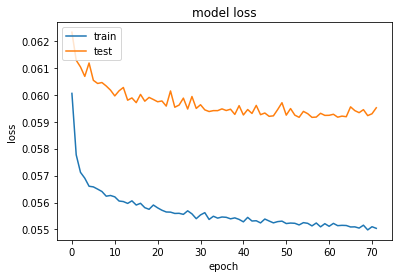

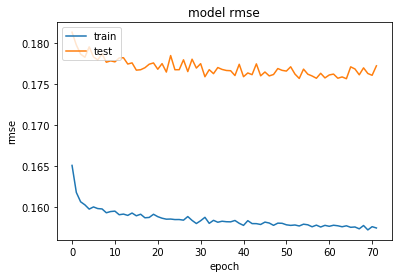

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

## Evaluate performance on validation data

In [13]:
model.load_weights(experiment_name+'.hdf5')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_reinject_output(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))


count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = model.predict([encoder_input, decoder_input], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  44.140825271606445 s =  0.7356804370880127 min =  0.012261340750588311 h


## Evaluate metrics

In [15]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.058873871857475904
Delay 100 ms: 0.004952255130551694
Delay 200 ms: 0.013675283269183897
Delay 300 ms: 0.024943021857985876
Delay 400 ms: 0.037464216508572644
Delay 500 ms: 0.05062675814067182
Delay 600 ms: 0.06415330352889066
Delay 700 ms: 0.07784886327571383
Delay 800 ms: 0.0915350446066266
Delay 900 ms: 0.10509034903556266
Delay 1000 ms: 0.1184496232209993

RMSE
Average rmse: 0.12310257495561261
Delay 100 ms: 0.012848698625681188
Delay 200 ms: 0.028725791694054457
Delay 300 ms: 0.04895840732070659
Delay 400 ms: 0.07096138306682992
Delay 500 ms: 0.09360387854002082
Delay 600 ms: 0.11642551363417697
Delay 700 ms: 0.13901957962436554
Delay 800 ms: 0.16120807957011024
Delay 900 ms: 0.1828622564316718
Delay 1000 ms: 0.20385263180402327

SMAPE
Average smape: 14.401041771218084
Delay 100 ms: 2.39443061463059
Delay 200 ms: 5.509256404168832
Delay 300 ms: 8.559008180115333
Delay 400 ms: 11.39677855244371
Delay 500 ms: 13.974236625765457
Delay 600 ms: 16.349646377971784
Del

(5925, 25, 3) (5925, 10, 3)


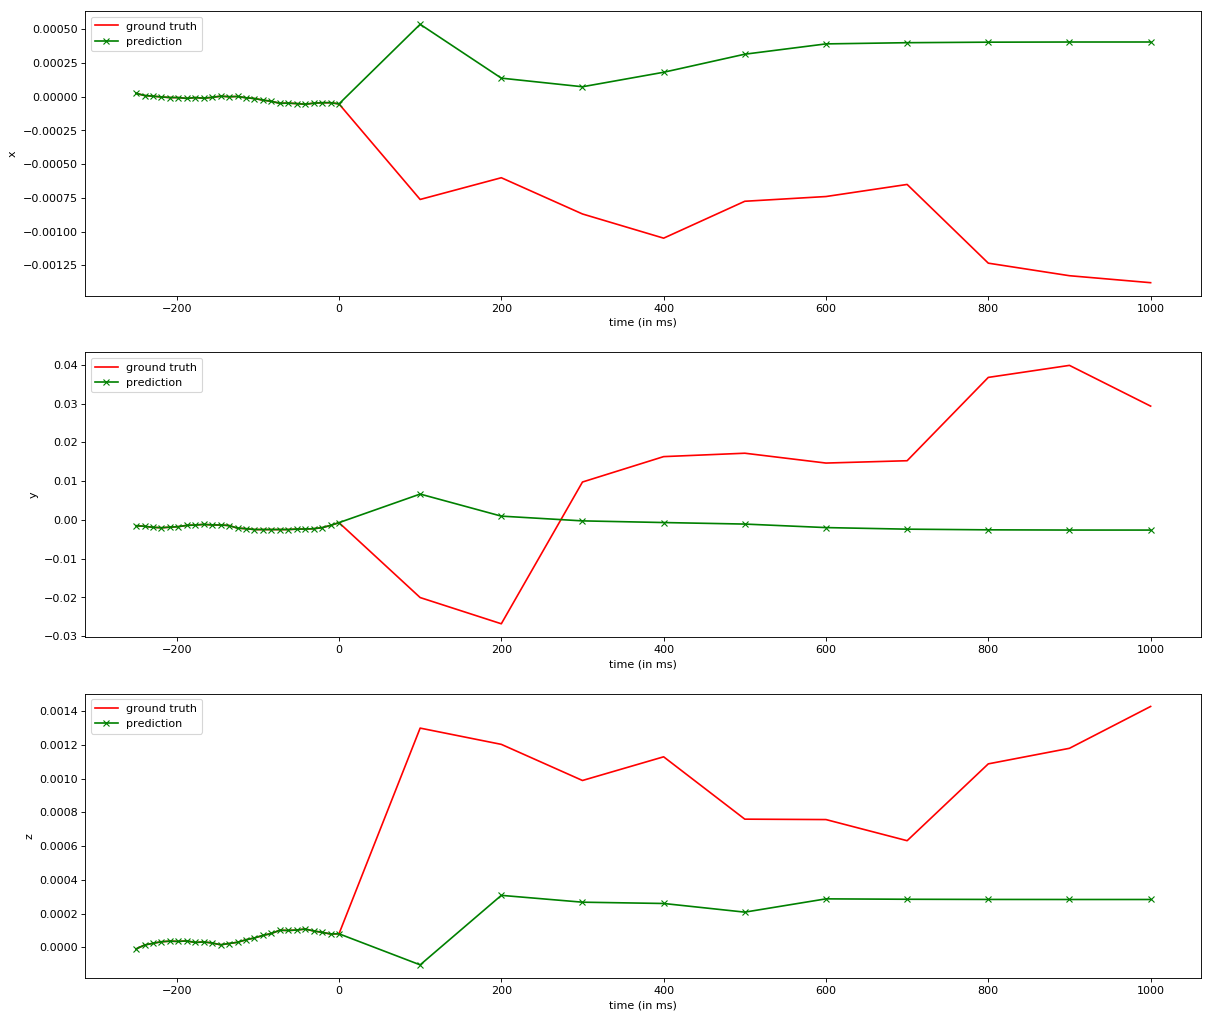

In [16]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')